## Allstate Claims Severity Final Submission

In [1]:
import pandas as pd
import numpy as np
import sklearn
from datetime import datetime
import matplotlib
import joblib
import pickle

import matplotlib.pyplot as plt

from category_encoders import TargetEncoder,OrdinalEncoder,MEstimateEncoder,JamesSteinEncoder,HashingEncoder,HelmertEncoder
from category_encoders import CatBoostEncoder,BaseNEncoder,BackwardDifferenceEncoder
from mlxtend.regressor import StackingRegressor
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import os
from scipy.stats import skew, boxcox
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

## Methodology
- My methodology for this final submission wasfrom Kaggle discussion forum https://www.kaggle.com/brahma0545/encoding-feature-comb-modkzs-1108-72665
- I took the combination of randomly selected 35 features as it was computationally efficient
- In my earlier submission I have tried building my models without outliers, but after reading most of the kaggle forum discussion I realized removing outliers is causing loss of information and leading to a worst model.
- Infact, removing outliers didn't help me much si, I decided to keep them and build a model on top of the m by taking the log of loss value and adding a shift value of 200 which gave a good stability and avoided it from skewness
- As my data was highly skewed I munged the skewness by setting some threshold of 0.25
- According to the Kaggle Forum most of them have used a different objective function which worked fairly well for optimizing our loss function.
- The objective which was used is as below
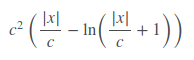

## [1.0] XGBoostRegressor

In [2]:
%%time
import numpy as np
import pandas as pd
import xgboost as xgb

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
import itertools

shift = 200
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

fair_constant = 2
def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-shift,
                                      np.exp(yhat)-shift)
def mungeskewed(train, test, numeric_feats):
    ntrain = train.shape[0]
    test['loss'] = 0
    train_test = pd.concat((train, test)).reset_index(drop=True)
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.25]
    skewed_feats = skewed_feats.index

    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1
        train_test[feats], lam = boxcox(train_test[feats])
    return train_test, ntrain

if __name__ == "__main__":

    print('\nStarted')
    directory = '../input/'
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    numeric_feats = [x for x in train.columns[1:-1] if 'cont' in x]
    categorical_feats = [x for x in train.columns[1:-1] if 'cat' in x]
    train_test, ntrain = mungeskewed(train, test, numeric_feats)

    print('')
    for comb in itertools.combinations(COMB_FEATURE, 2):
        feat = comb[0] + "_" + comb[1]
        train_test[feat] = train_test[comb[0]] + train_test[comb[1]]
        train_test[feat] = train_test[feat].apply(encode)
        print('Analyzing Columns:', feat)

    categorical_feats = [x for x in train_test.columns[1:] if 'cat' in x]

    print('')
    for col in categorical_feats:
        print('Analyzing Column:', col)
        train_test[col] = train_test[col].apply(encode)

    print(train_test[categorical_feats])

    ss = StandardScaler()
    train_test[numeric_feats] = \
        ss.fit_transform(train_test[numeric_feats].values)

    train = train_test.iloc[:ntrain, :].copy()
    test = train_test.iloc[ntrain:, :].copy()

    print('\nMedian Loss:', train.loss.median())
    print('Mean Loss:', train.loss.mean())

    ids = pd.read_csv('test.csv')['id']
    train_y = np.log(train['loss'] + shift)
    train_x = train.drop(['loss','id'], axis=1)
    test_x = test.drop(['loss','id'], axis=1)

    n_folds = 5
    cv_sum = 0
    early_stopping = 100
    fpred = []
    xgb_rounds = []

    d_train_full = xgb.DMatrix(train_x, label=train_y)
    d_test = xgb.DMatrix(test_x)
    # https://stackoverflow.com/a/48641547
    kf = KFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(kf.split(train_x)):
        print('\n Fold %d' % (i+1))
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[test_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]

        rand_state = 2016

        params = {
            'seed': 0,
            'colsample_bytree': 0.7,
            'silent': 1,
            'subsample': 0.7,
            'learning_rate': 0.03,
            'objective': 'reg:linear',
            'max_depth': 12,
            'min_child_weight': 100,
            'booster': 'gbtree'}

        d_train = xgb.DMatrix(X_train, label=y_train)
        d_valid = xgb.DMatrix(X_val, label=y_val)
        watchlist = [(d_train, 'train'), (d_valid, 'eval')]

        clf = xgb.train(params,
                        d_train,
                        100000,
                        watchlist,
                        early_stopping_rounds=50,
                        obj=fair_obj,
                        feval=xg_eval_mae)

        xgb_rounds.append(clf.best_iteration)
        scores_val = clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)
        cv_score = mean_absolute_error(np.exp(y_val), np.exp(scores_val))
        print('eval-MAE: %.6f' % cv_score)
        y_pred = np.exp(clf.predict(d_test, ntree_limit=clf.best_ntree_limit)) - shift

        if i > 0:
            fpred = pred + y_pred
        else:
            fpred = y_pred
        pred = fpred
        cv_sum = cv_sum + cv_score

    mpred = pred / n_folds
    score = cv_sum / n_folds
    print('Average eval-MAE: %.6f' % score)
    n_rounds = int(np.mean(xgb_rounds))

    print("Writing results")
    result = pd.DataFrame(mpred, columns=['loss'])
    result["id"] = ids
    result = result.set_index("id")
    print("%d-fold average prediction:" % n_folds)

    now = datetime.now()
    score = str(round((cv_sum / n_folds), 6))
    sub_file = 'submission_5fold-average-xgb_fairobj_' + str(score) + '_' + str(
        now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print("Writing submission: %s" % sub_file)
    result.to_csv(sub_file, index=True, index_label='id')


Started

Analyzing Columns: cat80_cat87
Analyzing Columns: cat80_cat57
Analyzing Columns: cat80_cat12
Analyzing Columns: cat80_cat79
Analyzing Columns: cat80_cat10
Analyzing Columns: cat80_cat7
Analyzing Columns: cat80_cat89
Analyzing Columns: cat80_cat2
Analyzing Columns: cat80_cat72
Analyzing Columns: cat80_cat81
Analyzing Columns: cat80_cat11
Analyzing Columns: cat80_cat1
Analyzing Columns: cat80_cat13
Analyzing Columns: cat80_cat9
Analyzing Columns: cat80_cat3
Analyzing Columns: cat80_cat16
Analyzing Columns: cat80_cat90
Analyzing Columns: cat80_cat23
Analyzing Columns: cat80_cat36
Analyzing Columns: cat80_cat73
Analyzing Columns: cat80_cat103
Analyzing Columns: cat80_cat40
Analyzing Columns: cat80_cat28
Analyzing Columns: cat80_cat111
Analyzing Columns: cat80_cat6
Analyzing Columns: cat80_cat76
Analyzing Columns: cat80_cat50
Analyzing Columns: cat80_cat5
Analyzing Columns: cat80_cat4
Analyzing Columns: cat80_cat14
Analyzing Columns: cat80_cat38
Analyzing Columns: cat80_cat24
Anal

Analyzing Columns: cat2_cat82
Analyzing Columns: cat2_cat25
Analyzing Columns: cat72_cat81
Analyzing Columns: cat72_cat11
Analyzing Columns: cat72_cat1
Analyzing Columns: cat72_cat13
Analyzing Columns: cat72_cat9
Analyzing Columns: cat72_cat3
Analyzing Columns: cat72_cat16
Analyzing Columns: cat72_cat90
Analyzing Columns: cat72_cat23
Analyzing Columns: cat72_cat36
Analyzing Columns: cat72_cat73
Analyzing Columns: cat72_cat103
Analyzing Columns: cat72_cat40
Analyzing Columns: cat72_cat28
Analyzing Columns: cat72_cat111
Analyzing Columns: cat72_cat6
Analyzing Columns: cat72_cat76
Analyzing Columns: cat72_cat50
Analyzing Columns: cat72_cat5
Analyzing Columns: cat72_cat4
Analyzing Columns: cat72_cat14
Analyzing Columns: cat72_cat38
Analyzing Columns: cat72_cat24
Analyzing Columns: cat72_cat82
Analyzing Columns: cat72_cat25
Analyzing Columns: cat81_cat11
Analyzing Columns: cat81_cat1
Analyzing Columns: cat81_cat13
Analyzing Columns: cat81_cat9
Analyzing Columns: cat81_cat3
Analyzing Columns

Analyzing Columns: cat28_cat14
Analyzing Columns: cat28_cat38
Analyzing Columns: cat28_cat24
Analyzing Columns: cat28_cat82
Analyzing Columns: cat28_cat25
Analyzing Columns: cat111_cat6
Analyzing Columns: cat111_cat76
Analyzing Columns: cat111_cat50
Analyzing Columns: cat111_cat5
Analyzing Columns: cat111_cat4
Analyzing Columns: cat111_cat14
Analyzing Columns: cat111_cat38
Analyzing Columns: cat111_cat24
Analyzing Columns: cat111_cat82
Analyzing Columns: cat111_cat25
Analyzing Columns: cat6_cat76
Analyzing Columns: cat6_cat50
Analyzing Columns: cat6_cat5
Analyzing Columns: cat6_cat4
Analyzing Columns: cat6_cat14
Analyzing Columns: cat6_cat38
Analyzing Columns: cat6_cat24
Analyzing Columns: cat6_cat82
Analyzing Columns: cat6_cat25
Analyzing Columns: cat76_cat50
Analyzing Columns: cat76_cat5
Analyzing Columns: cat76_cat4
Analyzing Columns: cat76_cat14
Analyzing Columns: cat76_cat38
Analyzing Columns: cat76_cat24
Analyzing Columns: cat76_cat82
Analyzing Columns: cat76_cat25
Analyzing Colu

Analyzing Column: cat12_cat6
Analyzing Column: cat12_cat76
Analyzing Column: cat12_cat50
Analyzing Column: cat12_cat5
Analyzing Column: cat12_cat4
Analyzing Column: cat12_cat14
Analyzing Column: cat12_cat38
Analyzing Column: cat12_cat24
Analyzing Column: cat12_cat82
Analyzing Column: cat12_cat25
Analyzing Column: cat79_cat10
Analyzing Column: cat79_cat7
Analyzing Column: cat79_cat89
Analyzing Column: cat79_cat2
Analyzing Column: cat79_cat72
Analyzing Column: cat79_cat81
Analyzing Column: cat79_cat11
Analyzing Column: cat79_cat1
Analyzing Column: cat79_cat13
Analyzing Column: cat79_cat9
Analyzing Column: cat79_cat3
Analyzing Column: cat79_cat16
Analyzing Column: cat79_cat90
Analyzing Column: cat79_cat23
Analyzing Column: cat79_cat36
Analyzing Column: cat79_cat73
Analyzing Column: cat79_cat103
Analyzing Column: cat79_cat40
Analyzing Column: cat79_cat28
Analyzing Column: cat79_cat111
Analyzing Column: cat79_cat6
Analyzing Column: cat79_cat76
Analyzing Column: cat79_cat50
Analyzing Column:

Analyzing Column: cat9_cat5
Analyzing Column: cat9_cat4
Analyzing Column: cat9_cat14
Analyzing Column: cat9_cat38
Analyzing Column: cat9_cat24
Analyzing Column: cat9_cat82
Analyzing Column: cat9_cat25
Analyzing Column: cat3_cat16
Analyzing Column: cat3_cat90
Analyzing Column: cat3_cat23
Analyzing Column: cat3_cat36
Analyzing Column: cat3_cat73
Analyzing Column: cat3_cat103
Analyzing Column: cat3_cat40
Analyzing Column: cat3_cat28
Analyzing Column: cat3_cat111
Analyzing Column: cat3_cat6
Analyzing Column: cat3_cat76
Analyzing Column: cat3_cat50
Analyzing Column: cat3_cat5
Analyzing Column: cat3_cat4
Analyzing Column: cat3_cat14
Analyzing Column: cat3_cat38
Analyzing Column: cat3_cat24
Analyzing Column: cat3_cat82
Analyzing Column: cat3_cat25
Analyzing Column: cat16_cat90
Analyzing Column: cat16_cat23
Analyzing Column: cat16_cat36
Analyzing Column: cat16_cat73
Analyzing Column: cat16_cat103
Analyzing Column: cat16_cat40
Analyzing Column: cat16_cat28
Analyzing Column: cat16_cat111
Analyzi


Median Loss: 2115.5699999999997
Mean Loss: 3037.3376856699792

 Fold 1
[0]	train-rmse:6.32956	eval-rmse:6.32583	train-mae:3234.02	eval-mae:3227.9
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[1]	train-rmse:5.55896	eval-rmse:5.55487	train-mae:3228.64	eval-mae:3222.51
[2]	train-rmse:4.94866	eval-rmse:4.94418	train-mae:3220.07	eval-mae:3213.92
[3]	train-rmse:4.45219	eval-rmse:4.44746	train-mae:3207.81	eval-mae:3201.63
[4]	train-rmse:4.04046	eval-rmse:4.03556	train-mae:3191.61	eval-mae:3185.39
[5]	train-rmse:3.69302	eval-rmse:3.68789	train-mae:3171.43	eval-mae:3165.15
[6]	train-rmse:3.39634	eval-rmse:3.39098	train-mae:3147.4	eval-mae:3141.04
[7]	train-rmse:3.13966	eval-rmse:3.134	train-mae:3119.69	eval-mae:3113.2
[8]	train-rmse:2.91579	eval-rmse:2.91012	train-mae:3088.6	eval-mae:3081.99
[9]	train-rmse:2.7185	eval-rmse:2.71271	train-mae:3054.51	eval-mae:3047.74
[10]	train-rmse:2.54377	eval-rmse:

[103]	train-rmse:0.475371	eval-rmse:0.489141	train-mae:1144.69	eval-mae:1177.8
[104]	train-rmse:0.474568	eval-rmse:0.488583	train-mae:1142.5	eval-mae:1176.31
[105]	train-rmse:0.474012	eval-rmse:0.488126	train-mae:1140.82	eval-mae:1175.01
[106]	train-rmse:0.473409	eval-rmse:0.487692	train-mae:1139.1	eval-mae:1173.81
[107]	train-rmse:0.472873	eval-rmse:0.487259	train-mae:1137.55	eval-mae:1172.63
[108]	train-rmse:0.472317	eval-rmse:0.486849	train-mae:1135.96	eval-mae:1171.53
[109]	train-rmse:0.471824	eval-rmse:0.486498	train-mae:1134.52	eval-mae:1170.55
[110]	train-rmse:0.471297	eval-rmse:0.486134	train-mae:1132.95	eval-mae:1169.52
[111]	train-rmse:0.470847	eval-rmse:0.48581	train-mae:1131.57	eval-mae:1168.54
[112]	train-rmse:0.470309	eval-rmse:0.485457	train-mae:1130.03	eval-mae:1167.6
[113]	train-rmse:0.469826	eval-rmse:0.485171	train-mae:1128.66	eval-mae:1166.75
[114]	train-rmse:0.469367	eval-rmse:0.484845	train-mae:1127.25	eval-mae:1165.8
[115]	train-rmse:0.468955	eval-rmse:0.484587	t

[207]	train-rmse:0.453819	eval-rmse:0.477586	train-mae:1077.98	eval-mae:1142.56
[208]	train-rmse:0.453733	eval-rmse:0.477557	train-mae:1077.74	eval-mae:1142.49
[209]	train-rmse:0.453549	eval-rmse:0.477508	train-mae:1077.21	eval-mae:1142.38
[210]	train-rmse:0.453481	eval-rmse:0.477496	train-mae:1077.01	eval-mae:1142.34
[211]	train-rmse:0.453395	eval-rmse:0.477478	train-mae:1076.8	eval-mae:1142.31
[212]	train-rmse:0.453338	eval-rmse:0.477447	train-mae:1076.61	eval-mae:1142.18
[213]	train-rmse:0.453269	eval-rmse:0.477434	train-mae:1076.39	eval-mae:1142.11
[214]	train-rmse:0.453231	eval-rmse:0.477414	train-mae:1076.23	eval-mae:1142.01
[215]	train-rmse:0.453159	eval-rmse:0.477397	train-mae:1076	eval-mae:1141.93
[216]	train-rmse:0.453088	eval-rmse:0.477375	train-mae:1075.74	eval-mae:1141.88
[217]	train-rmse:0.45302	eval-rmse:0.477361	train-mae:1075.47	eval-mae:1141.79
[218]	train-rmse:0.452953	eval-rmse:0.477338	train-mae:1075.25	eval-mae:1141.72
[219]	train-rmse:0.452833	eval-rmse:0.477325	

[310]	train-rmse:0.445738	eval-rmse:0.475986	train-mae:1054.23	eval-mae:1137.25
[311]	train-rmse:0.445644	eval-rmse:0.475957	train-mae:1053.94	eval-mae:1137.13
[312]	train-rmse:0.445583	eval-rmse:0.475933	train-mae:1053.72	eval-mae:1137.06
[313]	train-rmse:0.44556	eval-rmse:0.475925	train-mae:1053.63	eval-mae:1137.04
[314]	train-rmse:0.445516	eval-rmse:0.475912	train-mae:1053.48	eval-mae:1137
[315]	train-rmse:0.445489	eval-rmse:0.475911	train-mae:1053.41	eval-mae:1137
[316]	train-rmse:0.445463	eval-rmse:0.47591	train-mae:1053.34	eval-mae:1137
[317]	train-rmse:0.445376	eval-rmse:0.475902	train-mae:1053.07	eval-mae:1136.96
[318]	train-rmse:0.445339	eval-rmse:0.475894	train-mae:1052.98	eval-mae:1136.96
[319]	train-rmse:0.445304	eval-rmse:0.475883	train-mae:1052.87	eval-mae:1136.91
[320]	train-rmse:0.445244	eval-rmse:0.475875	train-mae:1052.67	eval-mae:1136.88
[321]	train-rmse:0.445214	eval-rmse:0.475869	train-mae:1052.58	eval-mae:1136.88
[322]	train-rmse:0.445153	eval-rmse:0.475858	train-

[414]	train-rmse:0.439502	eval-rmse:0.47519	train-mae:1036.11	eval-mae:1134.84
[415]	train-rmse:0.439428	eval-rmse:0.475201	train-mae:1035.9	eval-mae:1134.88
[416]	train-rmse:0.439404	eval-rmse:0.475192	train-mae:1035.82	eval-mae:1134.89
[417]	train-rmse:0.439332	eval-rmse:0.475184	train-mae:1035.6	eval-mae:1134.9
[418]	train-rmse:0.439281	eval-rmse:0.475167	train-mae:1035.46	eval-mae:1134.87
[419]	train-rmse:0.439188	eval-rmse:0.475149	train-mae:1035.16	eval-mae:1134.8
[420]	train-rmse:0.439095	eval-rmse:0.475118	train-mae:1034.83	eval-mae:1134.68
[421]	train-rmse:0.439029	eval-rmse:0.47511	train-mae:1034.62	eval-mae:1134.67
[422]	train-rmse:0.439015	eval-rmse:0.475109	train-mae:1034.57	eval-mae:1134.66
[423]	train-rmse:0.438972	eval-rmse:0.475102	train-mae:1034.44	eval-mae:1134.64
[424]	train-rmse:0.438869	eval-rmse:0.475078	train-mae:1034.2	eval-mae:1134.56
[425]	train-rmse:0.43882	eval-rmse:0.475071	train-mae:1034.02	eval-mae:1134.51
[426]	train-rmse:0.43877	eval-rmse:0.475065	trai

[518]	train-rmse:0.433722	eval-rmse:0.474766	train-mae:1019.11	eval-mae:1133.46
[519]	train-rmse:0.433682	eval-rmse:0.474764	train-mae:1019	eval-mae:1133.46
[520]	train-rmse:0.433656	eval-rmse:0.474768	train-mae:1018.93	eval-mae:1133.48
[521]	train-rmse:0.433631	eval-rmse:0.474769	train-mae:1018.84	eval-mae:1133.48
[522]	train-rmse:0.433555	eval-rmse:0.474763	train-mae:1018.65	eval-mae:1133.47
[523]	train-rmse:0.433521	eval-rmse:0.474759	train-mae:1018.55	eval-mae:1133.45
[524]	train-rmse:0.433404	eval-rmse:0.474735	train-mae:1018.25	eval-mae:1133.39
[525]	train-rmse:0.433377	eval-rmse:0.47474	train-mae:1018.17	eval-mae:1133.38
[526]	train-rmse:0.433336	eval-rmse:0.474738	train-mae:1018.07	eval-mae:1133.38
[527]	train-rmse:0.433197	eval-rmse:0.474727	train-mae:1017.68	eval-mae:1133.35
[528]	train-rmse:0.433117	eval-rmse:0.474715	train-mae:1017.41	eval-mae:1133.3
[529]	train-rmse:0.433062	eval-rmse:0.47472	train-mae:1017.26	eval-mae:1133.31
[530]	train-rmse:0.433024	eval-rmse:0.474718	t

[622]	train-rmse:0.428607	eval-rmse:0.474624	train-mae:1004.44	eval-mae:1132.81
[623]	train-rmse:0.428532	eval-rmse:0.474622	train-mae:1004.24	eval-mae:1132.81
[624]	train-rmse:0.428451	eval-rmse:0.474625	train-mae:1004.02	eval-mae:1132.83
[625]	train-rmse:0.428407	eval-rmse:0.474627	train-mae:1003.88	eval-mae:1132.83
[626]	train-rmse:0.428335	eval-rmse:0.474621	train-mae:1003.69	eval-mae:1132.8
[627]	train-rmse:0.428291	eval-rmse:0.474627	train-mae:1003.58	eval-mae:1132.82
[628]	train-rmse:0.42823	eval-rmse:0.474618	train-mae:1003.35	eval-mae:1132.79
[629]	train-rmse:0.428208	eval-rmse:0.474619	train-mae:1003.27	eval-mae:1132.8
[630]	train-rmse:0.42818	eval-rmse:0.474618	train-mae:1003.18	eval-mae:1132.78
[631]	train-rmse:0.428156	eval-rmse:0.47462	train-mae:1003.11	eval-mae:1132.8
[632]	train-rmse:0.428085	eval-rmse:0.474619	train-mae:1002.88	eval-mae:1132.79
[633]	train-rmse:0.428019	eval-rmse:0.474633	train-mae:1002.7	eval-mae:1132.79
[634]	train-rmse:0.427978	eval-rmse:0.474626	tr

[34]	train-rmse:0.926557	eval-rmse:0.930308	train-mae:1987.89	eval-mae:1992.46
[35]	train-rmse:0.901843	eval-rmse:0.905738	train-mae:1952.77	eval-mae:1957.65
[36]	train-rmse:0.878562	eval-rmse:0.882601	train-mae:1918.71	eval-mae:1923.9
[37]	train-rmse:0.856655	eval-rmse:0.860865	train-mae:1885.75	eval-mae:1891.38
[38]	train-rmse:0.83601	eval-rmse:0.840381	train-mae:1854.06	eval-mae:1860.13
[39]	train-rmse:0.816499	eval-rmse:0.821019	train-mae:1823.34	eval-mae:1829.9
[40]	train-rmse:0.797898	eval-rmse:0.802585	train-mae:1793.42	eval-mae:1800.46
[41]	train-rmse:0.780464	eval-rmse:0.78529	train-mae:1764.75	eval-mae:1772.22
[42]	train-rmse:0.763895	eval-rmse:0.768939	train-mae:1736.97	eval-mae:1744.91
[43]	train-rmse:0.748259	eval-rmse:0.753469	train-mae:1710.21	eval-mae:1718.64
[44]	train-rmse:0.733414	eval-rmse:0.738758	train-mae:1684.37	eval-mae:1693.24
[45]	train-rmse:0.71943	eval-rmse:0.724948	train-mae:1659.7	eval-mae:1669.07
[46]	train-rmse:0.706155	eval-rmse:0.711843	train-mae:1635

[138]	train-rmse:0.462918	eval-rmse:0.47997	train-mae:1107.52	eval-mae:1150.56
[139]	train-rmse:0.462645	eval-rmse:0.479822	train-mae:1106.68	eval-mae:1150.12
[140]	train-rmse:0.462426	eval-rmse:0.479704	train-mae:1106	eval-mae:1149.75
[141]	train-rmse:0.462246	eval-rmse:0.479574	train-mae:1105.45	eval-mae:1149.39
[142]	train-rmse:0.462116	eval-rmse:0.479499	train-mae:1105.02	eval-mae:1149.14
[143]	train-rmse:0.46189	eval-rmse:0.479377	train-mae:1104.31	eval-mae:1148.77
[144]	train-rmse:0.46168	eval-rmse:0.479292	train-mae:1103.6	eval-mae:1148.49
[145]	train-rmse:0.461589	eval-rmse:0.479213	train-mae:1103.25	eval-mae:1148.18
[146]	train-rmse:0.461465	eval-rmse:0.479153	train-mae:1102.84	eval-mae:1147.97
[147]	train-rmse:0.461223	eval-rmse:0.479039	train-mae:1102.09	eval-mae:1147.57
[148]	train-rmse:0.461111	eval-rmse:0.478979	train-mae:1101.69	eval-mae:1147.36
[149]	train-rmse:0.460977	eval-rmse:0.478903	train-mae:1101.29	eval-mae:1147.1
[150]	train-rmse:0.460838	eval-rmse:0.47884	trai

[242]	train-rmse:0.450617	eval-rmse:0.475866	train-mae:1069.29	eval-mae:1136.81
[243]	train-rmse:0.450536	eval-rmse:0.475834	train-mae:1069.03	eval-mae:1136.73
[244]	train-rmse:0.450466	eval-rmse:0.475825	train-mae:1068.83	eval-mae:1136.68
[245]	train-rmse:0.450335	eval-rmse:0.4758	train-mae:1068.46	eval-mae:1136.58
[246]	train-rmse:0.450267	eval-rmse:0.475781	train-mae:1068.23	eval-mae:1136.52
[247]	train-rmse:0.450193	eval-rmse:0.475776	train-mae:1068.02	eval-mae:1136.5
[248]	train-rmse:0.450088	eval-rmse:0.47576	train-mae:1067.65	eval-mae:1136.45
[249]	train-rmse:0.450023	eval-rmse:0.475759	train-mae:1067.47	eval-mae:1136.43
[250]	train-rmse:0.449939	eval-rmse:0.475736	train-mae:1067.23	eval-mae:1136.4
[251]	train-rmse:0.449851	eval-rmse:0.47572	train-mae:1066.95	eval-mae:1136.32
[252]	train-rmse:0.449782	eval-rmse:0.47571	train-mae:1066.75	eval-mae:1136.3
[253]	train-rmse:0.449674	eval-rmse:0.475681	train-mae:1066.38	eval-mae:1136.18
[254]	train-rmse:0.449583	eval-rmse:0.475646	tra

[346]	train-rmse:0.442857	eval-rmse:0.474652	train-mae:1046.66	eval-mae:1133.02
[347]	train-rmse:0.442799	eval-rmse:0.474657	train-mae:1046.5	eval-mae:1133.02
[348]	train-rmse:0.442704	eval-rmse:0.474658	train-mae:1046.26	eval-mae:1133.01
[349]	train-rmse:0.442619	eval-rmse:0.47465	train-mae:1046.06	eval-mae:1132.97
[350]	train-rmse:0.442589	eval-rmse:0.474648	train-mae:1045.97	eval-mae:1132.94
[351]	train-rmse:0.442527	eval-rmse:0.474646	train-mae:1045.82	eval-mae:1132.91
[352]	train-rmse:0.442496	eval-rmse:0.474644	train-mae:1045.73	eval-mae:1132.89
[353]	train-rmse:0.442405	eval-rmse:0.474604	train-mae:1045.46	eval-mae:1132.76
[354]	train-rmse:0.44238	eval-rmse:0.474598	train-mae:1045.38	eval-mae:1132.76
[355]	train-rmse:0.442347	eval-rmse:0.474596	train-mae:1045.28	eval-mae:1132.79
[356]	train-rmse:0.442306	eval-rmse:0.474595	train-mae:1045.13	eval-mae:1132.8
[357]	train-rmse:0.442242	eval-rmse:0.474589	train-mae:1044.94	eval-mae:1132.79
[358]	train-rmse:0.442199	eval-rmse:0.474583

[449]	train-rmse:0.436974	eval-rmse:0.474014	train-mae:1029.26	eval-mae:1131.16
[450]	train-rmse:0.436899	eval-rmse:0.474005	train-mae:1029.06	eval-mae:1131.15
[451]	train-rmse:0.436861	eval-rmse:0.474003	train-mae:1028.93	eval-mae:1131.16
[452]	train-rmse:0.436783	eval-rmse:0.473993	train-mae:1028.68	eval-mae:1131.16
[453]	train-rmse:0.43674	eval-rmse:0.473984	train-mae:1028.57	eval-mae:1131.13
[454]	train-rmse:0.436644	eval-rmse:0.473982	train-mae:1028.28	eval-mae:1131.14
[455]	train-rmse:0.436548	eval-rmse:0.473966	train-mae:1028	eval-mae:1131.1
[456]	train-rmse:0.4365	eval-rmse:0.473971	train-mae:1027.83	eval-mae:1131.1
[457]	train-rmse:0.436458	eval-rmse:0.473958	train-mae:1027.76	eval-mae:1131.09
[458]	train-rmse:0.436398	eval-rmse:0.473954	train-mae:1027.55	eval-mae:1131.07
[459]	train-rmse:0.436328	eval-rmse:0.473953	train-mae:1027.36	eval-mae:1131.08
[460]	train-rmse:0.436238	eval-rmse:0.473936	train-mae:1027.08	eval-mae:1131.05
[461]	train-rmse:0.436209	eval-rmse:0.473935	tra

[553]	train-rmse:0.431821	eval-rmse:0.473618	train-mae:1014.23	eval-mae:1130.09
[554]	train-rmse:0.431772	eval-rmse:0.473611	train-mae:1014.08	eval-mae:1130.05
[555]	train-rmse:0.431743	eval-rmse:0.473605	train-mae:1014.01	eval-mae:1130.04
[556]	train-rmse:0.431693	eval-rmse:0.473609	train-mae:1013.84	eval-mae:1130.06
[557]	train-rmse:0.431636	eval-rmse:0.473618	train-mae:1013.67	eval-mae:1130.11
[558]	train-rmse:0.431577	eval-rmse:0.47361	train-mae:1013.46	eval-mae:1130.06
[559]	train-rmse:0.431565	eval-rmse:0.473608	train-mae:1013.39	eval-mae:1130.04
[560]	train-rmse:0.431538	eval-rmse:0.473601	train-mae:1013.31	eval-mae:1130.04
[561]	train-rmse:0.431488	eval-rmse:0.473601	train-mae:1013.19	eval-mae:1130.03
[562]	train-rmse:0.431401	eval-rmse:0.473595	train-mae:1012.91	eval-mae:1130
[563]	train-rmse:0.43138	eval-rmse:0.473588	train-mae:1012.85	eval-mae:1129.98
[564]	train-rmse:0.431359	eval-rmse:0.473585	train-mae:1012.79	eval-mae:1129.97
[565]	train-rmse:0.43128	eval-rmse:0.473582	t

[656]	train-rmse:0.427081	eval-rmse:0.473375	train-mae:1000.02	eval-mae:1129.59
[657]	train-rmse:0.427054	eval-rmse:0.473373	train-mae:999.94	eval-mae:1129.6
[658]	train-rmse:0.42699	eval-rmse:0.473372	train-mae:999.773	eval-mae:1129.61
[659]	train-rmse:0.426958	eval-rmse:0.473374	train-mae:999.656	eval-mae:1129.6
[660]	train-rmse:0.426896	eval-rmse:0.473372	train-mae:999.5	eval-mae:1129.6
[661]	train-rmse:0.426854	eval-rmse:0.473368	train-mae:999.405	eval-mae:1129.58
[662]	train-rmse:0.426811	eval-rmse:0.473367	train-mae:999.293	eval-mae:1129.56
[663]	train-rmse:0.426735	eval-rmse:0.473371	train-mae:999.078	eval-mae:1129.54
[664]	train-rmse:0.426695	eval-rmse:0.473364	train-mae:998.967	eval-mae:1129.51
[665]	train-rmse:0.426647	eval-rmse:0.473357	train-mae:998.821	eval-mae:1129.49
[666]	train-rmse:0.42663	eval-rmse:0.473357	train-mae:998.786	eval-mae:1129.5
[667]	train-rmse:0.426552	eval-rmse:0.473359	train-mae:998.556	eval-mae:1129.5
[668]	train-rmse:0.426465	eval-rmse:0.473365	train

[32]	train-rmse:0.979702	eval-rmse:0.988806	train-mae:2059.2	eval-mae:2076.16
[33]	train-rmse:0.951835	eval-rmse:0.961199	train-mae:2022.03	eval-mae:2039.42
[34]	train-rmse:0.925743	eval-rmse:0.935289	train-mae:1985.99	eval-mae:2003.77
[35]	train-rmse:0.901195	eval-rmse:0.910904	train-mae:1951.03	eval-mae:1969.17
[36]	train-rmse:0.877873	eval-rmse:0.887775	train-mae:1916.92	eval-mae:1935.45
[37]	train-rmse:0.855922	eval-rmse:0.866049	train-mae:1883.98	eval-mae:1903.03
[38]	train-rmse:0.835287	eval-rmse:0.845581	train-mae:1852.27	eval-mae:1871.75
[39]	train-rmse:0.815825	eval-rmse:0.826313	train-mae:1821.64	eval-mae:1841.68
[40]	train-rmse:0.797242	eval-rmse:0.807931	train-mae:1791.77	eval-mae:1812.23
[41]	train-rmse:0.77982	eval-rmse:0.790695	train-mae:1763.16	eval-mae:1784.02
[42]	train-rmse:0.763235	eval-rmse:0.774337	train-mae:1735.32	eval-mae:1756.72
[43]	train-rmse:0.747529	eval-rmse:0.758883	train-mae:1708.38	eval-mae:1730.33
[44]	train-rmse:0.732665	eval-rmse:0.744191	train-mae:

[136]	train-rmse:0.461996	eval-rmse:0.485228	train-mae:1104.55	eval-mae:1166.56
[137]	train-rmse:0.461834	eval-rmse:0.485106	train-mae:1104.02	eval-mae:1166.23
[138]	train-rmse:0.461671	eval-rmse:0.484984	train-mae:1103.48	eval-mae:1165.86
[139]	train-rmse:0.461446	eval-rmse:0.484849	train-mae:1102.74	eval-mae:1165.51
[140]	train-rmse:0.461297	eval-rmse:0.48475	train-mae:1102.21	eval-mae:1165.19
[141]	train-rmse:0.461062	eval-rmse:0.484633	train-mae:1101.46	eval-mae:1164.82
[142]	train-rmse:0.460895	eval-rmse:0.484519	train-mae:1100.99	eval-mae:1164.52
[143]	train-rmse:0.460737	eval-rmse:0.48441	train-mae:1100.48	eval-mae:1164.2
[144]	train-rmse:0.460522	eval-rmse:0.484308	train-mae:1099.78	eval-mae:1163.85
[145]	train-rmse:0.460397	eval-rmse:0.484231	train-mae:1099.37	eval-mae:1163.62
[146]	train-rmse:0.460243	eval-rmse:0.484116	train-mae:1098.8	eval-mae:1163.3
[147]	train-rmse:0.460106	eval-rmse:0.484044	train-mae:1098.35	eval-mae:1163.05
[148]	train-rmse:0.459958	eval-rmse:0.483975	

[239]	train-rmse:0.450484	eval-rmse:0.480492	train-mae:1068.21	eval-mae:1151.63
[240]	train-rmse:0.450376	eval-rmse:0.480474	train-mae:1067.91	eval-mae:1151.62
[241]	train-rmse:0.450253	eval-rmse:0.480448	train-mae:1067.59	eval-mae:1151.53
[242]	train-rmse:0.450184	eval-rmse:0.480435	train-mae:1067.4	eval-mae:1151.5
[243]	train-rmse:0.450108	eval-rmse:0.480397	train-mae:1067.2	eval-mae:1151.38
[244]	train-rmse:0.449998	eval-rmse:0.480385	train-mae:1066.89	eval-mae:1151.35
[245]	train-rmse:0.449922	eval-rmse:0.480365	train-mae:1066.65	eval-mae:1151.27
[246]	train-rmse:0.449878	eval-rmse:0.480336	train-mae:1066.52	eval-mae:1151.16
[247]	train-rmse:0.449771	eval-rmse:0.480315	train-mae:1066.2	eval-mae:1151.09
[248]	train-rmse:0.449695	eval-rmse:0.480284	train-mae:1065.94	eval-mae:1151.06
[249]	train-rmse:0.449625	eval-rmse:0.480261	train-mae:1065.73	eval-mae:1150.99
[250]	train-rmse:0.449479	eval-rmse:0.480257	train-mae:1065.31	eval-mae:1150.96
[251]	train-rmse:0.449416	eval-rmse:0.480248

[343]	train-rmse:0.442716	eval-rmse:0.478968	train-mae:1045.64	eval-mae:1146.68
[344]	train-rmse:0.442674	eval-rmse:0.478958	train-mae:1045.54	eval-mae:1146.64
[345]	train-rmse:0.442617	eval-rmse:0.478964	train-mae:1045.42	eval-mae:1146.66
[346]	train-rmse:0.442513	eval-rmse:0.478954	train-mae:1045.11	eval-mae:1146.62
[347]	train-rmse:0.442477	eval-rmse:0.478943	train-mae:1045	eval-mae:1146.59
[348]	train-rmse:0.4424	eval-rmse:0.478926	train-mae:1044.79	eval-mae:1146.53
[349]	train-rmse:0.44236	eval-rmse:0.478922	train-mae:1044.65	eval-mae:1146.49
[350]	train-rmse:0.442304	eval-rmse:0.478917	train-mae:1044.49	eval-mae:1146.48
[351]	train-rmse:0.442259	eval-rmse:0.478906	train-mae:1044.36	eval-mae:1146.45
[352]	train-rmse:0.442234	eval-rmse:0.478898	train-mae:1044.28	eval-mae:1146.42
[353]	train-rmse:0.442188	eval-rmse:0.478893	train-mae:1044.16	eval-mae:1146.39
[354]	train-rmse:0.442132	eval-rmse:0.478884	train-mae:1043.97	eval-mae:1146.36
[355]	train-rmse:0.44208	eval-rmse:0.478876	tr

[446]	train-rmse:0.436812	eval-rmse:0.478289	train-mae:1028.78	eval-mae:1144.65
[447]	train-rmse:0.436784	eval-rmse:0.478279	train-mae:1028.7	eval-mae:1144.61
[448]	train-rmse:0.436712	eval-rmse:0.478282	train-mae:1028.48	eval-mae:1144.59
[449]	train-rmse:0.436636	eval-rmse:0.478258	train-mae:1028.27	eval-mae:1144.48
[450]	train-rmse:0.436579	eval-rmse:0.478253	train-mae:1028.1	eval-mae:1144.49
[451]	train-rmse:0.436556	eval-rmse:0.478254	train-mae:1028.04	eval-mae:1144.48
[452]	train-rmse:0.436509	eval-rmse:0.478246	train-mae:1027.88	eval-mae:1144.46
[453]	train-rmse:0.436475	eval-rmse:0.478244	train-mae:1027.77	eval-mae:1144.44
[454]	train-rmse:0.436419	eval-rmse:0.478233	train-mae:1027.61	eval-mae:1144.4
[455]	train-rmse:0.436373	eval-rmse:0.478215	train-mae:1027.49	eval-mae:1144.36
[456]	train-rmse:0.43634	eval-rmse:0.478201	train-mae:1027.39	eval-mae:1144.35
[457]	train-rmse:0.436311	eval-rmse:0.478194	train-mae:1027.31	eval-mae:1144.33
[458]	train-rmse:0.436244	eval-rmse:0.478178

[549]	train-rmse:0.431765	eval-rmse:0.477917	train-mae:1013.96	eval-mae:1143.3
[550]	train-rmse:0.431739	eval-rmse:0.477921	train-mae:1013.87	eval-mae:1143.31
[551]	train-rmse:0.431665	eval-rmse:0.47791	train-mae:1013.68	eval-mae:1143.26
[552]	train-rmse:0.431603	eval-rmse:0.477913	train-mae:1013.51	eval-mae:1143.3
[553]	train-rmse:0.431559	eval-rmse:0.477907	train-mae:1013.37	eval-mae:1143.25
[554]	train-rmse:0.431508	eval-rmse:0.477903	train-mae:1013.22	eval-mae:1143.24
[555]	train-rmse:0.431477	eval-rmse:0.477901	train-mae:1013.08	eval-mae:1143.26
[556]	train-rmse:0.431426	eval-rmse:0.477897	train-mae:1012.96	eval-mae:1143.26
[557]	train-rmse:0.43137	eval-rmse:0.477892	train-mae:1012.79	eval-mae:1143.27
[558]	train-rmse:0.431293	eval-rmse:0.477888	train-mae:1012.58	eval-mae:1143.25
[559]	train-rmse:0.431248	eval-rmse:0.477897	train-mae:1012.47	eval-mae:1143.27
[560]	train-rmse:0.431187	eval-rmse:0.477892	train-mae:1012.31	eval-mae:1143.27
[561]	train-rmse:0.431169	eval-rmse:0.477889

[652]	train-rmse:0.426837	eval-rmse:0.477723	train-mae:999.491	eval-mae:1142.6
[653]	train-rmse:0.426807	eval-rmse:0.477721	train-mae:999.408	eval-mae:1142.59
[654]	train-rmse:0.426755	eval-rmse:0.477712	train-mae:999.259	eval-mae:1142.56
[655]	train-rmse:0.426712	eval-rmse:0.477714	train-mae:999.13	eval-mae:1142.56
[656]	train-rmse:0.426667	eval-rmse:0.477712	train-mae:999.012	eval-mae:1142.55
[657]	train-rmse:0.426632	eval-rmse:0.47771	train-mae:998.92	eval-mae:1142.54
[658]	train-rmse:0.42656	eval-rmse:0.477697	train-mae:998.72	eval-mae:1142.5
[659]	train-rmse:0.426529	eval-rmse:0.477693	train-mae:998.633	eval-mae:1142.5
[660]	train-rmse:0.426455	eval-rmse:0.477679	train-mae:998.449	eval-mae:1142.47
[661]	train-rmse:0.426427	eval-rmse:0.477686	train-mae:998.358	eval-mae:1142.47
[662]	train-rmse:0.426362	eval-rmse:0.477686	train-mae:998.153	eval-mae:1142.47
[663]	train-rmse:0.426318	eval-rmse:0.477682	train-mae:998.032	eval-mae:1142.47
[664]	train-rmse:0.426288	eval-rmse:0.477687	tra

[755]	train-rmse:0.422017	eval-rmse:0.477651	train-mae:985.687	eval-mae:1142.09
[756]	train-rmse:0.421995	eval-rmse:0.477649	train-mae:985.609	eval-mae:1142.11
[757]	train-rmse:0.421974	eval-rmse:0.477648	train-mae:985.567	eval-mae:1142.11
[758]	train-rmse:0.421942	eval-rmse:0.477645	train-mae:985.484	eval-mae:1142.11
[759]	train-rmse:0.421896	eval-rmse:0.477643	train-mae:985.388	eval-mae:1142.14
[760]	train-rmse:0.421844	eval-rmse:0.477648	train-mae:985.246	eval-mae:1142.15
[761]	train-rmse:0.421795	eval-rmse:0.477639	train-mae:985.118	eval-mae:1142.13
[762]	train-rmse:0.421713	eval-rmse:0.47764	train-mae:984.922	eval-mae:1142.14
[763]	train-rmse:0.421647	eval-rmse:0.477644	train-mae:984.742	eval-mae:1142.12
[764]	train-rmse:0.421614	eval-rmse:0.477641	train-mae:984.648	eval-mae:1142.11
[765]	train-rmse:0.421592	eval-rmse:0.477637	train-mae:984.59	eval-mae:1142.09
[766]	train-rmse:0.421558	eval-rmse:0.47763	train-mae:984.503	eval-mae:1142.09
[767]	train-rmse:0.421536	eval-rmse:0.47762

[859]	train-rmse:0.41719	eval-rmse:0.477565	train-mae:971.964	eval-mae:1141.74
[860]	train-rmse:0.417157	eval-rmse:0.477561	train-mae:971.863	eval-mae:1141.75
[861]	train-rmse:0.417118	eval-rmse:0.477564	train-mae:971.775	eval-mae:1141.77
[862]	train-rmse:0.41707	eval-rmse:0.477565	train-mae:971.633	eval-mae:1141.73
[863]	train-rmse:0.417026	eval-rmse:0.477568	train-mae:971.503	eval-mae:1141.75
[864]	train-rmse:0.416963	eval-rmse:0.477574	train-mae:971.325	eval-mae:1141.76
[865]	train-rmse:0.416932	eval-rmse:0.47757	train-mae:971.175	eval-mae:1141.75
[866]	train-rmse:0.416913	eval-rmse:0.477575	train-mae:971.111	eval-mae:1141.77
[867]	train-rmse:0.416872	eval-rmse:0.477579	train-mae:970.981	eval-mae:1141.78
[868]	train-rmse:0.416826	eval-rmse:0.477573	train-mae:970.846	eval-mae:1141.74
[869]	train-rmse:0.416811	eval-rmse:0.477575	train-mae:970.808	eval-mae:1141.75
[870]	train-rmse:0.416763	eval-rmse:0.477576	train-mae:970.698	eval-mae:1141.73
[871]	train-rmse:0.416731	eval-rmse:0.47757

[33]	train-rmse:0.951389	eval-rmse:0.954579	train-mae:2021.7	eval-mae:2029.88
[34]	train-rmse:0.925306	eval-rmse:0.92867	train-mae:1985.73	eval-mae:1994.15
[35]	train-rmse:0.900585	eval-rmse:0.904215	train-mae:1950.59	eval-mae:1959.37
[36]	train-rmse:0.877361	eval-rmse:0.881221	train-mae:1916.73	eval-mae:1925.9
[37]	train-rmse:0.855533	eval-rmse:0.859596	train-mae:1883.97	eval-mae:1893.53
[38]	train-rmse:0.834822	eval-rmse:0.839161	train-mae:1852.23	eval-mae:1862.34
[39]	train-rmse:0.815314	eval-rmse:0.819858	train-mae:1821.49	eval-mae:1832.16
[40]	train-rmse:0.79677	eval-rmse:0.801572	train-mae:1791.7	eval-mae:1802.92
[41]	train-rmse:0.77924	eval-rmse:0.784285	train-mae:1762.89	eval-mae:1774.74
[42]	train-rmse:0.762691	eval-rmse:0.768031	train-mae:1735.14	eval-mae:1747.68
[43]	train-rmse:0.747059	eval-rmse:0.752672	train-mae:1708.53	eval-mae:1721.79
[44]	train-rmse:0.732229	eval-rmse:0.738075	train-mae:1682.74	eval-mae:1696.64
[45]	train-rmse:0.718149	eval-rmse:0.724254	train-mae:1657

[137]	train-rmse:0.462428	eval-rmse:0.483608	train-mae:1105.91	eval-mae:1159.68
[138]	train-rmse:0.462229	eval-rmse:0.483506	train-mae:1105.27	eval-mae:1159.35
[139]	train-rmse:0.462024	eval-rmse:0.483405	train-mae:1104.62	eval-mae:1158.98
[140]	train-rmse:0.461781	eval-rmse:0.483297	train-mae:1103.87	eval-mae:1158.63
[141]	train-rmse:0.46161	eval-rmse:0.483231	train-mae:1103.33	eval-mae:1158.36
[142]	train-rmse:0.461442	eval-rmse:0.483152	train-mae:1102.82	eval-mae:1158.1
[143]	train-rmse:0.461213	eval-rmse:0.483045	train-mae:1102.16	eval-mae:1157.77
[144]	train-rmse:0.460945	eval-rmse:0.482935	train-mae:1101.32	eval-mae:1157.34
[145]	train-rmse:0.460758	eval-rmse:0.48285	train-mae:1100.73	eval-mae:1157.03
[146]	train-rmse:0.460626	eval-rmse:0.482767	train-mae:1100.27	eval-mae:1156.71
[147]	train-rmse:0.460449	eval-rmse:0.482669	train-mae:1099.67	eval-mae:1156.37
[148]	train-rmse:0.460318	eval-rmse:0.482609	train-mae:1099.22	eval-mae:1156.14
[149]	train-rmse:0.460165	eval-rmse:0.48253

[240]	train-rmse:0.451216	eval-rmse:0.479841	train-mae:1070.85	eval-mae:1145.86
[241]	train-rmse:0.451173	eval-rmse:0.47983	train-mae:1070.74	eval-mae:1145.8
[242]	train-rmse:0.451035	eval-rmse:0.479798	train-mae:1070.38	eval-mae:1145.65
[243]	train-rmse:0.45089	eval-rmse:0.479777	train-mae:1069.98	eval-mae:1145.53
[244]	train-rmse:0.450787	eval-rmse:0.479758	train-mae:1069.66	eval-mae:1145.47
[245]	train-rmse:0.450735	eval-rmse:0.479754	train-mae:1069.53	eval-mae:1145.46
[246]	train-rmse:0.45063	eval-rmse:0.479723	train-mae:1069.23	eval-mae:1145.37
[247]	train-rmse:0.450559	eval-rmse:0.479705	train-mae:1068.99	eval-mae:1145.33
[248]	train-rmse:0.450492	eval-rmse:0.479691	train-mae:1068.79	eval-mae:1145.3
[249]	train-rmse:0.450384	eval-rmse:0.47969	train-mae:1068.5	eval-mae:1145.28
[250]	train-rmse:0.450331	eval-rmse:0.479682	train-mae:1068.35	eval-mae:1145.22
[251]	train-rmse:0.450273	eval-rmse:0.479676	train-mae:1068.2	eval-mae:1145.17
[252]	train-rmse:0.45019	eval-rmse:0.479665	trai

[344]	train-rmse:0.443663	eval-rmse:0.478705	train-mae:1049.13	eval-mae:1142.02
[345]	train-rmse:0.443598	eval-rmse:0.478694	train-mae:1048.96	eval-mae:1141.97
[346]	train-rmse:0.44355	eval-rmse:0.478694	train-mae:1048.8	eval-mae:1141.99
[347]	train-rmse:0.443478	eval-rmse:0.478685	train-mae:1048.6	eval-mae:1141.97
[348]	train-rmse:0.443373	eval-rmse:0.478692	train-mae:1048.32	eval-mae:1141.99
[349]	train-rmse:0.44334	eval-rmse:0.478691	train-mae:1048.22	eval-mae:1141.98
[350]	train-rmse:0.443286	eval-rmse:0.478687	train-mae:1048.07	eval-mae:1141.96
[351]	train-rmse:0.443263	eval-rmse:0.478682	train-mae:1048.01	eval-mae:1141.95
[352]	train-rmse:0.443203	eval-rmse:0.478677	train-mae:1047.8	eval-mae:1141.94
[353]	train-rmse:0.44313	eval-rmse:0.478667	train-mae:1047.61	eval-mae:1141.94
[354]	train-rmse:0.443074	eval-rmse:0.478649	train-mae:1047.44	eval-mae:1141.87
[355]	train-rmse:0.44304	eval-rmse:0.478635	train-mae:1047.32	eval-mae:1141.8
[356]	train-rmse:0.442952	eval-rmse:0.478623	tra

[447]	train-rmse:0.437902	eval-rmse:0.478149	train-mae:1032.72	eval-mae:1140.44
[448]	train-rmse:0.437883	eval-rmse:0.478149	train-mae:1032.66	eval-mae:1140.43
[449]	train-rmse:0.437852	eval-rmse:0.478152	train-mae:1032.58	eval-mae:1140.45
[450]	train-rmse:0.437839	eval-rmse:0.478147	train-mae:1032.54	eval-mae:1140.45
[451]	train-rmse:0.437701	eval-rmse:0.478148	train-mae:1032.14	eval-mae:1140.42
[452]	train-rmse:0.437652	eval-rmse:0.478146	train-mae:1032	eval-mae:1140.41
[453]	train-rmse:0.437608	eval-rmse:0.478143	train-mae:1031.86	eval-mae:1140.37
[454]	train-rmse:0.437577	eval-rmse:0.478136	train-mae:1031.76	eval-mae:1140.35
[455]	train-rmse:0.437551	eval-rmse:0.47813	train-mae:1031.68	eval-mae:1140.33
[456]	train-rmse:0.437536	eval-rmse:0.478126	train-mae:1031.64	eval-mae:1140.33
[457]	train-rmse:0.437488	eval-rmse:0.478122	train-mae:1031.46	eval-mae:1140.32
[458]	train-rmse:0.437422	eval-rmse:0.478115	train-mae:1031.28	eval-mae:1140.29
[459]	train-rmse:0.437333	eval-rmse:0.478108

[550]	train-rmse:0.432408	eval-rmse:0.477824	train-mae:1016.53	eval-mae:1139.35
[551]	train-rmse:0.432347	eval-rmse:0.477819	train-mae:1016.34	eval-mae:1139.29
[552]	train-rmse:0.432313	eval-rmse:0.477821	train-mae:1016.23	eval-mae:1139.3
[553]	train-rmse:0.432279	eval-rmse:0.477821	train-mae:1016.13	eval-mae:1139.31
[554]	train-rmse:0.432233	eval-rmse:0.477811	train-mae:1016	eval-mae:1139.29
[555]	train-rmse:0.432208	eval-rmse:0.477815	train-mae:1015.93	eval-mae:1139.29
[556]	train-rmse:0.432131	eval-rmse:0.477815	train-mae:1015.72	eval-mae:1139.3
[557]	train-rmse:0.432038	eval-rmse:0.477821	train-mae:1015.47	eval-mae:1139.3
[558]	train-rmse:0.432001	eval-rmse:0.477824	train-mae:1015.35	eval-mae:1139.29
[559]	train-rmse:0.431862	eval-rmse:0.477825	train-mae:1015.01	eval-mae:1139.28
[560]	train-rmse:0.431826	eval-rmse:0.477839	train-mae:1014.86	eval-mae:1139.32
[561]	train-rmse:0.431792	eval-rmse:0.47784	train-mae:1014.76	eval-mae:1139.32
[562]	train-rmse:0.431763	eval-rmse:0.477846	tr

[653]	train-rmse:0.427235	eval-rmse:0.477653	train-mae:1001.81	eval-mae:1138.72
[654]	train-rmse:0.427201	eval-rmse:0.477653	train-mae:1001.74	eval-mae:1138.73
[655]	train-rmse:0.427124	eval-rmse:0.47765	train-mae:1001.5	eval-mae:1138.65
[656]	train-rmse:0.427108	eval-rmse:0.477646	train-mae:1001.45	eval-mae:1138.63
[657]	train-rmse:0.42703	eval-rmse:0.47764	train-mae:1001.23	eval-mae:1138.63
[658]	train-rmse:0.42697	eval-rmse:0.477636	train-mae:1001.07	eval-mae:1138.62
[659]	train-rmse:0.426904	eval-rmse:0.477643	train-mae:1000.89	eval-mae:1138.69
[660]	train-rmse:0.426825	eval-rmse:0.477647	train-mae:1000.7	eval-mae:1138.7
[661]	train-rmse:0.426779	eval-rmse:0.477644	train-mae:1000.53	eval-mae:1138.67
[662]	train-rmse:0.426738	eval-rmse:0.477638	train-mae:1000.42	eval-mae:1138.64
[663]	train-rmse:0.42671	eval-rmse:0.477643	train-mae:1000.35	eval-mae:1138.64
[664]	train-rmse:0.426664	eval-rmse:0.477646	train-mae:1000.26	eval-mae:1138.66
[665]	train-rmse:0.426564	eval-rmse:0.477654	tra

[45]	train-rmse:0.719066	eval-rmse:0.723363	train-mae:1660.48	eval-mae:1659.1
[46]	train-rmse:0.705661	eval-rmse:0.710182	train-mae:1636.44	eval-mae:1635.56
[47]	train-rmse:0.69308	eval-rmse:0.697812	train-mae:1613.64	eval-mae:1613.21
[48]	train-rmse:0.681194	eval-rmse:0.68607	train-mae:1591.74	eval-mae:1591.72
[49]	train-rmse:0.669902	eval-rmse:0.674969	train-mae:1570.59	eval-mae:1571.07
[50]	train-rmse:0.659141	eval-rmse:0.66437	train-mae:1550.12	eval-mae:1551.08
[51]	train-rmse:0.648974	eval-rmse:0.654366	train-mae:1530.61	eval-mae:1532
[52]	train-rmse:0.63936	eval-rmse:0.6449	train-mae:1512.01	eval-mae:1513.73
[53]	train-rmse:0.630265	eval-rmse:0.635966	train-mae:1494.06	eval-mae:1496.22
[54]	train-rmse:0.621651	eval-rmse:0.627532	train-mae:1477.02	eval-mae:1479.56
[55]	train-rmse:0.613488	eval-rmse:0.619555	train-mae:1460.75	eval-mae:1463.74
[56]	train-rmse:0.605684	eval-rmse:0.611963	train-mae:1444.95	eval-mae:1448.43
[57]	train-rmse:0.598267	eval-rmse:0.60469	train-mae:1429.8	ev

[149]	train-rmse:0.461783	eval-rmse:0.478542	train-mae:1103.55	eval-mae:1144.04
[150]	train-rmse:0.4617	eval-rmse:0.478479	train-mae:1103.26	eval-mae:1143.85
[151]	train-rmse:0.461521	eval-rmse:0.478373	train-mae:1102.71	eval-mae:1143.52
[152]	train-rmse:0.461375	eval-rmse:0.478301	train-mae:1102.2	eval-mae:1143.25
[153]	train-rmse:0.461226	eval-rmse:0.47823	train-mae:1101.73	eval-mae:1143.02
[154]	train-rmse:0.461073	eval-rmse:0.478168	train-mae:1101.26	eval-mae:1142.85
[155]	train-rmse:0.460991	eval-rmse:0.478113	train-mae:1100.93	eval-mae:1142.65
[156]	train-rmse:0.460773	eval-rmse:0.478032	train-mae:1100.26	eval-mae:1142.39
[157]	train-rmse:0.460579	eval-rmse:0.477955	train-mae:1099.69	eval-mae:1142.14
[158]	train-rmse:0.460447	eval-rmse:0.477887	train-mae:1099.27	eval-mae:1141.9
[159]	train-rmse:0.460264	eval-rmse:0.477829	train-mae:1098.73	eval-mae:1141.68
[160]	train-rmse:0.460141	eval-rmse:0.47778	train-mae:1098.33	eval-mae:1141.51
[161]	train-rmse:0.460034	eval-rmse:0.477735	t

[252]	train-rmse:0.451417	eval-rmse:0.475115	train-mae:1071.42	eval-mae:1132.75
[253]	train-rmse:0.451301	eval-rmse:0.475092	train-mae:1071.09	eval-mae:1132.68
[254]	train-rmse:0.451174	eval-rmse:0.475078	train-mae:1070.7	eval-mae:1132.62
[255]	train-rmse:0.451076	eval-rmse:0.475065	train-mae:1070.41	eval-mae:1132.57
[256]	train-rmse:0.450999	eval-rmse:0.475051	train-mae:1070.22	eval-mae:1132.52
[257]	train-rmse:0.450917	eval-rmse:0.475022	train-mae:1069.99	eval-mae:1132.46
[258]	train-rmse:0.450879	eval-rmse:0.475017	train-mae:1069.87	eval-mae:1132.46
[259]	train-rmse:0.450825	eval-rmse:0.474998	train-mae:1069.71	eval-mae:1132.41
[260]	train-rmse:0.450761	eval-rmse:0.474983	train-mae:1069.52	eval-mae:1132.39
[261]	train-rmse:0.450723	eval-rmse:0.47498	train-mae:1069.38	eval-mae:1132.4
[262]	train-rmse:0.450681	eval-rmse:0.47497	train-mae:1069.27	eval-mae:1132.41
[263]	train-rmse:0.450618	eval-rmse:0.474964	train-mae:1069.05	eval-mae:1132.39
[264]	train-rmse:0.450541	eval-rmse:0.474935

[356]	train-rmse:0.443989	eval-rmse:0.473839	train-mae:1049.87	eval-mae:1129.1
[357]	train-rmse:0.443941	eval-rmse:0.473833	train-mae:1049.75	eval-mae:1129.08
[358]	train-rmse:0.443901	eval-rmse:0.473827	train-mae:1049.58	eval-mae:1129.07
[359]	train-rmse:0.443851	eval-rmse:0.47382	train-mae:1049.41	eval-mae:1129.04
[360]	train-rmse:0.443801	eval-rmse:0.473814	train-mae:1049.27	eval-mae:1129.03
[361]	train-rmse:0.443743	eval-rmse:0.473817	train-mae:1049.13	eval-mae:1129.05
[362]	train-rmse:0.44369	eval-rmse:0.473806	train-mae:1048.97	eval-mae:1129.02
[363]	train-rmse:0.443602	eval-rmse:0.473791	train-mae:1048.68	eval-mae:1128.96
[364]	train-rmse:0.443549	eval-rmse:0.473786	train-mae:1048.54	eval-mae:1128.94
[365]	train-rmse:0.443475	eval-rmse:0.473783	train-mae:1048.31	eval-mae:1128.96
[366]	train-rmse:0.443429	eval-rmse:0.473774	train-mae:1048.19	eval-mae:1128.94
[367]	train-rmse:0.443375	eval-rmse:0.473771	train-mae:1048.03	eval-mae:1128.93
[368]	train-rmse:0.443329	eval-rmse:0.47376

[459]	train-rmse:0.437892	eval-rmse:0.473248	train-mae:1032.23	eval-mae:1127.42
[460]	train-rmse:0.437842	eval-rmse:0.473248	train-mae:1032.11	eval-mae:1127.43
[461]	train-rmse:0.437789	eval-rmse:0.473232	train-mae:1031.96	eval-mae:1127.38
[462]	train-rmse:0.437746	eval-rmse:0.47323	train-mae:1031.82	eval-mae:1127.39
[463]	train-rmse:0.437714	eval-rmse:0.473216	train-mae:1031.72	eval-mae:1127.35
[464]	train-rmse:0.437646	eval-rmse:0.473218	train-mae:1031.5	eval-mae:1127.33
[465]	train-rmse:0.437622	eval-rmse:0.473219	train-mae:1031.44	eval-mae:1127.35
[466]	train-rmse:0.437598	eval-rmse:0.473216	train-mae:1031.38	eval-mae:1127.36
[467]	train-rmse:0.437574	eval-rmse:0.473209	train-mae:1031.3	eval-mae:1127.35
[468]	train-rmse:0.437502	eval-rmse:0.473202	train-mae:1031.13	eval-mae:1127.32
[469]	train-rmse:0.437468	eval-rmse:0.473202	train-mae:1031.05	eval-mae:1127.32
[470]	train-rmse:0.437433	eval-rmse:0.4732	train-mae:1030.95	eval-mae:1127.3
[471]	train-rmse:0.437347	eval-rmse:0.473201	t

[563]	train-rmse:0.432476	eval-rmse:0.473016	train-mae:1016.79	eval-mae:1126.61
[564]	train-rmse:0.43246	eval-rmse:0.473016	train-mae:1016.73	eval-mae:1126.62
[565]	train-rmse:0.432431	eval-rmse:0.473016	train-mae:1016.63	eval-mae:1126.63
[566]	train-rmse:0.43237	eval-rmse:0.47301	train-mae:1016.46	eval-mae:1126.63
[567]	train-rmse:0.432329	eval-rmse:0.473009	train-mae:1016.35	eval-mae:1126.61
[568]	train-rmse:0.432307	eval-rmse:0.473013	train-mae:1016.29	eval-mae:1126.63
[569]	train-rmse:0.432244	eval-rmse:0.47302	train-mae:1016.14	eval-mae:1126.65
[570]	train-rmse:0.432201	eval-rmse:0.473019	train-mae:1016.03	eval-mae:1126.66
[571]	train-rmse:0.432122	eval-rmse:0.473006	train-mae:1015.82	eval-mae:1126.64
[572]	train-rmse:0.432092	eval-rmse:0.473005	train-mae:1015.74	eval-mae:1126.62
[573]	train-rmse:0.43208	eval-rmse:0.473003	train-mae:1015.71	eval-mae:1126.62
[574]	train-rmse:0.432048	eval-rmse:0.472998	train-mae:1015.62	eval-mae:1126.6
[575]	train-rmse:0.43198	eval-rmse:0.472999	tr

- Below is the submission with 5 fold XgboostRegressor
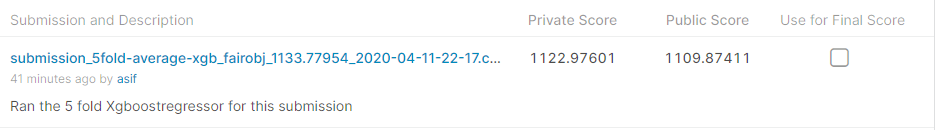

## [1.1] DecisionTreeRegressor for Feature Importance

- Idea behind building this model was only to obtain feature importance from the transformed features using combinations and ordinal encoding

In [2]:
%%time
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler

import itertools

shift = 200
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

fair_constant = 2
def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-shift,
                                      np.exp(yhat)-shift)
def mungeskewed(train, test, numeric_feats):
    ntrain = train.shape[0]
    test['loss'] = 0
    train_test = pd.concat((train, test)).reset_index(drop=True)
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.25]
    skewed_feats = skewed_feats.index

    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1
        train_test[feats], lam = boxcox(train_test[feats])
    return train_test, ntrain

if __name__ == "__main__":

    print('\nStarted')
    directory = '../input/'
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    numeric_feats = [x for x in train.columns[1:-1] if 'cont' in x]
    categorical_feats = [x for x in train.columns[1:-1] if 'cat' in x]
    train_test, ntrain = mungeskewed(train, test, numeric_feats)

    print('')
    for comb in itertools.combinations(COMB_FEATURE, 2):
        feat = comb[0] + "_" + comb[1]
        train_test[feat] = train_test[comb[0]] + train_test[comb[1]]
        train_test[feat] = train_test[feat].apply(encode)
        print('Analyzing Columns:', feat)

    categorical_feats = [x for x in train_test.columns[1:] if 'cat' in x]

    print('')
    for col in categorical_feats:
        print('Analyzing Column:', col)
        train_test[col] = train_test[col].apply(encode)

    print(train_test[categorical_feats])

    ss = StandardScaler()
    train_test[numeric_feats] = \
        ss.fit_transform(train_test[numeric_feats].values)

    train = train_test.iloc[:ntrain, :].copy()
    test = train_test.iloc[ntrain:, :].copy()

    print('\nMedian Loss:', train.loss.median())
    print('Mean Loss:', train.loss.mean())

    ids = pd.read_csv('test.csv')['id']
    train_y = np.log(train['loss'] + shift)
    train_x = train.drop(['loss','id'], axis=1)
    test_x = test.drop(['loss','id'], axis=1)
    X_train,X_cv,y_train,y_cv = train_test_split(train_x,train_y,test_size = 0.20,random_state = 42)
    
    regressor = DecisionTreeRegressor(max_depth = 5,min_samples_split = 10,min_samples_leaf = 50,
                                     max_leaf_nodes = 25, criterion = 'mae',max_features = 100)
    regressor.fit(X_train,y_train)
    y_pred_train = regressor.predict(X_train)
    mae_train = mean_absolute_error(np.exp(y_train),np.exp(y_pred_train))
    #train_scores.append(mae_train)
    y_pred_test = regressor.predict(X_cv)
    mae_test = mean_absolute_error(np.exp(y_cv),np.exp(y_pred_test))
    #test_scores.append(mae_test)
    print('mae_train',mae_train,'mae_test',mae_test)


Started

Analyzing Columns: cat80_cat87
Analyzing Columns: cat80_cat57
Analyzing Columns: cat80_cat12
Analyzing Columns: cat80_cat79
Analyzing Columns: cat80_cat10
Analyzing Columns: cat80_cat7
Analyzing Columns: cat80_cat89
Analyzing Columns: cat80_cat2
Analyzing Columns: cat80_cat72
Analyzing Columns: cat80_cat81
Analyzing Columns: cat80_cat11
Analyzing Columns: cat80_cat1
Analyzing Columns: cat80_cat13
Analyzing Columns: cat80_cat9
Analyzing Columns: cat80_cat3
Analyzing Columns: cat80_cat16
Analyzing Columns: cat80_cat90
Analyzing Columns: cat80_cat23
Analyzing Columns: cat80_cat36
Analyzing Columns: cat80_cat73
Analyzing Columns: cat80_cat103
Analyzing Columns: cat80_cat40
Analyzing Columns: cat80_cat28
Analyzing Columns: cat80_cat111
Analyzing Columns: cat80_cat6
Analyzing Columns: cat80_cat76
Analyzing Columns: cat80_cat50
Analyzing Columns: cat80_cat5
Analyzing Columns: cat80_cat4
Analyzing Columns: cat80_cat14
Analyzing Columns: cat80_cat38
Analyzing Columns: cat80_cat24
Anal

Analyzing Columns: cat2_cat82
Analyzing Columns: cat2_cat25
Analyzing Columns: cat72_cat81
Analyzing Columns: cat72_cat11
Analyzing Columns: cat72_cat1
Analyzing Columns: cat72_cat13
Analyzing Columns: cat72_cat9
Analyzing Columns: cat72_cat3
Analyzing Columns: cat72_cat16
Analyzing Columns: cat72_cat90
Analyzing Columns: cat72_cat23
Analyzing Columns: cat72_cat36
Analyzing Columns: cat72_cat73
Analyzing Columns: cat72_cat103
Analyzing Columns: cat72_cat40
Analyzing Columns: cat72_cat28
Analyzing Columns: cat72_cat111
Analyzing Columns: cat72_cat6
Analyzing Columns: cat72_cat76
Analyzing Columns: cat72_cat50
Analyzing Columns: cat72_cat5
Analyzing Columns: cat72_cat4
Analyzing Columns: cat72_cat14
Analyzing Columns: cat72_cat38
Analyzing Columns: cat72_cat24
Analyzing Columns: cat72_cat82
Analyzing Columns: cat72_cat25
Analyzing Columns: cat81_cat11
Analyzing Columns: cat81_cat1
Analyzing Columns: cat81_cat13
Analyzing Columns: cat81_cat9
Analyzing Columns: cat81_cat3
Analyzing Columns

Analyzing Columns: cat28_cat14
Analyzing Columns: cat28_cat38
Analyzing Columns: cat28_cat24
Analyzing Columns: cat28_cat82
Analyzing Columns: cat28_cat25
Analyzing Columns: cat111_cat6
Analyzing Columns: cat111_cat76
Analyzing Columns: cat111_cat50
Analyzing Columns: cat111_cat5
Analyzing Columns: cat111_cat4
Analyzing Columns: cat111_cat14
Analyzing Columns: cat111_cat38
Analyzing Columns: cat111_cat24
Analyzing Columns: cat111_cat82
Analyzing Columns: cat111_cat25
Analyzing Columns: cat6_cat76
Analyzing Columns: cat6_cat50
Analyzing Columns: cat6_cat5
Analyzing Columns: cat6_cat4
Analyzing Columns: cat6_cat14
Analyzing Columns: cat6_cat38
Analyzing Columns: cat6_cat24
Analyzing Columns: cat6_cat82
Analyzing Columns: cat6_cat25
Analyzing Columns: cat76_cat50
Analyzing Columns: cat76_cat5
Analyzing Columns: cat76_cat4
Analyzing Columns: cat76_cat14
Analyzing Columns: cat76_cat38
Analyzing Columns: cat76_cat24
Analyzing Columns: cat76_cat82
Analyzing Columns: cat76_cat25
Analyzing Colu

Analyzing Column: cat12_cat6
Analyzing Column: cat12_cat76
Analyzing Column: cat12_cat50
Analyzing Column: cat12_cat5
Analyzing Column: cat12_cat4
Analyzing Column: cat12_cat14
Analyzing Column: cat12_cat38
Analyzing Column: cat12_cat24
Analyzing Column: cat12_cat82
Analyzing Column: cat12_cat25
Analyzing Column: cat79_cat10
Analyzing Column: cat79_cat7
Analyzing Column: cat79_cat89
Analyzing Column: cat79_cat2
Analyzing Column: cat79_cat72
Analyzing Column: cat79_cat81
Analyzing Column: cat79_cat11
Analyzing Column: cat79_cat1
Analyzing Column: cat79_cat13
Analyzing Column: cat79_cat9
Analyzing Column: cat79_cat3
Analyzing Column: cat79_cat16
Analyzing Column: cat79_cat90
Analyzing Column: cat79_cat23
Analyzing Column: cat79_cat36
Analyzing Column: cat79_cat73
Analyzing Column: cat79_cat103
Analyzing Column: cat79_cat40
Analyzing Column: cat79_cat28
Analyzing Column: cat79_cat111
Analyzing Column: cat79_cat6
Analyzing Column: cat79_cat76
Analyzing Column: cat79_cat50
Analyzing Column:

Analyzing Column: cat9_cat5
Analyzing Column: cat9_cat4
Analyzing Column: cat9_cat14
Analyzing Column: cat9_cat38
Analyzing Column: cat9_cat24
Analyzing Column: cat9_cat82
Analyzing Column: cat9_cat25
Analyzing Column: cat3_cat16
Analyzing Column: cat3_cat90
Analyzing Column: cat3_cat23
Analyzing Column: cat3_cat36
Analyzing Column: cat3_cat73
Analyzing Column: cat3_cat103
Analyzing Column: cat3_cat40
Analyzing Column: cat3_cat28
Analyzing Column: cat3_cat111
Analyzing Column: cat3_cat6
Analyzing Column: cat3_cat76
Analyzing Column: cat3_cat50
Analyzing Column: cat3_cat5
Analyzing Column: cat3_cat4
Analyzing Column: cat3_cat14
Analyzing Column: cat3_cat38
Analyzing Column: cat3_cat24
Analyzing Column: cat3_cat82
Analyzing Column: cat3_cat25
Analyzing Column: cat16_cat90
Analyzing Column: cat16_cat23
Analyzing Column: cat16_cat36
Analyzing Column: cat16_cat73
Analyzing Column: cat16_cat103
Analyzing Column: cat16_cat40
Analyzing Column: cat16_cat28
Analyzing Column: cat16_cat111
Analyzi


Median Loss: 2115.5699999999997
Mean Loss: 3037.3376856699792
mae_train 1376.537550811794 mae_test 1365.6286239562453
Wall time: 1h 19min 20s


In [3]:
import joblib
joblib.dump(regressor,'decision_tree')
#random_forest = joblib.load('random_forest')

['decision_tree']

In [19]:
import pickle
train_test.to_pickle('G:/Self Case Study 1/allstate-claims-severity/train_test')

In [4]:
feat_labels = train_x.columns
print(feat_labels)

Index(['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9',
       'cat10',
       ...
       'cat14_cat38', 'cat14_cat24', 'cat14_cat82', 'cat14_cat25',
       'cat38_cat24', 'cat38_cat82', 'cat38_cat25', 'cat24_cat82',
       'cat24_cat25', 'cat82_cat25'],
      dtype='object', length=725)


In [5]:
feat_labels = train_x.columns
for feature in zip(feat_labels, regressor.feature_importances_):
    print(feature)

('cat1', 0.0)
('cat2', 0.0)
('cat3', 0.0)
('cat4', 0.0)
('cat5', 0.0)
('cat6', 0.0)
('cat7', 0.0)
('cat8', 0.0)
('cat9', 0.0)
('cat10', 0.0)
('cat11', 0.0)
('cat12', 0.0)
('cat13', 0.0)
('cat14', 0.0)
('cat15', 0.0)
('cat16', 0.0)
('cat17', 0.0)
('cat18', 0.0)
('cat19', 0.0)
('cat20', 0.0)
('cat21', 0.0)
('cat22', 0.0)
('cat23', 0.0)
('cat24', 0.0)
('cat25', 0.0)
('cat26', 0.0)
('cat27', 0.0)
('cat28', 0.0)
('cat29', 0.0)
('cat30', 0.0)
('cat31', 0.0)
('cat32', 0.0)
('cat33', 0.0)
('cat34', 0.0)
('cat35', 0.0)
('cat36', 0.0)
('cat37', 0.0)
('cat38', 0.0)
('cat39', 0.0)
('cat40', 0.0)
('cat41', 0.0)
('cat42', 0.0)
('cat43', 0.0)
('cat44', 0.0)
('cat45', 0.0)
('cat46', 0.0)
('cat47', 0.0)
('cat48', 0.0)
('cat49', 0.0)
('cat50', 0.0)
('cat51', 0.0)
('cat52', 0.0)
('cat53', 0.0)
('cat54', 0.0)
('cat55', 0.0)
('cat56', 0.0)
('cat57', 0.0)
('cat58', 0.0)
('cat59', 0.0)
('cat60', 0.0)
('cat61', 0.0)
('cat62', 0.0)
('cat63', 0.0)
('cat64', 0.0)
('cat65', 0.0)
('cat66', 0.0)
('cat67', 0.0)
('ca

In [6]:
results=pd.DataFrame()
results['columns']=train_x.columns
results['importances'] = regressor.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

results[:22]

columns  importances
131   cat80_cat57     0.580249
236   cat12_cat11     0.101521
288   cat79_cat82     0.064079
704     cat5_cat4     0.058431
427   cat81_cat13     0.034800
218  cat57_cat111     0.022954
305  cat10_cat103     0.019990
477    cat1_cat23     0.019674
252   cat12_cat50     0.018964
234   cat12_cat72     0.012302
310   cat10_cat76     0.009791
421   cat72_cat38     0.008982
558  cat16_cat103     0.007753
108        cat109     0.007183
481    cat1_cat40     0.004592
122         cont7     0.004261
445   cat81_cat38     0.004241
227   cat57_cat82     0.003925
117         cont2     0.003833
366   cat89_cat50     0.003372
399    cat2_cat25     0.003322
91          cat92     0.002870

In [11]:
results.to_csv('feat_importances.csv',index = False)

In [2]:
result = pd.read_csv('feat_importances.csv')

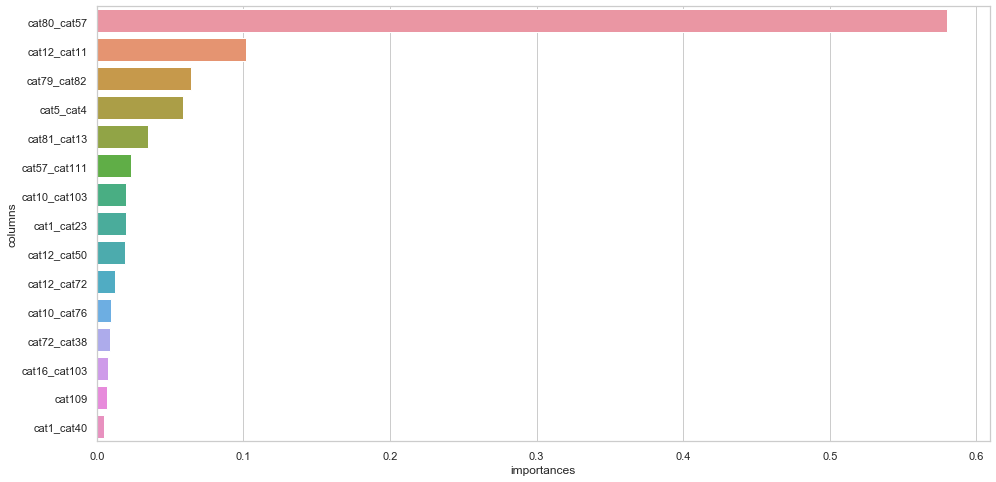

In [3]:
top_15 = result [:15]
sns.set(style="whitegrid")
fig_dims = (16, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = 'importances', y = 'columns', data = top_15, ax = ax)
#ax.set_xlabel('importances')
#plt.show()


In [14]:
result.head(30)

columns  importances
0    cat80_cat57     0.580249
1    cat12_cat11     0.101521
2    cat79_cat82     0.064079
3      cat5_cat4     0.058431
4    cat81_cat13     0.034800
5   cat57_cat111     0.022954
6   cat10_cat103     0.019990
7     cat1_cat23     0.019674
8    cat12_cat50     0.018964
9    cat12_cat72     0.012302
10   cat10_cat76     0.009791
11   cat72_cat38     0.008982
12  cat16_cat103     0.007753
13        cat109     0.007183
14    cat1_cat40     0.004592
15         cont7     0.004261
16   cat81_cat38     0.004241
17   cat57_cat82     0.003925
18         cont2     0.003833
19   cat89_cat50     0.003372
20    cat2_cat25     0.003322
21         cat92     0.002870
22         cont6     0.001764
23        cont12     0.001147
24    cat1_cat50     0.000000
25    cat1_cat14     0.000000
26    cat1_cat24     0.000000
27     cat1_cat4     0.000000
28    cat1_cat82     0.000000
29     cat1_cat5     0.000000

In [15]:
imp_cols = ['cat80_cat57','cat12_cat11','cat79_cat82','cat5_cat4','cat81_cat13','cat57_cat111','cat10_cat103',
           'cat1_cat23','cat12_cat50','cat12_cat72','cat10_cat76','cat72_cat38','cat16_cat103','cat109',
           'cat1_cat40','cont7','cat81_cat38','cat57_cat82','cont2','cat89_cat50','cat2_cat25','cat92',
           'cont6','cont12','cat1_cat50','cat1_cat14']
print(len(imp_cols))

26


## [1.2] XGboostRegressor on imp features

In [2]:
%%time
import numpy as np
import pandas as pd
import xgboost as xgb

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
import itertools

ntrain = 188318
shift = 200
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

fair_constant = 2
def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-shift,
                                      np.exp(yhat)-shift)
def mungeskewed(train, test, numeric_feats):
    ntrain = train.shape[0]
    test['loss'] = 0
    train_test = pd.concat((train, test)).reset_index(drop=True)
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.25]
    skewed_feats = skewed_feats.index

    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1
        train_test[feats], lam = boxcox(train_test[feats])
    return train_test, ntrain

if __name__ == "__main__":

    train_test = pd.read_pickle('train_test')

    numeric_feats = [x for x in train_test.columns[1:-1] if 'cont' in x]
    categorical_feats = [x for x in train_test.columns[1:-1] if 'cat' in x]
    #train_test, ntrain = mungeskewed(train, test, numeric_feats)

    categorical_feats = [x for x in train_test.columns[1:] if 'cat' in x]

    ss = StandardScaler()
    train_test[numeric_feats] = \
        ss.fit_transform(train_test[numeric_feats].values)
    
    imp_cols = ['cat80_cat57','cat12_cat11','cat79_cat82','cat5_cat4','cat81_cat13','cat57_cat111','cat10_cat103',
           'cat1_cat23','cat12_cat50','cat12_cat72','cat10_cat76','cat72_cat38','cat16_cat103','cat109',
           'cat1_cat40','cont7','cat81_cat38','cat57_cat82','cont2','cat89_cat50','cat2_cat25','cat92',
           'cont6','cont12','cat1_cat50','cat1_cat14']

    train_x = train_test.iloc[:ntrain, :].copy()
    test_x = train_test.iloc[ntrain:, :].copy()

    print('\nMedian Loss:', train_x.loss.median())
    print('Mean Loss:', train_x.loss.mean())

    ids = pd.read_csv('test.csv')['id']
    train_y = np.log(train_x['loss'] + shift)
    train_x = train_x.drop(['loss','id'], axis=1)
    test_x = test_x.drop(['loss','id'], axis=1)
    
    #considering imp features only
    train_x = train_x[imp_cols]
    test_x = test_x[imp_cols]

    n_folds = 10
    cv_sum = 0
    early_stopping = 100
    fpred = []
    xgb_rounds = []

    d_train_full = xgb.DMatrix(train_x, label=train_y)
    d_test = xgb.DMatrix(test_x)
    # https://stackoverflow.com/a/48641547
    kf = KFold(n_splits=10)
    for i, (train_index, test_index) in enumerate(kf.split(train_x)):
        print('\n Fold %d' % (i+1))
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[test_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]

        rand_state = 2016

        params = {
            'seed': 0,
            'colsample_bytree': 0.9,
            'silent': 1,
            'subsample': 0.7,
            'learning_rate': 0.01,
            'objective': 'reg:linear',
            'max_depth': 5,
            'min_child_weight': 100,
            'booster': 'gbtree'}

        d_train = xgb.DMatrix(X_train, label=y_train)
        d_valid = xgb.DMatrix(X_val, label=y_val)
        watchlist = [(d_train, 'train'), (d_valid, 'eval')]

        clf = xgb.train(params,
                        d_train,
                        100000,
                        watchlist,
                        early_stopping_rounds=50,
                        obj=fair_obj,
                        feval=xg_eval_mae)

        xgb_rounds.append(clf.best_iteration)
        scores_val = clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)
        cv_score = mean_absolute_error(np.exp(y_val), np.exp(scores_val))
        print('eval-MAE: %.6f' % cv_score)
        y_pred = np.exp(clf.predict(d_test, ntree_limit=clf.best_ntree_limit)) - shift

        if i > 0:
            fpred = pred + y_pred
        else:
            fpred = y_pred
        pred = fpred
        cv_sum = cv_sum + cv_score

    mpred = pred / n_folds
    score = cv_sum / n_folds
    print('Average eval-MAE: %.6f' % score)
    n_rounds = int(np.mean(xgb_rounds))

    print("Writing results")
    result = pd.DataFrame(mpred, columns=['loss'])
    result["id"] = ids
    result = result.set_index("id")
    print("%d-fold average prediction:" % n_folds)

    now = datetime.now()
    score = str(round((cv_sum / n_folds), 6))
    sub_file = 'submission_10fold-average-xgb_fairobj_' + str(score) + '_' + str(
        now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print("Writing submission: %s" % sub_file)
    result.to_csv(sub_file, index=True, index_label='id')


Median Loss: 2115.5699999999997
Mean Loss: 3037.3376856699792

 Fold 1
[0]	train-rmse:7.00107	eval-rmse:7.0018	train-mae:3234.2	eval-mae:3242.53
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[1]	train-rmse:6.69264	eval-rmse:6.69323	train-mae:3233.36	eval-mae:3241.69
[2]	train-rmse:6.40853	eval-rmse:6.40912	train-mae:3232.32	eval-mae:3240.65
[3]	train-rmse:6.14573	eval-rmse:6.14635	train-mae:3231.05	eval-mae:3239.37
[4]	train-rmse:5.90221	eval-rmse:5.90278	train-mae:3229.52	eval-mae:3237.85
[5]	train-rmse:5.67563	eval-rmse:5.67615	train-mae:3227.72	eval-mae:3236.04
[6]	train-rmse:5.46452	eval-rmse:5.46504	train-mae:3225.61	eval-mae:3233.94
[7]	train-rmse:5.26735	eval-rmse:5.26783	train-mae:3223.2	eval-mae:3231.52
[8]	train-rmse:5.08259	eval-rmse:5.08301	train-mae:3220.44	eval-mae:3228.76
[9]	train-rmse:4.90916	eval-rmse:4.90952	train-mae:3217.32	eval-mae:3225.64
[10]	train-rmse:4.74609	eval-r

[105]	train-rmse:0.977373	eval-rmse:0.977402	train-mae:2052.35	eval-mae:2058.54
[106]	train-rmse:0.968957	eval-rmse:0.969002	train-mae:2041.09	eval-mae:2047.23
[107]	train-rmse:0.96069	eval-rmse:0.960755	train-mae:2029.93	eval-mae:2036.04
[108]	train-rmse:0.952562	eval-rmse:0.952643	train-mae:2018.78	eval-mae:2024.81
[109]	train-rmse:0.944605	eval-rmse:0.944699	train-mae:2007.82	eval-mae:2013.78
[110]	train-rmse:0.93681	eval-rmse:0.936932	train-mae:1997.03	eval-mae:2002.97
[111]	train-rmse:0.929145	eval-rmse:0.92928	train-mae:1986.34	eval-mae:1992.22
[112]	train-rmse:0.921603	eval-rmse:0.921755	train-mae:1975.74	eval-mae:1981.56
[113]	train-rmse:0.914262	eval-rmse:0.91443	train-mae:1965.27	eval-mae:1971.02
[114]	train-rmse:0.907057	eval-rmse:0.907243	train-mae:1954.9	eval-mae:1960.59
[115]	train-rmse:0.899971	eval-rmse:0.900169	train-mae:1944.6	eval-mae:1950.22
[116]	train-rmse:0.893015	eval-rmse:0.893225	train-mae:1934.48	eval-mae:1940.04
[117]	train-rmse:0.886175	eval-rmse:0.88641	tr

[208]	train-rmse:0.587081	eval-rmse:0.589221	train-mae:1398.7	eval-mae:1408.28
[209]	train-rmse:0.585809	eval-rmse:0.58797	train-mae:1395.99	eval-mae:1405.63
[210]	train-rmse:0.584566	eval-rmse:0.586743	train-mae:1393.36	eval-mae:1403.05
[211]	train-rmse:0.583331	eval-rmse:0.585528	train-mae:1390.73	eval-mae:1400.48
[212]	train-rmse:0.58213	eval-rmse:0.584342	train-mae:1388.16	eval-mae:1397.97
[213]	train-rmse:0.580955	eval-rmse:0.583179	train-mae:1385.61	eval-mae:1395.47
[214]	train-rmse:0.5798	eval-rmse:0.582041	train-mae:1383.1	eval-mae:1393.02
[215]	train-rmse:0.578654	eval-rmse:0.580909	train-mae:1380.59	eval-mae:1390.56
[216]	train-rmse:0.577525	eval-rmse:0.579796	train-mae:1378.17	eval-mae:1388.2
[217]	train-rmse:0.576434	eval-rmse:0.578727	train-mae:1375.82	eval-mae:1385.92
[218]	train-rmse:0.575362	eval-rmse:0.577677	train-mae:1373.48	eval-mae:1383.64
[219]	train-rmse:0.574303	eval-rmse:0.576638	train-mae:1371.2	eval-mae:1381.43
[220]	train-rmse:0.573267	eval-rmse:0.575624	tra

[311]	train-rmse:0.528463	eval-rmse:0.532064	train-mae:1262.12	eval-mae:1278.36
[312]	train-rmse:0.528278	eval-rmse:0.531895	train-mae:1261.63	eval-mae:1277.94
[313]	train-rmse:0.528098	eval-rmse:0.531722	train-mae:1261.15	eval-mae:1277.49
[314]	train-rmse:0.52792	eval-rmse:0.531553	train-mae:1260.64	eval-mae:1277.04
[315]	train-rmse:0.527747	eval-rmse:0.531388	train-mae:1260.18	eval-mae:1276.61
[316]	train-rmse:0.527567	eval-rmse:0.531217	train-mae:1259.66	eval-mae:1276.15
[317]	train-rmse:0.527398	eval-rmse:0.531051	train-mae:1259.2	eval-mae:1275.72
[318]	train-rmse:0.527228	eval-rmse:0.530892	train-mae:1258.75	eval-mae:1275.31
[319]	train-rmse:0.527064	eval-rmse:0.530743	train-mae:1258.3	eval-mae:1274.92
[320]	train-rmse:0.526885	eval-rmse:0.530572	train-mae:1257.8	eval-mae:1274.48
[321]	train-rmse:0.52673	eval-rmse:0.530427	train-mae:1257.36	eval-mae:1274.1
[322]	train-rmse:0.526573	eval-rmse:0.530281	train-mae:1256.94	eval-mae:1273.72
[323]	train-rmse:0.526406	eval-rmse:0.53012	tr

[414]	train-rmse:0.519354	eval-rmse:0.523686	train-mae:1234.99	eval-mae:1254.45
[415]	train-rmse:0.519322	eval-rmse:0.523657	train-mae:1234.88	eval-mae:1254.36
[416]	train-rmse:0.519287	eval-rmse:0.523628	train-mae:1234.75	eval-mae:1254.25
[417]	train-rmse:0.519252	eval-rmse:0.523599	train-mae:1234.63	eval-mae:1254.14
[418]	train-rmse:0.519222	eval-rmse:0.523576	train-mae:1234.52	eval-mae:1254.05
[419]	train-rmse:0.519191	eval-rmse:0.52355	train-mae:1234.4	eval-mae:1253.96
[420]	train-rmse:0.519161	eval-rmse:0.523524	train-mae:1234.29	eval-mae:1253.87
[421]	train-rmse:0.519131	eval-rmse:0.523501	train-mae:1234.19	eval-mae:1253.79
[422]	train-rmse:0.519105	eval-rmse:0.523477	train-mae:1234.08	eval-mae:1253.7
[423]	train-rmse:0.519072	eval-rmse:0.523452	train-mae:1233.97	eval-mae:1253.61
[424]	train-rmse:0.51904	eval-rmse:0.523423	train-mae:1233.86	eval-mae:1253.52
[425]	train-rmse:0.519004	eval-rmse:0.523395	train-mae:1233.73	eval-mae:1253.41
[426]	train-rmse:0.518979	eval-rmse:0.523373

[518]	train-rmse:0.517221	eval-rmse:0.52196	train-mae:1227.18	eval-mae:1247.99
[519]	train-rmse:0.517203	eval-rmse:0.521946	train-mae:1227.12	eval-mae:1247.93
[520]	train-rmse:0.517192	eval-rmse:0.521939	train-mae:1227.07	eval-mae:1247.9
[521]	train-rmse:0.517177	eval-rmse:0.521925	train-mae:1227.02	eval-mae:1247.85
[522]	train-rmse:0.517159	eval-rmse:0.521911	train-mae:1226.94	eval-mae:1247.81
[523]	train-rmse:0.517147	eval-rmse:0.521906	train-mae:1226.9	eval-mae:1247.78
[524]	train-rmse:0.517134	eval-rmse:0.521894	train-mae:1226.85	eval-mae:1247.74
[525]	train-rmse:0.517126	eval-rmse:0.521888	train-mae:1226.81	eval-mae:1247.71
[526]	train-rmse:0.517118	eval-rmse:0.521885	train-mae:1226.78	eval-mae:1247.69
[527]	train-rmse:0.517108	eval-rmse:0.521881	train-mae:1226.73	eval-mae:1247.68
[528]	train-rmse:0.517094	eval-rmse:0.521875	train-mae:1226.67	eval-mae:1247.63
[529]	train-rmse:0.517084	eval-rmse:0.521868	train-mae:1226.64	eval-mae:1247.61
[530]	train-rmse:0.517075	eval-rmse:0.52186

[621]	train-rmse:0.516135	eval-rmse:0.521242	train-mae:1223.12	eval-mae:1245.02
[622]	train-rmse:0.516126	eval-rmse:0.521233	train-mae:1223.09	eval-mae:1244.98
[623]	train-rmse:0.516122	eval-rmse:0.521231	train-mae:1223.07	eval-mae:1244.97
[624]	train-rmse:0.516112	eval-rmse:0.521224	train-mae:1223.03	eval-mae:1244.94
[625]	train-rmse:0.516107	eval-rmse:0.52122	train-mae:1223.02	eval-mae:1244.93
[626]	train-rmse:0.516099	eval-rmse:0.521216	train-mae:1222.99	eval-mae:1244.91
[627]	train-rmse:0.516093	eval-rmse:0.521213	train-mae:1222.96	eval-mae:1244.88
[628]	train-rmse:0.516087	eval-rmse:0.521212	train-mae:1222.94	eval-mae:1244.87
[629]	train-rmse:0.516081	eval-rmse:0.521205	train-mae:1222.92	eval-mae:1244.84
[630]	train-rmse:0.516068	eval-rmse:0.521198	train-mae:1222.88	eval-mae:1244.82
[631]	train-rmse:0.516059	eval-rmse:0.521198	train-mae:1222.84	eval-mae:1244.81
[632]	train-rmse:0.516054	eval-rmse:0.521194	train-mae:1222.82	eval-mae:1244.8
[633]	train-rmse:0.516046	eval-rmse:0.5211

[724]	train-rmse:0.515329	eval-rmse:0.520712	train-mae:1220.33	eval-mae:1242.97
[725]	train-rmse:0.515324	eval-rmse:0.520709	train-mae:1220.32	eval-mae:1242.97
[726]	train-rmse:0.515318	eval-rmse:0.520707	train-mae:1220.3	eval-mae:1242.96
[727]	train-rmse:0.515312	eval-rmse:0.520703	train-mae:1220.29	eval-mae:1242.96
[728]	train-rmse:0.515305	eval-rmse:0.520701	train-mae:1220.26	eval-mae:1242.94
[729]	train-rmse:0.515298	eval-rmse:0.520694	train-mae:1220.23	eval-mae:1242.9
[730]	train-rmse:0.515291	eval-rmse:0.520691	train-mae:1220.2	eval-mae:1242.88
[731]	train-rmse:0.515287	eval-rmse:0.520692	train-mae:1220.18	eval-mae:1242.89
[732]	train-rmse:0.515283	eval-rmse:0.52069	train-mae:1220.16	eval-mae:1242.87
[733]	train-rmse:0.515277	eval-rmse:0.520686	train-mae:1220.15	eval-mae:1242.86
[734]	train-rmse:0.515269	eval-rmse:0.520685	train-mae:1220.12	eval-mae:1242.85
[735]	train-rmse:0.515261	eval-rmse:0.520677	train-mae:1220.1	eval-mae:1242.83
[736]	train-rmse:0.515246	eval-rmse:0.52066	t

[827]	train-rmse:0.514653	eval-rmse:0.520325	train-mae:1218.07	eval-mae:1241.53
[828]	train-rmse:0.514644	eval-rmse:0.52032	train-mae:1218.04	eval-mae:1241.51
[829]	train-rmse:0.514637	eval-rmse:0.520316	train-mae:1218.02	eval-mae:1241.5
[830]	train-rmse:0.514633	eval-rmse:0.520316	train-mae:1218.01	eval-mae:1241.5
[831]	train-rmse:0.514623	eval-rmse:0.520313	train-mae:1217.98	eval-mae:1241.48
[832]	train-rmse:0.514619	eval-rmse:0.520309	train-mae:1217.95	eval-mae:1241.46
[833]	train-rmse:0.514614	eval-rmse:0.520309	train-mae:1217.93	eval-mae:1241.45
[834]	train-rmse:0.514598	eval-rmse:0.520297	train-mae:1217.89	eval-mae:1241.42
[835]	train-rmse:0.514593	eval-rmse:0.520292	train-mae:1217.87	eval-mae:1241.4
[836]	train-rmse:0.514589	eval-rmse:0.52029	train-mae:1217.85	eval-mae:1241.39
[837]	train-rmse:0.514581	eval-rmse:0.520284	train-mae:1217.83	eval-mae:1241.37
[838]	train-rmse:0.514577	eval-rmse:0.520284	train-mae:1217.81	eval-mae:1241.36
[839]	train-rmse:0.514571	eval-rmse:0.520277	

[931]	train-rmse:0.514079	eval-rmse:0.520019	train-mae:1216.19	eval-mae:1240.37
[932]	train-rmse:0.514075	eval-rmse:0.520018	train-mae:1216.18	eval-mae:1240.36
[933]	train-rmse:0.514069	eval-rmse:0.520012	train-mae:1216.15	eval-mae:1240.34
[934]	train-rmse:0.514061	eval-rmse:0.520007	train-mae:1216.14	eval-mae:1240.33
[935]	train-rmse:0.514057	eval-rmse:0.520006	train-mae:1216.13	eval-mae:1240.33
[936]	train-rmse:0.514051	eval-rmse:0.520003	train-mae:1216.11	eval-mae:1240.31
[937]	train-rmse:0.514044	eval-rmse:0.519999	train-mae:1216.09	eval-mae:1240.29
[938]	train-rmse:0.514041	eval-rmse:0.519997	train-mae:1216.08	eval-mae:1240.28
[939]	train-rmse:0.514029	eval-rmse:0.51999	train-mae:1216.04	eval-mae:1240.25
[940]	train-rmse:0.514024	eval-rmse:0.519987	train-mae:1216.02	eval-mae:1240.24
[941]	train-rmse:0.514021	eval-rmse:0.519985	train-mae:1216.01	eval-mae:1240.23
[942]	train-rmse:0.514015	eval-rmse:0.519981	train-mae:1216	eval-mae:1240.22
[943]	train-rmse:0.514008	eval-rmse:0.519977

[1034]	train-rmse:0.513518	eval-rmse:0.519726	train-mae:1214.36	eval-mae:1239.27
[1035]	train-rmse:0.513512	eval-rmse:0.519724	train-mae:1214.34	eval-mae:1239.27
[1036]	train-rmse:0.51351	eval-rmse:0.519726	train-mae:1214.34	eval-mae:1239.27
[1037]	train-rmse:0.513507	eval-rmse:0.519725	train-mae:1214.33	eval-mae:1239.27
[1038]	train-rmse:0.513503	eval-rmse:0.519723	train-mae:1214.32	eval-mae:1239.27
[1039]	train-rmse:0.513497	eval-rmse:0.519721	train-mae:1214.3	eval-mae:1239.27
[1040]	train-rmse:0.513491	eval-rmse:0.519718	train-mae:1214.28	eval-mae:1239.25
[1041]	train-rmse:0.513488	eval-rmse:0.519715	train-mae:1214.26	eval-mae:1239.25
[1042]	train-rmse:0.513478	eval-rmse:0.519712	train-mae:1214.24	eval-mae:1239.23
[1043]	train-rmse:0.513475	eval-rmse:0.519708	train-mae:1214.23	eval-mae:1239.22
[1044]	train-rmse:0.513473	eval-rmse:0.519707	train-mae:1214.22	eval-mae:1239.22
[1045]	train-rmse:0.513469	eval-rmse:0.519704	train-mae:1214.2	eval-mae:1239.21
[1046]	train-rmse:0.513464	eval

[1136]	train-rmse:0.513012	eval-rmse:0.51944	train-mae:1212.76	eval-mae:1238.32
[1137]	train-rmse:0.513006	eval-rmse:0.519437	train-mae:1212.74	eval-mae:1238.3
[1138]	train-rmse:0.513002	eval-rmse:0.519434	train-mae:1212.73	eval-mae:1238.3
[1139]	train-rmse:0.512997	eval-rmse:0.519431	train-mae:1212.71	eval-mae:1238.29
[1140]	train-rmse:0.512992	eval-rmse:0.51943	train-mae:1212.7	eval-mae:1238.28
[1141]	train-rmse:0.512989	eval-rmse:0.519427	train-mae:1212.69	eval-mae:1238.28
[1142]	train-rmse:0.512986	eval-rmse:0.519424	train-mae:1212.68	eval-mae:1238.26
[1143]	train-rmse:0.512985	eval-rmse:0.519423	train-mae:1212.68	eval-mae:1238.25
[1144]	train-rmse:0.512983	eval-rmse:0.519422	train-mae:1212.67	eval-mae:1238.25
[1145]	train-rmse:0.512975	eval-rmse:0.519418	train-mae:1212.65	eval-mae:1238.23
[1146]	train-rmse:0.512973	eval-rmse:0.519417	train-mae:1212.64	eval-mae:1238.23
[1147]	train-rmse:0.512967	eval-rmse:0.519415	train-mae:1212.63	eval-mae:1238.21
[1148]	train-rmse:0.512961	eval-r

[1238]	train-rmse:0.512574	eval-rmse:0.519217	train-mae:1211.38	eval-mae:1237.55
[1239]	train-rmse:0.512569	eval-rmse:0.519217	train-mae:1211.36	eval-mae:1237.55
[1240]	train-rmse:0.512566	eval-rmse:0.519216	train-mae:1211.35	eval-mae:1237.55
[1241]	train-rmse:0.512564	eval-rmse:0.519215	train-mae:1211.34	eval-mae:1237.54
[1242]	train-rmse:0.512563	eval-rmse:0.519215	train-mae:1211.33	eval-mae:1237.53
[1243]	train-rmse:0.512558	eval-rmse:0.519208	train-mae:1211.32	eval-mae:1237.52
[1244]	train-rmse:0.512552	eval-rmse:0.519205	train-mae:1211.29	eval-mae:1237.51
[1245]	train-rmse:0.512546	eval-rmse:0.519198	train-mae:1211.27	eval-mae:1237.49
[1246]	train-rmse:0.512541	eval-rmse:0.519197	train-mae:1211.26	eval-mae:1237.49
[1247]	train-rmse:0.51254	eval-rmse:0.519197	train-mae:1211.25	eval-mae:1237.49
[1248]	train-rmse:0.512534	eval-rmse:0.519196	train-mae:1211.24	eval-mae:1237.48
[1249]	train-rmse:0.512534	eval-rmse:0.519195	train-mae:1211.23	eval-mae:1237.47
[1250]	train-rmse:0.512532	ev

[1340]	train-rmse:0.512183	eval-rmse:0.519037	train-mae:1210.13	eval-mae:1236.95
[1341]	train-rmse:0.512178	eval-rmse:0.519031	train-mae:1210.11	eval-mae:1236.94
[1342]	train-rmse:0.512174	eval-rmse:0.519029	train-mae:1210.1	eval-mae:1236.94
[1343]	train-rmse:0.512169	eval-rmse:0.519027	train-mae:1210.09	eval-mae:1236.94
[1344]	train-rmse:0.512169	eval-rmse:0.519027	train-mae:1210.08	eval-mae:1236.94
[1345]	train-rmse:0.512165	eval-rmse:0.519026	train-mae:1210.07	eval-mae:1236.93
[1346]	train-rmse:0.512157	eval-rmse:0.519025	train-mae:1210.05	eval-mae:1236.92
[1347]	train-rmse:0.512155	eval-rmse:0.519023	train-mae:1210.05	eval-mae:1236.92
[1348]	train-rmse:0.51215	eval-rmse:0.51902	train-mae:1210.03	eval-mae:1236.92
[1349]	train-rmse:0.512148	eval-rmse:0.519019	train-mae:1210.01	eval-mae:1236.89
[1350]	train-rmse:0.512144	eval-rmse:0.519018	train-mae:1210	eval-mae:1236.88
[1351]	train-rmse:0.512141	eval-rmse:0.519018	train-mae:1209.99	eval-mae:1236.88
[1352]	train-rmse:0.512138	eval-rm

[1442]	train-rmse:0.511808	eval-rmse:0.518888	train-mae:1208.94	eval-mae:1236.42
[1443]	train-rmse:0.511805	eval-rmse:0.518886	train-mae:1208.93	eval-mae:1236.41
[1444]	train-rmse:0.511801	eval-rmse:0.518883	train-mae:1208.92	eval-mae:1236.4
[1445]	train-rmse:0.511797	eval-rmse:0.51888	train-mae:1208.91	eval-mae:1236.38
[1446]	train-rmse:0.511797	eval-rmse:0.518879	train-mae:1208.91	eval-mae:1236.38
[1447]	train-rmse:0.511796	eval-rmse:0.518878	train-mae:1208.91	eval-mae:1236.38
[1448]	train-rmse:0.511792	eval-rmse:0.518878	train-mae:1208.9	eval-mae:1236.37
[1449]	train-rmse:0.511789	eval-rmse:0.518876	train-mae:1208.88	eval-mae:1236.36
[1450]	train-rmse:0.511785	eval-rmse:0.518874	train-mae:1208.87	eval-mae:1236.36
[1451]	train-rmse:0.511784	eval-rmse:0.518875	train-mae:1208.87	eval-mae:1236.37
[1452]	train-rmse:0.51178	eval-rmse:0.518872	train-mae:1208.86	eval-mae:1236.36
[1453]	train-rmse:0.511777	eval-rmse:0.518871	train-mae:1208.85	eval-mae:1236.35
[1454]	train-rmse:0.511775	eval-

[1544]	train-rmse:0.511445	eval-rmse:0.518709	train-mae:1207.81	eval-mae:1235.75
[1545]	train-rmse:0.51144	eval-rmse:0.518705	train-mae:1207.8	eval-mae:1235.74
[1546]	train-rmse:0.511439	eval-rmse:0.518705	train-mae:1207.8	eval-mae:1235.75
[1547]	train-rmse:0.511434	eval-rmse:0.518703	train-mae:1207.78	eval-mae:1235.74
[1548]	train-rmse:0.511431	eval-rmse:0.518703	train-mae:1207.77	eval-mae:1235.74
[1549]	train-rmse:0.511425	eval-rmse:0.518699	train-mae:1207.75	eval-mae:1235.73
[1550]	train-rmse:0.511422	eval-rmse:0.518699	train-mae:1207.75	eval-mae:1235.72
[1551]	train-rmse:0.511419	eval-rmse:0.518698	train-mae:1207.74	eval-mae:1235.72
[1552]	train-rmse:0.511416	eval-rmse:0.518697	train-mae:1207.72	eval-mae:1235.72
[1553]	train-rmse:0.511412	eval-rmse:0.518694	train-mae:1207.71	eval-mae:1235.72
[1554]	train-rmse:0.511407	eval-rmse:0.518695	train-mae:1207.7	eval-mae:1235.72
[1555]	train-rmse:0.511406	eval-rmse:0.518696	train-mae:1207.69	eval-mae:1235.73
[1556]	train-rmse:0.511403	eval-

[1646]	train-rmse:0.511098	eval-rmse:0.518583	train-mae:1206.68	eval-mae:1235.28
[1647]	train-rmse:0.511095	eval-rmse:0.518582	train-mae:1206.67	eval-mae:1235.27
[1648]	train-rmse:0.511091	eval-rmse:0.518578	train-mae:1206.66	eval-mae:1235.26
[1649]	train-rmse:0.511085	eval-rmse:0.518573	train-mae:1206.64	eval-mae:1235.24
[1650]	train-rmse:0.511081	eval-rmse:0.518572	train-mae:1206.64	eval-mae:1235.24
[1651]	train-rmse:0.511079	eval-rmse:0.51857	train-mae:1206.63	eval-mae:1235.24
[1652]	train-rmse:0.511078	eval-rmse:0.518571	train-mae:1206.63	eval-mae:1235.24
[1653]	train-rmse:0.511076	eval-rmse:0.518569	train-mae:1206.62	eval-mae:1235.23
[1654]	train-rmse:0.511071	eval-rmse:0.518567	train-mae:1206.6	eval-mae:1235.23
[1655]	train-rmse:0.511067	eval-rmse:0.518566	train-mae:1206.59	eval-mae:1235.22
[1656]	train-rmse:0.511063	eval-rmse:0.518562	train-mae:1206.57	eval-mae:1235.2
[1657]	train-rmse:0.511062	eval-rmse:0.518562	train-mae:1206.56	eval-mae:1235.2
[1658]	train-rmse:0.511056	eval-

[1748]	train-rmse:0.510725	eval-rmse:0.518418	train-mae:1205.47	eval-mae:1234.69
[1749]	train-rmse:0.510724	eval-rmse:0.518417	train-mae:1205.47	eval-mae:1234.69
[1750]	train-rmse:0.510721	eval-rmse:0.518416	train-mae:1205.46	eval-mae:1234.69
[1751]	train-rmse:0.510718	eval-rmse:0.518415	train-mae:1205.45	eval-mae:1234.69
[1752]	train-rmse:0.510714	eval-rmse:0.518412	train-mae:1205.44	eval-mae:1234.68
[1753]	train-rmse:0.51071	eval-rmse:0.518411	train-mae:1205.43	eval-mae:1234.67
[1754]	train-rmse:0.510707	eval-rmse:0.51841	train-mae:1205.42	eval-mae:1234.66
[1755]	train-rmse:0.510706	eval-rmse:0.51841	train-mae:1205.42	eval-mae:1234.66
[1756]	train-rmse:0.510705	eval-rmse:0.51841	train-mae:1205.41	eval-mae:1234.66
[1757]	train-rmse:0.510702	eval-rmse:0.518409	train-mae:1205.4	eval-mae:1234.65
[1758]	train-rmse:0.510697	eval-rmse:0.518407	train-mae:1205.38	eval-mae:1234.64
[1759]	train-rmse:0.510694	eval-rmse:0.518405	train-mae:1205.38	eval-mae:1234.63
[1760]	train-rmse:0.510691	eval-r

[1850]	train-rmse:0.510423	eval-rmse:0.5183	train-mae:1204.55	eval-mae:1234.34
[1851]	train-rmse:0.51042	eval-rmse:0.518301	train-mae:1204.55	eval-mae:1234.34
[1852]	train-rmse:0.510417	eval-rmse:0.518301	train-mae:1204.53	eval-mae:1234.33
[1853]	train-rmse:0.510412	eval-rmse:0.5183	train-mae:1204.52	eval-mae:1234.33
[1854]	train-rmse:0.510407	eval-rmse:0.5183	train-mae:1204.5	eval-mae:1234.32
[1855]	train-rmse:0.510407	eval-rmse:0.5183	train-mae:1204.5	eval-mae:1234.33
[1856]	train-rmse:0.510404	eval-rmse:0.518302	train-mae:1204.49	eval-mae:1234.33
[1857]	train-rmse:0.510402	eval-rmse:0.518303	train-mae:1204.48	eval-mae:1234.34
[1858]	train-rmse:0.510398	eval-rmse:0.518302	train-mae:1204.47	eval-mae:1234.33
[1859]	train-rmse:0.510396	eval-rmse:0.5183	train-mae:1204.46	eval-mae:1234.33
[1860]	train-rmse:0.510391	eval-rmse:0.518296	train-mae:1204.44	eval-mae:1234.3
[1861]	train-rmse:0.510388	eval-rmse:0.518294	train-mae:1204.43	eval-mae:1234.31
[1862]	train-rmse:0.51038	eval-rmse:0.5182

[1952]	train-rmse:0.510132	eval-rmse:0.518191	train-mae:1203.62	eval-mae:1233.94
[1953]	train-rmse:0.510128	eval-rmse:0.518187	train-mae:1203.61	eval-mae:1233.93
[1954]	train-rmse:0.510123	eval-rmse:0.518185	train-mae:1203.6	eval-mae:1233.93
[1955]	train-rmse:0.510119	eval-rmse:0.518183	train-mae:1203.59	eval-mae:1233.92
[1956]	train-rmse:0.510114	eval-rmse:0.518179	train-mae:1203.58	eval-mae:1233.91
[1957]	train-rmse:0.510112	eval-rmse:0.518178	train-mae:1203.57	eval-mae:1233.9
[1958]	train-rmse:0.510111	eval-rmse:0.518177	train-mae:1203.57	eval-mae:1233.9
[1959]	train-rmse:0.510107	eval-rmse:0.518177	train-mae:1203.55	eval-mae:1233.9
[1960]	train-rmse:0.510103	eval-rmse:0.518176	train-mae:1203.53	eval-mae:1233.89
[1961]	train-rmse:0.510098	eval-rmse:0.518178	train-mae:1203.5	eval-mae:1233.89
[1962]	train-rmse:0.510095	eval-rmse:0.518177	train-mae:1203.5	eval-mae:1233.89
[1963]	train-rmse:0.510093	eval-rmse:0.518177	train-mae:1203.49	eval-mae:1233.88
[1964]	train-rmse:0.510092	eval-rm

[2054]	train-rmse:0.509839	eval-rmse:0.518097	train-mae:1202.73	eval-mae:1233.61
[2055]	train-rmse:0.509834	eval-rmse:0.518094	train-mae:1202.71	eval-mae:1233.6
[2056]	train-rmse:0.509833	eval-rmse:0.518093	train-mae:1202.71	eval-mae:1233.6
[2057]	train-rmse:0.50983	eval-rmse:0.518092	train-mae:1202.7	eval-mae:1233.6
[2058]	train-rmse:0.509828	eval-rmse:0.518089	train-mae:1202.69	eval-mae:1233.58
[2059]	train-rmse:0.509827	eval-rmse:0.518091	train-mae:1202.69	eval-mae:1233.59
[2060]	train-rmse:0.509825	eval-rmse:0.51809	train-mae:1202.68	eval-mae:1233.59
[2061]	train-rmse:0.509823	eval-rmse:0.518092	train-mae:1202.67	eval-mae:1233.6
[2062]	train-rmse:0.509817	eval-rmse:0.518089	train-mae:1202.65	eval-mae:1233.58
[2063]	train-rmse:0.509813	eval-rmse:0.518088	train-mae:1202.64	eval-mae:1233.57
[2064]	train-rmse:0.509806	eval-rmse:0.518086	train-mae:1202.63	eval-mae:1233.57
[2065]	train-rmse:0.509806	eval-rmse:0.518087	train-mae:1202.63	eval-mae:1233.57
[2066]	train-rmse:0.509802	eval-rms

[2156]	train-rmse:0.509574	eval-rmse:0.518003	train-mae:1201.95	eval-mae:1233.31
[2157]	train-rmse:0.509568	eval-rmse:0.518001	train-mae:1201.94	eval-mae:1233.3
[2158]	train-rmse:0.509566	eval-rmse:0.518001	train-mae:1201.93	eval-mae:1233.29
[2159]	train-rmse:0.50956	eval-rmse:0.517995	train-mae:1201.91	eval-mae:1233.28
[2160]	train-rmse:0.509556	eval-rmse:0.517993	train-mae:1201.9	eval-mae:1233.27
[2161]	train-rmse:0.509554	eval-rmse:0.517993	train-mae:1201.89	eval-mae:1233.27
[2162]	train-rmse:0.509552	eval-rmse:0.517994	train-mae:1201.88	eval-mae:1233.27
[2163]	train-rmse:0.50955	eval-rmse:0.517994	train-mae:1201.88	eval-mae:1233.28
[2164]	train-rmse:0.509546	eval-rmse:0.517992	train-mae:1201.87	eval-mae:1233.27
[2165]	train-rmse:0.509544	eval-rmse:0.51799	train-mae:1201.86	eval-mae:1233.26
[2166]	train-rmse:0.509539	eval-rmse:0.51799	train-mae:1201.85	eval-mae:1233.26
[2167]	train-rmse:0.509538	eval-rmse:0.51799	train-mae:1201.85	eval-mae:1233.26
[2168]	train-rmse:0.509535	eval-rms

[2258]	train-rmse:0.5093	eval-rmse:0.517927	train-mae:1201.07	eval-mae:1233.04
[2259]	train-rmse:0.509298	eval-rmse:0.517926	train-mae:1201.06	eval-mae:1233.04
[2260]	train-rmse:0.509296	eval-rmse:0.517925	train-mae:1201.06	eval-mae:1233.03
[2261]	train-rmse:0.509292	eval-rmse:0.517923	train-mae:1201.04	eval-mae:1233.03
[2262]	train-rmse:0.509292	eval-rmse:0.517923	train-mae:1201.04	eval-mae:1233.03
[2263]	train-rmse:0.50929	eval-rmse:0.517922	train-mae:1201.04	eval-mae:1233.03
[2264]	train-rmse:0.509283	eval-rmse:0.517917	train-mae:1201.02	eval-mae:1233.01
[2265]	train-rmse:0.509282	eval-rmse:0.517917	train-mae:1201.01	eval-mae:1233.01
[2266]	train-rmse:0.50928	eval-rmse:0.517917	train-mae:1201	eval-mae:1233.01
[2267]	train-rmse:0.509278	eval-rmse:0.517915	train-mae:1201	eval-mae:1233
[2268]	train-rmse:0.509272	eval-rmse:0.517913	train-mae:1200.99	eval-mae:1233
[2269]	train-rmse:0.509269	eval-rmse:0.517913	train-mae:1200.97	eval-mae:1233
[2270]	train-rmse:0.509264	eval-rmse:0.517911	t

[2361]	train-rmse:0.509061	eval-rmse:0.517846	train-mae:1200.39	eval-mae:1232.79
[2362]	train-rmse:0.509059	eval-rmse:0.517846	train-mae:1200.38	eval-mae:1232.78
[2363]	train-rmse:0.509057	eval-rmse:0.517847	train-mae:1200.37	eval-mae:1232.78
[2364]	train-rmse:0.509054	eval-rmse:0.517846	train-mae:1200.36	eval-mae:1232.78
[2365]	train-rmse:0.509053	eval-rmse:0.517846	train-mae:1200.36	eval-mae:1232.78
[2366]	train-rmse:0.509049	eval-rmse:0.517843	train-mae:1200.35	eval-mae:1232.78
[2367]	train-rmse:0.509046	eval-rmse:0.517841	train-mae:1200.34	eval-mae:1232.79
[2368]	train-rmse:0.509045	eval-rmse:0.51784	train-mae:1200.34	eval-mae:1232.78
[2369]	train-rmse:0.509044	eval-rmse:0.517839	train-mae:1200.34	eval-mae:1232.77
[2370]	train-rmse:0.509043	eval-rmse:0.517839	train-mae:1200.33	eval-mae:1232.77
[2371]	train-rmse:0.509041	eval-rmse:0.517838	train-mae:1200.33	eval-mae:1232.77
[2372]	train-rmse:0.509039	eval-rmse:0.517838	train-mae:1200.31	eval-mae:1232.76
[2373]	train-rmse:0.509038	ev

[2463]	train-rmse:0.508824	eval-rmse:0.517772	train-mae:1199.66	eval-mae:1232.53
[2464]	train-rmse:0.508821	eval-rmse:0.517771	train-mae:1199.65	eval-mae:1232.53
[2465]	train-rmse:0.50882	eval-rmse:0.51777	train-mae:1199.65	eval-mae:1232.52
[2466]	train-rmse:0.508817	eval-rmse:0.51777	train-mae:1199.64	eval-mae:1232.53
[2467]	train-rmse:0.508815	eval-rmse:0.517769	train-mae:1199.63	eval-mae:1232.52
[2468]	train-rmse:0.508812	eval-rmse:0.517769	train-mae:1199.62	eval-mae:1232.52
[2469]	train-rmse:0.508811	eval-rmse:0.517769	train-mae:1199.62	eval-mae:1232.52
[2470]	train-rmse:0.508809	eval-rmse:0.517768	train-mae:1199.62	eval-mae:1232.52
[2471]	train-rmse:0.508806	eval-rmse:0.517767	train-mae:1199.61	eval-mae:1232.52
[2472]	train-rmse:0.508804	eval-rmse:0.517766	train-mae:1199.61	eval-mae:1232.51
[2473]	train-rmse:0.508803	eval-rmse:0.517766	train-mae:1199.6	eval-mae:1232.51
[2474]	train-rmse:0.508801	eval-rmse:0.517766	train-mae:1199.6	eval-mae:1232.51
[2475]	train-rmse:0.508797	eval-r

[2565]	train-rmse:0.508594	eval-rmse:0.517704	train-mae:1198.95	eval-mae:1232.28
[2566]	train-rmse:0.508591	eval-rmse:0.517703	train-mae:1198.94	eval-mae:1232.28
[2567]	train-rmse:0.508589	eval-rmse:0.517702	train-mae:1198.94	eval-mae:1232.28
[2568]	train-rmse:0.508586	eval-rmse:0.517704	train-mae:1198.93	eval-mae:1232.28
[2569]	train-rmse:0.508585	eval-rmse:0.517702	train-mae:1198.92	eval-mae:1232.27
[2570]	train-rmse:0.508584	eval-rmse:0.517702	train-mae:1198.92	eval-mae:1232.27
[2571]	train-rmse:0.508583	eval-rmse:0.517701	train-mae:1198.92	eval-mae:1232.27
[2572]	train-rmse:0.508582	eval-rmse:0.517699	train-mae:1198.9	eval-mae:1232.26
[2573]	train-rmse:0.508578	eval-rmse:0.517697	train-mae:1198.9	eval-mae:1232.26
[2574]	train-rmse:0.508573	eval-rmse:0.517696	train-mae:1198.88	eval-mae:1232.26
[2575]	train-rmse:0.508566	eval-rmse:0.517691	train-mae:1198.86	eval-mae:1232.25
[2576]	train-rmse:0.508562	eval-rmse:0.517689	train-mae:1198.85	eval-mae:1232.25
[2577]	train-rmse:0.508561	eva

[2667]	train-rmse:0.508347	eval-rmse:0.517617	train-mae:1198.24	eval-mae:1232.11
[2668]	train-rmse:0.508344	eval-rmse:0.517617	train-mae:1198.22	eval-mae:1232.11
[2669]	train-rmse:0.508339	eval-rmse:0.517613	train-mae:1198.21	eval-mae:1232.1
[2670]	train-rmse:0.508337	eval-rmse:0.517612	train-mae:1198.2	eval-mae:1232.1
[2671]	train-rmse:0.508334	eval-rmse:0.517611	train-mae:1198.2	eval-mae:1232.1
[2672]	train-rmse:0.508333	eval-rmse:0.517609	train-mae:1198.2	eval-mae:1232.1
[2673]	train-rmse:0.508332	eval-rmse:0.517608	train-mae:1198.19	eval-mae:1232.1
[2674]	train-rmse:0.508329	eval-rmse:0.517606	train-mae:1198.19	eval-mae:1232.09
[2675]	train-rmse:0.508327	eval-rmse:0.517603	train-mae:1198.18	eval-mae:1232.09
[2676]	train-rmse:0.508323	eval-rmse:0.517602	train-mae:1198.17	eval-mae:1232.09
[2677]	train-rmse:0.50832	eval-rmse:0.517602	train-mae:1198.16	eval-mae:1232.09
[2678]	train-rmse:0.508316	eval-rmse:0.517601	train-mae:1198.15	eval-mae:1232.1
[2679]	train-rmse:0.508315	eval-rmse:0

[2770]	train-rmse:0.508136	eval-rmse:0.517557	train-mae:1197.63	eval-mae:1231.92
[2771]	train-rmse:0.508134	eval-rmse:0.517557	train-mae:1197.63	eval-mae:1231.92
[2772]	train-rmse:0.508133	eval-rmse:0.517558	train-mae:1197.62	eval-mae:1231.92
[2773]	train-rmse:0.508132	eval-rmse:0.517558	train-mae:1197.62	eval-mae:1231.92
[2774]	train-rmse:0.508131	eval-rmse:0.517557	train-mae:1197.61	eval-mae:1231.91
[2775]	train-rmse:0.50813	eval-rmse:0.517556	train-mae:1197.61	eval-mae:1231.91
[2776]	train-rmse:0.508129	eval-rmse:0.517556	train-mae:1197.61	eval-mae:1231.91
[2777]	train-rmse:0.508127	eval-rmse:0.517555	train-mae:1197.6	eval-mae:1231.9
[2778]	train-rmse:0.508124	eval-rmse:0.517555	train-mae:1197.59	eval-mae:1231.9
[2779]	train-rmse:0.508122	eval-rmse:0.517553	train-mae:1197.59	eval-mae:1231.9
[2780]	train-rmse:0.508121	eval-rmse:0.517552	train-mae:1197.59	eval-mae:1231.9
[2781]	train-rmse:0.508119	eval-rmse:0.517551	train-mae:1197.58	eval-mae:1231.9
[2782]	train-rmse:0.508118	eval-rms

[2872]	train-rmse:0.507913	eval-rmse:0.517484	train-mae:1196.98	eval-mae:1231.68
[2873]	train-rmse:0.507911	eval-rmse:0.517483	train-mae:1196.98	eval-mae:1231.68
[2874]	train-rmse:0.50791	eval-rmse:0.517483	train-mae:1196.97	eval-mae:1231.68
[2875]	train-rmse:0.507909	eval-rmse:0.517482	train-mae:1196.97	eval-mae:1231.68
[2876]	train-rmse:0.507906	eval-rmse:0.517482	train-mae:1196.96	eval-mae:1231.68
[2877]	train-rmse:0.507903	eval-rmse:0.517482	train-mae:1196.96	eval-mae:1231.68
[2878]	train-rmse:0.507901	eval-rmse:0.51748	train-mae:1196.95	eval-mae:1231.68
[2879]	train-rmse:0.5079	eval-rmse:0.51748	train-mae:1196.95	eval-mae:1231.68
[2880]	train-rmse:0.507898	eval-rmse:0.517477	train-mae:1196.94	eval-mae:1231.68
[2881]	train-rmse:0.507897	eval-rmse:0.517477	train-mae:1196.93	eval-mae:1231.67
[2882]	train-rmse:0.507895	eval-rmse:0.517478	train-mae:1196.93	eval-mae:1231.68
[2883]	train-rmse:0.507893	eval-rmse:0.517478	train-mae:1196.93	eval-mae:1231.67
[2884]	train-rmse:0.507892	eval-r

[2974]	train-rmse:0.507712	eval-rmse:0.517428	train-mae:1196.36	eval-mae:1231.52
[2975]	train-rmse:0.507704	eval-rmse:0.517426	train-mae:1196.35	eval-mae:1231.5
[2976]	train-rmse:0.507702	eval-rmse:0.517424	train-mae:1196.34	eval-mae:1231.49
[2977]	train-rmse:0.507701	eval-rmse:0.517423	train-mae:1196.33	eval-mae:1231.48
[2978]	train-rmse:0.507699	eval-rmse:0.517423	train-mae:1196.33	eval-mae:1231.48
[2979]	train-rmse:0.507698	eval-rmse:0.517422	train-mae:1196.33	eval-mae:1231.47
[2980]	train-rmse:0.507696	eval-rmse:0.517423	train-mae:1196.32	eval-mae:1231.47
[2981]	train-rmse:0.507695	eval-rmse:0.517424	train-mae:1196.32	eval-mae:1231.47
[2982]	train-rmse:0.507692	eval-rmse:0.517421	train-mae:1196.31	eval-mae:1231.46
[2983]	train-rmse:0.507686	eval-rmse:0.517418	train-mae:1196.29	eval-mae:1231.46
[2984]	train-rmse:0.507685	eval-rmse:0.517419	train-mae:1196.29	eval-mae:1231.46
[2985]	train-rmse:0.507685	eval-rmse:0.517419	train-mae:1196.28	eval-mae:1231.46
[2986]	train-rmse:0.507683	ev

[3076]	train-rmse:0.507503	eval-rmse:0.517384	train-mae:1195.75	eval-mae:1231.35
[3077]	train-rmse:0.507501	eval-rmse:0.517383	train-mae:1195.74	eval-mae:1231.35
[3078]	train-rmse:0.507498	eval-rmse:0.51738	train-mae:1195.73	eval-mae:1231.33
[3079]	train-rmse:0.507495	eval-rmse:0.517379	train-mae:1195.72	eval-mae:1231.33
[3080]	train-rmse:0.507493	eval-rmse:0.517377	train-mae:1195.72	eval-mae:1231.33
[3081]	train-rmse:0.507491	eval-rmse:0.517378	train-mae:1195.71	eval-mae:1231.33
[3082]	train-rmse:0.507489	eval-rmse:0.517378	train-mae:1195.71	eval-mae:1231.33
[3083]	train-rmse:0.507486	eval-rmse:0.517378	train-mae:1195.7	eval-mae:1231.33
[3084]	train-rmse:0.507484	eval-rmse:0.517377	train-mae:1195.69	eval-mae:1231.33
[3085]	train-rmse:0.507484	eval-rmse:0.517376	train-mae:1195.69	eval-mae:1231.33
[3086]	train-rmse:0.507479	eval-rmse:0.517377	train-mae:1195.68	eval-mae:1231.32
[3087]	train-rmse:0.507477	eval-rmse:0.517376	train-mae:1195.67	eval-mae:1231.32
[3088]	train-rmse:0.507477	eva

[3178]	train-rmse:0.5073	eval-rmse:0.517317	train-mae:1195.15	eval-mae:1231.13
[3179]	train-rmse:0.5073	eval-rmse:0.517317	train-mae:1195.15	eval-mae:1231.12
[3180]	train-rmse:0.507297	eval-rmse:0.517316	train-mae:1195.14	eval-mae:1231.1
[3181]	train-rmse:0.507295	eval-rmse:0.517314	train-mae:1195.13	eval-mae:1231.1
[3182]	train-rmse:0.507293	eval-rmse:0.517314	train-mae:1195.13	eval-mae:1231.1
[3183]	train-rmse:0.507291	eval-rmse:0.517313	train-mae:1195.12	eval-mae:1231.1
[3184]	train-rmse:0.50729	eval-rmse:0.517313	train-mae:1195.12	eval-mae:1231.1
[3185]	train-rmse:0.507285	eval-rmse:0.517314	train-mae:1195.11	eval-mae:1231.11
[3186]	train-rmse:0.507284	eval-rmse:0.517314	train-mae:1195.1	eval-mae:1231.11
[3187]	train-rmse:0.507282	eval-rmse:0.517312	train-mae:1195.09	eval-mae:1231.11
[3188]	train-rmse:0.507276	eval-rmse:0.51731	train-mae:1195.07	eval-mae:1231.1
[3189]	train-rmse:0.507275	eval-rmse:0.51731	train-mae:1195.07	eval-mae:1231.1
[3190]	train-rmse:0.507275	eval-rmse:0.5173

[3281]	train-rmse:0.507086	eval-rmse:0.517249	train-mae:1194.47	eval-mae:1230.89
[3282]	train-rmse:0.507085	eval-rmse:0.517247	train-mae:1194.46	eval-mae:1230.87
[3283]	train-rmse:0.507082	eval-rmse:0.517246	train-mae:1194.46	eval-mae:1230.87
[3284]	train-rmse:0.507082	eval-rmse:0.517246	train-mae:1194.46	eval-mae:1230.87
[3285]	train-rmse:0.507081	eval-rmse:0.517245	train-mae:1194.45	eval-mae:1230.86
[3286]	train-rmse:0.507081	eval-rmse:0.517247	train-mae:1194.45	eval-mae:1230.87
[3287]	train-rmse:0.507079	eval-rmse:0.517245	train-mae:1194.45	eval-mae:1230.87
[3288]	train-rmse:0.507078	eval-rmse:0.517245	train-mae:1194.45	eval-mae:1230.87
[3289]	train-rmse:0.507077	eval-rmse:0.517243	train-mae:1194.44	eval-mae:1230.86
[3290]	train-rmse:0.507075	eval-rmse:0.517242	train-mae:1194.44	eval-mae:1230.86
[3291]	train-rmse:0.507074	eval-rmse:0.51724	train-mae:1194.43	eval-mae:1230.86
[3292]	train-rmse:0.507073	eval-rmse:0.517239	train-mae:1194.43	eval-mae:1230.85
[3293]	train-rmse:0.507072	ev

[3383]	train-rmse:0.506906	eval-rmse:0.517181	train-mae:1193.94	eval-mae:1230.7
[3384]	train-rmse:0.506904	eval-rmse:0.51718	train-mae:1193.94	eval-mae:1230.7
[3385]	train-rmse:0.506901	eval-rmse:0.51718	train-mae:1193.93	eval-mae:1230.7
[3386]	train-rmse:0.5069	eval-rmse:0.517179	train-mae:1193.93	eval-mae:1230.7
[3387]	train-rmse:0.506899	eval-rmse:0.517178	train-mae:1193.92	eval-mae:1230.69
[3388]	train-rmse:0.506896	eval-rmse:0.517177	train-mae:1193.92	eval-mae:1230.69
[3389]	train-rmse:0.506893	eval-rmse:0.517177	train-mae:1193.9	eval-mae:1230.7
[3390]	train-rmse:0.50689	eval-rmse:0.517175	train-mae:1193.9	eval-mae:1230.68
[3391]	train-rmse:0.506889	eval-rmse:0.517176	train-mae:1193.9	eval-mae:1230.69
[3392]	train-rmse:0.506888	eval-rmse:0.517175	train-mae:1193.89	eval-mae:1230.69
[3393]	train-rmse:0.506886	eval-rmse:0.517174	train-mae:1193.89	eval-mae:1230.69
[3394]	train-rmse:0.506884	eval-rmse:0.517173	train-mae:1193.88	eval-mae:1230.68
[3395]	train-rmse:0.506883	eval-rmse:0.51

[3485]	train-rmse:0.50671	eval-rmse:0.517137	train-mae:1193.34	eval-mae:1230.56
[3486]	train-rmse:0.506709	eval-rmse:0.517137	train-mae:1193.33	eval-mae:1230.56
[3487]	train-rmse:0.506708	eval-rmse:0.517135	train-mae:1193.32	eval-mae:1230.55
[3488]	train-rmse:0.506705	eval-rmse:0.517134	train-mae:1193.31	eval-mae:1230.55
[3489]	train-rmse:0.5067	eval-rmse:0.517131	train-mae:1193.29	eval-mae:1230.52
[3490]	train-rmse:0.506699	eval-rmse:0.517129	train-mae:1193.28	eval-mae:1230.52
[3491]	train-rmse:0.506697	eval-rmse:0.517129	train-mae:1193.28	eval-mae:1230.51
[3492]	train-rmse:0.506697	eval-rmse:0.517129	train-mae:1193.28	eval-mae:1230.52
[3493]	train-rmse:0.506696	eval-rmse:0.51713	train-mae:1193.27	eval-mae:1230.52
[3494]	train-rmse:0.506695	eval-rmse:0.517129	train-mae:1193.27	eval-mae:1230.52
[3495]	train-rmse:0.506692	eval-rmse:0.51713	train-mae:1193.26	eval-mae:1230.52
[3496]	train-rmse:0.50669	eval-rmse:0.517131	train-mae:1193.25	eval-mae:1230.52
[3497]	train-rmse:0.506687	eval-rm

[3587]	train-rmse:0.506521	eval-rmse:0.517099	train-mae:1192.73	eval-mae:1230.39
[3588]	train-rmse:0.506518	eval-rmse:0.517099	train-mae:1192.72	eval-mae:1230.38
[3589]	train-rmse:0.506517	eval-rmse:0.517098	train-mae:1192.72	eval-mae:1230.37
[3590]	train-rmse:0.506515	eval-rmse:0.517095	train-mae:1192.71	eval-mae:1230.37
[3591]	train-rmse:0.506512	eval-rmse:0.517095	train-mae:1192.7	eval-mae:1230.37
[3592]	train-rmse:0.50651	eval-rmse:0.517095	train-mae:1192.7	eval-mae:1230.38
[3593]	train-rmse:0.506509	eval-rmse:0.517094	train-mae:1192.7	eval-mae:1230.38
[3594]	train-rmse:0.506509	eval-rmse:0.517094	train-mae:1192.69	eval-mae:1230.38
[3595]	train-rmse:0.506507	eval-rmse:0.517094	train-mae:1192.69	eval-mae:1230.38
[3596]	train-rmse:0.506507	eval-rmse:0.517097	train-mae:1192.69	eval-mae:1230.39
[3597]	train-rmse:0.506505	eval-rmse:0.517097	train-mae:1192.68	eval-mae:1230.38
[3598]	train-rmse:0.506503	eval-rmse:0.517096	train-mae:1192.68	eval-mae:1230.39
[3599]	train-rmse:0.506499	eval-

[3689]	train-rmse:0.506332	eval-rmse:0.517053	train-mae:1192.19	eval-mae:1230.19
[3690]	train-rmse:0.506329	eval-rmse:0.517051	train-mae:1192.18	eval-mae:1230.18
[3691]	train-rmse:0.506327	eval-rmse:0.51705	train-mae:1192.17	eval-mae:1230.18
[3692]	train-rmse:0.506324	eval-rmse:0.517051	train-mae:1192.17	eval-mae:1230.18
[3693]	train-rmse:0.506321	eval-rmse:0.51705	train-mae:1192.16	eval-mae:1230.18
[3694]	train-rmse:0.506319	eval-rmse:0.51705	train-mae:1192.15	eval-mae:1230.18
[3695]	train-rmse:0.506318	eval-rmse:0.517048	train-mae:1192.14	eval-mae:1230.17
[3696]	train-rmse:0.506315	eval-rmse:0.517047	train-mae:1192.13	eval-mae:1230.17
[3697]	train-rmse:0.506313	eval-rmse:0.517047	train-mae:1192.13	eval-mae:1230.17
[3698]	train-rmse:0.506312	eval-rmse:0.517046	train-mae:1192.12	eval-mae:1230.17
[3699]	train-rmse:0.50631	eval-rmse:0.517043	train-mae:1192.11	eval-mae:1230.16
[3700]	train-rmse:0.50631	eval-rmse:0.517043	train-mae:1192.11	eval-mae:1230.16
[3701]	train-rmse:0.506307	eval-r

[3791]	train-rmse:0.506153	eval-rmse:0.517003	train-mae:1191.64	eval-mae:1230.05
[3792]	train-rmse:0.506152	eval-rmse:0.517003	train-mae:1191.64	eval-mae:1230.05
[3793]	train-rmse:0.506151	eval-rmse:0.517004	train-mae:1191.64	eval-mae:1230.05
[3794]	train-rmse:0.50615	eval-rmse:0.517004	train-mae:1191.63	eval-mae:1230.05
[3795]	train-rmse:0.506148	eval-rmse:0.517002	train-mae:1191.63	eval-mae:1230.04
[3796]	train-rmse:0.506147	eval-rmse:0.517002	train-mae:1191.63	eval-mae:1230.04
[3797]	train-rmse:0.506144	eval-rmse:0.517001	train-mae:1191.62	eval-mae:1230.03
[3798]	train-rmse:0.506144	eval-rmse:0.517001	train-mae:1191.62	eval-mae:1230.04
[3799]	train-rmse:0.506143	eval-rmse:0.517	train-mae:1191.62	eval-mae:1230.03
[3800]	train-rmse:0.506141	eval-rmse:0.516999	train-mae:1191.61	eval-mae:1230.03
[3801]	train-rmse:0.506139	eval-rmse:0.516997	train-mae:1191.61	eval-mae:1230.01
[3802]	train-rmse:0.506138	eval-rmse:0.516997	train-mae:1191.6	eval-mae:1230.01
[3803]	train-rmse:0.506138	eval-r

[37]	train-rmse:2.39858	eval-rmse:2.38985	train-mae:2983.2	eval-mae:2963.08
[38]	train-rmse:2.35212	eval-rmse:2.34341	train-mae:2970.41	eval-mae:2950.26
[39]	train-rmse:2.3073	eval-rmse:2.29862	train-mae:2957.48	eval-mae:2937.28
[40]	train-rmse:2.26387	eval-rmse:2.25524	train-mae:2944.35	eval-mae:2924.11
[41]	train-rmse:2.22194	eval-rmse:2.21327	train-mae:2931.08	eval-mae:2910.78
[42]	train-rmse:2.18134	eval-rmse:2.17266	train-mae:2917.65	eval-mae:2897.29
[43]	train-rmse:2.14204	eval-rmse:2.13337	train-mae:2904.03	eval-mae:2883.6
[44]	train-rmse:2.10392	eval-rmse:2.09525	train-mae:2890.31	eval-mae:2869.83
[45]	train-rmse:2.06707	eval-rmse:2.05843	train-mae:2876.48	eval-mae:2855.95
[46]	train-rmse:2.03137	eval-rmse:2.02274	train-mae:2862.49	eval-mae:2841.92
[47]	train-rmse:1.99671	eval-rmse:1.98811	train-mae:2848.43	eval-mae:2827.82
[48]	train-rmse:1.96306	eval-rmse:1.95446	train-mae:2834.26	eval-mae:2813.59
[49]	train-rmse:1.93039	eval-rmse:1.9218	train-mae:2819.99	eval-mae:2799.28
[50

[143]	train-rmse:0.747349	eval-rmse:0.740677	train-mae:1705.12	eval-mae:1681.69
[144]	train-rmse:0.743214	eval-rmse:0.736573	train-mae:1697.94	eval-mae:1674.55
[145]	train-rmse:0.739145	eval-rmse:0.732537	train-mae:1690.92	eval-mae:1667.57
[146]	train-rmse:0.735136	eval-rmse:0.72856	train-mae:1683.94	eval-mae:1660.61
[147]	train-rmse:0.731189	eval-rmse:0.724651	train-mae:1677.03	eval-mae:1653.73
[148]	train-rmse:0.727331	eval-rmse:0.720833	train-mae:1670.28	eval-mae:1647.03
[149]	train-rmse:0.723551	eval-rmse:0.717086	train-mae:1663.59	eval-mae:1640.38
[150]	train-rmse:0.719827	eval-rmse:0.713394	train-mae:1657.02	eval-mae:1633.85
[151]	train-rmse:0.716174	eval-rmse:0.709772	train-mae:1650.5	eval-mae:1627.36
[152]	train-rmse:0.712585	eval-rmse:0.706216	train-mae:1644.09	eval-mae:1620.99
[153]	train-rmse:0.70907	eval-rmse:0.702737	train-mae:1637.75	eval-mae:1614.7
[154]	train-rmse:0.705618	eval-rmse:0.699315	train-mae:1631.52	eval-mae:1608.5
[155]	train-rmse:0.70223	eval-rmse:0.695961	t

[247]	train-rmse:0.552203	eval-rmse:0.548999	train-mae:1323.39	eval-mae:1304.37
[248]	train-rmse:0.551593	eval-rmse:0.548416	train-mae:1321.94	eval-mae:1302.98
[249]	train-rmse:0.550988	eval-rmse:0.547844	train-mae:1320.54	eval-mae:1301.63
[250]	train-rmse:0.550409	eval-rmse:0.547291	train-mae:1319.16	eval-mae:1300.3
[251]	train-rmse:0.549835	eval-rmse:0.546741	train-mae:1317.83	eval-mae:1299.01
[252]	train-rmse:0.549269	eval-rmse:0.546204	train-mae:1316.46	eval-mae:1297.68
[253]	train-rmse:0.54871	eval-rmse:0.545673	train-mae:1315.14	eval-mae:1296.42
[254]	train-rmse:0.548168	eval-rmse:0.545155	train-mae:1313.85	eval-mae:1295.17
[255]	train-rmse:0.547627	eval-rmse:0.544642	train-mae:1312.57	eval-mae:1293.95
[256]	train-rmse:0.547085	eval-rmse:0.544127	train-mae:1311.28	eval-mae:1292.71
[257]	train-rmse:0.54657	eval-rmse:0.543636	train-mae:1310.04	eval-mae:1291.51
[258]	train-rmse:0.54606	eval-rmse:0.543147	train-mae:1308.78	eval-mae:1290.27
[259]	train-rmse:0.545564	eval-rmse:0.542678

[351]	train-rmse:0.523704	eval-rmse:0.522479	train-mae:1250.58	eval-mae:1236.31
[352]	train-rmse:0.523607	eval-rmse:0.522399	train-mae:1250.28	eval-mae:1236.07
[353]	train-rmse:0.523522	eval-rmse:0.522326	train-mae:1250.02	eval-mae:1235.84
[354]	train-rmse:0.523435	eval-rmse:0.522244	train-mae:1249.73	eval-mae:1235.58
[355]	train-rmse:0.523348	eval-rmse:0.522168	train-mae:1249.46	eval-mae:1235.35
[356]	train-rmse:0.523259	eval-rmse:0.522095	train-mae:1249.21	eval-mae:1235.15
[357]	train-rmse:0.523182	eval-rmse:0.522029	train-mae:1248.97	eval-mae:1234.95
[358]	train-rmse:0.523086	eval-rmse:0.521945	train-mae:1248.68	eval-mae:1234.72
[359]	train-rmse:0.523001	eval-rmse:0.521869	train-mae:1248.41	eval-mae:1234.5
[360]	train-rmse:0.522925	eval-rmse:0.521804	train-mae:1248.18	eval-mae:1234.32
[361]	train-rmse:0.52284	eval-rmse:0.521731	train-mae:1247.92	eval-mae:1234.1
[362]	train-rmse:0.522745	eval-rmse:0.521645	train-mae:1247.63	eval-mae:1233.86
[363]	train-rmse:0.52267	eval-rmse:0.521576

[454]	train-rmse:0.518869	eval-rmse:0.518471	train-mae:1234.73	eval-mae:1223.71
[455]	train-rmse:0.518851	eval-rmse:0.518457	train-mae:1234.66	eval-mae:1223.66
[456]	train-rmse:0.51883	eval-rmse:0.518441	train-mae:1234.57	eval-mae:1223.59
[457]	train-rmse:0.51881	eval-rmse:0.518428	train-mae:1234.49	eval-mae:1223.54
[458]	train-rmse:0.518789	eval-rmse:0.518415	train-mae:1234.41	eval-mae:1223.49
[459]	train-rmse:0.518767	eval-rmse:0.518404	train-mae:1234.35	eval-mae:1223.44
[460]	train-rmse:0.518743	eval-rmse:0.518389	train-mae:1234.26	eval-mae:1223.39
[461]	train-rmse:0.518724	eval-rmse:0.518374	train-mae:1234.19	eval-mae:1223.33
[462]	train-rmse:0.518695	eval-rmse:0.51835	train-mae:1234.08	eval-mae:1223.26
[463]	train-rmse:0.51868	eval-rmse:0.51834	train-mae:1234.03	eval-mae:1223.22
[464]	train-rmse:0.518666	eval-rmse:0.518328	train-mae:1233.96	eval-mae:1223.19
[465]	train-rmse:0.518646	eval-rmse:0.518312	train-mae:1233.88	eval-mae:1223.13
[466]	train-rmse:0.51863	eval-rmse:0.5183	tra

[558]	train-rmse:0.51729	eval-rmse:0.517346	train-mae:1228.85	eval-mae:1219.63
[559]	train-rmse:0.517285	eval-rmse:0.517343	train-mae:1228.82	eval-mae:1219.61
[560]	train-rmse:0.517274	eval-rmse:0.517338	train-mae:1228.78	eval-mae:1219.58
[561]	train-rmse:0.517266	eval-rmse:0.517332	train-mae:1228.74	eval-mae:1219.56
[562]	train-rmse:0.517258	eval-rmse:0.517325	train-mae:1228.7	eval-mae:1219.52
[563]	train-rmse:0.517249	eval-rmse:0.517317	train-mae:1228.66	eval-mae:1219.49
[564]	train-rmse:0.517236	eval-rmse:0.517307	train-mae:1228.62	eval-mae:1219.47
[565]	train-rmse:0.517214	eval-rmse:0.517287	train-mae:1228.56	eval-mae:1219.41
[566]	train-rmse:0.517205	eval-rmse:0.517276	train-mae:1228.51	eval-mae:1219.36
[567]	train-rmse:0.517201	eval-rmse:0.517273	train-mae:1228.49	eval-mae:1219.36
[568]	train-rmse:0.517192	eval-rmse:0.517268	train-mae:1228.46	eval-mae:1219.34
[569]	train-rmse:0.517183	eval-rmse:0.517264	train-mae:1228.43	eval-mae:1219.32
[570]	train-rmse:0.517178	eval-rmse:0.5172

[662]	train-rmse:0.516379	eval-rmse:0.516688	train-mae:1225.42	eval-mae:1217.23
[663]	train-rmse:0.516363	eval-rmse:0.516674	train-mae:1225.37	eval-mae:1217.2
[664]	train-rmse:0.516353	eval-rmse:0.516668	train-mae:1225.33	eval-mae:1217.18
[665]	train-rmse:0.516348	eval-rmse:0.516666	train-mae:1225.31	eval-mae:1217.17
[666]	train-rmse:0.516333	eval-rmse:0.516654	train-mae:1225.26	eval-mae:1217.13
[667]	train-rmse:0.516328	eval-rmse:0.516649	train-mae:1225.23	eval-mae:1217.11
[668]	train-rmse:0.516319	eval-rmse:0.516639	train-mae:1225.2	eval-mae:1217.08
[669]	train-rmse:0.516313	eval-rmse:0.516637	train-mae:1225.19	eval-mae:1217.07
[670]	train-rmse:0.516309	eval-rmse:0.516634	train-mae:1225.17	eval-mae:1217.06
[671]	train-rmse:0.516303	eval-rmse:0.516631	train-mae:1225.14	eval-mae:1217.03
[672]	train-rmse:0.516287	eval-rmse:0.516615	train-mae:1225.09	eval-mae:1216.98
[673]	train-rmse:0.516279	eval-rmse:0.516612	train-mae:1225.05	eval-mae:1216.98
[674]	train-rmse:0.516272	eval-rmse:0.5166

[765]	train-rmse:0.51557	eval-rmse:0.516134	train-mae:1222.65	eval-mae:1215.45
[766]	train-rmse:0.51556	eval-rmse:0.516126	train-mae:1222.62	eval-mae:1215.43
[767]	train-rmse:0.515558	eval-rmse:0.516124	train-mae:1222.61	eval-mae:1215.42
[768]	train-rmse:0.515554	eval-rmse:0.516122	train-mae:1222.6	eval-mae:1215.41
[769]	train-rmse:0.515543	eval-rmse:0.51611	train-mae:1222.56	eval-mae:1215.37
[770]	train-rmse:0.515528	eval-rmse:0.516099	train-mae:1222.52	eval-mae:1215.35
[771]	train-rmse:0.515524	eval-rmse:0.516096	train-mae:1222.5	eval-mae:1215.34
[772]	train-rmse:0.51552	eval-rmse:0.516095	train-mae:1222.49	eval-mae:1215.33
[773]	train-rmse:0.515515	eval-rmse:0.516094	train-mae:1222.48	eval-mae:1215.33
[774]	train-rmse:0.515509	eval-rmse:0.516091	train-mae:1222.45	eval-mae:1215.3
[775]	train-rmse:0.515502	eval-rmse:0.516086	train-mae:1222.42	eval-mae:1215.29
[776]	train-rmse:0.515493	eval-rmse:0.51608	train-mae:1222.4	eval-mae:1215.26
[777]	train-rmse:0.515489	eval-rmse:0.516079	trai

[869]	train-rmse:0.514956	eval-rmse:0.515718	train-mae:1220.56	eval-mae:1214.12
[870]	train-rmse:0.514949	eval-rmse:0.515713	train-mae:1220.53	eval-mae:1214.1
[871]	train-rmse:0.514935	eval-rmse:0.515702	train-mae:1220.49	eval-mae:1214.07
[872]	train-rmse:0.514929	eval-rmse:0.515697	train-mae:1220.47	eval-mae:1214.06
[873]	train-rmse:0.514925	eval-rmse:0.515694	train-mae:1220.45	eval-mae:1214.05
[874]	train-rmse:0.514919	eval-rmse:0.515689	train-mae:1220.44	eval-mae:1214.04
[875]	train-rmse:0.514915	eval-rmse:0.515684	train-mae:1220.42	eval-mae:1214.01
[876]	train-rmse:0.514913	eval-rmse:0.515682	train-mae:1220.41	eval-mae:1214.01
[877]	train-rmse:0.51491	eval-rmse:0.515679	train-mae:1220.4	eval-mae:1214
[878]	train-rmse:0.514906	eval-rmse:0.515676	train-mae:1220.38	eval-mae:1213.98
[879]	train-rmse:0.514902	eval-rmse:0.515673	train-mae:1220.37	eval-mae:1213.98
[880]	train-rmse:0.514896	eval-rmse:0.515668	train-mae:1220.35	eval-mae:1213.96
[881]	train-rmse:0.514888	eval-rmse:0.515663	t

[973]	train-rmse:0.514402	eval-rmse:0.515337	train-mae:1218.68	eval-mae:1212.89
[974]	train-rmse:0.514394	eval-rmse:0.515333	train-mae:1218.66	eval-mae:1212.87
[975]	train-rmse:0.51439	eval-rmse:0.515331	train-mae:1218.64	eval-mae:1212.86
[976]	train-rmse:0.514385	eval-rmse:0.515328	train-mae:1218.61	eval-mae:1212.84
[977]	train-rmse:0.514382	eval-rmse:0.515325	train-mae:1218.61	eval-mae:1212.84
[978]	train-rmse:0.514375	eval-rmse:0.515316	train-mae:1218.58	eval-mae:1212.81
[979]	train-rmse:0.514368	eval-rmse:0.515308	train-mae:1218.57	eval-mae:1212.79
[980]	train-rmse:0.514365	eval-rmse:0.515305	train-mae:1218.56	eval-mae:1212.78
[981]	train-rmse:0.514361	eval-rmse:0.515303	train-mae:1218.54	eval-mae:1212.77
[982]	train-rmse:0.514359	eval-rmse:0.5153	train-mae:1218.53	eval-mae:1212.76
[983]	train-rmse:0.514352	eval-rmse:0.515292	train-mae:1218.51	eval-mae:1212.74
[984]	train-rmse:0.514345	eval-rmse:0.51529	train-mae:1218.49	eval-mae:1212.73
[985]	train-rmse:0.51434	eval-rmse:0.515284	

[1076]	train-rmse:0.513926	eval-rmse:0.515034	train-mae:1217.16	eval-mae:1211.9
[1077]	train-rmse:0.513924	eval-rmse:0.51503	train-mae:1217.15	eval-mae:1211.88
[1078]	train-rmse:0.513921	eval-rmse:0.515029	train-mae:1217.13	eval-mae:1211.88
[1079]	train-rmse:0.513919	eval-rmse:0.51503	train-mae:1217.13	eval-mae:1211.88
[1080]	train-rmse:0.513915	eval-rmse:0.515028	train-mae:1217.12	eval-mae:1211.88
[1081]	train-rmse:0.513908	eval-rmse:0.515024	train-mae:1217.1	eval-mae:1211.87
[1082]	train-rmse:0.513902	eval-rmse:0.515022	train-mae:1217.08	eval-mae:1211.87
[1083]	train-rmse:0.513893	eval-rmse:0.515017	train-mae:1217.06	eval-mae:1211.85
[1084]	train-rmse:0.513888	eval-rmse:0.515012	train-mae:1217.05	eval-mae:1211.85
[1085]	train-rmse:0.513885	eval-rmse:0.51501	train-mae:1217.03	eval-mae:1211.84
[1086]	train-rmse:0.513883	eval-rmse:0.515007	train-mae:1217.03	eval-mae:1211.83
[1087]	train-rmse:0.51388	eval-rmse:0.515006	train-mae:1217.02	eval-mae:1211.83
[1088]	train-rmse:0.513873	eval-rm

[1178]	train-rmse:0.513481	eval-rmse:0.514765	train-mae:1215.71	eval-mae:1211.13
[1179]	train-rmse:0.513477	eval-rmse:0.514763	train-mae:1215.7	eval-mae:1211.12
[1180]	train-rmse:0.513466	eval-rmse:0.514751	train-mae:1215.67	eval-mae:1211.09
[1181]	train-rmse:0.513462	eval-rmse:0.514748	train-mae:1215.66	eval-mae:1211.09
[1182]	train-rmse:0.513458	eval-rmse:0.514746	train-mae:1215.65	eval-mae:1211.09
[1183]	train-rmse:0.513456	eval-rmse:0.514746	train-mae:1215.64	eval-mae:1211.09
[1184]	train-rmse:0.513452	eval-rmse:0.514744	train-mae:1215.62	eval-mae:1211.07
[1185]	train-rmse:0.513446	eval-rmse:0.514744	train-mae:1215.61	eval-mae:1211.07
[1186]	train-rmse:0.513444	eval-rmse:0.514742	train-mae:1215.6	eval-mae:1211.07
[1187]	train-rmse:0.513438	eval-rmse:0.514739	train-mae:1215.58	eval-mae:1211.05
[1188]	train-rmse:0.513435	eval-rmse:0.514739	train-mae:1215.57	eval-mae:1211.05
[1189]	train-rmse:0.513433	eval-rmse:0.514738	train-mae:1215.56	eval-mae:1211.04
[1190]	train-rmse:0.513429	eva

[1280]	train-rmse:0.513084	eval-rmse:0.514521	train-mae:1214.41	eval-mae:1210.3
[1281]	train-rmse:0.513081	eval-rmse:0.514519	train-mae:1214.4	eval-mae:1210.29
[1282]	train-rmse:0.513079	eval-rmse:0.514518	train-mae:1214.39	eval-mae:1210.3
[1283]	train-rmse:0.513071	eval-rmse:0.514511	train-mae:1214.37	eval-mae:1210.28
[1284]	train-rmse:0.51307	eval-rmse:0.514509	train-mae:1214.37	eval-mae:1210.28
[1285]	train-rmse:0.513067	eval-rmse:0.514507	train-mae:1214.35	eval-mae:1210.27
[1286]	train-rmse:0.513064	eval-rmse:0.514505	train-mae:1214.35	eval-mae:1210.27
[1287]	train-rmse:0.513056	eval-rmse:0.514499	train-mae:1214.32	eval-mae:1210.24
[1288]	train-rmse:0.513052	eval-rmse:0.514497	train-mae:1214.31	eval-mae:1210.23
[1289]	train-rmse:0.513046	eval-rmse:0.514492	train-mae:1214.29	eval-mae:1210.23
[1290]	train-rmse:0.513044	eval-rmse:0.514491	train-mae:1214.28	eval-mae:1210.23
[1291]	train-rmse:0.513043	eval-rmse:0.51449	train-mae:1214.28	eval-mae:1210.23
[1292]	train-rmse:0.513039	eval-r

[1382]	train-rmse:0.512713	eval-rmse:0.5143	train-mae:1213.19	eval-mae:1209.59
[1383]	train-rmse:0.512709	eval-rmse:0.514298	train-mae:1213.18	eval-mae:1209.58
[1384]	train-rmse:0.512701	eval-rmse:0.514289	train-mae:1213.16	eval-mae:1209.56
[1385]	train-rmse:0.512699	eval-rmse:0.514288	train-mae:1213.15	eval-mae:1209.56
[1386]	train-rmse:0.512694	eval-rmse:0.514284	train-mae:1213.14	eval-mae:1209.55
[1387]	train-rmse:0.512693	eval-rmse:0.514283	train-mae:1213.13	eval-mae:1209.55
[1388]	train-rmse:0.51269	eval-rmse:0.514281	train-mae:1213.13	eval-mae:1209.56
[1389]	train-rmse:0.512689	eval-rmse:0.51428	train-mae:1213.12	eval-mae:1209.55
[1390]	train-rmse:0.512684	eval-rmse:0.514277	train-mae:1213.11	eval-mae:1209.54
[1391]	train-rmse:0.51268	eval-rmse:0.514276	train-mae:1213.1	eval-mae:1209.54
[1392]	train-rmse:0.512679	eval-rmse:0.514274	train-mae:1213.1	eval-mae:1209.53
[1393]	train-rmse:0.512676	eval-rmse:0.514273	train-mae:1213.08	eval-mae:1209.52
[1394]	train-rmse:0.512674	eval-rms

[1484]	train-rmse:0.512333	eval-rmse:0.514087	train-mae:1212.02	eval-mae:1208.93
[1485]	train-rmse:0.512332	eval-rmse:0.514086	train-mae:1212.02	eval-mae:1208.92
[1486]	train-rmse:0.512326	eval-rmse:0.514081	train-mae:1212	eval-mae:1208.9
[1487]	train-rmse:0.512322	eval-rmse:0.514077	train-mae:1211.98	eval-mae:1208.89
[1488]	train-rmse:0.512321	eval-rmse:0.514075	train-mae:1211.98	eval-mae:1208.89
[1489]	train-rmse:0.512319	eval-rmse:0.514074	train-mae:1211.97	eval-mae:1208.89
[1490]	train-rmse:0.512316	eval-rmse:0.514072	train-mae:1211.96	eval-mae:1208.87
[1491]	train-rmse:0.512313	eval-rmse:0.51407	train-mae:1211.95	eval-mae:1208.87
[1492]	train-rmse:0.512312	eval-rmse:0.514069	train-mae:1211.95	eval-mae:1208.86
[1493]	train-rmse:0.512308	eval-rmse:0.514067	train-mae:1211.94	eval-mae:1208.86
[1494]	train-rmse:0.512303	eval-rmse:0.514063	train-mae:1211.92	eval-mae:1208.86
[1495]	train-rmse:0.512299	eval-rmse:0.51406	train-mae:1211.9	eval-mae:1208.84
[1496]	train-rmse:0.512297	eval-rms

[1586]	train-rmse:0.511993	eval-rmse:0.513896	train-mae:1210.92	eval-mae:1208.31
[1587]	train-rmse:0.511992	eval-rmse:0.513896	train-mae:1210.92	eval-mae:1208.31
[1588]	train-rmse:0.511988	eval-rmse:0.513892	train-mae:1210.9	eval-mae:1208.3
[1589]	train-rmse:0.511984	eval-rmse:0.51389	train-mae:1210.89	eval-mae:1208.29
[1590]	train-rmse:0.511982	eval-rmse:0.513888	train-mae:1210.88	eval-mae:1208.28
[1591]	train-rmse:0.511979	eval-rmse:0.513886	train-mae:1210.87	eval-mae:1208.28
[1592]	train-rmse:0.511971	eval-rmse:0.513878	train-mae:1210.85	eval-mae:1208.27
[1593]	train-rmse:0.511966	eval-rmse:0.513879	train-mae:1210.84	eval-mae:1208.27
[1594]	train-rmse:0.511964	eval-rmse:0.513879	train-mae:1210.83	eval-mae:1208.27
[1595]	train-rmse:0.51196	eval-rmse:0.513878	train-mae:1210.82	eval-mae:1208.26
[1596]	train-rmse:0.511956	eval-rmse:0.513877	train-mae:1210.81	eval-mae:1208.25
[1597]	train-rmse:0.511955	eval-rmse:0.513875	train-mae:1210.8	eval-mae:1208.24
[1598]	train-rmse:0.511954	eval-r

[1688]	train-rmse:0.511644	eval-rmse:0.513714	train-mae:1209.88	eval-mae:1207.76
[1689]	train-rmse:0.511642	eval-rmse:0.513714	train-mae:1209.88	eval-mae:1207.76
[1690]	train-rmse:0.511631	eval-rmse:0.513703	train-mae:1209.85	eval-mae:1207.72
[1691]	train-rmse:0.511628	eval-rmse:0.513703	train-mae:1209.84	eval-mae:1207.71
[1692]	train-rmse:0.511625	eval-rmse:0.513702	train-mae:1209.82	eval-mae:1207.7
[1693]	train-rmse:0.511621	eval-rmse:0.513699	train-mae:1209.79	eval-mae:1207.68
[1694]	train-rmse:0.511617	eval-rmse:0.513698	train-mae:1209.78	eval-mae:1207.67
[1695]	train-rmse:0.511615	eval-rmse:0.513698	train-mae:1209.77	eval-mae:1207.67
[1696]	train-rmse:0.511611	eval-rmse:0.513699	train-mae:1209.76	eval-mae:1207.68
[1697]	train-rmse:0.511606	eval-rmse:0.513695	train-mae:1209.75	eval-mae:1207.67
[1698]	train-rmse:0.511604	eval-rmse:0.513695	train-mae:1209.74	eval-mae:1207.67
[1699]	train-rmse:0.511603	eval-rmse:0.513693	train-mae:1209.73	eval-mae:1207.66
[1700]	train-rmse:0.511601	ev

[1790]	train-rmse:0.511348	eval-rmse:0.51357	train-mae:1208.91	eval-mae:1207.25
[1791]	train-rmse:0.511345	eval-rmse:0.51357	train-mae:1208.9	eval-mae:1207.25
[1792]	train-rmse:0.511344	eval-rmse:0.51357	train-mae:1208.89	eval-mae:1207.25
[1793]	train-rmse:0.511341	eval-rmse:0.513568	train-mae:1208.88	eval-mae:1207.24
[1794]	train-rmse:0.511339	eval-rmse:0.513567	train-mae:1208.88	eval-mae:1207.24
[1795]	train-rmse:0.511333	eval-rmse:0.513563	train-mae:1208.86	eval-mae:1207.23
[1796]	train-rmse:0.511329	eval-rmse:0.513564	train-mae:1208.85	eval-mae:1207.22
[1797]	train-rmse:0.511327	eval-rmse:0.513564	train-mae:1208.84	eval-mae:1207.22
[1798]	train-rmse:0.511325	eval-rmse:0.513564	train-mae:1208.83	eval-mae:1207.23
[1799]	train-rmse:0.511323	eval-rmse:0.513565	train-mae:1208.83	eval-mae:1207.24
[1800]	train-rmse:0.511317	eval-rmse:0.513562	train-mae:1208.81	eval-mae:1207.23
[1801]	train-rmse:0.511315	eval-rmse:0.51356	train-mae:1208.81	eval-mae:1207.22
[1802]	train-rmse:0.511313	eval-r

[1892]	train-rmse:0.51103	eval-rmse:0.513432	train-mae:1207.87	eval-mae:1206.77
[1893]	train-rmse:0.511028	eval-rmse:0.513433	train-mae:1207.86	eval-mae:1206.77
[1894]	train-rmse:0.511025	eval-rmse:0.513432	train-mae:1207.85	eval-mae:1206.76
[1895]	train-rmse:0.511022	eval-rmse:0.513431	train-mae:1207.84	eval-mae:1206.76
[1896]	train-rmse:0.51102	eval-rmse:0.51343	train-mae:1207.83	eval-mae:1206.76
[1897]	train-rmse:0.511012	eval-rmse:0.513422	train-mae:1207.82	eval-mae:1206.74
[1898]	train-rmse:0.511008	eval-rmse:0.513421	train-mae:1207.81	eval-mae:1206.74
[1899]	train-rmse:0.511006	eval-rmse:0.513418	train-mae:1207.8	eval-mae:1206.74
[1900]	train-rmse:0.511005	eval-rmse:0.513418	train-mae:1207.79	eval-mae:1206.74
[1901]	train-rmse:0.511003	eval-rmse:0.513419	train-mae:1207.79	eval-mae:1206.74
[1902]	train-rmse:0.511	eval-rmse:0.513419	train-mae:1207.78	eval-mae:1206.73
[1903]	train-rmse:0.510999	eval-rmse:0.513418	train-mae:1207.78	eval-mae:1206.73
[1904]	train-rmse:0.510999	eval-rms

[1994]	train-rmse:0.510752	eval-rmse:0.513295	train-mae:1207.01	eval-mae:1206.38
[1995]	train-rmse:0.510752	eval-rmse:0.513294	train-mae:1207.01	eval-mae:1206.38
[1996]	train-rmse:0.510751	eval-rmse:0.513294	train-mae:1207	eval-mae:1206.37
[1997]	train-rmse:0.510743	eval-rmse:0.513288	train-mae:1206.98	eval-mae:1206.35
[1998]	train-rmse:0.51074	eval-rmse:0.513286	train-mae:1206.97	eval-mae:1206.35
[1999]	train-rmse:0.510738	eval-rmse:0.513286	train-mae:1206.96	eval-mae:1206.35
[2000]	train-rmse:0.510736	eval-rmse:0.513285	train-mae:1206.95	eval-mae:1206.35
[2001]	train-rmse:0.510732	eval-rmse:0.513284	train-mae:1206.94	eval-mae:1206.35
[2002]	train-rmse:0.510728	eval-rmse:0.513281	train-mae:1206.93	eval-mae:1206.34
[2003]	train-rmse:0.510723	eval-rmse:0.513278	train-mae:1206.92	eval-mae:1206.33
[2004]	train-rmse:0.510721	eval-rmse:0.513276	train-mae:1206.91	eval-mae:1206.33
[2005]	train-rmse:0.510716	eval-rmse:0.513272	train-mae:1206.89	eval-mae:1206.32
[2006]	train-rmse:0.510714	eval-

[2096]	train-rmse:0.510493	eval-rmse:0.513171	train-mae:1206.21	eval-mae:1206.01
[2097]	train-rmse:0.510491	eval-rmse:0.513168	train-mae:1206.19	eval-mae:1205.99
[2098]	train-rmse:0.510489	eval-rmse:0.513169	train-mae:1206.19	eval-mae:1206
[2099]	train-rmse:0.510488	eval-rmse:0.513169	train-mae:1206.19	eval-mae:1206
[2100]	train-rmse:0.510483	eval-rmse:0.513163	train-mae:1206.17	eval-mae:1206
[2101]	train-rmse:0.510482	eval-rmse:0.513161	train-mae:1206.16	eval-mae:1205.99
[2102]	train-rmse:0.510481	eval-rmse:0.513162	train-mae:1206.16	eval-mae:1206
[2103]	train-rmse:0.510479	eval-rmse:0.51316	train-mae:1206.16	eval-mae:1205.98
[2104]	train-rmse:0.510478	eval-rmse:0.51316	train-mae:1206.15	eval-mae:1205.98
[2105]	train-rmse:0.510475	eval-rmse:0.51316	train-mae:1206.15	eval-mae:1205.99
[2106]	train-rmse:0.510474	eval-rmse:0.51316	train-mae:1206.15	eval-mae:1205.98
[2107]	train-rmse:0.510469	eval-rmse:0.51316	train-mae:1206.13	eval-mae:1205.99
[2108]	train-rmse:0.510469	eval-rmse:0.513161

[2198]	train-rmse:0.510217	eval-rmse:0.513064	train-mae:1205.39	eval-mae:1205.7
[2199]	train-rmse:0.510215	eval-rmse:0.513065	train-mae:1205.38	eval-mae:1205.7
[2200]	train-rmse:0.510212	eval-rmse:0.513065	train-mae:1205.38	eval-mae:1205.7
[2201]	train-rmse:0.51021	eval-rmse:0.513065	train-mae:1205.37	eval-mae:1205.7
[2202]	train-rmse:0.510208	eval-rmse:0.513065	train-mae:1205.37	eval-mae:1205.7
[2203]	train-rmse:0.510206	eval-rmse:0.513066	train-mae:1205.36	eval-mae:1205.71
[2204]	train-rmse:0.510204	eval-rmse:0.513065	train-mae:1205.35	eval-mae:1205.7
[2205]	train-rmse:0.510199	eval-rmse:0.513063	train-mae:1205.34	eval-mae:1205.7
[2206]	train-rmse:0.510194	eval-rmse:0.513061	train-mae:1205.33	eval-mae:1205.7
[2207]	train-rmse:0.510192	eval-rmse:0.513059	train-mae:1205.32	eval-mae:1205.7
[2208]	train-rmse:0.510191	eval-rmse:0.51306	train-mae:1205.32	eval-mae:1205.7
[2209]	train-rmse:0.51019	eval-rmse:0.513058	train-mae:1205.32	eval-mae:1205.69
[2210]	train-rmse:0.510189	eval-rmse:0.51

[2300]	train-rmse:0.509971	eval-rmse:0.512976	train-mae:1204.56	eval-mae:1205.43
[2301]	train-rmse:0.50997	eval-rmse:0.512977	train-mae:1204.56	eval-mae:1205.43
[2302]	train-rmse:0.50997	eval-rmse:0.512977	train-mae:1204.56	eval-mae:1205.43
[2303]	train-rmse:0.509968	eval-rmse:0.512978	train-mae:1204.55	eval-mae:1205.44
[2304]	train-rmse:0.509962	eval-rmse:0.512975	train-mae:1204.53	eval-mae:1205.43
[2305]	train-rmse:0.509959	eval-rmse:0.512972	train-mae:1204.53	eval-mae:1205.43
[2306]	train-rmse:0.509957	eval-rmse:0.512969	train-mae:1204.52	eval-mae:1205.42
[2307]	train-rmse:0.509954	eval-rmse:0.512969	train-mae:1204.52	eval-mae:1205.42
[2308]	train-rmse:0.509954	eval-rmse:0.512969	train-mae:1204.52	eval-mae:1205.42
[2309]	train-rmse:0.509953	eval-rmse:0.512968	train-mae:1204.51	eval-mae:1205.41
[2310]	train-rmse:0.509949	eval-rmse:0.512965	train-mae:1204.5	eval-mae:1205.41
[2311]	train-rmse:0.509945	eval-rmse:0.512961	train-mae:1204.49	eval-mae:1205.41
[2312]	train-rmse:0.509942	eval

[2402]	train-rmse:0.50976	eval-rmse:0.512891	train-mae:1203.9	eval-mae:1205.2
[2403]	train-rmse:0.509758	eval-rmse:0.512888	train-mae:1203.89	eval-mae:1205.2
[2404]	train-rmse:0.509755	eval-rmse:0.512888	train-mae:1203.89	eval-mae:1205.2
[2405]	train-rmse:0.509751	eval-rmse:0.512887	train-mae:1203.87	eval-mae:1205.19
[2406]	train-rmse:0.509749	eval-rmse:0.512886	train-mae:1203.86	eval-mae:1205.19
[2407]	train-rmse:0.509744	eval-rmse:0.512881	train-mae:1203.85	eval-mae:1205.18
[2408]	train-rmse:0.509744	eval-rmse:0.512881	train-mae:1203.85	eval-mae:1205.18
[2409]	train-rmse:0.509742	eval-rmse:0.51288	train-mae:1203.85	eval-mae:1205.18
[2410]	train-rmse:0.509739	eval-rmse:0.512878	train-mae:1203.84	eval-mae:1205.18
[2411]	train-rmse:0.509737	eval-rmse:0.512879	train-mae:1203.83	eval-mae:1205.18
[2412]	train-rmse:0.509736	eval-rmse:0.512877	train-mae:1203.83	eval-mae:1205.18
[2413]	train-rmse:0.509732	eval-rmse:0.512877	train-mae:1203.81	eval-mae:1205.18
[2414]	train-rmse:0.509731	eval-rm

[2505]	train-rmse:0.509545	eval-rmse:0.512801	train-mae:1203.22	eval-mae:1204.94
[2506]	train-rmse:0.509543	eval-rmse:0.5128	train-mae:1203.21	eval-mae:1204.94
[2507]	train-rmse:0.509541	eval-rmse:0.5128	train-mae:1203.21	eval-mae:1204.94
[2508]	train-rmse:0.509538	eval-rmse:0.512799	train-mae:1203.19	eval-mae:1204.94
[2509]	train-rmse:0.509536	eval-rmse:0.512799	train-mae:1203.19	eval-mae:1204.94
[2510]	train-rmse:0.509533	eval-rmse:0.512799	train-mae:1203.18	eval-mae:1204.94
[2511]	train-rmse:0.509532	eval-rmse:0.512799	train-mae:1203.18	eval-mae:1204.95
[2512]	train-rmse:0.50953	eval-rmse:0.512797	train-mae:1203.17	eval-mae:1204.94
[2513]	train-rmse:0.509525	eval-rmse:0.512793	train-mae:1203.15	eval-mae:1204.94
[2514]	train-rmse:0.509524	eval-rmse:0.512793	train-mae:1203.15	eval-mae:1204.94
[2515]	train-rmse:0.509521	eval-rmse:0.512791	train-mae:1203.14	eval-mae:1204.93
[2516]	train-rmse:0.509518	eval-rmse:0.51279	train-mae:1203.13	eval-mae:1204.93
[2517]	train-rmse:0.509513	eval-rm

[2607]	train-rmse:0.509316	eval-rmse:0.512713	train-mae:1202.51	eval-mae:1204.67
[2608]	train-rmse:0.509312	eval-rmse:0.512711	train-mae:1202.5	eval-mae:1204.66
[2609]	train-rmse:0.509307	eval-rmse:0.512706	train-mae:1202.48	eval-mae:1204.64
[2610]	train-rmse:0.509306	eval-rmse:0.512705	train-mae:1202.48	eval-mae:1204.64
[2611]	train-rmse:0.509305	eval-rmse:0.512702	train-mae:1202.48	eval-mae:1204.63
[2612]	train-rmse:0.509303	eval-rmse:0.512702	train-mae:1202.47	eval-mae:1204.64
[2613]	train-rmse:0.5093	eval-rmse:0.512696	train-mae:1202.47	eval-mae:1204.63
[2614]	train-rmse:0.5093	eval-rmse:0.512696	train-mae:1202.47	eval-mae:1204.63
[2615]	train-rmse:0.509296	eval-rmse:0.512693	train-mae:1202.45	eval-mae:1204.62
[2616]	train-rmse:0.509293	eval-rmse:0.512693	train-mae:1202.44	eval-mae:1204.63
[2617]	train-rmse:0.509289	eval-rmse:0.512691	train-mae:1202.43	eval-mae:1204.62
[2618]	train-rmse:0.509288	eval-rmse:0.512692	train-mae:1202.42	eval-mae:1204.62
[2619]	train-rmse:0.509287	eval-r

[2709]	train-rmse:0.509084	eval-rmse:0.512609	train-mae:1201.77	eval-mae:1204.35
[2710]	train-rmse:0.509082	eval-rmse:0.512609	train-mae:1201.76	eval-mae:1204.35
[2711]	train-rmse:0.509081	eval-rmse:0.512609	train-mae:1201.75	eval-mae:1204.34
[2712]	train-rmse:0.50908	eval-rmse:0.51261	train-mae:1201.75	eval-mae:1204.35
[2713]	train-rmse:0.50908	eval-rmse:0.51261	train-mae:1201.74	eval-mae:1204.35
[2714]	train-rmse:0.509077	eval-rmse:0.512607	train-mae:1201.73	eval-mae:1204.34
[2715]	train-rmse:0.509076	eval-rmse:0.512605	train-mae:1201.73	eval-mae:1204.34
[2716]	train-rmse:0.509074	eval-rmse:0.512605	train-mae:1201.73	eval-mae:1204.33
[2717]	train-rmse:0.509072	eval-rmse:0.512605	train-mae:1201.72	eval-mae:1204.34
[2718]	train-rmse:0.509071	eval-rmse:0.512604	train-mae:1201.72	eval-mae:1204.34
[2719]	train-rmse:0.509069	eval-rmse:0.512603	train-mae:1201.71	eval-mae:1204.33
[2720]	train-rmse:0.509066	eval-rmse:0.5126	train-mae:1201.71	eval-mae:1204.32
[2721]	train-rmse:0.509061	eval-rm

[2811]	train-rmse:0.508867	eval-rmse:0.512526	train-mae:1201.1	eval-mae:1204.04
[2812]	train-rmse:0.508867	eval-rmse:0.512525	train-mae:1201.1	eval-mae:1204.04
[2813]	train-rmse:0.508863	eval-rmse:0.512522	train-mae:1201.08	eval-mae:1204.02
[2814]	train-rmse:0.508861	eval-rmse:0.512521	train-mae:1201.08	eval-mae:1204.02
[2815]	train-rmse:0.508856	eval-rmse:0.512518	train-mae:1201.06	eval-mae:1204
[2816]	train-rmse:0.508855	eval-rmse:0.512518	train-mae:1201.06	eval-mae:1204
[2817]	train-rmse:0.508855	eval-rmse:0.512518	train-mae:1201.06	eval-mae:1204
[2818]	train-rmse:0.50885	eval-rmse:0.512515	train-mae:1201.04	eval-mae:1203.99
[2819]	train-rmse:0.508848	eval-rmse:0.512513	train-mae:1201.03	eval-mae:1203.98
[2820]	train-rmse:0.508848	eval-rmse:0.512513	train-mae:1201.03	eval-mae:1203.98
[2821]	train-rmse:0.508843	eval-rmse:0.512509	train-mae:1201.02	eval-mae:1203.97
[2822]	train-rmse:0.508839	eval-rmse:0.512505	train-mae:1201.01	eval-mae:1203.95
[2823]	train-rmse:0.508837	eval-rmse:0.5

[2913]	train-rmse:0.508656	eval-rmse:0.51242	train-mae:1200.41	eval-mae:1203.74
[2914]	train-rmse:0.508653	eval-rmse:0.512419	train-mae:1200.4	eval-mae:1203.74
[2915]	train-rmse:0.508649	eval-rmse:0.512417	train-mae:1200.39	eval-mae:1203.73
[2916]	train-rmse:0.508647	eval-rmse:0.512416	train-mae:1200.39	eval-mae:1203.72
[2917]	train-rmse:0.508644	eval-rmse:0.512418	train-mae:1200.38	eval-mae:1203.73
[2918]	train-rmse:0.508643	eval-rmse:0.512417	train-mae:1200.38	eval-mae:1203.72
[2919]	train-rmse:0.508641	eval-rmse:0.512416	train-mae:1200.37	eval-mae:1203.72
[2920]	train-rmse:0.508639	eval-rmse:0.512416	train-mae:1200.36	eval-mae:1203.72
[2921]	train-rmse:0.508637	eval-rmse:0.512416	train-mae:1200.36	eval-mae:1203.72
[2922]	train-rmse:0.508635	eval-rmse:0.512416	train-mae:1200.35	eval-mae:1203.71
[2923]	train-rmse:0.508631	eval-rmse:0.512416	train-mae:1200.34	eval-mae:1203.71
[2924]	train-rmse:0.508628	eval-rmse:0.512416	train-mae:1200.33	eval-mae:1203.7
[2925]	train-rmse:0.508628	eval

[3015]	train-rmse:0.508446	eval-rmse:0.512362	train-mae:1199.76	eval-mae:1203.56
[3016]	train-rmse:0.508445	eval-rmse:0.512363	train-mae:1199.76	eval-mae:1203.57
[3017]	train-rmse:0.508436	eval-rmse:0.512356	train-mae:1199.74	eval-mae:1203.55
[3018]	train-rmse:0.508434	eval-rmse:0.512356	train-mae:1199.73	eval-mae:1203.55
[3019]	train-rmse:0.508434	eval-rmse:0.512355	train-mae:1199.72	eval-mae:1203.54
[3020]	train-rmse:0.508433	eval-rmse:0.512355	train-mae:1199.72	eval-mae:1203.54
[3021]	train-rmse:0.50843	eval-rmse:0.512352	train-mae:1199.71	eval-mae:1203.54
[3022]	train-rmse:0.508427	eval-rmse:0.512352	train-mae:1199.7	eval-mae:1203.54
[3023]	train-rmse:0.508427	eval-rmse:0.512352	train-mae:1199.7	eval-mae:1203.54
[3024]	train-rmse:0.508425	eval-rmse:0.512352	train-mae:1199.7	eval-mae:1203.54
[3025]	train-rmse:0.508424	eval-rmse:0.512352	train-mae:1199.69	eval-mae:1203.54
[3026]	train-rmse:0.508422	eval-rmse:0.512349	train-mae:1199.68	eval-mae:1203.54
[3027]	train-rmse:0.508421	eval-

[3117]	train-rmse:0.508238	eval-rmse:0.512296	train-mae:1199.13	eval-mae:1203.43
[3118]	train-rmse:0.508235	eval-rmse:0.512294	train-mae:1199.13	eval-mae:1203.43
[3119]	train-rmse:0.508231	eval-rmse:0.512291	train-mae:1199.12	eval-mae:1203.42
[3120]	train-rmse:0.508229	eval-rmse:0.512288	train-mae:1199.11	eval-mae:1203.41
[3121]	train-rmse:0.508228	eval-rmse:0.512288	train-mae:1199.11	eval-mae:1203.41
[3122]	train-rmse:0.508224	eval-rmse:0.512286	train-mae:1199.1	eval-mae:1203.41
[3123]	train-rmse:0.508219	eval-rmse:0.512284	train-mae:1199.09	eval-mae:1203.4
[3124]	train-rmse:0.508218	eval-rmse:0.512285	train-mae:1199.08	eval-mae:1203.4
[3125]	train-rmse:0.508215	eval-rmse:0.512284	train-mae:1199.08	eval-mae:1203.4
[3126]	train-rmse:0.508211	eval-rmse:0.512281	train-mae:1199.06	eval-mae:1203.39
[3127]	train-rmse:0.508211	eval-rmse:0.51228	train-mae:1199.06	eval-mae:1203.39
[3128]	train-rmse:0.508208	eval-rmse:0.512276	train-mae:1199.06	eval-mae:1203.37
[3129]	train-rmse:0.508206	eval-r

[3219]	train-rmse:0.508014	eval-rmse:0.51222	train-mae:1198.44	eval-mae:1203.27
[3220]	train-rmse:0.508013	eval-rmse:0.512219	train-mae:1198.44	eval-mae:1203.27
[3221]	train-rmse:0.508011	eval-rmse:0.512219	train-mae:1198.44	eval-mae:1203.27
[3222]	train-rmse:0.508009	eval-rmse:0.512218	train-mae:1198.43	eval-mae:1203.27
[3223]	train-rmse:0.508007	eval-rmse:0.512218	train-mae:1198.42	eval-mae:1203.27
[3224]	train-rmse:0.508005	eval-rmse:0.512218	train-mae:1198.42	eval-mae:1203.27
[3225]	train-rmse:0.508005	eval-rmse:0.512219	train-mae:1198.41	eval-mae:1203.27
[3226]	train-rmse:0.508004	eval-rmse:0.512219	train-mae:1198.4	eval-mae:1203.27
[3227]	train-rmse:0.508002	eval-rmse:0.512218	train-mae:1198.4	eval-mae:1203.27
[3228]	train-rmse:0.507999	eval-rmse:0.512218	train-mae:1198.39	eval-mae:1203.26
[3229]	train-rmse:0.507996	eval-rmse:0.512217	train-mae:1198.38	eval-mae:1203.26
[3230]	train-rmse:0.507994	eval-rmse:0.512216	train-mae:1198.38	eval-mae:1203.26
[3231]	train-rmse:0.507991	eval

[3321]	train-rmse:0.507811	eval-rmse:0.512141	train-mae:1197.8	eval-mae:1203.05
[3322]	train-rmse:0.50781	eval-rmse:0.51214	train-mae:1197.8	eval-mae:1203.04
[3323]	train-rmse:0.507809	eval-rmse:0.51214	train-mae:1197.8	eval-mae:1203.04
[3324]	train-rmse:0.507808	eval-rmse:0.51214	train-mae:1197.79	eval-mae:1203.04
[3325]	train-rmse:0.507807	eval-rmse:0.512139	train-mae:1197.79	eval-mae:1203.04
[3326]	train-rmse:0.507805	eval-rmse:0.512138	train-mae:1197.78	eval-mae:1203.03
[3327]	train-rmse:0.507802	eval-rmse:0.512138	train-mae:1197.78	eval-mae:1203.03
[3328]	train-rmse:0.507801	eval-rmse:0.512136	train-mae:1197.77	eval-mae:1203.03
[3329]	train-rmse:0.507801	eval-rmse:0.512136	train-mae:1197.77	eval-mae:1203.03
[3330]	train-rmse:0.507798	eval-rmse:0.512135	train-mae:1197.76	eval-mae:1203.03
[3331]	train-rmse:0.507796	eval-rmse:0.512134	train-mae:1197.76	eval-mae:1203.02
[3332]	train-rmse:0.507794	eval-rmse:0.512133	train-mae:1197.75	eval-mae:1203.03
[3333]	train-rmse:0.507793	eval-rms

[3423]	train-rmse:0.507624	eval-rmse:0.512081	train-mae:1197.25	eval-mae:1202.9
[3424]	train-rmse:0.507623	eval-rmse:0.512081	train-mae:1197.25	eval-mae:1202.9
[3425]	train-rmse:0.507623	eval-rmse:0.51208	train-mae:1197.25	eval-mae:1202.89
[3426]	train-rmse:0.50762	eval-rmse:0.51208	train-mae:1197.24	eval-mae:1202.89
[3427]	train-rmse:0.50762	eval-rmse:0.51208	train-mae:1197.24	eval-mae:1202.9
[3428]	train-rmse:0.507619	eval-rmse:0.51208	train-mae:1197.24	eval-mae:1202.9
[3429]	train-rmse:0.507618	eval-rmse:0.51208	train-mae:1197.24	eval-mae:1202.9
[3430]	train-rmse:0.507613	eval-rmse:0.512077	train-mae:1197.22	eval-mae:1202.89
[3431]	train-rmse:0.507609	eval-rmse:0.512074	train-mae:1197.21	eval-mae:1202.88
[3432]	train-rmse:0.507609	eval-rmse:0.512074	train-mae:1197.21	eval-mae:1202.89
[3433]	train-rmse:0.507608	eval-rmse:0.512074	train-mae:1197.21	eval-mae:1202.89
[3434]	train-rmse:0.507602	eval-rmse:0.512071	train-mae:1197.19	eval-mae:1202.87
[3435]	train-rmse:0.507598	eval-rmse:0.5

[3525]	train-rmse:0.507428	eval-rmse:0.512006	train-mae:1196.64	eval-mae:1202.68
[3526]	train-rmse:0.507423	eval-rmse:0.512007	train-mae:1196.63	eval-mae:1202.68
[3527]	train-rmse:0.507421	eval-rmse:0.512008	train-mae:1196.62	eval-mae:1202.68
[3528]	train-rmse:0.50742	eval-rmse:0.512009	train-mae:1196.62	eval-mae:1202.69
[3529]	train-rmse:0.507417	eval-rmse:0.512011	train-mae:1196.61	eval-mae:1202.69
[3530]	train-rmse:0.507416	eval-rmse:0.512011	train-mae:1196.61	eval-mae:1202.69
[3531]	train-rmse:0.507413	eval-rmse:0.512011	train-mae:1196.6	eval-mae:1202.69
[3532]	train-rmse:0.50741	eval-rmse:0.512011	train-mae:1196.58	eval-mae:1202.68
[3533]	train-rmse:0.507406	eval-rmse:0.51201	train-mae:1196.57	eval-mae:1202.68
[3534]	train-rmse:0.507405	eval-rmse:0.512011	train-mae:1196.57	eval-mae:1202.68
[3535]	train-rmse:0.507405	eval-rmse:0.51201	train-mae:1196.57	eval-mae:1202.68
[3536]	train-rmse:0.507404	eval-rmse:0.51201	train-mae:1196.57	eval-mae:1202.68
[3537]	train-rmse:0.507402	eval-rm

[3627]	train-rmse:0.507235	eval-rmse:0.511946	train-mae:1196.05	eval-mae:1202.52
[3628]	train-rmse:0.507232	eval-rmse:0.511945	train-mae:1196.04	eval-mae:1202.52
[3629]	train-rmse:0.507231	eval-rmse:0.511944	train-mae:1196.03	eval-mae:1202.52
[3630]	train-rmse:0.50723	eval-rmse:0.511944	train-mae:1196.03	eval-mae:1202.52
[3631]	train-rmse:0.507223	eval-rmse:0.511941	train-mae:1196.01	eval-mae:1202.51
[3632]	train-rmse:0.507221	eval-rmse:0.511941	train-mae:1196	eval-mae:1202.51
[3633]	train-rmse:0.50722	eval-rmse:0.511942	train-mae:1195.99	eval-mae:1202.51
[3634]	train-rmse:0.507218	eval-rmse:0.511941	train-mae:1195.99	eval-mae:1202.51
[3635]	train-rmse:0.507216	eval-rmse:0.51194	train-mae:1195.98	eval-mae:1202.51
[3636]	train-rmse:0.507213	eval-rmse:0.51194	train-mae:1195.97	eval-mae:1202.51
[3637]	train-rmse:0.507211	eval-rmse:0.511939	train-mae:1195.97	eval-mae:1202.5
[3638]	train-rmse:0.507208	eval-rmse:0.51194	train-mae:1195.96	eval-mae:1202.5
[3639]	train-rmse:0.507207	eval-rmse:0

[3729]	train-rmse:0.507029	eval-rmse:0.51187	train-mae:1195.44	eval-mae:1202.34
[3730]	train-rmse:0.507028	eval-rmse:0.511869	train-mae:1195.43	eval-mae:1202.34
[3731]	train-rmse:0.507027	eval-rmse:0.511867	train-mae:1195.43	eval-mae:1202.33
[3732]	train-rmse:0.507026	eval-rmse:0.511865	train-mae:1195.43	eval-mae:1202.33
[3733]	train-rmse:0.507024	eval-rmse:0.511864	train-mae:1195.42	eval-mae:1202.33
[3734]	train-rmse:0.507024	eval-rmse:0.511864	train-mae:1195.42	eval-mae:1202.32
[3735]	train-rmse:0.507022	eval-rmse:0.511863	train-mae:1195.42	eval-mae:1202.32
[3736]	train-rmse:0.50702	eval-rmse:0.511862	train-mae:1195.41	eval-mae:1202.32
[3737]	train-rmse:0.507018	eval-rmse:0.51186	train-mae:1195.4	eval-mae:1202.31
[3738]	train-rmse:0.507016	eval-rmse:0.511861	train-mae:1195.39	eval-mae:1202.31
[3739]	train-rmse:0.507014	eval-rmse:0.511861	train-mae:1195.39	eval-mae:1202.31
[3740]	train-rmse:0.507013	eval-rmse:0.511861	train-mae:1195.39	eval-mae:1202.32
[3741]	train-rmse:0.507013	eval-

[1]	train-rmse:6.69247	eval-rmse:6.69423	train-mae:3233.41	eval-mae:3241.28
[2]	train-rmse:6.40842	eval-rmse:6.41029	train-mae:3232.36	eval-mae:3240.24
[3]	train-rmse:6.14567	eval-rmse:6.14762	train-mae:3231.09	eval-mae:3238.97
[4]	train-rmse:5.90209	eval-rmse:5.90412	train-mae:3229.57	eval-mae:3237.45
[5]	train-rmse:5.67543	eval-rmse:5.67751	train-mae:3227.76	eval-mae:3235.64
[6]	train-rmse:5.46432	eval-rmse:5.46633	train-mae:3225.66	eval-mae:3233.54
[7]	train-rmse:5.26717	eval-rmse:5.26912	train-mae:3223.24	eval-mae:3231.12
[8]	train-rmse:5.08248	eval-rmse:5.0845	train-mae:3220.48	eval-mae:3228.36
[9]	train-rmse:4.90901	eval-rmse:4.91113	train-mae:3217.37	eval-mae:3225.25
[10]	train-rmse:4.74596	eval-rmse:4.74812	train-mae:3213.89	eval-mae:3221.77
[11]	train-rmse:4.59248	eval-rmse:4.59466	train-mae:3210.03	eval-mae:3217.92
[12]	train-rmse:4.44756	eval-rmse:4.4497	train-mae:3205.79	eval-mae:3213.67
[13]	train-rmse:4.31065	eval-rmse:4.31282	train-mae:3201.15	eval-mae:3209.03
[14]	train

[108]	train-rmse:0.952669	eval-rmse:0.956657	train-mae:2018.83	eval-mae:2031.41
[109]	train-rmse:0.944738	eval-rmse:0.948734	train-mae:2007.88	eval-mae:2020.5
[110]	train-rmse:0.936949	eval-rmse:0.940953	train-mae:1997.12	eval-mae:2009.76
[111]	train-rmse:0.92928	eval-rmse:0.933289	train-mae:1986.44	eval-mae:1999.12
[112]	train-rmse:0.921762	eval-rmse:0.925787	train-mae:1975.83	eval-mae:1988.56
[113]	train-rmse:0.914422	eval-rmse:0.918458	train-mae:1965.35	eval-mae:1978.1
[114]	train-rmse:0.907225	eval-rmse:0.91126	train-mae:1955.07	eval-mae:1967.82
[115]	train-rmse:0.900151	eval-rmse:0.904208	train-mae:1944.8	eval-mae:1957.59
[116]	train-rmse:0.893213	eval-rmse:0.897273	train-mae:1934.7	eval-mae:1947.5
[117]	train-rmse:0.886386	eval-rmse:0.890454	train-mae:1924.66	eval-mae:1937.48
[118]	train-rmse:0.879694	eval-rmse:0.883762	train-mae:1914.78	eval-mae:1927.6
[119]	train-rmse:0.873142	eval-rmse:0.877212	train-mae:1904.98	eval-mae:1917.81
[120]	train-rmse:0.866693	eval-rmse:0.870767	tra

[212]	train-rmse:0.582401	eval-rmse:0.586911	train-mae:1388.95	eval-mae:1400.72
[213]	train-rmse:0.581226	eval-rmse:0.585736	train-mae:1386.45	eval-mae:1398.21
[214]	train-rmse:0.580068	eval-rmse:0.584578	train-mae:1383.96	eval-mae:1395.72
[215]	train-rmse:0.578933	eval-rmse:0.583446	train-mae:1381.54	eval-mae:1393.28
[216]	train-rmse:0.577814	eval-rmse:0.582326	train-mae:1379.11	eval-mae:1390.83
[217]	train-rmse:0.576722	eval-rmse:0.581233	train-mae:1376.77	eval-mae:1388.48
[218]	train-rmse:0.575646	eval-rmse:0.58016	train-mae:1374.44	eval-mae:1386.15
[219]	train-rmse:0.574585	eval-rmse:0.579098	train-mae:1372.17	eval-mae:1383.86
[220]	train-rmse:0.573534	eval-rmse:0.578045	train-mae:1369.88	eval-mae:1381.56
[221]	train-rmse:0.572523	eval-rmse:0.577034	train-mae:1367.7	eval-mae:1379.36
[222]	train-rmse:0.571524	eval-rmse:0.576037	train-mae:1365.49	eval-mae:1377.13
[223]	train-rmse:0.570543	eval-rmse:0.575057	train-mae:1363.35	eval-mae:1374.97
[224]	train-rmse:0.569569	eval-rmse:0.5740

[316]	train-rmse:0.527736	eval-rmse:0.53227	train-mae:1260.87	eval-mae:1269.97
[317]	train-rmse:0.527565	eval-rmse:0.532101	train-mae:1260.39	eval-mae:1269.48
[318]	train-rmse:0.527399	eval-rmse:0.531937	train-mae:1259.95	eval-mae:1269.03
[319]	train-rmse:0.527237	eval-rmse:0.531776	train-mae:1259.53	eval-mae:1268.61
[320]	train-rmse:0.52707	eval-rmse:0.531606	train-mae:1259.06	eval-mae:1268.12
[321]	train-rmse:0.526916	eval-rmse:0.531451	train-mae:1258.64	eval-mae:1267.69
[322]	train-rmse:0.526762	eval-rmse:0.531297	train-mae:1258.21	eval-mae:1267.26
[323]	train-rmse:0.526617	eval-rmse:0.531153	train-mae:1257.81	eval-mae:1266.86
[324]	train-rmse:0.526465	eval-rmse:0.531004	train-mae:1257.39	eval-mae:1266.45
[325]	train-rmse:0.526318	eval-rmse:0.530859	train-mae:1256.98	eval-mae:1266.04
[326]	train-rmse:0.526166	eval-rmse:0.53071	train-mae:1256.55	eval-mae:1265.62
[327]	train-rmse:0.526024	eval-rmse:0.530565	train-mae:1256.13	eval-mae:1265.19
[328]	train-rmse:0.525885	eval-rmse:0.53042

[419]	train-rmse:0.519295	eval-rmse:0.523885	train-mae:1235.58	eval-mae:1244.97
[420]	train-rmse:0.519267	eval-rmse:0.523856	train-mae:1235.49	eval-mae:1244.88
[421]	train-rmse:0.519236	eval-rmse:0.523825	train-mae:1235.38	eval-mae:1244.77
[422]	train-rmse:0.519205	eval-rmse:0.523799	train-mae:1235.29	eval-mae:1244.68
[423]	train-rmse:0.51917	eval-rmse:0.523766	train-mae:1235.17	eval-mae:1244.57
[424]	train-rmse:0.519143	eval-rmse:0.523736	train-mae:1235.06	eval-mae:1244.47
[425]	train-rmse:0.519115	eval-rmse:0.523712	train-mae:1234.96	eval-mae:1244.38
[426]	train-rmse:0.519079	eval-rmse:0.523674	train-mae:1234.84	eval-mae:1244.26
[427]	train-rmse:0.519052	eval-rmse:0.523651	train-mae:1234.73	eval-mae:1244.18
[428]	train-rmse:0.519017	eval-rmse:0.523624	train-mae:1234.61	eval-mae:1244.08
[429]	train-rmse:0.518986	eval-rmse:0.523593	train-mae:1234.5	eval-mae:1243.97
[430]	train-rmse:0.51896	eval-rmse:0.52357	train-mae:1234.42	eval-mae:1243.89
[431]	train-rmse:0.518934	eval-rmse:0.523544

[522]	train-rmse:0.517284	eval-rmse:0.52204	train-mae:1228.3	eval-mae:1238.4
[523]	train-rmse:0.517271	eval-rmse:0.522027	train-mae:1228.24	eval-mae:1238.35
[524]	train-rmse:0.517259	eval-rmse:0.522019	train-mae:1228.2	eval-mae:1238.33
[525]	train-rmse:0.517247	eval-rmse:0.522012	train-mae:1228.16	eval-mae:1238.29
[526]	train-rmse:0.517238	eval-rmse:0.522002	train-mae:1228.12	eval-mae:1238.27
[527]	train-rmse:0.517228	eval-rmse:0.521994	train-mae:1228.09	eval-mae:1238.23
[528]	train-rmse:0.51722	eval-rmse:0.521987	train-mae:1228.05	eval-mae:1238.2
[529]	train-rmse:0.517194	eval-rmse:0.521964	train-mae:1227.97	eval-mae:1238.12
[530]	train-rmse:0.517182	eval-rmse:0.521952	train-mae:1227.92	eval-mae:1238.07
[531]	train-rmse:0.517172	eval-rmse:0.521941	train-mae:1227.87	eval-mae:1238.02
[532]	train-rmse:0.517163	eval-rmse:0.521934	train-mae:1227.83	eval-mae:1237.98
[533]	train-rmse:0.517153	eval-rmse:0.521923	train-mae:1227.78	eval-mae:1237.92
[534]	train-rmse:0.517129	eval-rmse:0.521899	t

[625]	train-rmse:0.516228	eval-rmse:0.521168	train-mae:1224.41	eval-mae:1235.03
[626]	train-rmse:0.516225	eval-rmse:0.521164	train-mae:1224.39	eval-mae:1235.01
[627]	train-rmse:0.516218	eval-rmse:0.521156	train-mae:1224.37	eval-mae:1234.98
[628]	train-rmse:0.516211	eval-rmse:0.521152	train-mae:1224.35	eval-mae:1234.97
[629]	train-rmse:0.516198	eval-rmse:0.52114	train-mae:1224.3	eval-mae:1234.91
[630]	train-rmse:0.51619	eval-rmse:0.521132	train-mae:1224.28	eval-mae:1234.89
[631]	train-rmse:0.516181	eval-rmse:0.521127	train-mae:1224.24	eval-mae:1234.88
[632]	train-rmse:0.516178	eval-rmse:0.521125	train-mae:1224.23	eval-mae:1234.87
[633]	train-rmse:0.516169	eval-rmse:0.521123	train-mae:1224.19	eval-mae:1234.84
[634]	train-rmse:0.516162	eval-rmse:0.521121	train-mae:1224.16	eval-mae:1234.84
[635]	train-rmse:0.516153	eval-rmse:0.521111	train-mae:1224.13	eval-mae:1234.8
[636]	train-rmse:0.516148	eval-rmse:0.521107	train-mae:1224.11	eval-mae:1234.77
[637]	train-rmse:0.516143	eval-rmse:0.521102

[728]	train-rmse:0.515412	eval-rmse:0.520555	train-mae:1221.59	eval-mae:1232.75
[729]	train-rmse:0.515405	eval-rmse:0.52055	train-mae:1221.56	eval-mae:1232.73
[730]	train-rmse:0.515393	eval-rmse:0.520539	train-mae:1221.52	eval-mae:1232.71
[731]	train-rmse:0.515388	eval-rmse:0.520537	train-mae:1221.5	eval-mae:1232.69
[732]	train-rmse:0.515383	eval-rmse:0.520532	train-mae:1221.48	eval-mae:1232.68
[733]	train-rmse:0.515379	eval-rmse:0.520528	train-mae:1221.47	eval-mae:1232.66
[734]	train-rmse:0.515368	eval-rmse:0.520519	train-mae:1221.44	eval-mae:1232.64
[735]	train-rmse:0.515362	eval-rmse:0.520516	train-mae:1221.42	eval-mae:1232.63
[736]	train-rmse:0.515346	eval-rmse:0.520505	train-mae:1221.38	eval-mae:1232.61
[737]	train-rmse:0.515344	eval-rmse:0.520504	train-mae:1221.37	eval-mae:1232.6
[738]	train-rmse:0.515333	eval-rmse:0.520492	train-mae:1221.34	eval-mae:1232.58
[739]	train-rmse:0.515328	eval-rmse:0.52049	train-mae:1221.32	eval-mae:1232.56
[740]	train-rmse:0.515322	eval-rmse:0.520486

[831]	train-rmse:0.51474	eval-rmse:0.520067	train-mae:1219.32	eval-mae:1231.01
[832]	train-rmse:0.514737	eval-rmse:0.520065	train-mae:1219.31	eval-mae:1230.99
[833]	train-rmse:0.514724	eval-rmse:0.520056	train-mae:1219.27	eval-mae:1230.95
[834]	train-rmse:0.514719	eval-rmse:0.520053	train-mae:1219.24	eval-mae:1230.93
[835]	train-rmse:0.514715	eval-rmse:0.520054	train-mae:1219.23	eval-mae:1230.94
[836]	train-rmse:0.514711	eval-rmse:0.52005	train-mae:1219.21	eval-mae:1230.92
[837]	train-rmse:0.514706	eval-rmse:0.520047	train-mae:1219.2	eval-mae:1230.92
[838]	train-rmse:0.514703	eval-rmse:0.520045	train-mae:1219.19	eval-mae:1230.91
[839]	train-rmse:0.514695	eval-rmse:0.520038	train-mae:1219.17	eval-mae:1230.9
[840]	train-rmse:0.514691	eval-rmse:0.520036	train-mae:1219.15	eval-mae:1230.89
[841]	train-rmse:0.514686	eval-rmse:0.520036	train-mae:1219.14	eval-mae:1230.89
[842]	train-rmse:0.51468	eval-rmse:0.520031	train-mae:1219.11	eval-mae:1230.86
[843]	train-rmse:0.514672	eval-rmse:0.520028	

[934]	train-rmse:0.514185	eval-rmse:0.519709	train-mae:1217.48	eval-mae:1229.82
[935]	train-rmse:0.514178	eval-rmse:0.519706	train-mae:1217.47	eval-mae:1229.81
[936]	train-rmse:0.514171	eval-rmse:0.519701	train-mae:1217.44	eval-mae:1229.8
[937]	train-rmse:0.514165	eval-rmse:0.519697	train-mae:1217.42	eval-mae:1229.79
[938]	train-rmse:0.51416	eval-rmse:0.519696	train-mae:1217.41	eval-mae:1229.79
[939]	train-rmse:0.514148	eval-rmse:0.519687	train-mae:1217.37	eval-mae:1229.75
[940]	train-rmse:0.514141	eval-rmse:0.519681	train-mae:1217.35	eval-mae:1229.73
[941]	train-rmse:0.514138	eval-rmse:0.519679	train-mae:1217.34	eval-mae:1229.72
[942]	train-rmse:0.514131	eval-rmse:0.519675	train-mae:1217.31	eval-mae:1229.71
[943]	train-rmse:0.514123	eval-rmse:0.519673	train-mae:1217.29	eval-mae:1229.7
[944]	train-rmse:0.514119	eval-rmse:0.519671	train-mae:1217.28	eval-mae:1229.7
[945]	train-rmse:0.514115	eval-rmse:0.519669	train-mae:1217.26	eval-mae:1229.69
[946]	train-rmse:0.514108	eval-rmse:0.519664

[1037]	train-rmse:0.513626	eval-rmse:0.519392	train-mae:1215.64	eval-mae:1228.71
[1038]	train-rmse:0.513622	eval-rmse:0.51939	train-mae:1215.63	eval-mae:1228.7
[1039]	train-rmse:0.513614	eval-rmse:0.519387	train-mae:1215.61	eval-mae:1228.69
[1040]	train-rmse:0.513606	eval-rmse:0.519384	train-mae:1215.57	eval-mae:1228.66
[1041]	train-rmse:0.513605	eval-rmse:0.519383	train-mae:1215.57	eval-mae:1228.66
[1042]	train-rmse:0.513601	eval-rmse:0.519382	train-mae:1215.56	eval-mae:1228.65
[1043]	train-rmse:0.513593	eval-rmse:0.519377	train-mae:1215.54	eval-mae:1228.63
[1044]	train-rmse:0.513589	eval-rmse:0.519374	train-mae:1215.52	eval-mae:1228.63
[1045]	train-rmse:0.513583	eval-rmse:0.519371	train-mae:1215.5	eval-mae:1228.61
[1046]	train-rmse:0.513576	eval-rmse:0.519366	train-mae:1215.49	eval-mae:1228.61
[1047]	train-rmse:0.513572	eval-rmse:0.519364	train-mae:1215.47	eval-mae:1228.6
[1048]	train-rmse:0.513566	eval-rmse:0.519364	train-mae:1215.45	eval-mae:1228.6
[1049]	train-rmse:0.513564	eval-r

[1139]	train-rmse:0.513109	eval-rmse:0.51908	train-mae:1214.02	eval-mae:1227.68
[1140]	train-rmse:0.513105	eval-rmse:0.519078	train-mae:1214	eval-mae:1227.67
[1141]	train-rmse:0.5131	eval-rmse:0.519074	train-mae:1213.99	eval-mae:1227.66
[1142]	train-rmse:0.513097	eval-rmse:0.519073	train-mae:1213.98	eval-mae:1227.65
[1143]	train-rmse:0.513095	eval-rmse:0.519075	train-mae:1213.97	eval-mae:1227.66
[1144]	train-rmse:0.513092	eval-rmse:0.519073	train-mae:1213.96	eval-mae:1227.65
[1145]	train-rmse:0.513087	eval-rmse:0.519072	train-mae:1213.95	eval-mae:1227.65
[1146]	train-rmse:0.513086	eval-rmse:0.519072	train-mae:1213.95	eval-mae:1227.65
[1147]	train-rmse:0.51308	eval-rmse:0.519069	train-mae:1213.93	eval-mae:1227.63
[1148]	train-rmse:0.513074	eval-rmse:0.519067	train-mae:1213.91	eval-mae:1227.63
[1149]	train-rmse:0.513067	eval-rmse:0.519063	train-mae:1213.89	eval-mae:1227.61
[1150]	train-rmse:0.513063	eval-rmse:0.51906	train-mae:1213.87	eval-mae:1227.6
[1151]	train-rmse:0.513063	eval-rmse:

[1241]	train-rmse:0.512663	eval-rmse:0.518843	train-mae:1212.6	eval-mae:1226.82
[1242]	train-rmse:0.512661	eval-rmse:0.518842	train-mae:1212.59	eval-mae:1226.81
[1243]	train-rmse:0.512659	eval-rmse:0.518843	train-mae:1212.59	eval-mae:1226.81
[1244]	train-rmse:0.512658	eval-rmse:0.518843	train-mae:1212.57	eval-mae:1226.81
[1245]	train-rmse:0.512656	eval-rmse:0.518843	train-mae:1212.56	eval-mae:1226.8
[1246]	train-rmse:0.512651	eval-rmse:0.518841	train-mae:1212.55	eval-mae:1226.8
[1247]	train-rmse:0.512648	eval-rmse:0.518838	train-mae:1212.54	eval-mae:1226.78
[1248]	train-rmse:0.512645	eval-rmse:0.518838	train-mae:1212.53	eval-mae:1226.78
[1249]	train-rmse:0.512639	eval-rmse:0.518833	train-mae:1212.51	eval-mae:1226.78
[1250]	train-rmse:0.512638	eval-rmse:0.518833	train-mae:1212.51	eval-mae:1226.78
[1251]	train-rmse:0.512636	eval-rmse:0.518831	train-mae:1212.5	eval-mae:1226.77
[1252]	train-rmse:0.512634	eval-rmse:0.51883	train-mae:1212.49	eval-mae:1226.76
[1253]	train-rmse:0.512626	eval-r

[1343]	train-rmse:0.512263	eval-rmse:0.518638	train-mae:1211.33	eval-mae:1226.07
[1344]	train-rmse:0.512261	eval-rmse:0.518637	train-mae:1211.32	eval-mae:1226.07
[1345]	train-rmse:0.512255	eval-rmse:0.518636	train-mae:1211.3	eval-mae:1226.06
[1346]	train-rmse:0.512246	eval-rmse:0.518627	train-mae:1211.26	eval-mae:1226.02
[1347]	train-rmse:0.512245	eval-rmse:0.518625	train-mae:1211.26	eval-mae:1226.02
[1348]	train-rmse:0.512241	eval-rmse:0.51862	train-mae:1211.24	eval-mae:1226.01
[1349]	train-rmse:0.512238	eval-rmse:0.51862	train-mae:1211.23	eval-mae:1226
[1350]	train-rmse:0.512235	eval-rmse:0.518618	train-mae:1211.22	eval-mae:1226
[1351]	train-rmse:0.512231	eval-rmse:0.518615	train-mae:1211.2	eval-mae:1225.98
[1352]	train-rmse:0.512228	eval-rmse:0.518614	train-mae:1211.2	eval-mae:1225.98
[1353]	train-rmse:0.512226	eval-rmse:0.518614	train-mae:1211.19	eval-mae:1225.97
[1354]	train-rmse:0.51222	eval-rmse:0.518613	train-mae:1211.16	eval-mae:1225.96
[1355]	train-rmse:0.512216	eval-rmse:0.5

[1445]	train-rmse:0.51187	eval-rmse:0.518437	train-mae:1210.04	eval-mae:1225.31
[1446]	train-rmse:0.51187	eval-rmse:0.518437	train-mae:1210.04	eval-mae:1225.31
[1447]	train-rmse:0.511868	eval-rmse:0.518437	train-mae:1210.03	eval-mae:1225.31
[1448]	train-rmse:0.511861	eval-rmse:0.518431	train-mae:1210.01	eval-mae:1225.28
[1449]	train-rmse:0.511858	eval-rmse:0.518431	train-mae:1210	eval-mae:1225.28
[1450]	train-rmse:0.511854	eval-rmse:0.518429	train-mae:1209.99	eval-mae:1225.27
[1451]	train-rmse:0.511848	eval-rmse:0.518428	train-mae:1209.97	eval-mae:1225.27
[1452]	train-rmse:0.511839	eval-rmse:0.518424	train-mae:1209.95	eval-mae:1225.25
[1453]	train-rmse:0.511837	eval-rmse:0.518423	train-mae:1209.94	eval-mae:1225.24
[1454]	train-rmse:0.511833	eval-rmse:0.518422	train-mae:1209.93	eval-mae:1225.23
[1455]	train-rmse:0.511829	eval-rmse:0.518419	train-mae:1209.92	eval-mae:1225.22
[1456]	train-rmse:0.511824	eval-rmse:0.518415	train-mae:1209.91	eval-mae:1225.21
[1457]	train-rmse:0.511822	eval-r

[1547]	train-rmse:0.511459	eval-rmse:0.518261	train-mae:1208.75	eval-mae:1224.65
[1548]	train-rmse:0.511455	eval-rmse:0.518258	train-mae:1208.74	eval-mae:1224.64
[1549]	train-rmse:0.511451	eval-rmse:0.518255	train-mae:1208.72	eval-mae:1224.62
[1550]	train-rmse:0.511445	eval-rmse:0.518254	train-mae:1208.71	eval-mae:1224.62
[1551]	train-rmse:0.511441	eval-rmse:0.518253	train-mae:1208.69	eval-mae:1224.61
[1552]	train-rmse:0.511436	eval-rmse:0.518254	train-mae:1208.68	eval-mae:1224.61
[1553]	train-rmse:0.51143	eval-rmse:0.518252	train-mae:1208.67	eval-mae:1224.61
[1554]	train-rmse:0.51143	eval-rmse:0.518253	train-mae:1208.66	eval-mae:1224.61
[1555]	train-rmse:0.511427	eval-rmse:0.518254	train-mae:1208.65	eval-mae:1224.61
[1556]	train-rmse:0.511425	eval-rmse:0.518252	train-mae:1208.65	eval-mae:1224.61
[1557]	train-rmse:0.511422	eval-rmse:0.51825	train-mae:1208.63	eval-mae:1224.6
[1558]	train-rmse:0.511421	eval-rmse:0.518249	train-mae:1208.62	eval-mae:1224.59
[1559]	train-rmse:0.511419	eval-

[1649]	train-rmse:0.511101	eval-rmse:0.518095	train-mae:1207.62	eval-mae:1224.11
[1650]	train-rmse:0.5111	eval-rmse:0.518095	train-mae:1207.62	eval-mae:1224.11
[1651]	train-rmse:0.511096	eval-rmse:0.518094	train-mae:1207.61	eval-mae:1224.1
[1652]	train-rmse:0.511093	eval-rmse:0.518091	train-mae:1207.6	eval-mae:1224.09
[1653]	train-rmse:0.51109	eval-rmse:0.518091	train-mae:1207.59	eval-mae:1224.09
[1654]	train-rmse:0.511089	eval-rmse:0.518091	train-mae:1207.59	eval-mae:1224.09
[1655]	train-rmse:0.511085	eval-rmse:0.518088	train-mae:1207.58	eval-mae:1224.09
[1656]	train-rmse:0.511083	eval-rmse:0.518086	train-mae:1207.57	eval-mae:1224.07
[1657]	train-rmse:0.51108	eval-rmse:0.518086	train-mae:1207.56	eval-mae:1224.06
[1658]	train-rmse:0.511077	eval-rmse:0.518087	train-mae:1207.55	eval-mae:1224.07
[1659]	train-rmse:0.511074	eval-rmse:0.518086	train-mae:1207.54	eval-mae:1224.07
[1660]	train-rmse:0.511072	eval-rmse:0.518085	train-mae:1207.54	eval-mae:1224.07
[1661]	train-rmse:0.511068	eval-rm

[1751]	train-rmse:0.510767	eval-rmse:0.517957	train-mae:1206.58	eval-mae:1223.61
[1752]	train-rmse:0.510764	eval-rmse:0.517956	train-mae:1206.58	eval-mae:1223.61
[1753]	train-rmse:0.510757	eval-rmse:0.517951	train-mae:1206.55	eval-mae:1223.58
[1754]	train-rmse:0.510754	eval-rmse:0.51795	train-mae:1206.54	eval-mae:1223.58
[1755]	train-rmse:0.510753	eval-rmse:0.517951	train-mae:1206.54	eval-mae:1223.58
[1756]	train-rmse:0.510749	eval-rmse:0.517951	train-mae:1206.52	eval-mae:1223.57
[1757]	train-rmse:0.510747	eval-rmse:0.51795	train-mae:1206.51	eval-mae:1223.57
[1758]	train-rmse:0.510743	eval-rmse:0.51795	train-mae:1206.5	eval-mae:1223.57
[1759]	train-rmse:0.510737	eval-rmse:0.517947	train-mae:1206.49	eval-mae:1223.57
[1760]	train-rmse:0.510734	eval-rmse:0.517944	train-mae:1206.47	eval-mae:1223.56
[1761]	train-rmse:0.510732	eval-rmse:0.517944	train-mae:1206.47	eval-mae:1223.55
[1762]	train-rmse:0.510728	eval-rmse:0.517944	train-mae:1206.45	eval-mae:1223.54
[1763]	train-rmse:0.510723	eval-

[1853]	train-rmse:0.510458	eval-rmse:0.517834	train-mae:1205.59	eval-mae:1223.17
[1854]	train-rmse:0.510456	eval-rmse:0.517835	train-mae:1205.58	eval-mae:1223.17
[1855]	train-rmse:0.510456	eval-rmse:0.517834	train-mae:1205.58	eval-mae:1223.17
[1856]	train-rmse:0.510455	eval-rmse:0.517832	train-mae:1205.58	eval-mae:1223.17
[1857]	train-rmse:0.510451	eval-rmse:0.517829	train-mae:1205.57	eval-mae:1223.16
[1858]	train-rmse:0.510447	eval-rmse:0.517828	train-mae:1205.56	eval-mae:1223.16
[1859]	train-rmse:0.510443	eval-rmse:0.517826	train-mae:1205.55	eval-mae:1223.15
[1860]	train-rmse:0.510438	eval-rmse:0.517822	train-mae:1205.53	eval-mae:1223.14
[1861]	train-rmse:0.510434	eval-rmse:0.517821	train-mae:1205.52	eval-mae:1223.13
[1862]	train-rmse:0.510431	eval-rmse:0.51782	train-mae:1205.51	eval-mae:1223.13
[1863]	train-rmse:0.51043	eval-rmse:0.51782	train-mae:1205.51	eval-mae:1223.13
[1864]	train-rmse:0.510429	eval-rmse:0.517821	train-mae:1205.5	eval-mae:1223.13
[1865]	train-rmse:0.510426	eval-

[1955]	train-rmse:0.510159	eval-rmse:0.517705	train-mae:1204.66	eval-mae:1222.71
[1956]	train-rmse:0.510158	eval-rmse:0.517704	train-mae:1204.65	eval-mae:1222.71
[1957]	train-rmse:0.510156	eval-rmse:0.517704	train-mae:1204.65	eval-mae:1222.7
[1958]	train-rmse:0.510154	eval-rmse:0.517702	train-mae:1204.65	eval-mae:1222.7
[1959]	train-rmse:0.51015	eval-rmse:0.517701	train-mae:1204.63	eval-mae:1222.7
[1960]	train-rmse:0.510147	eval-rmse:0.517699	train-mae:1204.63	eval-mae:1222.69
[1961]	train-rmse:0.51014	eval-rmse:0.517698	train-mae:1204.6	eval-mae:1222.69
[1962]	train-rmse:0.510136	eval-rmse:0.517696	train-mae:1204.59	eval-mae:1222.67
[1963]	train-rmse:0.510136	eval-rmse:0.517695	train-mae:1204.59	eval-mae:1222.66
[1964]	train-rmse:0.510134	eval-rmse:0.517694	train-mae:1204.58	eval-mae:1222.66
[1965]	train-rmse:0.510133	eval-rmse:0.517693	train-mae:1204.57	eval-mae:1222.66
[1966]	train-rmse:0.510131	eval-rmse:0.517692	train-mae:1204.57	eval-mae:1222.65
[1967]	train-rmse:0.510128	eval-rm

[2057]	train-rmse:0.509861	eval-rmse:0.517588	train-mae:1203.75	eval-mae:1222.3
[2058]	train-rmse:0.509858	eval-rmse:0.517588	train-mae:1203.74	eval-mae:1222.3
[2059]	train-rmse:0.509857	eval-rmse:0.517587	train-mae:1203.73	eval-mae:1222.3
[2060]	train-rmse:0.509854	eval-rmse:0.517587	train-mae:1203.73	eval-mae:1222.29
[2061]	train-rmse:0.509854	eval-rmse:0.517588	train-mae:1203.72	eval-mae:1222.29
[2062]	train-rmse:0.50985	eval-rmse:0.517586	train-mae:1203.71	eval-mae:1222.28
[2063]	train-rmse:0.509847	eval-rmse:0.517585	train-mae:1203.7	eval-mae:1222.28
[2064]	train-rmse:0.509841	eval-rmse:0.51758	train-mae:1203.68	eval-mae:1222.27
[2065]	train-rmse:0.509837	eval-rmse:0.517581	train-mae:1203.67	eval-mae:1222.27
[2066]	train-rmse:0.509836	eval-rmse:0.517581	train-mae:1203.67	eval-mae:1222.27
[2067]	train-rmse:0.509835	eval-rmse:0.51758	train-mae:1203.67	eval-mae:1222.26
[2068]	train-rmse:0.509833	eval-rmse:0.517578	train-mae:1203.66	eval-mae:1222.25
[2069]	train-rmse:0.509832	eval-rms

[2159]	train-rmse:0.509608	eval-rmse:0.517507	train-mae:1202.98	eval-mae:1221.99
[2160]	train-rmse:0.509604	eval-rmse:0.517505	train-mae:1202.97	eval-mae:1221.99
[2161]	train-rmse:0.509601	eval-rmse:0.517505	train-mae:1202.96	eval-mae:1221.99
[2162]	train-rmse:0.509598	eval-rmse:0.5175	train-mae:1202.95	eval-mae:1221.98
[2163]	train-rmse:0.509595	eval-rmse:0.517498	train-mae:1202.95	eval-mae:1221.98
[2164]	train-rmse:0.509592	eval-rmse:0.517499	train-mae:1202.94	eval-mae:1221.98
[2165]	train-rmse:0.509591	eval-rmse:0.517499	train-mae:1202.94	eval-mae:1221.98
[2166]	train-rmse:0.50959	eval-rmse:0.5175	train-mae:1202.93	eval-mae:1221.97
[2167]	train-rmse:0.509589	eval-rmse:0.517501	train-mae:1202.93	eval-mae:1221.97
[2168]	train-rmse:0.509585	eval-rmse:0.517502	train-mae:1202.91	eval-mae:1221.97
[2169]	train-rmse:0.509579	eval-rmse:0.517498	train-mae:1202.89	eval-mae:1221.96
[2170]	train-rmse:0.509578	eval-rmse:0.517497	train-mae:1202.89	eval-mae:1221.95
[2171]	train-rmse:0.509575	eval-r

[2261]	train-rmse:0.509334	eval-rmse:0.517402	train-mae:1202.14	eval-mae:1221.6
[2262]	train-rmse:0.509331	eval-rmse:0.5174	train-mae:1202.14	eval-mae:1221.6
[2263]	train-rmse:0.509329	eval-rmse:0.517401	train-mae:1202.13	eval-mae:1221.61
[2264]	train-rmse:0.509326	eval-rmse:0.517401	train-mae:1202.13	eval-mae:1221.61
[2265]	train-rmse:0.509323	eval-rmse:0.5174	train-mae:1202.12	eval-mae:1221.61
[2266]	train-rmse:0.509321	eval-rmse:0.517398	train-mae:1202.11	eval-mae:1221.6
[2267]	train-rmse:0.509315	eval-rmse:0.517397	train-mae:1202.09	eval-mae:1221.6
[2268]	train-rmse:0.509311	eval-rmse:0.517396	train-mae:1202.09	eval-mae:1221.6
[2269]	train-rmse:0.509308	eval-rmse:0.517395	train-mae:1202.07	eval-mae:1221.59
[2270]	train-rmse:0.509304	eval-rmse:0.517392	train-mae:1202.06	eval-mae:1221.58
[2271]	train-rmse:0.509299	eval-rmse:0.51739	train-mae:1202.05	eval-mae:1221.58
[2272]	train-rmse:0.509296	eval-rmse:0.51739	train-mae:1202.04	eval-mae:1221.58
[2273]	train-rmse:0.509295	eval-rmse:0.

[2363]	train-rmse:0.50909	eval-rmse:0.517315	train-mae:1201.42	eval-mae:1221.3
[2364]	train-rmse:0.509088	eval-rmse:0.517314	train-mae:1201.42	eval-mae:1221.31
[2365]	train-rmse:0.509086	eval-rmse:0.517313	train-mae:1201.41	eval-mae:1221.3
[2366]	train-rmse:0.509084	eval-rmse:0.517311	train-mae:1201.41	eval-mae:1221.29
[2367]	train-rmse:0.509081	eval-rmse:0.51731	train-mae:1201.4	eval-mae:1221.29
[2368]	train-rmse:0.509075	eval-rmse:0.517308	train-mae:1201.38	eval-mae:1221.28
[2369]	train-rmse:0.509073	eval-rmse:0.517307	train-mae:1201.38	eval-mae:1221.27
[2370]	train-rmse:0.509071	eval-rmse:0.517309	train-mae:1201.37	eval-mae:1221.28
[2371]	train-rmse:0.509068	eval-rmse:0.517306	train-mae:1201.36	eval-mae:1221.26
[2372]	train-rmse:0.509064	eval-rmse:0.517304	train-mae:1201.35	eval-mae:1221.25
[2373]	train-rmse:0.509063	eval-rmse:0.517304	train-mae:1201.35	eval-mae:1221.26
[2374]	train-rmse:0.509061	eval-rmse:0.517304	train-mae:1201.34	eval-mae:1221.26
[2375]	train-rmse:0.509058	eval-r

[2465]	train-rmse:0.508846	eval-rmse:0.517228	train-mae:1200.72	eval-mae:1221.01
[2466]	train-rmse:0.508844	eval-rmse:0.517227	train-mae:1200.71	eval-mae:1221.01
[2467]	train-rmse:0.508843	eval-rmse:0.517227	train-mae:1200.71	eval-mae:1221.01
[2468]	train-rmse:0.508842	eval-rmse:0.517225	train-mae:1200.71	eval-mae:1221
[2469]	train-rmse:0.50884	eval-rmse:0.517225	train-mae:1200.7	eval-mae:1221
[2470]	train-rmse:0.508838	eval-rmse:0.517225	train-mae:1200.69	eval-mae:1221.01
[2471]	train-rmse:0.508835	eval-rmse:0.517224	train-mae:1200.68	eval-mae:1221
[2472]	train-rmse:0.508834	eval-rmse:0.517225	train-mae:1200.68	eval-mae:1221
[2473]	train-rmse:0.508834	eval-rmse:0.517225	train-mae:1200.68	eval-mae:1221
[2474]	train-rmse:0.50883	eval-rmse:0.517224	train-mae:1200.67	eval-mae:1221
[2475]	train-rmse:0.508828	eval-rmse:0.517224	train-mae:1200.66	eval-mae:1221
[2476]	train-rmse:0.508826	eval-rmse:0.517223	train-mae:1200.65	eval-mae:1221
[2477]	train-rmse:0.508824	eval-rmse:0.517222	train-mae

[2568]	train-rmse:0.508616	eval-rmse:0.517146	train-mae:1199.99	eval-mae:1220.71
[2569]	train-rmse:0.508614	eval-rmse:0.517145	train-mae:1199.98	eval-mae:1220.71
[2570]	train-rmse:0.508613	eval-rmse:0.517143	train-mae:1199.97	eval-mae:1220.71
[2571]	train-rmse:0.508612	eval-rmse:0.517143	train-mae:1199.97	eval-mae:1220.71
[2572]	train-rmse:0.508608	eval-rmse:0.517143	train-mae:1199.96	eval-mae:1220.71
[2573]	train-rmse:0.508603	eval-rmse:0.517142	train-mae:1199.95	eval-mae:1220.7
[2574]	train-rmse:0.5086	eval-rmse:0.517141	train-mae:1199.93	eval-mae:1220.69
[2575]	train-rmse:0.508599	eval-rmse:0.517141	train-mae:1199.93	eval-mae:1220.69
[2576]	train-rmse:0.508596	eval-rmse:0.517141	train-mae:1199.93	eval-mae:1220.69
[2577]	train-rmse:0.508593	eval-rmse:0.517142	train-mae:1199.92	eval-mae:1220.7
[2578]	train-rmse:0.508591	eval-rmse:0.517141	train-mae:1199.92	eval-mae:1220.7
[2579]	train-rmse:0.508589	eval-rmse:0.51714	train-mae:1199.91	eval-mae:1220.69
[2580]	train-rmse:0.508588	eval-rm

[2670]	train-rmse:0.508358	eval-rmse:0.517063	train-mae:1199.26	eval-mae:1220.47
[2671]	train-rmse:0.508355	eval-rmse:0.517063	train-mae:1199.25	eval-mae:1220.47
[2672]	train-rmse:0.508353	eval-rmse:0.517063	train-mae:1199.24	eval-mae:1220.47
[2673]	train-rmse:0.508351	eval-rmse:0.517064	train-mae:1199.23	eval-mae:1220.47
[2674]	train-rmse:0.508349	eval-rmse:0.517064	train-mae:1199.23	eval-mae:1220.47
[2675]	train-rmse:0.508346	eval-rmse:0.517063	train-mae:1199.22	eval-mae:1220.47
[2676]	train-rmse:0.508344	eval-rmse:0.517062	train-mae:1199.21	eval-mae:1220.47
[2677]	train-rmse:0.508343	eval-rmse:0.517061	train-mae:1199.21	eval-mae:1220.47
[2678]	train-rmse:0.508337	eval-rmse:0.517057	train-mae:1199.19	eval-mae:1220.45
[2679]	train-rmse:0.508336	eval-rmse:0.517058	train-mae:1199.19	eval-mae:1220.45
[2680]	train-rmse:0.508333	eval-rmse:0.517056	train-mae:1199.18	eval-mae:1220.45
[2681]	train-rmse:0.508329	eval-rmse:0.517055	train-mae:1199.17	eval-mae:1220.44
[2682]	train-rmse:0.508328	e

[2772]	train-rmse:0.508153	eval-rmse:0.517008	train-mae:1198.62	eval-mae:1220.35
[2773]	train-rmse:0.508152	eval-rmse:0.517008	train-mae:1198.61	eval-mae:1220.35
[2774]	train-rmse:0.50815	eval-rmse:0.517008	train-mae:1198.6	eval-mae:1220.34
[2775]	train-rmse:0.508148	eval-rmse:0.517009	train-mae:1198.6	eval-mae:1220.34
[2776]	train-rmse:0.508147	eval-rmse:0.517008	train-mae:1198.59	eval-mae:1220.33
[2777]	train-rmse:0.508146	eval-rmse:0.517009	train-mae:1198.59	eval-mae:1220.33
[2778]	train-rmse:0.508142	eval-rmse:0.517005	train-mae:1198.58	eval-mae:1220.32
[2779]	train-rmse:0.508139	eval-rmse:0.517005	train-mae:1198.57	eval-mae:1220.32
[2780]	train-rmse:0.508138	eval-rmse:0.517005	train-mae:1198.57	eval-mae:1220.32
[2781]	train-rmse:0.508136	eval-rmse:0.517005	train-mae:1198.55	eval-mae:1220.32
[2782]	train-rmse:0.508131	eval-rmse:0.517006	train-mae:1198.54	eval-mae:1220.32
[2783]	train-rmse:0.508129	eval-rmse:0.517005	train-mae:1198.53	eval-mae:1220.32
[2784]	train-rmse:0.508128	eval

[2874]	train-rmse:0.507924	eval-rmse:0.516941	train-mae:1197.93	eval-mae:1220.12
[2875]	train-rmse:0.507921	eval-rmse:0.516938	train-mae:1197.92	eval-mae:1220.11
[2876]	train-rmse:0.507919	eval-rmse:0.516936	train-mae:1197.91	eval-mae:1220.11
[2877]	train-rmse:0.507918	eval-rmse:0.516936	train-mae:1197.91	eval-mae:1220.11
[2878]	train-rmse:0.507917	eval-rmse:0.516935	train-mae:1197.9	eval-mae:1220.1
[2879]	train-rmse:0.507916	eval-rmse:0.516934	train-mae:1197.9	eval-mae:1220.09
[2880]	train-rmse:0.507913	eval-rmse:0.516933	train-mae:1197.89	eval-mae:1220.09
[2881]	train-rmse:0.50791	eval-rmse:0.516933	train-mae:1197.88	eval-mae:1220.09
[2882]	train-rmse:0.507909	eval-rmse:0.516933	train-mae:1197.88	eval-mae:1220.09
[2883]	train-rmse:0.507906	eval-rmse:0.516932	train-mae:1197.87	eval-mae:1220.1
[2884]	train-rmse:0.507905	eval-rmse:0.516932	train-mae:1197.87	eval-mae:1220.1
[2885]	train-rmse:0.507905	eval-rmse:0.516933	train-mae:1197.86	eval-mae:1220.1
[2886]	train-rmse:0.507903	eval-rms

[2976]	train-rmse:0.507728	eval-rmse:0.516898	train-mae:1197.33	eval-mae:1220.02
[2977]	train-rmse:0.507727	eval-rmse:0.516899	train-mae:1197.33	eval-mae:1220.02
[2978]	train-rmse:0.507724	eval-rmse:0.516898	train-mae:1197.32	eval-mae:1220.02
[2979]	train-rmse:0.50772	eval-rmse:0.516897	train-mae:1197.31	eval-mae:1220.01
[2980]	train-rmse:0.507719	eval-rmse:0.516897	train-mae:1197.31	eval-mae:1220.01
[2981]	train-rmse:0.507719	eval-rmse:0.516898	train-mae:1197.3	eval-mae:1220.01
[2982]	train-rmse:0.507718	eval-rmse:0.516897	train-mae:1197.3	eval-mae:1220.01
[2983]	train-rmse:0.507714	eval-rmse:0.516896	train-mae:1197.29	eval-mae:1220.01
[2984]	train-rmse:0.507713	eval-rmse:0.516894	train-mae:1197.28	eval-mae:1219.99
[2985]	train-rmse:0.50771	eval-rmse:0.516896	train-mae:1197.27	eval-mae:1220
[2986]	train-rmse:0.507709	eval-rmse:0.516895	train-mae:1197.27	eval-mae:1220
[2987]	train-rmse:0.507705	eval-rmse:0.516892	train-mae:1197.25	eval-mae:1219.98
[2988]	train-rmse:0.507701	eval-rmse:0

[3078]	train-rmse:0.507526	eval-rmse:0.516837	train-mae:1196.72	eval-mae:1219.79
[3079]	train-rmse:0.507525	eval-rmse:0.516838	train-mae:1196.72	eval-mae:1219.79
[3080]	train-rmse:0.507524	eval-rmse:0.516838	train-mae:1196.71	eval-mae:1219.79
[3081]	train-rmse:0.507522	eval-rmse:0.516838	train-mae:1196.71	eval-mae:1219.79
[3082]	train-rmse:0.50752	eval-rmse:0.516838	train-mae:1196.7	eval-mae:1219.78
[3083]	train-rmse:0.507517	eval-rmse:0.516839	train-mae:1196.69	eval-mae:1219.79
[3084]	train-rmse:0.507516	eval-rmse:0.516839	train-mae:1196.68	eval-mae:1219.78
[3085]	train-rmse:0.507513	eval-rmse:0.516839	train-mae:1196.68	eval-mae:1219.77
[3086]	train-rmse:0.507508	eval-rmse:0.516835	train-mae:1196.66	eval-mae:1219.76
[3087]	train-rmse:0.507506	eval-rmse:0.516834	train-mae:1196.65	eval-mae:1219.76
[3088]	train-rmse:0.507504	eval-rmse:0.516836	train-mae:1196.65	eval-mae:1219.76
[3089]	train-rmse:0.507502	eval-rmse:0.516833	train-mae:1196.64	eval-mae:1219.76
[3090]	train-rmse:0.507501	eva

[3180]	train-rmse:0.507313	eval-rmse:0.516786	train-mae:1196.11	eval-mae:1219.6
[3181]	train-rmse:0.50731	eval-rmse:0.516786	train-mae:1196.1	eval-mae:1219.6
[3182]	train-rmse:0.507307	eval-rmse:0.516787	train-mae:1196.09	eval-mae:1219.6
[3183]	train-rmse:0.507304	eval-rmse:0.516787	train-mae:1196.09	eval-mae:1219.59
[3184]	train-rmse:0.507302	eval-rmse:0.516789	train-mae:1196.08	eval-mae:1219.59
[3185]	train-rmse:0.507301	eval-rmse:0.516789	train-mae:1196.08	eval-mae:1219.58
[3186]	train-rmse:0.507299	eval-rmse:0.516787	train-mae:1196.07	eval-mae:1219.57
[3187]	train-rmse:0.507296	eval-rmse:0.516786	train-mae:1196.06	eval-mae:1219.58
[3188]	train-rmse:0.507292	eval-rmse:0.516781	train-mae:1196.05	eval-mae:1219.56
[3189]	train-rmse:0.507289	eval-rmse:0.516779	train-mae:1196.04	eval-mae:1219.56
[3190]	train-rmse:0.507286	eval-rmse:0.516779	train-mae:1196.03	eval-mae:1219.56
[3191]	train-rmse:0.507285	eval-rmse:0.516779	train-mae:1196.03	eval-mae:1219.56
[3192]	train-rmse:0.507282	eval-r

[3282]	train-rmse:0.507091	eval-rmse:0.516718	train-mae:1195.41	eval-mae:1219.32
[3283]	train-rmse:0.50709	eval-rmse:0.516718	train-mae:1195.41	eval-mae:1219.32
[3284]	train-rmse:0.507089	eval-rmse:0.516717	train-mae:1195.4	eval-mae:1219.32
[3285]	train-rmse:0.507089	eval-rmse:0.516716	train-mae:1195.4	eval-mae:1219.31
[3286]	train-rmse:0.507088	eval-rmse:0.516716	train-mae:1195.4	eval-mae:1219.32
[3287]	train-rmse:0.507087	eval-rmse:0.516716	train-mae:1195.39	eval-mae:1219.31
[3288]	train-rmse:0.507086	eval-rmse:0.516715	train-mae:1195.39	eval-mae:1219.31
[3289]	train-rmse:0.507084	eval-rmse:0.516717	train-mae:1195.38	eval-mae:1219.32
[3290]	train-rmse:0.507083	eval-rmse:0.516719	train-mae:1195.38	eval-mae:1219.33
[3291]	train-rmse:0.507082	eval-rmse:0.516718	train-mae:1195.38	eval-mae:1219.32
[3292]	train-rmse:0.507081	eval-rmse:0.516717	train-mae:1195.37	eval-mae:1219.32
[3293]	train-rmse:0.507078	eval-rmse:0.516718	train-mae:1195.37	eval-mae:1219.33
[3294]	train-rmse:0.507075	eval-

[3384]	train-rmse:0.506915	eval-rmse:0.516688	train-mae:1194.88	eval-mae:1219.23
[3385]	train-rmse:0.506913	eval-rmse:0.516685	train-mae:1194.88	eval-mae:1219.22
[3386]	train-rmse:0.506909	eval-rmse:0.516684	train-mae:1194.86	eval-mae:1219.22
[3387]	train-rmse:0.506908	eval-rmse:0.516684	train-mae:1194.86	eval-mae:1219.22
[3388]	train-rmse:0.506907	eval-rmse:0.516683	train-mae:1194.86	eval-mae:1219.22
[3389]	train-rmse:0.506906	eval-rmse:0.51668	train-mae:1194.85	eval-mae:1219.22
[3390]	train-rmse:0.506902	eval-rmse:0.516677	train-mae:1194.85	eval-mae:1219.21
[3391]	train-rmse:0.506901	eval-rmse:0.516677	train-mae:1194.84	eval-mae:1219.21
[3392]	train-rmse:0.5069	eval-rmse:0.516676	train-mae:1194.84	eval-mae:1219.21
[3393]	train-rmse:0.506899	eval-rmse:0.516677	train-mae:1194.83	eval-mae:1219.21
[3394]	train-rmse:0.506898	eval-rmse:0.516677	train-mae:1194.83	eval-mae:1219.21
[3395]	train-rmse:0.506898	eval-rmse:0.516675	train-mae:1194.83	eval-mae:1219.21
[3396]	train-rmse:0.506895	eval

[3486]	train-rmse:0.506732	eval-rmse:0.516642	train-mae:1194.32	eval-mae:1219.07
[3487]	train-rmse:0.506731	eval-rmse:0.516642	train-mae:1194.32	eval-mae:1219.06
[3488]	train-rmse:0.50673	eval-rmse:0.51664	train-mae:1194.32	eval-mae:1219.06
[3489]	train-rmse:0.506726	eval-rmse:0.516637	train-mae:1194.3	eval-mae:1219.05
[3490]	train-rmse:0.506723	eval-rmse:0.516637	train-mae:1194.3	eval-mae:1219.05
[3491]	train-rmse:0.50672	eval-rmse:0.516637	train-mae:1194.29	eval-mae:1219.05
[3492]	train-rmse:0.506718	eval-rmse:0.516637	train-mae:1194.28	eval-mae:1219.05
[3493]	train-rmse:0.506718	eval-rmse:0.516636	train-mae:1194.28	eval-mae:1219.05
[3494]	train-rmse:0.506715	eval-rmse:0.516637	train-mae:1194.27	eval-mae:1219.05
[3495]	train-rmse:0.506714	eval-rmse:0.516636	train-mae:1194.27	eval-mae:1219.05
[3496]	train-rmse:0.506712	eval-rmse:0.516636	train-mae:1194.26	eval-mae:1219.04
[3497]	train-rmse:0.506711	eval-rmse:0.516636	train-mae:1194.26	eval-mae:1219.04
[3498]	train-rmse:0.50671	eval-rm

[3588]	train-rmse:0.506541	eval-rmse:0.516588	train-mae:1193.71	eval-mae:1218.83
[3589]	train-rmse:0.50654	eval-rmse:0.516588	train-mae:1193.71	eval-mae:1218.84
[3590]	train-rmse:0.506537	eval-rmse:0.516588	train-mae:1193.7	eval-mae:1218.84
[3591]	train-rmse:0.506537	eval-rmse:0.516587	train-mae:1193.7	eval-mae:1218.84
[3592]	train-rmse:0.506534	eval-rmse:0.516586	train-mae:1193.69	eval-mae:1218.83
[3593]	train-rmse:0.506529	eval-rmse:0.516582	train-mae:1193.68	eval-mae:1218.81
[3594]	train-rmse:0.506528	eval-rmse:0.516582	train-mae:1193.67	eval-mae:1218.82
[3595]	train-rmse:0.506524	eval-rmse:0.516581	train-mae:1193.66	eval-mae:1218.8
[3596]	train-rmse:0.506523	eval-rmse:0.516579	train-mae:1193.66	eval-mae:1218.8
[3597]	train-rmse:0.50652	eval-rmse:0.516577	train-mae:1193.65	eval-mae:1218.8
[3598]	train-rmse:0.506519	eval-rmse:0.516576	train-mae:1193.65	eval-mae:1218.79
[3599]	train-rmse:0.506515	eval-rmse:0.516576	train-mae:1193.64	eval-mae:1218.79
[3600]	train-rmse:0.506514	eval-rms

[3690]	train-rmse:0.506357	eval-rmse:0.516548	train-mae:1193.14	eval-mae:1218.68
[3691]	train-rmse:0.506356	eval-rmse:0.516548	train-mae:1193.14	eval-mae:1218.68
[3692]	train-rmse:0.506356	eval-rmse:0.516547	train-mae:1193.14	eval-mae:1218.68
[3693]	train-rmse:0.506355	eval-rmse:0.516548	train-mae:1193.13	eval-mae:1218.68
[3694]	train-rmse:0.506352	eval-rmse:0.516548	train-mae:1193.13	eval-mae:1218.68
[3695]	train-rmse:0.506352	eval-rmse:0.516548	train-mae:1193.13	eval-mae:1218.68
[3696]	train-rmse:0.506348	eval-rmse:0.516548	train-mae:1193.11	eval-mae:1218.67
[3697]	train-rmse:0.506344	eval-rmse:0.516544	train-mae:1193.1	eval-mae:1218.66
[3698]	train-rmse:0.506342	eval-rmse:0.516543	train-mae:1193.1	eval-mae:1218.65
[3699]	train-rmse:0.506341	eval-rmse:0.516545	train-mae:1193.09	eval-mae:1218.66
[3700]	train-rmse:0.506339	eval-rmse:0.516543	train-mae:1193.09	eval-mae:1218.66
[3701]	train-rmse:0.506336	eval-rmse:0.516545	train-mae:1193.08	eval-mae:1218.66
[3702]	train-rmse:0.506333	eva

[3792]	train-rmse:0.506188	eval-rmse:0.516508	train-mae:1192.66	eval-mae:1218.56
[3793]	train-rmse:0.506187	eval-rmse:0.51651	train-mae:1192.65	eval-mae:1218.57
[3794]	train-rmse:0.506186	eval-rmse:0.516509	train-mae:1192.65	eval-mae:1218.56
[3795]	train-rmse:0.506186	eval-rmse:0.516509	train-mae:1192.65	eval-mae:1218.57
[3796]	train-rmse:0.506183	eval-rmse:0.516507	train-mae:1192.64	eval-mae:1218.56
[3797]	train-rmse:0.506182	eval-rmse:0.516506	train-mae:1192.64	eval-mae:1218.56
[3798]	train-rmse:0.506181	eval-rmse:0.516506	train-mae:1192.64	eval-mae:1218.56
[3799]	train-rmse:0.506179	eval-rmse:0.516506	train-mae:1192.64	eval-mae:1218.55
[3800]	train-rmse:0.506177	eval-rmse:0.516508	train-mae:1192.63	eval-mae:1218.55
[3801]	train-rmse:0.506176	eval-rmse:0.516508	train-mae:1192.63	eval-mae:1218.56
[3802]	train-rmse:0.506173	eval-rmse:0.516507	train-mae:1192.62	eval-mae:1218.56
[3803]	train-rmse:0.50617	eval-rmse:0.516506	train-mae:1192.61	eval-mae:1218.55
[3804]	train-rmse:0.506169	eva

[3894]	train-rmse:0.506024	eval-rmse:0.516478	train-mae:1192.17	eval-mae:1218.47
[3895]	train-rmse:0.506024	eval-rmse:0.516479	train-mae:1192.16	eval-mae:1218.47
[3896]	train-rmse:0.506021	eval-rmse:0.516476	train-mae:1192.15	eval-mae:1218.47
[3897]	train-rmse:0.506019	eval-rmse:0.516474	train-mae:1192.15	eval-mae:1218.47
[3898]	train-rmse:0.506018	eval-rmse:0.516474	train-mae:1192.15	eval-mae:1218.47
[3899]	train-rmse:0.506018	eval-rmse:0.516475	train-mae:1192.15	eval-mae:1218.47
[3900]	train-rmse:0.506015	eval-rmse:0.516472	train-mae:1192.14	eval-mae:1218.46
[3901]	train-rmse:0.506014	eval-rmse:0.516473	train-mae:1192.14	eval-mae:1218.46
[3902]	train-rmse:0.506014	eval-rmse:0.516474	train-mae:1192.14	eval-mae:1218.47
[3903]	train-rmse:0.506012	eval-rmse:0.516474	train-mae:1192.13	eval-mae:1218.47
[3904]	train-rmse:0.506012	eval-rmse:0.516474	train-mae:1192.13	eval-mae:1218.47
[3905]	train-rmse:0.506011	eval-rmse:0.516474	train-mae:1192.13	eval-mae:1218.47
[3906]	train-rmse:0.506006	e

[3996]	train-rmse:0.505849	eval-rmse:0.516449	train-mae:1191.62	eval-mae:1218.38
[3997]	train-rmse:0.505848	eval-rmse:0.516449	train-mae:1191.62	eval-mae:1218.38
[3998]	train-rmse:0.505847	eval-rmse:0.516449	train-mae:1191.62	eval-mae:1218.38
[3999]	train-rmse:0.505845	eval-rmse:0.51645	train-mae:1191.61	eval-mae:1218.39
[4000]	train-rmse:0.505844	eval-rmse:0.516451	train-mae:1191.61	eval-mae:1218.39
[4001]	train-rmse:0.505843	eval-rmse:0.51645	train-mae:1191.61	eval-mae:1218.39
[4002]	train-rmse:0.50584	eval-rmse:0.516448	train-mae:1191.6	eval-mae:1218.38
[4003]	train-rmse:0.50584	eval-rmse:0.516449	train-mae:1191.59	eval-mae:1218.38
[4004]	train-rmse:0.505837	eval-rmse:0.516449	train-mae:1191.58	eval-mae:1218.38
[4005]	train-rmse:0.505834	eval-rmse:0.516449	train-mae:1191.57	eval-mae:1218.38
[4006]	train-rmse:0.505833	eval-rmse:0.516449	train-mae:1191.57	eval-mae:1218.38
[4007]	train-rmse:0.505831	eval-rmse:0.51645	train-mae:1191.57	eval-mae:1218.37
[4008]	train-rmse:0.50583	eval-rms

[4098]	train-rmse:0.505655	eval-rmse:0.516384	train-mae:1191.05	eval-mae:1218.19
[4099]	train-rmse:0.505654	eval-rmse:0.516383	train-mae:1191.05	eval-mae:1218.19
[4100]	train-rmse:0.505652	eval-rmse:0.516383	train-mae:1191.05	eval-mae:1218.18
[4101]	train-rmse:0.505649	eval-rmse:0.516382	train-mae:1191.04	eval-mae:1218.18
[4102]	train-rmse:0.505649	eval-rmse:0.516383	train-mae:1191.04	eval-mae:1218.18
[4103]	train-rmse:0.505648	eval-rmse:0.516383	train-mae:1191.03	eval-mae:1218.18
[4104]	train-rmse:0.505647	eval-rmse:0.516384	train-mae:1191.03	eval-mae:1218.18
[4105]	train-rmse:0.505647	eval-rmse:0.516384	train-mae:1191.03	eval-mae:1218.19
[4106]	train-rmse:0.505642	eval-rmse:0.516385	train-mae:1191.02	eval-mae:1218.19
[4107]	train-rmse:0.505641	eval-rmse:0.516387	train-mae:1191.01	eval-mae:1218.21
[4108]	train-rmse:0.50564	eval-rmse:0.516387	train-mae:1191.01	eval-mae:1218.21
[4109]	train-rmse:0.505637	eval-rmse:0.516388	train-mae:1191	eval-mae:1218.21
[4110]	train-rmse:0.505636	eval-

[47]	train-rmse:1.99679	eval-rmse:1.99642	train-mae:2847.25	eval-mae:2840.73
[48]	train-rmse:1.96313	eval-rmse:1.9627	train-mae:2833.09	eval-mae:2826.52
[49]	train-rmse:1.93049	eval-rmse:1.93006	train-mae:2818.87	eval-mae:2812.27
[50]	train-rmse:1.89881	eval-rmse:1.89837	train-mae:2804.57	eval-mae:2797.93
[51]	train-rmse:1.86806	eval-rmse:1.86757	train-mae:2790.17	eval-mae:2783.48
[52]	train-rmse:1.83815	eval-rmse:1.83761	train-mae:2775.71	eval-mae:2768.95
[53]	train-rmse:1.80918	eval-rmse:1.80861	train-mae:2761.24	eval-mae:2754.44
[54]	train-rmse:1.78099	eval-rmse:1.78042	train-mae:2746.7	eval-mae:2739.86
[55]	train-rmse:1.75355	eval-rmse:1.75293	train-mae:2732.08	eval-mae:2725.18
[56]	train-rmse:1.72688	eval-rmse:1.72624	train-mae:2717.48	eval-mae:2710.54
[57]	train-rmse:1.7009	eval-rmse:1.70023	train-mae:2702.81	eval-mae:2695.82
[58]	train-rmse:1.67569	eval-rmse:1.67497	train-mae:2688.14	eval-mae:2681.1
[59]	train-rmse:1.65112	eval-rmse:1.65037	train-mae:2673.47	eval-mae:2666.38
[60

[152]	train-rmse:0.713033	eval-rmse:0.709549	train-mae:1643.75	eval-mae:1633.57
[153]	train-rmse:0.709509	eval-rmse:0.705996	train-mae:1637.35	eval-mae:1627.15
[154]	train-rmse:0.706051	eval-rmse:0.702517	train-mae:1631.1	eval-mae:1620.89
[155]	train-rmse:0.702656	eval-rmse:0.6991	train-mae:1625.04	eval-mae:1614.82
[156]	train-rmse:0.69932	eval-rmse:0.695737	train-mae:1618.98	eval-mae:1608.75
[157]	train-rmse:0.69606	eval-rmse:0.692448	train-mae:1613.03	eval-mae:1602.77
[158]	train-rmse:0.692847	eval-rmse:0.689204	train-mae:1607.18	eval-mae:1596.88
[159]	train-rmse:0.689685	eval-rmse:0.686021	train-mae:1601.38	eval-mae:1591.08
[160]	train-rmse:0.686581	eval-rmse:0.682889	train-mae:1595.65	eval-mae:1585.31
[161]	train-rmse:0.683538	eval-rmse:0.679825	train-mae:1590.02	eval-mae:1579.68
[162]	train-rmse:0.680554	eval-rmse:0.676806	train-mae:1584.42	eval-mae:1574.06
[163]	train-rmse:0.677619	eval-rmse:0.673844	train-mae:1578.97	eval-mae:1568.59
[164]	train-rmse:0.674742	eval-rmse:0.670946	

[255]	train-rmse:0.548044	eval-rmse:0.542902	train-mae:1311.33	eval-mae:1303.38
[256]	train-rmse:0.547522	eval-rmse:0.542375	train-mae:1310.08	eval-mae:1302.12
[257]	train-rmse:0.547005	eval-rmse:0.541846	train-mae:1308.84	eval-mae:1300.86
[258]	train-rmse:0.546495	eval-rmse:0.541327	train-mae:1307.6	eval-mae:1299.6
[259]	train-rmse:0.545991	eval-rmse:0.540816	train-mae:1306.39	eval-mae:1298.39
[260]	train-rmse:0.54548	eval-rmse:0.540294	train-mae:1305.16	eval-mae:1297.14
[261]	train-rmse:0.545007	eval-rmse:0.539818	train-mae:1304.04	eval-mae:1296.01
[262]	train-rmse:0.54454	eval-rmse:0.539345	train-mae:1302.91	eval-mae:1294.88
[263]	train-rmse:0.544078	eval-rmse:0.538876	train-mae:1301.76	eval-mae:1293.73
[264]	train-rmse:0.5436	eval-rmse:0.538387	train-mae:1300.62	eval-mae:1292.56
[265]	train-rmse:0.543158	eval-rmse:0.537938	train-mae:1299.49	eval-mae:1291.42
[266]	train-rmse:0.542708	eval-rmse:0.53748	train-mae:1298.41	eval-mae:1290.33
[267]	train-rmse:0.542272	eval-rmse:0.537036	tr

[359]	train-rmse:0.523309	eval-rmse:0.517844	train-mae:1247.22	eval-mae:1238.2
[360]	train-rmse:0.523225	eval-rmse:0.517759	train-mae:1246.97	eval-mae:1237.93
[361]	train-rmse:0.523138	eval-rmse:0.517671	train-mae:1246.71	eval-mae:1237.66
[362]	train-rmse:0.523045	eval-rmse:0.517578	train-mae:1246.44	eval-mae:1237.4
[363]	train-rmse:0.522972	eval-rmse:0.517504	train-mae:1246.21	eval-mae:1237.16
[364]	train-rmse:0.52289	eval-rmse:0.51742	train-mae:1245.97	eval-mae:1236.9
[365]	train-rmse:0.522802	eval-rmse:0.517334	train-mae:1245.7	eval-mae:1236.63
[366]	train-rmse:0.522727	eval-rmse:0.517259	train-mae:1245.48	eval-mae:1236.39
[367]	train-rmse:0.522656	eval-rmse:0.517189	train-mae:1245.25	eval-mae:1236.17
[368]	train-rmse:0.52259	eval-rmse:0.517121	train-mae:1245.04	eval-mae:1235.94
[369]	train-rmse:0.522519	eval-rmse:0.517052	train-mae:1244.82	eval-mae:1235.71
[370]	train-rmse:0.522455	eval-rmse:0.516989	train-mae:1244.63	eval-mae:1235.52
[371]	train-rmse:0.522389	eval-rmse:0.516919	tr

[463]	train-rmse:0.518975	eval-rmse:0.513563	train-mae:1232.99	eval-mae:1223.71
[464]	train-rmse:0.518962	eval-rmse:0.51355	train-mae:1232.94	eval-mae:1223.66
[465]	train-rmse:0.518944	eval-rmse:0.513529	train-mae:1232.86	eval-mae:1223.59
[466]	train-rmse:0.518928	eval-rmse:0.513508	train-mae:1232.8	eval-mae:1223.51
[467]	train-rmse:0.518914	eval-rmse:0.513497	train-mae:1232.74	eval-mae:1223.45
[468]	train-rmse:0.518899	eval-rmse:0.513484	train-mae:1232.68	eval-mae:1223.39
[469]	train-rmse:0.518873	eval-rmse:0.513463	train-mae:1232.59	eval-mae:1223.33
[470]	train-rmse:0.518859	eval-rmse:0.513444	train-mae:1232.54	eval-mae:1223.27
[471]	train-rmse:0.518842	eval-rmse:0.51343	train-mae:1232.48	eval-mae:1223.21
[472]	train-rmse:0.518826	eval-rmse:0.513417	train-mae:1232.41	eval-mae:1223.15
[473]	train-rmse:0.518813	eval-rmse:0.513406	train-mae:1232.36	eval-mae:1223.11
[474]	train-rmse:0.518795	eval-rmse:0.513389	train-mae:1232.29	eval-mae:1223.04
[475]	train-rmse:0.518775	eval-rmse:0.51337

[567]	train-rmse:0.517584	eval-rmse:0.512334	train-mae:1227.71	eval-mae:1218.93
[568]	train-rmse:0.517576	eval-rmse:0.512328	train-mae:1227.68	eval-mae:1218.91
[569]	train-rmse:0.517563	eval-rmse:0.512318	train-mae:1227.64	eval-mae:1218.88
[570]	train-rmse:0.517556	eval-rmse:0.512311	train-mae:1227.61	eval-mae:1218.84
[571]	train-rmse:0.517546	eval-rmse:0.512304	train-mae:1227.58	eval-mae:1218.81
[572]	train-rmse:0.517533	eval-rmse:0.512293	train-mae:1227.54	eval-mae:1218.79
[573]	train-rmse:0.517521	eval-rmse:0.512284	train-mae:1227.5	eval-mae:1218.76
[574]	train-rmse:0.517506	eval-rmse:0.512272	train-mae:1227.44	eval-mae:1218.73
[575]	train-rmse:0.5175	eval-rmse:0.512268	train-mae:1227.42	eval-mae:1218.71
[576]	train-rmse:0.517489	eval-rmse:0.512259	train-mae:1227.37	eval-mae:1218.67
[577]	train-rmse:0.517475	eval-rmse:0.512251	train-mae:1227.34	eval-mae:1218.64
[578]	train-rmse:0.517465	eval-rmse:0.512244	train-mae:1227.29	eval-mae:1218.6
[579]	train-rmse:0.517455	eval-rmse:0.512234

[671]	train-rmse:0.516705	eval-rmse:0.511669	train-mae:1224.47	eval-mae:1216.47
[672]	train-rmse:0.516699	eval-rmse:0.511663	train-mae:1224.44	eval-mae:1216.44
[673]	train-rmse:0.516691	eval-rmse:0.511658	train-mae:1224.42	eval-mae:1216.42
[674]	train-rmse:0.516682	eval-rmse:0.511654	train-mae:1224.4	eval-mae:1216.41
[675]	train-rmse:0.516676	eval-rmse:0.51165	train-mae:1224.38	eval-mae:1216.39
[676]	train-rmse:0.516665	eval-rmse:0.511643	train-mae:1224.35	eval-mae:1216.38
[677]	train-rmse:0.516661	eval-rmse:0.511639	train-mae:1224.33	eval-mae:1216.36
[678]	train-rmse:0.516654	eval-rmse:0.511635	train-mae:1224.3	eval-mae:1216.34
[679]	train-rmse:0.516647	eval-rmse:0.511632	train-mae:1224.28	eval-mae:1216.32
[680]	train-rmse:0.516641	eval-rmse:0.511628	train-mae:1224.26	eval-mae:1216.3
[681]	train-rmse:0.516635	eval-rmse:0.511624	train-mae:1224.24	eval-mae:1216.3
[682]	train-rmse:0.516622	eval-rmse:0.511613	train-mae:1224.19	eval-mae:1216.25
[683]	train-rmse:0.516608	eval-rmse:0.511603	

[774]	train-rmse:0.515959	eval-rmse:0.511156	train-mae:1221.98	eval-mae:1214.72
[775]	train-rmse:0.515955	eval-rmse:0.511154	train-mae:1221.97	eval-mae:1214.72
[776]	train-rmse:0.515943	eval-rmse:0.511144	train-mae:1221.93	eval-mae:1214.69
[777]	train-rmse:0.515937	eval-rmse:0.511143	train-mae:1221.91	eval-mae:1214.68
[778]	train-rmse:0.515934	eval-rmse:0.511139	train-mae:1221.89	eval-mae:1214.66
[779]	train-rmse:0.515927	eval-rmse:0.511137	train-mae:1221.86	eval-mae:1214.65
[780]	train-rmse:0.51592	eval-rmse:0.511132	train-mae:1221.84	eval-mae:1214.64
[781]	train-rmse:0.515918	eval-rmse:0.511132	train-mae:1221.83	eval-mae:1214.64
[782]	train-rmse:0.515914	eval-rmse:0.511128	train-mae:1221.81	eval-mae:1214.63
[783]	train-rmse:0.515911	eval-rmse:0.511126	train-mae:1221.8	eval-mae:1214.62
[784]	train-rmse:0.515906	eval-rmse:0.511124	train-mae:1221.78	eval-mae:1214.62
[785]	train-rmse:0.5159	eval-rmse:0.511123	train-mae:1221.76	eval-mae:1214.61
[786]	train-rmse:0.515897	eval-rmse:0.511122

[877]	train-rmse:0.515364	eval-rmse:0.510799	train-mae:1219.94	eval-mae:1213.43
[878]	train-rmse:0.515361	eval-rmse:0.510796	train-mae:1219.93	eval-mae:1213.43
[879]	train-rmse:0.515355	eval-rmse:0.510794	train-mae:1219.91	eval-mae:1213.42
[880]	train-rmse:0.515351	eval-rmse:0.510791	train-mae:1219.89	eval-mae:1213.41
[881]	train-rmse:0.515346	eval-rmse:0.510788	train-mae:1219.87	eval-mae:1213.4
[882]	train-rmse:0.515338	eval-rmse:0.510782	train-mae:1219.84	eval-mae:1213.37
[883]	train-rmse:0.515336	eval-rmse:0.510781	train-mae:1219.84	eval-mae:1213.36
[884]	train-rmse:0.515334	eval-rmse:0.510778	train-mae:1219.83	eval-mae:1213.34
[885]	train-rmse:0.515328	eval-rmse:0.510777	train-mae:1219.8	eval-mae:1213.33
[886]	train-rmse:0.515318	eval-rmse:0.510772	train-mae:1219.76	eval-mae:1213.31
[887]	train-rmse:0.515312	eval-rmse:0.510771	train-mae:1219.75	eval-mae:1213.31
[888]	train-rmse:0.515307	eval-rmse:0.51077	train-mae:1219.73	eval-mae:1213.31
[889]	train-rmse:0.515303	eval-rmse:0.51076

[980]	train-rmse:0.514791	eval-rmse:0.510517	train-mae:1218.04	eval-mae:1212.44
[981]	train-rmse:0.514784	eval-rmse:0.510512	train-mae:1218.02	eval-mae:1212.43
[982]	train-rmse:0.514782	eval-rmse:0.510511	train-mae:1218.02	eval-mae:1212.42
[983]	train-rmse:0.514774	eval-rmse:0.510508	train-mae:1217.98	eval-mae:1212.41
[984]	train-rmse:0.514769	eval-rmse:0.510503	train-mae:1217.96	eval-mae:1212.39
[985]	train-rmse:0.514766	eval-rmse:0.510501	train-mae:1217.94	eval-mae:1212.37
[986]	train-rmse:0.51476	eval-rmse:0.510499	train-mae:1217.93	eval-mae:1212.37
[987]	train-rmse:0.514751	eval-rmse:0.510496	train-mae:1217.9	eval-mae:1212.34
[988]	train-rmse:0.514746	eval-rmse:0.510492	train-mae:1217.88	eval-mae:1212.33
[989]	train-rmse:0.514743	eval-rmse:0.51049	train-mae:1217.87	eval-mae:1212.32
[990]	train-rmse:0.514739	eval-rmse:0.510488	train-mae:1217.85	eval-mae:1212.32
[991]	train-rmse:0.514732	eval-rmse:0.510484	train-mae:1217.83	eval-mae:1212.31
[992]	train-rmse:0.514723	eval-rmse:0.51048

[1082]	train-rmse:0.5143	eval-rmse:0.510257	train-mae:1216.45	eval-mae:1211.54
[1083]	train-rmse:0.514293	eval-rmse:0.510254	train-mae:1216.42	eval-mae:1211.53
[1084]	train-rmse:0.514286	eval-rmse:0.510249	train-mae:1216.41	eval-mae:1211.52
[1085]	train-rmse:0.514284	eval-rmse:0.510249	train-mae:1216.4	eval-mae:1211.52
[1086]	train-rmse:0.514281	eval-rmse:0.510247	train-mae:1216.39	eval-mae:1211.51
[1087]	train-rmse:0.514274	eval-rmse:0.510245	train-mae:1216.38	eval-mae:1211.5
[1088]	train-rmse:0.514268	eval-rmse:0.510242	train-mae:1216.35	eval-mae:1211.49
[1089]	train-rmse:0.514266	eval-rmse:0.510242	train-mae:1216.35	eval-mae:1211.48
[1090]	train-rmse:0.514262	eval-rmse:0.51024	train-mae:1216.34	eval-mae:1211.47
[1091]	train-rmse:0.514256	eval-rmse:0.510234	train-mae:1216.32	eval-mae:1211.46
[1092]	train-rmse:0.514251	eval-rmse:0.510232	train-mae:1216.3	eval-mae:1211.44
[1093]	train-rmse:0.514245	eval-rmse:0.510228	train-mae:1216.29	eval-mae:1211.44
[1094]	train-rmse:0.514241	eval-rm

[1184]	train-rmse:0.513822	eval-rmse:0.509995	train-mae:1214.91	eval-mae:1210.6
[1185]	train-rmse:0.513817	eval-rmse:0.509992	train-mae:1214.9	eval-mae:1210.58
[1186]	train-rmse:0.51381	eval-rmse:0.50999	train-mae:1214.87	eval-mae:1210.57
[1187]	train-rmse:0.513803	eval-rmse:0.509987	train-mae:1214.84	eval-mae:1210.55
[1188]	train-rmse:0.513801	eval-rmse:0.509986	train-mae:1214.84	eval-mae:1210.55
[1189]	train-rmse:0.513798	eval-rmse:0.509983	train-mae:1214.83	eval-mae:1210.54
[1190]	train-rmse:0.513795	eval-rmse:0.509981	train-mae:1214.82	eval-mae:1210.54
[1191]	train-rmse:0.513788	eval-rmse:0.50998	train-mae:1214.8	eval-mae:1210.54
[1192]	train-rmse:0.513783	eval-rmse:0.509977	train-mae:1214.79	eval-mae:1210.53
[1193]	train-rmse:0.51378	eval-rmse:0.509976	train-mae:1214.78	eval-mae:1210.52
[1194]	train-rmse:0.513777	eval-rmse:0.509976	train-mae:1214.77	eval-mae:1210.52
[1195]	train-rmse:0.513773	eval-rmse:0.509976	train-mae:1214.76	eval-mae:1210.51
[1196]	train-rmse:0.513766	eval-rms

[1286]	train-rmse:0.513391	eval-rmse:0.509806	train-mae:1213.54	eval-mae:1209.98
[1287]	train-rmse:0.513381	eval-rmse:0.509801	train-mae:1213.51	eval-mae:1209.96
[1288]	train-rmse:0.513376	eval-rmse:0.509798	train-mae:1213.49	eval-mae:1209.95
[1289]	train-rmse:0.51337	eval-rmse:0.509798	train-mae:1213.47	eval-mae:1209.95
[1290]	train-rmse:0.513368	eval-rmse:0.509796	train-mae:1213.47	eval-mae:1209.95
[1291]	train-rmse:0.513365	eval-rmse:0.509795	train-mae:1213.46	eval-mae:1209.96
[1292]	train-rmse:0.513362	eval-rmse:0.509795	train-mae:1213.45	eval-mae:1209.95
[1293]	train-rmse:0.513361	eval-rmse:0.509794	train-mae:1213.44	eval-mae:1209.95
[1294]	train-rmse:0.513357	eval-rmse:0.509792	train-mae:1213.43	eval-mae:1209.95
[1295]	train-rmse:0.51335	eval-rmse:0.509788	train-mae:1213.41	eval-mae:1209.93
[1296]	train-rmse:0.513346	eval-rmse:0.509787	train-mae:1213.4	eval-mae:1209.94
[1297]	train-rmse:0.513345	eval-rmse:0.509786	train-mae:1213.4	eval-mae:1209.94
[1298]	train-rmse:0.513343	eval-

[1388]	train-rmse:0.512985	eval-rmse:0.50963	train-mae:1212.24	eval-mae:1209.46
[1389]	train-rmse:0.512983	eval-rmse:0.509629	train-mae:1212.23	eval-mae:1209.46
[1390]	train-rmse:0.51298	eval-rmse:0.509628	train-mae:1212.22	eval-mae:1209.45
[1391]	train-rmse:0.512978	eval-rmse:0.509627	train-mae:1212.22	eval-mae:1209.46
[1392]	train-rmse:0.512974	eval-rmse:0.509624	train-mae:1212.21	eval-mae:1209.46
[1393]	train-rmse:0.51297	eval-rmse:0.509619	train-mae:1212.19	eval-mae:1209.44
[1394]	train-rmse:0.512964	eval-rmse:0.509617	train-mae:1212.17	eval-mae:1209.43
[1395]	train-rmse:0.512962	eval-rmse:0.509617	train-mae:1212.16	eval-mae:1209.42
[1396]	train-rmse:0.512959	eval-rmse:0.509617	train-mae:1212.15	eval-mae:1209.42
[1397]	train-rmse:0.512955	eval-rmse:0.509616	train-mae:1212.14	eval-mae:1209.42
[1398]	train-rmse:0.51295	eval-rmse:0.509615	train-mae:1212.13	eval-mae:1209.42
[1399]	train-rmse:0.512946	eval-rmse:0.509614	train-mae:1212.12	eval-mae:1209.43
[1400]	train-rmse:0.512942	eval-

[1490]	train-rmse:0.512608	eval-rmse:0.509474	train-mae:1211.07	eval-mae:1209.03
[1491]	train-rmse:0.512604	eval-rmse:0.509471	train-mae:1211.06	eval-mae:1209.01
[1492]	train-rmse:0.5126	eval-rmse:0.509469	train-mae:1211.05	eval-mae:1209.01
[1493]	train-rmse:0.512598	eval-rmse:0.509468	train-mae:1211.05	eval-mae:1209.01
[1494]	train-rmse:0.512592	eval-rmse:0.509464	train-mae:1211.03	eval-mae:1208.99
[1495]	train-rmse:0.512587	eval-rmse:0.509461	train-mae:1211.02	eval-mae:1208.99
[1496]	train-rmse:0.512585	eval-rmse:0.509461	train-mae:1211	eval-mae:1208.99
[1497]	train-rmse:0.512582	eval-rmse:0.509459	train-mae:1210.99	eval-mae:1208.98
[1498]	train-rmse:0.51258	eval-rmse:0.509459	train-mae:1210.99	eval-mae:1208.98
[1499]	train-rmse:0.512576	eval-rmse:0.509455	train-mae:1210.97	eval-mae:1208.97
[1500]	train-rmse:0.512574	eval-rmse:0.509453	train-mae:1210.97	eval-mae:1208.96
[1501]	train-rmse:0.512571	eval-rmse:0.509451	train-mae:1210.96	eval-mae:1208.96
[1502]	train-rmse:0.512564	eval-rm

[1592]	train-rmse:0.512242	eval-rmse:0.509303	train-mae:1209.93	eval-mae:1208.5
[1593]	train-rmse:0.512239	eval-rmse:0.509301	train-mae:1209.92	eval-mae:1208.49
[1594]	train-rmse:0.512233	eval-rmse:0.509298	train-mae:1209.9	eval-mae:1208.48
[1595]	train-rmse:0.512232	eval-rmse:0.509297	train-mae:1209.9	eval-mae:1208.49
[1596]	train-rmse:0.51223	eval-rmse:0.509296	train-mae:1209.89	eval-mae:1208.48
[1597]	train-rmse:0.512229	eval-rmse:0.509297	train-mae:1209.89	eval-mae:1208.48
[1598]	train-rmse:0.512226	eval-rmse:0.509298	train-mae:1209.89	eval-mae:1208.49
[1599]	train-rmse:0.512223	eval-rmse:0.509299	train-mae:1209.87	eval-mae:1208.49
[1600]	train-rmse:0.51222	eval-rmse:0.509299	train-mae:1209.86	eval-mae:1208.48
[1601]	train-rmse:0.512218	eval-rmse:0.5093	train-mae:1209.85	eval-mae:1208.49
[1602]	train-rmse:0.512214	eval-rmse:0.509299	train-mae:1209.84	eval-mae:1208.49
[1603]	train-rmse:0.512214	eval-rmse:0.509298	train-mae:1209.84	eval-mae:1208.48
[1604]	train-rmse:0.512209	eval-rms

[1694]	train-rmse:0.511905	eval-rmse:0.509157	train-mae:1208.86	eval-mae:1208.06
[1695]	train-rmse:0.5119	eval-rmse:0.509156	train-mae:1208.83	eval-mae:1208.05
[1696]	train-rmse:0.511896	eval-rmse:0.509154	train-mae:1208.82	eval-mae:1208.04
[1697]	train-rmse:0.511893	eval-rmse:0.509152	train-mae:1208.81	eval-mae:1208.04
[1698]	train-rmse:0.511892	eval-rmse:0.509151	train-mae:1208.81	eval-mae:1208.04
[1699]	train-rmse:0.511886	eval-rmse:0.509148	train-mae:1208.79	eval-mae:1208.02
[1700]	train-rmse:0.511883	eval-rmse:0.509148	train-mae:1208.78	eval-mae:1208.03
[1701]	train-rmse:0.511879	eval-rmse:0.509147	train-mae:1208.76	eval-mae:1208.03
[1702]	train-rmse:0.511877	eval-rmse:0.509148	train-mae:1208.75	eval-mae:1208.02
[1703]	train-rmse:0.511873	eval-rmse:0.509148	train-mae:1208.74	eval-mae:1208.02
[1704]	train-rmse:0.51187	eval-rmse:0.509146	train-mae:1208.73	eval-mae:1208.02
[1705]	train-rmse:0.511868	eval-rmse:0.509145	train-mae:1208.72	eval-mae:1208.02
[1706]	train-rmse:0.511868	eval

[1796]	train-rmse:0.511571	eval-rmse:0.50903	train-mae:1207.8	eval-mae:1207.68
[1797]	train-rmse:0.511569	eval-rmse:0.509029	train-mae:1207.79	eval-mae:1207.68
[1798]	train-rmse:0.511568	eval-rmse:0.50903	train-mae:1207.79	eval-mae:1207.68
[1799]	train-rmse:0.511566	eval-rmse:0.509028	train-mae:1207.78	eval-mae:1207.69
[1800]	train-rmse:0.511563	eval-rmse:0.509027	train-mae:1207.77	eval-mae:1207.69
[1801]	train-rmse:0.51156	eval-rmse:0.509026	train-mae:1207.77	eval-mae:1207.69
[1802]	train-rmse:0.511556	eval-rmse:0.509025	train-mae:1207.75	eval-mae:1207.69
[1803]	train-rmse:0.511554	eval-rmse:0.509026	train-mae:1207.75	eval-mae:1207.69
[1804]	train-rmse:0.511552	eval-rmse:0.509026	train-mae:1207.74	eval-mae:1207.69
[1805]	train-rmse:0.511548	eval-rmse:0.509024	train-mae:1207.73	eval-mae:1207.69
[1806]	train-rmse:0.511545	eval-rmse:0.509023	train-mae:1207.72	eval-mae:1207.69
[1807]	train-rmse:0.511542	eval-rmse:0.509023	train-mae:1207.71	eval-mae:1207.68
[1808]	train-rmse:0.511536	eval-

[1898]	train-rmse:0.511271	eval-rmse:0.508949	train-mae:1206.85	eval-mae:1207.47
[1899]	train-rmse:0.511269	eval-rmse:0.508949	train-mae:1206.84	eval-mae:1207.47
[1900]	train-rmse:0.511264	eval-rmse:0.508947	train-mae:1206.83	eval-mae:1207.47
[1901]	train-rmse:0.511259	eval-rmse:0.508944	train-mae:1206.82	eval-mae:1207.46
[1902]	train-rmse:0.511256	eval-rmse:0.508944	train-mae:1206.81	eval-mae:1207.47
[1903]	train-rmse:0.511255	eval-rmse:0.508944	train-mae:1206.8	eval-mae:1207.47
[1904]	train-rmse:0.511251	eval-rmse:0.508945	train-mae:1206.79	eval-mae:1207.47
[1905]	train-rmse:0.511249	eval-rmse:0.508944	train-mae:1206.78	eval-mae:1207.48
[1906]	train-rmse:0.511245	eval-rmse:0.508945	train-mae:1206.77	eval-mae:1207.48
[1907]	train-rmse:0.511244	eval-rmse:0.508944	train-mae:1206.76	eval-mae:1207.49
[1908]	train-rmse:0.511241	eval-rmse:0.508945	train-mae:1206.76	eval-mae:1207.49
[1909]	train-rmse:0.51124	eval-rmse:0.508943	train-mae:1206.75	eval-mae:1207.48
[1910]	train-rmse:0.511237	eva

[2000]	train-rmse:0.510987	eval-rmse:0.508871	train-mae:1205.97	eval-mae:1207.3
[2001]	train-rmse:0.510984	eval-rmse:0.508869	train-mae:1205.96	eval-mae:1207.3
[2002]	train-rmse:0.510979	eval-rmse:0.508868	train-mae:1205.95	eval-mae:1207.3
[2003]	train-rmse:0.510973	eval-rmse:0.508864	train-mae:1205.93	eval-mae:1207.29
[2004]	train-rmse:0.510967	eval-rmse:0.508864	train-mae:1205.92	eval-mae:1207.31
[2005]	train-rmse:0.510964	eval-rmse:0.508863	train-mae:1205.92	eval-mae:1207.31
[2006]	train-rmse:0.510962	eval-rmse:0.508862	train-mae:1205.91	eval-mae:1207.31
[2007]	train-rmse:0.51096	eval-rmse:0.508861	train-mae:1205.9	eval-mae:1207.3
[2008]	train-rmse:0.510954	eval-rmse:0.508861	train-mae:1205.89	eval-mae:1207.31
[2009]	train-rmse:0.510953	eval-rmse:0.50886	train-mae:1205.89	eval-mae:1207.31
[2010]	train-rmse:0.510948	eval-rmse:0.508859	train-mae:1205.87	eval-mae:1207.31
[2011]	train-rmse:0.510946	eval-rmse:0.508857	train-mae:1205.86	eval-mae:1207.3
[2012]	train-rmse:0.510945	eval-rmse

[2102]	train-rmse:0.510674	eval-rmse:0.508769	train-mae:1204.99	eval-mae:1207.12
[2103]	train-rmse:0.510671	eval-rmse:0.508769	train-mae:1204.98	eval-mae:1207.12
[2104]	train-rmse:0.51067	eval-rmse:0.508768	train-mae:1204.98	eval-mae:1207.12
[2105]	train-rmse:0.510669	eval-rmse:0.508767	train-mae:1204.97	eval-mae:1207.11
[2106]	train-rmse:0.510667	eval-rmse:0.50877	train-mae:1204.97	eval-mae:1207.12
[2107]	train-rmse:0.510662	eval-rmse:0.508767	train-mae:1204.95	eval-mae:1207.1
[2108]	train-rmse:0.510659	eval-rmse:0.508767	train-mae:1204.94	eval-mae:1207.11
[2109]	train-rmse:0.510654	eval-rmse:0.508765	train-mae:1204.92	eval-mae:1207.11
[2110]	train-rmse:0.510653	eval-rmse:0.508765	train-mae:1204.92	eval-mae:1207.11
[2111]	train-rmse:0.510651	eval-rmse:0.508765	train-mae:1204.91	eval-mae:1207.11
[2112]	train-rmse:0.51065	eval-rmse:0.508765	train-mae:1204.9	eval-mae:1207.11
[2113]	train-rmse:0.510647	eval-rmse:0.508766	train-mae:1204.9	eval-mae:1207.12
[2114]	train-rmse:0.510646	eval-rm

[2204]	train-rmse:0.510399	eval-rmse:0.508701	train-mae:1204.13	eval-mae:1206.94
[2205]	train-rmse:0.510395	eval-rmse:0.508698	train-mae:1204.13	eval-mae:1206.93
[2206]	train-rmse:0.510392	eval-rmse:0.508697	train-mae:1204.11	eval-mae:1206.93
[2207]	train-rmse:0.51039	eval-rmse:0.508697	train-mae:1204.11	eval-mae:1206.93
[2208]	train-rmse:0.510388	eval-rmse:0.508697	train-mae:1204.11	eval-mae:1206.93
[2209]	train-rmse:0.510387	eval-rmse:0.508697	train-mae:1204.1	eval-mae:1206.93
[2210]	train-rmse:0.510382	eval-rmse:0.508697	train-mae:1204.08	eval-mae:1206.93
[2211]	train-rmse:0.510378	eval-rmse:0.508694	train-mae:1204.07	eval-mae:1206.92
[2212]	train-rmse:0.510376	eval-rmse:0.508694	train-mae:1204.06	eval-mae:1206.92
[2213]	train-rmse:0.510375	eval-rmse:0.508693	train-mae:1204.06	eval-mae:1206.92
[2214]	train-rmse:0.510372	eval-rmse:0.508694	train-mae:1204.05	eval-mae:1206.92
[2215]	train-rmse:0.510369	eval-rmse:0.508695	train-mae:1204.04	eval-mae:1206.92
[2216]	train-rmse:0.510367	eva

[2306]	train-rmse:0.51014	eval-rmse:0.508628	train-mae:1203.3	eval-mae:1206.7
[2307]	train-rmse:0.510139	eval-rmse:0.508627	train-mae:1203.3	eval-mae:1206.69
[2308]	train-rmse:0.510139	eval-rmse:0.508626	train-mae:1203.3	eval-mae:1206.69
[2309]	train-rmse:0.510137	eval-rmse:0.508626	train-mae:1203.29	eval-mae:1206.69
[2310]	train-rmse:0.510134	eval-rmse:0.508624	train-mae:1203.28	eval-mae:1206.69
[2311]	train-rmse:0.510131	eval-rmse:0.508623	train-mae:1203.27	eval-mae:1206.69
[2312]	train-rmse:0.51013	eval-rmse:0.508624	train-mae:1203.27	eval-mae:1206.69
[2313]	train-rmse:0.510129	eval-rmse:0.508623	train-mae:1203.27	eval-mae:1206.68
[2314]	train-rmse:0.510128	eval-rmse:0.508623	train-mae:1203.26	eval-mae:1206.69
[2315]	train-rmse:0.510126	eval-rmse:0.508625	train-mae:1203.26	eval-mae:1206.69
[2316]	train-rmse:0.510124	eval-rmse:0.508625	train-mae:1203.25	eval-mae:1206.69
[2317]	train-rmse:0.510122	eval-rmse:0.508625	train-mae:1203.24	eval-mae:1206.69
[2318]	train-rmse:0.510119	eval-rm

[2408]	train-rmse:0.509887	eval-rmse:0.508566	train-mae:1202.53	eval-mae:1206.53
[2409]	train-rmse:0.509885	eval-rmse:0.508567	train-mae:1202.53	eval-mae:1206.53
[2410]	train-rmse:0.509883	eval-rmse:0.508566	train-mae:1202.52	eval-mae:1206.53
[2411]	train-rmse:0.50988	eval-rmse:0.508564	train-mae:1202.51	eval-mae:1206.52
[2412]	train-rmse:0.509877	eval-rmse:0.508563	train-mae:1202.5	eval-mae:1206.52
[2413]	train-rmse:0.509874	eval-rmse:0.508563	train-mae:1202.5	eval-mae:1206.52
[2414]	train-rmse:0.509871	eval-rmse:0.508563	train-mae:1202.49	eval-mae:1206.52
[2415]	train-rmse:0.509867	eval-rmse:0.50856	train-mae:1202.47	eval-mae:1206.52
[2416]	train-rmse:0.509866	eval-rmse:0.508562	train-mae:1202.47	eval-mae:1206.52
[2417]	train-rmse:0.509864	eval-rmse:0.508561	train-mae:1202.47	eval-mae:1206.52
[2418]	train-rmse:0.50986	eval-rmse:0.50856	train-mae:1202.46	eval-mae:1206.52
[2419]	train-rmse:0.509859	eval-rmse:0.508559	train-mae:1202.45	eval-mae:1206.52
[2420]	train-rmse:0.509858	eval-rm

[2510]	train-rmse:0.509642	eval-rmse:0.5085	train-mae:1201.75	eval-mae:1206.4
[2511]	train-rmse:0.50964	eval-rmse:0.508499	train-mae:1201.74	eval-mae:1206.4
[2512]	train-rmse:0.509636	eval-rmse:0.508495	train-mae:1201.73	eval-mae:1206.39
[2513]	train-rmse:0.509634	eval-rmse:0.508496	train-mae:1201.73	eval-mae:1206.39
[2514]	train-rmse:0.509633	eval-rmse:0.508496	train-mae:1201.72	eval-mae:1206.38
[2515]	train-rmse:0.509631	eval-rmse:0.508496	train-mae:1201.71	eval-mae:1206.39
[2516]	train-rmse:0.509628	eval-rmse:0.508494	train-mae:1201.71	eval-mae:1206.38
[2517]	train-rmse:0.509626	eval-rmse:0.508495	train-mae:1201.7	eval-mae:1206.39
[2518]	train-rmse:0.509622	eval-rmse:0.508492	train-mae:1201.68	eval-mae:1206.39
[2519]	train-rmse:0.509619	eval-rmse:0.508493	train-mae:1201.67	eval-mae:1206.39
[2520]	train-rmse:0.509618	eval-rmse:0.508492	train-mae:1201.67	eval-mae:1206.38
[2521]	train-rmse:0.509615	eval-rmse:0.508491	train-mae:1201.66	eval-mae:1206.38
[2522]	train-rmse:0.509613	eval-rm

[2612]	train-rmse:0.509395	eval-rmse:0.508445	train-mae:1201.01	eval-mae:1206.32
[2613]	train-rmse:0.509393	eval-rmse:0.508445	train-mae:1201	eval-mae:1206.32
[2614]	train-rmse:0.509392	eval-rmse:0.508446	train-mae:1201	eval-mae:1206.32
[2615]	train-rmse:0.50939	eval-rmse:0.508446	train-mae:1200.99	eval-mae:1206.32
[2616]	train-rmse:0.509389	eval-rmse:0.508445	train-mae:1200.99	eval-mae:1206.31
[2617]	train-rmse:0.509387	eval-rmse:0.508444	train-mae:1200.98	eval-mae:1206.31
[2618]	train-rmse:0.509386	eval-rmse:0.508444	train-mae:1200.97	eval-mae:1206.31
[2619]	train-rmse:0.509383	eval-rmse:0.508444	train-mae:1200.97	eval-mae:1206.31
[2620]	train-rmse:0.509381	eval-rmse:0.508444	train-mae:1200.96	eval-mae:1206.31
[2621]	train-rmse:0.509377	eval-rmse:0.508445	train-mae:1200.95	eval-mae:1206.31
[2622]	train-rmse:0.509375	eval-rmse:0.508446	train-mae:1200.94	eval-mae:1206.31
[2623]	train-rmse:0.50937	eval-rmse:0.508442	train-mae:1200.93	eval-mae:1206.3
[2624]	train-rmse:0.509366	eval-rmse:

[81]	train-rmse:1.24187	eval-rmse:1.24697	train-mae:2354.11	eval-mae:2377.14
[82]	train-rmse:1.22791	eval-rmse:1.23304	train-mae:2340.42	eval-mae:2363.45
[83]	train-rmse:1.21428	eval-rmse:1.21942	train-mae:2326.79	eval-mae:2349.81
[84]	train-rmse:1.20094	eval-rmse:1.20609	train-mae:2313.25	eval-mae:2336.25
[85]	train-rmse:1.18785	eval-rmse:1.19301	train-mae:2299.8	eval-mae:2322.77
[86]	train-rmse:1.17506	eval-rmse:1.18022	train-mae:2286.46	eval-mae:2309.4
[87]	train-rmse:1.16258	eval-rmse:1.16774	train-mae:2273.21	eval-mae:2296.14
[88]	train-rmse:1.1503	eval-rmse:1.15547	train-mae:2260	eval-mae:2282.92
[89]	train-rmse:1.13836	eval-rmse:1.14354	train-mae:2246.95	eval-mae:2269.86
[90]	train-rmse:1.12664	eval-rmse:1.13182	train-mae:2233.94	eval-mae:2256.84
[91]	train-rmse:1.11517	eval-rmse:1.12037	train-mae:2221.09	eval-mae:2243.99
[92]	train-rmse:1.10399	eval-rmse:1.10918	train-mae:2208.31	eval-mae:2231.2
[93]	train-rmse:1.09301	eval-rmse:1.0982	train-mae:2195.65	eval-mae:2218.49
[94]	tr

[185]	train-rmse:0.623883	eval-rmse:0.629132	train-mae:1473.9	eval-mae:1496.01
[186]	train-rmse:0.621936	eval-rmse:0.627183	train-mae:1470.01	eval-mae:1492.15
[187]	train-rmse:0.620037	eval-rmse:0.62528	train-mae:1466.23	eval-mae:1488.39
[188]	train-rmse:0.618176	eval-rmse:0.623414	train-mae:1462.47	eval-mae:1484.66
[189]	train-rmse:0.616338	eval-rmse:0.621573	train-mae:1458.77	eval-mae:1480.98
[190]	train-rmse:0.614532	eval-rmse:0.619759	train-mae:1455.12	eval-mae:1477.34
[191]	train-rmse:0.612782	eval-rmse:0.618005	train-mae:1451.51	eval-mae:1473.76
[192]	train-rmse:0.611052	eval-rmse:0.616262	train-mae:1448.01	eval-mae:1470.28
[193]	train-rmse:0.609339	eval-rmse:0.614546	train-mae:1444.53	eval-mae:1466.86
[194]	train-rmse:0.60766	eval-rmse:0.612859	train-mae:1441.11	eval-mae:1463.48
[195]	train-rmse:0.606003	eval-rmse:0.611198	train-mae:1437.7	eval-mae:1460.15
[196]	train-rmse:0.604392	eval-rmse:0.609579	train-mae:1434.4	eval-mae:1456.9
[197]	train-rmse:0.602813	eval-rmse:0.607992	t

[288]	train-rmse:0.533841	eval-rmse:0.538489	train-mae:1275.95	eval-mae:1298.55
[289]	train-rmse:0.533561	eval-rmse:0.538199	train-mae:1275.21	eval-mae:1297.78
[290]	train-rmse:0.533281	eval-rmse:0.537916	train-mae:1274.48	eval-mae:1297.02
[291]	train-rmse:0.533009	eval-rmse:0.537642	train-mae:1273.79	eval-mae:1296.31
[292]	train-rmse:0.532738	eval-rmse:0.537362	train-mae:1273.1	eval-mae:1295.57
[293]	train-rmse:0.532473	eval-rmse:0.537094	train-mae:1272.43	eval-mae:1294.88
[294]	train-rmse:0.532218	eval-rmse:0.536835	train-mae:1271.76	eval-mae:1294.21
[295]	train-rmse:0.531964	eval-rmse:0.536575	train-mae:1271.1	eval-mae:1293.52
[296]	train-rmse:0.531705	eval-rmse:0.536316	train-mae:1270.42	eval-mae:1292.84
[297]	train-rmse:0.531461	eval-rmse:0.536068	train-mae:1269.77	eval-mae:1292.18
[298]	train-rmse:0.531207	eval-rmse:0.535809	train-mae:1269.1	eval-mae:1291.46
[299]	train-rmse:0.530974	eval-rmse:0.535571	train-mae:1268.46	eval-mae:1290.81
[300]	train-rmse:0.530743	eval-rmse:0.53533

[392]	train-rmse:0.520256	eval-rmse:0.524591	train-mae:1237.94	eval-mae:1258.71
[393]	train-rmse:0.520207	eval-rmse:0.524536	train-mae:1237.77	eval-mae:1258.53
[394]	train-rmse:0.52016	eval-rmse:0.524485	train-mae:1237.61	eval-mae:1258.37
[395]	train-rmse:0.520118	eval-rmse:0.524442	train-mae:1237.48	eval-mae:1258.22
[396]	train-rmse:0.520073	eval-rmse:0.524394	train-mae:1237.34	eval-mae:1258.06
[397]	train-rmse:0.520028	eval-rmse:0.524353	train-mae:1237.19	eval-mae:1257.92
[398]	train-rmse:0.519983	eval-rmse:0.524307	train-mae:1237.06	eval-mae:1257.77
[399]	train-rmse:0.519941	eval-rmse:0.524262	train-mae:1236.91	eval-mae:1257.61
[400]	train-rmse:0.519899	eval-rmse:0.524216	train-mae:1236.77	eval-mae:1257.45
[401]	train-rmse:0.519854	eval-rmse:0.524179	train-mae:1236.63	eval-mae:1257.32
[402]	train-rmse:0.519818	eval-rmse:0.524142	train-mae:1236.51	eval-mae:1257.2
[403]	train-rmse:0.519768	eval-rmse:0.524088	train-mae:1236.35	eval-mae:1257.01
[404]	train-rmse:0.51973	eval-rmse:0.52405

[495]	train-rmse:0.517564	eval-rmse:0.521893	train-mae:1228.48	eval-mae:1248.9
[496]	train-rmse:0.517549	eval-rmse:0.52188	train-mae:1228.42	eval-mae:1248.84
[497]	train-rmse:0.517535	eval-rmse:0.521867	train-mae:1228.36	eval-mae:1248.79
[498]	train-rmse:0.517523	eval-rmse:0.521855	train-mae:1228.31	eval-mae:1248.75
[499]	train-rmse:0.517507	eval-rmse:0.521844	train-mae:1228.26	eval-mae:1248.7
[500]	train-rmse:0.517496	eval-rmse:0.52183	train-mae:1228.21	eval-mae:1248.65
[501]	train-rmse:0.517486	eval-rmse:0.521818	train-mae:1228.16	eval-mae:1248.59
[502]	train-rmse:0.517473	eval-rmse:0.521808	train-mae:1228.1	eval-mae:1248.54
[503]	train-rmse:0.517455	eval-rmse:0.521788	train-mae:1228.04	eval-mae:1248.47
[504]	train-rmse:0.517441	eval-rmse:0.521778	train-mae:1228	eval-mae:1248.43
[505]	train-rmse:0.517429	eval-rmse:0.521764	train-mae:1227.94	eval-mae:1248.37
[506]	train-rmse:0.517417	eval-rmse:0.521753	train-mae:1227.9	eval-mae:1248.33
[507]	train-rmse:0.517404	eval-rmse:0.521742	trai

[599]	train-rmse:0.516279	eval-rmse:0.520731	train-mae:1223.7	eval-mae:1244.44
[600]	train-rmse:0.516272	eval-rmse:0.520719	train-mae:1223.68	eval-mae:1244.4
[601]	train-rmse:0.516262	eval-rmse:0.520707	train-mae:1223.64	eval-mae:1244.36
[602]	train-rmse:0.516254	eval-rmse:0.520702	train-mae:1223.61	eval-mae:1244.32
[603]	train-rmse:0.516248	eval-rmse:0.520696	train-mae:1223.59	eval-mae:1244.31
[604]	train-rmse:0.516239	eval-rmse:0.520689	train-mae:1223.56	eval-mae:1244.29
[605]	train-rmse:0.516232	eval-rmse:0.520683	train-mae:1223.53	eval-mae:1244.26
[606]	train-rmse:0.516228	eval-rmse:0.52068	train-mae:1223.51	eval-mae:1244.25
[607]	train-rmse:0.516218	eval-rmse:0.520673	train-mae:1223.48	eval-mae:1244.22
[608]	train-rmse:0.51621	eval-rmse:0.520669	train-mae:1223.44	eval-mae:1244.2
[609]	train-rmse:0.516205	eval-rmse:0.520665	train-mae:1223.42	eval-mae:1244.18
[610]	train-rmse:0.516202	eval-rmse:0.520662	train-mae:1223.41	eval-mae:1244.17
[611]	train-rmse:0.516188	eval-rmse:0.520654	

[703]	train-rmse:0.515448	eval-rmse:0.520059	train-mae:1220.71	eval-mae:1241.84
[704]	train-rmse:0.515442	eval-rmse:0.520056	train-mae:1220.69	eval-mae:1241.83
[705]	train-rmse:0.515433	eval-rmse:0.52005	train-mae:1220.67	eval-mae:1241.81
[706]	train-rmse:0.515422	eval-rmse:0.52004	train-mae:1220.64	eval-mae:1241.79
[707]	train-rmse:0.515418	eval-rmse:0.520036	train-mae:1220.62	eval-mae:1241.77
[708]	train-rmse:0.51541	eval-rmse:0.520027	train-mae:1220.58	eval-mae:1241.74
[709]	train-rmse:0.515405	eval-rmse:0.520021	train-mae:1220.56	eval-mae:1241.72
[710]	train-rmse:0.515402	eval-rmse:0.52002	train-mae:1220.55	eval-mae:1241.72
[711]	train-rmse:0.515391	eval-rmse:0.520005	train-mae:1220.51	eval-mae:1241.68
[712]	train-rmse:0.515381	eval-rmse:0.519994	train-mae:1220.48	eval-mae:1241.66
[713]	train-rmse:0.515374	eval-rmse:0.51999	train-mae:1220.46	eval-mae:1241.65
[714]	train-rmse:0.51536	eval-rmse:0.51998	train-mae:1220.42	eval-mae:1241.61
[715]	train-rmse:0.515352	eval-rmse:0.519973	tr

[806]	train-rmse:0.514782	eval-rmse:0.519576	train-mae:1218.34	eval-mae:1239.94
[807]	train-rmse:0.514771	eval-rmse:0.519569	train-mae:1218.3	eval-mae:1239.89
[808]	train-rmse:0.514769	eval-rmse:0.519569	train-mae:1218.29	eval-mae:1239.89
[809]	train-rmse:0.514766	eval-rmse:0.519566	train-mae:1218.27	eval-mae:1239.87
[810]	train-rmse:0.514755	eval-rmse:0.519556	train-mae:1218.23	eval-mae:1239.83
[811]	train-rmse:0.51475	eval-rmse:0.519554	train-mae:1218.22	eval-mae:1239.83
[812]	train-rmse:0.514741	eval-rmse:0.519547	train-mae:1218.19	eval-mae:1239.81
[813]	train-rmse:0.514736	eval-rmse:0.519546	train-mae:1218.17	eval-mae:1239.79
[814]	train-rmse:0.514726	eval-rmse:0.519536	train-mae:1218.15	eval-mae:1239.77
[815]	train-rmse:0.514717	eval-rmse:0.519528	train-mae:1218.12	eval-mae:1239.75
[816]	train-rmse:0.514715	eval-rmse:0.519525	train-mae:1218.11	eval-mae:1239.74
[817]	train-rmse:0.514712	eval-rmse:0.519524	train-mae:1218.1	eval-mae:1239.74
[818]	train-rmse:0.514707	eval-rmse:0.51952

[909]	train-rmse:0.514211	eval-rmse:0.519166	train-mae:1216.38	eval-mae:1238.52
[910]	train-rmse:0.514205	eval-rmse:0.519164	train-mae:1216.37	eval-mae:1238.51
[911]	train-rmse:0.5142	eval-rmse:0.519161	train-mae:1216.35	eval-mae:1238.5
[912]	train-rmse:0.514195	eval-rmse:0.51916	train-mae:1216.33	eval-mae:1238.5
[913]	train-rmse:0.514187	eval-rmse:0.519154	train-mae:1216.31	eval-mae:1238.47
[914]	train-rmse:0.51418	eval-rmse:0.519152	train-mae:1216.29	eval-mae:1238.46
[915]	train-rmse:0.514177	eval-rmse:0.519151	train-mae:1216.28	eval-mae:1238.46
[916]	train-rmse:0.514175	eval-rmse:0.519149	train-mae:1216.28	eval-mae:1238.45
[917]	train-rmse:0.514169	eval-rmse:0.519145	train-mae:1216.26	eval-mae:1238.44
[918]	train-rmse:0.514161	eval-rmse:0.519139	train-mae:1216.23	eval-mae:1238.43
[919]	train-rmse:0.514157	eval-rmse:0.519136	train-mae:1216.21	eval-mae:1238.41
[920]	train-rmse:0.514147	eval-rmse:0.51913	train-mae:1216.18	eval-mae:1238.38
[921]	train-rmse:0.514145	eval-rmse:0.519128	tr

[1012]	train-rmse:0.51364	eval-rmse:0.518816	train-mae:1214.53	eval-mae:1237.19
[1013]	train-rmse:0.513638	eval-rmse:0.518815	train-mae:1214.52	eval-mae:1237.18
[1014]	train-rmse:0.513632	eval-rmse:0.518811	train-mae:1214.5	eval-mae:1237.16
[1015]	train-rmse:0.513626	eval-rmse:0.518809	train-mae:1214.49	eval-mae:1237.14
[1016]	train-rmse:0.513623	eval-rmse:0.518807	train-mae:1214.48	eval-mae:1237.13
[1017]	train-rmse:0.513621	eval-rmse:0.518805	train-mae:1214.47	eval-mae:1237.12
[1018]	train-rmse:0.513615	eval-rmse:0.518801	train-mae:1214.45	eval-mae:1237.11
[1019]	train-rmse:0.513613	eval-rmse:0.518799	train-mae:1214.44	eval-mae:1237.1
[1020]	train-rmse:0.513608	eval-rmse:0.518796	train-mae:1214.42	eval-mae:1237.08
[1021]	train-rmse:0.513604	eval-rmse:0.518791	train-mae:1214.4	eval-mae:1237.06
[1022]	train-rmse:0.513599	eval-rmse:0.518788	train-mae:1214.38	eval-mae:1237.05
[1023]	train-rmse:0.513593	eval-rmse:0.518786	train-mae:1214.36	eval-mae:1237.04
[1024]	train-rmse:0.513592	eval-

[1114]	train-rmse:0.513169	eval-rmse:0.518554	train-mae:1213	eval-mae:1236.23
[1115]	train-rmse:0.513166	eval-rmse:0.518554	train-mae:1212.99	eval-mae:1236.21
[1116]	train-rmse:0.513163	eval-rmse:0.518551	train-mae:1212.98	eval-mae:1236.21
[1117]	train-rmse:0.513159	eval-rmse:0.518548	train-mae:1212.96	eval-mae:1236.2
[1118]	train-rmse:0.513152	eval-rmse:0.518549	train-mae:1212.95	eval-mae:1236.2
[1119]	train-rmse:0.513148	eval-rmse:0.518547	train-mae:1212.94	eval-mae:1236.19
[1120]	train-rmse:0.513143	eval-rmse:0.518546	train-mae:1212.92	eval-mae:1236.19
[1121]	train-rmse:0.513139	eval-rmse:0.518542	train-mae:1212.91	eval-mae:1236.18
[1122]	train-rmse:0.513134	eval-rmse:0.518537	train-mae:1212.89	eval-mae:1236.16
[1123]	train-rmse:0.513129	eval-rmse:0.518534	train-mae:1212.87	eval-mae:1236.15
[1124]	train-rmse:0.513126	eval-rmse:0.518534	train-mae:1212.87	eval-mae:1236.15
[1125]	train-rmse:0.513121	eval-rmse:0.518531	train-mae:1212.85	eval-mae:1236.14
[1126]	train-rmse:0.513114	eval-r

[1216]	train-rmse:0.5127	eval-rmse:0.518289	train-mae:1211.54	eval-mae:1235.32
[1217]	train-rmse:0.512698	eval-rmse:0.51829	train-mae:1211.53	eval-mae:1235.32
[1218]	train-rmse:0.512696	eval-rmse:0.518289	train-mae:1211.52	eval-mae:1235.31
[1219]	train-rmse:0.512695	eval-rmse:0.518288	train-mae:1211.52	eval-mae:1235.31
[1220]	train-rmse:0.512688	eval-rmse:0.518285	train-mae:1211.5	eval-mae:1235.31
[1221]	train-rmse:0.512685	eval-rmse:0.518283	train-mae:1211.49	eval-mae:1235.29
[1222]	train-rmse:0.512682	eval-rmse:0.518283	train-mae:1211.48	eval-mae:1235.3
[1223]	train-rmse:0.512678	eval-rmse:0.518279	train-mae:1211.47	eval-mae:1235.28
[1224]	train-rmse:0.512668	eval-rmse:0.518274	train-mae:1211.44	eval-mae:1235.27
[1225]	train-rmse:0.512663	eval-rmse:0.51827	train-mae:1211.42	eval-mae:1235.26
[1226]	train-rmse:0.512661	eval-rmse:0.51827	train-mae:1211.42	eval-mae:1235.27
[1227]	train-rmse:0.512655	eval-rmse:0.518265	train-mae:1211.4	eval-mae:1235.24
[1228]	train-rmse:0.51265	eval-rmse:

[1318]	train-rmse:0.512309	eval-rmse:0.518103	train-mae:1210.29	eval-mae:1234.71
[1319]	train-rmse:0.512304	eval-rmse:0.518101	train-mae:1210.28	eval-mae:1234.69
[1320]	train-rmse:0.512296	eval-rmse:0.518096	train-mae:1210.25	eval-mae:1234.69
[1321]	train-rmse:0.512294	eval-rmse:0.518096	train-mae:1210.25	eval-mae:1234.69
[1322]	train-rmse:0.512285	eval-rmse:0.518091	train-mae:1210.22	eval-mae:1234.68
[1323]	train-rmse:0.512282	eval-rmse:0.518089	train-mae:1210.2	eval-mae:1234.67
[1324]	train-rmse:0.51228	eval-rmse:0.518091	train-mae:1210.2	eval-mae:1234.67
[1325]	train-rmse:0.512275	eval-rmse:0.51809	train-mae:1210.17	eval-mae:1234.65
[1326]	train-rmse:0.512271	eval-rmse:0.518089	train-mae:1210.16	eval-mae:1234.64
[1327]	train-rmse:0.512268	eval-rmse:0.518088	train-mae:1210.15	eval-mae:1234.64
[1328]	train-rmse:0.512267	eval-rmse:0.518088	train-mae:1210.14	eval-mae:1234.64
[1329]	train-rmse:0.512264	eval-rmse:0.518087	train-mae:1210.13	eval-mae:1234.63
[1330]	train-rmse:0.512261	eval-

[1420]	train-rmse:0.511905	eval-rmse:0.517909	train-mae:1209	eval-mae:1234.04
[1421]	train-rmse:0.511901	eval-rmse:0.517908	train-mae:1208.99	eval-mae:1234.04
[1422]	train-rmse:0.5119	eval-rmse:0.517908	train-mae:1208.98	eval-mae:1234.04
[1423]	train-rmse:0.511894	eval-rmse:0.517905	train-mae:1208.96	eval-mae:1234.04
[1424]	train-rmse:0.511894	eval-rmse:0.517905	train-mae:1208.96	eval-mae:1234.04
[1425]	train-rmse:0.511892	eval-rmse:0.517905	train-mae:1208.95	eval-mae:1234.04
[1426]	train-rmse:0.51189	eval-rmse:0.517904	train-mae:1208.95	eval-mae:1234.04
[1427]	train-rmse:0.511886	eval-rmse:0.517901	train-mae:1208.93	eval-mae:1234.04
[1428]	train-rmse:0.511884	eval-rmse:0.5179	train-mae:1208.92	eval-mae:1234.03
[1429]	train-rmse:0.511883	eval-rmse:0.517898	train-mae:1208.92	eval-mae:1234.03
[1430]	train-rmse:0.511877	eval-rmse:0.517899	train-mae:1208.9	eval-mae:1234.03
[1431]	train-rmse:0.511868	eval-rmse:0.517896	train-mae:1208.88	eval-mae:1234.03
[1432]	train-rmse:0.511866	eval-rmse:

[1522]	train-rmse:0.511508	eval-rmse:0.517713	train-mae:1207.72	eval-mae:1233.39
[1523]	train-rmse:0.511504	eval-rmse:0.517709	train-mae:1207.72	eval-mae:1233.39
[1524]	train-rmse:0.511501	eval-rmse:0.517708	train-mae:1207.71	eval-mae:1233.39
[1525]	train-rmse:0.5115	eval-rmse:0.517707	train-mae:1207.7	eval-mae:1233.38
[1526]	train-rmse:0.511494	eval-rmse:0.517703	train-mae:1207.68	eval-mae:1233.36
[1527]	train-rmse:0.511492	eval-rmse:0.517701	train-mae:1207.67	eval-mae:1233.35
[1528]	train-rmse:0.511488	eval-rmse:0.517699	train-mae:1207.66	eval-mae:1233.35
[1529]	train-rmse:0.511486	eval-rmse:0.517696	train-mae:1207.65	eval-mae:1233.34
[1530]	train-rmse:0.511483	eval-rmse:0.517695	train-mae:1207.64	eval-mae:1233.33
[1531]	train-rmse:0.511479	eval-rmse:0.517694	train-mae:1207.61	eval-mae:1233.32
[1532]	train-rmse:0.511474	eval-rmse:0.517692	train-mae:1207.6	eval-mae:1233.32
[1533]	train-rmse:0.511471	eval-rmse:0.51769	train-mae:1207.58	eval-mae:1233.31
[1534]	train-rmse:0.511468	eval-r

[1624]	train-rmse:0.511172	eval-rmse:0.517551	train-mae:1206.68	eval-mae:1232.87
[1625]	train-rmse:0.511169	eval-rmse:0.51755	train-mae:1206.67	eval-mae:1232.88
[1626]	train-rmse:0.511165	eval-rmse:0.517549	train-mae:1206.66	eval-mae:1232.87
[1627]	train-rmse:0.511162	eval-rmse:0.517548	train-mae:1206.65	eval-mae:1232.88
[1628]	train-rmse:0.51116	eval-rmse:0.517547	train-mae:1206.64	eval-mae:1232.88
[1629]	train-rmse:0.511156	eval-rmse:0.517546	train-mae:1206.63	eval-mae:1232.87
[1630]	train-rmse:0.511153	eval-rmse:0.517543	train-mae:1206.61	eval-mae:1232.85
[1631]	train-rmse:0.511147	eval-rmse:0.51754	train-mae:1206.6	eval-mae:1232.85
[1632]	train-rmse:0.511141	eval-rmse:0.517535	train-mae:1206.58	eval-mae:1232.84
[1633]	train-rmse:0.511133	eval-rmse:0.517536	train-mae:1206.56	eval-mae:1232.84
[1634]	train-rmse:0.511132	eval-rmse:0.517536	train-mae:1206.55	eval-mae:1232.84
[1635]	train-rmse:0.511127	eval-rmse:0.517534	train-mae:1206.54	eval-mae:1232.83
[1636]	train-rmse:0.511125	eval-

[1726]	train-rmse:0.510843	eval-rmse:0.517421	train-mae:1205.63	eval-mae:1232.35
[1727]	train-rmse:0.510838	eval-rmse:0.517418	train-mae:1205.62	eval-mae:1232.35
[1728]	train-rmse:0.510834	eval-rmse:0.517416	train-mae:1205.61	eval-mae:1232.36
[1729]	train-rmse:0.510831	eval-rmse:0.517415	train-mae:1205.6	eval-mae:1232.34
[1730]	train-rmse:0.510827	eval-rmse:0.517412	train-mae:1205.59	eval-mae:1232.33
[1731]	train-rmse:0.510822	eval-rmse:0.517411	train-mae:1205.57	eval-mae:1232.33
[1732]	train-rmse:0.51082	eval-rmse:0.517412	train-mae:1205.56	eval-mae:1232.33
[1733]	train-rmse:0.510817	eval-rmse:0.51741	train-mae:1205.55	eval-mae:1232.32
[1734]	train-rmse:0.510814	eval-rmse:0.517407	train-mae:1205.54	eval-mae:1232.32
[1735]	train-rmse:0.510811	eval-rmse:0.517407	train-mae:1205.54	eval-mae:1232.32
[1736]	train-rmse:0.510805	eval-rmse:0.517406	train-mae:1205.51	eval-mae:1232.31
[1737]	train-rmse:0.510802	eval-rmse:0.517404	train-mae:1205.5	eval-mae:1232.3
[1738]	train-rmse:0.5108	eval-rms

[1828]	train-rmse:0.51054	eval-rmse:0.517303	train-mae:1204.71	eval-mae:1231.98
[1829]	train-rmse:0.510534	eval-rmse:0.517301	train-mae:1204.69	eval-mae:1231.97
[1830]	train-rmse:0.510531	eval-rmse:0.517301	train-mae:1204.68	eval-mae:1231.97
[1831]	train-rmse:0.51053	eval-rmse:0.517301	train-mae:1204.68	eval-mae:1231.97
[1832]	train-rmse:0.510527	eval-rmse:0.5173	train-mae:1204.67	eval-mae:1231.97
[1833]	train-rmse:0.510527	eval-rmse:0.5173	train-mae:1204.67	eval-mae:1231.97
[1834]	train-rmse:0.510523	eval-rmse:0.517299	train-mae:1204.66	eval-mae:1231.97
[1835]	train-rmse:0.51052	eval-rmse:0.517299	train-mae:1204.65	eval-mae:1231.97
[1836]	train-rmse:0.510515	eval-rmse:0.517298	train-mae:1204.63	eval-mae:1231.97
[1837]	train-rmse:0.510514	eval-rmse:0.517296	train-mae:1204.62	eval-mae:1231.96
[1838]	train-rmse:0.510513	eval-rmse:0.517295	train-mae:1204.62	eval-mae:1231.95
[1839]	train-rmse:0.510507	eval-rmse:0.517293	train-mae:1204.61	eval-mae:1231.95
[1840]	train-rmse:0.510505	eval-rms

[1930]	train-rmse:0.510241	eval-rmse:0.5172	train-mae:1203.79	eval-mae:1231.62
[1931]	train-rmse:0.510239	eval-rmse:0.517198	train-mae:1203.78	eval-mae:1231.62
[1932]	train-rmse:0.510237	eval-rmse:0.517198	train-mae:1203.78	eval-mae:1231.63
[1933]	train-rmse:0.510234	eval-rmse:0.517197	train-mae:1203.77	eval-mae:1231.62
[1934]	train-rmse:0.510231	eval-rmse:0.517195	train-mae:1203.76	eval-mae:1231.61
[1935]	train-rmse:0.510228	eval-rmse:0.517195	train-mae:1203.75	eval-mae:1231.61
[1936]	train-rmse:0.510227	eval-rmse:0.517195	train-mae:1203.75	eval-mae:1231.61
[1937]	train-rmse:0.510223	eval-rmse:0.517192	train-mae:1203.74	eval-mae:1231.6
[1938]	train-rmse:0.51022	eval-rmse:0.51719	train-mae:1203.73	eval-mae:1231.6
[1939]	train-rmse:0.510219	eval-rmse:0.517189	train-mae:1203.73	eval-mae:1231.59
[1940]	train-rmse:0.510217	eval-rmse:0.51719	train-mae:1203.72	eval-mae:1231.6
[1941]	train-rmse:0.510214	eval-rmse:0.517185	train-mae:1203.71	eval-mae:1231.59
[1942]	train-rmse:0.510212	eval-rmse

[2032]	train-rmse:0.509956	eval-rmse:0.517082	train-mae:1202.92	eval-mae:1231.27
[2033]	train-rmse:0.509951	eval-rmse:0.517079	train-mae:1202.9	eval-mae:1231.26
[2034]	train-rmse:0.509949	eval-rmse:0.517078	train-mae:1202.9	eval-mae:1231.25
[2035]	train-rmse:0.509946	eval-rmse:0.517077	train-mae:1202.89	eval-mae:1231.25
[2036]	train-rmse:0.509937	eval-rmse:0.517071	train-mae:1202.87	eval-mae:1231.22
[2037]	train-rmse:0.509931	eval-rmse:0.517069	train-mae:1202.85	eval-mae:1231.22
[2038]	train-rmse:0.509929	eval-rmse:0.517069	train-mae:1202.84	eval-mae:1231.2
[2039]	train-rmse:0.509925	eval-rmse:0.517068	train-mae:1202.82	eval-mae:1231.2
[2040]	train-rmse:0.509921	eval-rmse:0.517068	train-mae:1202.81	eval-mae:1231.19
[2041]	train-rmse:0.509918	eval-rmse:0.517066	train-mae:1202.8	eval-mae:1231.19
[2042]	train-rmse:0.509918	eval-rmse:0.517065	train-mae:1202.79	eval-mae:1231.19
[2043]	train-rmse:0.509915	eval-rmse:0.517063	train-mae:1202.79	eval-mae:1231.18
[2044]	train-rmse:0.509914	eval-r

[2134]	train-rmse:0.509683	eval-rmse:0.516971	train-mae:1202.04	eval-mae:1230.82
[2135]	train-rmse:0.509682	eval-rmse:0.516971	train-mae:1202.04	eval-mae:1230.83
[2136]	train-rmse:0.509681	eval-rmse:0.516971	train-mae:1202.04	eval-mae:1230.83
[2137]	train-rmse:0.509678	eval-rmse:0.51697	train-mae:1202.03	eval-mae:1230.83
[2138]	train-rmse:0.509678	eval-rmse:0.51697	train-mae:1202.03	eval-mae:1230.83
[2139]	train-rmse:0.509677	eval-rmse:0.51697	train-mae:1202.03	eval-mae:1230.83
[2140]	train-rmse:0.509676	eval-rmse:0.516968	train-mae:1202.02	eval-mae:1230.82
[2141]	train-rmse:0.50967	eval-rmse:0.516968	train-mae:1202	eval-mae:1230.81
[2142]	train-rmse:0.509668	eval-rmse:0.516968	train-mae:1201.99	eval-mae:1230.8
[2143]	train-rmse:0.509667	eval-rmse:0.516969	train-mae:1201.99	eval-mae:1230.8
[2144]	train-rmse:0.509667	eval-rmse:0.51697	train-mae:1201.98	eval-mae:1230.81
[2145]	train-rmse:0.509665	eval-rmse:0.51697	train-mae:1201.98	eval-mae:1230.81
[2146]	train-rmse:0.509662	eval-rmse:0.

[2236]	train-rmse:0.509419	eval-rmse:0.516869	train-mae:1201.24	eval-mae:1230.51
[2237]	train-rmse:0.509417	eval-rmse:0.516868	train-mae:1201.23	eval-mae:1230.5
[2238]	train-rmse:0.509414	eval-rmse:0.516867	train-mae:1201.23	eval-mae:1230.5
[2239]	train-rmse:0.509413	eval-rmse:0.516866	train-mae:1201.22	eval-mae:1230.51
[2240]	train-rmse:0.509409	eval-rmse:0.516863	train-mae:1201.21	eval-mae:1230.51
[2241]	train-rmse:0.509408	eval-rmse:0.516861	train-mae:1201.21	eval-mae:1230.51
[2242]	train-rmse:0.509408	eval-rmse:0.516861	train-mae:1201.21	eval-mae:1230.51
[2243]	train-rmse:0.509403	eval-rmse:0.516859	train-mae:1201.2	eval-mae:1230.51
[2244]	train-rmse:0.509399	eval-rmse:0.516859	train-mae:1201.19	eval-mae:1230.49
[2245]	train-rmse:0.509396	eval-rmse:0.516857	train-mae:1201.19	eval-mae:1230.5
[2246]	train-rmse:0.509393	eval-rmse:0.51686	train-mae:1201.18	eval-mae:1230.5
[2247]	train-rmse:0.509389	eval-rmse:0.516859	train-mae:1201.16	eval-mae:1230.5
[2248]	train-rmse:0.509382	eval-rms

[2338]	train-rmse:0.509159	eval-rmse:0.516809	train-mae:1200.45	eval-mae:1230.28
[2339]	train-rmse:0.509157	eval-rmse:0.516808	train-mae:1200.44	eval-mae:1230.28
[2340]	train-rmse:0.509153	eval-rmse:0.516808	train-mae:1200.43	eval-mae:1230.29
[2341]	train-rmse:0.509151	eval-rmse:0.516808	train-mae:1200.42	eval-mae:1230.28
[2342]	train-rmse:0.509147	eval-rmse:0.516807	train-mae:1200.41	eval-mae:1230.28
[2343]	train-rmse:0.50914	eval-rmse:0.516807	train-mae:1200.39	eval-mae:1230.26
[2344]	train-rmse:0.509138	eval-rmse:0.516805	train-mae:1200.39	eval-mae:1230.26
[2345]	train-rmse:0.509135	eval-rmse:0.516806	train-mae:1200.38	eval-mae:1230.26
[2346]	train-rmse:0.509132	eval-rmse:0.516805	train-mae:1200.37	eval-mae:1230.26
[2347]	train-rmse:0.509131	eval-rmse:0.516804	train-mae:1200.37	eval-mae:1230.25
[2348]	train-rmse:0.509127	eval-rmse:0.516803	train-mae:1200.35	eval-mae:1230.24
[2349]	train-rmse:0.509124	eval-rmse:0.516804	train-mae:1200.34	eval-mae:1230.24
[2350]	train-rmse:0.509123	ev

[2440]	train-rmse:0.50892	eval-rmse:0.516749	train-mae:1199.76	eval-mae:1230.1
[2441]	train-rmse:0.508919	eval-rmse:0.516749	train-mae:1199.75	eval-mae:1230.1
[2442]	train-rmse:0.508916	eval-rmse:0.516747	train-mae:1199.75	eval-mae:1230.09
[2443]	train-rmse:0.508915	eval-rmse:0.516747	train-mae:1199.74	eval-mae:1230.09
[2444]	train-rmse:0.508914	eval-rmse:0.516746	train-mae:1199.74	eval-mae:1230.09
[2445]	train-rmse:0.508913	eval-rmse:0.516746	train-mae:1199.74	eval-mae:1230.09
[2446]	train-rmse:0.508912	eval-rmse:0.516746	train-mae:1199.73	eval-mae:1230.08
[2447]	train-rmse:0.508909	eval-rmse:0.516745	train-mae:1199.73	eval-mae:1230.09
[2448]	train-rmse:0.508909	eval-rmse:0.516745	train-mae:1199.73	eval-mae:1230.08
[2449]	train-rmse:0.508908	eval-rmse:0.516745	train-mae:1199.72	eval-mae:1230.08
[2450]	train-rmse:0.508907	eval-rmse:0.516745	train-mae:1199.71	eval-mae:1230.08
[2451]	train-rmse:0.508906	eval-rmse:0.516744	train-mae:1199.71	eval-mae:1230.08
[2452]	train-rmse:0.508903	eval

[2542]	train-rmse:0.508687	eval-rmse:0.516677	train-mae:1199.07	eval-mae:1229.83
[2543]	train-rmse:0.508684	eval-rmse:0.516676	train-mae:1199.06	eval-mae:1229.82
[2544]	train-rmse:0.508682	eval-rmse:0.516675	train-mae:1199.05	eval-mae:1229.82
[2545]	train-rmse:0.508679	eval-rmse:0.516673	train-mae:1199.04	eval-mae:1229.82
[2546]	train-rmse:0.508675	eval-rmse:0.516672	train-mae:1199.03	eval-mae:1229.81
[2547]	train-rmse:0.508673	eval-rmse:0.516671	train-mae:1199.02	eval-mae:1229.8
[2548]	train-rmse:0.508672	eval-rmse:0.51667	train-mae:1199.02	eval-mae:1229.8
[2549]	train-rmse:0.50867	eval-rmse:0.516671	train-mae:1199.01	eval-mae:1229.8
[2550]	train-rmse:0.508668	eval-rmse:0.51667	train-mae:1199.01	eval-mae:1229.8
[2551]	train-rmse:0.508665	eval-rmse:0.51667	train-mae:1199	eval-mae:1229.8
[2552]	train-rmse:0.508665	eval-rmse:0.516669	train-mae:1199	eval-mae:1229.8
[2553]	train-rmse:0.508661	eval-rmse:0.51667	train-mae:1198.99	eval-mae:1229.8
[2554]	train-rmse:0.508659	eval-rmse:0.516671	

[2644]	train-rmse:0.508453	eval-rmse:0.516607	train-mae:1198.4	eval-mae:1229.57
[2645]	train-rmse:0.508452	eval-rmse:0.516607	train-mae:1198.4	eval-mae:1229.57
[2646]	train-rmse:0.508448	eval-rmse:0.516603	train-mae:1198.38	eval-mae:1229.55
[2647]	train-rmse:0.508445	eval-rmse:0.516602	train-mae:1198.37	eval-mae:1229.55
[2648]	train-rmse:0.508442	eval-rmse:0.516602	train-mae:1198.36	eval-mae:1229.54
[2649]	train-rmse:0.508438	eval-rmse:0.516602	train-mae:1198.35	eval-mae:1229.54
[2650]	train-rmse:0.508434	eval-rmse:0.516601	train-mae:1198.34	eval-mae:1229.53
[2651]	train-rmse:0.508429	eval-rmse:0.516596	train-mae:1198.32	eval-mae:1229.52
[2652]	train-rmse:0.508427	eval-rmse:0.516596	train-mae:1198.31	eval-mae:1229.52
[2653]	train-rmse:0.508425	eval-rmse:0.516597	train-mae:1198.31	eval-mae:1229.52
[2654]	train-rmse:0.508423	eval-rmse:0.516596	train-mae:1198.3	eval-mae:1229.51
[2655]	train-rmse:0.50842	eval-rmse:0.516594	train-mae:1198.29	eval-mae:1229.51
[2656]	train-rmse:0.508418	eval-

[2746]	train-rmse:0.508209	eval-rmse:0.516528	train-mae:1197.66	eval-mae:1229.27
[2747]	train-rmse:0.508205	eval-rmse:0.516525	train-mae:1197.64	eval-mae:1229.27
[2748]	train-rmse:0.508202	eval-rmse:0.516524	train-mae:1197.63	eval-mae:1229.27
[2749]	train-rmse:0.508201	eval-rmse:0.516525	train-mae:1197.63	eval-mae:1229.27
[2750]	train-rmse:0.508198	eval-rmse:0.516527	train-mae:1197.62	eval-mae:1229.28
[2751]	train-rmse:0.508196	eval-rmse:0.516527	train-mae:1197.61	eval-mae:1229.27
[2752]	train-rmse:0.508195	eval-rmse:0.516528	train-mae:1197.61	eval-mae:1229.27
[2753]	train-rmse:0.508193	eval-rmse:0.516527	train-mae:1197.6	eval-mae:1229.27
[2754]	train-rmse:0.50819	eval-rmse:0.516526	train-mae:1197.59	eval-mae:1229.26
[2755]	train-rmse:0.508189	eval-rmse:0.516526	train-mae:1197.59	eval-mae:1229.26
[2756]	train-rmse:0.508188	eval-rmse:0.516525	train-mae:1197.58	eval-mae:1229.25
[2757]	train-rmse:0.508187	eval-rmse:0.516526	train-mae:1197.58	eval-mae:1229.25
[2758]	train-rmse:0.508185	eva

[2848]	train-rmse:0.50802	eval-rmse:0.516482	train-mae:1197.04	eval-mae:1229.11
[2849]	train-rmse:0.508016	eval-rmse:0.516481	train-mae:1197.03	eval-mae:1229.11
[2850]	train-rmse:0.508014	eval-rmse:0.516481	train-mae:1197.03	eval-mae:1229.11
[2851]	train-rmse:0.508013	eval-rmse:0.516481	train-mae:1197.02	eval-mae:1229.1
[2852]	train-rmse:0.508011	eval-rmse:0.516478	train-mae:1197.01	eval-mae:1229.1
[2853]	train-rmse:0.508006	eval-rmse:0.516478	train-mae:1196.99	eval-mae:1229.09
[2854]	train-rmse:0.508006	eval-rmse:0.516478	train-mae:1196.99	eval-mae:1229.09
[2855]	train-rmse:0.508005	eval-rmse:0.516477	train-mae:1196.99	eval-mae:1229.09
[2856]	train-rmse:0.508003	eval-rmse:0.516477	train-mae:1196.99	eval-mae:1229.1
[2857]	train-rmse:0.508001	eval-rmse:0.516475	train-mae:1196.97	eval-mae:1229.09
[2858]	train-rmse:0.507998	eval-rmse:0.516476	train-mae:1196.97	eval-mae:1229.09
[2859]	train-rmse:0.507997	eval-rmse:0.516476	train-mae:1196.96	eval-mae:1229.09
[2860]	train-rmse:0.507995	eval-

[2950]	train-rmse:0.507814	eval-rmse:0.516421	train-mae:1196.35	eval-mae:1228.87
[2951]	train-rmse:0.507814	eval-rmse:0.516421	train-mae:1196.35	eval-mae:1228.87
[2952]	train-rmse:0.507812	eval-rmse:0.51642	train-mae:1196.35	eval-mae:1228.88
[2953]	train-rmse:0.50781	eval-rmse:0.51642	train-mae:1196.34	eval-mae:1228.87
[2954]	train-rmse:0.507809	eval-rmse:0.516419	train-mae:1196.34	eval-mae:1228.87
[2955]	train-rmse:0.507809	eval-rmse:0.516419	train-mae:1196.34	eval-mae:1228.87
[2956]	train-rmse:0.507806	eval-rmse:0.516417	train-mae:1196.33	eval-mae:1228.87
[2957]	train-rmse:0.507804	eval-rmse:0.516415	train-mae:1196.33	eval-mae:1228.86
[2958]	train-rmse:0.507804	eval-rmse:0.516415	train-mae:1196.33	eval-mae:1228.86
[2959]	train-rmse:0.507801	eval-rmse:0.516415	train-mae:1196.32	eval-mae:1228.86
[2960]	train-rmse:0.507798	eval-rmse:0.516414	train-mae:1196.31	eval-mae:1228.85
[2961]	train-rmse:0.507795	eval-rmse:0.516413	train-mae:1196.3	eval-mae:1228.85
[2962]	train-rmse:0.507792	eval-

[3052]	train-rmse:0.507604	eval-rmse:0.516359	train-mae:1195.73	eval-mae:1228.7
[3053]	train-rmse:0.507603	eval-rmse:0.516359	train-mae:1195.73	eval-mae:1228.7
[3054]	train-rmse:0.507602	eval-rmse:0.516358	train-mae:1195.72	eval-mae:1228.7
[3055]	train-rmse:0.507598	eval-rmse:0.516359	train-mae:1195.72	eval-mae:1228.7
[3056]	train-rmse:0.507596	eval-rmse:0.516359	train-mae:1195.71	eval-mae:1228.7
[3057]	train-rmse:0.507595	eval-rmse:0.516358	train-mae:1195.7	eval-mae:1228.69
[3058]	train-rmse:0.507592	eval-rmse:0.516358	train-mae:1195.69	eval-mae:1228.68
[3059]	train-rmse:0.507589	eval-rmse:0.516357	train-mae:1195.68	eval-mae:1228.67
[3060]	train-rmse:0.507587	eval-rmse:0.516354	train-mae:1195.67	eval-mae:1228.66
[3061]	train-rmse:0.507585	eval-rmse:0.516354	train-mae:1195.66	eval-mae:1228.67
[3062]	train-rmse:0.507582	eval-rmse:0.516353	train-mae:1195.66	eval-mae:1228.67
[3063]	train-rmse:0.507579	eval-rmse:0.516353	train-mae:1195.65	eval-mae:1228.67
[3064]	train-rmse:0.507578	eval-rm

[3154]	train-rmse:0.507409	eval-rmse:0.516323	train-mae:1195.11	eval-mae:1228.51
[3155]	train-rmse:0.507406	eval-rmse:0.516322	train-mae:1195.1	eval-mae:1228.52
[3156]	train-rmse:0.507403	eval-rmse:0.516325	train-mae:1195.1	eval-mae:1228.52
[3157]	train-rmse:0.5074	eval-rmse:0.516323	train-mae:1195.09	eval-mae:1228.51
[3158]	train-rmse:0.5074	eval-rmse:0.516323	train-mae:1195.08	eval-mae:1228.51
[3159]	train-rmse:0.507397	eval-rmse:0.516323	train-mae:1195.08	eval-mae:1228.51
[3160]	train-rmse:0.507396	eval-rmse:0.516323	train-mae:1195.07	eval-mae:1228.5
[3161]	train-rmse:0.507393	eval-rmse:0.516323	train-mae:1195.06	eval-mae:1228.5
[3162]	train-rmse:0.507392	eval-rmse:0.516324	train-mae:1195.06	eval-mae:1228.5
[3163]	train-rmse:0.50739	eval-rmse:0.516324	train-mae:1195.05	eval-mae:1228.5
[3164]	train-rmse:0.507388	eval-rmse:0.516325	train-mae:1195.05	eval-mae:1228.51
[3165]	train-rmse:0.507387	eval-rmse:0.516324	train-mae:1195.04	eval-mae:1228.5
[3166]	train-rmse:0.507384	eval-rmse:0.5

[3256]	train-rmse:0.507184	eval-rmse:0.516275	train-mae:1194.41	eval-mae:1228.33
[3257]	train-rmse:0.50718	eval-rmse:0.516275	train-mae:1194.4	eval-mae:1228.32
[3258]	train-rmse:0.507179	eval-rmse:0.516274	train-mae:1194.39	eval-mae:1228.32
[3259]	train-rmse:0.507174	eval-rmse:0.516271	train-mae:1194.36	eval-mae:1228.3
[3260]	train-rmse:0.507172	eval-rmse:0.516271	train-mae:1194.36	eval-mae:1228.3
[3261]	train-rmse:0.507167	eval-rmse:0.516271	train-mae:1194.35	eval-mae:1228.29
[3262]	train-rmse:0.507167	eval-rmse:0.516271	train-mae:1194.35	eval-mae:1228.3
[3263]	train-rmse:0.507166	eval-rmse:0.516271	train-mae:1194.34	eval-mae:1228.3
[3264]	train-rmse:0.507164	eval-rmse:0.516271	train-mae:1194.34	eval-mae:1228.3
[3265]	train-rmse:0.507164	eval-rmse:0.516272	train-mae:1194.34	eval-mae:1228.31
[3266]	train-rmse:0.507162	eval-rmse:0.51627	train-mae:1194.33	eval-mae:1228.3
[3267]	train-rmse:0.50716	eval-rmse:0.516271	train-mae:1194.32	eval-mae:1228.3
[3268]	train-rmse:0.507159	eval-rmse:0.

[3358]	train-rmse:0.506983	eval-rmse:0.516247	train-mae:1193.82	eval-mae:1228.2
[3359]	train-rmse:0.506982	eval-rmse:0.516247	train-mae:1193.82	eval-mae:1228.21
[3360]	train-rmse:0.50698	eval-rmse:0.516244	train-mae:1193.81	eval-mae:1228.2
[3361]	train-rmse:0.506976	eval-rmse:0.516245	train-mae:1193.8	eval-mae:1228.2
[3362]	train-rmse:0.506974	eval-rmse:0.516245	train-mae:1193.8	eval-mae:1228.2
[3363]	train-rmse:0.506973	eval-rmse:0.516245	train-mae:1193.79	eval-mae:1228.21
[3364]	train-rmse:0.506973	eval-rmse:0.516245	train-mae:1193.79	eval-mae:1228.21
[3365]	train-rmse:0.506968	eval-rmse:0.516242	train-mae:1193.77	eval-mae:1228.21
[3366]	train-rmse:0.506968	eval-rmse:0.516242	train-mae:1193.77	eval-mae:1228.2
[3367]	train-rmse:0.506967	eval-rmse:0.516241	train-mae:1193.77	eval-mae:1228.2
[3368]	train-rmse:0.506967	eval-rmse:0.516241	train-mae:1193.76	eval-mae:1228.2
[3369]	train-rmse:0.506966	eval-rmse:0.516242	train-mae:1193.76	eval-mae:1228.2
[3370]	train-rmse:0.506962	eval-rmse:0.

[3460]	train-rmse:0.506773	eval-rmse:0.516185	train-mae:1193.19	eval-mae:1227.98
[3461]	train-rmse:0.506769	eval-rmse:0.516185	train-mae:1193.19	eval-mae:1227.98
[3462]	train-rmse:0.506767	eval-rmse:0.516185	train-mae:1193.18	eval-mae:1227.98
[3463]	train-rmse:0.506765	eval-rmse:0.516185	train-mae:1193.17	eval-mae:1227.98
[3464]	train-rmse:0.506764	eval-rmse:0.516185	train-mae:1193.17	eval-mae:1227.98
[3465]	train-rmse:0.506762	eval-rmse:0.516185	train-mae:1193.16	eval-mae:1227.98
[3466]	train-rmse:0.506762	eval-rmse:0.516185	train-mae:1193.16	eval-mae:1227.97
[3467]	train-rmse:0.506758	eval-rmse:0.516182	train-mae:1193.16	eval-mae:1227.97
[3468]	train-rmse:0.506757	eval-rmse:0.516181	train-mae:1193.15	eval-mae:1227.96
[3469]	train-rmse:0.506756	eval-rmse:0.516181	train-mae:1193.15	eval-mae:1227.96
[3470]	train-rmse:0.506753	eval-rmse:0.51618	train-mae:1193.14	eval-mae:1227.96
[3471]	train-rmse:0.506753	eval-rmse:0.516179	train-mae:1193.14	eval-mae:1227.95
[3472]	train-rmse:0.506748	ev

[3562]	train-rmse:0.50659	eval-rmse:0.51615	train-mae:1192.65	eval-mae:1227.82
[3563]	train-rmse:0.506588	eval-rmse:0.516148	train-mae:1192.65	eval-mae:1227.81
[3564]	train-rmse:0.506587	eval-rmse:0.516149	train-mae:1192.64	eval-mae:1227.82
[3565]	train-rmse:0.506587	eval-rmse:0.516149	train-mae:1192.64	eval-mae:1227.81
[3566]	train-rmse:0.506585	eval-rmse:0.51615	train-mae:1192.63	eval-mae:1227.81
[3567]	train-rmse:0.506582	eval-rmse:0.516151	train-mae:1192.62	eval-mae:1227.79
[3568]	train-rmse:0.50658	eval-rmse:0.516151	train-mae:1192.61	eval-mae:1227.79
[3569]	train-rmse:0.506578	eval-rmse:0.516153	train-mae:1192.6	eval-mae:1227.8
[3570]	train-rmse:0.506577	eval-rmse:0.516152	train-mae:1192.6	eval-mae:1227.79
[3571]	train-rmse:0.506574	eval-rmse:0.516151	train-mae:1192.6	eval-mae:1227.79
[3572]	train-rmse:0.506573	eval-rmse:0.516151	train-mae:1192.6	eval-mae:1227.79
[3573]	train-rmse:0.50657	eval-rmse:0.516153	train-mae:1192.58	eval-mae:1227.8
[3574]	train-rmse:0.506566	eval-rmse:0.

[3664]	train-rmse:0.5064	eval-rmse:0.516134	train-mae:1192.04	eval-mae:1227.69
[3665]	train-rmse:0.506397	eval-rmse:0.516136	train-mae:1192.04	eval-mae:1227.7
[3666]	train-rmse:0.506395	eval-rmse:0.516136	train-mae:1192.04	eval-mae:1227.7
[3667]	train-rmse:0.506395	eval-rmse:0.516136	train-mae:1192.04	eval-mae:1227.7
[3668]	train-rmse:0.506394	eval-rmse:0.516135	train-mae:1192.03	eval-mae:1227.7
[3669]	train-rmse:0.506392	eval-rmse:0.516135	train-mae:1192.03	eval-mae:1227.7
[3670]	train-rmse:0.506392	eval-rmse:0.516134	train-mae:1192.02	eval-mae:1227.69
[3671]	train-rmse:0.506391	eval-rmse:0.516135	train-mae:1192.02	eval-mae:1227.7
[3672]	train-rmse:0.506388	eval-rmse:0.516132	train-mae:1192.01	eval-mae:1227.69
[3673]	train-rmse:0.506387	eval-rmse:0.516132	train-mae:1192.01	eval-mae:1227.69
[3674]	train-rmse:0.506386	eval-rmse:0.516132	train-mae:1192.01	eval-mae:1227.69
[3675]	train-rmse:0.506385	eval-rmse:0.516133	train-mae:1192.01	eval-mae:1227.69
[3676]	train-rmse:0.506384	eval-rmse

[71]	train-rmse:1.40094	eval-rmse:1.40613	train-mae:2497.24	eval-mae:2500.06
[72]	train-rmse:1.38333	eval-rmse:1.38854	train-mae:2482.84	eval-mae:2485.72
[73]	train-rmse:1.36611	eval-rmse:1.37134	train-mae:2468.48	eval-mae:2471.42
[74]	train-rmse:1.34929	eval-rmse:1.35455	train-mae:2454.15	eval-mae:2457.15
[75]	train-rmse:1.33285	eval-rmse:1.33813	train-mae:2439.9	eval-mae:2442.94
[76]	train-rmse:1.31682	eval-rmse:1.32213	train-mae:2425.73	eval-mae:2428.81
[77]	train-rmse:1.30116	eval-rmse:1.30647	train-mae:2411.65	eval-mae:2414.76
[78]	train-rmse:1.28588	eval-rmse:1.29121	train-mae:2397.69	eval-mae:2400.83
[79]	train-rmse:1.27096	eval-rmse:1.27631	train-mae:2383.78	eval-mae:2386.95
[80]	train-rmse:1.25638	eval-rmse:1.26174	train-mae:2369.91	eval-mae:2373.08
[81]	train-rmse:1.24215	eval-rmse:1.24752	train-mae:2356.12	eval-mae:2359.29
[82]	train-rmse:1.22818	eval-rmse:1.23357	train-mae:2342.41	eval-mae:2345.58
[83]	train-rmse:1.21456	eval-rmse:1.21996	train-mae:2328.76	eval-mae:2331.95


[175]	train-rmse:0.645687	eval-rmse:0.652083	train-mae:1518.11	eval-mae:1526.58
[176]	train-rmse:0.643363	eval-rmse:0.649762	train-mae:1513.59	eval-mae:1522.07
[177]	train-rmse:0.641068	eval-rmse:0.647461	train-mae:1509.11	eval-mae:1517.57
[178]	train-rmse:0.638833	eval-rmse:0.645223	train-mae:1504.74	eval-mae:1513.21
[179]	train-rmse:0.636642	eval-rmse:0.643034	train-mae:1500.46	eval-mae:1508.94
[180]	train-rmse:0.634482	eval-rmse:0.640876	train-mae:1496.21	eval-mae:1504.69
[181]	train-rmse:0.632356	eval-rmse:0.638748	train-mae:1492.03	eval-mae:1500.51
[182]	train-rmse:0.630283	eval-rmse:0.636681	train-mae:1487.93	eval-mae:1496.43
[183]	train-rmse:0.628239	eval-rmse:0.634626	train-mae:1483.92	eval-mae:1492.39
[184]	train-rmse:0.626225	eval-rmse:0.632608	train-mae:1479.89	eval-mae:1488.34
[185]	train-rmse:0.624246	eval-rmse:0.630631	train-mae:1475.92	eval-mae:1484.36
[186]	train-rmse:0.622298	eval-rmse:0.628668	train-mae:1472.08	eval-mae:1480.49
[187]	train-rmse:0.620396	eval-rmse:0.62

[278]	train-rmse:0.537353	eval-rmse:0.543088	train-mae:1286.48	eval-mae:1294.08
[279]	train-rmse:0.537013	eval-rmse:0.542742	train-mae:1285.62	eval-mae:1293.23
[280]	train-rmse:0.536683	eval-rmse:0.542404	train-mae:1284.78	eval-mae:1292.37
[281]	train-rmse:0.536348	eval-rmse:0.542056	train-mae:1283.95	eval-mae:1291.54
[282]	train-rmse:0.536026	eval-rmse:0.541728	train-mae:1283.13	eval-mae:1290.7
[283]	train-rmse:0.535699	eval-rmse:0.541397	train-mae:1282.3	eval-mae:1289.87
[284]	train-rmse:0.535381	eval-rmse:0.541072	train-mae:1281.49	eval-mae:1289.05
[285]	train-rmse:0.535083	eval-rmse:0.540769	train-mae:1280.73	eval-mae:1288.29
[286]	train-rmse:0.53476	eval-rmse:0.540439	train-mae:1279.89	eval-mae:1287.45
[287]	train-rmse:0.534471	eval-rmse:0.540146	train-mae:1279.14	eval-mae:1286.69
[288]	train-rmse:0.534164	eval-rmse:0.539826	train-mae:1278.36	eval-mae:1285.89
[289]	train-rmse:0.533859	eval-rmse:0.539514	train-mae:1277.58	eval-mae:1285.1
[290]	train-rmse:0.533575	eval-rmse:0.539228

[381]	train-rmse:0.521062	eval-rmse:0.526383	train-mae:1241.56	eval-mae:1250.15
[382]	train-rmse:0.521002	eval-rmse:0.526321	train-mae:1241.36	eval-mae:1249.95
[383]	train-rmse:0.520929	eval-rmse:0.526246	train-mae:1241.14	eval-mae:1249.73
[384]	train-rmse:0.520864	eval-rmse:0.526178	train-mae:1240.93	eval-mae:1249.53
[385]	train-rmse:0.52081	eval-rmse:0.526124	train-mae:1240.76	eval-mae:1249.39
[386]	train-rmse:0.520754	eval-rmse:0.526068	train-mae:1240.59	eval-mae:1249.23
[387]	train-rmse:0.520703	eval-rmse:0.526015	train-mae:1240.44	eval-mae:1249.08
[388]	train-rmse:0.520652	eval-rmse:0.525961	train-mae:1240.27	eval-mae:1248.92
[389]	train-rmse:0.520601	eval-rmse:0.525907	train-mae:1240.1	eval-mae:1248.75
[390]	train-rmse:0.520553	eval-rmse:0.525856	train-mae:1239.94	eval-mae:1248.58
[391]	train-rmse:0.520503	eval-rmse:0.525807	train-mae:1239.76	eval-mae:1248.41
[392]	train-rmse:0.520453	eval-rmse:0.525755	train-mae:1239.59	eval-mae:1248.25
[393]	train-rmse:0.5204	eval-rmse:0.525698

[485]	train-rmse:0.517793	eval-rmse:0.523038	train-mae:1230.29	eval-mae:1239.6
[486]	train-rmse:0.517781	eval-rmse:0.523025	train-mae:1230.24	eval-mae:1239.55
[487]	train-rmse:0.517773	eval-rmse:0.523015	train-mae:1230.21	eval-mae:1239.52
[488]	train-rmse:0.517762	eval-rmse:0.523005	train-mae:1230.16	eval-mae:1239.48
[489]	train-rmse:0.517741	eval-rmse:0.522987	train-mae:1230.09	eval-mae:1239.41
[490]	train-rmse:0.517726	eval-rmse:0.522973	train-mae:1230.02	eval-mae:1239.35
[491]	train-rmse:0.5177	eval-rmse:0.522945	train-mae:1229.94	eval-mae:1239.28
[492]	train-rmse:0.517685	eval-rmse:0.522933	train-mae:1229.88	eval-mae:1239.24
[493]	train-rmse:0.517668	eval-rmse:0.522916	train-mae:1229.81	eval-mae:1239.17
[494]	train-rmse:0.517658	eval-rmse:0.522904	train-mae:1229.78	eval-mae:1239.14
[495]	train-rmse:0.517646	eval-rmse:0.522891	train-mae:1229.72	eval-mae:1239.09
[496]	train-rmse:0.517634	eval-rmse:0.522883	train-mae:1229.67	eval-mae:1239.06
[497]	train-rmse:0.517624	eval-rmse:0.52287

[588]	train-rmse:0.516524	eval-rmse:0.521876	train-mae:1225.39	eval-mae:1235.6
[589]	train-rmse:0.516514	eval-rmse:0.521866	train-mae:1225.34	eval-mae:1235.58
[590]	train-rmse:0.516499	eval-rmse:0.521855	train-mae:1225.29	eval-mae:1235.53
[591]	train-rmse:0.516486	eval-rmse:0.521845	train-mae:1225.24	eval-mae:1235.49
[592]	train-rmse:0.516478	eval-rmse:0.52184	train-mae:1225.21	eval-mae:1235.48
[593]	train-rmse:0.516473	eval-rmse:0.521834	train-mae:1225.2	eval-mae:1235.46
[594]	train-rmse:0.516455	eval-rmse:0.521821	train-mae:1225.14	eval-mae:1235.42
[595]	train-rmse:0.516439	eval-rmse:0.521805	train-mae:1225.09	eval-mae:1235.37
[596]	train-rmse:0.516424	eval-rmse:0.521792	train-mae:1225.05	eval-mae:1235.33
[597]	train-rmse:0.516416	eval-rmse:0.521783	train-mae:1225.02	eval-mae:1235.31
[598]	train-rmse:0.51641	eval-rmse:0.521777	train-mae:1224.99	eval-mae:1235.28
[599]	train-rmse:0.516403	eval-rmse:0.52177	train-mae:1224.97	eval-mae:1235.26
[600]	train-rmse:0.516394	eval-rmse:0.52176	t

[691]	train-rmse:0.51564	eval-rmse:0.521126	train-mae:1222.21	eval-mae:1233.13
[692]	train-rmse:0.515633	eval-rmse:0.521121	train-mae:1222.19	eval-mae:1233.11
[693]	train-rmse:0.51563	eval-rmse:0.521118	train-mae:1222.17	eval-mae:1233.1
[694]	train-rmse:0.515621	eval-rmse:0.521113	train-mae:1222.15	eval-mae:1233.08
[695]	train-rmse:0.515617	eval-rmse:0.521109	train-mae:1222.13	eval-mae:1233.06
[696]	train-rmse:0.515613	eval-rmse:0.521106	train-mae:1222.1	eval-mae:1233.05
[697]	train-rmse:0.515602	eval-rmse:0.521097	train-mae:1222.08	eval-mae:1233.02
[698]	train-rmse:0.515591	eval-rmse:0.521085	train-mae:1222.04	eval-mae:1232.99
[699]	train-rmse:0.515578	eval-rmse:0.521076	train-mae:1222	eval-mae:1232.95
[700]	train-rmse:0.51557	eval-rmse:0.52107	train-mae:1221.97	eval-mae:1232.93
[701]	train-rmse:0.515557	eval-rmse:0.521059	train-mae:1221.93	eval-mae:1232.9
[702]	train-rmse:0.515554	eval-rmse:0.521056	train-mae:1221.91	eval-mae:1232.89
[703]	train-rmse:0.515547	eval-rmse:0.521052	train

[794]	train-rmse:0.514876	eval-rmse:0.52059	train-mae:1219.61	eval-mae:1231.42
[795]	train-rmse:0.514872	eval-rmse:0.520589	train-mae:1219.58	eval-mae:1231.4
[796]	train-rmse:0.51487	eval-rmse:0.520589	train-mae:1219.58	eval-mae:1231.39
[797]	train-rmse:0.514868	eval-rmse:0.520588	train-mae:1219.57	eval-mae:1231.39
[798]	train-rmse:0.51486	eval-rmse:0.520584	train-mae:1219.55	eval-mae:1231.38
[799]	train-rmse:0.514857	eval-rmse:0.520582	train-mae:1219.54	eval-mae:1231.37
[800]	train-rmse:0.514848	eval-rmse:0.520579	train-mae:1219.51	eval-mae:1231.36
[801]	train-rmse:0.514839	eval-rmse:0.520575	train-mae:1219.48	eval-mae:1231.35
[802]	train-rmse:0.514835	eval-rmse:0.520572	train-mae:1219.47	eval-mae:1231.34
[803]	train-rmse:0.514831	eval-rmse:0.520568	train-mae:1219.44	eval-mae:1231.33
[804]	train-rmse:0.514826	eval-rmse:0.520566	train-mae:1219.41	eval-mae:1231.31
[805]	train-rmse:0.51482	eval-rmse:0.520561	train-mae:1219.39	eval-mae:1231.29
[806]	train-rmse:0.514815	eval-rmse:0.520557	

[897]	train-rmse:0.514299	eval-rmse:0.520198	train-mae:1217.64	eval-mae:1230.12
[898]	train-rmse:0.514298	eval-rmse:0.520197	train-mae:1217.63	eval-mae:1230.11
[899]	train-rmse:0.514295	eval-rmse:0.520194	train-mae:1217.61	eval-mae:1230.1
[900]	train-rmse:0.514292	eval-rmse:0.520193	train-mae:1217.61	eval-mae:1230.09
[901]	train-rmse:0.514289	eval-rmse:0.520191	train-mae:1217.6	eval-mae:1230.08
[902]	train-rmse:0.514288	eval-rmse:0.52019	train-mae:1217.6	eval-mae:1230.08
[903]	train-rmse:0.514283	eval-rmse:0.520187	train-mae:1217.58	eval-mae:1230.07
[904]	train-rmse:0.514279	eval-rmse:0.520187	train-mae:1217.56	eval-mae:1230.06
[905]	train-rmse:0.514274	eval-rmse:0.520182	train-mae:1217.54	eval-mae:1230.05
[906]	train-rmse:0.514263	eval-rmse:0.520176	train-mae:1217.51	eval-mae:1230.03
[907]	train-rmse:0.51426	eval-rmse:0.520174	train-mae:1217.5	eval-mae:1230.02
[908]	train-rmse:0.514254	eval-rmse:0.52017	train-mae:1217.48	eval-mae:1230.01
[909]	train-rmse:0.514251	eval-rmse:0.520168	tr

[1001]	train-rmse:0.513779	eval-rmse:0.519869	train-mae:1215.93	eval-mae:1229
[1002]	train-rmse:0.513769	eval-rmse:0.519863	train-mae:1215.9	eval-mae:1228.97
[1003]	train-rmse:0.513765	eval-rmse:0.519862	train-mae:1215.89	eval-mae:1228.96
[1004]	train-rmse:0.51376	eval-rmse:0.519859	train-mae:1215.87	eval-mae:1228.96
[1005]	train-rmse:0.513753	eval-rmse:0.519858	train-mae:1215.85	eval-mae:1228.95
[1006]	train-rmse:0.51375	eval-rmse:0.519856	train-mae:1215.85	eval-mae:1228.95
[1007]	train-rmse:0.513745	eval-rmse:0.519854	train-mae:1215.82	eval-mae:1228.94
[1008]	train-rmse:0.513742	eval-rmse:0.519853	train-mae:1215.81	eval-mae:1228.94
[1009]	train-rmse:0.513738	eval-rmse:0.51985	train-mae:1215.8	eval-mae:1228.93
[1010]	train-rmse:0.513728	eval-rmse:0.519848	train-mae:1215.78	eval-mae:1228.92
[1011]	train-rmse:0.513722	eval-rmse:0.519845	train-mae:1215.76	eval-mae:1228.9
[1012]	train-rmse:0.513717	eval-rmse:0.51984	train-mae:1215.75	eval-mae:1228.89
[1013]	train-rmse:0.513717	eval-rmse:0

[1103]	train-rmse:0.513266	eval-rmse:0.519578	train-mae:1214.3	eval-mae:1228.05
[1104]	train-rmse:0.513261	eval-rmse:0.519575	train-mae:1214.29	eval-mae:1228.04
[1105]	train-rmse:0.513255	eval-rmse:0.519569	train-mae:1214.26	eval-mae:1228.02
[1106]	train-rmse:0.513251	eval-rmse:0.519565	train-mae:1214.25	eval-mae:1228.01
[1107]	train-rmse:0.513239	eval-rmse:0.519558	train-mae:1214.22	eval-mae:1227.98
[1108]	train-rmse:0.51323	eval-rmse:0.519552	train-mae:1214.18	eval-mae:1227.97
[1109]	train-rmse:0.513227	eval-rmse:0.519551	train-mae:1214.17	eval-mae:1227.97
[1110]	train-rmse:0.513224	eval-rmse:0.51955	train-mae:1214.15	eval-mae:1227.96
[1111]	train-rmse:0.513219	eval-rmse:0.519546	train-mae:1214.14	eval-mae:1227.95
[1112]	train-rmse:0.513214	eval-rmse:0.519542	train-mae:1214.13	eval-mae:1227.94
[1113]	train-rmse:0.513212	eval-rmse:0.519542	train-mae:1214.12	eval-mae:1227.94
[1114]	train-rmse:0.513208	eval-rmse:0.51954	train-mae:1214.11	eval-mae:1227.93
[1115]	train-rmse:0.513204	eval-

[1205]	train-rmse:0.512767	eval-rmse:0.519313	train-mae:1212.73	eval-mae:1227.24
[1206]	train-rmse:0.512761	eval-rmse:0.519308	train-mae:1212.71	eval-mae:1227.22
[1207]	train-rmse:0.512759	eval-rmse:0.519308	train-mae:1212.7	eval-mae:1227.21
[1208]	train-rmse:0.512755	eval-rmse:0.519305	train-mae:1212.69	eval-mae:1227.2
[1209]	train-rmse:0.512754	eval-rmse:0.519305	train-mae:1212.69	eval-mae:1227.19
[1210]	train-rmse:0.512751	eval-rmse:0.519304	train-mae:1212.68	eval-mae:1227.19
[1211]	train-rmse:0.512745	eval-rmse:0.519304	train-mae:1212.67	eval-mae:1227.19
[1212]	train-rmse:0.512741	eval-rmse:0.519301	train-mae:1212.65	eval-mae:1227.18
[1213]	train-rmse:0.512736	eval-rmse:0.519296	train-mae:1212.64	eval-mae:1227.16
[1214]	train-rmse:0.512733	eval-rmse:0.519295	train-mae:1212.63	eval-mae:1227.16
[1215]	train-rmse:0.512726	eval-rmse:0.51929	train-mae:1212.61	eval-mae:1227.14
[1216]	train-rmse:0.512723	eval-rmse:0.519288	train-mae:1212.6	eval-mae:1227.13
[1217]	train-rmse:0.512716	eval-

[1307]	train-rmse:0.512353	eval-rmse:0.519069	train-mae:1211.44	eval-mae:1226.44
[1308]	train-rmse:0.512352	eval-rmse:0.519068	train-mae:1211.44	eval-mae:1226.44
[1309]	train-rmse:0.512347	eval-rmse:0.519067	train-mae:1211.43	eval-mae:1226.43
[1310]	train-rmse:0.512341	eval-rmse:0.519066	train-mae:1211.4	eval-mae:1226.42
[1311]	train-rmse:0.512336	eval-rmse:0.519062	train-mae:1211.39	eval-mae:1226.42
[1312]	train-rmse:0.512333	eval-rmse:0.51906	train-mae:1211.39	eval-mae:1226.42
[1313]	train-rmse:0.512331	eval-rmse:0.519057	train-mae:1211.37	eval-mae:1226.41
[1314]	train-rmse:0.512329	eval-rmse:0.519057	train-mae:1211.36	eval-mae:1226.4
[1315]	train-rmse:0.512329	eval-rmse:0.519056	train-mae:1211.36	eval-mae:1226.4
[1316]	train-rmse:0.512326	eval-rmse:0.519057	train-mae:1211.35	eval-mae:1226.4
[1317]	train-rmse:0.51232	eval-rmse:0.519052	train-mae:1211.33	eval-mae:1226.39
[1318]	train-rmse:0.512317	eval-rmse:0.51905	train-mae:1211.32	eval-mae:1226.39
[1319]	train-rmse:0.512312	eval-rms

[1409]	train-rmse:0.511988	eval-rmse:0.518898	train-mae:1210.28	eval-mae:1225.84
[1410]	train-rmse:0.511986	eval-rmse:0.518898	train-mae:1210.27	eval-mae:1225.84
[1411]	train-rmse:0.51198	eval-rmse:0.518895	train-mae:1210.25	eval-mae:1225.83
[1412]	train-rmse:0.511973	eval-rmse:0.518887	train-mae:1210.23	eval-mae:1225.82
[1413]	train-rmse:0.51197	eval-rmse:0.518885	train-mae:1210.23	eval-mae:1225.81
[1414]	train-rmse:0.511963	eval-rmse:0.518881	train-mae:1210.2	eval-mae:1225.8
[1415]	train-rmse:0.511959	eval-rmse:0.518878	train-mae:1210.19	eval-mae:1225.79
[1416]	train-rmse:0.511954	eval-rmse:0.518874	train-mae:1210.18	eval-mae:1225.78
[1417]	train-rmse:0.511951	eval-rmse:0.518873	train-mae:1210.17	eval-mae:1225.78
[1418]	train-rmse:0.511948	eval-rmse:0.51887	train-mae:1210.16	eval-mae:1225.77
[1419]	train-rmse:0.511946	eval-rmse:0.518869	train-mae:1210.15	eval-mae:1225.76
[1420]	train-rmse:0.511945	eval-rmse:0.518867	train-mae:1210.14	eval-mae:1225.75
[1421]	train-rmse:0.51194	eval-rm

[1511]	train-rmse:0.511598	eval-rmse:0.518716	train-mae:1209.04	eval-mae:1225.29
[1512]	train-rmse:0.511596	eval-rmse:0.518717	train-mae:1209.04	eval-mae:1225.29
[1513]	train-rmse:0.511592	eval-rmse:0.518714	train-mae:1209.02	eval-mae:1225.27
[1514]	train-rmse:0.511589	eval-rmse:0.518713	train-mae:1209.01	eval-mae:1225.28
[1515]	train-rmse:0.511586	eval-rmse:0.518712	train-mae:1209	eval-mae:1225.28
[1516]	train-rmse:0.511579	eval-rmse:0.518712	train-mae:1208.99	eval-mae:1225.28
[1517]	train-rmse:0.511577	eval-rmse:0.518713	train-mae:1208.98	eval-mae:1225.27
[1518]	train-rmse:0.511575	eval-rmse:0.518713	train-mae:1208.96	eval-mae:1225.28
[1519]	train-rmse:0.511569	eval-rmse:0.518713	train-mae:1208.95	eval-mae:1225.28
[1520]	train-rmse:0.511566	eval-rmse:0.518712	train-mae:1208.95	eval-mae:1225.27
[1521]	train-rmse:0.511561	eval-rmse:0.518712	train-mae:1208.92	eval-mae:1225.26
[1522]	train-rmse:0.511557	eval-rmse:0.518711	train-mae:1208.91	eval-mae:1225.27
[1523]	train-rmse:0.511553	eval

[1613]	train-rmse:0.511271	eval-rmse:0.518598	train-mae:1208.02	eval-mae:1224.86
[1614]	train-rmse:0.511268	eval-rmse:0.518598	train-mae:1208.01	eval-mae:1224.86
[1615]	train-rmse:0.511261	eval-rmse:0.518593	train-mae:1207.98	eval-mae:1224.84
[1616]	train-rmse:0.511259	eval-rmse:0.51859	train-mae:1207.98	eval-mae:1224.83
[1617]	train-rmse:0.511256	eval-rmse:0.518588	train-mae:1207.97	eval-mae:1224.82
[1618]	train-rmse:0.511251	eval-rmse:0.518587	train-mae:1207.96	eval-mae:1224.82
[1619]	train-rmse:0.511248	eval-rmse:0.518586	train-mae:1207.95	eval-mae:1224.82
[1620]	train-rmse:0.511247	eval-rmse:0.518587	train-mae:1207.94	eval-mae:1224.82
[1621]	train-rmse:0.511243	eval-rmse:0.518585	train-mae:1207.93	eval-mae:1224.82
[1622]	train-rmse:0.511241	eval-rmse:0.518584	train-mae:1207.92	eval-mae:1224.82
[1623]	train-rmse:0.511238	eval-rmse:0.518579	train-mae:1207.91	eval-mae:1224.8
[1624]	train-rmse:0.51123	eval-rmse:0.518578	train-mae:1207.89	eval-mae:1224.79
[1625]	train-rmse:0.511227	eval

[1715]	train-rmse:0.510941	eval-rmse:0.518434	train-mae:1206.95	eval-mae:1224.28
[1716]	train-rmse:0.51094	eval-rmse:0.518434	train-mae:1206.95	eval-mae:1224.28
[1717]	train-rmse:0.510937	eval-rmse:0.518434	train-mae:1206.94	eval-mae:1224.28
[1718]	train-rmse:0.510932	eval-rmse:0.518435	train-mae:1206.93	eval-mae:1224.28
[1719]	train-rmse:0.51093	eval-rmse:0.518435	train-mae:1206.92	eval-mae:1224.28
[1720]	train-rmse:0.510927	eval-rmse:0.518432	train-mae:1206.91	eval-mae:1224.26
[1721]	train-rmse:0.510922	eval-rmse:0.518429	train-mae:1206.89	eval-mae:1224.25
[1722]	train-rmse:0.510918	eval-rmse:0.518429	train-mae:1206.88	eval-mae:1224.25
[1723]	train-rmse:0.510917	eval-rmse:0.51843	train-mae:1206.88	eval-mae:1224.25
[1724]	train-rmse:0.510913	eval-rmse:0.518425	train-mae:1206.87	eval-mae:1224.24
[1725]	train-rmse:0.510912	eval-rmse:0.518425	train-mae:1206.86	eval-mae:1224.24
[1726]	train-rmse:0.510908	eval-rmse:0.518423	train-mae:1206.85	eval-mae:1224.23
[1727]	train-rmse:0.510905	eval

[1817]	train-rmse:0.51065	eval-rmse:0.518324	train-mae:1206.05	eval-mae:1223.92
[1818]	train-rmse:0.510646	eval-rmse:0.518321	train-mae:1206.03	eval-mae:1223.91
[1819]	train-rmse:0.510644	eval-rmse:0.518321	train-mae:1206.03	eval-mae:1223.91
[1820]	train-rmse:0.510642	eval-rmse:0.518319	train-mae:1206.03	eval-mae:1223.9
[1821]	train-rmse:0.510638	eval-rmse:0.518318	train-mae:1206.02	eval-mae:1223.91
[1822]	train-rmse:0.510634	eval-rmse:0.518318	train-mae:1206.01	eval-mae:1223.9
[1823]	train-rmse:0.51063	eval-rmse:0.518315	train-mae:1206	eval-mae:1223.9
[1824]	train-rmse:0.510628	eval-rmse:0.518313	train-mae:1205.99	eval-mae:1223.9
[1825]	train-rmse:0.510626	eval-rmse:0.518313	train-mae:1205.98	eval-mae:1223.9
[1826]	train-rmse:0.510621	eval-rmse:0.518309	train-mae:1205.96	eval-mae:1223.89
[1827]	train-rmse:0.510615	eval-rmse:0.518303	train-mae:1205.94	eval-mae:1223.88
[1828]	train-rmse:0.510612	eval-rmse:0.518301	train-mae:1205.93	eval-mae:1223.87
[1829]	train-rmse:0.510611	eval-rmse:0

[1919]	train-rmse:0.510341	eval-rmse:0.518202	train-mae:1205.13	eval-mae:1223.56
[1920]	train-rmse:0.510335	eval-rmse:0.518203	train-mae:1205.12	eval-mae:1223.55
[1921]	train-rmse:0.510332	eval-rmse:0.518202	train-mae:1205.11	eval-mae:1223.55
[1922]	train-rmse:0.510332	eval-rmse:0.518202	train-mae:1205.11	eval-mae:1223.56
[1923]	train-rmse:0.510329	eval-rmse:0.518203	train-mae:1205.1	eval-mae:1223.56
[1924]	train-rmse:0.510327	eval-rmse:0.518203	train-mae:1205.1	eval-mae:1223.56
[1925]	train-rmse:0.510326	eval-rmse:0.518202	train-mae:1205.1	eval-mae:1223.55
[1926]	train-rmse:0.510325	eval-rmse:0.518202	train-mae:1205.09	eval-mae:1223.55
[1927]	train-rmse:0.510323	eval-rmse:0.518202	train-mae:1205.09	eval-mae:1223.56
[1928]	train-rmse:0.510317	eval-rmse:0.518201	train-mae:1205.07	eval-mae:1223.56
[1929]	train-rmse:0.510313	eval-rmse:0.518201	train-mae:1205.06	eval-mae:1223.56
[1930]	train-rmse:0.510312	eval-rmse:0.5182	train-mae:1205.06	eval-mae:1223.56
[1931]	train-rmse:0.510311	eval-r

[2021]	train-rmse:0.51003	eval-rmse:0.518092	train-mae:1204.21	eval-mae:1223.16
[2022]	train-rmse:0.510026	eval-rmse:0.518092	train-mae:1204.2	eval-mae:1223.16
[2023]	train-rmse:0.51002	eval-rmse:0.518088	train-mae:1204.19	eval-mae:1223.15
[2024]	train-rmse:0.510018	eval-rmse:0.518088	train-mae:1204.18	eval-mae:1223.15
[2025]	train-rmse:0.510015	eval-rmse:0.518086	train-mae:1204.17	eval-mae:1223.14
[2026]	train-rmse:0.510011	eval-rmse:0.518086	train-mae:1204.16	eval-mae:1223.15
[2027]	train-rmse:0.51001	eval-rmse:0.518085	train-mae:1204.16	eval-mae:1223.14
[2028]	train-rmse:0.510004	eval-rmse:0.518082	train-mae:1204.14	eval-mae:1223.14
[2029]	train-rmse:0.510003	eval-rmse:0.51808	train-mae:1204.14	eval-mae:1223.13
[2030]	train-rmse:0.51	eval-rmse:0.518079	train-mae:1204.12	eval-mae:1223.12
[2031]	train-rmse:0.509996	eval-rmse:0.518077	train-mae:1204.11	eval-mae:1223.11
[2032]	train-rmse:0.509996	eval-rmse:0.518077	train-mae:1204.1	eval-mae:1223.11
[2033]	train-rmse:0.509992	eval-rmse:0

[2123]	train-rmse:0.509772	eval-rmse:0.517983	train-mae:1203.38	eval-mae:1222.82
[2124]	train-rmse:0.50977	eval-rmse:0.517982	train-mae:1203.38	eval-mae:1222.82
[2125]	train-rmse:0.509767	eval-rmse:0.517983	train-mae:1203.37	eval-mae:1222.83
[2126]	train-rmse:0.509765	eval-rmse:0.517982	train-mae:1203.36	eval-mae:1222.83
[2127]	train-rmse:0.509764	eval-rmse:0.517981	train-mae:1203.36	eval-mae:1222.83
[2128]	train-rmse:0.509761	eval-rmse:0.517978	train-mae:1203.35	eval-mae:1222.82
[2129]	train-rmse:0.50976	eval-rmse:0.517979	train-mae:1203.35	eval-mae:1222.82
[2130]	train-rmse:0.509759	eval-rmse:0.517977	train-mae:1203.34	eval-mae:1222.81
[2131]	train-rmse:0.509753	eval-rmse:0.517976	train-mae:1203.33	eval-mae:1222.8
[2132]	train-rmse:0.509749	eval-rmse:0.517975	train-mae:1203.31	eval-mae:1222.8
[2133]	train-rmse:0.509744	eval-rmse:0.517976	train-mae:1203.29	eval-mae:1222.81
[2134]	train-rmse:0.509742	eval-rmse:0.517975	train-mae:1203.29	eval-mae:1222.81
[2135]	train-rmse:0.50974	eval-r

[2225]	train-rmse:0.509494	eval-rmse:0.517908	train-mae:1202.57	eval-mae:1222.6
[2226]	train-rmse:0.509492	eval-rmse:0.517907	train-mae:1202.57	eval-mae:1222.6
[2227]	train-rmse:0.509488	eval-rmse:0.517906	train-mae:1202.55	eval-mae:1222.59
[2228]	train-rmse:0.509484	eval-rmse:0.517906	train-mae:1202.54	eval-mae:1222.59
[2229]	train-rmse:0.509481	eval-rmse:0.517904	train-mae:1202.54	eval-mae:1222.58
[2230]	train-rmse:0.50948	eval-rmse:0.517904	train-mae:1202.53	eval-mae:1222.59
[2231]	train-rmse:0.509478	eval-rmse:0.517904	train-mae:1202.53	eval-mae:1222.58
[2232]	train-rmse:0.509476	eval-rmse:0.517903	train-mae:1202.52	eval-mae:1222.58
[2233]	train-rmse:0.50947	eval-rmse:0.517905	train-mae:1202.51	eval-mae:1222.59
[2234]	train-rmse:0.50947	eval-rmse:0.517905	train-mae:1202.5	eval-mae:1222.59
[2235]	train-rmse:0.509462	eval-rmse:0.517899	train-mae:1202.47	eval-mae:1222.57
[2236]	train-rmse:0.509459	eval-rmse:0.517898	train-mae:1202.47	eval-mae:1222.57
[2237]	train-rmse:0.509456	eval-rm

[2327]	train-rmse:0.509231	eval-rmse:0.517827	train-mae:1201.78	eval-mae:1222.35
[2328]	train-rmse:0.50923	eval-rmse:0.517827	train-mae:1201.78	eval-mae:1222.35
[2329]	train-rmse:0.509228	eval-rmse:0.517827	train-mae:1201.77	eval-mae:1222.35
[2330]	train-rmse:0.509226	eval-rmse:0.517825	train-mae:1201.76	eval-mae:1222.34
[2331]	train-rmse:0.509223	eval-rmse:0.517823	train-mae:1201.75	eval-mae:1222.34
[2332]	train-rmse:0.509223	eval-rmse:0.517823	train-mae:1201.75	eval-mae:1222.34
[2333]	train-rmse:0.509219	eval-rmse:0.517817	train-mae:1201.73	eval-mae:1222.33
[2334]	train-rmse:0.509215	eval-rmse:0.517815	train-mae:1201.72	eval-mae:1222.33
[2335]	train-rmse:0.509213	eval-rmse:0.517817	train-mae:1201.72	eval-mae:1222.33
[2336]	train-rmse:0.509213	eval-rmse:0.517817	train-mae:1201.72	eval-mae:1222.33
[2337]	train-rmse:0.509208	eval-rmse:0.517813	train-mae:1201.7	eval-mae:1222.32
[2338]	train-rmse:0.509204	eval-rmse:0.517814	train-mae:1201.69	eval-mae:1222.33
[2339]	train-rmse:0.509201	eva

[2429]	train-rmse:0.508965	eval-rmse:0.517743	train-mae:1200.94	eval-mae:1222.1
[2430]	train-rmse:0.508963	eval-rmse:0.517742	train-mae:1200.94	eval-mae:1222.1
[2431]	train-rmse:0.508961	eval-rmse:0.517742	train-mae:1200.92	eval-mae:1222.11
[2432]	train-rmse:0.508958	eval-rmse:0.517741	train-mae:1200.92	eval-mae:1222.11
[2433]	train-rmse:0.508956	eval-rmse:0.517742	train-mae:1200.91	eval-mae:1222.11
[2434]	train-rmse:0.50895	eval-rmse:0.517739	train-mae:1200.9	eval-mae:1222.09
[2435]	train-rmse:0.508949	eval-rmse:0.517739	train-mae:1200.9	eval-mae:1222.09
[2436]	train-rmse:0.508948	eval-rmse:0.517738	train-mae:1200.89	eval-mae:1222.09
[2437]	train-rmse:0.508947	eval-rmse:0.517738	train-mae:1200.89	eval-mae:1222.08
[2438]	train-rmse:0.508943	eval-rmse:0.517737	train-mae:1200.88	eval-mae:1222.08
[2439]	train-rmse:0.508938	eval-rmse:0.517732	train-mae:1200.87	eval-mae:1222.06
[2440]	train-rmse:0.508937	eval-rmse:0.517731	train-mae:1200.86	eval-mae:1222.06
[2441]	train-rmse:0.508937	eval-r

[2531]	train-rmse:0.508724	eval-rmse:0.51766	train-mae:1200.23	eval-mae:1221.81
[2532]	train-rmse:0.508721	eval-rmse:0.51766	train-mae:1200.22	eval-mae:1221.81
[2533]	train-rmse:0.508717	eval-rmse:0.51766	train-mae:1200.2	eval-mae:1221.81
[2534]	train-rmse:0.508716	eval-rmse:0.517658	train-mae:1200.2	eval-mae:1221.81
[2535]	train-rmse:0.508714	eval-rmse:0.517658	train-mae:1200.2	eval-mae:1221.81
[2536]	train-rmse:0.508712	eval-rmse:0.517656	train-mae:1200.19	eval-mae:1221.8
[2537]	train-rmse:0.508708	eval-rmse:0.517653	train-mae:1200.17	eval-mae:1221.8
[2538]	train-rmse:0.508705	eval-rmse:0.517653	train-mae:1200.17	eval-mae:1221.8
[2539]	train-rmse:0.508697	eval-rmse:0.51765	train-mae:1200.14	eval-mae:1221.79
[2540]	train-rmse:0.508695	eval-rmse:0.517649	train-mae:1200.13	eval-mae:1221.78
[2541]	train-rmse:0.508693	eval-rmse:0.51765	train-mae:1200.12	eval-mae:1221.79
[2542]	train-rmse:0.508691	eval-rmse:0.51765	train-mae:1200.12	eval-mae:1221.78
[2543]	train-rmse:0.508689	eval-rmse:0.5

[2633]	train-rmse:0.508499	eval-rmse:0.517594	train-mae:1199.59	eval-mae:1221.67
[2634]	train-rmse:0.508493	eval-rmse:0.517592	train-mae:1199.58	eval-mae:1221.67
[2635]	train-rmse:0.508489	eval-rmse:0.517591	train-mae:1199.57	eval-mae:1221.66
[2636]	train-rmse:0.508488	eval-rmse:0.517591	train-mae:1199.56	eval-mae:1221.65
[2637]	train-rmse:0.508485	eval-rmse:0.517591	train-mae:1199.55	eval-mae:1221.65
[2638]	train-rmse:0.508483	eval-rmse:0.517589	train-mae:1199.55	eval-mae:1221.65
[2639]	train-rmse:0.508482	eval-rmse:0.51759	train-mae:1199.55	eval-mae:1221.65
[2640]	train-rmse:0.508481	eval-rmse:0.517588	train-mae:1199.54	eval-mae:1221.64
[2641]	train-rmse:0.508478	eval-rmse:0.517587	train-mae:1199.53	eval-mae:1221.63
[2642]	train-rmse:0.508476	eval-rmse:0.517587	train-mae:1199.53	eval-mae:1221.63
[2643]	train-rmse:0.508472	eval-rmse:0.517585	train-mae:1199.52	eval-mae:1221.63
[2644]	train-rmse:0.508471	eval-rmse:0.517585	train-mae:1199.51	eval-mae:1221.63
[2645]	train-rmse:0.50847	eva

[2735]	train-rmse:0.508266	eval-rmse:0.517521	train-mae:1198.85	eval-mae:1221.39
[2736]	train-rmse:0.508261	eval-rmse:0.517517	train-mae:1198.84	eval-mae:1221.39
[2737]	train-rmse:0.508256	eval-rmse:0.517515	train-mae:1198.83	eval-mae:1221.38
[2738]	train-rmse:0.508253	eval-rmse:0.517511	train-mae:1198.82	eval-mae:1221.37
[2739]	train-rmse:0.50825	eval-rmse:0.517507	train-mae:1198.81	eval-mae:1221.35
[2740]	train-rmse:0.508249	eval-rmse:0.517509	train-mae:1198.8	eval-mae:1221.36
[2741]	train-rmse:0.508247	eval-rmse:0.517507	train-mae:1198.8	eval-mae:1221.36
[2742]	train-rmse:0.508245	eval-rmse:0.517504	train-mae:1198.79	eval-mae:1221.34
[2743]	train-rmse:0.508241	eval-rmse:0.517507	train-mae:1198.78	eval-mae:1221.35
[2744]	train-rmse:0.508239	eval-rmse:0.517506	train-mae:1198.78	eval-mae:1221.35
[2745]	train-rmse:0.508239	eval-rmse:0.517505	train-mae:1198.77	eval-mae:1221.35
[2746]	train-rmse:0.508237	eval-rmse:0.517505	train-mae:1198.77	eval-mae:1221.34
[2747]	train-rmse:0.508233	eval

[2837]	train-rmse:0.50804	eval-rmse:0.517456	train-mae:1198.16	eval-mae:1221.09
[2838]	train-rmse:0.508038	eval-rmse:0.517455	train-mae:1198.16	eval-mae:1221.09
[2839]	train-rmse:0.508036	eval-rmse:0.517455	train-mae:1198.15	eval-mae:1221.09
[2840]	train-rmse:0.508035	eval-rmse:0.517455	train-mae:1198.14	eval-mae:1221.09
[2841]	train-rmse:0.508033	eval-rmse:0.517456	train-mae:1198.14	eval-mae:1221.09
[2842]	train-rmse:0.508029	eval-rmse:0.517455	train-mae:1198.13	eval-mae:1221.09
[2843]	train-rmse:0.508029	eval-rmse:0.517454	train-mae:1198.12	eval-mae:1221.09
[2844]	train-rmse:0.508026	eval-rmse:0.517454	train-mae:1198.12	eval-mae:1221.09
[2845]	train-rmse:0.508023	eval-rmse:0.517452	train-mae:1198.11	eval-mae:1221.08
[2846]	train-rmse:0.508022	eval-rmse:0.517454	train-mae:1198.1	eval-mae:1221.08
[2847]	train-rmse:0.50802	eval-rmse:0.517452	train-mae:1198.1	eval-mae:1221.07
[2848]	train-rmse:0.50802	eval-rmse:0.517452	train-mae:1198.1	eval-mae:1221.07
[2849]	train-rmse:0.508019	eval-rm

[2939]	train-rmse:0.507844	eval-rmse:0.517407	train-mae:1197.57	eval-mae:1220.94
[2940]	train-rmse:0.507841	eval-rmse:0.517406	train-mae:1197.57	eval-mae:1220.93
[2941]	train-rmse:0.50784	eval-rmse:0.517408	train-mae:1197.56	eval-mae:1220.94
[2942]	train-rmse:0.507838	eval-rmse:0.517408	train-mae:1197.56	eval-mae:1220.94
[2943]	train-rmse:0.507836	eval-rmse:0.517406	train-mae:1197.54	eval-mae:1220.93
[2944]	train-rmse:0.507835	eval-rmse:0.517407	train-mae:1197.54	eval-mae:1220.93
[2945]	train-rmse:0.507833	eval-rmse:0.517407	train-mae:1197.53	eval-mae:1220.92
[2946]	train-rmse:0.507831	eval-rmse:0.517405	train-mae:1197.53	eval-mae:1220.92
[2947]	train-rmse:0.507828	eval-rmse:0.517404	train-mae:1197.52	eval-mae:1220.92
[2948]	train-rmse:0.507823	eval-rmse:0.517404	train-mae:1197.51	eval-mae:1220.92
[2949]	train-rmse:0.507822	eval-rmse:0.517404	train-mae:1197.51	eval-mae:1220.91
[2950]	train-rmse:0.50782	eval-rmse:0.517403	train-mae:1197.5	eval-mae:1220.92
[2951]	train-rmse:0.507819	eval

[3041]	train-rmse:0.507629	eval-rmse:0.517354	train-mae:1196.91	eval-mae:1220.74
[3042]	train-rmse:0.507626	eval-rmse:0.517353	train-mae:1196.9	eval-mae:1220.74
[3043]	train-rmse:0.507622	eval-rmse:0.517351	train-mae:1196.89	eval-mae:1220.73
[3044]	train-rmse:0.50762	eval-rmse:0.51735	train-mae:1196.89	eval-mae:1220.72
[3045]	train-rmse:0.507618	eval-rmse:0.51735	train-mae:1196.88	eval-mae:1220.72
[3046]	train-rmse:0.507616	eval-rmse:0.517351	train-mae:1196.88	eval-mae:1220.73
[3047]	train-rmse:0.507613	eval-rmse:0.517351	train-mae:1196.87	eval-mae:1220.73
[3048]	train-rmse:0.507612	eval-rmse:0.51735	train-mae:1196.87	eval-mae:1220.73
[3049]	train-rmse:0.507608	eval-rmse:0.517348	train-mae:1196.86	eval-mae:1220.73
[3050]	train-rmse:0.507605	eval-rmse:0.517348	train-mae:1196.85	eval-mae:1220.73
[3051]	train-rmse:0.507603	eval-rmse:0.517349	train-mae:1196.83	eval-mae:1220.73
[3052]	train-rmse:0.507602	eval-rmse:0.51735	train-mae:1196.83	eval-mae:1220.73
[3053]	train-rmse:0.5076	eval-rmse

[3143]	train-rmse:0.507404	eval-rmse:0.517291	train-mae:1196.23	eval-mae:1220.48
[3144]	train-rmse:0.507402	eval-rmse:0.517291	train-mae:1196.23	eval-mae:1220.48
[3145]	train-rmse:0.507401	eval-rmse:0.51729	train-mae:1196.22	eval-mae:1220.48
[3146]	train-rmse:0.5074	eval-rmse:0.517289	train-mae:1196.22	eval-mae:1220.48
[3147]	train-rmse:0.507398	eval-rmse:0.517289	train-mae:1196.22	eval-mae:1220.48
[3148]	train-rmse:0.507396	eval-rmse:0.517288	train-mae:1196.21	eval-mae:1220.48
[3149]	train-rmse:0.507395	eval-rmse:0.517287	train-mae:1196.21	eval-mae:1220.48
[3150]	train-rmse:0.507393	eval-rmse:0.517286	train-mae:1196.2	eval-mae:1220.47
[3151]	train-rmse:0.507392	eval-rmse:0.517286	train-mae:1196.2	eval-mae:1220.47
[3152]	train-rmse:0.507391	eval-rmse:0.517285	train-mae:1196.2	eval-mae:1220.46
[3153]	train-rmse:0.507388	eval-rmse:0.517283	train-mae:1196.19	eval-mae:1220.46
[3154]	train-rmse:0.507386	eval-rmse:0.517282	train-mae:1196.18	eval-mae:1220.46
[3155]	train-rmse:0.507383	eval-rm

[3245]	train-rmse:0.507205	eval-rmse:0.517251	train-mae:1195.64	eval-mae:1220.36
[3246]	train-rmse:0.507205	eval-rmse:0.517251	train-mae:1195.64	eval-mae:1220.36
[3247]	train-rmse:0.5072	eval-rmse:0.517247	train-mae:1195.62	eval-mae:1220.34
[3248]	train-rmse:0.507199	eval-rmse:0.517247	train-mae:1195.62	eval-mae:1220.34
[3249]	train-rmse:0.507198	eval-rmse:0.517246	train-mae:1195.61	eval-mae:1220.34
[3250]	train-rmse:0.507196	eval-rmse:0.517246	train-mae:1195.61	eval-mae:1220.33
[3251]	train-rmse:0.507195	eval-rmse:0.517244	train-mae:1195.6	eval-mae:1220.33
[3252]	train-rmse:0.507193	eval-rmse:0.517244	train-mae:1195.59	eval-mae:1220.33
[3253]	train-rmse:0.507193	eval-rmse:0.517245	train-mae:1195.59	eval-mae:1220.33
[3254]	train-rmse:0.50719	eval-rmse:0.517246	train-mae:1195.58	eval-mae:1220.33
[3255]	train-rmse:0.507188	eval-rmse:0.517246	train-mae:1195.57	eval-mae:1220.32
[3256]	train-rmse:0.507186	eval-rmse:0.517246	train-mae:1195.57	eval-mae:1220.32
[3257]	train-rmse:0.507184	eval-

[3347]	train-rmse:0.507003	eval-rmse:0.517203	train-mae:1195.03	eval-mae:1220.19
[3348]	train-rmse:0.507002	eval-rmse:0.517203	train-mae:1195.03	eval-mae:1220.19
[3349]	train-rmse:0.507	eval-rmse:0.517203	train-mae:1195.02	eval-mae:1220.19
[3350]	train-rmse:0.506997	eval-rmse:0.517202	train-mae:1195.02	eval-mae:1220.19
[3351]	train-rmse:0.506994	eval-rmse:0.517204	train-mae:1195.01	eval-mae:1220.2
[3352]	train-rmse:0.506993	eval-rmse:0.517204	train-mae:1195.01	eval-mae:1220.2
[3353]	train-rmse:0.506988	eval-rmse:0.517203	train-mae:1194.99	eval-mae:1220.18
[3354]	train-rmse:0.506986	eval-rmse:0.517201	train-mae:1194.99	eval-mae:1220.17
[3355]	train-rmse:0.506985	eval-rmse:0.517201	train-mae:1194.98	eval-mae:1220.17
[3356]	train-rmse:0.506981	eval-rmse:0.5172	train-mae:1194.98	eval-mae:1220.18
[3357]	train-rmse:0.506978	eval-rmse:0.5172	train-mae:1194.97	eval-mae:1220.18
[3358]	train-rmse:0.506978	eval-rmse:0.5172	train-mae:1194.97	eval-mae:1220.18
[3359]	train-rmse:0.506977	eval-rmse:0.

[3449]	train-rmse:0.506819	eval-rmse:0.517168	train-mae:1194.51	eval-mae:1220.08
[3450]	train-rmse:0.506819	eval-rmse:0.517168	train-mae:1194.51	eval-mae:1220.08
[3451]	train-rmse:0.506817	eval-rmse:0.517167	train-mae:1194.51	eval-mae:1220.08
[3452]	train-rmse:0.506817	eval-rmse:0.517167	train-mae:1194.5	eval-mae:1220.08
[3453]	train-rmse:0.506815	eval-rmse:0.517165	train-mae:1194.49	eval-mae:1220.07
[3454]	train-rmse:0.506814	eval-rmse:0.517164	train-mae:1194.49	eval-mae:1220.07
[3455]	train-rmse:0.506814	eval-rmse:0.517164	train-mae:1194.49	eval-mae:1220.07
[3456]	train-rmse:0.506813	eval-rmse:0.517165	train-mae:1194.49	eval-mae:1220.06
[3457]	train-rmse:0.506811	eval-rmse:0.517165	train-mae:1194.48	eval-mae:1220.06
[3458]	train-rmse:0.50681	eval-rmse:0.517163	train-mae:1194.48	eval-mae:1220.05
[3459]	train-rmse:0.50681	eval-rmse:0.517163	train-mae:1194.48	eval-mae:1220.05
[3460]	train-rmse:0.506808	eval-rmse:0.517163	train-mae:1194.47	eval-mae:1220.05
[3461]	train-rmse:0.506804	eval

[3551]	train-rmse:0.506628	eval-rmse:0.517122	train-mae:1193.92	eval-mae:1219.92
[3552]	train-rmse:0.506627	eval-rmse:0.517122	train-mae:1193.91	eval-mae:1219.92
[3553]	train-rmse:0.506624	eval-rmse:0.517123	train-mae:1193.91	eval-mae:1219.92
[3554]	train-rmse:0.50662	eval-rmse:0.517122	train-mae:1193.9	eval-mae:1219.93
[3555]	train-rmse:0.506617	eval-rmse:0.517123	train-mae:1193.88	eval-mae:1219.93
[3556]	train-rmse:0.506615	eval-rmse:0.517123	train-mae:1193.88	eval-mae:1219.93
[3557]	train-rmse:0.506614	eval-rmse:0.517122	train-mae:1193.87	eval-mae:1219.93
[3558]	train-rmse:0.506613	eval-rmse:0.517121	train-mae:1193.87	eval-mae:1219.92
[3559]	train-rmse:0.506611	eval-rmse:0.517122	train-mae:1193.86	eval-mae:1219.91
[3560]	train-rmse:0.506609	eval-rmse:0.517122	train-mae:1193.85	eval-mae:1219.92
[3561]	train-rmse:0.506609	eval-rmse:0.517122	train-mae:1193.85	eval-mae:1219.92
[3562]	train-rmse:0.506608	eval-rmse:0.517123	train-mae:1193.85	eval-mae:1219.92
[3563]	train-rmse:0.506607	eva

[22]	train-rmse:3.35196	eval-rmse:3.35131	train-mae:3140.13	eval-mae:3161.32
[23]	train-rmse:3.2687	eval-rmse:3.26803	train-mae:3131.58	eval-mae:3152.74
[24]	train-rmse:3.18891	eval-rmse:3.18823	train-mae:3122.66	eval-mae:3143.78
[25]	train-rmse:3.1126	eval-rmse:3.11186	train-mae:3113.4	eval-mae:3134.48
[26]	train-rmse:3.03941	eval-rmse:3.03863	train-mae:3103.78	eval-mae:3124.82
[27]	train-rmse:2.96913	eval-rmse:2.96828	train-mae:3093.88	eval-mae:3114.87
[28]	train-rmse:2.90168	eval-rmse:2.90082	train-mae:3083.63	eval-mae:3104.57
[29]	train-rmse:2.83683	eval-rmse:2.83592	train-mae:3073.06	eval-mae:3093.94
[30]	train-rmse:2.77453	eval-rmse:2.7736	train-mae:3062.21	eval-mae:3083.04
[31]	train-rmse:2.71462	eval-rmse:2.71366	train-mae:3051.1	eval-mae:3071.88
[32]	train-rmse:2.65692	eval-rmse:2.65593	train-mae:3039.69	eval-mae:3060.4
[33]	train-rmse:2.6014	eval-rmse:2.60039	train-mae:3028.03	eval-mae:3048.68
[34]	train-rmse:2.54792	eval-rmse:2.54683	train-mae:3016.17	eval-mae:3036.74
[35]	t

[128]	train-rmse:0.819221	eval-rmse:0.819189	train-mae:1820.85	eval-mae:1836.89
[129]	train-rmse:0.813771	eval-rmse:0.813774	train-mae:1812.19	eval-mae:1828.24
[130]	train-rmse:0.808426	eval-rmse:0.808459	train-mae:1803.63	eval-mae:1819.69
[131]	train-rmse:0.80318	eval-rmse:0.803237	train-mae:1795.13	eval-mae:1811.21
[132]	train-rmse:0.798023	eval-rmse:0.798096	train-mae:1786.85	eval-mae:1802.92
[133]	train-rmse:0.792979	eval-rmse:0.793079	train-mae:1778.58	eval-mae:1794.65
[134]	train-rmse:0.788035	eval-rmse:0.788155	train-mae:1770.44	eval-mae:1786.51
[135]	train-rmse:0.783131	eval-rmse:0.783276	train-mae:1762.35	eval-mae:1778.44
[136]	train-rmse:0.778336	eval-rmse:0.778503	train-mae:1754.44	eval-mae:1770.54
[137]	train-rmse:0.773615	eval-rmse:0.773814	train-mae:1746.56	eval-mae:1762.7
[138]	train-rmse:0.769003	eval-rmse:0.769228	train-mae:1738.86	eval-mae:1755.03
[139]	train-rmse:0.764467	eval-rmse:0.764714	train-mae:1731.18	eval-mae:1747.35
[140]	train-rmse:0.760017	eval-rmse:0.7602

[232]	train-rmse:0.562587	eval-rmse:0.565034	train-mae:1344.48	eval-mae:1361.23
[233]	train-rmse:0.561767	eval-rmse:0.564227	train-mae:1342.64	eval-mae:1359.39
[234]	train-rmse:0.560981	eval-rmse:0.563456	train-mae:1340.85	eval-mae:1357.62
[235]	train-rmse:0.560198	eval-rmse:0.562687	train-mae:1339.09	eval-mae:1355.87
[236]	train-rmse:0.559424	eval-rmse:0.561932	train-mae:1337.33	eval-mae:1354.13
[237]	train-rmse:0.558675	eval-rmse:0.561203	train-mae:1335.63	eval-mae:1352.46
[238]	train-rmse:0.557919	eval-rmse:0.560459	train-mae:1333.91	eval-mae:1350.75
[239]	train-rmse:0.557189	eval-rmse:0.559746	train-mae:1332.25	eval-mae:1349.11
[240]	train-rmse:0.556479	eval-rmse:0.559052	train-mae:1330.61	eval-mae:1347.5
[241]	train-rmse:0.555763	eval-rmse:0.558351	train-mae:1328.98	eval-mae:1345.88
[242]	train-rmse:0.555078	eval-rmse:0.557685	train-mae:1327.44	eval-mae:1344.36
[243]	train-rmse:0.554406	eval-rmse:0.557025	train-mae:1325.92	eval-mae:1342.85
[244]	train-rmse:0.553751	eval-rmse:0.556

[335]	train-rmse:0.524978	eval-rmse:0.528652	train-mae:1252.18	eval-mae:1269.71
[336]	train-rmse:0.524847	eval-rmse:0.528522	train-mae:1251.81	eval-mae:1269.32
[337]	train-rmse:0.524729	eval-rmse:0.528411	train-mae:1251.47	eval-mae:1268.99
[338]	train-rmse:0.524618	eval-rmse:0.528306	train-mae:1251.15	eval-mae:1268.69
[339]	train-rmse:0.524507	eval-rmse:0.528201	train-mae:1250.82	eval-mae:1268.37
[340]	train-rmse:0.524395	eval-rmse:0.528098	train-mae:1250.49	eval-mae:1268.06
[341]	train-rmse:0.524286	eval-rmse:0.527994	train-mae:1250.16	eval-mae:1267.73
[342]	train-rmse:0.524175	eval-rmse:0.527893	train-mae:1249.86	eval-mae:1267.43
[343]	train-rmse:0.524072	eval-rmse:0.527799	train-mae:1249.56	eval-mae:1267.15
[344]	train-rmse:0.52397	eval-rmse:0.527702	train-mae:1249.27	eval-mae:1266.86
[345]	train-rmse:0.523869	eval-rmse:0.527605	train-mae:1248.99	eval-mae:1266.58
[346]	train-rmse:0.523767	eval-rmse:0.527509	train-mae:1248.7	eval-mae:1266.29
[347]	train-rmse:0.523662	eval-rmse:0.5274

[438]	train-rmse:0.518797	eval-rmse:0.523018	train-mae:1233.03	eval-mae:1251.08
[439]	train-rmse:0.518777	eval-rmse:0.523002	train-mae:1232.95	eval-mae:1251.02
[440]	train-rmse:0.518756	eval-rmse:0.522984	train-mae:1232.87	eval-mae:1250.94
[441]	train-rmse:0.518717	eval-rmse:0.522949	train-mae:1232.75	eval-mae:1250.81
[442]	train-rmse:0.518693	eval-rmse:0.522927	train-mae:1232.67	eval-mae:1250.73
[443]	train-rmse:0.518664	eval-rmse:0.522904	train-mae:1232.57	eval-mae:1250.63
[444]	train-rmse:0.518642	eval-rmse:0.522889	train-mae:1232.49	eval-mae:1250.56
[445]	train-rmse:0.518623	eval-rmse:0.52287	train-mae:1232.42	eval-mae:1250.49
[446]	train-rmse:0.5186	eval-rmse:0.522852	train-mae:1232.33	eval-mae:1250.42
[447]	train-rmse:0.518582	eval-rmse:0.522835	train-mae:1232.28	eval-mae:1250.36
[448]	train-rmse:0.518565	eval-rmse:0.522818	train-mae:1232.22	eval-mae:1250.31
[449]	train-rmse:0.518524	eval-rmse:0.522777	train-mae:1232.09	eval-mae:1250.15
[450]	train-rmse:0.518501	eval-rmse:0.52275

[541]	train-rmse:0.516971	eval-rmse:0.5215	train-mae:1226.36	eval-mae:1244.85
[542]	train-rmse:0.516961	eval-rmse:0.521494	train-mae:1226.31	eval-mae:1244.81
[543]	train-rmse:0.516948	eval-rmse:0.521486	train-mae:1226.26	eval-mae:1244.78
[544]	train-rmse:0.516928	eval-rmse:0.521472	train-mae:1226.2	eval-mae:1244.72
[545]	train-rmse:0.516907	eval-rmse:0.52145	train-mae:1226.13	eval-mae:1244.65
[546]	train-rmse:0.516894	eval-rmse:0.521444	train-mae:1226.09	eval-mae:1244.62
[547]	train-rmse:0.516886	eval-rmse:0.521438	train-mae:1226.04	eval-mae:1244.58
[548]	train-rmse:0.516874	eval-rmse:0.52143	train-mae:1225.99	eval-mae:1244.53
[549]	train-rmse:0.516865	eval-rmse:0.521425	train-mae:1225.96	eval-mae:1244.51
[550]	train-rmse:0.516854	eval-rmse:0.521415	train-mae:1225.92	eval-mae:1244.46
[551]	train-rmse:0.516847	eval-rmse:0.521409	train-mae:1225.89	eval-mae:1244.44
[552]	train-rmse:0.516839	eval-rmse:0.521401	train-mae:1225.85	eval-mae:1244.4
[553]	train-rmse:0.51683	eval-rmse:0.521395	tr

[645]	train-rmse:0.515991	eval-rmse:0.520759	train-mae:1222.8	eval-mae:1241.75
[646]	train-rmse:0.515986	eval-rmse:0.520754	train-mae:1222.77	eval-mae:1241.73
[647]	train-rmse:0.515974	eval-rmse:0.520745	train-mae:1222.73	eval-mae:1241.69
[648]	train-rmse:0.515964	eval-rmse:0.520735	train-mae:1222.69	eval-mae:1241.64
[649]	train-rmse:0.51596	eval-rmse:0.520731	train-mae:1222.68	eval-mae:1241.63
[650]	train-rmse:0.515957	eval-rmse:0.520728	train-mae:1222.67	eval-mae:1241.62
[651]	train-rmse:0.515954	eval-rmse:0.520726	train-mae:1222.66	eval-mae:1241.61
[652]	train-rmse:0.515944	eval-rmse:0.520718	train-mae:1222.63	eval-mae:1241.59
[653]	train-rmse:0.515939	eval-rmse:0.520713	train-mae:1222.61	eval-mae:1241.56
[654]	train-rmse:0.51593	eval-rmse:0.520705	train-mae:1222.58	eval-mae:1241.54
[655]	train-rmse:0.515922	eval-rmse:0.520697	train-mae:1222.55	eval-mae:1241.51
[656]	train-rmse:0.515915	eval-rmse:0.52069	train-mae:1222.52	eval-mae:1241.47
[657]	train-rmse:0.515911	eval-rmse:0.520689

[748]	train-rmse:0.51523	eval-rmse:0.520201	train-mae:1220.19	eval-mae:1239.57
[749]	train-rmse:0.515225	eval-rmse:0.520195	train-mae:1220.17	eval-mae:1239.55
[750]	train-rmse:0.51522	eval-rmse:0.520195	train-mae:1220.15	eval-mae:1239.55
[751]	train-rmse:0.515208	eval-rmse:0.520181	train-mae:1220.11	eval-mae:1239.51
[752]	train-rmse:0.515199	eval-rmse:0.520175	train-mae:1220.08	eval-mae:1239.48
[753]	train-rmse:0.515186	eval-rmse:0.520165	train-mae:1220.04	eval-mae:1239.45
[754]	train-rmse:0.515179	eval-rmse:0.520161	train-mae:1220.01	eval-mae:1239.43
[755]	train-rmse:0.515169	eval-rmse:0.520152	train-mae:1219.98	eval-mae:1239.4
[756]	train-rmse:0.515165	eval-rmse:0.520148	train-mae:1219.95	eval-mae:1239.38
[757]	train-rmse:0.515154	eval-rmse:0.52014	train-mae:1219.92	eval-mae:1239.35
[758]	train-rmse:0.515143	eval-rmse:0.520133	train-mae:1219.89	eval-mae:1239.33
[759]	train-rmse:0.51514	eval-rmse:0.52013	train-mae:1219.87	eval-mae:1239.31
[760]	train-rmse:0.515128	eval-rmse:0.520121	t

[851]	train-rmse:0.514572	eval-rmse:0.519748	train-mae:1218.02	eval-mae:1237.97
[852]	train-rmse:0.514569	eval-rmse:0.519744	train-mae:1218	eval-mae:1237.95
[853]	train-rmse:0.51456	eval-rmse:0.51974	train-mae:1217.96	eval-mae:1237.94
[854]	train-rmse:0.514554	eval-rmse:0.519735	train-mae:1217.95	eval-mae:1237.93
[855]	train-rmse:0.51454	eval-rmse:0.51972	train-mae:1217.91	eval-mae:1237.88
[856]	train-rmse:0.514535	eval-rmse:0.519716	train-mae:1217.9	eval-mae:1237.87
[857]	train-rmse:0.514529	eval-rmse:0.519712	train-mae:1217.87	eval-mae:1237.86
[858]	train-rmse:0.514525	eval-rmse:0.519706	train-mae:1217.85	eval-mae:1237.84
[859]	train-rmse:0.514516	eval-rmse:0.5197	train-mae:1217.82	eval-mae:1237.81
[860]	train-rmse:0.51451	eval-rmse:0.519696	train-mae:1217.79	eval-mae:1237.79
[861]	train-rmse:0.514507	eval-rmse:0.519693	train-mae:1217.78	eval-mae:1237.78
[862]	train-rmse:0.514502	eval-rmse:0.519688	train-mae:1217.76	eval-mae:1237.77
[863]	train-rmse:0.514497	eval-rmse:0.519686	train-

[955]	train-rmse:0.513975	eval-rmse:0.519367	train-mae:1215.99	eval-mae:1236.57
[956]	train-rmse:0.513965	eval-rmse:0.51936	train-mae:1215.95	eval-mae:1236.56
[957]	train-rmse:0.51396	eval-rmse:0.519357	train-mae:1215.94	eval-mae:1236.54
[958]	train-rmse:0.513954	eval-rmse:0.519355	train-mae:1215.92	eval-mae:1236.53
[959]	train-rmse:0.513945	eval-rmse:0.519346	train-mae:1215.89	eval-mae:1236.5
[960]	train-rmse:0.513936	eval-rmse:0.519343	train-mae:1215.86	eval-mae:1236.49
[961]	train-rmse:0.51393	eval-rmse:0.519337	train-mae:1215.84	eval-mae:1236.47
[962]	train-rmse:0.513927	eval-rmse:0.519336	train-mae:1215.83	eval-mae:1236.47
[963]	train-rmse:0.513923	eval-rmse:0.519333	train-mae:1215.81	eval-mae:1236.46
[964]	train-rmse:0.513918	eval-rmse:0.519329	train-mae:1215.79	eval-mae:1236.44
[965]	train-rmse:0.513913	eval-rmse:0.519326	train-mae:1215.77	eval-mae:1236.42
[966]	train-rmse:0.513906	eval-rmse:0.519323	train-mae:1215.75	eval-mae:1236.41
[967]	train-rmse:0.513903	eval-rmse:0.519323

[1058]	train-rmse:0.513417	eval-rmse:0.519035	train-mae:1214.19	eval-mae:1235.36
[1059]	train-rmse:0.513411	eval-rmse:0.519032	train-mae:1214.18	eval-mae:1235.35
[1060]	train-rmse:0.513402	eval-rmse:0.519031	train-mae:1214.15	eval-mae:1235.35
[1061]	train-rmse:0.513398	eval-rmse:0.519028	train-mae:1214.13	eval-mae:1235.33
[1062]	train-rmse:0.513395	eval-rmse:0.519026	train-mae:1214.11	eval-mae:1235.32
[1063]	train-rmse:0.513388	eval-rmse:0.519025	train-mae:1214.09	eval-mae:1235.31
[1064]	train-rmse:0.51338	eval-rmse:0.519021	train-mae:1214.06	eval-mae:1235.3
[1065]	train-rmse:0.513377	eval-rmse:0.51902	train-mae:1214.05	eval-mae:1235.3
[1066]	train-rmse:0.513375	eval-rmse:0.519018	train-mae:1214.04	eval-mae:1235.29
[1067]	train-rmse:0.513372	eval-rmse:0.519017	train-mae:1214.03	eval-mae:1235.28
[1068]	train-rmse:0.513364	eval-rmse:0.519011	train-mae:1214	eval-mae:1235.26
[1069]	train-rmse:0.513359	eval-rmse:0.519011	train-mae:1213.99	eval-mae:1235.25
[1070]	train-rmse:0.513359	eval-rms

[1160]	train-rmse:0.512938	eval-rmse:0.518767	train-mae:1212.66	eval-mae:1234.39
[1161]	train-rmse:0.51293	eval-rmse:0.518759	train-mae:1212.64	eval-mae:1234.36
[1162]	train-rmse:0.512927	eval-rmse:0.518758	train-mae:1212.62	eval-mae:1234.35
[1163]	train-rmse:0.512921	eval-rmse:0.518755	train-mae:1212.6	eval-mae:1234.33
[1164]	train-rmse:0.512919	eval-rmse:0.518754	train-mae:1212.59	eval-mae:1234.32
[1165]	train-rmse:0.512917	eval-rmse:0.518755	train-mae:1212.58	eval-mae:1234.32
[1166]	train-rmse:0.512914	eval-rmse:0.518754	train-mae:1212.57	eval-mae:1234.32
[1167]	train-rmse:0.51291	eval-rmse:0.518753	train-mae:1212.56	eval-mae:1234.31
[1168]	train-rmse:0.512909	eval-rmse:0.518752	train-mae:1212.55	eval-mae:1234.3
[1169]	train-rmse:0.512905	eval-rmse:0.518751	train-mae:1212.53	eval-mae:1234.3
[1170]	train-rmse:0.512903	eval-rmse:0.51875	train-mae:1212.53	eval-mae:1234.3
[1171]	train-rmse:0.512898	eval-rmse:0.518747	train-mae:1212.51	eval-mae:1234.29
[1172]	train-rmse:0.512895	eval-rms

[1262]	train-rmse:0.512523	eval-rmse:0.518531	train-mae:1211.31	eval-mae:1233.56
[1263]	train-rmse:0.512517	eval-rmse:0.518525	train-mae:1211.3	eval-mae:1233.55
[1264]	train-rmse:0.512512	eval-rmse:0.518523	train-mae:1211.28	eval-mae:1233.53
[1265]	train-rmse:0.512508	eval-rmse:0.51852	train-mae:1211.27	eval-mae:1233.53
[1266]	train-rmse:0.512507	eval-rmse:0.518519	train-mae:1211.27	eval-mae:1233.52
[1267]	train-rmse:0.512502	eval-rmse:0.518514	train-mae:1211.26	eval-mae:1233.51
[1268]	train-rmse:0.512499	eval-rmse:0.518513	train-mae:1211.25	eval-mae:1233.51
[1269]	train-rmse:0.512497	eval-rmse:0.518513	train-mae:1211.25	eval-mae:1233.51
[1270]	train-rmse:0.51249	eval-rmse:0.518509	train-mae:1211.23	eval-mae:1233.5
[1271]	train-rmse:0.51248	eval-rmse:0.518502	train-mae:1211.2	eval-mae:1233.48
[1272]	train-rmse:0.512475	eval-rmse:0.518502	train-mae:1211.19	eval-mae:1233.47
[1273]	train-rmse:0.51247	eval-rmse:0.518498	train-mae:1211.18	eval-mae:1233.47
[1274]	train-rmse:0.512464	eval-rms

[1364]	train-rmse:0.512141	eval-rmse:0.518328	train-mae:1210.14	eval-mae:1232.85
[1365]	train-rmse:0.512139	eval-rmse:0.518327	train-mae:1210.14	eval-mae:1232.85
[1366]	train-rmse:0.512136	eval-rmse:0.518325	train-mae:1210.13	eval-mae:1232.85
[1367]	train-rmse:0.512135	eval-rmse:0.518326	train-mae:1210.12	eval-mae:1232.85
[1368]	train-rmse:0.512132	eval-rmse:0.518326	train-mae:1210.12	eval-mae:1232.86
[1369]	train-rmse:0.512129	eval-rmse:0.518324	train-mae:1210.11	eval-mae:1232.85
[1370]	train-rmse:0.512124	eval-rmse:0.518323	train-mae:1210.09	eval-mae:1232.85
[1371]	train-rmse:0.512123	eval-rmse:0.518322	train-mae:1210.09	eval-mae:1232.85
[1372]	train-rmse:0.512115	eval-rmse:0.518315	train-mae:1210.06	eval-mae:1232.83
[1373]	train-rmse:0.512115	eval-rmse:0.518316	train-mae:1210.06	eval-mae:1232.83
[1374]	train-rmse:0.512114	eval-rmse:0.518316	train-mae:1210.06	eval-mae:1232.82
[1375]	train-rmse:0.51211	eval-rmse:0.518311	train-mae:1210.05	eval-mae:1232.81
[1376]	train-rmse:0.512108	ev

[1466]	train-rmse:0.511758	eval-rmse:0.51814	train-mae:1208.96	eval-mae:1232.15
[1467]	train-rmse:0.511757	eval-rmse:0.51814	train-mae:1208.96	eval-mae:1232.15
[1468]	train-rmse:0.511755	eval-rmse:0.518141	train-mae:1208.95	eval-mae:1232.15
[1469]	train-rmse:0.511751	eval-rmse:0.518139	train-mae:1208.94	eval-mae:1232.14
[1470]	train-rmse:0.511748	eval-rmse:0.518137	train-mae:1208.93	eval-mae:1232.13
[1471]	train-rmse:0.511745	eval-rmse:0.518136	train-mae:1208.92	eval-mae:1232.13
[1472]	train-rmse:0.511739	eval-rmse:0.518132	train-mae:1208.91	eval-mae:1232.12
[1473]	train-rmse:0.511739	eval-rmse:0.518132	train-mae:1208.91	eval-mae:1232.12
[1474]	train-rmse:0.511731	eval-rmse:0.518125	train-mae:1208.88	eval-mae:1232.09
[1475]	train-rmse:0.511728	eval-rmse:0.518125	train-mae:1208.87	eval-mae:1232.08
[1476]	train-rmse:0.511726	eval-rmse:0.518122	train-mae:1208.86	eval-mae:1232.08
[1477]	train-rmse:0.511717	eval-rmse:0.518117	train-mae:1208.83	eval-mae:1232.06
[1478]	train-rmse:0.511716	eva

[1568]	train-rmse:0.511403	eval-rmse:0.517979	train-mae:1207.79	eval-mae:1231.59
[1569]	train-rmse:0.511402	eval-rmse:0.517979	train-mae:1207.78	eval-mae:1231.59
[1570]	train-rmse:0.511397	eval-rmse:0.517978	train-mae:1207.76	eval-mae:1231.59
[1571]	train-rmse:0.511396	eval-rmse:0.517976	train-mae:1207.76	eval-mae:1231.58
[1572]	train-rmse:0.511393	eval-rmse:0.517974	train-mae:1207.75	eval-mae:1231.57
[1573]	train-rmse:0.511392	eval-rmse:0.517972	train-mae:1207.74	eval-mae:1231.56
[1574]	train-rmse:0.511389	eval-rmse:0.51797	train-mae:1207.74	eval-mae:1231.56
[1575]	train-rmse:0.511386	eval-rmse:0.517968	train-mae:1207.73	eval-mae:1231.55
[1576]	train-rmse:0.511381	eval-rmse:0.517966	train-mae:1207.71	eval-mae:1231.54
[1577]	train-rmse:0.511377	eval-rmse:0.517964	train-mae:1207.7	eval-mae:1231.54
[1578]	train-rmse:0.511374	eval-rmse:0.517962	train-mae:1207.69	eval-mae:1231.53
[1579]	train-rmse:0.51137	eval-rmse:0.51796	train-mae:1207.68	eval-mae:1231.53
[1580]	train-rmse:0.511368	eval-

[1670]	train-rmse:0.511076	eval-rmse:0.517826	train-mae:1206.79	eval-mae:1231.09
[1671]	train-rmse:0.511074	eval-rmse:0.517825	train-mae:1206.78	eval-mae:1231.08
[1672]	train-rmse:0.511073	eval-rmse:0.517825	train-mae:1206.78	eval-mae:1231.08
[1673]	train-rmse:0.51107	eval-rmse:0.517825	train-mae:1206.77	eval-mae:1231.08
[1674]	train-rmse:0.511067	eval-rmse:0.517821	train-mae:1206.76	eval-mae:1231.08
[1675]	train-rmse:0.511064	eval-rmse:0.51782	train-mae:1206.75	eval-mae:1231.07
[1676]	train-rmse:0.51106	eval-rmse:0.517818	train-mae:1206.73	eval-mae:1231.07
[1677]	train-rmse:0.511055	eval-rmse:0.517813	train-mae:1206.72	eval-mae:1231.05
[1678]	train-rmse:0.511054	eval-rmse:0.517814	train-mae:1206.72	eval-mae:1231.05
[1679]	train-rmse:0.511053	eval-rmse:0.517814	train-mae:1206.71	eval-mae:1231.04
[1680]	train-rmse:0.51105	eval-rmse:0.517808	train-mae:1206.7	eval-mae:1231.03
[1681]	train-rmse:0.511045	eval-rmse:0.517806	train-mae:1206.69	eval-mae:1231.02
[1682]	train-rmse:0.511041	eval-r

[1772]	train-rmse:0.510731	eval-rmse:0.517639	train-mae:1205.73	eval-mae:1230.54
[1773]	train-rmse:0.510729	eval-rmse:0.517637	train-mae:1205.73	eval-mae:1230.54
[1774]	train-rmse:0.510727	eval-rmse:0.517635	train-mae:1205.72	eval-mae:1230.53
[1775]	train-rmse:0.510724	eval-rmse:0.517632	train-mae:1205.71	eval-mae:1230.53
[1776]	train-rmse:0.510716	eval-rmse:0.51763	train-mae:1205.69	eval-mae:1230.53
[1777]	train-rmse:0.510715	eval-rmse:0.517629	train-mae:1205.68	eval-mae:1230.53
[1778]	train-rmse:0.510711	eval-rmse:0.517627	train-mae:1205.67	eval-mae:1230.52
[1779]	train-rmse:0.510706	eval-rmse:0.517624	train-mae:1205.65	eval-mae:1230.51
[1780]	train-rmse:0.510703	eval-rmse:0.517621	train-mae:1205.64	eval-mae:1230.5
[1781]	train-rmse:0.510703	eval-rmse:0.517621	train-mae:1205.64	eval-mae:1230.49
[1782]	train-rmse:0.5107	eval-rmse:0.517619	train-mae:1205.63	eval-mae:1230.48
[1783]	train-rmse:0.510696	eval-rmse:0.517618	train-mae:1205.61	eval-mae:1230.48
[1784]	train-rmse:0.510694	eval-

[1874]	train-rmse:0.510446	eval-rmse:0.517516	train-mae:1204.88	eval-mae:1230.15
[1875]	train-rmse:0.510444	eval-rmse:0.517515	train-mae:1204.88	eval-mae:1230.15
[1876]	train-rmse:0.510442	eval-rmse:0.517512	train-mae:1204.87	eval-mae:1230.14
[1877]	train-rmse:0.51044	eval-rmse:0.517511	train-mae:1204.86	eval-mae:1230.13
[1878]	train-rmse:0.510434	eval-rmse:0.517507	train-mae:1204.84	eval-mae:1230.13
[1879]	train-rmse:0.510433	eval-rmse:0.517505	train-mae:1204.83	eval-mae:1230.11
[1880]	train-rmse:0.51043	eval-rmse:0.517503	train-mae:1204.82	eval-mae:1230.1
[1881]	train-rmse:0.510427	eval-rmse:0.517502	train-mae:1204.81	eval-mae:1230.1
[1882]	train-rmse:0.510423	eval-rmse:0.517501	train-mae:1204.81	eval-mae:1230.09
[1883]	train-rmse:0.510421	eval-rmse:0.517501	train-mae:1204.8	eval-mae:1230.09
[1884]	train-rmse:0.510417	eval-rmse:0.5175	train-mae:1204.78	eval-mae:1230.09
[1885]	train-rmse:0.510415	eval-rmse:0.5175	train-mae:1204.77	eval-mae:1230.09
[1886]	train-rmse:0.510414	eval-rmse:

[1976]	train-rmse:0.510136	eval-rmse:0.517373	train-mae:1203.92	eval-mae:1229.7
[1977]	train-rmse:0.510132	eval-rmse:0.517372	train-mae:1203.91	eval-mae:1229.71
[1978]	train-rmse:0.510131	eval-rmse:0.51737	train-mae:1203.91	eval-mae:1229.69
[1979]	train-rmse:0.510125	eval-rmse:0.517369	train-mae:1203.89	eval-mae:1229.68
[1980]	train-rmse:0.510123	eval-rmse:0.517368	train-mae:1203.88	eval-mae:1229.68
[1981]	train-rmse:0.51012	eval-rmse:0.517367	train-mae:1203.87	eval-mae:1229.67
[1982]	train-rmse:0.510118	eval-rmse:0.517366	train-mae:1203.87	eval-mae:1229.67
[1983]	train-rmse:0.510113	eval-rmse:0.517364	train-mae:1203.85	eval-mae:1229.67
[1984]	train-rmse:0.510112	eval-rmse:0.517363	train-mae:1203.85	eval-mae:1229.66
[1985]	train-rmse:0.510108	eval-rmse:0.517362	train-mae:1203.83	eval-mae:1229.66
[1986]	train-rmse:0.510108	eval-rmse:0.517362	train-mae:1203.83	eval-mae:1229.67
[1987]	train-rmse:0.510106	eval-rmse:0.517361	train-mae:1203.83	eval-mae:1229.67
[1988]	train-rmse:0.510104	eval

[2078]	train-rmse:0.509861	eval-rmse:0.517265	train-mae:1203.09	eval-mae:1229.32
[2079]	train-rmse:0.509861	eval-rmse:0.517263	train-mae:1203.08	eval-mae:1229.31
[2080]	train-rmse:0.509856	eval-rmse:0.517262	train-mae:1203.06	eval-mae:1229.3
[2081]	train-rmse:0.509856	eval-rmse:0.517263	train-mae:1203.06	eval-mae:1229.3
[2082]	train-rmse:0.509853	eval-rmse:0.517263	train-mae:1203.05	eval-mae:1229.31
[2083]	train-rmse:0.509852	eval-rmse:0.517263	train-mae:1203.05	eval-mae:1229.31
[2084]	train-rmse:0.509851	eval-rmse:0.51726	train-mae:1203.05	eval-mae:1229.29
[2085]	train-rmse:0.50985	eval-rmse:0.51726	train-mae:1203.05	eval-mae:1229.3
[2086]	train-rmse:0.509849	eval-rmse:0.51726	train-mae:1203.04	eval-mae:1229.3
[2087]	train-rmse:0.509844	eval-rmse:0.517258	train-mae:1203.03	eval-mae:1229.29
[2088]	train-rmse:0.509842	eval-rmse:0.517258	train-mae:1203.03	eval-mae:1229.29
[2089]	train-rmse:0.509841	eval-rmse:0.517256	train-mae:1203.02	eval-mae:1229.28
[2090]	train-rmse:0.50984	eval-rmse:

[2180]	train-rmse:0.509609	eval-rmse:0.517152	train-mae:1202.28	eval-mae:1228.86
[2181]	train-rmse:0.509606	eval-rmse:0.517152	train-mae:1202.27	eval-mae:1228.85
[2182]	train-rmse:0.509604	eval-rmse:0.51715	train-mae:1202.26	eval-mae:1228.85
[2183]	train-rmse:0.509603	eval-rmse:0.517149	train-mae:1202.25	eval-mae:1228.83
[2184]	train-rmse:0.509601	eval-rmse:0.517148	train-mae:1202.25	eval-mae:1228.83
[2185]	train-rmse:0.509601	eval-rmse:0.517148	train-mae:1202.25	eval-mae:1228.83
[2186]	train-rmse:0.509599	eval-rmse:0.517147	train-mae:1202.25	eval-mae:1228.83
[2187]	train-rmse:0.509598	eval-rmse:0.517147	train-mae:1202.25	eval-mae:1228.84
[2188]	train-rmse:0.509592	eval-rmse:0.517143	train-mae:1202.22	eval-mae:1228.82
[2189]	train-rmse:0.509589	eval-rmse:0.51714	train-mae:1202.22	eval-mae:1228.82
[2190]	train-rmse:0.509588	eval-rmse:0.51714	train-mae:1202.21	eval-mae:1228.82
[2191]	train-rmse:0.509587	eval-rmse:0.517141	train-mae:1202.21	eval-mae:1228.82
[2192]	train-rmse:0.509586	eval

[2282]	train-rmse:0.509352	eval-rmse:0.517038	train-mae:1201.51	eval-mae:1228.51
[2283]	train-rmse:0.509347	eval-rmse:0.517035	train-mae:1201.5	eval-mae:1228.51
[2284]	train-rmse:0.509344	eval-rmse:0.517035	train-mae:1201.49	eval-mae:1228.51
[2285]	train-rmse:0.509342	eval-rmse:0.517034	train-mae:1201.49	eval-mae:1228.51
[2286]	train-rmse:0.509338	eval-rmse:0.517035	train-mae:1201.47	eval-mae:1228.5
[2287]	train-rmse:0.509336	eval-rmse:0.517034	train-mae:1201.46	eval-mae:1228.49
[2288]	train-rmse:0.509334	eval-rmse:0.517032	train-mae:1201.46	eval-mae:1228.49
[2289]	train-rmse:0.509332	eval-rmse:0.517033	train-mae:1201.45	eval-mae:1228.49
[2290]	train-rmse:0.509331	eval-rmse:0.517032	train-mae:1201.45	eval-mae:1228.49
[2291]	train-rmse:0.509328	eval-rmse:0.517033	train-mae:1201.45	eval-mae:1228.49
[2292]	train-rmse:0.509325	eval-rmse:0.51703	train-mae:1201.44	eval-mae:1228.49
[2293]	train-rmse:0.509323	eval-rmse:0.517031	train-mae:1201.43	eval-mae:1228.49
[2294]	train-rmse:0.509319	eval

[2384]	train-rmse:0.509115	eval-rmse:0.516963	train-mae:1200.79	eval-mae:1228.28
[2385]	train-rmse:0.509114	eval-rmse:0.516964	train-mae:1200.79	eval-mae:1228.28
[2386]	train-rmse:0.509113	eval-rmse:0.516963	train-mae:1200.79	eval-mae:1228.28
[2387]	train-rmse:0.509112	eval-rmse:0.516963	train-mae:1200.79	eval-mae:1228.28
[2388]	train-rmse:0.50911	eval-rmse:0.516965	train-mae:1200.78	eval-mae:1228.29
[2389]	train-rmse:0.509109	eval-rmse:0.516964	train-mae:1200.77	eval-mae:1228.28
[2390]	train-rmse:0.509107	eval-rmse:0.516964	train-mae:1200.76	eval-mae:1228.28
[2391]	train-rmse:0.509103	eval-rmse:0.516963	train-mae:1200.75	eval-mae:1228.27
[2392]	train-rmse:0.509101	eval-rmse:0.516962	train-mae:1200.74	eval-mae:1228.27
[2393]	train-rmse:0.509098	eval-rmse:0.516963	train-mae:1200.73	eval-mae:1228.26
[2394]	train-rmse:0.509095	eval-rmse:0.516963	train-mae:1200.72	eval-mae:1228.26
[2395]	train-rmse:0.509093	eval-rmse:0.516963	train-mae:1200.71	eval-mae:1228.26
[2396]	train-rmse:0.509091	ev

[2486]	train-rmse:0.508867	eval-rmse:0.5169	train-mae:1200.01	eval-mae:1228.02
[2487]	train-rmse:0.508866	eval-rmse:0.516899	train-mae:1200	eval-mae:1228.02
[2488]	train-rmse:0.508865	eval-rmse:0.516899	train-mae:1200	eval-mae:1228.03
[2489]	train-rmse:0.508859	eval-rmse:0.516899	train-mae:1199.98	eval-mae:1228.04
[2490]	train-rmse:0.508855	eval-rmse:0.516896	train-mae:1199.97	eval-mae:1228.04
[2491]	train-rmse:0.508853	eval-rmse:0.516896	train-mae:1199.97	eval-mae:1228.03
[2492]	train-rmse:0.508852	eval-rmse:0.516896	train-mae:1199.96	eval-mae:1228.03
[2493]	train-rmse:0.508851	eval-rmse:0.516898	train-mae:1199.96	eval-mae:1228.04
[2494]	train-rmse:0.508849	eval-rmse:0.516896	train-mae:1199.95	eval-mae:1228.03
[2495]	train-rmse:0.508846	eval-rmse:0.516896	train-mae:1199.94	eval-mae:1228.04
[2496]	train-rmse:0.508845	eval-rmse:0.516897	train-mae:1199.94	eval-mae:1228.04
[2497]	train-rmse:0.508842	eval-rmse:0.516894	train-mae:1199.93	eval-mae:1228.02
[2498]	train-rmse:0.508841	eval-rmse

[2588]	train-rmse:0.508647	eval-rmse:0.516827	train-mae:1199.34	eval-mae:1227.81
[2589]	train-rmse:0.508644	eval-rmse:0.516826	train-mae:1199.33	eval-mae:1227.81
[2590]	train-rmse:0.508642	eval-rmse:0.516824	train-mae:1199.33	eval-mae:1227.8
[2591]	train-rmse:0.508642	eval-rmse:0.516824	train-mae:1199.32	eval-mae:1227.8
[2592]	train-rmse:0.508639	eval-rmse:0.516824	train-mae:1199.32	eval-mae:1227.81
[2593]	train-rmse:0.508637	eval-rmse:0.516823	train-mae:1199.31	eval-mae:1227.81
[2594]	train-rmse:0.508635	eval-rmse:0.516824	train-mae:1199.3	eval-mae:1227.81
[2595]	train-rmse:0.508634	eval-rmse:0.516822	train-mae:1199.3	eval-mae:1227.81
[2596]	train-rmse:0.508632	eval-rmse:0.516823	train-mae:1199.29	eval-mae:1227.81
[2597]	train-rmse:0.508632	eval-rmse:0.516823	train-mae:1199.29	eval-mae:1227.81
[2598]	train-rmse:0.508629	eval-rmse:0.516822	train-mae:1199.28	eval-mae:1227.81
[2599]	train-rmse:0.508627	eval-rmse:0.516821	train-mae:1199.28	eval-mae:1227.8
[2600]	train-rmse:0.508625	eval-r

[2690]	train-rmse:0.50842	eval-rmse:0.516757	train-mae:1198.66	eval-mae:1227.63
[2691]	train-rmse:0.508417	eval-rmse:0.516755	train-mae:1198.66	eval-mae:1227.62
[2692]	train-rmse:0.508414	eval-rmse:0.516755	train-mae:1198.65	eval-mae:1227.62
[2693]	train-rmse:0.508413	eval-rmse:0.516754	train-mae:1198.64	eval-mae:1227.62
[2694]	train-rmse:0.50841	eval-rmse:0.516754	train-mae:1198.63	eval-mae:1227.62
[2695]	train-rmse:0.508408	eval-rmse:0.516754	train-mae:1198.63	eval-mae:1227.62
[2696]	train-rmse:0.508405	eval-rmse:0.516753	train-mae:1198.62	eval-mae:1227.61
[2697]	train-rmse:0.508403	eval-rmse:0.516752	train-mae:1198.61	eval-mae:1227.61
[2698]	train-rmse:0.5084	eval-rmse:0.516751	train-mae:1198.61	eval-mae:1227.61
[2699]	train-rmse:0.508399	eval-rmse:0.51675	train-mae:1198.6	eval-mae:1227.61
[2700]	train-rmse:0.508398	eval-rmse:0.51675	train-mae:1198.6	eval-mae:1227.61
[2701]	train-rmse:0.508395	eval-rmse:0.516749	train-mae:1198.59	eval-mae:1227.61
[2702]	train-rmse:0.508391	eval-rmse

[2792]	train-rmse:0.508197	eval-rmse:0.516674	train-mae:1197.93	eval-mae:1227.33
[2793]	train-rmse:0.508195	eval-rmse:0.516674	train-mae:1197.92	eval-mae:1227.33
[2794]	train-rmse:0.508194	eval-rmse:0.516673	train-mae:1197.91	eval-mae:1227.33
[2795]	train-rmse:0.508191	eval-rmse:0.516674	train-mae:1197.91	eval-mae:1227.33
[2796]	train-rmse:0.508189	eval-rmse:0.516673	train-mae:1197.9	eval-mae:1227.33
[2797]	train-rmse:0.508188	eval-rmse:0.516674	train-mae:1197.9	eval-mae:1227.34
[2798]	train-rmse:0.508187	eval-rmse:0.516676	train-mae:1197.89	eval-mae:1227.34
[2799]	train-rmse:0.508186	eval-rmse:0.516675	train-mae:1197.89	eval-mae:1227.34
[2800]	train-rmse:0.508183	eval-rmse:0.516675	train-mae:1197.88	eval-mae:1227.34
[2801]	train-rmse:0.508182	eval-rmse:0.516673	train-mae:1197.87	eval-mae:1227.33
[2802]	train-rmse:0.508181	eval-rmse:0.516674	train-mae:1197.87	eval-mae:1227.34
[2803]	train-rmse:0.508178	eval-rmse:0.51667	train-mae:1197.86	eval-mae:1227.32
[2804]	train-rmse:0.508175	eval

[2894]	train-rmse:0.507985	eval-rmse:0.516622	train-mae:1197.29	eval-mae:1227.22
[2895]	train-rmse:0.507983	eval-rmse:0.516623	train-mae:1197.29	eval-mae:1227.22
[2896]	train-rmse:0.507979	eval-rmse:0.516623	train-mae:1197.28	eval-mae:1227.22
[2897]	train-rmse:0.507977	eval-rmse:0.51662	train-mae:1197.27	eval-mae:1227.22
[2898]	train-rmse:0.507974	eval-rmse:0.516618	train-mae:1197.26	eval-mae:1227.22
[2899]	train-rmse:0.507974	eval-rmse:0.516618	train-mae:1197.26	eval-mae:1227.21
[2900]	train-rmse:0.507973	eval-rmse:0.516618	train-mae:1197.25	eval-mae:1227.21
[2901]	train-rmse:0.507969	eval-rmse:0.516617	train-mae:1197.24	eval-mae:1227.21
[2902]	train-rmse:0.507968	eval-rmse:0.516618	train-mae:1197.23	eval-mae:1227.21
[2903]	train-rmse:0.507965	eval-rmse:0.516615	train-mae:1197.22	eval-mae:1227.21
[2904]	train-rmse:0.507961	eval-rmse:0.516615	train-mae:1197.21	eval-mae:1227.2
[2905]	train-rmse:0.50796	eval-rmse:0.516615	train-mae:1197.21	eval-mae:1227.2
[2906]	train-rmse:0.507958	eval-

[2996]	train-rmse:0.507785	eval-rmse:0.516567	train-mae:1196.65	eval-mae:1227.02
[2997]	train-rmse:0.507782	eval-rmse:0.516568	train-mae:1196.64	eval-mae:1227.02
[2998]	train-rmse:0.50778	eval-rmse:0.516567	train-mae:1196.63	eval-mae:1227.02
[2999]	train-rmse:0.507778	eval-rmse:0.516568	train-mae:1196.63	eval-mae:1227.02
[3000]	train-rmse:0.507777	eval-rmse:0.516568	train-mae:1196.62	eval-mae:1227.02
[3001]	train-rmse:0.507775	eval-rmse:0.516566	train-mae:1196.62	eval-mae:1227.03
[3002]	train-rmse:0.507774	eval-rmse:0.516567	train-mae:1196.61	eval-mae:1227.03
[3003]	train-rmse:0.507771	eval-rmse:0.516565	train-mae:1196.61	eval-mae:1227.03
[3004]	train-rmse:0.507768	eval-rmse:0.516566	train-mae:1196.6	eval-mae:1227.04
[3005]	train-rmse:0.507766	eval-rmse:0.516565	train-mae:1196.6	eval-mae:1227.04
[3006]	train-rmse:0.507766	eval-rmse:0.516565	train-mae:1196.6	eval-mae:1227.04
[3007]	train-rmse:0.507764	eval-rmse:0.516563	train-mae:1196.59	eval-mae:1227.05
[3008]	train-rmse:0.507762	eval-

[63]	train-rmse:1.55868	eval-rmse:1.56098	train-mae:2614.61	eval-mae:2606.56
[64]	train-rmse:1.53715	eval-rmse:1.53945	train-mae:2599.93	eval-mae:2591.94
[65]	train-rmse:1.51618	eval-rmse:1.5185	train-mae:2585.24	eval-mae:2577.34
[66]	train-rmse:1.49573	eval-rmse:1.49808	train-mae:2570.56	eval-mae:2562.75
[67]	train-rmse:1.47576	eval-rmse:1.47815	train-mae:2555.93	eval-mae:2548.21
[68]	train-rmse:1.45631	eval-rmse:1.45872	train-mae:2541.38	eval-mae:2533.75
[69]	train-rmse:1.43739	eval-rmse:1.43983	train-mae:2526.84	eval-mae:2519.32
[70]	train-rmse:1.41891	eval-rmse:1.42138	train-mae:2512.31	eval-mae:2504.88
[71]	train-rmse:1.40085	eval-rmse:1.40335	train-mae:2497.87	eval-mae:2490.54
[72]	train-rmse:1.38324	eval-rmse:1.38575	train-mae:2483.44	eval-mae:2476.21
[73]	train-rmse:1.36601	eval-rmse:1.36855	train-mae:2469.11	eval-mae:2461.97
[74]	train-rmse:1.34918	eval-rmse:1.35175	train-mae:2454.77	eval-mae:2447.75
[75]	train-rmse:1.33275	eval-rmse:1.33534	train-mae:2440.53	eval-mae:2433.61


[168]	train-rmse:0.663023	eval-rmse:0.666901	train-mae:1551.19	eval-mae:1554.11
[169]	train-rmse:0.660389	eval-rmse:0.664278	train-mae:1546.21	eval-mae:1549.21
[170]	train-rmse:0.657799	eval-rmse:0.661702	train-mae:1541.3	eval-mae:1544.39
[171]	train-rmse:0.65527	eval-rmse:0.659186	train-mae:1536.47	eval-mae:1539.63
[172]	train-rmse:0.652776	eval-rmse:0.656703	train-mae:1531.67	eval-mae:1534.9
[173]	train-rmse:0.650315	eval-rmse:0.654257	train-mae:1526.9	eval-mae:1530.23
[174]	train-rmse:0.647906	eval-rmse:0.651849	train-mae:1522.26	eval-mae:1525.64
[175]	train-rmse:0.645553	eval-rmse:0.6495	train-mae:1517.7	eval-mae:1521.14
[176]	train-rmse:0.643208	eval-rmse:0.647158	train-mae:1513.13	eval-mae:1516.64
[177]	train-rmse:0.640922	eval-rmse:0.644885	train-mae:1508.66	eval-mae:1512.26
[178]	train-rmse:0.638683	eval-rmse:0.642657	train-mae:1504.3	eval-mae:1507.98
[179]	train-rmse:0.636494	eval-rmse:0.640479	train-mae:1500.02	eval-mae:1503.76
[180]	train-rmse:0.634338	eval-rmse:0.63833	trai

[271]	train-rmse:0.539828	eval-rmse:0.544258	train-mae:1292.09	eval-mae:1300.2
[272]	train-rmse:0.539439	eval-rmse:0.543871	train-mae:1291.16	eval-mae:1299.31
[273]	train-rmse:0.539054	eval-rmse:0.543489	train-mae:1290.19	eval-mae:1298.39
[274]	train-rmse:0.538676	eval-rmse:0.543112	train-mae:1289.26	eval-mae:1297.51
[275]	train-rmse:0.538302	eval-rmse:0.542742	train-mae:1288.34	eval-mae:1296.63
[276]	train-rmse:0.537942	eval-rmse:0.542386	train-mae:1287.45	eval-mae:1295.79
[277]	train-rmse:0.537585	eval-rmse:0.542035	train-mae:1286.54	eval-mae:1294.94
[278]	train-rmse:0.537236	eval-rmse:0.541692	train-mae:1285.64	eval-mae:1294.11
[279]	train-rmse:0.536887	eval-rmse:0.541352	train-mae:1284.73	eval-mae:1293.25
[280]	train-rmse:0.536554	eval-rmse:0.541027	train-mae:1283.89	eval-mae:1292.46
[281]	train-rmse:0.536221	eval-rmse:0.540694	train-mae:1283.06	eval-mae:1291.67
[282]	train-rmse:0.535899	eval-rmse:0.540373	train-mae:1282.26	eval-mae:1290.92
[283]	train-rmse:0.535574	eval-rmse:0.540

[374]	train-rmse:0.521395	eval-rmse:0.526202	train-mae:1242.2	eval-mae:1254.65
[375]	train-rmse:0.521338	eval-rmse:0.526147	train-mae:1242.04	eval-mae:1254.51
[376]	train-rmse:0.521279	eval-rmse:0.526093	train-mae:1241.86	eval-mae:1254.33
[377]	train-rmse:0.521223	eval-rmse:0.526037	train-mae:1241.68	eval-mae:1254.16
[378]	train-rmse:0.521162	eval-rmse:0.52598	train-mae:1241.49	eval-mae:1253.99
[379]	train-rmse:0.521104	eval-rmse:0.52592	train-mae:1241.29	eval-mae:1253.81
[380]	train-rmse:0.52105	eval-rmse:0.525866	train-mae:1241.12	eval-mae:1253.64
[381]	train-rmse:0.520995	eval-rmse:0.525812	train-mae:1240.93	eval-mae:1253.47
[382]	train-rmse:0.520933	eval-rmse:0.525757	train-mae:1240.73	eval-mae:1253.3
[383]	train-rmse:0.520876	eval-rmse:0.525703	train-mae:1240.53	eval-mae:1253.12
[384]	train-rmse:0.520801	eval-rmse:0.525631	train-mae:1240.31	eval-mae:1252.92
[385]	train-rmse:0.520746	eval-rmse:0.525579	train-mae:1240.13	eval-mae:1252.76
[386]	train-rmse:0.520691	eval-rmse:0.525527	

[478]	train-rmse:0.517882	eval-rmse:0.522985	train-mae:1230.16	eval-mae:1244.16
[479]	train-rmse:0.517862	eval-rmse:0.522966	train-mae:1230.07	eval-mae:1244.1
[480]	train-rmse:0.517845	eval-rmse:0.522951	train-mae:1230	eval-mae:1244.03
[481]	train-rmse:0.517826	eval-rmse:0.522936	train-mae:1229.93	eval-mae:1243.97
[482]	train-rmse:0.517808	eval-rmse:0.522923	train-mae:1229.86	eval-mae:1243.92
[483]	train-rmse:0.517794	eval-rmse:0.522913	train-mae:1229.79	eval-mae:1243.88
[484]	train-rmse:0.517776	eval-rmse:0.5229	train-mae:1229.73	eval-mae:1243.83
[485]	train-rmse:0.517753	eval-rmse:0.522881	train-mae:1229.65	eval-mae:1243.76
[486]	train-rmse:0.51774	eval-rmse:0.522869	train-mae:1229.6	eval-mae:1243.72
[487]	train-rmse:0.517721	eval-rmse:0.522856	train-mae:1229.53	eval-mae:1243.68
[488]	train-rmse:0.517708	eval-rmse:0.522846	train-mae:1229.48	eval-mae:1243.63
[489]	train-rmse:0.51769	eval-rmse:0.522832	train-mae:1229.39	eval-mae:1243.56
[490]	train-rmse:0.517672	eval-rmse:0.522812	trai

[581]	train-rmse:0.516508	eval-rmse:0.521931	train-mae:1224.92	eval-mae:1240.27
[582]	train-rmse:0.516501	eval-rmse:0.521926	train-mae:1224.88	eval-mae:1240.24
[583]	train-rmse:0.516488	eval-rmse:0.521913	train-mae:1224.84	eval-mae:1240.21
[584]	train-rmse:0.51648	eval-rmse:0.521906	train-mae:1224.8	eval-mae:1240.17
[585]	train-rmse:0.516477	eval-rmse:0.521903	train-mae:1224.79	eval-mae:1240.17
[586]	train-rmse:0.516461	eval-rmse:0.521891	train-mae:1224.74	eval-mae:1240.13
[587]	train-rmse:0.516451	eval-rmse:0.521883	train-mae:1224.71	eval-mae:1240.12
[588]	train-rmse:0.516436	eval-rmse:0.52187	train-mae:1224.67	eval-mae:1240.09
[589]	train-rmse:0.516429	eval-rmse:0.521868	train-mae:1224.63	eval-mae:1240.08
[590]	train-rmse:0.516416	eval-rmse:0.52186	train-mae:1224.58	eval-mae:1240.03
[591]	train-rmse:0.516408	eval-rmse:0.521854	train-mae:1224.55	eval-mae:1240.01
[592]	train-rmse:0.516393	eval-rmse:0.521842	train-mae:1224.51	eval-mae:1239.98
[593]	train-rmse:0.516384	eval-rmse:0.521838

[684]	train-rmse:0.515605	eval-rmse:0.521304	train-mae:1221.74	eval-mae:1238.16
[685]	train-rmse:0.515597	eval-rmse:0.521301	train-mae:1221.71	eval-mae:1238.14
[686]	train-rmse:0.515591	eval-rmse:0.521295	train-mae:1221.69	eval-mae:1238.12
[687]	train-rmse:0.515581	eval-rmse:0.521287	train-mae:1221.66	eval-mae:1238.09
[688]	train-rmse:0.515575	eval-rmse:0.521287	train-mae:1221.64	eval-mae:1238.08
[689]	train-rmse:0.515567	eval-rmse:0.521282	train-mae:1221.61	eval-mae:1238.05
[690]	train-rmse:0.515561	eval-rmse:0.521278	train-mae:1221.58	eval-mae:1238.04
[691]	train-rmse:0.515556	eval-rmse:0.521276	train-mae:1221.56	eval-mae:1238.04
[692]	train-rmse:0.51555	eval-rmse:0.521276	train-mae:1221.54	eval-mae:1238.04
[693]	train-rmse:0.515539	eval-rmse:0.52127	train-mae:1221.51	eval-mae:1238.01
[694]	train-rmse:0.515537	eval-rmse:0.521269	train-mae:1221.5	eval-mae:1238
[695]	train-rmse:0.515533	eval-rmse:0.521265	train-mae:1221.49	eval-mae:1237.99
[696]	train-rmse:0.515528	eval-rmse:0.52126	tr

[787]	train-rmse:0.51487	eval-rmse:0.520843	train-mae:1219.23	eval-mae:1236.55
[788]	train-rmse:0.514863	eval-rmse:0.520838	train-mae:1219.21	eval-mae:1236.53
[789]	train-rmse:0.514859	eval-rmse:0.520837	train-mae:1219.19	eval-mae:1236.52
[790]	train-rmse:0.514848	eval-rmse:0.520828	train-mae:1219.17	eval-mae:1236.5
[791]	train-rmse:0.514836	eval-rmse:0.520819	train-mae:1219.13	eval-mae:1236.48
[792]	train-rmse:0.514826	eval-rmse:0.520809	train-mae:1219.1	eval-mae:1236.46
[793]	train-rmse:0.514815	eval-rmse:0.520803	train-mae:1219.06	eval-mae:1236.44
[794]	train-rmse:0.514809	eval-rmse:0.520799	train-mae:1219.04	eval-mae:1236.43
[795]	train-rmse:0.514799	eval-rmse:0.520792	train-mae:1219	eval-mae:1236.41
[796]	train-rmse:0.514797	eval-rmse:0.520791	train-mae:1219	eval-mae:1236.4
[797]	train-rmse:0.514793	eval-rmse:0.520788	train-mae:1218.98	eval-mae:1236.39
[798]	train-rmse:0.514787	eval-rmse:0.520785	train-mae:1218.96	eval-mae:1236.38
[799]	train-rmse:0.514781	eval-rmse:0.520785	train

[891]	train-rmse:0.514216	eval-rmse:0.520473	train-mae:1217.02	eval-mae:1235.31
[892]	train-rmse:0.514215	eval-rmse:0.520473	train-mae:1217.01	eval-mae:1235.31
[893]	train-rmse:0.514208	eval-rmse:0.520467	train-mae:1216.99	eval-mae:1235.28
[894]	train-rmse:0.514201	eval-rmse:0.520463	train-mae:1216.97	eval-mae:1235.26
[895]	train-rmse:0.514199	eval-rmse:0.520462	train-mae:1216.96	eval-mae:1235.27
[896]	train-rmse:0.51419	eval-rmse:0.520456	train-mae:1216.94	eval-mae:1235.25
[897]	train-rmse:0.514179	eval-rmse:0.520452	train-mae:1216.91	eval-mae:1235.24
[898]	train-rmse:0.514174	eval-rmse:0.520447	train-mae:1216.9	eval-mae:1235.24
[899]	train-rmse:0.514171	eval-rmse:0.520446	train-mae:1216.88	eval-mae:1235.24
[900]	train-rmse:0.514168	eval-rmse:0.520446	train-mae:1216.87	eval-mae:1235.24
[901]	train-rmse:0.514165	eval-rmse:0.520446	train-mae:1216.85	eval-mae:1235.23
[902]	train-rmse:0.514163	eval-rmse:0.520445	train-mae:1216.84	eval-mae:1235.23
[903]	train-rmse:0.514158	eval-rmse:0.5204

[994]	train-rmse:0.513704	eval-rmse:0.520218	train-mae:1215.3	eval-mae:1234.45
[995]	train-rmse:0.513699	eval-rmse:0.520218	train-mae:1215.29	eval-mae:1234.44
[996]	train-rmse:0.513697	eval-rmse:0.520216	train-mae:1215.27	eval-mae:1234.44
[997]	train-rmse:0.513688	eval-rmse:0.52021	train-mae:1215.25	eval-mae:1234.43
[998]	train-rmse:0.513685	eval-rmse:0.520211	train-mae:1215.24	eval-mae:1234.42
[999]	train-rmse:0.513683	eval-rmse:0.52021	train-mae:1215.23	eval-mae:1234.42
[1000]	train-rmse:0.513677	eval-rmse:0.52021	train-mae:1215.21	eval-mae:1234.41
[1001]	train-rmse:0.513671	eval-rmse:0.520208	train-mae:1215.19	eval-mae:1234.41
[1002]	train-rmse:0.513664	eval-rmse:0.520203	train-mae:1215.17	eval-mae:1234.39
[1003]	train-rmse:0.51366	eval-rmse:0.520204	train-mae:1215.16	eval-mae:1234.39
[1004]	train-rmse:0.513654	eval-rmse:0.520203	train-mae:1215.14	eval-mae:1234.38
[1005]	train-rmse:0.513647	eval-rmse:0.520197	train-mae:1215.12	eval-mae:1234.37
[1006]	train-rmse:0.513639	eval-rmse:0.

[1096]	train-rmse:0.513203	eval-rmse:0.519988	train-mae:1213.65	eval-mae:1233.68
[1097]	train-rmse:0.513201	eval-rmse:0.519985	train-mae:1213.64	eval-mae:1233.67
[1098]	train-rmse:0.513193	eval-rmse:0.519981	train-mae:1213.62	eval-mae:1233.64
[1099]	train-rmse:0.513186	eval-rmse:0.519977	train-mae:1213.6	eval-mae:1233.64
[1100]	train-rmse:0.513183	eval-rmse:0.519974	train-mae:1213.59	eval-mae:1233.63
[1101]	train-rmse:0.513182	eval-rmse:0.519974	train-mae:1213.59	eval-mae:1233.63
[1102]	train-rmse:0.51318	eval-rmse:0.519974	train-mae:1213.58	eval-mae:1233.63
[1103]	train-rmse:0.513171	eval-rmse:0.519968	train-mae:1213.56	eval-mae:1233.62
[1104]	train-rmse:0.513166	eval-rmse:0.519964	train-mae:1213.54	eval-mae:1233.6
[1105]	train-rmse:0.513158	eval-rmse:0.519961	train-mae:1213.52	eval-mae:1233.59
[1106]	train-rmse:0.513153	eval-rmse:0.519956	train-mae:1213.5	eval-mae:1233.58
[1107]	train-rmse:0.513141	eval-rmse:0.51995	train-mae:1213.46	eval-mae:1233.56
[1108]	train-rmse:0.513136	eval-r

[1198]	train-rmse:0.512732	eval-rmse:0.519759	train-mae:1212.08	eval-mae:1232.84
[1199]	train-rmse:0.51273	eval-rmse:0.519758	train-mae:1212.07	eval-mae:1232.84
[1200]	train-rmse:0.512725	eval-rmse:0.519756	train-mae:1212.06	eval-mae:1232.83
[1201]	train-rmse:0.512723	eval-rmse:0.519755	train-mae:1212.05	eval-mae:1232.83
[1202]	train-rmse:0.512716	eval-rmse:0.519753	train-mae:1212.03	eval-mae:1232.83
[1203]	train-rmse:0.512713	eval-rmse:0.519753	train-mae:1212.02	eval-mae:1232.82
[1204]	train-rmse:0.51271	eval-rmse:0.519753	train-mae:1212.02	eval-mae:1232.82
[1205]	train-rmse:0.512703	eval-rmse:0.51975	train-mae:1212	eval-mae:1232.81
[1206]	train-rmse:0.512696	eval-rmse:0.519746	train-mae:1211.98	eval-mae:1232.8
[1207]	train-rmse:0.512692	eval-rmse:0.519745	train-mae:1211.97	eval-mae:1232.8
[1208]	train-rmse:0.512689	eval-rmse:0.519745	train-mae:1211.96	eval-mae:1232.79
[1209]	train-rmse:0.512686	eval-rmse:0.519744	train-mae:1211.95	eval-mae:1232.79
[1210]	train-rmse:0.512684	eval-rmse

[1300]	train-rmse:0.512326	eval-rmse:0.519587	train-mae:1210.83	eval-mae:1232.32
[1301]	train-rmse:0.51232	eval-rmse:0.519584	train-mae:1210.81	eval-mae:1232.32
[1302]	train-rmse:0.512315	eval-rmse:0.519583	train-mae:1210.8	eval-mae:1232.31
[1303]	train-rmse:0.512312	eval-rmse:0.519579	train-mae:1210.79	eval-mae:1232.3
[1304]	train-rmse:0.51231	eval-rmse:0.519579	train-mae:1210.78	eval-mae:1232.3
[1305]	train-rmse:0.512304	eval-rmse:0.519577	train-mae:1210.77	eval-mae:1232.3
[1306]	train-rmse:0.512302	eval-rmse:0.519576	train-mae:1210.76	eval-mae:1232.3
[1307]	train-rmse:0.512297	eval-rmse:0.519573	train-mae:1210.75	eval-mae:1232.28
[1308]	train-rmse:0.512295	eval-rmse:0.519574	train-mae:1210.74	eval-mae:1232.29
[1309]	train-rmse:0.512292	eval-rmse:0.519572	train-mae:1210.73	eval-mae:1232.29
[1310]	train-rmse:0.51229	eval-rmse:0.519572	train-mae:1210.72	eval-mae:1232.29
[1311]	train-rmse:0.512284	eval-rmse:0.519566	train-mae:1210.7	eval-mae:1232.28
[1312]	train-rmse:0.512281	eval-rmse:

[1402]	train-rmse:0.511943	eval-rmse:0.519421	train-mae:1209.55	eval-mae:1231.84
[1403]	train-rmse:0.51194	eval-rmse:0.519419	train-mae:1209.54	eval-mae:1231.83
[1404]	train-rmse:0.511935	eval-rmse:0.519416	train-mae:1209.53	eval-mae:1231.82
[1405]	train-rmse:0.511933	eval-rmse:0.519417	train-mae:1209.52	eval-mae:1231.83
[1406]	train-rmse:0.511929	eval-rmse:0.519417	train-mae:1209.51	eval-mae:1231.82
[1407]	train-rmse:0.511922	eval-rmse:0.519413	train-mae:1209.49	eval-mae:1231.81
[1408]	train-rmse:0.51192	eval-rmse:0.519411	train-mae:1209.48	eval-mae:1231.8
[1409]	train-rmse:0.511919	eval-rmse:0.519411	train-mae:1209.48	eval-mae:1231.8
[1410]	train-rmse:0.511917	eval-rmse:0.519411	train-mae:1209.48	eval-mae:1231.8
[1411]	train-rmse:0.511913	eval-rmse:0.51941	train-mae:1209.47	eval-mae:1231.78
[1412]	train-rmse:0.51191	eval-rmse:0.519408	train-mae:1209.45	eval-mae:1231.78
[1413]	train-rmse:0.511907	eval-rmse:0.519408	train-mae:1209.45	eval-mae:1231.78
[1414]	train-rmse:0.511903	eval-rms

[1504]	train-rmse:0.511538	eval-rmse:0.519286	train-mae:1208.26	eval-mae:1231.34
[1505]	train-rmse:0.511537	eval-rmse:0.519284	train-mae:1208.26	eval-mae:1231.34
[1506]	train-rmse:0.511532	eval-rmse:0.519282	train-mae:1208.25	eval-mae:1231.33
[1507]	train-rmse:0.511527	eval-rmse:0.519281	train-mae:1208.22	eval-mae:1231.33
[1508]	train-rmse:0.511522	eval-rmse:0.519278	train-mae:1208.21	eval-mae:1231.32
[1509]	train-rmse:0.511521	eval-rmse:0.519278	train-mae:1208.21	eval-mae:1231.32
[1510]	train-rmse:0.511517	eval-rmse:0.519275	train-mae:1208.19	eval-mae:1231.32
[1511]	train-rmse:0.511516	eval-rmse:0.519276	train-mae:1208.19	eval-mae:1231.32
[1512]	train-rmse:0.511515	eval-rmse:0.519275	train-mae:1208.19	eval-mae:1231.31
[1513]	train-rmse:0.51151	eval-rmse:0.519274	train-mae:1208.17	eval-mae:1231.31
[1514]	train-rmse:0.511507	eval-rmse:0.519272	train-mae:1208.16	eval-mae:1231.31
[1515]	train-rmse:0.511506	eval-rmse:0.519272	train-mae:1208.15	eval-mae:1231.31
[1516]	train-rmse:0.511501	ev

[1606]	train-rmse:0.511178	eval-rmse:0.519144	train-mae:1207.19	eval-mae:1230.93
[1607]	train-rmse:0.511174	eval-rmse:0.519143	train-mae:1207.18	eval-mae:1230.93
[1608]	train-rmse:0.51117	eval-rmse:0.519142	train-mae:1207.16	eval-mae:1230.92
[1609]	train-rmse:0.511167	eval-rmse:0.519142	train-mae:1207.15	eval-mae:1230.91
[1610]	train-rmse:0.511165	eval-rmse:0.51914	train-mae:1207.15	eval-mae:1230.91
[1611]	train-rmse:0.511163	eval-rmse:0.519144	train-mae:1207.14	eval-mae:1230.92
[1612]	train-rmse:0.511154	eval-rmse:0.519136	train-mae:1207.12	eval-mae:1230.9
[1613]	train-rmse:0.511149	eval-rmse:0.519133	train-mae:1207.1	eval-mae:1230.89
[1614]	train-rmse:0.511142	eval-rmse:0.519132	train-mae:1207.09	eval-mae:1230.89
[1615]	train-rmse:0.511138	eval-rmse:0.519129	train-mae:1207.06	eval-mae:1230.87
[1616]	train-rmse:0.511133	eval-rmse:0.519127	train-mae:1207.05	eval-mae:1230.87
[1617]	train-rmse:0.511131	eval-rmse:0.519129	train-mae:1207.04	eval-mae:1230.87
[1618]	train-rmse:0.511127	eval-

[1708]	train-rmse:0.510846	eval-rmse:0.519042	train-mae:1206.2	eval-mae:1230.62
[1709]	train-rmse:0.510845	eval-rmse:0.51904	train-mae:1206.19	eval-mae:1230.62
[1710]	train-rmse:0.510841	eval-rmse:0.519038	train-mae:1206.18	eval-mae:1230.61
[1711]	train-rmse:0.510835	eval-rmse:0.519036	train-mae:1206.16	eval-mae:1230.6
[1712]	train-rmse:0.51083	eval-rmse:0.519034	train-mae:1206.15	eval-mae:1230.6
[1713]	train-rmse:0.510826	eval-rmse:0.51903	train-mae:1206.14	eval-mae:1230.59
[1714]	train-rmse:0.510824	eval-rmse:0.51903	train-mae:1206.12	eval-mae:1230.6
[1715]	train-rmse:0.510822	eval-rmse:0.519029	train-mae:1206.12	eval-mae:1230.6
[1716]	train-rmse:0.510821	eval-rmse:0.51903	train-mae:1206.12	eval-mae:1230.6
[1717]	train-rmse:0.510815	eval-rmse:0.519028	train-mae:1206.09	eval-mae:1230.59
[1718]	train-rmse:0.510809	eval-rmse:0.519028	train-mae:1206.08	eval-mae:1230.59
[1719]	train-rmse:0.510806	eval-rmse:0.519027	train-mae:1206.07	eval-mae:1230.58
[1720]	train-rmse:0.510806	eval-rmse:0.

[1810]	train-rmse:0.510518	eval-rmse:0.518941	train-mae:1205.19	eval-mae:1230.28
[1811]	train-rmse:0.510516	eval-rmse:0.518941	train-mae:1205.18	eval-mae:1230.29
[1812]	train-rmse:0.510512	eval-rmse:0.518939	train-mae:1205.17	eval-mae:1230.29
[1813]	train-rmse:0.51051	eval-rmse:0.518937	train-mae:1205.17	eval-mae:1230.28
[1814]	train-rmse:0.510509	eval-rmse:0.518938	train-mae:1205.16	eval-mae:1230.28
[1815]	train-rmse:0.510507	eval-rmse:0.518936	train-mae:1205.16	eval-mae:1230.28
[1816]	train-rmse:0.510504	eval-rmse:0.518935	train-mae:1205.15	eval-mae:1230.29
[1817]	train-rmse:0.510502	eval-rmse:0.518934	train-mae:1205.15	eval-mae:1230.29
[1818]	train-rmse:0.510499	eval-rmse:0.518933	train-mae:1205.14	eval-mae:1230.28
[1819]	train-rmse:0.510498	eval-rmse:0.518934	train-mae:1205.14	eval-mae:1230.29
[1820]	train-rmse:0.510492	eval-rmse:0.518933	train-mae:1205.12	eval-mae:1230.28
[1821]	train-rmse:0.510491	eval-rmse:0.518933	train-mae:1205.12	eval-mae:1230.28
[1822]	train-rmse:0.510489	ev

[1912]	train-rmse:0.510223	eval-rmse:0.518842	train-mae:1204.27	eval-mae:1229.86
[1913]	train-rmse:0.510222	eval-rmse:0.518841	train-mae:1204.26	eval-mae:1229.86
[1914]	train-rmse:0.51022	eval-rmse:0.51884	train-mae:1204.26	eval-mae:1229.86
[1915]	train-rmse:0.510219	eval-rmse:0.518839	train-mae:1204.25	eval-mae:1229.87
[1916]	train-rmse:0.510215	eval-rmse:0.518836	train-mae:1204.25	eval-mae:1229.86
[1917]	train-rmse:0.510213	eval-rmse:0.518833	train-mae:1204.24	eval-mae:1229.85
[1918]	train-rmse:0.51021	eval-rmse:0.518833	train-mae:1204.23	eval-mae:1229.84
[1919]	train-rmse:0.510201	eval-rmse:0.518833	train-mae:1204.21	eval-mae:1229.83
[1920]	train-rmse:0.510197	eval-rmse:0.518829	train-mae:1204.19	eval-mae:1229.82
[1921]	train-rmse:0.510193	eval-rmse:0.518827	train-mae:1204.18	eval-mae:1229.81
[1922]	train-rmse:0.51019	eval-rmse:0.518827	train-mae:1204.17	eval-mae:1229.81
[1923]	train-rmse:0.510187	eval-rmse:0.518826	train-mae:1204.16	eval-mae:1229.81
[1924]	train-rmse:0.510183	eval-

[2014]	train-rmse:0.509921	eval-rmse:0.518759	train-mae:1203.33	eval-mae:1229.6
[2015]	train-rmse:0.509919	eval-rmse:0.518759	train-mae:1203.32	eval-mae:1229.61
[2016]	train-rmse:0.509915	eval-rmse:0.518761	train-mae:1203.31	eval-mae:1229.6
[2017]	train-rmse:0.509913	eval-rmse:0.518762	train-mae:1203.31	eval-mae:1229.61
[2018]	train-rmse:0.50991	eval-rmse:0.51876	train-mae:1203.3	eval-mae:1229.6
[2019]	train-rmse:0.509905	eval-rmse:0.518758	train-mae:1203.28	eval-mae:1229.59
[2020]	train-rmse:0.509902	eval-rmse:0.518757	train-mae:1203.27	eval-mae:1229.59
[2021]	train-rmse:0.5099	eval-rmse:0.518756	train-mae:1203.26	eval-mae:1229.59
[2022]	train-rmse:0.509897	eval-rmse:0.518757	train-mae:1203.25	eval-mae:1229.59
[2023]	train-rmse:0.509893	eval-rmse:0.518758	train-mae:1203.24	eval-mae:1229.59
[2024]	train-rmse:0.509891	eval-rmse:0.518758	train-mae:1203.24	eval-mae:1229.59
[2025]	train-rmse:0.509887	eval-rmse:0.518753	train-mae:1203.23	eval-mae:1229.58
[2026]	train-rmse:0.509883	eval-rmse

[2116]	train-rmse:0.50968	eval-rmse:0.518707	train-mae:1202.61	eval-mae:1229.35
[2117]	train-rmse:0.509678	eval-rmse:0.518706	train-mae:1202.61	eval-mae:1229.35
[2118]	train-rmse:0.509675	eval-rmse:0.518707	train-mae:1202.6	eval-mae:1229.35
[2119]	train-rmse:0.509671	eval-rmse:0.518708	train-mae:1202.59	eval-mae:1229.35
[2120]	train-rmse:0.509667	eval-rmse:0.518711	train-mae:1202.59	eval-mae:1229.36
[2121]	train-rmse:0.509665	eval-rmse:0.51871	train-mae:1202.58	eval-mae:1229.36
[2122]	train-rmse:0.509664	eval-rmse:0.51871	train-mae:1202.57	eval-mae:1229.36
[2123]	train-rmse:0.509663	eval-rmse:0.518709	train-mae:1202.57	eval-mae:1229.36
[2124]	train-rmse:0.509656	eval-rmse:0.518706	train-mae:1202.55	eval-mae:1229.35
[2125]	train-rmse:0.509654	eval-rmse:0.518705	train-mae:1202.54	eval-mae:1229.35
[2126]	train-rmse:0.509652	eval-rmse:0.518705	train-mae:1202.54	eval-mae:1229.35
[2127]	train-rmse:0.509651	eval-rmse:0.518705	train-mae:1202.54	eval-mae:1229.34
[2128]	train-rmse:0.509646	eval-

[2218]	train-rmse:0.509413	eval-rmse:0.518631	train-mae:1201.79	eval-mae:1229.05
[2219]	train-rmse:0.509412	eval-rmse:0.518631	train-mae:1201.79	eval-mae:1229.05
[2220]	train-rmse:0.509409	eval-rmse:0.51863	train-mae:1201.78	eval-mae:1229.05
[2221]	train-rmse:0.509408	eval-rmse:0.51863	train-mae:1201.78	eval-mae:1229.05
[2222]	train-rmse:0.509405	eval-rmse:0.518629	train-mae:1201.77	eval-mae:1229.04
[2223]	train-rmse:0.509402	eval-rmse:0.518627	train-mae:1201.76	eval-mae:1229.04
[2224]	train-rmse:0.509395	eval-rmse:0.518622	train-mae:1201.74	eval-mae:1229.03
[2225]	train-rmse:0.509393	eval-rmse:0.518623	train-mae:1201.73	eval-mae:1229.03
[2226]	train-rmse:0.509391	eval-rmse:0.518623	train-mae:1201.73	eval-mae:1229.03
[2227]	train-rmse:0.509389	eval-rmse:0.518622	train-mae:1201.72	eval-mae:1229.02
[2228]	train-rmse:0.509387	eval-rmse:0.518622	train-mae:1201.72	eval-mae:1229.02
[2229]	train-rmse:0.509384	eval-rmse:0.518621	train-mae:1201.71	eval-mae:1229.02
[2230]	train-rmse:0.509383	eva

[2320]	train-rmse:0.509157	eval-rmse:0.518537	train-mae:1201.02	eval-mae:1228.76
[2321]	train-rmse:0.509155	eval-rmse:0.518537	train-mae:1201.02	eval-mae:1228.77
[2322]	train-rmse:0.509153	eval-rmse:0.518535	train-mae:1201.01	eval-mae:1228.76
[2323]	train-rmse:0.509152	eval-rmse:0.518534	train-mae:1201.01	eval-mae:1228.76
[2324]	train-rmse:0.509146	eval-rmse:0.51853	train-mae:1200.99	eval-mae:1228.75
[2325]	train-rmse:0.509145	eval-rmse:0.51853	train-mae:1200.99	eval-mae:1228.75
[2326]	train-rmse:0.509144	eval-rmse:0.51853	train-mae:1200.98	eval-mae:1228.74
[2327]	train-rmse:0.509143	eval-rmse:0.518531	train-mae:1200.98	eval-mae:1228.74
[2328]	train-rmse:0.50914	eval-rmse:0.518531	train-mae:1200.97	eval-mae:1228.74
[2329]	train-rmse:0.509138	eval-rmse:0.518532	train-mae:1200.97	eval-mae:1228.75
[2330]	train-rmse:0.509135	eval-rmse:0.518532	train-mae:1200.96	eval-mae:1228.74
[2331]	train-rmse:0.509132	eval-rmse:0.518533	train-mae:1200.96	eval-mae:1228.74
[2332]	train-rmse:0.50913	eval-r

[2422]	train-rmse:0.5089	eval-rmse:0.518477	train-mae:1200.2	eval-mae:1228.45
[2423]	train-rmse:0.508896	eval-rmse:0.518477	train-mae:1200.19	eval-mae:1228.44
[2424]	train-rmse:0.508892	eval-rmse:0.518476	train-mae:1200.18	eval-mae:1228.44
[2425]	train-rmse:0.508888	eval-rmse:0.518473	train-mae:1200.17	eval-mae:1228.43
[2426]	train-rmse:0.508886	eval-rmse:0.518472	train-mae:1200.17	eval-mae:1228.42
[2427]	train-rmse:0.508883	eval-rmse:0.518473	train-mae:1200.15	eval-mae:1228.43
[2428]	train-rmse:0.50888	eval-rmse:0.518473	train-mae:1200.14	eval-mae:1228.43
[2429]	train-rmse:0.508879	eval-rmse:0.51847	train-mae:1200.14	eval-mae:1228.42
[2430]	train-rmse:0.508871	eval-rmse:0.518468	train-mae:1200.11	eval-mae:1228.42
[2431]	train-rmse:0.508868	eval-rmse:0.518467	train-mae:1200.1	eval-mae:1228.41
[2432]	train-rmse:0.508868	eval-rmse:0.518466	train-mae:1200.1	eval-mae:1228.41
[2433]	train-rmse:0.508864	eval-rmse:0.518465	train-mae:1200.09	eval-mae:1228.4
[2434]	train-rmse:0.50886	eval-rmse:

[2524]	train-rmse:0.508633	eval-rmse:0.5184	train-mae:1199.42	eval-mae:1228.15
[2525]	train-rmse:0.508629	eval-rmse:0.518399	train-mae:1199.42	eval-mae:1228.14
[2526]	train-rmse:0.508627	eval-rmse:0.5184	train-mae:1199.4	eval-mae:1228.15
[2527]	train-rmse:0.508626	eval-rmse:0.5184	train-mae:1199.4	eval-mae:1228.15
[2528]	train-rmse:0.508622	eval-rmse:0.518397	train-mae:1199.39	eval-mae:1228.14
[2529]	train-rmse:0.508618	eval-rmse:0.5184	train-mae:1199.38	eval-mae:1228.15
[2530]	train-rmse:0.508617	eval-rmse:0.518399	train-mae:1199.38	eval-mae:1228.15
[2531]	train-rmse:0.508614	eval-rmse:0.518399	train-mae:1199.37	eval-mae:1228.14
[2532]	train-rmse:0.508611	eval-rmse:0.5184	train-mae:1199.35	eval-mae:1228.14
[2533]	train-rmse:0.508609	eval-rmse:0.5184	train-mae:1199.35	eval-mae:1228.14
[2534]	train-rmse:0.508606	eval-rmse:0.518399	train-mae:1199.34	eval-mae:1228.14
[2535]	train-rmse:0.508605	eval-rmse:0.518399	train-mae:1199.33	eval-mae:1228.13
[2536]	train-rmse:0.508601	eval-rmse:0.518

[2626]	train-rmse:0.508373	eval-rmse:0.518328	train-mae:1198.63	eval-mae:1227.93
[2627]	train-rmse:0.508372	eval-rmse:0.518329	train-mae:1198.63	eval-mae:1227.93
[2628]	train-rmse:0.508369	eval-rmse:0.51833	train-mae:1198.62	eval-mae:1227.93
[2629]	train-rmse:0.508367	eval-rmse:0.518331	train-mae:1198.61	eval-mae:1227.93
[2630]	train-rmse:0.508365	eval-rmse:0.518332	train-mae:1198.6	eval-mae:1227.93
[2631]	train-rmse:0.508363	eval-rmse:0.518331	train-mae:1198.59	eval-mae:1227.93
[2632]	train-rmse:0.508358	eval-rmse:0.518328	train-mae:1198.58	eval-mae:1227.91
[2633]	train-rmse:0.508357	eval-rmse:0.518327	train-mae:1198.58	eval-mae:1227.91
[2634]	train-rmse:0.508357	eval-rmse:0.518327	train-mae:1198.58	eval-mae:1227.91
[2635]	train-rmse:0.508355	eval-rmse:0.518327	train-mae:1198.58	eval-mae:1227.91
[2636]	train-rmse:0.508355	eval-rmse:0.518327	train-mae:1198.57	eval-mae:1227.91
[2637]	train-rmse:0.508354	eval-rmse:0.518326	train-mae:1198.57	eval-mae:1227.91
[2638]	train-rmse:0.508352	eva

[2728]	train-rmse:0.50815	eval-rmse:0.518294	train-mae:1197.96	eval-mae:1227.87
[2729]	train-rmse:0.508149	eval-rmse:0.518293	train-mae:1197.95	eval-mae:1227.87
[2730]	train-rmse:0.508148	eval-rmse:0.518293	train-mae:1197.95	eval-mae:1227.87
[2731]	train-rmse:0.508145	eval-rmse:0.518293	train-mae:1197.94	eval-mae:1227.87
[2732]	train-rmse:0.508142	eval-rmse:0.518291	train-mae:1197.93	eval-mae:1227.86
[2733]	train-rmse:0.508138	eval-rmse:0.518292	train-mae:1197.92	eval-mae:1227.87
[2734]	train-rmse:0.508137	eval-rmse:0.518292	train-mae:1197.92	eval-mae:1227.88
[2735]	train-rmse:0.508133	eval-rmse:0.518289	train-mae:1197.91	eval-mae:1227.88
Stopping. Best iteration:
[2685]	train-rmse:0.508244	eval-rmse:0.518303	train-mae:1198.25	eval-mae:1227.86

eval-MAE: 1227.857076

 Fold 9
[0]	train-rmse:7.00078	eval-rmse:7.00444	train-mae:3235.54	eval-mae:3230.42
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 round

[95]	train-rmse:1.07226	eval-rmse:1.07544	train-mae:2173.02	eval-mae:2169.99
[96]	train-rmse:1.06193	eval-rmse:1.06509	train-mae:2160.67	eval-mae:2157.68
[97]	train-rmse:1.05181	eval-rmse:1.05498	train-mae:2148.44	eval-mae:2145.51
[98]	train-rmse:1.0419	eval-rmse:1.04506	train-mae:2136.26	eval-mae:2133.38
[99]	train-rmse:1.03217	eval-rmse:1.03533	train-mae:2124.17	eval-mae:2121.37
[100]	train-rmse:1.02266	eval-rmse:1.02582	train-mae:2112.22	eval-mae:2109.49
[101]	train-rmse:1.01332	eval-rmse:1.0165	train-mae:2100.42	eval-mae:2097.78
[102]	train-rmse:1.0042	eval-rmse:1.00738	train-mae:2088.64	eval-mae:2086.1
[103]	train-rmse:0.99524	eval-rmse:0.998417	train-mae:2077.05	eval-mae:2074.58
[104]	train-rmse:0.986439	eval-rmse:0.989613	train-mae:2065.58	eval-mae:2063.2
[105]	train-rmse:0.97785	eval-rmse:0.981022	train-mae:2054.23	eval-mae:2051.94
[106]	train-rmse:0.969416	eval-rmse:0.972574	train-mae:2042.98	eval-mae:2040.75
[107]	train-rmse:0.961113	eval-rmse:0.964269	train-mae:2031.76	eval-

[199]	train-rmse:0.600218	eval-rmse:0.602553	train-mae:1427.04	eval-mae:1426.43
[200]	train-rmse:0.598722	eval-rmse:0.601042	train-mae:1423.86	eval-mae:1423.24
[201]	train-rmse:0.597248	eval-rmse:0.59956	train-mae:1420.79	eval-mae:1420.14
[202]	train-rmse:0.595806	eval-rmse:0.598104	train-mae:1417.77	eval-mae:1417.08
[203]	train-rmse:0.59441	eval-rmse:0.596692	train-mae:1414.84	eval-mae:1414.11
[204]	train-rmse:0.593016	eval-rmse:0.59528	train-mae:1411.89	eval-mae:1411.13
[205]	train-rmse:0.591648	eval-rmse:0.593899	train-mae:1409	eval-mae:1408.21
[206]	train-rmse:0.590281	eval-rmse:0.592527	train-mae:1406.09	eval-mae:1405.28
[207]	train-rmse:0.588959	eval-rmse:0.591195	train-mae:1403.32	eval-mae:1402.48
[208]	train-rmse:0.58767	eval-rmse:0.589898	train-mae:1400.55	eval-mae:1399.68
[209]	train-rmse:0.58641	eval-rmse:0.588625	train-mae:1397.9	eval-mae:1396.99
[210]	train-rmse:0.585165	eval-rmse:0.587367	train-mae:1395.26	eval-mae:1394.31
[211]	train-rmse:0.583935	eval-rmse:0.586132	trai

[303]	train-rmse:0.530672	eval-rmse:0.532149	train-mae:1269.07	eval-mae:1266.85
[304]	train-rmse:0.530455	eval-rmse:0.531932	train-mae:1268.49	eval-mae:1266.25
[305]	train-rmse:0.530237	eval-rmse:0.531712	train-mae:1267.93	eval-mae:1265.68
[306]	train-rmse:0.530024	eval-rmse:0.531491	train-mae:1267.35	eval-mae:1265.09
[307]	train-rmse:0.5298	eval-rmse:0.53127	train-mae:1266.75	eval-mae:1264.49
[308]	train-rmse:0.529599	eval-rmse:0.531065	train-mae:1266.23	eval-mae:1263.93
[309]	train-rmse:0.529411	eval-rmse:0.53087	train-mae:1265.71	eval-mae:1263.4
[310]	train-rmse:0.529218	eval-rmse:0.530671	train-mae:1265.18	eval-mae:1262.84
[311]	train-rmse:0.529033	eval-rmse:0.530481	train-mae:1264.69	eval-mae:1262.33
[312]	train-rmse:0.528853	eval-rmse:0.530296	train-mae:1264.23	eval-mae:1261.85
[313]	train-rmse:0.528669	eval-rmse:0.530109	train-mae:1263.72	eval-mae:1261.33
[314]	train-rmse:0.528496	eval-rmse:0.529927	train-mae:1263.24	eval-mae:1260.82
[315]	train-rmse:0.528309	eval-rmse:0.529737	

[407]	train-rmse:0.520176	eval-rmse:0.521492	train-mae:1238.9	eval-mae:1235.98
[408]	train-rmse:0.520121	eval-rmse:0.521442	train-mae:1238.74	eval-mae:1235.84
[409]	train-rmse:0.520085	eval-rmse:0.521402	train-mae:1238.6	eval-mae:1235.69
[410]	train-rmse:0.520053	eval-rmse:0.521369	train-mae:1238.51	eval-mae:1235.58
[411]	train-rmse:0.520012	eval-rmse:0.521326	train-mae:1238.37	eval-mae:1235.43
[412]	train-rmse:0.51998	eval-rmse:0.521292	train-mae:1238.26	eval-mae:1235.32
[413]	train-rmse:0.519947	eval-rmse:0.521257	train-mae:1238.14	eval-mae:1235.2
[414]	train-rmse:0.519916	eval-rmse:0.521227	train-mae:1238.05	eval-mae:1235.1
[415]	train-rmse:0.519876	eval-rmse:0.521186	train-mae:1237.92	eval-mae:1234.97
[416]	train-rmse:0.519839	eval-rmse:0.521149	train-mae:1237.8	eval-mae:1234.84
[417]	train-rmse:0.519807	eval-rmse:0.52112	train-mae:1237.68	eval-mae:1234.72
[418]	train-rmse:0.519779	eval-rmse:0.52109	train-mae:1237.58	eval-mae:1234.61
[419]	train-rmse:0.519752	eval-rmse:0.52106	trai

[511]	train-rmse:0.517791	eval-rmse:0.519233	train-mae:1230.42	eval-mae:1227.59
[512]	train-rmse:0.517775	eval-rmse:0.519219	train-mae:1230.35	eval-mae:1227.52
[513]	train-rmse:0.517748	eval-rmse:0.519194	train-mae:1230.28	eval-mae:1227.45
[514]	train-rmse:0.517738	eval-rmse:0.519184	train-mae:1230.24	eval-mae:1227.4
[515]	train-rmse:0.517726	eval-rmse:0.519175	train-mae:1230.2	eval-mae:1227.36
[516]	train-rmse:0.517715	eval-rmse:0.519164	train-mae:1230.15	eval-mae:1227.31
[517]	train-rmse:0.517704	eval-rmse:0.519155	train-mae:1230.12	eval-mae:1227.27
[518]	train-rmse:0.517693	eval-rmse:0.519143	train-mae:1230.08	eval-mae:1227.24
[519]	train-rmse:0.517682	eval-rmse:0.519133	train-mae:1230.04	eval-mae:1227.2
[520]	train-rmse:0.517673	eval-rmse:0.519126	train-mae:1230	eval-mae:1227.16
[521]	train-rmse:0.517659	eval-rmse:0.519117	train-mae:1229.95	eval-mae:1227.12
[522]	train-rmse:0.517645	eval-rmse:0.519106	train-mae:1229.9	eval-mae:1227.07
[523]	train-rmse:0.517632	eval-rmse:0.519097	tr

[615]	train-rmse:0.516698	eval-rmse:0.518358	train-mae:1226.33	eval-mae:1223.99
[616]	train-rmse:0.516687	eval-rmse:0.518346	train-mae:1226.3	eval-mae:1223.96
[617]	train-rmse:0.516682	eval-rmse:0.518344	train-mae:1226.29	eval-mae:1223.96
[618]	train-rmse:0.516672	eval-rmse:0.518337	train-mae:1226.25	eval-mae:1223.92
[619]	train-rmse:0.516664	eval-rmse:0.518328	train-mae:1226.22	eval-mae:1223.89
[620]	train-rmse:0.51666	eval-rmse:0.518327	train-mae:1226.2	eval-mae:1223.88
[621]	train-rmse:0.516647	eval-rmse:0.51832	train-mae:1226.16	eval-mae:1223.85
[622]	train-rmse:0.516637	eval-rmse:0.518314	train-mae:1226.13	eval-mae:1223.83
[623]	train-rmse:0.516627	eval-rmse:0.518307	train-mae:1226.1	eval-mae:1223.8
[624]	train-rmse:0.516617	eval-rmse:0.5183	train-mae:1226.07	eval-mae:1223.77
[625]	train-rmse:0.516613	eval-rmse:0.518298	train-mae:1226.05	eval-mae:1223.76
[626]	train-rmse:0.516604	eval-rmse:0.518294	train-mae:1226.02	eval-mae:1223.74
[627]	train-rmse:0.516587	eval-rmse:0.518281	tra

[719]	train-rmse:0.515915	eval-rmse:0.517809	train-mae:1223.55	eval-mae:1221.89
[720]	train-rmse:0.515911	eval-rmse:0.517808	train-mae:1223.53	eval-mae:1221.88
[721]	train-rmse:0.515904	eval-rmse:0.517803	train-mae:1223.5	eval-mae:1221.86
[722]	train-rmse:0.515893	eval-rmse:0.517796	train-mae:1223.46	eval-mae:1221.83
[723]	train-rmse:0.515886	eval-rmse:0.517794	train-mae:1223.44	eval-mae:1221.82
[724]	train-rmse:0.515883	eval-rmse:0.517793	train-mae:1223.43	eval-mae:1221.82
[725]	train-rmse:0.515877	eval-rmse:0.51779	train-mae:1223.41	eval-mae:1221.81
[726]	train-rmse:0.515874	eval-rmse:0.51779	train-mae:1223.4	eval-mae:1221.81
[727]	train-rmse:0.515865	eval-rmse:0.517786	train-mae:1223.37	eval-mae:1221.8
[728]	train-rmse:0.515859	eval-rmse:0.517781	train-mae:1223.35	eval-mae:1221.79
[729]	train-rmse:0.515854	eval-rmse:0.517777	train-mae:1223.33	eval-mae:1221.77
[730]	train-rmse:0.515851	eval-rmse:0.517777	train-mae:1223.32	eval-mae:1221.76
[731]	train-rmse:0.515845	eval-rmse:0.517774	

[822]	train-rmse:0.515186	eval-rmse:0.517355	train-mae:1221.14	eval-mae:1220.35
[823]	train-rmse:0.515183	eval-rmse:0.517353	train-mae:1221.12	eval-mae:1220.33
[824]	train-rmse:0.515173	eval-rmse:0.517347	train-mae:1221.09	eval-mae:1220.32
[825]	train-rmse:0.515161	eval-rmse:0.517339	train-mae:1221.06	eval-mae:1220.3
[826]	train-rmse:0.515157	eval-rmse:0.517336	train-mae:1221.04	eval-mae:1220.29
[827]	train-rmse:0.515152	eval-rmse:0.517336	train-mae:1221.03	eval-mae:1220.29
[828]	train-rmse:0.515143	eval-rmse:0.517328	train-mae:1221	eval-mae:1220.26
[829]	train-rmse:0.51514	eval-rmse:0.517325	train-mae:1220.99	eval-mae:1220.24
[830]	train-rmse:0.515137	eval-rmse:0.517323	train-mae:1220.97	eval-mae:1220.24
[831]	train-rmse:0.515132	eval-rmse:0.51732	train-mae:1220.95	eval-mae:1220.22
[832]	train-rmse:0.515127	eval-rmse:0.517317	train-mae:1220.93	eval-mae:1220.2
[833]	train-rmse:0.515124	eval-rmse:0.517314	train-mae:1220.92	eval-mae:1220.19
[834]	train-rmse:0.515114	eval-rmse:0.517312	tr

[925]	train-rmse:0.514535	eval-rmse:0.516992	train-mae:1219.05	eval-mae:1219.05
[926]	train-rmse:0.514526	eval-rmse:0.516985	train-mae:1219.02	eval-mae:1219.03
[927]	train-rmse:0.514523	eval-rmse:0.516985	train-mae:1219.01	eval-mae:1219.02
[928]	train-rmse:0.51452	eval-rmse:0.516983	train-mae:1218.99	eval-mae:1219.01
[929]	train-rmse:0.514515	eval-rmse:0.51698	train-mae:1218.98	eval-mae:1219
[930]	train-rmse:0.514509	eval-rmse:0.516979	train-mae:1218.96	eval-mae:1218.98
[931]	train-rmse:0.5145	eval-rmse:0.516974	train-mae:1218.93	eval-mae:1218.96
[932]	train-rmse:0.514496	eval-rmse:0.51697	train-mae:1218.92	eval-mae:1218.94
[933]	train-rmse:0.514494	eval-rmse:0.516968	train-mae:1218.91	eval-mae:1218.94
[934]	train-rmse:0.514489	eval-rmse:0.516965	train-mae:1218.89	eval-mae:1218.92
[935]	train-rmse:0.514487	eval-rmse:0.516965	train-mae:1218.89	eval-mae:1218.92
[936]	train-rmse:0.514478	eval-rmse:0.516961	train-mae:1218.86	eval-mae:1218.9
[937]	train-rmse:0.514471	eval-rmse:0.516955	trai

[1028]	train-rmse:0.514057	eval-rmse:0.516742	train-mae:1217.48	eval-mae:1218.09
[1029]	train-rmse:0.514055	eval-rmse:0.516739	train-mae:1217.47	eval-mae:1218.09
[1030]	train-rmse:0.514045	eval-rmse:0.51673	train-mae:1217.43	eval-mae:1218.06
[1031]	train-rmse:0.514042	eval-rmse:0.51673	train-mae:1217.42	eval-mae:1218.06
[1032]	train-rmse:0.514041	eval-rmse:0.516728	train-mae:1217.42	eval-mae:1218.06
[1033]	train-rmse:0.514036	eval-rmse:0.516728	train-mae:1217.4	eval-mae:1218.05
[1034]	train-rmse:0.514032	eval-rmse:0.516725	train-mae:1217.39	eval-mae:1218.04
[1035]	train-rmse:0.514026	eval-rmse:0.51672	train-mae:1217.37	eval-mae:1218.02
[1036]	train-rmse:0.514022	eval-rmse:0.516719	train-mae:1217.36	eval-mae:1218.02
[1037]	train-rmse:0.514021	eval-rmse:0.516719	train-mae:1217.35	eval-mae:1218.01
[1038]	train-rmse:0.514018	eval-rmse:0.516718	train-mae:1217.34	eval-mae:1218.01
[1039]	train-rmse:0.514013	eval-rmse:0.516717	train-mae:1217.33	eval-mae:1218.01
[1040]	train-rmse:0.51401	eval-r

[1130]	train-rmse:0.513555	eval-rmse:0.516479	train-mae:1215.88	eval-mae:1217.25
[1131]	train-rmse:0.513547	eval-rmse:0.516471	train-mae:1215.86	eval-mae:1217.23
[1132]	train-rmse:0.51354	eval-rmse:0.516465	train-mae:1215.83	eval-mae:1217.21
[1133]	train-rmse:0.513537	eval-rmse:0.516464	train-mae:1215.82	eval-mae:1217.21
[1134]	train-rmse:0.513534	eval-rmse:0.516465	train-mae:1215.82	eval-mae:1217.2
[1135]	train-rmse:0.513529	eval-rmse:0.516464	train-mae:1215.8	eval-mae:1217.2
[1136]	train-rmse:0.513524	eval-rmse:0.516461	train-mae:1215.78	eval-mae:1217.19
[1137]	train-rmse:0.51352	eval-rmse:0.516459	train-mae:1215.77	eval-mae:1217.18
[1138]	train-rmse:0.513519	eval-rmse:0.516459	train-mae:1215.77	eval-mae:1217.19
[1139]	train-rmse:0.513508	eval-rmse:0.516453	train-mae:1215.73	eval-mae:1217.17
[1140]	train-rmse:0.513506	eval-rmse:0.516452	train-mae:1215.72	eval-mae:1217.16
[1141]	train-rmse:0.513504	eval-rmse:0.516453	train-mae:1215.71	eval-mae:1217.16
[1142]	train-rmse:0.513501	eval-r

[1232]	train-rmse:0.513084	eval-rmse:0.516231	train-mae:1214.4	eval-mae:1216.43
[1233]	train-rmse:0.513082	eval-rmse:0.516231	train-mae:1214.39	eval-mae:1216.43
[1234]	train-rmse:0.513076	eval-rmse:0.516229	train-mae:1214.36	eval-mae:1216.42
[1235]	train-rmse:0.51307	eval-rmse:0.516227	train-mae:1214.34	eval-mae:1216.42
[1236]	train-rmse:0.513068	eval-rmse:0.516224	train-mae:1214.33	eval-mae:1216.42
[1237]	train-rmse:0.513058	eval-rmse:0.516219	train-mae:1214.31	eval-mae:1216.41
[1238]	train-rmse:0.513051	eval-rmse:0.516218	train-mae:1214.29	eval-mae:1216.4
[1239]	train-rmse:0.513048	eval-rmse:0.516217	train-mae:1214.28	eval-mae:1216.39
[1240]	train-rmse:0.513045	eval-rmse:0.516216	train-mae:1214.26	eval-mae:1216.38
[1241]	train-rmse:0.513043	eval-rmse:0.516214	train-mae:1214.25	eval-mae:1216.36
[1242]	train-rmse:0.513035	eval-rmse:0.516209	train-mae:1214.23	eval-mae:1216.34
[1243]	train-rmse:0.513032	eval-rmse:0.516206	train-mae:1214.22	eval-mae:1216.33
[1244]	train-rmse:0.51303	eval-

[1334]	train-rmse:0.512672	eval-rmse:0.516025	train-mae:1213.06	eval-mae:1215.65
[1335]	train-rmse:0.512668	eval-rmse:0.516023	train-mae:1213.05	eval-mae:1215.64
[1336]	train-rmse:0.512664	eval-rmse:0.51602	train-mae:1213.03	eval-mae:1215.63
[1337]	train-rmse:0.512659	eval-rmse:0.516019	train-mae:1213.01	eval-mae:1215.61
[1338]	train-rmse:0.512654	eval-rmse:0.516016	train-mae:1213	eval-mae:1215.6
[1339]	train-rmse:0.512649	eval-rmse:0.516014	train-mae:1212.98	eval-mae:1215.59
[1340]	train-rmse:0.512641	eval-rmse:0.51601	train-mae:1212.96	eval-mae:1215.57
[1341]	train-rmse:0.51264	eval-rmse:0.516009	train-mae:1212.95	eval-mae:1215.57
[1342]	train-rmse:0.512638	eval-rmse:0.516009	train-mae:1212.94	eval-mae:1215.57
[1343]	train-rmse:0.512635	eval-rmse:0.516008	train-mae:1212.93	eval-mae:1215.56
[1344]	train-rmse:0.512629	eval-rmse:0.516005	train-mae:1212.92	eval-mae:1215.56
[1345]	train-rmse:0.512626	eval-rmse:0.516005	train-mae:1212.91	eval-mae:1215.56
[1346]	train-rmse:0.51262	eval-rmse

[1436]	train-rmse:0.512286	eval-rmse:0.515848	train-mae:1211.85	eval-mae:1215.12
[1437]	train-rmse:0.512283	eval-rmse:0.515845	train-mae:1211.84	eval-mae:1215.11
[1438]	train-rmse:0.51228	eval-rmse:0.515845	train-mae:1211.83	eval-mae:1215.11
[1439]	train-rmse:0.512279	eval-rmse:0.515844	train-mae:1211.83	eval-mae:1215.11
[1440]	train-rmse:0.512275	eval-rmse:0.515842	train-mae:1211.81	eval-mae:1215.1
[1441]	train-rmse:0.512272	eval-rmse:0.515841	train-mae:1211.81	eval-mae:1215.1
[1442]	train-rmse:0.512268	eval-rmse:0.515837	train-mae:1211.79	eval-mae:1215.1
[1443]	train-rmse:0.512266	eval-rmse:0.515836	train-mae:1211.79	eval-mae:1215.1
[1444]	train-rmse:0.512261	eval-rmse:0.515834	train-mae:1211.78	eval-mae:1215.11
[1445]	train-rmse:0.512259	eval-rmse:0.515831	train-mae:1211.77	eval-mae:1215.1
[1446]	train-rmse:0.512256	eval-rmse:0.515827	train-mae:1211.76	eval-mae:1215.09
[1447]	train-rmse:0.512255	eval-rmse:0.515828	train-mae:1211.76	eval-mae:1215.1
[1448]	train-rmse:0.512251	eval-rms

[1538]	train-rmse:0.51194	eval-rmse:0.515694	train-mae:1210.75	eval-mae:1214.71
[1539]	train-rmse:0.511939	eval-rmse:0.515694	train-mae:1210.75	eval-mae:1214.72
[1540]	train-rmse:0.511937	eval-rmse:0.515694	train-mae:1210.74	eval-mae:1214.72
[1541]	train-rmse:0.511933	eval-rmse:0.515694	train-mae:1210.73	eval-mae:1214.72
[1542]	train-rmse:0.511933	eval-rmse:0.515693	train-mae:1210.73	eval-mae:1214.71
[1543]	train-rmse:0.511931	eval-rmse:0.515693	train-mae:1210.72	eval-mae:1214.71
[1544]	train-rmse:0.511927	eval-rmse:0.515691	train-mae:1210.71	eval-mae:1214.71
[1545]	train-rmse:0.511925	eval-rmse:0.515689	train-mae:1210.71	eval-mae:1214.7
[1546]	train-rmse:0.511922	eval-rmse:0.515688	train-mae:1210.7	eval-mae:1214.69
[1547]	train-rmse:0.51192	eval-rmse:0.515687	train-mae:1210.69	eval-mae:1214.69
[1548]	train-rmse:0.511917	eval-rmse:0.515687	train-mae:1210.68	eval-mae:1214.68
[1549]	train-rmse:0.511916	eval-rmse:0.515687	train-mae:1210.68	eval-mae:1214.68
[1550]	train-rmse:0.511915	eval-

[1640]	train-rmse:0.511625	eval-rmse:0.515569	train-mae:1209.77	eval-mae:1214.28
[1641]	train-rmse:0.511622	eval-rmse:0.51557	train-mae:1209.76	eval-mae:1214.29
[1642]	train-rmse:0.511615	eval-rmse:0.515568	train-mae:1209.75	eval-mae:1214.28
[1643]	train-rmse:0.511611	eval-rmse:0.515566	train-mae:1209.73	eval-mae:1214.27
[1644]	train-rmse:0.511605	eval-rmse:0.515563	train-mae:1209.71	eval-mae:1214.26
[1645]	train-rmse:0.511604	eval-rmse:0.515563	train-mae:1209.71	eval-mae:1214.26
[1646]	train-rmse:0.5116	eval-rmse:0.51556	train-mae:1209.69	eval-mae:1214.25
[1647]	train-rmse:0.511598	eval-rmse:0.515559	train-mae:1209.69	eval-mae:1214.24
[1648]	train-rmse:0.511594	eval-rmse:0.515559	train-mae:1209.67	eval-mae:1214.24
[1649]	train-rmse:0.51159	eval-rmse:0.515557	train-mae:1209.66	eval-mae:1214.24
[1650]	train-rmse:0.511587	eval-rmse:0.515556	train-mae:1209.65	eval-mae:1214.24
[1651]	train-rmse:0.511582	eval-rmse:0.515554	train-mae:1209.64	eval-mae:1214.23
[1652]	train-rmse:0.511579	eval-r

[1742]	train-rmse:0.511281	eval-rmse:0.515436	train-mae:1208.73	eval-mae:1213.92
[1743]	train-rmse:0.51128	eval-rmse:0.515436	train-mae:1208.73	eval-mae:1213.93
[1744]	train-rmse:0.511273	eval-rmse:0.515431	train-mae:1208.71	eval-mae:1213.91
[1745]	train-rmse:0.511271	eval-rmse:0.515431	train-mae:1208.7	eval-mae:1213.91
[1746]	train-rmse:0.511269	eval-rmse:0.515431	train-mae:1208.7	eval-mae:1213.91
[1747]	train-rmse:0.511266	eval-rmse:0.515431	train-mae:1208.69	eval-mae:1213.91
[1748]	train-rmse:0.511262	eval-rmse:0.51543	train-mae:1208.68	eval-mae:1213.9
[1749]	train-rmse:0.511261	eval-rmse:0.515429	train-mae:1208.67	eval-mae:1213.9
[1750]	train-rmse:0.511258	eval-rmse:0.515428	train-mae:1208.67	eval-mae:1213.9
[1751]	train-rmse:0.511255	eval-rmse:0.515427	train-mae:1208.65	eval-mae:1213.9
[1752]	train-rmse:0.511253	eval-rmse:0.515428	train-mae:1208.64	eval-mae:1213.9
[1753]	train-rmse:0.51125	eval-rmse:0.515426	train-mae:1208.63	eval-mae:1213.9
[1754]	train-rmse:0.511246	eval-rmse:0.

[1844]	train-rmse:0.510962	eval-rmse:0.515305	train-mae:1207.73	eval-mae:1213.49
[1845]	train-rmse:0.51096	eval-rmse:0.515305	train-mae:1207.72	eval-mae:1213.48
[1846]	train-rmse:0.510958	eval-rmse:0.515306	train-mae:1207.72	eval-mae:1213.49
[1847]	train-rmse:0.510956	eval-rmse:0.515306	train-mae:1207.72	eval-mae:1213.49
[1848]	train-rmse:0.510956	eval-rmse:0.515307	train-mae:1207.71	eval-mae:1213.49
[1849]	train-rmse:0.510951	eval-rmse:0.515306	train-mae:1207.7	eval-mae:1213.49
[1850]	train-rmse:0.510944	eval-rmse:0.515304	train-mae:1207.68	eval-mae:1213.49
[1851]	train-rmse:0.510942	eval-rmse:0.515304	train-mae:1207.68	eval-mae:1213.49
[1852]	train-rmse:0.510942	eval-rmse:0.515304	train-mae:1207.68	eval-mae:1213.49
[1853]	train-rmse:0.51094	eval-rmse:0.515303	train-mae:1207.68	eval-mae:1213.49
[1854]	train-rmse:0.51094	eval-rmse:0.515302	train-mae:1207.67	eval-mae:1213.48
[1855]	train-rmse:0.510935	eval-rmse:0.5153	train-mae:1207.66	eval-mae:1213.47
[1856]	train-rmse:0.510928	eval-rm

[1946]	train-rmse:0.510669	eval-rmse:0.515199	train-mae:1206.82	eval-mae:1213.14
[1947]	train-rmse:0.510666	eval-rmse:0.515199	train-mae:1206.81	eval-mae:1213.13
[1948]	train-rmse:0.510662	eval-rmse:0.5152	train-mae:1206.8	eval-mae:1213.13
[1949]	train-rmse:0.51066	eval-rmse:0.515199	train-mae:1206.79	eval-mae:1213.13
[1950]	train-rmse:0.510659	eval-rmse:0.515198	train-mae:1206.79	eval-mae:1213.12
[1951]	train-rmse:0.510655	eval-rmse:0.515195	train-mae:1206.78	eval-mae:1213.11
[1952]	train-rmse:0.510652	eval-rmse:0.515194	train-mae:1206.77	eval-mae:1213.11
[1953]	train-rmse:0.510648	eval-rmse:0.515192	train-mae:1206.76	eval-mae:1213.11
[1954]	train-rmse:0.510647	eval-rmse:0.515193	train-mae:1206.76	eval-mae:1213.1
[1955]	train-rmse:0.510647	eval-rmse:0.515193	train-mae:1206.75	eval-mae:1213.1
[1956]	train-rmse:0.510643	eval-rmse:0.515192	train-mae:1206.75	eval-mae:1213.1
[1957]	train-rmse:0.510642	eval-rmse:0.515192	train-mae:1206.74	eval-mae:1213.09
[1958]	train-rmse:0.510635	eval-rms

[2048]	train-rmse:0.510385	eval-rmse:0.51509	train-mae:1205.94	eval-mae:1212.75
[2049]	train-rmse:0.510382	eval-rmse:0.515088	train-mae:1205.93	eval-mae:1212.75
[2050]	train-rmse:0.510381	eval-rmse:0.515085	train-mae:1205.93	eval-mae:1212.74
[2051]	train-rmse:0.510378	eval-rmse:0.515083	train-mae:1205.92	eval-mae:1212.74
[2052]	train-rmse:0.510374	eval-rmse:0.515082	train-mae:1205.91	eval-mae:1212.73
[2053]	train-rmse:0.510372	eval-rmse:0.515082	train-mae:1205.9	eval-mae:1212.73
[2054]	train-rmse:0.510366	eval-rmse:0.515077	train-mae:1205.89	eval-mae:1212.72
[2055]	train-rmse:0.510363	eval-rmse:0.515078	train-mae:1205.89	eval-mae:1212.72
[2056]	train-rmse:0.510362	eval-rmse:0.515077	train-mae:1205.88	eval-mae:1212.72
[2057]	train-rmse:0.510361	eval-rmse:0.515077	train-mae:1205.88	eval-mae:1212.72
[2058]	train-rmse:0.51036	eval-rmse:0.515076	train-mae:1205.88	eval-mae:1212.72
[2059]	train-rmse:0.510359	eval-rmse:0.515076	train-mae:1205.88	eval-mae:1212.72
[2060]	train-rmse:0.510356	eval

[2150]	train-rmse:0.510149	eval-rmse:0.515008	train-mae:1205.2	eval-mae:1212.52
[2151]	train-rmse:0.510147	eval-rmse:0.515007	train-mae:1205.19	eval-mae:1212.52
[2152]	train-rmse:0.510145	eval-rmse:0.515007	train-mae:1205.18	eval-mae:1212.51
[2153]	train-rmse:0.510144	eval-rmse:0.515009	train-mae:1205.18	eval-mae:1212.52
[2154]	train-rmse:0.510141	eval-rmse:0.515008	train-mae:1205.17	eval-mae:1212.52
[2155]	train-rmse:0.51014	eval-rmse:0.515008	train-mae:1205.17	eval-mae:1212.52
[2156]	train-rmse:0.510136	eval-rmse:0.515009	train-mae:1205.16	eval-mae:1212.52
[2157]	train-rmse:0.510132	eval-rmse:0.515009	train-mae:1205.15	eval-mae:1212.52
[2158]	train-rmse:0.510129	eval-rmse:0.515007	train-mae:1205.14	eval-mae:1212.51
[2159]	train-rmse:0.510127	eval-rmse:0.515005	train-mae:1205.14	eval-mae:1212.51
[2160]	train-rmse:0.510125	eval-rmse:0.515005	train-mae:1205.14	eval-mae:1212.52
[2161]	train-rmse:0.510121	eval-rmse:0.515	train-mae:1205.12	eval-mae:1212.5
[2162]	train-rmse:0.510117	eval-rm

[2252]	train-rmse:0.509874	eval-rmse:0.514938	train-mae:1204.34	eval-mae:1212.26
[2253]	train-rmse:0.509873	eval-rmse:0.514937	train-mae:1204.34	eval-mae:1212.26
[2254]	train-rmse:0.50987	eval-rmse:0.514935	train-mae:1204.33	eval-mae:1212.25
[2255]	train-rmse:0.509862	eval-rmse:0.514932	train-mae:1204.31	eval-mae:1212.24
[2256]	train-rmse:0.509855	eval-rmse:0.514927	train-mae:1204.29	eval-mae:1212.23
[2257]	train-rmse:0.509851	eval-rmse:0.514926	train-mae:1204.28	eval-mae:1212.24
[2258]	train-rmse:0.509845	eval-rmse:0.514919	train-mae:1204.26	eval-mae:1212.22
[2259]	train-rmse:0.509843	eval-rmse:0.51492	train-mae:1204.25	eval-mae:1212.23
[2260]	train-rmse:0.509842	eval-rmse:0.51492	train-mae:1204.25	eval-mae:1212.23
[2261]	train-rmse:0.509839	eval-rmse:0.514919	train-mae:1204.24	eval-mae:1212.22
[2262]	train-rmse:0.509834	eval-rmse:0.514919	train-mae:1204.22	eval-mae:1212.21
[2263]	train-rmse:0.509832	eval-rmse:0.514921	train-mae:1204.21	eval-mae:1212.21
[2264]	train-rmse:0.509829	eval

[2354]	train-rmse:0.509608	eval-rmse:0.514865	train-mae:1203.5	eval-mae:1211.97
[2355]	train-rmse:0.509606	eval-rmse:0.514864	train-mae:1203.49	eval-mae:1211.96
[2356]	train-rmse:0.509605	eval-rmse:0.514865	train-mae:1203.49	eval-mae:1211.96
[2357]	train-rmse:0.509603	eval-rmse:0.514864	train-mae:1203.48	eval-mae:1211.97
[2358]	train-rmse:0.509601	eval-rmse:0.514863	train-mae:1203.48	eval-mae:1211.97
[2359]	train-rmse:0.509601	eval-rmse:0.514864	train-mae:1203.48	eval-mae:1211.97
[2360]	train-rmse:0.5096	eval-rmse:0.514864	train-mae:1203.48	eval-mae:1211.97
[2361]	train-rmse:0.509594	eval-rmse:0.514862	train-mae:1203.45	eval-mae:1211.96
[2362]	train-rmse:0.509591	eval-rmse:0.514862	train-mae:1203.44	eval-mae:1211.96
[2363]	train-rmse:0.50959	eval-rmse:0.514863	train-mae:1203.44	eval-mae:1211.96
[2364]	train-rmse:0.509588	eval-rmse:0.514862	train-mae:1203.43	eval-mae:1211.96
[2365]	train-rmse:0.509586	eval-rmse:0.514861	train-mae:1203.43	eval-mae:1211.96
[2366]	train-rmse:0.509585	eval-

[2456]	train-rmse:0.509373	eval-rmse:0.5148	train-mae:1202.74	eval-mae:1211.73
[2457]	train-rmse:0.509368	eval-rmse:0.514799	train-mae:1202.73	eval-mae:1211.72
[2458]	train-rmse:0.509368	eval-rmse:0.514799	train-mae:1202.73	eval-mae:1211.72
[2459]	train-rmse:0.509365	eval-rmse:0.514798	train-mae:1202.73	eval-mae:1211.73
[2460]	train-rmse:0.509364	eval-rmse:0.514798	train-mae:1202.72	eval-mae:1211.72
[2461]	train-rmse:0.509362	eval-rmse:0.514798	train-mae:1202.72	eval-mae:1211.72
[2462]	train-rmse:0.509358	eval-rmse:0.514795	train-mae:1202.71	eval-mae:1211.72
[2463]	train-rmse:0.509354	eval-rmse:0.514793	train-mae:1202.7	eval-mae:1211.72
[2464]	train-rmse:0.509353	eval-rmse:0.514793	train-mae:1202.69	eval-mae:1211.72
[2465]	train-rmse:0.509352	eval-rmse:0.514793	train-mae:1202.69	eval-mae:1211.72
[2466]	train-rmse:0.50935	eval-rmse:0.51479	train-mae:1202.69	eval-mae:1211.72
[2467]	train-rmse:0.509348	eval-rmse:0.514789	train-mae:1202.68	eval-mae:1211.72
[2468]	train-rmse:0.509346	eval-r

[2558]	train-rmse:0.509117	eval-rmse:0.514704	train-mae:1202	eval-mae:1211.47
[2559]	train-rmse:0.509114	eval-rmse:0.514701	train-mae:1201.99	eval-mae:1211.45
[2560]	train-rmse:0.509113	eval-rmse:0.514701	train-mae:1201.99	eval-mae:1211.45
[2561]	train-rmse:0.509113	eval-rmse:0.514702	train-mae:1201.98	eval-mae:1211.45
[2562]	train-rmse:0.509112	eval-rmse:0.514701	train-mae:1201.98	eval-mae:1211.45
[2563]	train-rmse:0.50911	eval-rmse:0.514702	train-mae:1201.98	eval-mae:1211.45
[2564]	train-rmse:0.509106	eval-rmse:0.5147	train-mae:1201.96	eval-mae:1211.44
[2565]	train-rmse:0.509105	eval-rmse:0.514701	train-mae:1201.96	eval-mae:1211.44
[2566]	train-rmse:0.509102	eval-rmse:0.5147	train-mae:1201.95	eval-mae:1211.43
[2567]	train-rmse:0.509101	eval-rmse:0.5147	train-mae:1201.95	eval-mae:1211.43
[2568]	train-rmse:0.509098	eval-rmse:0.514696	train-mae:1201.94	eval-mae:1211.42
[2569]	train-rmse:0.509096	eval-rmse:0.514696	train-mae:1201.93	eval-mae:1211.42
[2570]	train-rmse:0.509096	eval-rmse:0

[2660]	train-rmse:0.50888	eval-rmse:0.514629	train-mae:1201.25	eval-mae:1211.16
[2661]	train-rmse:0.508879	eval-rmse:0.514629	train-mae:1201.25	eval-mae:1211.16
[2662]	train-rmse:0.508877	eval-rmse:0.51463	train-mae:1201.24	eval-mae:1211.16
[2663]	train-rmse:0.508875	eval-rmse:0.51463	train-mae:1201.24	eval-mae:1211.16
[2664]	train-rmse:0.508873	eval-rmse:0.51463	train-mae:1201.23	eval-mae:1211.16
[2665]	train-rmse:0.50887	eval-rmse:0.514629	train-mae:1201.23	eval-mae:1211.16
[2666]	train-rmse:0.508869	eval-rmse:0.514629	train-mae:1201.22	eval-mae:1211.16
[2667]	train-rmse:0.508865	eval-rmse:0.514628	train-mae:1201.21	eval-mae:1211.16
[2668]	train-rmse:0.508864	eval-rmse:0.514627	train-mae:1201.21	eval-mae:1211.15
[2669]	train-rmse:0.508859	eval-rmse:0.514626	train-mae:1201.2	eval-mae:1211.15
[2670]	train-rmse:0.508858	eval-rmse:0.514626	train-mae:1201.19	eval-mae:1211.15
[2671]	train-rmse:0.508857	eval-rmse:0.514627	train-mae:1201.19	eval-mae:1211.15
[2672]	train-rmse:0.508855	eval-rm

[2763]	train-rmse:0.508666	eval-rmse:0.51457	train-mae:1200.63	eval-mae:1210.97
[2764]	train-rmse:0.508664	eval-rmse:0.51457	train-mae:1200.62	eval-mae:1210.97
[2765]	train-rmse:0.508662	eval-rmse:0.51457	train-mae:1200.62	eval-mae:1210.97
[2766]	train-rmse:0.50866	eval-rmse:0.514568	train-mae:1200.61	eval-mae:1210.96
[2767]	train-rmse:0.508659	eval-rmse:0.514568	train-mae:1200.61	eval-mae:1210.96
[2768]	train-rmse:0.508656	eval-rmse:0.514567	train-mae:1200.6	eval-mae:1210.96
[2769]	train-rmse:0.508654	eval-rmse:0.514568	train-mae:1200.58	eval-mae:1210.95
[2770]	train-rmse:0.50865	eval-rmse:0.514567	train-mae:1200.57	eval-mae:1210.96
[2771]	train-rmse:0.508646	eval-rmse:0.514569	train-mae:1200.56	eval-mae:1210.96
[2772]	train-rmse:0.508642	eval-rmse:0.514568	train-mae:1200.56	eval-mae:1210.96
[2773]	train-rmse:0.50864	eval-rmse:0.514568	train-mae:1200.55	eval-mae:1210.96
[2774]	train-rmse:0.508639	eval-rmse:0.514569	train-mae:1200.55	eval-mae:1210.96
[2775]	train-rmse:0.508637	eval-rms

[2865]	train-rmse:0.508438	eval-rmse:0.514504	train-mae:1199.91	eval-mae:1210.76
[2866]	train-rmse:0.508438	eval-rmse:0.514503	train-mae:1199.91	eval-mae:1210.76
[2867]	train-rmse:0.508437	eval-rmse:0.514505	train-mae:1199.9	eval-mae:1210.77
[2868]	train-rmse:0.508435	eval-rmse:0.514506	train-mae:1199.9	eval-mae:1210.77
[2869]	train-rmse:0.508432	eval-rmse:0.514505	train-mae:1199.89	eval-mae:1210.77
[2870]	train-rmse:0.508429	eval-rmse:0.514504	train-mae:1199.88	eval-mae:1210.76
[2871]	train-rmse:0.508429	eval-rmse:0.514503	train-mae:1199.88	eval-mae:1210.76
[2872]	train-rmse:0.508423	eval-rmse:0.514501	train-mae:1199.87	eval-mae:1210.76
[2873]	train-rmse:0.508419	eval-rmse:0.514498	train-mae:1199.86	eval-mae:1210.76
[2874]	train-rmse:0.508417	eval-rmse:0.514496	train-mae:1199.85	eval-mae:1210.75
[2875]	train-rmse:0.508414	eval-rmse:0.514495	train-mae:1199.85	eval-mae:1210.75
[2876]	train-rmse:0.508414	eval-rmse:0.514494	train-mae:1199.85	eval-mae:1210.75
[2877]	train-rmse:0.50841	eval

[2967]	train-rmse:0.508214	eval-rmse:0.514429	train-mae:1199.25	eval-mae:1210.59
[2968]	train-rmse:0.508214	eval-rmse:0.514429	train-mae:1199.25	eval-mae:1210.59
[2969]	train-rmse:0.508212	eval-rmse:0.514428	train-mae:1199.24	eval-mae:1210.59
[2970]	train-rmse:0.508211	eval-rmse:0.514427	train-mae:1199.24	eval-mae:1210.58
[2971]	train-rmse:0.508209	eval-rmse:0.514426	train-mae:1199.23	eval-mae:1210.57
[2972]	train-rmse:0.508207	eval-rmse:0.514425	train-mae:1199.23	eval-mae:1210.57
[2973]	train-rmse:0.508205	eval-rmse:0.514424	train-mae:1199.22	eval-mae:1210.57
[2974]	train-rmse:0.508202	eval-rmse:0.514421	train-mae:1199.21	eval-mae:1210.56
[2975]	train-rmse:0.508199	eval-rmse:0.514419	train-mae:1199.21	eval-mae:1210.56
[2976]	train-rmse:0.508198	eval-rmse:0.514418	train-mae:1199.2	eval-mae:1210.56
[2977]	train-rmse:0.508196	eval-rmse:0.514417	train-mae:1199.2	eval-mae:1210.55
[2978]	train-rmse:0.508195	eval-rmse:0.514415	train-mae:1199.19	eval-mae:1210.55
[2979]	train-rmse:0.508194	eva

[3069]	train-rmse:0.507998	eval-rmse:0.51436	train-mae:1198.62	eval-mae:1210.41
[3070]	train-rmse:0.507995	eval-rmse:0.514359	train-mae:1198.61	eval-mae:1210.41
[3071]	train-rmse:0.507992	eval-rmse:0.514359	train-mae:1198.61	eval-mae:1210.41
[3072]	train-rmse:0.507989	eval-rmse:0.514358	train-mae:1198.6	eval-mae:1210.4
[3073]	train-rmse:0.507988	eval-rmse:0.514357	train-mae:1198.6	eval-mae:1210.4
[3074]	train-rmse:0.507983	eval-rmse:0.514358	train-mae:1198.59	eval-mae:1210.4
[3075]	train-rmse:0.507982	eval-rmse:0.514356	train-mae:1198.58	eval-mae:1210.4
[3076]	train-rmse:0.50798	eval-rmse:0.514356	train-mae:1198.58	eval-mae:1210.39
[3077]	train-rmse:0.507977	eval-rmse:0.514356	train-mae:1198.57	eval-mae:1210.39
[3078]	train-rmse:0.507976	eval-rmse:0.514356	train-mae:1198.56	eval-mae:1210.39
[3079]	train-rmse:0.507975	eval-rmse:0.514355	train-mae:1198.56	eval-mae:1210.39
[3080]	train-rmse:0.507973	eval-rmse:0.514356	train-mae:1198.56	eval-mae:1210.4
[3081]	train-rmse:0.50797	eval-rmse:0

[3171]	train-rmse:0.507788	eval-rmse:0.514298	train-mae:1197.95	eval-mae:1210.23
[3172]	train-rmse:0.507787	eval-rmse:0.514298	train-mae:1197.95	eval-mae:1210.23
[3173]	train-rmse:0.507783	eval-rmse:0.514295	train-mae:1197.95	eval-mae:1210.22
[3174]	train-rmse:0.50778	eval-rmse:0.514296	train-mae:1197.94	eval-mae:1210.23
[3175]	train-rmse:0.50778	eval-rmse:0.514297	train-mae:1197.94	eval-mae:1210.23
[3176]	train-rmse:0.507779	eval-rmse:0.514298	train-mae:1197.94	eval-mae:1210.24
[3177]	train-rmse:0.507775	eval-rmse:0.514295	train-mae:1197.91	eval-mae:1210.22
[3178]	train-rmse:0.507771	eval-rmse:0.514293	train-mae:1197.91	eval-mae:1210.21
[3179]	train-rmse:0.507768	eval-rmse:0.514293	train-mae:1197.89	eval-mae:1210.21
[3180]	train-rmse:0.507765	eval-rmse:0.514292	train-mae:1197.89	eval-mae:1210.2
[3181]	train-rmse:0.507762	eval-rmse:0.514291	train-mae:1197.88	eval-mae:1210.2
[3182]	train-rmse:0.507761	eval-rmse:0.51429	train-mae:1197.87	eval-mae:1210.2
[3183]	train-rmse:0.50776	eval-rms

[3273]	train-rmse:0.507591	eval-rmse:0.514264	train-mae:1197.29	eval-mae:1210.02
[3274]	train-rmse:0.507588	eval-rmse:0.514261	train-mae:1197.29	eval-mae:1210.01
[3275]	train-rmse:0.507582	eval-rmse:0.514259	train-mae:1197.27	eval-mae:1209.98
[3276]	train-rmse:0.507581	eval-rmse:0.514259	train-mae:1197.26	eval-mae:1209.98
[3277]	train-rmse:0.507578	eval-rmse:0.514259	train-mae:1197.25	eval-mae:1209.97
[3278]	train-rmse:0.507578	eval-rmse:0.51426	train-mae:1197.25	eval-mae:1209.97
[3279]	train-rmse:0.507573	eval-rmse:0.514258	train-mae:1197.24	eval-mae:1209.97
[3280]	train-rmse:0.507572	eval-rmse:0.514258	train-mae:1197.23	eval-mae:1209.96
[3281]	train-rmse:0.507571	eval-rmse:0.514258	train-mae:1197.22	eval-mae:1209.96
[3282]	train-rmse:0.50757	eval-rmse:0.514258	train-mae:1197.22	eval-mae:1209.96
[3283]	train-rmse:0.507569	eval-rmse:0.514257	train-mae:1197.22	eval-mae:1209.96
[3284]	train-rmse:0.507567	eval-rmse:0.514256	train-mae:1197.22	eval-mae:1209.96
[3285]	train-rmse:0.507566	eva

[3375]	train-rmse:0.50739	eval-rmse:0.51422	train-mae:1196.66	eval-mae:1209.87
[3376]	train-rmse:0.507387	eval-rmse:0.514221	train-mae:1196.65	eval-mae:1209.88
[3377]	train-rmse:0.507385	eval-rmse:0.51422	train-mae:1196.65	eval-mae:1209.87
[3378]	train-rmse:0.507382	eval-rmse:0.514218	train-mae:1196.64	eval-mae:1209.87
[3379]	train-rmse:0.50738	eval-rmse:0.514217	train-mae:1196.64	eval-mae:1209.86
[3380]	train-rmse:0.50738	eval-rmse:0.514216	train-mae:1196.64	eval-mae:1209.86
[3381]	train-rmse:0.507379	eval-rmse:0.514216	train-mae:1196.63	eval-mae:1209.86
[3382]	train-rmse:0.507377	eval-rmse:0.514216	train-mae:1196.63	eval-mae:1209.85
[3383]	train-rmse:0.507375	eval-rmse:0.514217	train-mae:1196.62	eval-mae:1209.85
[3384]	train-rmse:0.507374	eval-rmse:0.514216	train-mae:1196.62	eval-mae:1209.85
[3385]	train-rmse:0.50737	eval-rmse:0.514216	train-mae:1196.62	eval-mae:1209.84
[3386]	train-rmse:0.507368	eval-rmse:0.514216	train-mae:1196.61	eval-mae:1209.84
[3387]	train-rmse:0.507365	eval-rm

[3477]	train-rmse:0.50719	eval-rmse:0.514166	train-mae:1196.06	eval-mae:1209.69
[3478]	train-rmse:0.50719	eval-rmse:0.514165	train-mae:1196.06	eval-mae:1209.7
[3479]	train-rmse:0.507189	eval-rmse:0.514165	train-mae:1196.06	eval-mae:1209.69
[3480]	train-rmse:0.507188	eval-rmse:0.514166	train-mae:1196.06	eval-mae:1209.69
[3481]	train-rmse:0.507186	eval-rmse:0.514165	train-mae:1196.05	eval-mae:1209.69
[3482]	train-rmse:0.507185	eval-rmse:0.514165	train-mae:1196.05	eval-mae:1209.69
[3483]	train-rmse:0.507183	eval-rmse:0.514164	train-mae:1196.05	eval-mae:1209.69
[3484]	train-rmse:0.507182	eval-rmse:0.514163	train-mae:1196.04	eval-mae:1209.69
[3485]	train-rmse:0.507181	eval-rmse:0.514162	train-mae:1196.03	eval-mae:1209.68
[3486]	train-rmse:0.507178	eval-rmse:0.51416	train-mae:1196.03	eval-mae:1209.68
[3487]	train-rmse:0.507176	eval-rmse:0.51416	train-mae:1196.01	eval-mae:1209.68
[3488]	train-rmse:0.507174	eval-rmse:0.514161	train-mae:1196.01	eval-mae:1209.69
[3489]	train-rmse:0.507171	eval-r

[3579]	train-rmse:0.506978	eval-rmse:0.514096	train-mae:1195.39	eval-mae:1209.52
[3580]	train-rmse:0.506975	eval-rmse:0.514096	train-mae:1195.38	eval-mae:1209.52
[3581]	train-rmse:0.506973	eval-rmse:0.514096	train-mae:1195.38	eval-mae:1209.51
[3582]	train-rmse:0.506972	eval-rmse:0.514096	train-mae:1195.37	eval-mae:1209.51
[3583]	train-rmse:0.506969	eval-rmse:0.514093	train-mae:1195.37	eval-mae:1209.51
[3584]	train-rmse:0.506968	eval-rmse:0.514094	train-mae:1195.36	eval-mae:1209.51
[3585]	train-rmse:0.506966	eval-rmse:0.514095	train-mae:1195.35	eval-mae:1209.51
[3586]	train-rmse:0.506965	eval-rmse:0.514092	train-mae:1195.35	eval-mae:1209.51
[3587]	train-rmse:0.506963	eval-rmse:0.514092	train-mae:1195.35	eval-mae:1209.51
[3588]	train-rmse:0.506959	eval-rmse:0.514092	train-mae:1195.34	eval-mae:1209.51
[3589]	train-rmse:0.506957	eval-rmse:0.514091	train-mae:1195.33	eval-mae:1209.52
[3590]	train-rmse:0.506955	eval-rmse:0.514093	train-mae:1195.33	eval-mae:1209.52
[3591]	train-rmse:0.506954	e

[3681]	train-rmse:0.506813	eval-rmse:0.514074	train-mae:1194.9	eval-mae:1209.42
[3682]	train-rmse:0.506809	eval-rmse:0.514073	train-mae:1194.88	eval-mae:1209.41
[3683]	train-rmse:0.506807	eval-rmse:0.514071	train-mae:1194.88	eval-mae:1209.41
[3684]	train-rmse:0.506804	eval-rmse:0.514071	train-mae:1194.87	eval-mae:1209.41
[3685]	train-rmse:0.506801	eval-rmse:0.514067	train-mae:1194.87	eval-mae:1209.4
[3686]	train-rmse:0.506801	eval-rmse:0.514068	train-mae:1194.87	eval-mae:1209.4
[3687]	train-rmse:0.5068	eval-rmse:0.514067	train-mae:1194.86	eval-mae:1209.4
[3688]	train-rmse:0.506797	eval-rmse:0.514068	train-mae:1194.85	eval-mae:1209.41
[3689]	train-rmse:0.506796	eval-rmse:0.514069	train-mae:1194.85	eval-mae:1209.4
[3690]	train-rmse:0.506795	eval-rmse:0.514069	train-mae:1194.85	eval-mae:1209.4
[3691]	train-rmse:0.506792	eval-rmse:0.514067	train-mae:1194.83	eval-mae:1209.4
[3692]	train-rmse:0.50679	eval-rmse:0.514068	train-mae:1194.83	eval-mae:1209.41
[3693]	train-rmse:0.506789	eval-rmse:0

[3783]	train-rmse:0.506626	eval-rmse:0.514028	train-mae:1194.29	eval-mae:1209.25
[3784]	train-rmse:0.506622	eval-rmse:0.514027	train-mae:1194.28	eval-mae:1209.26
[3785]	train-rmse:0.506621	eval-rmse:0.514028	train-mae:1194.27	eval-mae:1209.26
[3786]	train-rmse:0.50662	eval-rmse:0.514028	train-mae:1194.27	eval-mae:1209.27
[3787]	train-rmse:0.506619	eval-rmse:0.514028	train-mae:1194.27	eval-mae:1209.27
[3788]	train-rmse:0.506617	eval-rmse:0.514028	train-mae:1194.26	eval-mae:1209.27
[3789]	train-rmse:0.506617	eval-rmse:0.514028	train-mae:1194.26	eval-mae:1209.27
[3790]	train-rmse:0.506616	eval-rmse:0.514026	train-mae:1194.26	eval-mae:1209.27
[3791]	train-rmse:0.506615	eval-rmse:0.514025	train-mae:1194.26	eval-mae:1209.27
[3792]	train-rmse:0.506613	eval-rmse:0.514025	train-mae:1194.25	eval-mae:1209.26
[3793]	train-rmse:0.506611	eval-rmse:0.514024	train-mae:1194.24	eval-mae:1209.26
[3794]	train-rmse:0.506609	eval-rmse:0.514025	train-mae:1194.23	eval-mae:1209.26
[3795]	train-rmse:0.506607	ev

[3885]	train-rmse:0.506462	eval-rmse:0.514004	train-mae:1193.76	eval-mae:1209.16
[3886]	train-rmse:0.50646	eval-rmse:0.514003	train-mae:1193.76	eval-mae:1209.16
[3887]	train-rmse:0.506458	eval-rmse:0.514003	train-mae:1193.75	eval-mae:1209.16
[3888]	train-rmse:0.506456	eval-rmse:0.514003	train-mae:1193.75	eval-mae:1209.16
[3889]	train-rmse:0.506454	eval-rmse:0.514003	train-mae:1193.74	eval-mae:1209.16
[3890]	train-rmse:0.506453	eval-rmse:0.514003	train-mae:1193.74	eval-mae:1209.16
[3891]	train-rmse:0.506451	eval-rmse:0.514003	train-mae:1193.74	eval-mae:1209.17
[3892]	train-rmse:0.50645	eval-rmse:0.514002	train-mae:1193.73	eval-mae:1209.17
[3893]	train-rmse:0.506448	eval-rmse:0.514003	train-mae:1193.72	eval-mae:1209.17
[3894]	train-rmse:0.506446	eval-rmse:0.514004	train-mae:1193.72	eval-mae:1209.17
[3895]	train-rmse:0.506442	eval-rmse:0.514001	train-mae:1193.71	eval-mae:1209.17
[3896]	train-rmse:0.50644	eval-rmse:0.514001	train-mae:1193.71	eval-mae:1209.17
[3897]	train-rmse:0.506438	eval

[3987]	train-rmse:0.506285	eval-rmse:0.513967	train-mae:1193.26	eval-mae:1209.03
[3988]	train-rmse:0.506283	eval-rmse:0.513966	train-mae:1193.25	eval-mae:1209.02
[3989]	train-rmse:0.506279	eval-rmse:0.513966	train-mae:1193.24	eval-mae:1209.02
[3990]	train-rmse:0.506278	eval-rmse:0.513967	train-mae:1193.24	eval-mae:1209.03
[3991]	train-rmse:0.506275	eval-rmse:0.513966	train-mae:1193.23	eval-mae:1209.02
[3992]	train-rmse:0.506273	eval-rmse:0.513966	train-mae:1193.23	eval-mae:1209.02
[3993]	train-rmse:0.506272	eval-rmse:0.513966	train-mae:1193.22	eval-mae:1209.02
[3994]	train-rmse:0.506272	eval-rmse:0.513966	train-mae:1193.22	eval-mae:1209.03
[3995]	train-rmse:0.506266	eval-rmse:0.513964	train-mae:1193.2	eval-mae:1209.02
[3996]	train-rmse:0.506265	eval-rmse:0.513964	train-mae:1193.2	eval-mae:1209.02
[3997]	train-rmse:0.506265	eval-rmse:0.513964	train-mae:1193.2	eval-mae:1209.02
[3998]	train-rmse:0.506264	eval-rmse:0.513964	train-mae:1193.2	eval-mae:1209.03
[3999]	train-rmse:0.506263	eval-

[4089]	train-rmse:0.506113	eval-rmse:0.513941	train-mae:1192.74	eval-mae:1208.88
[4090]	train-rmse:0.506109	eval-rmse:0.513938	train-mae:1192.73	eval-mae:1208.87
[4091]	train-rmse:0.506108	eval-rmse:0.513938	train-mae:1192.73	eval-mae:1208.87
[4092]	train-rmse:0.506106	eval-rmse:0.513937	train-mae:1192.72	eval-mae:1208.87
[4093]	train-rmse:0.506105	eval-rmse:0.513936	train-mae:1192.72	eval-mae:1208.86
[4094]	train-rmse:0.506104	eval-rmse:0.513936	train-mae:1192.72	eval-mae:1208.86
[4095]	train-rmse:0.506105	eval-rmse:0.513937	train-mae:1192.72	eval-mae:1208.86
[4096]	train-rmse:0.506103	eval-rmse:0.513936	train-mae:1192.71	eval-mae:1208.86
[4097]	train-rmse:0.506102	eval-rmse:0.513936	train-mae:1192.7	eval-mae:1208.86
[4098]	train-rmse:0.506101	eval-rmse:0.513935	train-mae:1192.7	eval-mae:1208.86
[4099]	train-rmse:0.506099	eval-rmse:0.513936	train-mae:1192.69	eval-mae:1208.86
[4100]	train-rmse:0.506097	eval-rmse:0.513936	train-mae:1192.68	eval-mae:1208.85
[4101]	train-rmse:0.506094	eva

[4191]	train-rmse:0.505934	eval-rmse:0.513899	train-mae:1192.19	eval-mae:1208.73
[4192]	train-rmse:0.505933	eval-rmse:0.513898	train-mae:1192.19	eval-mae:1208.72
[4193]	train-rmse:0.505932	eval-rmse:0.513898	train-mae:1192.19	eval-mae:1208.72
[4194]	train-rmse:0.505931	eval-rmse:0.513897	train-mae:1192.19	eval-mae:1208.72
[4195]	train-rmse:0.50593	eval-rmse:0.513898	train-mae:1192.19	eval-mae:1208.73
[4196]	train-rmse:0.505929	eval-rmse:0.513898	train-mae:1192.19	eval-mae:1208.74
[4197]	train-rmse:0.505926	eval-rmse:0.513897	train-mae:1192.18	eval-mae:1208.74
[4198]	train-rmse:0.505923	eval-rmse:0.513897	train-mae:1192.18	eval-mae:1208.74
[4199]	train-rmse:0.505922	eval-rmse:0.513897	train-mae:1192.17	eval-mae:1208.74
[4200]	train-rmse:0.505921	eval-rmse:0.513897	train-mae:1192.17	eval-mae:1208.74
[4201]	train-rmse:0.505918	eval-rmse:0.513893	train-mae:1192.16	eval-mae:1208.73
[4202]	train-rmse:0.505917	eval-rmse:0.513892	train-mae:1192.15	eval-mae:1208.72
[4203]	train-rmse:0.505916	ev

[4293]	train-rmse:0.505757	eval-rmse:0.513871	train-mae:1191.65	eval-mae:1208.61
[4294]	train-rmse:0.505755	eval-rmse:0.51387	train-mae:1191.65	eval-mae:1208.61
[4295]	train-rmse:0.505753	eval-rmse:0.513871	train-mae:1191.64	eval-mae:1208.61
[4296]	train-rmse:0.505751	eval-rmse:0.513869	train-mae:1191.64	eval-mae:1208.61
[4297]	train-rmse:0.505749	eval-rmse:0.513868	train-mae:1191.63	eval-mae:1208.6
[4298]	train-rmse:0.505747	eval-rmse:0.513869	train-mae:1191.63	eval-mae:1208.6
[4299]	train-rmse:0.505745	eval-rmse:0.513868	train-mae:1191.62	eval-mae:1208.6
[4300]	train-rmse:0.505744	eval-rmse:0.513867	train-mae:1191.62	eval-mae:1208.6
[4301]	train-rmse:0.505742	eval-rmse:0.513866	train-mae:1191.61	eval-mae:1208.6
[4302]	train-rmse:0.50574	eval-rmse:0.513867	train-mae:1191.61	eval-mae:1208.61
[4303]	train-rmse:0.505739	eval-rmse:0.513867	train-mae:1191.6	eval-mae:1208.61
[4304]	train-rmse:0.505734	eval-rmse:0.513868	train-mae:1191.59	eval-mae:1208.61
[4305]	train-rmse:0.505734	eval-rmse

[4395]	train-rmse:0.505599	eval-rmse:0.513842	train-mae:1191.21	eval-mae:1208.52
[4396]	train-rmse:0.505599	eval-rmse:0.513844	train-mae:1191.2	eval-mae:1208.51
[4397]	train-rmse:0.505598	eval-rmse:0.513844	train-mae:1191.2	eval-mae:1208.51
[4398]	train-rmse:0.505597	eval-rmse:0.513844	train-mae:1191.2	eval-mae:1208.51
[4399]	train-rmse:0.505596	eval-rmse:0.513843	train-mae:1191.2	eval-mae:1208.51
[4400]	train-rmse:0.505592	eval-rmse:0.513844	train-mae:1191.18	eval-mae:1208.51
[4401]	train-rmse:0.505592	eval-rmse:0.513844	train-mae:1191.18	eval-mae:1208.5
[4402]	train-rmse:0.50559	eval-rmse:0.513843	train-mae:1191.17	eval-mae:1208.5
[4403]	train-rmse:0.505589	eval-rmse:0.513843	train-mae:1191.16	eval-mae:1208.49
[4404]	train-rmse:0.505587	eval-rmse:0.513844	train-mae:1191.16	eval-mae:1208.49
[4405]	train-rmse:0.505586	eval-rmse:0.513844	train-mae:1191.15	eval-mae:1208.49
[4406]	train-rmse:0.505585	eval-rmse:0.513844	train-mae:1191.15	eval-mae:1208.49
[4407]	train-rmse:0.505585	eval-rms

[4497]	train-rmse:0.505435	eval-rmse:0.513819	train-mae:1190.63	eval-mae:1208.41
[4498]	train-rmse:0.505433	eval-rmse:0.513817	train-mae:1190.63	eval-mae:1208.41
[4499]	train-rmse:0.505432	eval-rmse:0.513816	train-mae:1190.62	eval-mae:1208.41
[4500]	train-rmse:0.505429	eval-rmse:0.513815	train-mae:1190.61	eval-mae:1208.4
[4501]	train-rmse:0.505426	eval-rmse:0.513815	train-mae:1190.61	eval-mae:1208.4
[4502]	train-rmse:0.505425	eval-rmse:0.513814	train-mae:1190.6	eval-mae:1208.4
[4503]	train-rmse:0.505422	eval-rmse:0.513812	train-mae:1190.59	eval-mae:1208.4
[4504]	train-rmse:0.505422	eval-rmse:0.513812	train-mae:1190.59	eval-mae:1208.4
[4505]	train-rmse:0.50542	eval-rmse:0.513811	train-mae:1190.58	eval-mae:1208.39
[4506]	train-rmse:0.50542	eval-rmse:0.51381	train-mae:1190.58	eval-mae:1208.39
[4507]	train-rmse:0.505418	eval-rmse:0.513812	train-mae:1190.58	eval-mae:1208.4
[4508]	train-rmse:0.505417	eval-rmse:0.513813	train-mae:1190.58	eval-mae:1208.4
[4509]	train-rmse:0.505413	eval-rmse:0.

[33]	train-rmse:2.60176	eval-rmse:2.59702	train-mae:3031.9	eval-mae:3012.95
[34]	train-rmse:2.54827	eval-rmse:2.54354	train-mae:3019.97	eval-mae:3001.04
[35]	train-rmse:2.49664	eval-rmse:2.49193	train-mae:3007.82	eval-mae:2988.91
[36]	train-rmse:2.44677	eval-rmse:2.44206	train-mae:2995.45	eval-mae:2976.57
[37]	train-rmse:2.39868	eval-rmse:2.39402	train-mae:2982.89	eval-mae:2964.04
[38]	train-rmse:2.35218	eval-rmse:2.3475	train-mae:2970.12	eval-mae:2951.3
[39]	train-rmse:2.30727	eval-rmse:2.30263	train-mae:2957.15	eval-mae:2938.37
[40]	train-rmse:2.26383	eval-rmse:2.25927	train-mae:2943.99	eval-mae:2925.26
[41]	train-rmse:2.22179	eval-rmse:2.21725	train-mae:2930.65	eval-mae:2911.96
[42]	train-rmse:2.18114	eval-rmse:2.1766	train-mae:2917.17	eval-mae:2898.5
[43]	train-rmse:2.14186	eval-rmse:2.1373	train-mae:2903.53	eval-mae:2884.88
[44]	train-rmse:2.10378	eval-rmse:2.0992	train-mae:2889.75	eval-mae:2871.11
[45]	train-rmse:2.0669	eval-rmse:2.06238	train-mae:2875.9	eval-mae:2857.3
[46]	trai

[139]	train-rmse:0.764852	eval-rmse:0.762229	train-mae:1733.22	eval-mae:1721.4
[140]	train-rmse:0.760407	eval-rmse:0.757809	train-mae:1725.68	eval-mae:1713.93
[141]	train-rmse:0.756042	eval-rmse:0.753474	train-mae:1718.23	eval-mae:1706.56
[142]	train-rmse:0.751754	eval-rmse:0.749212	train-mae:1710.89	eval-mae:1699.28
[143]	train-rmse:0.747517	eval-rmse:0.745005	train-mae:1703.63	eval-mae:1692.1
[144]	train-rmse:0.743383	eval-rmse:0.74089	train-mae:1696.56	eval-mae:1685.06
[145]	train-rmse:0.739324	eval-rmse:0.736852	train-mae:1689.54	eval-mae:1678.08
[146]	train-rmse:0.735321	eval-rmse:0.732879	train-mae:1682.61	eval-mae:1671.22
[147]	train-rmse:0.731386	eval-rmse:0.728973	train-mae:1675.75	eval-mae:1664.42
[148]	train-rmse:0.727536	eval-rmse:0.725148	train-mae:1668.99	eval-mae:1657.72
[149]	train-rmse:0.723754	eval-rmse:0.72139	train-mae:1662.27	eval-mae:1651.07
[150]	train-rmse:0.720024	eval-rmse:0.71769	train-mae:1655.65	eval-mae:1644.52
[151]	train-rmse:0.716357	eval-rmse:0.71404	t

[242]	train-rmse:0.555442	eval-rmse:0.555045	train-mae:1329.07	eval-mae:1325.1
[243]	train-rmse:0.554766	eval-rmse:0.554381	train-mae:1327.5	eval-mae:1323.64
[244]	train-rmse:0.554108	eval-rmse:0.553743	train-mae:1325.99	eval-mae:1322.25
[245]	train-rmse:0.553459	eval-rmse:0.553112	train-mae:1324.48	eval-mae:1320.86
[246]	train-rmse:0.552824	eval-rmse:0.55249	train-mae:1322.98	eval-mae:1319.46
[247]	train-rmse:0.552202	eval-rmse:0.551881	train-mae:1321.54	eval-mae:1318.13
[248]	train-rmse:0.551593	eval-rmse:0.551287	train-mae:1320.12	eval-mae:1316.81
[249]	train-rmse:0.551004	eval-rmse:0.550715	train-mae:1318.74	eval-mae:1315.54
[250]	train-rmse:0.550416	eval-rmse:0.550141	train-mae:1317.34	eval-mae:1314.26
[251]	train-rmse:0.549839	eval-rmse:0.549575	train-mae:1315.92	eval-mae:1312.95
[252]	train-rmse:0.549245	eval-rmse:0.548996	train-mae:1314.52	eval-mae:1311.64
[253]	train-rmse:0.548688	eval-rmse:0.548453	train-mae:1313.18	eval-mae:1310.4
[254]	train-rmse:0.548143	eval-rmse:0.547926

[345]	train-rmse:0.524253	eval-rmse:0.525024	train-mae:1250.76	eval-mae:1252.04
[346]	train-rmse:0.524149	eval-rmse:0.524926	train-mae:1250.45	eval-mae:1251.75
[347]	train-rmse:0.524051	eval-rmse:0.524842	train-mae:1250.17	eval-mae:1251.51
[348]	train-rmse:0.523949	eval-rmse:0.524749	train-mae:1249.86	eval-mae:1251.23
[349]	train-rmse:0.523847	eval-rmse:0.524659	train-mae:1249.54	eval-mae:1250.94
[350]	train-rmse:0.523748	eval-rmse:0.524568	train-mae:1249.26	eval-mae:1250.69
[351]	train-rmse:0.523663	eval-rmse:0.524492	train-mae:1249.02	eval-mae:1250.47
[352]	train-rmse:0.523576	eval-rmse:0.524415	train-mae:1248.77	eval-mae:1250.25
[353]	train-rmse:0.523487	eval-rmse:0.524332	train-mae:1248.5	eval-mae:1249.98
[354]	train-rmse:0.523402	eval-rmse:0.524251	train-mae:1248.21	eval-mae:1249.73
[355]	train-rmse:0.523316	eval-rmse:0.524167	train-mae:1247.96	eval-mae:1249.48
[356]	train-rmse:0.523229	eval-rmse:0.524084	train-mae:1247.7	eval-mae:1249.24
[357]	train-rmse:0.523136	eval-rmse:0.5239

[448]	train-rmse:0.519001	eval-rmse:0.520232	train-mae:1234.15	eval-mae:1237.15
[449]	train-rmse:0.518978	eval-rmse:0.520211	train-mae:1234.06	eval-mae:1237.08
[450]	train-rmse:0.518962	eval-rmse:0.520197	train-mae:1233.98	eval-mae:1237.02
[451]	train-rmse:0.518939	eval-rmse:0.520174	train-mae:1233.91	eval-mae:1236.95
[452]	train-rmse:0.518923	eval-rmse:0.52016	train-mae:1233.86	eval-mae:1236.91
[453]	train-rmse:0.5189	eval-rmse:0.520141	train-mae:1233.77	eval-mae:1236.83
[454]	train-rmse:0.518877	eval-rmse:0.520118	train-mae:1233.69	eval-mae:1236.75
[455]	train-rmse:0.518861	eval-rmse:0.520104	train-mae:1233.63	eval-mae:1236.71
[456]	train-rmse:0.518842	eval-rmse:0.520088	train-mae:1233.57	eval-mae:1236.66
[457]	train-rmse:0.51882	eval-rmse:0.520063	train-mae:1233.49	eval-mae:1236.58
[458]	train-rmse:0.518779	eval-rmse:0.520023	train-mae:1233.37	eval-mae:1236.46
[459]	train-rmse:0.518756	eval-rmse:0.520004	train-mae:1233.28	eval-mae:1236.39
[460]	train-rmse:0.518736	eval-rmse:0.519985

[551]	train-rmse:0.517417	eval-rmse:0.51888	train-mae:1228.21	eval-mae:1232.15
[552]	train-rmse:0.517404	eval-rmse:0.518866	train-mae:1228.15	eval-mae:1232.09
[553]	train-rmse:0.517392	eval-rmse:0.518859	train-mae:1228.1	eval-mae:1232.06
[554]	train-rmse:0.517384	eval-rmse:0.518854	train-mae:1228.07	eval-mae:1232.04
[555]	train-rmse:0.517375	eval-rmse:0.518848	train-mae:1228.03	eval-mae:1232.03
[556]	train-rmse:0.517368	eval-rmse:0.518843	train-mae:1228	eval-mae:1231.99
[557]	train-rmse:0.517354	eval-rmse:0.518831	train-mae:1227.96	eval-mae:1231.96
[558]	train-rmse:0.517341	eval-rmse:0.518823	train-mae:1227.91	eval-mae:1231.93
[559]	train-rmse:0.517336	eval-rmse:0.518819	train-mae:1227.9	eval-mae:1231.92
[560]	train-rmse:0.517329	eval-rmse:0.518814	train-mae:1227.87	eval-mae:1231.9
[561]	train-rmse:0.51732	eval-rmse:0.518809	train-mae:1227.84	eval-mae:1231.87
[562]	train-rmse:0.517313	eval-rmse:0.518805	train-mae:1227.82	eval-mae:1231.86
[563]	train-rmse:0.517308	eval-rmse:0.518803	tra

[655]	train-rmse:0.516507	eval-rmse:0.518155	train-mae:1224.82	eval-mae:1229.44
[656]	train-rmse:0.516491	eval-rmse:0.518141	train-mae:1224.77	eval-mae:1229.4
[657]	train-rmse:0.516483	eval-rmse:0.518133	train-mae:1224.75	eval-mae:1229.39
[658]	train-rmse:0.516476	eval-rmse:0.51813	train-mae:1224.72	eval-mae:1229.37
[659]	train-rmse:0.516463	eval-rmse:0.51812	train-mae:1224.68	eval-mae:1229.35
[660]	train-rmse:0.516458	eval-rmse:0.518116	train-mae:1224.66	eval-mae:1229.34
[661]	train-rmse:0.516454	eval-rmse:0.518113	train-mae:1224.65	eval-mae:1229.32
[662]	train-rmse:0.516448	eval-rmse:0.518107	train-mae:1224.63	eval-mae:1229.3
[663]	train-rmse:0.51644	eval-rmse:0.518101	train-mae:1224.59	eval-mae:1229.28
[664]	train-rmse:0.516429	eval-rmse:0.51809	train-mae:1224.56	eval-mae:1229.25
[665]	train-rmse:0.516415	eval-rmse:0.518078	train-mae:1224.5	eval-mae:1229.21
[666]	train-rmse:0.516405	eval-rmse:0.518068	train-mae:1224.47	eval-mae:1229.18
[667]	train-rmse:0.516398	eval-rmse:0.518063	tr

[759]	train-rmse:0.515722	eval-rmse:0.517494	train-mae:1222.11	eval-mae:1227.2
[760]	train-rmse:0.515717	eval-rmse:0.517489	train-mae:1222.09	eval-mae:1227.18
[761]	train-rmse:0.515708	eval-rmse:0.517482	train-mae:1222.06	eval-mae:1227.17
[762]	train-rmse:0.51569	eval-rmse:0.517463	train-mae:1222.01	eval-mae:1227.11
[763]	train-rmse:0.515686	eval-rmse:0.517461	train-mae:1221.99	eval-mae:1227.09
[764]	train-rmse:0.515683	eval-rmse:0.517462	train-mae:1221.98	eval-mae:1227.09
[765]	train-rmse:0.515676	eval-rmse:0.517457	train-mae:1221.96	eval-mae:1227.08
[766]	train-rmse:0.51567	eval-rmse:0.517452	train-mae:1221.93	eval-mae:1227.06
[767]	train-rmse:0.515664	eval-rmse:0.517446	train-mae:1221.91	eval-mae:1227.04
[768]	train-rmse:0.515661	eval-rmse:0.517443	train-mae:1221.9	eval-mae:1227.03
[769]	train-rmse:0.515657	eval-rmse:0.517439	train-mae:1221.88	eval-mae:1227.02
[770]	train-rmse:0.515649	eval-rmse:0.517431	train-mae:1221.85	eval-mae:1226.98
[771]	train-rmse:0.515645	eval-rmse:0.517427

[863]	train-rmse:0.515051	eval-rmse:0.516967	train-mae:1219.85	eval-mae:1225.45
[864]	train-rmse:0.515041	eval-rmse:0.51696	train-mae:1219.83	eval-mae:1225.43
[865]	train-rmse:0.515035	eval-rmse:0.516955	train-mae:1219.81	eval-mae:1225.41
[866]	train-rmse:0.515027	eval-rmse:0.516952	train-mae:1219.79	eval-mae:1225.4
[867]	train-rmse:0.515019	eval-rmse:0.516946	train-mae:1219.77	eval-mae:1225.39
[868]	train-rmse:0.515014	eval-rmse:0.516942	train-mae:1219.75	eval-mae:1225.38
[869]	train-rmse:0.515005	eval-rmse:0.516937	train-mae:1219.72	eval-mae:1225.35
[870]	train-rmse:0.514991	eval-rmse:0.516928	train-mae:1219.68	eval-mae:1225.32
[871]	train-rmse:0.514986	eval-rmse:0.516928	train-mae:1219.67	eval-mae:1225.32
[872]	train-rmse:0.514978	eval-rmse:0.516922	train-mae:1219.64	eval-mae:1225.3
[873]	train-rmse:0.514974	eval-rmse:0.516919	train-mae:1219.63	eval-mae:1225.29
[874]	train-rmse:0.514968	eval-rmse:0.516916	train-mae:1219.62	eval-mae:1225.3
[875]	train-rmse:0.514958	eval-rmse:0.516909

[966]	train-rmse:0.514436	eval-rmse:0.516497	train-mae:1217.85	eval-mae:1223.82
[967]	train-rmse:0.514422	eval-rmse:0.516488	train-mae:1217.81	eval-mae:1223.8
[968]	train-rmse:0.514415	eval-rmse:0.516484	train-mae:1217.78	eval-mae:1223.79
[969]	train-rmse:0.514411	eval-rmse:0.516479	train-mae:1217.77	eval-mae:1223.78
[970]	train-rmse:0.514405	eval-rmse:0.516473	train-mae:1217.75	eval-mae:1223.75
[971]	train-rmse:0.514401	eval-rmse:0.516473	train-mae:1217.74	eval-mae:1223.75
[972]	train-rmse:0.514397	eval-rmse:0.516469	train-mae:1217.72	eval-mae:1223.74
[973]	train-rmse:0.514392	eval-rmse:0.516467	train-mae:1217.7	eval-mae:1223.72
[974]	train-rmse:0.51439	eval-rmse:0.516466	train-mae:1217.69	eval-mae:1223.72
[975]	train-rmse:0.514385	eval-rmse:0.516463	train-mae:1217.68	eval-mae:1223.71
[976]	train-rmse:0.51438	eval-rmse:0.516458	train-mae:1217.67	eval-mae:1223.7
[977]	train-rmse:0.514372	eval-rmse:0.516452	train-mae:1217.65	eval-mae:1223.69
[978]	train-rmse:0.514369	eval-rmse:0.516449	

[1069]	train-rmse:0.513925	eval-rmse:0.516166	train-mae:1216.16	eval-mae:1222.74
[1070]	train-rmse:0.513921	eval-rmse:0.516164	train-mae:1216.14	eval-mae:1222.74
[1071]	train-rmse:0.513916	eval-rmse:0.516159	train-mae:1216.12	eval-mae:1222.72
[1072]	train-rmse:0.51391	eval-rmse:0.516155	train-mae:1216.1	eval-mae:1222.71
[1073]	train-rmse:0.513905	eval-rmse:0.516152	train-mae:1216.08	eval-mae:1222.7
[1074]	train-rmse:0.513902	eval-rmse:0.516151	train-mae:1216.07	eval-mae:1222.7
[1075]	train-rmse:0.513896	eval-rmse:0.516144	train-mae:1216.05	eval-mae:1222.67
[1076]	train-rmse:0.513889	eval-rmse:0.516142	train-mae:1216.02	eval-mae:1222.67
[1077]	train-rmse:0.513885	eval-rmse:0.51614	train-mae:1216.01	eval-mae:1222.67
[1078]	train-rmse:0.513883	eval-rmse:0.516137	train-mae:1216	eval-mae:1222.65
[1079]	train-rmse:0.513874	eval-rmse:0.51613	train-mae:1215.97	eval-mae:1222.63
[1080]	train-rmse:0.513866	eval-rmse:0.516125	train-mae:1215.95	eval-mae:1222.61
[1081]	train-rmse:0.513864	eval-rmse:

[1171]	train-rmse:0.513451	eval-rmse:0.51585	train-mae:1214.62	eval-mae:1221.76
[1172]	train-rmse:0.513449	eval-rmse:0.515846	train-mae:1214.61	eval-mae:1221.74
[1173]	train-rmse:0.513439	eval-rmse:0.515838	train-mae:1214.58	eval-mae:1221.71
[1174]	train-rmse:0.513433	eval-rmse:0.515835	train-mae:1214.56	eval-mae:1221.71
[1175]	train-rmse:0.513428	eval-rmse:0.51583	train-mae:1214.55	eval-mae:1221.69
[1176]	train-rmse:0.513425	eval-rmse:0.515828	train-mae:1214.54	eval-mae:1221.68
[1177]	train-rmse:0.51342	eval-rmse:0.515825	train-mae:1214.53	eval-mae:1221.68
[1178]	train-rmse:0.513416	eval-rmse:0.515825	train-mae:1214.5	eval-mae:1221.67
[1179]	train-rmse:0.513414	eval-rmse:0.515824	train-mae:1214.48	eval-mae:1221.66
[1180]	train-rmse:0.513412	eval-rmse:0.515824	train-mae:1214.48	eval-mae:1221.66
[1181]	train-rmse:0.51341	eval-rmse:0.515825	train-mae:1214.47	eval-mae:1221.66
[1182]	train-rmse:0.513404	eval-rmse:0.515819	train-mae:1214.45	eval-mae:1221.64
[1183]	train-rmse:0.513401	eval-r

[1273]	train-rmse:0.513003	eval-rmse:0.515545	train-mae:1213.13	eval-mae:1220.71
[1274]	train-rmse:0.512999	eval-rmse:0.515542	train-mae:1213.11	eval-mae:1220.69
[1275]	train-rmse:0.512996	eval-rmse:0.515539	train-mae:1213.1	eval-mae:1220.68
[1276]	train-rmse:0.51299	eval-rmse:0.515535	train-mae:1213.09	eval-mae:1220.67
[1277]	train-rmse:0.512983	eval-rmse:0.515526	train-mae:1213.07	eval-mae:1220.64
[1278]	train-rmse:0.512977	eval-rmse:0.515524	train-mae:1213.04	eval-mae:1220.64
[1279]	train-rmse:0.512973	eval-rmse:0.515521	train-mae:1213.03	eval-mae:1220.63
[1280]	train-rmse:0.512968	eval-rmse:0.515518	train-mae:1213.02	eval-mae:1220.61
[1281]	train-rmse:0.512962	eval-rmse:0.515512	train-mae:1213	eval-mae:1220.59
[1282]	train-rmse:0.512953	eval-rmse:0.515503	train-mae:1212.98	eval-mae:1220.57
[1283]	train-rmse:0.512949	eval-rmse:0.515501	train-mae:1212.97	eval-mae:1220.56
[1284]	train-rmse:0.512945	eval-rmse:0.515497	train-mae:1212.94	eval-mae:1220.55
[1285]	train-rmse:0.512943	eval-r

[1375]	train-rmse:0.512593	eval-rmse:0.515296	train-mae:1211.8	eval-mae:1219.93
[1376]	train-rmse:0.512586	eval-rmse:0.515289	train-mae:1211.79	eval-mae:1219.91
[1377]	train-rmse:0.512582	eval-rmse:0.515287	train-mae:1211.78	eval-mae:1219.91
[1378]	train-rmse:0.512579	eval-rmse:0.515285	train-mae:1211.76	eval-mae:1219.9
[1379]	train-rmse:0.512576	eval-rmse:0.515284	train-mae:1211.75	eval-mae:1219.9
[1380]	train-rmse:0.512572	eval-rmse:0.515282	train-mae:1211.74	eval-mae:1219.89
[1381]	train-rmse:0.512568	eval-rmse:0.515281	train-mae:1211.73	eval-mae:1219.89
[1382]	train-rmse:0.51256	eval-rmse:0.515275	train-mae:1211.71	eval-mae:1219.86
[1383]	train-rmse:0.512556	eval-rmse:0.515273	train-mae:1211.7	eval-mae:1219.85
[1384]	train-rmse:0.512553	eval-rmse:0.515272	train-mae:1211.69	eval-mae:1219.85
[1385]	train-rmse:0.512548	eval-rmse:0.51527	train-mae:1211.68	eval-mae:1219.84
[1386]	train-rmse:0.512543	eval-rmse:0.515269	train-mae:1211.67	eval-mae:1219.84
[1387]	train-rmse:0.51254	eval-rms

[1477]	train-rmse:0.512232	eval-rmse:0.515098	train-mae:1210.69	eval-mae:1219.24
[1478]	train-rmse:0.512226	eval-rmse:0.515094	train-mae:1210.67	eval-mae:1219.24
[1479]	train-rmse:0.512221	eval-rmse:0.515092	train-mae:1210.66	eval-mae:1219.23
[1480]	train-rmse:0.512219	eval-rmse:0.515092	train-mae:1210.65	eval-mae:1219.23
[1481]	train-rmse:0.512217	eval-rmse:0.51509	train-mae:1210.64	eval-mae:1219.22
[1482]	train-rmse:0.512211	eval-rmse:0.515086	train-mae:1210.61	eval-mae:1219.21
[1483]	train-rmse:0.512208	eval-rmse:0.515086	train-mae:1210.6	eval-mae:1219.21
[1484]	train-rmse:0.512206	eval-rmse:0.515083	train-mae:1210.6	eval-mae:1219.21
[1485]	train-rmse:0.512201	eval-rmse:0.515082	train-mae:1210.58	eval-mae:1219.21
[1486]	train-rmse:0.512199	eval-rmse:0.515082	train-mae:1210.58	eval-mae:1219.21
[1487]	train-rmse:0.512198	eval-rmse:0.515083	train-mae:1210.57	eval-mae:1219.21
[1488]	train-rmse:0.512191	eval-rmse:0.515074	train-mae:1210.55	eval-mae:1219.18
[1489]	train-rmse:0.51219	eval-

[1579]	train-rmse:0.511869	eval-rmse:0.514903	train-mae:1209.55	eval-mae:1218.69
[1580]	train-rmse:0.511862	eval-rmse:0.514899	train-mae:1209.51	eval-mae:1218.66
[1581]	train-rmse:0.511859	eval-rmse:0.514899	train-mae:1209.5	eval-mae:1218.67
[1582]	train-rmse:0.511855	eval-rmse:0.514896	train-mae:1209.49	eval-mae:1218.66
[1583]	train-rmse:0.511854	eval-rmse:0.514895	train-mae:1209.49	eval-mae:1218.66
[1584]	train-rmse:0.511852	eval-rmse:0.514893	train-mae:1209.48	eval-mae:1218.64
[1585]	train-rmse:0.511847	eval-rmse:0.51489	train-mae:1209.47	eval-mae:1218.63
[1586]	train-rmse:0.511844	eval-rmse:0.514887	train-mae:1209.46	eval-mae:1218.63
[1587]	train-rmse:0.511838	eval-rmse:0.514885	train-mae:1209.45	eval-mae:1218.62
[1588]	train-rmse:0.511837	eval-rmse:0.514885	train-mae:1209.45	eval-mae:1218.61
[1589]	train-rmse:0.511832	eval-rmse:0.514881	train-mae:1209.43	eval-mae:1218.6
[1590]	train-rmse:0.51183	eval-rmse:0.514878	train-mae:1209.42	eval-mae:1218.58
[1591]	train-rmse:0.511827	eval-

[1681]	train-rmse:0.511541	eval-rmse:0.514714	train-mae:1208.48	eval-mae:1217.99
[1682]	train-rmse:0.511539	eval-rmse:0.514714	train-mae:1208.48	eval-mae:1217.99
[1683]	train-rmse:0.511536	eval-rmse:0.514714	train-mae:1208.47	eval-mae:1217.99
[1684]	train-rmse:0.511536	eval-rmse:0.514714	train-mae:1208.47	eval-mae:1217.99
[1685]	train-rmse:0.511534	eval-rmse:0.514715	train-mae:1208.46	eval-mae:1217.99
[1686]	train-rmse:0.511529	eval-rmse:0.514711	train-mae:1208.44	eval-mae:1217.99
[1687]	train-rmse:0.511521	eval-rmse:0.514702	train-mae:1208.43	eval-mae:1217.96
[1688]	train-rmse:0.511519	eval-rmse:0.514704	train-mae:1208.42	eval-mae:1217.96
[1689]	train-rmse:0.511515	eval-rmse:0.514702	train-mae:1208.41	eval-mae:1217.96
[1690]	train-rmse:0.51151	eval-rmse:0.514697	train-mae:1208.4	eval-mae:1217.95
[1691]	train-rmse:0.511508	eval-rmse:0.514696	train-mae:1208.39	eval-mae:1217.94
[1692]	train-rmse:0.511502	eval-rmse:0.514692	train-mae:1208.38	eval-mae:1217.93
[1693]	train-rmse:0.511497	eva

[1783]	train-rmse:0.511245	eval-rmse:0.514576	train-mae:1207.51	eval-mae:1217.53
[1784]	train-rmse:0.511242	eval-rmse:0.514575	train-mae:1207.5	eval-mae:1217.52
[1785]	train-rmse:0.511239	eval-rmse:0.514574	train-mae:1207.49	eval-mae:1217.52
[1786]	train-rmse:0.511235	eval-rmse:0.514573	train-mae:1207.48	eval-mae:1217.51
[1787]	train-rmse:0.511233	eval-rmse:0.514572	train-mae:1207.48	eval-mae:1217.51
[1788]	train-rmse:0.511231	eval-rmse:0.514571	train-mae:1207.47	eval-mae:1217.5
[1789]	train-rmse:0.511227	eval-rmse:0.514569	train-mae:1207.45	eval-mae:1217.5
[1790]	train-rmse:0.511222	eval-rmse:0.514565	train-mae:1207.44	eval-mae:1217.48
[1791]	train-rmse:0.51122	eval-rmse:0.514564	train-mae:1207.43	eval-mae:1217.48
[1792]	train-rmse:0.511212	eval-rmse:0.514562	train-mae:1207.41	eval-mae:1217.47
[1793]	train-rmse:0.511208	eval-rmse:0.514561	train-mae:1207.4	eval-mae:1217.48
[1794]	train-rmse:0.511207	eval-rmse:0.514561	train-mae:1207.4	eval-mae:1217.47
[1795]	train-rmse:0.511205	eval-rm

[1885]	train-rmse:0.510917	eval-rmse:0.514415	train-mae:1206.49	eval-mae:1216.95
[1886]	train-rmse:0.510915	eval-rmse:0.514413	train-mae:1206.49	eval-mae:1216.94
[1887]	train-rmse:0.510912	eval-rmse:0.514413	train-mae:1206.48	eval-mae:1216.94
[1888]	train-rmse:0.510907	eval-rmse:0.514412	train-mae:1206.47	eval-mae:1216.94
[1889]	train-rmse:0.510902	eval-rmse:0.514411	train-mae:1206.45	eval-mae:1216.93
[1890]	train-rmse:0.510901	eval-rmse:0.514411	train-mae:1206.45	eval-mae:1216.93
[1891]	train-rmse:0.510897	eval-rmse:0.51441	train-mae:1206.44	eval-mae:1216.93
[1892]	train-rmse:0.510896	eval-rmse:0.51441	train-mae:1206.43	eval-mae:1216.93
[1893]	train-rmse:0.510892	eval-rmse:0.51441	train-mae:1206.43	eval-mae:1216.93
[1894]	train-rmse:0.510886	eval-rmse:0.514405	train-mae:1206.41	eval-mae:1216.91
[1895]	train-rmse:0.510884	eval-rmse:0.514403	train-mae:1206.4	eval-mae:1216.91
[1896]	train-rmse:0.510881	eval-rmse:0.514401	train-mae:1206.39	eval-mae:1216.91
[1897]	train-rmse:0.510878	eval-

[1987]	train-rmse:0.510617	eval-rmse:0.514274	train-mae:1205.55	eval-mae:1216.52
[1988]	train-rmse:0.510617	eval-rmse:0.514273	train-mae:1205.55	eval-mae:1216.52
[1989]	train-rmse:0.510614	eval-rmse:0.51427	train-mae:1205.55	eval-mae:1216.51
[1990]	train-rmse:0.510611	eval-rmse:0.514266	train-mae:1205.53	eval-mae:1216.5
[1991]	train-rmse:0.51061	eval-rmse:0.514267	train-mae:1205.53	eval-mae:1216.5
[1992]	train-rmse:0.510606	eval-rmse:0.514266	train-mae:1205.51	eval-mae:1216.49
[1993]	train-rmse:0.510603	eval-rmse:0.514265	train-mae:1205.5	eval-mae:1216.49
[1994]	train-rmse:0.510601	eval-rmse:0.514263	train-mae:1205.5	eval-mae:1216.49
[1995]	train-rmse:0.510596	eval-rmse:0.514258	train-mae:1205.48	eval-mae:1216.47
[1996]	train-rmse:0.510591	eval-rmse:0.514253	train-mae:1205.47	eval-mae:1216.45
[1997]	train-rmse:0.510587	eval-rmse:0.514251	train-mae:1205.45	eval-mae:1216.45
[1998]	train-rmse:0.510583	eval-rmse:0.514249	train-mae:1205.44	eval-mae:1216.43
[1999]	train-rmse:0.51058	eval-rms

[2089]	train-rmse:0.510347	eval-rmse:0.514141	train-mae:1204.68	eval-mae:1216
[2090]	train-rmse:0.510341	eval-rmse:0.514139	train-mae:1204.66	eval-mae:1215.99
[2091]	train-rmse:0.510339	eval-rmse:0.51414	train-mae:1204.65	eval-mae:1215.99
[2092]	train-rmse:0.510336	eval-rmse:0.514139	train-mae:1204.65	eval-mae:1215.99
[2093]	train-rmse:0.510334	eval-rmse:0.51414	train-mae:1204.64	eval-mae:1216
[2094]	train-rmse:0.510332	eval-rmse:0.51414	train-mae:1204.63	eval-mae:1215.99
[2095]	train-rmse:0.510326	eval-rmse:0.514135	train-mae:1204.61	eval-mae:1215.97
[2096]	train-rmse:0.510323	eval-rmse:0.514133	train-mae:1204.6	eval-mae:1215.96
[2097]	train-rmse:0.510321	eval-rmse:0.514131	train-mae:1204.59	eval-mae:1215.95
[2098]	train-rmse:0.51032	eval-rmse:0.514131	train-mae:1204.59	eval-mae:1215.95
[2099]	train-rmse:0.510315	eval-rmse:0.514126	train-mae:1204.57	eval-mae:1215.93
[2100]	train-rmse:0.510313	eval-rmse:0.514127	train-mae:1204.57	eval-mae:1215.94
[2101]	train-rmse:0.51031	eval-rmse:0.5

[2191]	train-rmse:0.510104	eval-rmse:0.514051	train-mae:1203.96	eval-mae:1215.71
[2192]	train-rmse:0.510102	eval-rmse:0.514051	train-mae:1203.95	eval-mae:1215.71
[2193]	train-rmse:0.5101	eval-rmse:0.514052	train-mae:1203.95	eval-mae:1215.71
[2194]	train-rmse:0.510094	eval-rmse:0.514049	train-mae:1203.93	eval-mae:1215.7
[2195]	train-rmse:0.510091	eval-rmse:0.51405	train-mae:1203.92	eval-mae:1215.69
[2196]	train-rmse:0.510086	eval-rmse:0.514045	train-mae:1203.9	eval-mae:1215.68
[2197]	train-rmse:0.510082	eval-rmse:0.514042	train-mae:1203.89	eval-mae:1215.67
[2198]	train-rmse:0.510079	eval-rmse:0.51404	train-mae:1203.88	eval-mae:1215.66
[2199]	train-rmse:0.510077	eval-rmse:0.514041	train-mae:1203.87	eval-mae:1215.67
[2200]	train-rmse:0.510076	eval-rmse:0.51404	train-mae:1203.86	eval-mae:1215.66
[2201]	train-rmse:0.510073	eval-rmse:0.514036	train-mae:1203.85	eval-mae:1215.65
[2202]	train-rmse:0.510069	eval-rmse:0.514033	train-mae:1203.83	eval-mae:1215.64
[2203]	train-rmse:0.510066	eval-rms

[2293]	train-rmse:0.509843	eval-rmse:0.513947	train-mae:1203.1	eval-mae:1215.32
[2294]	train-rmse:0.509839	eval-rmse:0.513946	train-mae:1203.09	eval-mae:1215.32
[2295]	train-rmse:0.509837	eval-rmse:0.513944	train-mae:1203.09	eval-mae:1215.32
[2296]	train-rmse:0.509835	eval-rmse:0.513943	train-mae:1203.08	eval-mae:1215.32
[2297]	train-rmse:0.509831	eval-rmse:0.513944	train-mae:1203.07	eval-mae:1215.32
[2298]	train-rmse:0.50983	eval-rmse:0.513943	train-mae:1203.07	eval-mae:1215.32
[2299]	train-rmse:0.509828	eval-rmse:0.51394	train-mae:1203.06	eval-mae:1215.31
[2300]	train-rmse:0.509822	eval-rmse:0.513934	train-mae:1203.04	eval-mae:1215.3
[2301]	train-rmse:0.509821	eval-rmse:0.513934	train-mae:1203.05	eval-mae:1215.3
[2302]	train-rmse:0.509819	eval-rmse:0.513933	train-mae:1203.04	eval-mae:1215.29
[2303]	train-rmse:0.509816	eval-rmse:0.513931	train-mae:1203.03	eval-mae:1215.29
[2304]	train-rmse:0.509814	eval-rmse:0.513931	train-mae:1203.02	eval-mae:1215.29
[2305]	train-rmse:0.509812	eval-r

[2395]	train-rmse:0.509587	eval-rmse:0.513832	train-mae:1202.26	eval-mae:1215
[2396]	train-rmse:0.509587	eval-rmse:0.513834	train-mae:1202.26	eval-mae:1215
[2397]	train-rmse:0.509585	eval-rmse:0.513832	train-mae:1202.26	eval-mae:1214.99
[2398]	train-rmse:0.509583	eval-rmse:0.513831	train-mae:1202.25	eval-mae:1214.99
[2399]	train-rmse:0.509578	eval-rmse:0.513829	train-mae:1202.24	eval-mae:1214.98
[2400]	train-rmse:0.509575	eval-rmse:0.513826	train-mae:1202.23	eval-mae:1214.98
[2401]	train-rmse:0.509569	eval-rmse:0.513821	train-mae:1202.21	eval-mae:1214.97
[2402]	train-rmse:0.509566	eval-rmse:0.51382	train-mae:1202.21	eval-mae:1214.97
[2403]	train-rmse:0.509563	eval-rmse:0.513818	train-mae:1202.2	eval-mae:1214.96
[2404]	train-rmse:0.509562	eval-rmse:0.513818	train-mae:1202.2	eval-mae:1214.96
[2405]	train-rmse:0.509561	eval-rmse:0.513817	train-mae:1202.19	eval-mae:1214.96
[2406]	train-rmse:0.509559	eval-rmse:0.513816	train-mae:1202.19	eval-mae:1214.95
[2407]	train-rmse:0.509557	eval-rmse:

[2497]	train-rmse:0.509338	eval-rmse:0.513733	train-mae:1201.52	eval-mae:1214.74
[2498]	train-rmse:0.509336	eval-rmse:0.513733	train-mae:1201.51	eval-mae:1214.74
[2499]	train-rmse:0.509333	eval-rmse:0.513733	train-mae:1201.5	eval-mae:1214.74
[2500]	train-rmse:0.509332	eval-rmse:0.513733	train-mae:1201.5	eval-mae:1214.74
[2501]	train-rmse:0.509328	eval-rmse:0.51373	train-mae:1201.49	eval-mae:1214.73
[2502]	train-rmse:0.509324	eval-rmse:0.513726	train-mae:1201.48	eval-mae:1214.72
[2503]	train-rmse:0.509321	eval-rmse:0.513725	train-mae:1201.47	eval-mae:1214.72
[2504]	train-rmse:0.50932	eval-rmse:0.513725	train-mae:1201.47	eval-mae:1214.72
[2505]	train-rmse:0.509318	eval-rmse:0.513726	train-mae:1201.47	eval-mae:1214.72
[2506]	train-rmse:0.509315	eval-rmse:0.513724	train-mae:1201.45	eval-mae:1214.72
[2507]	train-rmse:0.509312	eval-rmse:0.513725	train-mae:1201.45	eval-mae:1214.73
[2508]	train-rmse:0.50931	eval-rmse:0.513724	train-mae:1201.44	eval-mae:1214.72
[2509]	train-rmse:0.509309	eval-r

[2599]	train-rmse:0.5091	eval-rmse:0.513649	train-mae:1200.83	eval-mae:1214.45
[2600]	train-rmse:0.509098	eval-rmse:0.513648	train-mae:1200.83	eval-mae:1214.45
[2601]	train-rmse:0.509096	eval-rmse:0.513647	train-mae:1200.82	eval-mae:1214.45
[2602]	train-rmse:0.509096	eval-rmse:0.513647	train-mae:1200.82	eval-mae:1214.45
[2603]	train-rmse:0.509094	eval-rmse:0.513647	train-mae:1200.82	eval-mae:1214.46
[2604]	train-rmse:0.509092	eval-rmse:0.513647	train-mae:1200.82	eval-mae:1214.45
[2605]	train-rmse:0.509086	eval-rmse:0.513645	train-mae:1200.8	eval-mae:1214.44
[2606]	train-rmse:0.509084	eval-rmse:0.513644	train-mae:1200.79	eval-mae:1214.44
[2607]	train-rmse:0.509082	eval-rmse:0.513643	train-mae:1200.78	eval-mae:1214.43
[2608]	train-rmse:0.50908	eval-rmse:0.513642	train-mae:1200.77	eval-mae:1214.43
[2609]	train-rmse:0.509078	eval-rmse:0.513642	train-mae:1200.76	eval-mae:1214.43
[2610]	train-rmse:0.509077	eval-rmse:0.513641	train-mae:1200.76	eval-mae:1214.43
[2611]	train-rmse:0.509077	eval-

[2701]	train-rmse:0.508887	eval-rmse:0.513587	train-mae:1200.18	eval-mae:1214.27
[2702]	train-rmse:0.508883	eval-rmse:0.513587	train-mae:1200.17	eval-mae:1214.26
[2703]	train-rmse:0.508882	eval-rmse:0.513585	train-mae:1200.16	eval-mae:1214.26
[2704]	train-rmse:0.508879	eval-rmse:0.513583	train-mae:1200.15	eval-mae:1214.26
[2705]	train-rmse:0.508878	eval-rmse:0.513584	train-mae:1200.15	eval-mae:1214.26
[2706]	train-rmse:0.508875	eval-rmse:0.513581	train-mae:1200.14	eval-mae:1214.25
[2707]	train-rmse:0.508873	eval-rmse:0.51358	train-mae:1200.13	eval-mae:1214.25
[2708]	train-rmse:0.508871	eval-rmse:0.513581	train-mae:1200.13	eval-mae:1214.25
[2709]	train-rmse:0.508868	eval-rmse:0.513582	train-mae:1200.12	eval-mae:1214.26
[2710]	train-rmse:0.508867	eval-rmse:0.513581	train-mae:1200.12	eval-mae:1214.26
[2711]	train-rmse:0.508866	eval-rmse:0.513581	train-mae:1200.11	eval-mae:1214.26
[2712]	train-rmse:0.508865	eval-rmse:0.513581	train-mae:1200.11	eval-mae:1214.26
[2713]	train-rmse:0.508861	ev

[2803]	train-rmse:0.508664	eval-rmse:0.513517	train-mae:1199.49	eval-mae:1214.01
[2804]	train-rmse:0.508662	eval-rmse:0.513516	train-mae:1199.48	eval-mae:1214.02
[2805]	train-rmse:0.508657	eval-rmse:0.513513	train-mae:1199.47	eval-mae:1214.01
[2806]	train-rmse:0.508656	eval-rmse:0.513513	train-mae:1199.47	eval-mae:1214.01
[2807]	train-rmse:0.508654	eval-rmse:0.513513	train-mae:1199.46	eval-mae:1214
[2808]	train-rmse:0.508647	eval-rmse:0.513508	train-mae:1199.43	eval-mae:1213.99
[2809]	train-rmse:0.508647	eval-rmse:0.513509	train-mae:1199.43	eval-mae:1214
[2810]	train-rmse:0.508645	eval-rmse:0.513509	train-mae:1199.42	eval-mae:1213.99
[2811]	train-rmse:0.508643	eval-rmse:0.513508	train-mae:1199.42	eval-mae:1213.99
[2812]	train-rmse:0.50864	eval-rmse:0.513505	train-mae:1199.41	eval-mae:1213.98
[2813]	train-rmse:0.508635	eval-rmse:0.513503	train-mae:1199.39	eval-mae:1213.98
[2814]	train-rmse:0.508633	eval-rmse:0.513503	train-mae:1199.39	eval-mae:1213.98
[2815]	train-rmse:0.508632	eval-rms

[2905]	train-rmse:0.508452	eval-rmse:0.513459	train-mae:1198.81	eval-mae:1213.77
[2906]	train-rmse:0.508449	eval-rmse:0.513458	train-mae:1198.8	eval-mae:1213.76
[2907]	train-rmse:0.508446	eval-rmse:0.513456	train-mae:1198.79	eval-mae:1213.75
[2908]	train-rmse:0.508441	eval-rmse:0.513454	train-mae:1198.78	eval-mae:1213.75
[2909]	train-rmse:0.508439	eval-rmse:0.513453	train-mae:1198.77	eval-mae:1213.75
[2910]	train-rmse:0.508439	eval-rmse:0.513453	train-mae:1198.77	eval-mae:1213.75
[2911]	train-rmse:0.508433	eval-rmse:0.51345	train-mae:1198.75	eval-mae:1213.75
[2912]	train-rmse:0.508432	eval-rmse:0.51345	train-mae:1198.75	eval-mae:1213.75
[2913]	train-rmse:0.508429	eval-rmse:0.513449	train-mae:1198.74	eval-mae:1213.75
[2914]	train-rmse:0.508428	eval-rmse:0.51345	train-mae:1198.73	eval-mae:1213.74
[2915]	train-rmse:0.508425	eval-rmse:0.513449	train-mae:1198.72	eval-mae:1213.74
[2916]	train-rmse:0.508424	eval-rmse:0.51345	train-mae:1198.72	eval-mae:1213.74
[2917]	train-rmse:0.50842	eval-rm

[3007]	train-rmse:0.50824	eval-rmse:0.513401	train-mae:1198.15	eval-mae:1213.55
[3008]	train-rmse:0.508238	eval-rmse:0.5134	train-mae:1198.15	eval-mae:1213.55
[3009]	train-rmse:0.508238	eval-rmse:0.513399	train-mae:1198.15	eval-mae:1213.56
[3010]	train-rmse:0.508236	eval-rmse:0.513399	train-mae:1198.14	eval-mae:1213.55
[3011]	train-rmse:0.508233	eval-rmse:0.513397	train-mae:1198.14	eval-mae:1213.54
[3012]	train-rmse:0.50823	eval-rmse:0.513395	train-mae:1198.13	eval-mae:1213.54
[3013]	train-rmse:0.508226	eval-rmse:0.513392	train-mae:1198.12	eval-mae:1213.53
[3014]	train-rmse:0.508224	eval-rmse:0.513391	train-mae:1198.11	eval-mae:1213.52
[3015]	train-rmse:0.50822	eval-rmse:0.513389	train-mae:1198.1	eval-mae:1213.52
[3016]	train-rmse:0.508219	eval-rmse:0.513388	train-mae:1198.1	eval-mae:1213.52
[3017]	train-rmse:0.508217	eval-rmse:0.513386	train-mae:1198.09	eval-mae:1213.5
[3018]	train-rmse:0.508217	eval-rmse:0.513386	train-mae:1198.09	eval-mae:1213.5
[3019]	train-rmse:0.508216	eval-rmse:

[3109]	train-rmse:0.508021	eval-rmse:0.513327	train-mae:1197.49	eval-mae:1213.32
[3110]	train-rmse:0.508019	eval-rmse:0.513325	train-mae:1197.48	eval-mae:1213.32
[3111]	train-rmse:0.508018	eval-rmse:0.513325	train-mae:1197.48	eval-mae:1213.32
[3112]	train-rmse:0.508018	eval-rmse:0.513325	train-mae:1197.48	eval-mae:1213.32
[3113]	train-rmse:0.508017	eval-rmse:0.513326	train-mae:1197.48	eval-mae:1213.31
[3114]	train-rmse:0.508014	eval-rmse:0.513323	train-mae:1197.47	eval-mae:1213.31
[3115]	train-rmse:0.508012	eval-rmse:0.513322	train-mae:1197.46	eval-mae:1213.3
[3116]	train-rmse:0.50801	eval-rmse:0.513322	train-mae:1197.46	eval-mae:1213.31
[3117]	train-rmse:0.508007	eval-rmse:0.513322	train-mae:1197.45	eval-mae:1213.3
[3118]	train-rmse:0.508005	eval-rmse:0.513321	train-mae:1197.45	eval-mae:1213.31
[3119]	train-rmse:0.508003	eval-rmse:0.513323	train-mae:1197.44	eval-mae:1213.31
[3120]	train-rmse:0.508	eval-rmse:0.513322	train-mae:1197.43	eval-mae:1213.32
[3121]	train-rmse:0.507995	eval-rm

[3211]	train-rmse:0.507816	eval-rmse:0.513264	train-mae:1196.82	eval-mae:1213.05
[3212]	train-rmse:0.507815	eval-rmse:0.513265	train-mae:1196.82	eval-mae:1213.05
[3213]	train-rmse:0.507812	eval-rmse:0.513265	train-mae:1196.8	eval-mae:1213.04
[3214]	train-rmse:0.507809	eval-rmse:0.513265	train-mae:1196.8	eval-mae:1213.04
[3215]	train-rmse:0.507809	eval-rmse:0.513265	train-mae:1196.79	eval-mae:1213.04
[3216]	train-rmse:0.507806	eval-rmse:0.513261	train-mae:1196.79	eval-mae:1213.04
[3217]	train-rmse:0.507804	eval-rmse:0.51326	train-mae:1196.78	eval-mae:1213.03
[3218]	train-rmse:0.507803	eval-rmse:0.513261	train-mae:1196.78	eval-mae:1213.03
[3219]	train-rmse:0.507802	eval-rmse:0.513259	train-mae:1196.78	eval-mae:1213.03
[3220]	train-rmse:0.507794	eval-rmse:0.513251	train-mae:1196.76	eval-mae:1213.02
[3221]	train-rmse:0.507793	eval-rmse:0.513255	train-mae:1196.76	eval-mae:1213.02
[3222]	train-rmse:0.507792	eval-rmse:0.513255	train-mae:1196.75	eval-mae:1213.02
[3223]	train-rmse:0.507791	eval

[3313]	train-rmse:0.507615	eval-rmse:0.513216	train-mae:1196.23	eval-mae:1212.9
[3314]	train-rmse:0.507613	eval-rmse:0.513216	train-mae:1196.22	eval-mae:1212.9
[3315]	train-rmse:0.507611	eval-rmse:0.513215	train-mae:1196.22	eval-mae:1212.89
[3316]	train-rmse:0.50761	eval-rmse:0.513215	train-mae:1196.21	eval-mae:1212.89
[3317]	train-rmse:0.507607	eval-rmse:0.513214	train-mae:1196.2	eval-mae:1212.89
[3318]	train-rmse:0.507607	eval-rmse:0.513212	train-mae:1196.2	eval-mae:1212.89
[3319]	train-rmse:0.507596	eval-rmse:0.513203	train-mae:1196.17	eval-mae:1212.86
[3320]	train-rmse:0.507593	eval-rmse:0.513203	train-mae:1196.16	eval-mae:1212.87
[3321]	train-rmse:0.507592	eval-rmse:0.513204	train-mae:1196.16	eval-mae:1212.87
[3322]	train-rmse:0.50759	eval-rmse:0.513204	train-mae:1196.16	eval-mae:1212.87
[3323]	train-rmse:0.507589	eval-rmse:0.513204	train-mae:1196.15	eval-mae:1212.87
[3324]	train-rmse:0.507588	eval-rmse:0.513203	train-mae:1196.14	eval-mae:1212.87
[3325]	train-rmse:0.507586	eval-rm

[3415]	train-rmse:0.507423	eval-rmse:0.513133	train-mae:1195.61	eval-mae:1212.56
[3416]	train-rmse:0.507421	eval-rmse:0.513133	train-mae:1195.6	eval-mae:1212.57
[3417]	train-rmse:0.50742	eval-rmse:0.513132	train-mae:1195.6	eval-mae:1212.56
[3418]	train-rmse:0.507417	eval-rmse:0.513132	train-mae:1195.59	eval-mae:1212.57
[3419]	train-rmse:0.507414	eval-rmse:0.51313	train-mae:1195.58	eval-mae:1212.56
[3420]	train-rmse:0.507411	eval-rmse:0.513131	train-mae:1195.58	eval-mae:1212.56
[3421]	train-rmse:0.507407	eval-rmse:0.513129	train-mae:1195.56	eval-mae:1212.55
[3422]	train-rmse:0.507401	eval-rmse:0.513126	train-mae:1195.54	eval-mae:1212.53
[3423]	train-rmse:0.507397	eval-rmse:0.513122	train-mae:1195.52	eval-mae:1212.52
[3424]	train-rmse:0.507394	eval-rmse:0.513122	train-mae:1195.52	eval-mae:1212.52
[3425]	train-rmse:0.507393	eval-rmse:0.513121	train-mae:1195.52	eval-mae:1212.51
[3426]	train-rmse:0.507391	eval-rmse:0.513123	train-mae:1195.51	eval-mae:1212.51
[3427]	train-rmse:0.507389	eval-

[3517]	train-rmse:0.50721	eval-rmse:0.513086	train-mae:1194.94	eval-mae:1212.35
[3518]	train-rmse:0.507205	eval-rmse:0.513085	train-mae:1194.94	eval-mae:1212.35
[3519]	train-rmse:0.507203	eval-rmse:0.513084	train-mae:1194.93	eval-mae:1212.34
[3520]	train-rmse:0.507203	eval-rmse:0.513084	train-mae:1194.93	eval-mae:1212.35
[3521]	train-rmse:0.507202	eval-rmse:0.513083	train-mae:1194.92	eval-mae:1212.35
[3522]	train-rmse:0.507201	eval-rmse:0.513084	train-mae:1194.92	eval-mae:1212.35
[3523]	train-rmse:0.507197	eval-rmse:0.513081	train-mae:1194.91	eval-mae:1212.35
[3524]	train-rmse:0.507195	eval-rmse:0.51308	train-mae:1194.9	eval-mae:1212.34
[3525]	train-rmse:0.507193	eval-rmse:0.513078	train-mae:1194.9	eval-mae:1212.34
[3526]	train-rmse:0.50719	eval-rmse:0.513078	train-mae:1194.89	eval-mae:1212.34
[3527]	train-rmse:0.507187	eval-rmse:0.513078	train-mae:1194.89	eval-mae:1212.34
[3528]	train-rmse:0.507187	eval-rmse:0.513079	train-mae:1194.89	eval-mae:1212.34
[3529]	train-rmse:0.507185	eval-r

[3619]	train-rmse:0.506984	eval-rmse:0.513023	train-mae:1194.29	eval-mae:1212.14
[3620]	train-rmse:0.506983	eval-rmse:0.513023	train-mae:1194.29	eval-mae:1212.13
[3621]	train-rmse:0.506982	eval-rmse:0.513023	train-mae:1194.29	eval-mae:1212.14
[3622]	train-rmse:0.506981	eval-rmse:0.513023	train-mae:1194.28	eval-mae:1212.13
[3623]	train-rmse:0.50698	eval-rmse:0.513023	train-mae:1194.28	eval-mae:1212.13
[3624]	train-rmse:0.506978	eval-rmse:0.513022	train-mae:1194.28	eval-mae:1212.12
[3625]	train-rmse:0.506978	eval-rmse:0.513021	train-mae:1194.28	eval-mae:1212.12
[3626]	train-rmse:0.506976	eval-rmse:0.513022	train-mae:1194.27	eval-mae:1212.12
[3627]	train-rmse:0.506975	eval-rmse:0.513023	train-mae:1194.27	eval-mae:1212.12
[3628]	train-rmse:0.506972	eval-rmse:0.513023	train-mae:1194.26	eval-mae:1212.12
[3629]	train-rmse:0.50697	eval-rmse:0.513021	train-mae:1194.25	eval-mae:1212.12
[3630]	train-rmse:0.506968	eval-rmse:0.513021	train-mae:1194.25	eval-mae:1212.11
[3631]	train-rmse:0.506967	eva

[3721]	train-rmse:0.506814	eval-rmse:0.512989	train-mae:1193.77	eval-mae:1212.02
[3722]	train-rmse:0.506812	eval-rmse:0.512988	train-mae:1193.76	eval-mae:1212.02
[3723]	train-rmse:0.506812	eval-rmse:0.512988	train-mae:1193.76	eval-mae:1212.02
[3724]	train-rmse:0.506807	eval-rmse:0.512986	train-mae:1193.75	eval-mae:1212.02
[3725]	train-rmse:0.506803	eval-rmse:0.512984	train-mae:1193.73	eval-mae:1212.01
[3726]	train-rmse:0.506801	eval-rmse:0.512985	train-mae:1193.73	eval-mae:1212.01
[3727]	train-rmse:0.5068	eval-rmse:0.512985	train-mae:1193.72	eval-mae:1212.01
[3728]	train-rmse:0.506798	eval-rmse:0.512986	train-mae:1193.71	eval-mae:1212.01
[3729]	train-rmse:0.506797	eval-rmse:0.512986	train-mae:1193.71	eval-mae:1212.01
[3730]	train-rmse:0.506795	eval-rmse:0.512986	train-mae:1193.71	eval-mae:1212.01
[3731]	train-rmse:0.506794	eval-rmse:0.512985	train-mae:1193.7	eval-mae:1212
[3732]	train-rmse:0.506791	eval-rmse:0.512987	train-mae:1193.69	eval-mae:1212
[3733]	train-rmse:0.506788	eval-rmse:

[3823]	train-rmse:0.50664	eval-rmse:0.512962	train-mae:1193.23	eval-mae:1211.89
[3824]	train-rmse:0.50664	eval-rmse:0.512962	train-mae:1193.23	eval-mae:1211.89
[3825]	train-rmse:0.506637	eval-rmse:0.512962	train-mae:1193.22	eval-mae:1211.89
[3826]	train-rmse:0.506636	eval-rmse:0.512962	train-mae:1193.22	eval-mae:1211.89
[3827]	train-rmse:0.506635	eval-rmse:0.512961	train-mae:1193.21	eval-mae:1211.89
[3828]	train-rmse:0.506632	eval-rmse:0.512959	train-mae:1193.2	eval-mae:1211.89
[3829]	train-rmse:0.506631	eval-rmse:0.51296	train-mae:1193.2	eval-mae:1211.89
[3830]	train-rmse:0.506631	eval-rmse:0.51296	train-mae:1193.2	eval-mae:1211.89
[3831]	train-rmse:0.50663	eval-rmse:0.512959	train-mae:1193.2	eval-mae:1211.89
[3832]	train-rmse:0.506628	eval-rmse:0.512959	train-mae:1193.19	eval-mae:1211.88
[3833]	train-rmse:0.506627	eval-rmse:0.512958	train-mae:1193.19	eval-mae:1211.88
[3834]	train-rmse:0.506625	eval-rmse:0.512957	train-mae:1193.18	eval-mae:1211.89
[3835]	train-rmse:0.506621	eval-rmse:

[3925]	train-rmse:0.506442	eval-rmse:0.512899	train-mae:1192.69	eval-mae:1211.73
[3926]	train-rmse:0.50644	eval-rmse:0.5129	train-mae:1192.69	eval-mae:1211.74
[3927]	train-rmse:0.506438	eval-rmse:0.5129	train-mae:1192.68	eval-mae:1211.73
[3928]	train-rmse:0.506437	eval-rmse:0.512902	train-mae:1192.68	eval-mae:1211.74
[3929]	train-rmse:0.506435	eval-rmse:0.512903	train-mae:1192.67	eval-mae:1211.74
[3930]	train-rmse:0.506432	eval-rmse:0.5129	train-mae:1192.67	eval-mae:1211.74
[3931]	train-rmse:0.506432	eval-rmse:0.512901	train-mae:1192.67	eval-mae:1211.74
[3932]	train-rmse:0.506431	eval-rmse:0.5129	train-mae:1192.66	eval-mae:1211.74
[3933]	train-rmse:0.50643	eval-rmse:0.512899	train-mae:1192.66	eval-mae:1211.74
[3934]	train-rmse:0.506427	eval-rmse:0.512898	train-mae:1192.65	eval-mae:1211.75
[3935]	train-rmse:0.506426	eval-rmse:0.512898	train-mae:1192.65	eval-mae:1211.75
[3936]	train-rmse:0.506424	eval-rmse:0.512897	train-mae:1192.64	eval-mae:1211.75
[3937]	train-rmse:0.50642	eval-rmse:0.

[4027]	train-rmse:0.506266	eval-rmse:0.512852	train-mae:1192.15	eval-mae:1211.59
[4028]	train-rmse:0.506266	eval-rmse:0.512852	train-mae:1192.15	eval-mae:1211.58
[4029]	train-rmse:0.506264	eval-rmse:0.512851	train-mae:1192.15	eval-mae:1211.58
[4030]	train-rmse:0.506261	eval-rmse:0.512851	train-mae:1192.14	eval-mae:1211.58
[4031]	train-rmse:0.506259	eval-rmse:0.512851	train-mae:1192.13	eval-mae:1211.57
[4032]	train-rmse:0.506258	eval-rmse:0.512853	train-mae:1192.12	eval-mae:1211.57
[4033]	train-rmse:0.506256	eval-rmse:0.512852	train-mae:1192.12	eval-mae:1211.57
[4034]	train-rmse:0.506253	eval-rmse:0.512851	train-mae:1192.11	eval-mae:1211.56
[4035]	train-rmse:0.50625	eval-rmse:0.51285	train-mae:1192.09	eval-mae:1211.56
[4036]	train-rmse:0.506248	eval-rmse:0.512849	train-mae:1192.09	eval-mae:1211.55
[4037]	train-rmse:0.506248	eval-rmse:0.512849	train-mae:1192.09	eval-mae:1211.56
[4038]	train-rmse:0.506247	eval-rmse:0.512848	train-mae:1192.09	eval-mae:1211.56
[4039]	train-rmse:0.506246	eva

[4129]	train-rmse:0.506079	eval-rmse:0.512798	train-mae:1191.57	eval-mae:1211.32
[4130]	train-rmse:0.506079	eval-rmse:0.512798	train-mae:1191.57	eval-mae:1211.32
[4131]	train-rmse:0.506079	eval-rmse:0.512798	train-mae:1191.58	eval-mae:1211.33
[4132]	train-rmse:0.506076	eval-rmse:0.512797	train-mae:1191.57	eval-mae:1211.33
[4133]	train-rmse:0.506074	eval-rmse:0.512796	train-mae:1191.57	eval-mae:1211.33
[4134]	train-rmse:0.506073	eval-rmse:0.512797	train-mae:1191.56	eval-mae:1211.32
[4135]	train-rmse:0.506072	eval-rmse:0.512798	train-mae:1191.56	eval-mae:1211.32
[4136]	train-rmse:0.50607	eval-rmse:0.512798	train-mae:1191.55	eval-mae:1211.32
[4137]	train-rmse:0.50607	eval-rmse:0.512797	train-mae:1191.55	eval-mae:1211.32
[4138]	train-rmse:0.506067	eval-rmse:0.512796	train-mae:1191.54	eval-mae:1211.32
[4139]	train-rmse:0.506065	eval-rmse:0.512797	train-mae:1191.54	eval-mae:1211.32
[4140]	train-rmse:0.506063	eval-rmse:0.512796	train-mae:1191.54	eval-mae:1211.32
[4141]	train-rmse:0.506062	eva

[4231]	train-rmse:0.505907	eval-rmse:0.512754	train-mae:1191.09	eval-mae:1211.21
[4232]	train-rmse:0.505906	eval-rmse:0.512754	train-mae:1191.09	eval-mae:1211.21
[4233]	train-rmse:0.505905	eval-rmse:0.512754	train-mae:1191.09	eval-mae:1211.21
[4234]	train-rmse:0.505903	eval-rmse:0.512753	train-mae:1191.09	eval-mae:1211.21
[4235]	train-rmse:0.505902	eval-rmse:0.512752	train-mae:1191.09	eval-mae:1211.21
[4236]	train-rmse:0.5059	eval-rmse:0.51275	train-mae:1191.09	eval-mae:1211.2
[4237]	train-rmse:0.505899	eval-rmse:0.512751	train-mae:1191.08	eval-mae:1211.2
[4238]	train-rmse:0.505897	eval-rmse:0.512753	train-mae:1191.08	eval-mae:1211.2
[4239]	train-rmse:0.505896	eval-rmse:0.512753	train-mae:1191.08	eval-mae:1211.2
[4240]	train-rmse:0.505895	eval-rmse:0.512754	train-mae:1191.08	eval-mae:1211.2
[4241]	train-rmse:0.505894	eval-rmse:0.512752	train-mae:1191.07	eval-mae:1211.2
[4242]	train-rmse:0.505894	eval-rmse:0.512753	train-mae:1191.07	eval-mae:1211.2
[4243]	train-rmse:0.505891	eval-rmse:0

[4333]	train-rmse:0.505733	eval-rmse:0.512719	train-mae:1190.57	eval-mae:1211.15
[4334]	train-rmse:0.505733	eval-rmse:0.512721	train-mae:1190.56	eval-mae:1211.15
[4335]	train-rmse:0.505731	eval-rmse:0.51272	train-mae:1190.56	eval-mae:1211.15
[4336]	train-rmse:0.505729	eval-rmse:0.512718	train-mae:1190.56	eval-mae:1211.14
[4337]	train-rmse:0.505728	eval-rmse:0.512718	train-mae:1190.55	eval-mae:1211.14
[4338]	train-rmse:0.505727	eval-rmse:0.512718	train-mae:1190.55	eval-mae:1211.13
[4339]	train-rmse:0.505727	eval-rmse:0.512716	train-mae:1190.54	eval-mae:1211.13
[4340]	train-rmse:0.505725	eval-rmse:0.512717	train-mae:1190.54	eval-mae:1211.13
[4341]	train-rmse:0.505724	eval-rmse:0.512716	train-mae:1190.53	eval-mae:1211.13
[4342]	train-rmse:0.505723	eval-rmse:0.512716	train-mae:1190.53	eval-mae:1211.13
[4343]	train-rmse:0.505722	eval-rmse:0.512715	train-mae:1190.53	eval-mae:1211.12
[4344]	train-rmse:0.505719	eval-rmse:0.512714	train-mae:1190.52	eval-mae:1211.12
[4345]	train-rmse:0.505715	ev

[4435]	train-rmse:0.505568	eval-rmse:0.512664	train-mae:1190.06	eval-mae:1210.98
[4436]	train-rmse:0.505566	eval-rmse:0.512663	train-mae:1190.06	eval-mae:1210.98
[4437]	train-rmse:0.505566	eval-rmse:0.512663	train-mae:1190.06	eval-mae:1210.97
[4438]	train-rmse:0.505565	eval-rmse:0.512663	train-mae:1190.05	eval-mae:1210.98
[4439]	train-rmse:0.505563	eval-rmse:0.512659	train-mae:1190.05	eval-mae:1210.97
[4440]	train-rmse:0.505559	eval-rmse:0.51266	train-mae:1190.03	eval-mae:1210.97
[4441]	train-rmse:0.505558	eval-rmse:0.512659	train-mae:1190.03	eval-mae:1210.97
[4442]	train-rmse:0.505557	eval-rmse:0.512658	train-mae:1190.03	eval-mae:1210.97
[4443]	train-rmse:0.505556	eval-rmse:0.512656	train-mae:1190.03	eval-mae:1210.97
[4444]	train-rmse:0.505555	eval-rmse:0.512657	train-mae:1190.02	eval-mae:1210.97
[4445]	train-rmse:0.505554	eval-rmse:0.512657	train-mae:1190.02	eval-mae:1210.97
[4446]	train-rmse:0.505552	eval-rmse:0.512655	train-mae:1190.02	eval-mae:1210.97
[4447]	train-rmse:0.505551	ev

[4537]	train-rmse:0.505404	eval-rmse:0.512629	train-mae:1189.5	eval-mae:1210.87
[4538]	train-rmse:0.505403	eval-rmse:0.512631	train-mae:1189.49	eval-mae:1210.88
[4539]	train-rmse:0.505402	eval-rmse:0.512631	train-mae:1189.49	eval-mae:1210.88
[4540]	train-rmse:0.505402	eval-rmse:0.512631	train-mae:1189.49	eval-mae:1210.88
[4541]	train-rmse:0.505401	eval-rmse:0.512631	train-mae:1189.49	eval-mae:1210.88
[4542]	train-rmse:0.505398	eval-rmse:0.512631	train-mae:1189.49	eval-mae:1210.88
[4543]	train-rmse:0.505397	eval-rmse:0.512631	train-mae:1189.48	eval-mae:1210.88
[4544]	train-rmse:0.505394	eval-rmse:0.512632	train-mae:1189.48	eval-mae:1210.88
[4545]	train-rmse:0.505392	eval-rmse:0.512632	train-mae:1189.47	eval-mae:1210.88
[4546]	train-rmse:0.505391	eval-rmse:0.512631	train-mae:1189.47	eval-mae:1210.89
[4547]	train-rmse:0.505389	eval-rmse:0.51263	train-mae:1189.46	eval-mae:1210.88
[4548]	train-rmse:0.505389	eval-rmse:0.51263	train-mae:1189.46	eval-mae:1210.88
[4549]	train-rmse:0.505387	eval

[4639]	train-rmse:0.505248	eval-rmse:0.512618	train-mae:1189.05	eval-mae:1210.83
Stopping. Best iteration:
[4589]	train-rmse:0.505321	eval-rmse:0.512626	train-mae:1189.26	eval-mae:1210.81

eval-MAE: 1210.814652
Average eval-MAE: 1217.833225
Writing results
10-fold average prediction:
Writing submission: submission_10fold-average-xgb_fairobj_1217.833225_2020-04-17-02-28.csv
Wall time: 30min 36s


## [1.2.1] XGBoostRegressor on imp feature (Part II)

In [3]:
%%time
import numpy as np
import pandas as pd
import xgboost as xgb

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
import itertools

ntrain = 188318
shift = 200
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

fair_constant = 2
def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-shift,
                                      np.exp(yhat)-shift)
def mungeskewed(train, test, numeric_feats):
    ntrain = train.shape[0]
    test['loss'] = 0
    train_test = pd.concat((train, test)).reset_index(drop=True)
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.25]
    skewed_feats = skewed_feats.index

    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1
        train_test[feats], lam = boxcox(train_test[feats])
    return train_test, ntrain

if __name__ == "__main__":

    train_test = pd.read_pickle('train_test')

    numeric_feats = [x for x in train_test.columns[1:-1] if 'cont' in x]
    categorical_feats = [x for x in train_test.columns[1:-1] if 'cat' in x]
    #train_test, ntrain = mungeskewed(train, test, numeric_feats)

    categorical_feats = [x for x in train_test.columns[1:] if 'cat' in x]

    ss = StandardScaler()
    train_test[numeric_feats] = \
        ss.fit_transform(train_test[numeric_feats].values)
    
    imp_cols = ['cat80_cat57','cat12_cat11','cat79_cat82','cat5_cat4','cat81_cat13','cat57_cat111','cat10_cat103',
           'cat1_cat23','cat12_cat50','cat12_cat72','cat10_cat76','cat72_cat38','cat16_cat103','cat109',
           'cat1_cat40','cont7','cat81_cat38','cat57_cat82','cont2','cat89_cat50','cat2_cat25','cat92',
           'cont6','cont12','cat1_cat50','cat1_cat14']

    train_x = train_test.iloc[:ntrain, :].copy()
    test_x = train_test.iloc[ntrain:, :].copy()

    print('\nMedian Loss:', train_x.loss.median())
    print('Mean Loss:', train_x.loss.mean())

    ids = pd.read_csv('test.csv')['id']
    train_y = np.log(train_x['loss'] + shift)
    train_x = train_x.drop(['loss','id'], axis=1)
    test_x = test_x.drop(['loss','id'], axis=1)
    
    #considering imp features only
    train_x = train_x[imp_cols]
    test_x = test_x[imp_cols]

    n_folds = 10
    cv_sum = 0
    early_stopping = 100
    fpred = []
    xgb_rounds = []

    d_train_full = xgb.DMatrix(train_x, label=train_y)
    d_test = xgb.DMatrix(test_x)
    # https://stackoverflow.com/a/48641547
    kf = KFold(n_splits=10)
    for i, (train_index, test_index) in enumerate(kf.split(train_x)):
        print('\n Fold %d' % (i+1))
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[test_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]

        rand_state = 2016

        params = {
            'seed': 0,
            'colsample_bytree': 0.9,
            'silent': 1,
            'subsample': 0.7,
            'learning_rate': 0.1,
            'objective': 'reg:linear',
            'max_depth': 7,
            'min_child_weight': 100,
            'booster': 'gbtree',
            'reg_alpha':100,
            'reg_lambda':100}

        d_train = xgb.DMatrix(X_train, label=y_train)
        d_valid = xgb.DMatrix(X_val, label=y_val)
        watchlist = [(d_train, 'train'), (d_valid, 'eval')]

        clf = xgb.train(params,
                        d_train,
                        100000,
                        watchlist,
                        early_stopping_rounds=50,
                        obj=fair_obj,
                        feval=xg_eval_mae)

        xgb_rounds.append(clf.best_iteration)
        scores_val = clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)
        cv_score = mean_absolute_error(np.exp(y_val), np.exp(scores_val))
        print('eval-MAE: %.6f' % cv_score)
        y_pred = np.exp(clf.predict(d_test, ntree_limit=clf.best_ntree_limit)) - shift

        if i > 0:
            fpred = pred + y_pred
        else:
            fpred = y_pred
        pred = fpred
        cv_sum = cv_sum + cv_score

    mpred = pred / n_folds
    score = cv_sum / n_folds
    print('Average eval-MAE: %.6f' % score)
    n_rounds = int(np.mean(xgb_rounds))

    print("Writing results")
    result = pd.DataFrame(mpred, columns=['loss'])
    result["id"] = ids
    result = result.set_index("id")
    print("%d-fold average prediction:" % n_folds)

    now = datetime.now()
    score = str(round((cv_sum / n_folds), 6))
    sub_file = 'submission_10fold-average-xgb_fairobj_' + str(score) + '_' + str(
        now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print("Writing submission: %s" % sub_file)
    result.to_csv(sub_file, index=True, index_label='id')


Median Loss: 2115.5699999999997
Mean Loss: 3037.3376856699792

 Fold 1
[0]	train-rmse:4.10044	eval-rmse:4.10143	train-mae:3193.34	eval-mae:3201.67
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[1]	train-rmse:2.9561	eval-rmse:2.95706	train-mae:3097.61	eval-mae:3105.93
[2]	train-rmse:2.31548	eval-rmse:2.31702	train-mae:2966.97	eval-mae:2975.35
[3]	train-rmse:1.89874	eval-rmse:1.90011	train-mae:2817.71	eval-mae:2825.89
[4]	train-rmse:1.60969	eval-rmse:1.61122	train-mae:2665.35	eval-mae:2673.29
[5]	train-rmse:1.39547	eval-rmse:1.39716	train-mae:2515.91	eval-mae:2523.74
[6]	train-rmse:1.23354	eval-rmse:1.23513	train-mae:2374.71	eval-mae:2382.39
[7]	train-rmse:1.10723	eval-rmse:1.10907	train-mae:2242.69	eval-mae:2250.81
[8]	train-rmse:1.00709	eval-rmse:1.00892	train-mae:2124.26	eval-mae:2132.52
[9]	train-rmse:0.926156	eval-rmse:0.928209	train-mae:2016.86	eval-mae:2025.36
[10]	train-rmse:0.859453	e

[103]	train-rmse:0.520755	eval-rmse:0.524314	train-mae:1242.7	eval-mae:1259.05
[104]	train-rmse:0.520709	eval-rmse:0.524277	train-mae:1242.49	eval-mae:1258.86
[105]	train-rmse:0.520644	eval-rmse:0.524226	train-mae:1242.28	eval-mae:1258.68
[106]	train-rmse:0.520595	eval-rmse:0.524196	train-mae:1242.08	eval-mae:1258.52
[107]	train-rmse:0.520508	eval-rmse:0.524113	train-mae:1241.73	eval-mae:1258.21
[108]	train-rmse:0.520471	eval-rmse:0.524092	train-mae:1241.55	eval-mae:1258.05
[109]	train-rmse:0.520422	eval-rmse:0.524056	train-mae:1241.4	eval-mae:1257.92
[110]	train-rmse:0.520376	eval-rmse:0.524022	train-mae:1241.21	eval-mae:1257.77
[111]	train-rmse:0.520297	eval-rmse:0.523974	train-mae:1240.99	eval-mae:1257.65
[112]	train-rmse:0.520258	eval-rmse:0.523932	train-mae:1240.85	eval-mae:1257.54
[113]	train-rmse:0.520191	eval-rmse:0.52389	train-mae:1240.6	eval-mae:1257.37
[114]	train-rmse:0.520166	eval-rmse:0.523866	train-mae:1240.51	eval-mae:1257.28
[115]	train-rmse:0.520114	eval-rmse:0.523832

[206]	train-rmse:0.517566	eval-rmse:0.521853	train-mae:1231.33	eval-mae:1249.55
[207]	train-rmse:0.517543	eval-rmse:0.521848	train-mae:1231.24	eval-mae:1249.48
[208]	train-rmse:0.51753	eval-rmse:0.521849	train-mae:1231.18	eval-mae:1249.49
[209]	train-rmse:0.517518	eval-rmse:0.521839	train-mae:1231.15	eval-mae:1249.45
[210]	train-rmse:0.517504	eval-rmse:0.521822	train-mae:1231.08	eval-mae:1249.33
[211]	train-rmse:0.517482	eval-rmse:0.5218	train-mae:1231.03	eval-mae:1249.28
[212]	train-rmse:0.517472	eval-rmse:0.521794	train-mae:1230.97	eval-mae:1249.25
[213]	train-rmse:0.517467	eval-rmse:0.521794	train-mae:1230.95	eval-mae:1249.25
[214]	train-rmse:0.517455	eval-rmse:0.521787	train-mae:1230.9	eval-mae:1249.23
[215]	train-rmse:0.51745	eval-rmse:0.521787	train-mae:1230.86	eval-mae:1249.22
[216]	train-rmse:0.517445	eval-rmse:0.52178	train-mae:1230.84	eval-mae:1249.19
[217]	train-rmse:0.517433	eval-rmse:0.521764	train-mae:1230.8	eval-mae:1249.15
[218]	train-rmse:0.517417	eval-rmse:0.521752	tr

[309]	train-rmse:0.516428	eval-rmse:0.52109	train-mae:1227.35	eval-mae:1246.69
[310]	train-rmse:0.516419	eval-rmse:0.521084	train-mae:1227.28	eval-mae:1246.63
[311]	train-rmse:0.516415	eval-rmse:0.521075	train-mae:1227.28	eval-mae:1246.62
[312]	train-rmse:0.516405	eval-rmse:0.521068	train-mae:1227.24	eval-mae:1246.59
[313]	train-rmse:0.516394	eval-rmse:0.521055	train-mae:1227.23	eval-mae:1246.55
[314]	train-rmse:0.51639	eval-rmse:0.521051	train-mae:1227.19	eval-mae:1246.5
[315]	train-rmse:0.516379	eval-rmse:0.521042	train-mae:1227.16	eval-mae:1246.47
[316]	train-rmse:0.516368	eval-rmse:0.521033	train-mae:1227.13	eval-mae:1246.43
[317]	train-rmse:0.516357	eval-rmse:0.521025	train-mae:1227.13	eval-mae:1246.43
[318]	train-rmse:0.516356	eval-rmse:0.521024	train-mae:1227.11	eval-mae:1246.41
[319]	train-rmse:0.516347	eval-rmse:0.521018	train-mae:1227.1	eval-mae:1246.42
[320]	train-rmse:0.516338	eval-rmse:0.521013	train-mae:1227.06	eval-mae:1246.38
[321]	train-rmse:0.516334	eval-rmse:0.521009

[412]	train-rmse:0.51573	eval-rmse:0.520573	train-mae:1224.9	eval-mae:1244.65
[413]	train-rmse:0.515721	eval-rmse:0.520572	train-mae:1224.83	eval-mae:1244.59
[414]	train-rmse:0.515716	eval-rmse:0.52056	train-mae:1224.76	eval-mae:1244.48
[415]	train-rmse:0.515712	eval-rmse:0.520558	train-mae:1224.75	eval-mae:1244.49
[416]	train-rmse:0.515709	eval-rmse:0.520554	train-mae:1224.74	eval-mae:1244.48
[417]	train-rmse:0.515697	eval-rmse:0.520548	train-mae:1224.73	eval-mae:1244.47
[418]	train-rmse:0.515689	eval-rmse:0.520546	train-mae:1224.68	eval-mae:1244.43
[419]	train-rmse:0.515687	eval-rmse:0.520546	train-mae:1224.67	eval-mae:1244.42
[420]	train-rmse:0.51568	eval-rmse:0.520538	train-mae:1224.66	eval-mae:1244.41
[421]	train-rmse:0.515674	eval-rmse:0.520535	train-mae:1224.62	eval-mae:1244.38
[422]	train-rmse:0.515669	eval-rmse:0.520531	train-mae:1224.62	eval-mae:1244.39
[423]	train-rmse:0.515665	eval-rmse:0.520524	train-mae:1224.62	eval-mae:1244.38
[424]	train-rmse:0.515664	eval-rmse:0.520523

[515]	train-rmse:0.515238	eval-rmse:0.52022	train-mae:1223.23	eval-mae:1243.46
[516]	train-rmse:0.515238	eval-rmse:0.52022	train-mae:1223.23	eval-mae:1243.46
[517]	train-rmse:0.515233	eval-rmse:0.520219	train-mae:1223.21	eval-mae:1243.45
[518]	train-rmse:0.515229	eval-rmse:0.520221	train-mae:1223.15	eval-mae:1243.39
[519]	train-rmse:0.515214	eval-rmse:0.520209	train-mae:1223.1	eval-mae:1243.33
[520]	train-rmse:0.515214	eval-rmse:0.520209	train-mae:1223.1	eval-mae:1243.33
[521]	train-rmse:0.515212	eval-rmse:0.520211	train-mae:1223.09	eval-mae:1243.34
[522]	train-rmse:0.515208	eval-rmse:0.520204	train-mae:1223.09	eval-mae:1243.33
[523]	train-rmse:0.515204	eval-rmse:0.520204	train-mae:1223.06	eval-mae:1243.32
[524]	train-rmse:0.515199	eval-rmse:0.520202	train-mae:1223.04	eval-mae:1243.3
[525]	train-rmse:0.515198	eval-rmse:0.520201	train-mae:1223.03	eval-mae:1243.29
[526]	train-rmse:0.515194	eval-rmse:0.520201	train-mae:1223.02	eval-mae:1243.28
[527]	train-rmse:0.515186	eval-rmse:0.520192	

[619]	train-rmse:0.514826	eval-rmse:0.519951	train-mae:1221.79	eval-mae:1242.29
[620]	train-rmse:0.514822	eval-rmse:0.519944	train-mae:1221.78	eval-mae:1242.27
[621]	train-rmse:0.514818	eval-rmse:0.519942	train-mae:1221.78	eval-mae:1242.28
[622]	train-rmse:0.514812	eval-rmse:0.519938	train-mae:1221.78	eval-mae:1242.28
[623]	train-rmse:0.514806	eval-rmse:0.51994	train-mae:1221.76	eval-mae:1242.29
[624]	train-rmse:0.514802	eval-rmse:0.519939	train-mae:1221.76	eval-mae:1242.28
[625]	train-rmse:0.514798	eval-rmse:0.519939	train-mae:1221.74	eval-mae:1242.27
[626]	train-rmse:0.514791	eval-rmse:0.519934	train-mae:1221.71	eval-mae:1242.25
[627]	train-rmse:0.514787	eval-rmse:0.519936	train-mae:1221.66	eval-mae:1242.22
[628]	train-rmse:0.514787	eval-rmse:0.519933	train-mae:1221.66	eval-mae:1242.21
[629]	train-rmse:0.514783	eval-rmse:0.519933	train-mae:1221.65	eval-mae:1242.21
[630]	train-rmse:0.514778	eval-rmse:0.51993	train-mae:1221.65	eval-mae:1242.21
[631]	train-rmse:0.514772	eval-rmse:0.5199

[723]	train-rmse:0.514451	eval-rmse:0.519757	train-mae:1220.54	eval-mae:1241.49
[724]	train-rmse:0.514444	eval-rmse:0.51975	train-mae:1220.56	eval-mae:1241.5
[725]	train-rmse:0.514444	eval-rmse:0.51975	train-mae:1220.56	eval-mae:1241.5
[726]	train-rmse:0.51444	eval-rmse:0.519746	train-mae:1220.54	eval-mae:1241.49
[727]	train-rmse:0.514437	eval-rmse:0.519742	train-mae:1220.53	eval-mae:1241.48
[728]	train-rmse:0.514434	eval-rmse:0.519739	train-mae:1220.52	eval-mae:1241.46
[729]	train-rmse:0.514431	eval-rmse:0.519742	train-mae:1220.5	eval-mae:1241.45
[730]	train-rmse:0.514427	eval-rmse:0.51974	train-mae:1220.48	eval-mae:1241.44
[731]	train-rmse:0.514424	eval-rmse:0.519738	train-mae:1220.48	eval-mae:1241.44
[732]	train-rmse:0.514424	eval-rmse:0.519736	train-mae:1220.47	eval-mae:1241.44
[733]	train-rmse:0.514422	eval-rmse:0.519735	train-mae:1220.47	eval-mae:1241.44
[734]	train-rmse:0.51442	eval-rmse:0.519734	train-mae:1220.48	eval-mae:1241.44
[735]	train-rmse:0.514418	eval-rmse:0.519733	tra

[827]	train-rmse:0.514155	eval-rmse:0.519572	train-mae:1219.63	eval-mae:1240.88
[828]	train-rmse:0.514144	eval-rmse:0.519566	train-mae:1219.61	eval-mae:1240.86
[829]	train-rmse:0.514143	eval-rmse:0.519566	train-mae:1219.61	eval-mae:1240.86
[830]	train-rmse:0.514141	eval-rmse:0.519565	train-mae:1219.6	eval-mae:1240.86
[831]	train-rmse:0.514138	eval-rmse:0.519567	train-mae:1219.58	eval-mae:1240.84
[832]	train-rmse:0.514136	eval-rmse:0.519563	train-mae:1219.57	eval-mae:1240.83
[833]	train-rmse:0.514135	eval-rmse:0.519562	train-mae:1219.56	eval-mae:1240.82
[834]	train-rmse:0.514118	eval-rmse:0.519542	train-mae:1219.53	eval-mae:1240.79
[835]	train-rmse:0.514116	eval-rmse:0.51954	train-mae:1219.53	eval-mae:1240.78
[836]	train-rmse:0.514115	eval-rmse:0.519538	train-mae:1219.53	eval-mae:1240.78
[837]	train-rmse:0.514115	eval-rmse:0.519538	train-mae:1219.53	eval-mae:1240.78
[838]	train-rmse:0.514113	eval-rmse:0.519538	train-mae:1219.52	eval-mae:1240.77
[839]	train-rmse:0.514113	eval-rmse:0.5195

[931]	train-rmse:0.513899	eval-rmse:0.519409	train-mae:1218.84	eval-mae:1240.29
[932]	train-rmse:0.513897	eval-rmse:0.519409	train-mae:1218.83	eval-mae:1240.28
[933]	train-rmse:0.51389	eval-rmse:0.519411	train-mae:1218.82	eval-mae:1240.31
[934]	train-rmse:0.513888	eval-rmse:0.51941	train-mae:1218.82	eval-mae:1240.31
[935]	train-rmse:0.513887	eval-rmse:0.519413	train-mae:1218.81	eval-mae:1240.32
[936]	train-rmse:0.513886	eval-rmse:0.519412	train-mae:1218.79	eval-mae:1240.31
[937]	train-rmse:0.513886	eval-rmse:0.519413	train-mae:1218.77	eval-mae:1240.28
[938]	train-rmse:0.513885	eval-rmse:0.519413	train-mae:1218.76	eval-mae:1240.27
[939]	train-rmse:0.513882	eval-rmse:0.519414	train-mae:1218.75	eval-mae:1240.27
[940]	train-rmse:0.51388	eval-rmse:0.519417	train-mae:1218.73	eval-mae:1240.25
[941]	train-rmse:0.51388	eval-rmse:0.519418	train-mae:1218.71	eval-mae:1240.24
[942]	train-rmse:0.513876	eval-rmse:0.519418	train-mae:1218.7	eval-mae:1240.24
[943]	train-rmse:0.513876	eval-rmse:0.519418	

[1034]	train-rmse:0.513671	eval-rmse:0.519328	train-mae:1217.99	eval-mae:1239.83
[1035]	train-rmse:0.513671	eval-rmse:0.519328	train-mae:1217.99	eval-mae:1239.83
[1036]	train-rmse:0.513669	eval-rmse:0.519329	train-mae:1217.98	eval-mae:1239.83
[1037]	train-rmse:0.513667	eval-rmse:0.519326	train-mae:1217.99	eval-mae:1239.82
[1038]	train-rmse:0.513666	eval-rmse:0.519323	train-mae:1217.98	eval-mae:1239.81
[1039]	train-rmse:0.513664	eval-rmse:0.519315	train-mae:1217.98	eval-mae:1239.79
[1040]	train-rmse:0.513663	eval-rmse:0.519314	train-mae:1217.97	eval-mae:1239.79
[1041]	train-rmse:0.513657	eval-rmse:0.519305	train-mae:1217.97	eval-mae:1239.78
[1042]	train-rmse:0.513654	eval-rmse:0.519303	train-mae:1217.96	eval-mae:1239.76
[1043]	train-rmse:0.513652	eval-rmse:0.519302	train-mae:1217.96	eval-mae:1239.76
[1044]	train-rmse:0.513645	eval-rmse:0.519296	train-mae:1217.97	eval-mae:1239.79
[1045]	train-rmse:0.513638	eval-rmse:0.519297	train-mae:1217.96	eval-mae:1239.79
[1046]	train-rmse:0.513638	e

[1136]	train-rmse:0.513477	eval-rmse:0.519219	train-mae:1217.43	eval-mae:1239.45
[1137]	train-rmse:0.513476	eval-rmse:0.519221	train-mae:1217.41	eval-mae:1239.44
[1138]	train-rmse:0.513476	eval-rmse:0.519221	train-mae:1217.41	eval-mae:1239.44
[1139]	train-rmse:0.513475	eval-rmse:0.51922	train-mae:1217.4	eval-mae:1239.43
[1140]	train-rmse:0.513473	eval-rmse:0.51922	train-mae:1217.4	eval-mae:1239.44
[1141]	train-rmse:0.513472	eval-rmse:0.519219	train-mae:1217.39	eval-mae:1239.43
[1142]	train-rmse:0.513472	eval-rmse:0.519219	train-mae:1217.39	eval-mae:1239.43
[1143]	train-rmse:0.513472	eval-rmse:0.519218	train-mae:1217.39	eval-mae:1239.42
[1144]	train-rmse:0.513472	eval-rmse:0.519219	train-mae:1217.38	eval-mae:1239.42
[1145]	train-rmse:0.51347	eval-rmse:0.519221	train-mae:1217.38	eval-mae:1239.42
[1146]	train-rmse:0.513469	eval-rmse:0.51922	train-mae:1217.39	eval-mae:1239.42
[1147]	train-rmse:0.513465	eval-rmse:0.519216	train-mae:1217.38	eval-mae:1239.41
[1148]	train-rmse:0.513464	eval-rm

[1238]	train-rmse:0.513308	eval-rmse:0.519145	train-mae:1216.83	eval-mae:1239.11
[1239]	train-rmse:0.513308	eval-rmse:0.519145	train-mae:1216.83	eval-mae:1239.11
[1240]	train-rmse:0.513308	eval-rmse:0.519146	train-mae:1216.82	eval-mae:1239.1
[1241]	train-rmse:0.513308	eval-rmse:0.519145	train-mae:1216.81	eval-mae:1239.09
[1242]	train-rmse:0.513306	eval-rmse:0.519145	train-mae:1216.81	eval-mae:1239.08
[1243]	train-rmse:0.513301	eval-rmse:0.519144	train-mae:1216.8	eval-mae:1239.07
[1244]	train-rmse:0.5133	eval-rmse:0.519141	train-mae:1216.79	eval-mae:1239.07
[1245]	train-rmse:0.513299	eval-rmse:0.519139	train-mae:1216.78	eval-mae:1239.06
[1246]	train-rmse:0.513296	eval-rmse:0.519136	train-mae:1216.78	eval-mae:1239.06
[1247]	train-rmse:0.513295	eval-rmse:0.519133	train-mae:1216.79	eval-mae:1239.06
[1248]	train-rmse:0.513294	eval-rmse:0.519135	train-mae:1216.78	eval-mae:1239.06
[1249]	train-rmse:0.513291	eval-rmse:0.519134	train-mae:1216.77	eval-mae:1239.05
[1250]	train-rmse:0.513291	eval-

[1340]	train-rmse:0.513125	eval-rmse:0.51904	train-mae:1216.26	eval-mae:1238.74
[1341]	train-rmse:0.513124	eval-rmse:0.519038	train-mae:1216.26	eval-mae:1238.73
[1342]	train-rmse:0.513124	eval-rmse:0.519038	train-mae:1216.26	eval-mae:1238.73
[1343]	train-rmse:0.513122	eval-rmse:0.519037	train-mae:1216.25	eval-mae:1238.73
[1344]	train-rmse:0.513122	eval-rmse:0.519035	train-mae:1216.26	eval-mae:1238.73
[1345]	train-rmse:0.513118	eval-rmse:0.519031	train-mae:1216.25	eval-mae:1238.71
[1346]	train-rmse:0.513116	eval-rmse:0.519036	train-mae:1216.23	eval-mae:1238.7
[1347]	train-rmse:0.513116	eval-rmse:0.519036	train-mae:1216.23	eval-mae:1238.69
[1348]	train-rmse:0.513115	eval-rmse:0.519036	train-mae:1216.22	eval-mae:1238.7
[1349]	train-rmse:0.513113	eval-rmse:0.519035	train-mae:1216.2	eval-mae:1238.67
[1350]	train-rmse:0.513106	eval-rmse:0.519031	train-mae:1216.2	eval-mae:1238.67
[1351]	train-rmse:0.513104	eval-rmse:0.519031	train-mae:1216.18	eval-mae:1238.66
[1352]	train-rmse:0.513102	eval-r

[1442]	train-rmse:0.512952	eval-rmse:0.518969	train-mae:1215.7	eval-mae:1238.4
[1443]	train-rmse:0.512952	eval-rmse:0.518969	train-mae:1215.7	eval-mae:1238.4
[1444]	train-rmse:0.512952	eval-rmse:0.518967	train-mae:1215.7	eval-mae:1238.39
[1445]	train-rmse:0.512953	eval-rmse:0.518966	train-mae:1215.68	eval-mae:1238.36
[1446]	train-rmse:0.512953	eval-rmse:0.518966	train-mae:1215.68	eval-mae:1238.36
[1447]	train-rmse:0.512953	eval-rmse:0.518963	train-mae:1215.69	eval-mae:1238.37
[1448]	train-rmse:0.512952	eval-rmse:0.518962	train-mae:1215.68	eval-mae:1238.36
[1449]	train-rmse:0.512949	eval-rmse:0.518961	train-mae:1215.68	eval-mae:1238.37
[1450]	train-rmse:0.512949	eval-rmse:0.518961	train-mae:1215.68	eval-mae:1238.37
[1451]	train-rmse:0.512947	eval-rmse:0.518961	train-mae:1215.67	eval-mae:1238.37
[1452]	train-rmse:0.512945	eval-rmse:0.518957	train-mae:1215.66	eval-mae:1238.36
[1453]	train-rmse:0.512943	eval-rmse:0.518953	train-mae:1215.64	eval-mae:1238.35
[1454]	train-rmse:0.512941	eval-r

[1544]	train-rmse:0.512802	eval-rmse:0.518889	train-mae:1215.26	eval-mae:1238.15
[1545]	train-rmse:0.512802	eval-rmse:0.518889	train-mae:1215.26	eval-mae:1238.15
[1546]	train-rmse:0.512802	eval-rmse:0.518891	train-mae:1215.26	eval-mae:1238.15
[1547]	train-rmse:0.512801	eval-rmse:0.518895	train-mae:1215.24	eval-mae:1238.14
[1548]	train-rmse:0.5128	eval-rmse:0.518895	train-mae:1215.23	eval-mae:1238.14
[1549]	train-rmse:0.512796	eval-rmse:0.518891	train-mae:1215.23	eval-mae:1238.14
[1550]	train-rmse:0.512795	eval-rmse:0.518892	train-mae:1215.23	eval-mae:1238.13
[1551]	train-rmse:0.512795	eval-rmse:0.518892	train-mae:1215.23	eval-mae:1238.13
[1552]	train-rmse:0.512793	eval-rmse:0.518889	train-mae:1215.22	eval-mae:1238.13
[1553]	train-rmse:0.512793	eval-rmse:0.518889	train-mae:1215.22	eval-mae:1238.13
[1554]	train-rmse:0.512792	eval-rmse:0.518887	train-mae:1215.23	eval-mae:1238.13
[1555]	train-rmse:0.512791	eval-rmse:0.518887	train-mae:1215.22	eval-mae:1238.13
[1556]	train-rmse:0.51279	eval

[1646]	train-rmse:0.512663	eval-rmse:0.518837	train-mae:1214.69	eval-mae:1237.82
[1647]	train-rmse:0.512662	eval-rmse:0.518835	train-mae:1214.69	eval-mae:1237.83
[1648]	train-rmse:0.512662	eval-rmse:0.518835	train-mae:1214.69	eval-mae:1237.83
[1649]	train-rmse:0.512658	eval-rmse:0.518834	train-mae:1214.68	eval-mae:1237.83
[1650]	train-rmse:0.512655	eval-rmse:0.518834	train-mae:1214.69	eval-mae:1237.84
[1651]	train-rmse:0.512655	eval-rmse:0.518834	train-mae:1214.69	eval-mae:1237.84
[1652]	train-rmse:0.512653	eval-rmse:0.518834	train-mae:1214.68	eval-mae:1237.85
[1653]	train-rmse:0.512651	eval-rmse:0.518834	train-mae:1214.68	eval-mae:1237.85
[1654]	train-rmse:0.512651	eval-rmse:0.518833	train-mae:1214.68	eval-mae:1237.85
[1655]	train-rmse:0.512648	eval-rmse:0.51883	train-mae:1214.67	eval-mae:1237.83
[1656]	train-rmse:0.512649	eval-rmse:0.518832	train-mae:1214.66	eval-mae:1237.82
[1657]	train-rmse:0.512649	eval-rmse:0.518832	train-mae:1214.66	eval-mae:1237.82
[1658]	train-rmse:0.512648	ev

[1748]	train-rmse:0.512512	eval-rmse:0.518787	train-mae:1214.19	eval-mae:1237.62
[1749]	train-rmse:0.512512	eval-rmse:0.518787	train-mae:1214.19	eval-mae:1237.62
[1750]	train-rmse:0.512512	eval-rmse:0.518787	train-mae:1214.19	eval-mae:1237.62
[1751]	train-rmse:0.512512	eval-rmse:0.518788	train-mae:1214.17	eval-mae:1237.61
[1752]	train-rmse:0.512511	eval-rmse:0.518789	train-mae:1214.16	eval-mae:1237.6
[1753]	train-rmse:0.512508	eval-rmse:0.518785	train-mae:1214.16	eval-mae:1237.59
[1754]	train-rmse:0.512508	eval-rmse:0.518785	train-mae:1214.16	eval-mae:1237.59
[1755]	train-rmse:0.512508	eval-rmse:0.518783	train-mae:1214.14	eval-mae:1237.57
[1756]	train-rmse:0.512506	eval-rmse:0.51878	train-mae:1214.14	eval-mae:1237.57
[1757]	train-rmse:0.512502	eval-rmse:0.518779	train-mae:1214.13	eval-mae:1237.57
[1758]	train-rmse:0.512502	eval-rmse:0.51878	train-mae:1214.11	eval-mae:1237.56
[1759]	train-rmse:0.5125	eval-rmse:0.518779	train-mae:1214.1	eval-mae:1237.55
[1760]	train-rmse:0.512495	eval-rm

[1850]	train-rmse:0.512375	eval-rmse:0.518724	train-mae:1213.8	eval-mae:1237.36
[1851]	train-rmse:0.512373	eval-rmse:0.518723	train-mae:1213.79	eval-mae:1237.34
[1852]	train-rmse:0.512373	eval-rmse:0.518726	train-mae:1213.77	eval-mae:1237.33
[1853]	train-rmse:0.512369	eval-rmse:0.518728	train-mae:1213.76	eval-mae:1237.34
[1854]	train-rmse:0.512365	eval-rmse:0.518722	train-mae:1213.76	eval-mae:1237.33
[1855]	train-rmse:0.512365	eval-rmse:0.518722	train-mae:1213.76	eval-mae:1237.33
[1856]	train-rmse:0.512362	eval-rmse:0.518721	train-mae:1213.76	eval-mae:1237.33
[1857]	train-rmse:0.512362	eval-rmse:0.51872	train-mae:1213.76	eval-mae:1237.32
[1858]	train-rmse:0.512359	eval-rmse:0.518719	train-mae:1213.75	eval-mae:1237.32
[1859]	train-rmse:0.512359	eval-rmse:0.518719	train-mae:1213.75	eval-mae:1237.32
[1860]	train-rmse:0.512352	eval-rmse:0.518712	train-mae:1213.76	eval-mae:1237.33
[1861]	train-rmse:0.51235	eval-rmse:0.518709	train-mae:1213.76	eval-mae:1237.32
[1862]	train-rmse:0.512345	eval

[1952]	train-rmse:0.512235	eval-rmse:0.51866	train-mae:1213.37	eval-mae:1237.1
[1953]	train-rmse:0.512234	eval-rmse:0.518658	train-mae:1213.37	eval-mae:1237.1
[1954]	train-rmse:0.512235	eval-rmse:0.518657	train-mae:1213.35	eval-mae:1237.08
[1955]	train-rmse:0.512234	eval-rmse:0.518657	train-mae:1213.36	eval-mae:1237.08
[1956]	train-rmse:0.512234	eval-rmse:0.518657	train-mae:1213.36	eval-mae:1237.08
[1957]	train-rmse:0.512231	eval-rmse:0.518657	train-mae:1213.36	eval-mae:1237.09
[1958]	train-rmse:0.512231	eval-rmse:0.518657	train-mae:1213.35	eval-mae:1237.08
[1959]	train-rmse:0.51223	eval-rmse:0.518657	train-mae:1213.3	eval-mae:1237.02
[1960]	train-rmse:0.51223	eval-rmse:0.518657	train-mae:1213.29	eval-mae:1237.01
[1961]	train-rmse:0.51223	eval-rmse:0.518658	train-mae:1213.27	eval-mae:1236.99
[1962]	train-rmse:0.512229	eval-rmse:0.518661	train-mae:1213.27	eval-mae:1237
[1963]	train-rmse:0.512229	eval-rmse:0.518661	train-mae:1213.27	eval-mae:1237
[1964]	train-rmse:0.512228	eval-rmse:0.51

[2054]	train-rmse:0.512115	eval-rmse:0.518586	train-mae:1212.93	eval-mae:1236.83
[2055]	train-rmse:0.512114	eval-rmse:0.518584	train-mae:1212.92	eval-mae:1236.83
[2056]	train-rmse:0.512113	eval-rmse:0.518583	train-mae:1212.92	eval-mae:1236.83
[2057]	train-rmse:0.512111	eval-rmse:0.518582	train-mae:1212.92	eval-mae:1236.83
[2058]	train-rmse:0.512111	eval-rmse:0.518583	train-mae:1212.91	eval-mae:1236.83
[2059]	train-rmse:0.512111	eval-rmse:0.518583	train-mae:1212.91	eval-mae:1236.83
[2060]	train-rmse:0.512111	eval-rmse:0.518583	train-mae:1212.91	eval-mae:1236.83
[2061]	train-rmse:0.51211	eval-rmse:0.518583	train-mae:1212.9	eval-mae:1236.83
[2062]	train-rmse:0.512109	eval-rmse:0.518589	train-mae:1212.88	eval-mae:1236.82
[2063]	train-rmse:0.512107	eval-rmse:0.518587	train-mae:1212.89	eval-mae:1236.82
[2064]	train-rmse:0.512105	eval-rmse:0.518584	train-mae:1212.88	eval-mae:1236.82
[2065]	train-rmse:0.512105	eval-rmse:0.518584	train-mae:1212.88	eval-mae:1236.82
[2066]	train-rmse:0.512103	eva

[2156]	train-rmse:0.511991	eval-rmse:0.518538	train-mae:1212.53	eval-mae:1236.58
[2157]	train-rmse:0.511991	eval-rmse:0.518538	train-mae:1212.52	eval-mae:1236.58
[2158]	train-rmse:0.511988	eval-rmse:0.518536	train-mae:1212.51	eval-mae:1236.56
[2159]	train-rmse:0.511985	eval-rmse:0.518534	train-mae:1212.51	eval-mae:1236.55
[2160]	train-rmse:0.511985	eval-rmse:0.518534	train-mae:1212.51	eval-mae:1236.55
[2161]	train-rmse:0.511985	eval-rmse:0.518534	train-mae:1212.51	eval-mae:1236.55
[2162]	train-rmse:0.511985	eval-rmse:0.518534	train-mae:1212.51	eval-mae:1236.55
[2163]	train-rmse:0.511983	eval-rmse:0.518527	train-mae:1212.51	eval-mae:1236.55
[2164]	train-rmse:0.511981	eval-rmse:0.518524	train-mae:1212.5	eval-mae:1236.54
[2165]	train-rmse:0.511981	eval-rmse:0.518523	train-mae:1212.5	eval-mae:1236.53
[2166]	train-rmse:0.511979	eval-rmse:0.518528	train-mae:1212.49	eval-mae:1236.53
[2167]	train-rmse:0.511978	eval-rmse:0.518529	train-mae:1212.49	eval-mae:1236.53
[2168]	train-rmse:0.511978	eva

[10]	train-rmse:0.859713	eval-rmse:0.851038	train-mae:1923.3	eval-mae:1900.77
[11]	train-rmse:0.804717	eval-rmse:0.796325	train-mae:1839.55	eval-mae:1817
[12]	train-rmse:0.759196	eval-rmse:0.751139	train-mae:1766.53	eval-mae:1744.23
[13]	train-rmse:0.721844	eval-rmse:0.714104	train-mae:1703.51	eval-mae:1681.47
[14]	train-rmse:0.690938	eval-rmse:0.683523	train-mae:1648.16	eval-mae:1626.54
[15]	train-rmse:0.665466	eval-rmse:0.658391	train-mae:1601.39	eval-mae:1580.02
[16]	train-rmse:0.64402	eval-rmse:0.637379	train-mae:1559.99	eval-mae:1539.04
[17]	train-rmse:0.626239	eval-rmse:0.619929	train-mae:1522.39	eval-mae:1501.47
[18]	train-rmse:0.611578	eval-rmse:0.605533	train-mae:1492.25	eval-mae:1471.24
[19]	train-rmse:0.599072	eval-rmse:0.593405	train-mae:1465.21	eval-mae:1444.46
[20]	train-rmse:0.588891	eval-rmse:0.583517	train-mae:1442.63	eval-mae:1421.89
[21]	train-rmse:0.580262	eval-rmse:0.575161	train-mae:1421.94	eval-mae:1401.37
[22]	train-rmse:0.572929	eval-rmse:0.568031	train-mae:140

[115]	train-rmse:0.520576	eval-rmse:0.519829	train-mae:1243.25	eval-mae:1232.21
[116]	train-rmse:0.520507	eval-rmse:0.519782	train-mae:1243.04	eval-mae:1232.06
[117]	train-rmse:0.520465	eval-rmse:0.519741	train-mae:1242.88	eval-mae:1231.93
[118]	train-rmse:0.520408	eval-rmse:0.519696	train-mae:1242.69	eval-mae:1231.82
[119]	train-rmse:0.520348	eval-rmse:0.519647	train-mae:1242.48	eval-mae:1231.6
[120]	train-rmse:0.520308	eval-rmse:0.519615	train-mae:1242.33	eval-mae:1231.48
[121]	train-rmse:0.52026	eval-rmse:0.51958	train-mae:1242.14	eval-mae:1231.35
[122]	train-rmse:0.520223	eval-rmse:0.519544	train-mae:1242.04	eval-mae:1231.24
[123]	train-rmse:0.520168	eval-rmse:0.519493	train-mae:1241.76	eval-mae:1230.96
[124]	train-rmse:0.52013	eval-rmse:0.519452	train-mae:1241.53	eval-mae:1230.78
[125]	train-rmse:0.520083	eval-rmse:0.519416	train-mae:1241.41	eval-mae:1230.66
[126]	train-rmse:0.52006	eval-rmse:0.519409	train-mae:1241.33	eval-mae:1230.63
[127]	train-rmse:0.520045	eval-rmse:0.51941	t

[218]	train-rmse:0.517951	eval-rmse:0.517608	train-mae:1233.97	eval-mae:1224.26
[219]	train-rmse:0.517936	eval-rmse:0.517592	train-mae:1233.95	eval-mae:1224.22
[220]	train-rmse:0.517918	eval-rmse:0.517571	train-mae:1233.84	eval-mae:1224.07
[221]	train-rmse:0.517894	eval-rmse:0.517546	train-mae:1233.77	eval-mae:1223.98
[222]	train-rmse:0.517879	eval-rmse:0.517536	train-mae:1233.73	eval-mae:1223.95
[223]	train-rmse:0.517861	eval-rmse:0.517521	train-mae:1233.67	eval-mae:1223.88
[224]	train-rmse:0.517854	eval-rmse:0.517522	train-mae:1233.61	eval-mae:1223.85
[225]	train-rmse:0.517842	eval-rmse:0.517522	train-mae:1233.57	eval-mae:1223.83
[226]	train-rmse:0.517826	eval-rmse:0.51751	train-mae:1233.52	eval-mae:1223.84
[227]	train-rmse:0.517811	eval-rmse:0.517496	train-mae:1233.45	eval-mae:1223.78
[228]	train-rmse:0.517804	eval-rmse:0.51748	train-mae:1233.42	eval-mae:1223.74
[229]	train-rmse:0.51779	eval-rmse:0.517465	train-mae:1233.36	eval-mae:1223.68
[230]	train-rmse:0.517786	eval-rmse:0.51746

[321]	train-rmse:0.516871	eval-rmse:0.516748	train-mae:1230.08	eval-mae:1220.84
[322]	train-rmse:0.516868	eval-rmse:0.516747	train-mae:1230.06	eval-mae:1220.82
[323]	train-rmse:0.516863	eval-rmse:0.516743	train-mae:1230.05	eval-mae:1220.82
[324]	train-rmse:0.51685	eval-rmse:0.516736	train-mae:1230.04	eval-mae:1220.81
[325]	train-rmse:0.516847	eval-rmse:0.516733	train-mae:1230.04	eval-mae:1220.79
[326]	train-rmse:0.516835	eval-rmse:0.516722	train-mae:1230	eval-mae:1220.78
[327]	train-rmse:0.516813	eval-rmse:0.516711	train-mae:1229.92	eval-mae:1220.75
[328]	train-rmse:0.516797	eval-rmse:0.516695	train-mae:1229.9	eval-mae:1220.69
[329]	train-rmse:0.51678	eval-rmse:0.516664	train-mae:1229.86	eval-mae:1220.62
[330]	train-rmse:0.516776	eval-rmse:0.516664	train-mae:1229.84	eval-mae:1220.59
[331]	train-rmse:0.516763	eval-rmse:0.516651	train-mae:1229.83	eval-mae:1220.57
[332]	train-rmse:0.516753	eval-rmse:0.516639	train-mae:1229.79	eval-mae:1220.53
[333]	train-rmse:0.516743	eval-rmse:0.516628	t

[425]	train-rmse:0.516136	eval-rmse:0.516127	train-mae:1227.55	eval-mae:1218.55
[426]	train-rmse:0.516131	eval-rmse:0.51612	train-mae:1227.52	eval-mae:1218.51
[427]	train-rmse:0.516132	eval-rmse:0.516118	train-mae:1227.5	eval-mae:1218.49
[428]	train-rmse:0.516125	eval-rmse:0.516108	train-mae:1227.48	eval-mae:1218.46
[429]	train-rmse:0.516115	eval-rmse:0.516098	train-mae:1227.43	eval-mae:1218.42
[430]	train-rmse:0.516108	eval-rmse:0.516095	train-mae:1227.43	eval-mae:1218.42
[431]	train-rmse:0.516105	eval-rmse:0.516095	train-mae:1227.43	eval-mae:1218.41
[432]	train-rmse:0.516103	eval-rmse:0.516097	train-mae:1227.42	eval-mae:1218.42
[433]	train-rmse:0.516102	eval-rmse:0.5161	train-mae:1227.41	eval-mae:1218.41
[434]	train-rmse:0.5161	eval-rmse:0.516102	train-mae:1227.4	eval-mae:1218.41
[435]	train-rmse:0.5161	eval-rmse:0.516102	train-mae:1227.4	eval-mae:1218.41
[436]	train-rmse:0.516098	eval-rmse:0.516098	train-mae:1227.39	eval-mae:1218.41
[437]	train-rmse:0.516083	eval-rmse:0.51609	train-

[529]	train-rmse:0.515658	eval-rmse:0.515779	train-mae:1225.9	eval-mae:1217.3
[530]	train-rmse:0.515658	eval-rmse:0.515779	train-mae:1225.9	eval-mae:1217.3
[531]	train-rmse:0.515655	eval-rmse:0.515777	train-mae:1225.89	eval-mae:1217.3
[532]	train-rmse:0.515646	eval-rmse:0.515771	train-mae:1225.87	eval-mae:1217.27
[533]	train-rmse:0.515633	eval-rmse:0.515764	train-mae:1225.82	eval-mae:1217.24
[534]	train-rmse:0.515631	eval-rmse:0.515764	train-mae:1225.8	eval-mae:1217.23
[535]	train-rmse:0.515628	eval-rmse:0.515758	train-mae:1225.79	eval-mae:1217.22
[536]	train-rmse:0.515627	eval-rmse:0.515759	train-mae:1225.78	eval-mae:1217.22
[537]	train-rmse:0.515624	eval-rmse:0.515759	train-mae:1225.77	eval-mae:1217.21
[538]	train-rmse:0.515624	eval-rmse:0.515759	train-mae:1225.77	eval-mae:1217.21
[539]	train-rmse:0.515623	eval-rmse:0.515757	train-mae:1225.76	eval-mae:1217.19
[540]	train-rmse:0.515623	eval-rmse:0.515757	train-mae:1225.76	eval-mae:1217.19
[541]	train-rmse:0.515618	eval-rmse:0.515741	t

[633]	train-rmse:0.515269	eval-rmse:0.515476	train-mae:1224.59	eval-mae:1216.2
[634]	train-rmse:0.515268	eval-rmse:0.515474	train-mae:1224.57	eval-mae:1216.19
[635]	train-rmse:0.515262	eval-rmse:0.515464	train-mae:1224.56	eval-mae:1216.18
[636]	train-rmse:0.515259	eval-rmse:0.515465	train-mae:1224.55	eval-mae:1216.18
[637]	train-rmse:0.51525	eval-rmse:0.515461	train-mae:1224.56	eval-mae:1216.19
[638]	train-rmse:0.51525	eval-rmse:0.515461	train-mae:1224.56	eval-mae:1216.19
[639]	train-rmse:0.515247	eval-rmse:0.515451	train-mae:1224.51	eval-mae:1216.14
[640]	train-rmse:0.515246	eval-rmse:0.515449	train-mae:1224.5	eval-mae:1216.13
[641]	train-rmse:0.515244	eval-rmse:0.515452	train-mae:1224.5	eval-mae:1216.13
[642]	train-rmse:0.515236	eval-rmse:0.515443	train-mae:1224.51	eval-mae:1216.13
[643]	train-rmse:0.515232	eval-rmse:0.515439	train-mae:1224.5	eval-mae:1216.13
[644]	train-rmse:0.515232	eval-rmse:0.515439	train-mae:1224.5	eval-mae:1216.13
[645]	train-rmse:0.515231	eval-rmse:0.515435	tr

[737]	train-rmse:0.514946	eval-rmse:0.515214	train-mae:1223.54	eval-mae:1215.35
[738]	train-rmse:0.514939	eval-rmse:0.515204	train-mae:1223.55	eval-mae:1215.33
[739]	train-rmse:0.514937	eval-rmse:0.515204	train-mae:1223.54	eval-mae:1215.32
[740]	train-rmse:0.514934	eval-rmse:0.515204	train-mae:1223.53	eval-mae:1215.32
[741]	train-rmse:0.514931	eval-rmse:0.515203	train-mae:1223.53	eval-mae:1215.33
[742]	train-rmse:0.514929	eval-rmse:0.515202	train-mae:1223.53	eval-mae:1215.34
[743]	train-rmse:0.514925	eval-rmse:0.515196	train-mae:1223.5	eval-mae:1215.31
[744]	train-rmse:0.514922	eval-rmse:0.515194	train-mae:1223.49	eval-mae:1215.31
[745]	train-rmse:0.51492	eval-rmse:0.515198	train-mae:1223.48	eval-mae:1215.31
[746]	train-rmse:0.514915	eval-rmse:0.515196	train-mae:1223.45	eval-mae:1215.3
[747]	train-rmse:0.514913	eval-rmse:0.515196	train-mae:1223.44	eval-mae:1215.29
[748]	train-rmse:0.514908	eval-rmse:0.51519	train-mae:1223.45	eval-mae:1215.29
[749]	train-rmse:0.514903	eval-rmse:0.515179

[840]	train-rmse:0.514647	eval-rmse:0.515009	train-mae:1222.64	eval-mae:1214.74
[841]	train-rmse:0.514637	eval-rmse:0.514985	train-mae:1222.6	eval-mae:1214.68
[842]	train-rmse:0.514633	eval-rmse:0.514979	train-mae:1222.59	eval-mae:1214.67
[843]	train-rmse:0.51463	eval-rmse:0.514975	train-mae:1222.56	eval-mae:1214.65
[844]	train-rmse:0.514629	eval-rmse:0.514976	train-mae:1222.55	eval-mae:1214.65
[845]	train-rmse:0.514627	eval-rmse:0.514975	train-mae:1222.54	eval-mae:1214.65
[846]	train-rmse:0.514624	eval-rmse:0.514974	train-mae:1222.54	eval-mae:1214.67
[847]	train-rmse:0.514618	eval-rmse:0.514972	train-mae:1222.5	eval-mae:1214.64
[848]	train-rmse:0.514618	eval-rmse:0.514972	train-mae:1222.5	eval-mae:1214.64
[849]	train-rmse:0.514618	eval-rmse:0.514972	train-mae:1222.5	eval-mae:1214.64
[850]	train-rmse:0.514613	eval-rmse:0.514967	train-mae:1222.5	eval-mae:1214.64
[851]	train-rmse:0.514606	eval-rmse:0.514966	train-mae:1222.49	eval-mae:1214.64
[852]	train-rmse:0.514603	eval-rmse:0.514966	t

[944]	train-rmse:0.514373	eval-rmse:0.514767	train-mae:1221.68	eval-mae:1213.89
[945]	train-rmse:0.514366	eval-rmse:0.51476	train-mae:1221.66	eval-mae:1213.87
[946]	train-rmse:0.514358	eval-rmse:0.514747	train-mae:1221.64	eval-mae:1213.83
[947]	train-rmse:0.514356	eval-rmse:0.514744	train-mae:1221.64	eval-mae:1213.83
[948]	train-rmse:0.514354	eval-rmse:0.514743	train-mae:1221.64	eval-mae:1213.84
[949]	train-rmse:0.514352	eval-rmse:0.514741	train-mae:1221.63	eval-mae:1213.83
[950]	train-rmse:0.514351	eval-rmse:0.514741	train-mae:1221.62	eval-mae:1213.83
[951]	train-rmse:0.514347	eval-rmse:0.514745	train-mae:1221.6	eval-mae:1213.81
[952]	train-rmse:0.514344	eval-rmse:0.514739	train-mae:1221.58	eval-mae:1213.78
[953]	train-rmse:0.51434	eval-rmse:0.514744	train-mae:1221.55	eval-mae:1213.77
[954]	train-rmse:0.514337	eval-rmse:0.514739	train-mae:1221.54	eval-mae:1213.76
[955]	train-rmse:0.514336	eval-rmse:0.51474	train-mae:1221.5	eval-mae:1213.72
[956]	train-rmse:0.514333	eval-rmse:0.514739	

[1047]	train-rmse:0.514124	eval-rmse:0.514566	train-mae:1220.89	eval-mae:1213.24
[1048]	train-rmse:0.514123	eval-rmse:0.514563	train-mae:1220.88	eval-mae:1213.22
[1049]	train-rmse:0.51412	eval-rmse:0.514572	train-mae:1220.87	eval-mae:1213.25
[1050]	train-rmse:0.514115	eval-rmse:0.514568	train-mae:1220.84	eval-mae:1213.22
[1051]	train-rmse:0.514115	eval-rmse:0.514568	train-mae:1220.84	eval-mae:1213.22
[1052]	train-rmse:0.514113	eval-rmse:0.514572	train-mae:1220.83	eval-mae:1213.22
[1053]	train-rmse:0.514112	eval-rmse:0.514574	train-mae:1220.82	eval-mae:1213.22
[1054]	train-rmse:0.51411	eval-rmse:0.514573	train-mae:1220.81	eval-mae:1213.23
[1055]	train-rmse:0.514112	eval-rmse:0.51457	train-mae:1220.8	eval-mae:1213.21
[1056]	train-rmse:0.514109	eval-rmse:0.514563	train-mae:1220.81	eval-mae:1213.21
[1057]	train-rmse:0.514108	eval-rmse:0.514562	train-mae:1220.8	eval-mae:1213.2
[1058]	train-rmse:0.514106	eval-rmse:0.51456	train-mae:1220.8	eval-mae:1213.21
[1059]	train-rmse:0.514103	eval-rmse

[1149]	train-rmse:0.513931	eval-rmse:0.514446	train-mae:1220.23	eval-mae:1212.84
[1150]	train-rmse:0.51393	eval-rmse:0.514442	train-mae:1220.22	eval-mae:1212.82
[1151]	train-rmse:0.513931	eval-rmse:0.514437	train-mae:1220.2	eval-mae:1212.8
[1152]	train-rmse:0.513929	eval-rmse:0.514441	train-mae:1220.2	eval-mae:1212.8
[1153]	train-rmse:0.513924	eval-rmse:0.514437	train-mae:1220.2	eval-mae:1212.81
[1154]	train-rmse:0.513911	eval-rmse:0.514433	train-mae:1220.16	eval-mae:1212.78
[1155]	train-rmse:0.51391	eval-rmse:0.514431	train-mae:1220.16	eval-mae:1212.78
[1156]	train-rmse:0.513908	eval-rmse:0.514433	train-mae:1220.15	eval-mae:1212.78
[1157]	train-rmse:0.513907	eval-rmse:0.514434	train-mae:1220.15	eval-mae:1212.78
[1158]	train-rmse:0.513907	eval-rmse:0.514434	train-mae:1220.15	eval-mae:1212.78
[1159]	train-rmse:0.513905	eval-rmse:0.514424	train-mae:1220.14	eval-mae:1212.75
[1160]	train-rmse:0.513905	eval-rmse:0.514424	train-mae:1220.14	eval-mae:1212.75
[1161]	train-rmse:0.513899	eval-rms

[1251]	train-rmse:0.513764	eval-rmse:0.514333	train-mae:1219.64	eval-mae:1212.41
[1252]	train-rmse:0.513762	eval-rmse:0.514328	train-mae:1219.65	eval-mae:1212.41
[1253]	train-rmse:0.513754	eval-rmse:0.514319	train-mae:1219.65	eval-mae:1212.41
[1254]	train-rmse:0.513751	eval-rmse:0.514319	train-mae:1219.66	eval-mae:1212.41
[1255]	train-rmse:0.513751	eval-rmse:0.514321	train-mae:1219.64	eval-mae:1212.4
[1256]	train-rmse:0.513748	eval-rmse:0.514319	train-mae:1219.65	eval-mae:1212.4
[1257]	train-rmse:0.513748	eval-rmse:0.514319	train-mae:1219.65	eval-mae:1212.4
[1258]	train-rmse:0.513746	eval-rmse:0.514323	train-mae:1219.64	eval-mae:1212.41
[1259]	train-rmse:0.513745	eval-rmse:0.514319	train-mae:1219.64	eval-mae:1212.41
[1260]	train-rmse:0.513745	eval-rmse:0.514317	train-mae:1219.63	eval-mae:1212.39
[1261]	train-rmse:0.513743	eval-rmse:0.514317	train-mae:1219.63	eval-mae:1212.39
[1262]	train-rmse:0.513741	eval-rmse:0.514322	train-mae:1219.61	eval-mae:1212.39
[1263]	train-rmse:0.513741	eval

[1353]	train-rmse:0.513599	eval-rmse:0.514265	train-mae:1219.16	eval-mae:1212.17
[1354]	train-rmse:0.513599	eval-rmse:0.514256	train-mae:1219.11	eval-mae:1212.11
[1355]	train-rmse:0.513596	eval-rmse:0.514249	train-mae:1219.11	eval-mae:1212.1
[1356]	train-rmse:0.513593	eval-rmse:0.51425	train-mae:1219.11	eval-mae:1212.11
[1357]	train-rmse:0.513592	eval-rmse:0.514246	train-mae:1219.12	eval-mae:1212.1
[1358]	train-rmse:0.513592	eval-rmse:0.514246	train-mae:1219.12	eval-mae:1212.1
[1359]	train-rmse:0.513589	eval-rmse:0.514245	train-mae:1219.11	eval-mae:1212.1
[1360]	train-rmse:0.51359	eval-rmse:0.514243	train-mae:1219.12	eval-mae:1212.09
[1361]	train-rmse:0.513588	eval-rmse:0.514248	train-mae:1219.11	eval-mae:1212.11
[1362]	train-rmse:0.513587	eval-rmse:0.514238	train-mae:1219.06	eval-mae:1212.05
[1363]	train-rmse:0.513585	eval-rmse:0.514234	train-mae:1219.06	eval-mae:1212.05
[1364]	train-rmse:0.513584	eval-rmse:0.514228	train-mae:1219.06	eval-mae:1212.04
[1365]	train-rmse:0.513582	eval-rm

[1456]	train-rmse:0.51344	eval-rmse:0.51415	train-mae:1218.62	eval-mae:1211.81
[1457]	train-rmse:0.513437	eval-rmse:0.514148	train-mae:1218.62	eval-mae:1211.81
[1458]	train-rmse:0.513435	eval-rmse:0.51414	train-mae:1218.6	eval-mae:1211.78
[1459]	train-rmse:0.51343	eval-rmse:0.514137	train-mae:1218.59	eval-mae:1211.77
[1460]	train-rmse:0.51343	eval-rmse:0.514137	train-mae:1218.59	eval-mae:1211.77
[1461]	train-rmse:0.513427	eval-rmse:0.514135	train-mae:1218.59	eval-mae:1211.76
[1462]	train-rmse:0.513422	eval-rmse:0.514133	train-mae:1218.61	eval-mae:1211.78
[1463]	train-rmse:0.513419	eval-rmse:0.514129	train-mae:1218.59	eval-mae:1211.75
[1464]	train-rmse:0.513418	eval-rmse:0.514129	train-mae:1218.6	eval-mae:1211.76
[1465]	train-rmse:0.513416	eval-rmse:0.514128	train-mae:1218.59	eval-mae:1211.75
[1466]	train-rmse:0.513416	eval-rmse:0.514128	train-mae:1218.59	eval-mae:1211.75
[1467]	train-rmse:0.513415	eval-rmse:0.514122	train-mae:1218.58	eval-mae:1211.74
[1468]	train-rmse:0.513415	eval-rms

[1558]	train-rmse:0.513287	eval-rmse:0.514066	train-mae:1218.2	eval-mae:1211.58
[1559]	train-rmse:0.513285	eval-rmse:0.514064	train-mae:1218.2	eval-mae:1211.58
[1560]	train-rmse:0.513285	eval-rmse:0.514065	train-mae:1218.2	eval-mae:1211.58
[1561]	train-rmse:0.513284	eval-rmse:0.514066	train-mae:1218.19	eval-mae:1211.58
[1562]	train-rmse:0.513283	eval-rmse:0.514066	train-mae:1218.17	eval-mae:1211.58
[1563]	train-rmse:0.513283	eval-rmse:0.514068	train-mae:1218.16	eval-mae:1211.58
[1564]	train-rmse:0.513283	eval-rmse:0.514068	train-mae:1218.16	eval-mae:1211.58
[1565]	train-rmse:0.513283	eval-rmse:0.51407	train-mae:1218.13	eval-mae:1211.57
[1566]	train-rmse:0.513283	eval-rmse:0.51407	train-mae:1218.13	eval-mae:1211.57
[1567]	train-rmse:0.513282	eval-rmse:0.51407	train-mae:1218.12	eval-mae:1211.57
[1568]	train-rmse:0.513282	eval-rmse:0.514066	train-mae:1218.13	eval-mae:1211.56
[1569]	train-rmse:0.513282	eval-rmse:0.514063	train-mae:1218.14	eval-mae:1211.56
[1570]	train-rmse:0.513282	eval-rm

[1660]	train-rmse:0.513161	eval-rmse:0.513958	train-mae:1217.66	eval-mae:1211.15
[1661]	train-rmse:0.513159	eval-rmse:0.513962	train-mae:1217.65	eval-mae:1211.16
[1662]	train-rmse:0.513158	eval-rmse:0.513961	train-mae:1217.64	eval-mae:1211.15
[1663]	train-rmse:0.513156	eval-rmse:0.513961	train-mae:1217.64	eval-mae:1211.15
[1664]	train-rmse:0.513154	eval-rmse:0.513964	train-mae:1217.63	eval-mae:1211.15
[1665]	train-rmse:0.513153	eval-rmse:0.513965	train-mae:1217.63	eval-mae:1211.16
[1666]	train-rmse:0.513147	eval-rmse:0.513957	train-mae:1217.63	eval-mae:1211.15
[1667]	train-rmse:0.513141	eval-rmse:0.513954	train-mae:1217.63	eval-mae:1211.16
[1668]	train-rmse:0.513138	eval-rmse:0.513956	train-mae:1217.63	eval-mae:1211.17
[1669]	train-rmse:0.513137	eval-rmse:0.513957	train-mae:1217.63	eval-mae:1211.17
[1670]	train-rmse:0.513137	eval-rmse:0.513957	train-mae:1217.63	eval-mae:1211.17
[1671]	train-rmse:0.513136	eval-rmse:0.513957	train-mae:1217.62	eval-mae:1211.16
[1672]	train-rmse:0.513134	e

[1762]	train-rmse:0.513008	eval-rmse:0.51392	train-mae:1217.17	eval-mae:1210.88
[1763]	train-rmse:0.513006	eval-rmse:0.51392	train-mae:1217.16	eval-mae:1210.88
[1764]	train-rmse:0.513005	eval-rmse:0.513918	train-mae:1217.16	eval-mae:1210.88
[1765]	train-rmse:0.513005	eval-rmse:0.513918	train-mae:1217.16	eval-mae:1210.88
[1766]	train-rmse:0.513002	eval-rmse:0.513917	train-mae:1217.16	eval-mae:1210.88
[1767]	train-rmse:0.513002	eval-rmse:0.513917	train-mae:1217.16	eval-mae:1210.88
[1768]	train-rmse:0.513001	eval-rmse:0.513914	train-mae:1217.17	eval-mae:1210.89
[1769]	train-rmse:0.512999	eval-rmse:0.513911	train-mae:1217.17	eval-mae:1210.9
[1770]	train-rmse:0.512998	eval-rmse:0.513907	train-mae:1217.15	eval-mae:1210.89
[1771]	train-rmse:0.512998	eval-rmse:0.513906	train-mae:1217.15	eval-mae:1210.89
[1772]	train-rmse:0.512996	eval-rmse:0.5139	train-mae:1217.15	eval-mae:1210.88
[1773]	train-rmse:0.512996	eval-rmse:0.513902	train-mae:1217.14	eval-mae:1210.88
[1774]	train-rmse:0.512995	eval-r

[1864]	train-rmse:0.512883	eval-rmse:0.51383	train-mae:1216.8	eval-mae:1210.72
[1865]	train-rmse:0.512882	eval-rmse:0.51383	train-mae:1216.78	eval-mae:1210.71
[1866]	train-rmse:0.512882	eval-rmse:0.51383	train-mae:1216.78	eval-mae:1210.71
[1867]	train-rmse:0.512882	eval-rmse:0.513828	train-mae:1216.79	eval-mae:1210.71
[1868]	train-rmse:0.51288	eval-rmse:0.513828	train-mae:1216.78	eval-mae:1210.7
[1869]	train-rmse:0.512879	eval-rmse:0.513829	train-mae:1216.78	eval-mae:1210.71
[1870]	train-rmse:0.512877	eval-rmse:0.513829	train-mae:1216.78	eval-mae:1210.71
[1871]	train-rmse:0.512877	eval-rmse:0.513829	train-mae:1216.78	eval-mae:1210.71
[1872]	train-rmse:0.512873	eval-rmse:0.513821	train-mae:1216.76	eval-mae:1210.69
[1873]	train-rmse:0.512871	eval-rmse:0.51382	train-mae:1216.76	eval-mae:1210.68
[1874]	train-rmse:0.512871	eval-rmse:0.51382	train-mae:1216.76	eval-mae:1210.68
[1875]	train-rmse:0.512866	eval-rmse:0.513824	train-mae:1216.77	eval-mae:1210.71
[1876]	train-rmse:0.512865	eval-rmse

[1966]	train-rmse:0.512771	eval-rmse:0.513763	train-mae:1216.43	eval-mae:1210.38
[1967]	train-rmse:0.512771	eval-rmse:0.513763	train-mae:1216.4	eval-mae:1210.36
[1968]	train-rmse:0.51277	eval-rmse:0.51376	train-mae:1216.41	eval-mae:1210.36
[1969]	train-rmse:0.512769	eval-rmse:0.513762	train-mae:1216.39	eval-mae:1210.37
[1970]	train-rmse:0.512766	eval-rmse:0.513764	train-mae:1216.4	eval-mae:1210.39
[1971]	train-rmse:0.512766	eval-rmse:0.51376	train-mae:1216.4	eval-mae:1210.37
[1972]	train-rmse:0.512765	eval-rmse:0.51376	train-mae:1216.39	eval-mae:1210.37
[1973]	train-rmse:0.512762	eval-rmse:0.51376	train-mae:1216.39	eval-mae:1210.38
[1974]	train-rmse:0.512761	eval-rmse:0.51376	train-mae:1216.4	eval-mae:1210.38
[1975]	train-rmse:0.512759	eval-rmse:0.513758	train-mae:1216.39	eval-mae:1210.39
[1976]	train-rmse:0.512755	eval-rmse:0.513755	train-mae:1216.39	eval-mae:1210.39
[1977]	train-rmse:0.512755	eval-rmse:0.513754	train-mae:1216.38	eval-mae:1210.39
[1978]	train-rmse:0.512752	eval-rmse:0

[2068]	train-rmse:0.512638	eval-rmse:0.513689	train-mae:1216.02	eval-mae:1210.17
[2069]	train-rmse:0.512636	eval-rmse:0.513693	train-mae:1216.02	eval-mae:1210.18
[2070]	train-rmse:0.512636	eval-rmse:0.513693	train-mae:1216.02	eval-mae:1210.18
[2071]	train-rmse:0.512636	eval-rmse:0.513693	train-mae:1216.02	eval-mae:1210.18
[2072]	train-rmse:0.512636	eval-rmse:0.513693	train-mae:1216.02	eval-mae:1210.18
[2073]	train-rmse:0.512634	eval-rmse:0.51369	train-mae:1216.02	eval-mae:1210.18
[2074]	train-rmse:0.512633	eval-rmse:0.513685	train-mae:1216.02	eval-mae:1210.17
[2075]	train-rmse:0.512626	eval-rmse:0.513675	train-mae:1216.02	eval-mae:1210.16
[2076]	train-rmse:0.512625	eval-rmse:0.513674	train-mae:1216.02	eval-mae:1210.16
[2077]	train-rmse:0.512625	eval-rmse:0.513676	train-mae:1216.01	eval-mae:1210.16
[2078]	train-rmse:0.512625	eval-rmse:0.513676	train-mae:1216.01	eval-mae:1210.16
[2079]	train-rmse:0.512624	eval-rmse:0.513675	train-mae:1216	eval-mae:1210.16
[2080]	train-rmse:0.512621	eval-

[2170]	train-rmse:0.512518	eval-rmse:0.513587	train-mae:1215.57	eval-mae:1209.81
[2171]	train-rmse:0.512517	eval-rmse:0.513584	train-mae:1215.56	eval-mae:1209.8
[2172]	train-rmse:0.512516	eval-rmse:0.513587	train-mae:1215.54	eval-mae:1209.8
[2173]	train-rmse:0.512514	eval-rmse:0.513592	train-mae:1215.54	eval-mae:1209.8
[2174]	train-rmse:0.512513	eval-rmse:0.513593	train-mae:1215.52	eval-mae:1209.8
[2175]	train-rmse:0.512511	eval-rmse:0.513594	train-mae:1215.52	eval-mae:1209.81
[2176]	train-rmse:0.512511	eval-rmse:0.513594	train-mae:1215.52	eval-mae:1209.81
[2177]	train-rmse:0.512506	eval-rmse:0.513593	train-mae:1215.54	eval-mae:1209.82
[2178]	train-rmse:0.512504	eval-rmse:0.513594	train-mae:1215.53	eval-mae:1209.83
[2179]	train-rmse:0.512504	eval-rmse:0.513594	train-mae:1215.53	eval-mae:1209.83
[2180]	train-rmse:0.512504	eval-rmse:0.513595	train-mae:1215.52	eval-mae:1209.83
[2181]	train-rmse:0.512504	eval-rmse:0.513595	train-mae:1215.52	eval-mae:1209.83
[2182]	train-rmse:0.512504	eval-

[2272]	train-rmse:0.512402	eval-rmse:0.51353	train-mae:1215.22	eval-mae:1209.62
[2273]	train-rmse:0.512402	eval-rmse:0.51353	train-mae:1215.22	eval-mae:1209.62
[2274]	train-rmse:0.512401	eval-rmse:0.513529	train-mae:1215.22	eval-mae:1209.62
[2275]	train-rmse:0.512401	eval-rmse:0.513529	train-mae:1215.22	eval-mae:1209.62
[2276]	train-rmse:0.512401	eval-rmse:0.513529	train-mae:1215.22	eval-mae:1209.62
[2277]	train-rmse:0.512401	eval-rmse:0.513529	train-mae:1215.22	eval-mae:1209.62
[2278]	train-rmse:0.512401	eval-rmse:0.513529	train-mae:1215.22	eval-mae:1209.62
[2279]	train-rmse:0.5124	eval-rmse:0.513525	train-mae:1215.22	eval-mae:1209.61
[2280]	train-rmse:0.512399	eval-rmse:0.513525	train-mae:1215.21	eval-mae:1209.61
[2281]	train-rmse:0.512399	eval-rmse:0.513525	train-mae:1215.21	eval-mae:1209.61
[2282]	train-rmse:0.512399	eval-rmse:0.513523	train-mae:1215.21	eval-mae:1209.61
[2283]	train-rmse:0.512398	eval-rmse:0.513522	train-mae:1215.22	eval-mae:1209.61
[2284]	train-rmse:0.512398	eval-

[2374]	train-rmse:0.512301	eval-rmse:0.513481	train-mae:1214.84	eval-mae:1209.39
[2375]	train-rmse:0.5123	eval-rmse:0.513478	train-mae:1214.84	eval-mae:1209.39
[2376]	train-rmse:0.5123	eval-rmse:0.513476	train-mae:1214.82	eval-mae:1209.36
[2377]	train-rmse:0.5123	eval-rmse:0.513476	train-mae:1214.82	eval-mae:1209.36
[2378]	train-rmse:0.512298	eval-rmse:0.513477	train-mae:1214.81	eval-mae:1209.36
[2379]	train-rmse:0.512297	eval-rmse:0.513477	train-mae:1214.82	eval-mae:1209.37
[2380]	train-rmse:0.512295	eval-rmse:0.513474	train-mae:1214.81	eval-mae:1209.36
[2381]	train-rmse:0.512294	eval-rmse:0.513469	train-mae:1214.82	eval-mae:1209.36
[2382]	train-rmse:0.512294	eval-rmse:0.513469	train-mae:1214.82	eval-mae:1209.36
[2383]	train-rmse:0.512294	eval-rmse:0.513471	train-mae:1214.8	eval-mae:1209.34
[2384]	train-rmse:0.512294	eval-rmse:0.513471	train-mae:1214.8	eval-mae:1209.34
[2385]	train-rmse:0.512292	eval-rmse:0.513469	train-mae:1214.8	eval-mae:1209.35
[2386]	train-rmse:0.512292	eval-rmse:

[2476]	train-rmse:0.512206	eval-rmse:0.513413	train-mae:1214.58	eval-mae:1209.23
[2477]	train-rmse:0.512206	eval-rmse:0.513413	train-mae:1214.58	eval-mae:1209.23
[2478]	train-rmse:0.512204	eval-rmse:0.513405	train-mae:1214.57	eval-mae:1209.21
[2479]	train-rmse:0.512205	eval-rmse:0.513404	train-mae:1214.55	eval-mae:1209.19
[2480]	train-rmse:0.512204	eval-rmse:0.513405	train-mae:1214.55	eval-mae:1209.2
[2481]	train-rmse:0.512206	eval-rmse:0.5134	train-mae:1214.54	eval-mae:1209.17
[2482]	train-rmse:0.512204	eval-rmse:0.5134	train-mae:1214.54	eval-mae:1209.18
[2483]	train-rmse:0.512203	eval-rmse:0.5134	train-mae:1214.53	eval-mae:1209.17
[2484]	train-rmse:0.512202	eval-rmse:0.513399	train-mae:1214.53	eval-mae:1209.18
[2485]	train-rmse:0.512202	eval-rmse:0.513399	train-mae:1214.53	eval-mae:1209.18
[2486]	train-rmse:0.512202	eval-rmse:0.513399	train-mae:1214.53	eval-mae:1209.18
[2487]	train-rmse:0.512202	eval-rmse:0.513399	train-mae:1214.53	eval-mae:1209.18
[2488]	train-rmse:0.512202	eval-rms

[2578]	train-rmse:0.512117	eval-rmse:0.513353	train-mae:1214.29	eval-mae:1209.08
[2579]	train-rmse:0.512117	eval-rmse:0.513353	train-mae:1214.27	eval-mae:1209.07
[2580]	train-rmse:0.512117	eval-rmse:0.513353	train-mae:1214.27	eval-mae:1209.07
[2581]	train-rmse:0.512114	eval-rmse:0.513353	train-mae:1214.27	eval-mae:1209.08
[2582]	train-rmse:0.512112	eval-rmse:0.513353	train-mae:1214.27	eval-mae:1209.08
[2583]	train-rmse:0.512109	eval-rmse:0.513347	train-mae:1214.27	eval-mae:1209.08
[2584]	train-rmse:0.512109	eval-rmse:0.513347	train-mae:1214.27	eval-mae:1209.08
[2585]	train-rmse:0.512108	eval-rmse:0.513347	train-mae:1214.26	eval-mae:1209.08
[2586]	train-rmse:0.512108	eval-rmse:0.513346	train-mae:1214.27	eval-mae:1209.08
[2587]	train-rmse:0.512106	eval-rmse:0.513347	train-mae:1214.26	eval-mae:1209.09
[2588]	train-rmse:0.512106	eval-rmse:0.513347	train-mae:1214.25	eval-mae:1209.07
[2589]	train-rmse:0.512106	eval-rmse:0.513347	train-mae:1214.25	eval-mae:1209.07
[2590]	train-rmse:0.512104	e

[2680]	train-rmse:0.512021	eval-rmse:0.513305	train-mae:1214.01	eval-mae:1208.91
[2681]	train-rmse:0.512017	eval-rmse:0.513305	train-mae:1214	eval-mae:1208.9
[2682]	train-rmse:0.512016	eval-rmse:0.513304	train-mae:1214	eval-mae:1208.91
[2683]	train-rmse:0.512015	eval-rmse:0.513303	train-mae:1213.99	eval-mae:1208.9
[2684]	train-rmse:0.512015	eval-rmse:0.513303	train-mae:1213.99	eval-mae:1208.9
[2685]	train-rmse:0.512013	eval-rmse:0.513308	train-mae:1213.99	eval-mae:1208.91
[2686]	train-rmse:0.512013	eval-rmse:0.513308	train-mae:1213.99	eval-mae:1208.91
[2687]	train-rmse:0.512012	eval-rmse:0.513312	train-mae:1213.98	eval-mae:1208.91
[2688]	train-rmse:0.512011	eval-rmse:0.513311	train-mae:1213.97	eval-mae:1208.91
[2689]	train-rmse:0.512011	eval-rmse:0.513311	train-mae:1213.97	eval-mae:1208.91
[2690]	train-rmse:0.512011	eval-rmse:0.513307	train-mae:1213.99	eval-mae:1208.91
[2691]	train-rmse:0.512009	eval-rmse:0.513308	train-mae:1213.98	eval-mae:1208.91
[2692]	train-rmse:0.512005	eval-rmse:

[52]	train-rmse:0.526945	eval-rmse:0.529865	train-mae:1266.81	eval-mae:1270.67
[53]	train-rmse:0.526641	eval-rmse:0.529552	train-mae:1265.67	eval-mae:1269.51
[54]	train-rmse:0.526394	eval-rmse:0.529344	train-mae:1264.68	eval-mae:1268.58
[55]	train-rmse:0.526179	eval-rmse:0.529157	train-mae:1263.75	eval-mae:1267.74
[56]	train-rmse:0.525944	eval-rmse:0.528916	train-mae:1262.87	eval-mae:1266.87
[57]	train-rmse:0.525802	eval-rmse:0.528796	train-mae:1262.23	eval-mae:1266.29
[58]	train-rmse:0.525513	eval-rmse:0.528498	train-mae:1261.31	eval-mae:1265.4
[59]	train-rmse:0.525287	eval-rmse:0.528268	train-mae:1260.39	eval-mae:1264.51
[60]	train-rmse:0.525016	eval-rmse:0.52802	train-mae:1259.42	eval-mae:1263.64
[61]	train-rmse:0.52486	eval-rmse:0.527874	train-mae:1258.7	eval-mae:1262.93
[62]	train-rmse:0.524709	eval-rmse:0.527756	train-mae:1258.11	eval-mae:1262.39
[63]	train-rmse:0.524578	eval-rmse:0.527625	train-mae:1257.67	eval-mae:1261.93
[64]	train-rmse:0.524381	eval-rmse:0.527421	train-mae:12

[156]	train-rmse:0.518823	eval-rmse:0.522356	train-mae:1236.48	eval-mae:1241.8
[157]	train-rmse:0.518788	eval-rmse:0.522311	train-mae:1236.36	eval-mae:1241.68
[158]	train-rmse:0.518754	eval-rmse:0.522277	train-mae:1236.29	eval-mae:1241.63
[159]	train-rmse:0.518728	eval-rmse:0.522256	train-mae:1236.22	eval-mae:1241.53
[160]	train-rmse:0.518722	eval-rmse:0.522247	train-mae:1236.2	eval-mae:1241.5
[161]	train-rmse:0.518697	eval-rmse:0.522232	train-mae:1236.12	eval-mae:1241.46
[162]	train-rmse:0.518663	eval-rmse:0.522196	train-mae:1236	eval-mae:1241.35
[163]	train-rmse:0.518632	eval-rmse:0.522163	train-mae:1235.86	eval-mae:1241.2
[164]	train-rmse:0.518618	eval-rmse:0.522146	train-mae:1235.8	eval-mae:1241.13
[165]	train-rmse:0.518604	eval-rmse:0.522136	train-mae:1235.73	eval-mae:1241.05
[166]	train-rmse:0.518583	eval-rmse:0.522124	train-mae:1235.67	eval-mae:1241.01
[167]	train-rmse:0.518564	eval-rmse:0.522107	train-mae:1235.63	eval-mae:1240.99
[168]	train-rmse:0.51855	eval-rmse:0.522085	trai

[259]	train-rmse:0.517066	eval-rmse:0.52095	train-mae:1230.27	eval-mae:1236.42
[260]	train-rmse:0.517061	eval-rmse:0.520945	train-mae:1230.24	eval-mae:1236.38
[261]	train-rmse:0.517057	eval-rmse:0.52094	train-mae:1230.21	eval-mae:1236.36
[262]	train-rmse:0.517055	eval-rmse:0.520937	train-mae:1230.2	eval-mae:1236.35
[263]	train-rmse:0.51704	eval-rmse:0.52093	train-mae:1230.15	eval-mae:1236.31
[264]	train-rmse:0.517022	eval-rmse:0.520916	train-mae:1230.12	eval-mae:1236.3
[265]	train-rmse:0.517014	eval-rmse:0.520914	train-mae:1230.1	eval-mae:1236.3
[266]	train-rmse:0.517008	eval-rmse:0.520913	train-mae:1230.04	eval-mae:1236.25
[267]	train-rmse:0.516982	eval-rmse:0.520901	train-mae:1229.97	eval-mae:1236.21
[268]	train-rmse:0.516966	eval-rmse:0.520895	train-mae:1229.89	eval-mae:1236.14
[269]	train-rmse:0.516952	eval-rmse:0.520887	train-mae:1229.84	eval-mae:1236.1
[270]	train-rmse:0.51693	eval-rmse:0.52087	train-mae:1229.78	eval-mae:1236.07
[271]	train-rmse:0.516917	eval-rmse:0.520865	train-

[363]	train-rmse:0.51615	eval-rmse:0.52036	train-mae:1227.05	eval-mae:1234.04
[364]	train-rmse:0.516141	eval-rmse:0.520358	train-mae:1227.02	eval-mae:1234.03
[365]	train-rmse:0.516137	eval-rmse:0.520356	train-mae:1227.01	eval-mae:1234.02
[366]	train-rmse:0.516128	eval-rmse:0.520353	train-mae:1227.01	eval-mae:1234.02
[367]	train-rmse:0.516125	eval-rmse:0.520351	train-mae:1227	eval-mae:1234.02
[368]	train-rmse:0.516124	eval-rmse:0.52035	train-mae:1226.99	eval-mae:1234.01
[369]	train-rmse:0.516123	eval-rmse:0.52035	train-mae:1226.97	eval-mae:1233.99
[370]	train-rmse:0.516115	eval-rmse:0.520344	train-mae:1226.94	eval-mae:1233.96
[371]	train-rmse:0.516107	eval-rmse:0.520347	train-mae:1226.92	eval-mae:1233.96
[372]	train-rmse:0.516105	eval-rmse:0.520349	train-mae:1226.91	eval-mae:1233.96
[373]	train-rmse:0.516092	eval-rmse:0.520338	train-mae:1226.87	eval-mae:1233.91
[374]	train-rmse:0.516089	eval-rmse:0.520339	train-mae:1226.85	eval-mae:1233.91
[375]	train-rmse:0.516081	eval-rmse:0.520335	tr

[467]	train-rmse:0.515552	eval-rmse:0.519993	train-mae:1225.03	eval-mae:1232.41
[468]	train-rmse:0.51555	eval-rmse:0.519988	train-mae:1225.03	eval-mae:1232.4
[469]	train-rmse:0.515547	eval-rmse:0.51999	train-mae:1225.02	eval-mae:1232.41
[470]	train-rmse:0.515545	eval-rmse:0.519986	train-mae:1225.02	eval-mae:1232.4
[471]	train-rmse:0.51554	eval-rmse:0.519981	train-mae:1225.01	eval-mae:1232.39
[472]	train-rmse:0.515536	eval-rmse:0.519975	train-mae:1224.98	eval-mae:1232.36
[473]	train-rmse:0.51553	eval-rmse:0.519974	train-mae:1224.98	eval-mae:1232.36
[474]	train-rmse:0.515526	eval-rmse:0.519969	train-mae:1224.95	eval-mae:1232.33
[475]	train-rmse:0.515525	eval-rmse:0.519969	train-mae:1224.95	eval-mae:1232.34
[476]	train-rmse:0.515524	eval-rmse:0.519968	train-mae:1224.94	eval-mae:1232.33
[477]	train-rmse:0.515518	eval-rmse:0.519965	train-mae:1224.92	eval-mae:1232.33
[478]	train-rmse:0.515516	eval-rmse:0.519965	train-mae:1224.9	eval-mae:1232.31
[479]	train-rmse:0.515513	eval-rmse:0.519961	tr

[571]	train-rmse:0.515123	eval-rmse:0.519704	train-mae:1223.75	eval-mae:1231.46
[572]	train-rmse:0.515116	eval-rmse:0.5197	train-mae:1223.75	eval-mae:1231.47
[573]	train-rmse:0.515108	eval-rmse:0.519691	train-mae:1223.73	eval-mae:1231.42
[574]	train-rmse:0.515105	eval-rmse:0.519691	train-mae:1223.72	eval-mae:1231.42
[575]	train-rmse:0.515105	eval-rmse:0.51969	train-mae:1223.72	eval-mae:1231.41
[576]	train-rmse:0.515099	eval-rmse:0.519688	train-mae:1223.66	eval-mae:1231.38
[577]	train-rmse:0.515099	eval-rmse:0.519688	train-mae:1223.66	eval-mae:1231.38
[578]	train-rmse:0.515095	eval-rmse:0.519685	train-mae:1223.64	eval-mae:1231.38
[579]	train-rmse:0.515095	eval-rmse:0.519684	train-mae:1223.63	eval-mae:1231.38
[580]	train-rmse:0.515092	eval-rmse:0.519684	train-mae:1223.55	eval-mae:1231.31
[581]	train-rmse:0.51509	eval-rmse:0.519683	train-mae:1223.54	eval-mae:1231.3
[582]	train-rmse:0.515081	eval-rmse:0.519673	train-mae:1223.56	eval-mae:1231.32
[583]	train-rmse:0.515078	eval-rmse:0.519668	

[675]	train-rmse:0.514737	eval-rmse:0.519474	train-mae:1222.45	eval-mae:1230.5
[676]	train-rmse:0.514728	eval-rmse:0.519461	train-mae:1222.4	eval-mae:1230.45
[677]	train-rmse:0.514726	eval-rmse:0.519458	train-mae:1222.4	eval-mae:1230.46
[678]	train-rmse:0.514722	eval-rmse:0.519453	train-mae:1222.38	eval-mae:1230.43
[679]	train-rmse:0.514717	eval-rmse:0.519454	train-mae:1222.38	eval-mae:1230.44
[680]	train-rmse:0.514713	eval-rmse:0.519453	train-mae:1222.36	eval-mae:1230.42
[681]	train-rmse:0.514713	eval-rmse:0.519453	train-mae:1222.36	eval-mae:1230.42
[682]	train-rmse:0.514712	eval-rmse:0.519453	train-mae:1222.35	eval-mae:1230.42
[683]	train-rmse:0.514711	eval-rmse:0.519453	train-mae:1222.35	eval-mae:1230.42
[684]	train-rmse:0.514708	eval-rmse:0.51945	train-mae:1222.35	eval-mae:1230.41
[685]	train-rmse:0.514703	eval-rmse:0.51945	train-mae:1222.35	eval-mae:1230.41
[686]	train-rmse:0.514703	eval-rmse:0.519451	train-mae:1222.34	eval-mae:1230.4
[687]	train-rmse:0.514695	eval-rmse:0.519448	t

[778]	train-rmse:0.514424	eval-rmse:0.519324	train-mae:1221.48	eval-mae:1229.83
[779]	train-rmse:0.514423	eval-rmse:0.519321	train-mae:1221.47	eval-mae:1229.83
[780]	train-rmse:0.514418	eval-rmse:0.519312	train-mae:1221.46	eval-mae:1229.79
[781]	train-rmse:0.514418	eval-rmse:0.519313	train-mae:1221.47	eval-mae:1229.79
[782]	train-rmse:0.514415	eval-rmse:0.519311	train-mae:1221.45	eval-mae:1229.78
[783]	train-rmse:0.514413	eval-rmse:0.519314	train-mae:1221.43	eval-mae:1229.78
[784]	train-rmse:0.51441	eval-rmse:0.519313	train-mae:1221.42	eval-mae:1229.77
[785]	train-rmse:0.514407	eval-rmse:0.519312	train-mae:1221.39	eval-mae:1229.75
[786]	train-rmse:0.514406	eval-rmse:0.51931	train-mae:1221.38	eval-mae:1229.75
[787]	train-rmse:0.514404	eval-rmse:0.519309	train-mae:1221.38	eval-mae:1229.75
[788]	train-rmse:0.514401	eval-rmse:0.519307	train-mae:1221.37	eval-mae:1229.75
[789]	train-rmse:0.514398	eval-rmse:0.519308	train-mae:1221.37	eval-mae:1229.74
[790]	train-rmse:0.514392	eval-rmse:0.5193

[881]	train-rmse:0.514109	eval-rmse:0.519139	train-mae:1220.46	eval-mae:1229.12
[882]	train-rmse:0.514105	eval-rmse:0.519134	train-mae:1220.41	eval-mae:1229.09
[883]	train-rmse:0.514105	eval-rmse:0.519134	train-mae:1220.41	eval-mae:1229.09
[884]	train-rmse:0.514101	eval-rmse:0.519136	train-mae:1220.4	eval-mae:1229.09
[885]	train-rmse:0.514098	eval-rmse:0.519134	train-mae:1220.4	eval-mae:1229.09
[886]	train-rmse:0.514095	eval-rmse:0.519129	train-mae:1220.39	eval-mae:1229.08
[887]	train-rmse:0.514093	eval-rmse:0.519134	train-mae:1220.37	eval-mae:1229.08
[888]	train-rmse:0.514091	eval-rmse:0.519132	train-mae:1220.36	eval-mae:1229.06
[889]	train-rmse:0.514089	eval-rmse:0.519131	train-mae:1220.36	eval-mae:1229.06
[890]	train-rmse:0.514089	eval-rmse:0.519131	train-mae:1220.36	eval-mae:1229.06
[891]	train-rmse:0.514088	eval-rmse:0.519131	train-mae:1220.38	eval-mae:1229.08
[892]	train-rmse:0.514083	eval-rmse:0.519127	train-mae:1220.37	eval-mae:1229.08
[893]	train-rmse:0.514082	eval-rmse:0.5191

[985]	train-rmse:0.513855	eval-rmse:0.518999	train-mae:1219.59	eval-mae:1228.46
[986]	train-rmse:0.513854	eval-rmse:0.518997	train-mae:1219.58	eval-mae:1228.45
[987]	train-rmse:0.513852	eval-rmse:0.519	train-mae:1219.58	eval-mae:1228.45
[988]	train-rmse:0.513852	eval-rmse:0.519	train-mae:1219.57	eval-mae:1228.44
[989]	train-rmse:0.513851	eval-rmse:0.519001	train-mae:1219.55	eval-mae:1228.44
[990]	train-rmse:0.513843	eval-rmse:0.518992	train-mae:1219.58	eval-mae:1228.46
[991]	train-rmse:0.513842	eval-rmse:0.518989	train-mae:1219.56	eval-mae:1228.44
[992]	train-rmse:0.513842	eval-rmse:0.518989	train-mae:1219.56	eval-mae:1228.44
[993]	train-rmse:0.51384	eval-rmse:0.518989	train-mae:1219.56	eval-mae:1228.43
[994]	train-rmse:0.513834	eval-rmse:0.518988	train-mae:1219.56	eval-mae:1228.44
[995]	train-rmse:0.513834	eval-rmse:0.518988	train-mae:1219.56	eval-mae:1228.44
[996]	train-rmse:0.513831	eval-rmse:0.518984	train-mae:1219.54	eval-mae:1228.42
[997]	train-rmse:0.513828	eval-rmse:0.518983	tr

[1087]	train-rmse:0.51359	eval-rmse:0.518857	train-mae:1218.87	eval-mae:1228.14
[1088]	train-rmse:0.513587	eval-rmse:0.518855	train-mae:1218.86	eval-mae:1228.13
[1089]	train-rmse:0.513584	eval-rmse:0.518853	train-mae:1218.86	eval-mae:1228.13
[1090]	train-rmse:0.513582	eval-rmse:0.518852	train-mae:1218.85	eval-mae:1228.13
[1091]	train-rmse:0.513582	eval-rmse:0.518852	train-mae:1218.85	eval-mae:1228.13
[1092]	train-rmse:0.513579	eval-rmse:0.518851	train-mae:1218.86	eval-mae:1228.13
[1093]	train-rmse:0.513576	eval-rmse:0.518852	train-mae:1218.84	eval-mae:1228.12
[1094]	train-rmse:0.513574	eval-rmse:0.51885	train-mae:1218.85	eval-mae:1228.12
[1095]	train-rmse:0.513574	eval-rmse:0.518851	train-mae:1218.84	eval-mae:1228.11
[1096]	train-rmse:0.513568	eval-rmse:0.518846	train-mae:1218.84	eval-mae:1228.12
[1097]	train-rmse:0.513564	eval-rmse:0.518844	train-mae:1218.85	eval-mae:1228.14
[1098]	train-rmse:0.513564	eval-rmse:0.518849	train-mae:1218.83	eval-mae:1228.14
[1099]	train-rmse:0.513559	eva

[1189]	train-rmse:0.513386	eval-rmse:0.51874	train-mae:1218.17	eval-mae:1227.66
[1190]	train-rmse:0.513386	eval-rmse:0.51874	train-mae:1218.16	eval-mae:1227.65
[1191]	train-rmse:0.513384	eval-rmse:0.518739	train-mae:1218.16	eval-mae:1227.66
[1192]	train-rmse:0.513382	eval-rmse:0.518738	train-mae:1218.15	eval-mae:1227.65
[1193]	train-rmse:0.513377	eval-rmse:0.518736	train-mae:1218.15	eval-mae:1227.64
[1194]	train-rmse:0.513378	eval-rmse:0.518736	train-mae:1218.15	eval-mae:1227.64
[1195]	train-rmse:0.513377	eval-rmse:0.518735	train-mae:1218.15	eval-mae:1227.64
[1196]	train-rmse:0.513373	eval-rmse:0.518731	train-mae:1218.14	eval-mae:1227.62
[1197]	train-rmse:0.51337	eval-rmse:0.518729	train-mae:1218.13	eval-mae:1227.62
[1198]	train-rmse:0.513368	eval-rmse:0.51873	train-mae:1218.11	eval-mae:1227.61
[1199]	train-rmse:0.513368	eval-rmse:0.518731	train-mae:1218.1	eval-mae:1227.61
[1200]	train-rmse:0.513368	eval-rmse:0.518731	train-mae:1218.1	eval-mae:1227.61
[1201]	train-rmse:0.513368	eval-rm

[1291]	train-rmse:0.513226	eval-rmse:0.518641	train-mae:1217.57	eval-mae:1227.17
[1292]	train-rmse:0.513224	eval-rmse:0.518641	train-mae:1217.57	eval-mae:1227.17
[1293]	train-rmse:0.513224	eval-rmse:0.518641	train-mae:1217.57	eval-mae:1227.17
[1294]	train-rmse:0.513221	eval-rmse:0.518635	train-mae:1217.57	eval-mae:1227.17
[1295]	train-rmse:0.513219	eval-rmse:0.518635	train-mae:1217.57	eval-mae:1227.17
[1296]	train-rmse:0.513216	eval-rmse:0.518631	train-mae:1217.56	eval-mae:1227.16
[1297]	train-rmse:0.513212	eval-rmse:0.51863	train-mae:1217.56	eval-mae:1227.17
[1298]	train-rmse:0.513211	eval-rmse:0.51863	train-mae:1217.55	eval-mae:1227.17
[1299]	train-rmse:0.51321	eval-rmse:0.518631	train-mae:1217.55	eval-mae:1227.17
[1300]	train-rmse:0.513205	eval-rmse:0.518631	train-mae:1217.56	eval-mae:1227.18
[1301]	train-rmse:0.513203	eval-rmse:0.518629	train-mae:1217.55	eval-mae:1227.17
[1302]	train-rmse:0.513203	eval-rmse:0.518629	train-mae:1217.55	eval-mae:1227.17
[1303]	train-rmse:0.513203	eval

[1393]	train-rmse:0.513049	eval-rmse:0.518555	train-mae:1217.09	eval-mae:1226.91
[1394]	train-rmse:0.513046	eval-rmse:0.518553	train-mae:1217.07	eval-mae:1226.89
[1395]	train-rmse:0.513047	eval-rmse:0.518555	train-mae:1217.06	eval-mae:1226.89
[1396]	train-rmse:0.513045	eval-rmse:0.518556	train-mae:1217.06	eval-mae:1226.89
[1397]	train-rmse:0.513045	eval-rmse:0.518556	train-mae:1217.05	eval-mae:1226.89
[1398]	train-rmse:0.513043	eval-rmse:0.518558	train-mae:1217.05	eval-mae:1226.89
[1399]	train-rmse:0.513034	eval-rmse:0.518555	train-mae:1217.04	eval-mae:1226.9
[1400]	train-rmse:0.513034	eval-rmse:0.518555	train-mae:1217.04	eval-mae:1226.9
[1401]	train-rmse:0.513033	eval-rmse:0.518554	train-mae:1217.05	eval-mae:1226.9
[1402]	train-rmse:0.513031	eval-rmse:0.518552	train-mae:1217.05	eval-mae:1226.9
[1403]	train-rmse:0.51303	eval-rmse:0.518552	train-mae:1217.05	eval-mae:1226.9
[1404]	train-rmse:0.513029	eval-rmse:0.518552	train-mae:1217.04	eval-mae:1226.9
[1405]	train-rmse:0.513027	eval-rms

[1495]	train-rmse:0.512874	eval-rmse:0.518488	train-mae:1216.54	eval-mae:1226.71
[1496]	train-rmse:0.512868	eval-rmse:0.518486	train-mae:1216.55	eval-mae:1226.72
[1497]	train-rmse:0.512868	eval-rmse:0.518486	train-mae:1216.53	eval-mae:1226.7
[1498]	train-rmse:0.512868	eval-rmse:0.518484	train-mae:1216.5	eval-mae:1226.66
[1499]	train-rmse:0.512867	eval-rmse:0.518483	train-mae:1216.5	eval-mae:1226.66
[1500]	train-rmse:0.512864	eval-rmse:0.51848	train-mae:1216.49	eval-mae:1226.65
[1501]	train-rmse:0.512864	eval-rmse:0.518482	train-mae:1216.49	eval-mae:1226.66
[1502]	train-rmse:0.512863	eval-rmse:0.518478	train-mae:1216.48	eval-mae:1226.65
[1503]	train-rmse:0.512862	eval-rmse:0.518474	train-mae:1216.48	eval-mae:1226.64
[1504]	train-rmse:0.512859	eval-rmse:0.518474	train-mae:1216.48	eval-mae:1226.66
[1505]	train-rmse:0.512858	eval-rmse:0.518472	train-mae:1216.48	eval-mae:1226.65
[1506]	train-rmse:0.512859	eval-rmse:0.518471	train-mae:1216.46	eval-mae:1226.64
[1507]	train-rmse:0.512855	eval-

[1597]	train-rmse:0.51274	eval-rmse:0.518425	train-mae:1216.08	eval-mae:1226.48
[1598]	train-rmse:0.51274	eval-rmse:0.518425	train-mae:1216.08	eval-mae:1226.48
[1599]	train-rmse:0.512739	eval-rmse:0.518424	train-mae:1216.07	eval-mae:1226.48
[1600]	train-rmse:0.51274	eval-rmse:0.518424	train-mae:1216.05	eval-mae:1226.46
[1601]	train-rmse:0.51274	eval-rmse:0.518429	train-mae:1216.04	eval-mae:1226.46
[1602]	train-rmse:0.512739	eval-rmse:0.518429	train-mae:1216.03	eval-mae:1226.46
[1603]	train-rmse:0.512738	eval-rmse:0.51843	train-mae:1216.02	eval-mae:1226.46
[1604]	train-rmse:0.512737	eval-rmse:0.518428	train-mae:1216.01	eval-mae:1226.46
[1605]	train-rmse:0.51273	eval-rmse:0.518426	train-mae:1216.02	eval-mae:1226.47
[1606]	train-rmse:0.512726	eval-rmse:0.518428	train-mae:1216.01	eval-mae:1226.47
[1607]	train-rmse:0.512726	eval-rmse:0.518428	train-mae:1216.01	eval-mae:1226.47
[1608]	train-rmse:0.512726	eval-rmse:0.518428	train-mae:1216.01	eval-mae:1226.47
[1609]	train-rmse:0.512723	eval-rm

[1699]	train-rmse:0.512603	eval-rmse:0.518374	train-mae:1215.62	eval-mae:1226.2
[1700]	train-rmse:0.512603	eval-rmse:0.518374	train-mae:1215.62	eval-mae:1226.2
[1701]	train-rmse:0.512603	eval-rmse:0.518374	train-mae:1215.62	eval-mae:1226.2
[1702]	train-rmse:0.512602	eval-rmse:0.518373	train-mae:1215.61	eval-mae:1226.19
[1703]	train-rmse:0.512598	eval-rmse:0.518369	train-mae:1215.62	eval-mae:1226.19
[1704]	train-rmse:0.512598	eval-rmse:0.518369	train-mae:1215.62	eval-mae:1226.19
[1705]	train-rmse:0.512598	eval-rmse:0.518369	train-mae:1215.62	eval-mae:1226.19
[1706]	train-rmse:0.512598	eval-rmse:0.51837	train-mae:1215.61	eval-mae:1226.19
[1707]	train-rmse:0.512598	eval-rmse:0.51837	train-mae:1215.61	eval-mae:1226.19
[1708]	train-rmse:0.512599	eval-rmse:0.518373	train-mae:1215.59	eval-mae:1226.18
[1709]	train-rmse:0.512599	eval-rmse:0.518373	train-mae:1215.59	eval-mae:1226.18
[1710]	train-rmse:0.512597	eval-rmse:0.518374	train-mae:1215.59	eval-mae:1226.18
[1711]	train-rmse:0.512597	eval-r

[1801]	train-rmse:0.512479	eval-rmse:0.518343	train-mae:1215.21	eval-mae:1225.97
[1802]	train-rmse:0.512479	eval-rmse:0.518343	train-mae:1215.21	eval-mae:1225.97
[1803]	train-rmse:0.512477	eval-rmse:0.518346	train-mae:1215.19	eval-mae:1225.96
[1804]	train-rmse:0.512477	eval-rmse:0.518346	train-mae:1215.19	eval-mae:1225.96
[1805]	train-rmse:0.512476	eval-rmse:0.518344	train-mae:1215.18	eval-mae:1225.96
[1806]	train-rmse:0.512473	eval-rmse:0.518344	train-mae:1215.17	eval-mae:1225.95
[1807]	train-rmse:0.512473	eval-rmse:0.518344	train-mae:1215.17	eval-mae:1225.95
[1808]	train-rmse:0.512472	eval-rmse:0.518344	train-mae:1215.16	eval-mae:1225.95
[1809]	train-rmse:0.512472	eval-rmse:0.518345	train-mae:1215.17	eval-mae:1225.96
[1810]	train-rmse:0.512471	eval-rmse:0.518343	train-mae:1215.18	eval-mae:1225.98
[1811]	train-rmse:0.512471	eval-rmse:0.518347	train-mae:1215.17	eval-mae:1225.99
[1812]	train-rmse:0.512469	eval-rmse:0.51835	train-mae:1215.17	eval-mae:1225.99
[1813]	train-rmse:0.512465	ev

[1903]	train-rmse:0.512349	eval-rmse:0.518304	train-mae:1214.81	eval-mae:1225.78
[1904]	train-rmse:0.512349	eval-rmse:0.518303	train-mae:1214.81	eval-mae:1225.78
[1905]	train-rmse:0.512349	eval-rmse:0.518303	train-mae:1214.81	eval-mae:1225.78
[1906]	train-rmse:0.512349	eval-rmse:0.518303	train-mae:1214.81	eval-mae:1225.78
[1907]	train-rmse:0.512348	eval-rmse:0.518303	train-mae:1214.82	eval-mae:1225.79
[1908]	train-rmse:0.512346	eval-rmse:0.518302	train-mae:1214.81	eval-mae:1225.79
[1909]	train-rmse:0.512345	eval-rmse:0.518299	train-mae:1214.81	eval-mae:1225.78
[1910]	train-rmse:0.512344	eval-rmse:0.518298	train-mae:1214.8	eval-mae:1225.77
[1911]	train-rmse:0.512343	eval-rmse:0.518297	train-mae:1214.78	eval-mae:1225.76
[1912]	train-rmse:0.51234	eval-rmse:0.518289	train-mae:1214.79	eval-mae:1225.75
[1913]	train-rmse:0.512338	eval-rmse:0.518288	train-mae:1214.78	eval-mae:1225.74
[1914]	train-rmse:0.512338	eval-rmse:0.518288	train-mae:1214.77	eval-mae:1225.74
[1915]	train-rmse:0.512336	eva

[2005]	train-rmse:0.512229	eval-rmse:0.518223	train-mae:1214.42	eval-mae:1225.51
[2006]	train-rmse:0.512229	eval-rmse:0.518223	train-mae:1214.42	eval-mae:1225.51
[2007]	train-rmse:0.512229	eval-rmse:0.518223	train-mae:1214.42	eval-mae:1225.51
[2008]	train-rmse:0.512228	eval-rmse:0.518219	train-mae:1214.41	eval-mae:1225.49
[2009]	train-rmse:0.512222	eval-rmse:0.518214	train-mae:1214.42	eval-mae:1225.5
[2010]	train-rmse:0.512221	eval-rmse:0.518215	train-mae:1214.41	eval-mae:1225.5
[2011]	train-rmse:0.512221	eval-rmse:0.518215	train-mae:1214.41	eval-mae:1225.5
[2012]	train-rmse:0.512221	eval-rmse:0.518215	train-mae:1214.41	eval-mae:1225.5
[2013]	train-rmse:0.51222	eval-rmse:0.518216	train-mae:1214.41	eval-mae:1225.5
[2014]	train-rmse:0.512218	eval-rmse:0.518216	train-mae:1214.41	eval-mae:1225.5
[2015]	train-rmse:0.512218	eval-rmse:0.518217	train-mae:1214.4	eval-mae:1225.49
[2016]	train-rmse:0.512217	eval-rmse:0.518216	train-mae:1214.39	eval-mae:1225.48
[2017]	train-rmse:0.512216	eval-rmse

[2107]	train-rmse:0.512093	eval-rmse:0.518193	train-mae:1213.97	eval-mae:1225.35
[2108]	train-rmse:0.512092	eval-rmse:0.518193	train-mae:1213.96	eval-mae:1225.34
Stopping. Best iteration:
[2058]	train-rmse:0.512164	eval-rmse:0.518203	train-mae:1214.14	eval-mae:1225.34

eval-MAE: 1225.335548

 Fold 4
[0]	train-rmse:4.09945	eval-rmse:4.10107	train-mae:3194.73	eval-mae:3188.71
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[1]	train-rmse:2.95516	eval-rmse:2.95684	train-mae:3098.9	eval-mae:3092.91
[2]	train-rmse:2.31538	eval-rmse:2.31626	train-mae:2968.35	eval-mae:2962.29
[3]	train-rmse:1.89916	eval-rmse:1.8996	train-mae:2819.26	eval-mae:2813.22
[4]	train-rmse:1.60991	eval-rmse:1.60972	train-mae:2666.79	eval-mae:2660.41
[5]	train-rmse:1.39569	eval-rmse:1.39433	train-mae:2517.36	eval-mae:2509.99
[6]	train-rmse:1.23396	eval-rmse:1.23166	train-mae:2376.37	eval-mae:2367.91
[7]	train-rmse:1.1079	eval-r

[100]	train-rmse:0.522006	eval-rmse:0.514941	train-mae:1245.68	eval-mae:1233.15
[101]	train-rmse:0.52197	eval-rmse:0.514907	train-mae:1245.54	eval-mae:1233.01
[102]	train-rmse:0.521904	eval-rmse:0.514845	train-mae:1245.34	eval-mae:1232.86
[103]	train-rmse:0.521856	eval-rmse:0.514806	train-mae:1245.18	eval-mae:1232.76
[104]	train-rmse:0.52182	eval-rmse:0.514772	train-mae:1245.03	eval-mae:1232.61
[105]	train-rmse:0.521759	eval-rmse:0.514726	train-mae:1244.82	eval-mae:1232.41
[106]	train-rmse:0.521715	eval-rmse:0.514689	train-mae:1244.63	eval-mae:1232.26
[107]	train-rmse:0.521671	eval-rmse:0.514654	train-mae:1244.43	eval-mae:1232.1
[108]	train-rmse:0.521592	eval-rmse:0.514582	train-mae:1244.13	eval-mae:1231.8
[109]	train-rmse:0.521543	eval-rmse:0.514541	train-mae:1243.87	eval-mae:1231.66
[110]	train-rmse:0.521471	eval-rmse:0.514495	train-mae:1243.64	eval-mae:1231.53
[111]	train-rmse:0.521404	eval-rmse:0.514438	train-mae:1243.44	eval-mae:1231.35
[112]	train-rmse:0.521361	eval-rmse:0.514401

[203]	train-rmse:0.518725	eval-rmse:0.512214	train-mae:1233.95	eval-mae:1223.87
[204]	train-rmse:0.51872	eval-rmse:0.512211	train-mae:1233.89	eval-mae:1223.81
[205]	train-rmse:0.518691	eval-rmse:0.512191	train-mae:1233.76	eval-mae:1223.72
[206]	train-rmse:0.518677	eval-rmse:0.512179	train-mae:1233.72	eval-mae:1223.69
[207]	train-rmse:0.518653	eval-rmse:0.512169	train-mae:1233.7	eval-mae:1223.7
[208]	train-rmse:0.518647	eval-rmse:0.512164	train-mae:1233.67	eval-mae:1223.68
[209]	train-rmse:0.518636	eval-rmse:0.512163	train-mae:1233.64	eval-mae:1223.67
[210]	train-rmse:0.518604	eval-rmse:0.512137	train-mae:1233.57	eval-mae:1223.63
[211]	train-rmse:0.518587	eval-rmse:0.512124	train-mae:1233.52	eval-mae:1223.59
[212]	train-rmse:0.518573	eval-rmse:0.512123	train-mae:1233.47	eval-mae:1223.57
[213]	train-rmse:0.518561	eval-rmse:0.512112	train-mae:1233.41	eval-mae:1223.53
[214]	train-rmse:0.518546	eval-rmse:0.5121	train-mae:1233.3	eval-mae:1223.45
[215]	train-rmse:0.51854	eval-rmse:0.512095	tr

[306]	train-rmse:0.517503	eval-rmse:0.511356	train-mae:1229.69	eval-mae:1220.78
[307]	train-rmse:0.517493	eval-rmse:0.511353	train-mae:1229.67	eval-mae:1220.78
[308]	train-rmse:0.517484	eval-rmse:0.511348	train-mae:1229.64	eval-mae:1220.77
[309]	train-rmse:0.517476	eval-rmse:0.511343	train-mae:1229.6	eval-mae:1220.74
[310]	train-rmse:0.517466	eval-rmse:0.511334	train-mae:1229.52	eval-mae:1220.67
[311]	train-rmse:0.517457	eval-rmse:0.511325	train-mae:1229.48	eval-mae:1220.63
[312]	train-rmse:0.51744	eval-rmse:0.511314	train-mae:1229.42	eval-mae:1220.6
[313]	train-rmse:0.517438	eval-rmse:0.511312	train-mae:1229.42	eval-mae:1220.6
[314]	train-rmse:0.517434	eval-rmse:0.511311	train-mae:1229.33	eval-mae:1220.53
[315]	train-rmse:0.517426	eval-rmse:0.511303	train-mae:1229.31	eval-mae:1220.51
[316]	train-rmse:0.517417	eval-rmse:0.511297	train-mae:1229.27	eval-mae:1220.51
[317]	train-rmse:0.517399	eval-rmse:0.511288	train-mae:1229.21	eval-mae:1220.46
[318]	train-rmse:0.517387	eval-rmse:0.51127	

[410]	train-rmse:0.516758	eval-rmse:0.510931	train-mae:1226.99	eval-mae:1218.99
[411]	train-rmse:0.516753	eval-rmse:0.51093	train-mae:1226.98	eval-mae:1218.99
[412]	train-rmse:0.516742	eval-rmse:0.510925	train-mae:1226.94	eval-mae:1218.97
[413]	train-rmse:0.51674	eval-rmse:0.510922	train-mae:1226.93	eval-mae:1218.96
[414]	train-rmse:0.516735	eval-rmse:0.510919	train-mae:1226.92	eval-mae:1218.95
[415]	train-rmse:0.516725	eval-rmse:0.510907	train-mae:1226.88	eval-mae:1218.9
[416]	train-rmse:0.516723	eval-rmse:0.510906	train-mae:1226.87	eval-mae:1218.89
[417]	train-rmse:0.516714	eval-rmse:0.510897	train-mae:1226.84	eval-mae:1218.87
[418]	train-rmse:0.516711	eval-rmse:0.510896	train-mae:1226.82	eval-mae:1218.86
[419]	train-rmse:0.516701	eval-rmse:0.510891	train-mae:1226.79	eval-mae:1218.82
[420]	train-rmse:0.516691	eval-rmse:0.510895	train-mae:1226.75	eval-mae:1218.81
[421]	train-rmse:0.516676	eval-rmse:0.510881	train-mae:1226.71	eval-mae:1218.78
[422]	train-rmse:0.516672	eval-rmse:0.51087

[514]	train-rmse:0.516266	eval-rmse:0.510642	train-mae:1225.31	eval-mae:1217.82
[515]	train-rmse:0.516265	eval-rmse:0.510639	train-mae:1225.3	eval-mae:1217.8
[516]	train-rmse:0.516253	eval-rmse:0.51063	train-mae:1225.24	eval-mae:1217.74
[517]	train-rmse:0.516246	eval-rmse:0.510626	train-mae:1225.23	eval-mae:1217.73
[518]	train-rmse:0.516243	eval-rmse:0.510624	train-mae:1225.23	eval-mae:1217.73
[519]	train-rmse:0.516243	eval-rmse:0.510624	train-mae:1225.23	eval-mae:1217.73
[520]	train-rmse:0.516242	eval-rmse:0.510623	train-mae:1225.22	eval-mae:1217.73
[521]	train-rmse:0.516241	eval-rmse:0.51062	train-mae:1225.22	eval-mae:1217.72
[522]	train-rmse:0.516238	eval-rmse:0.510616	train-mae:1225.21	eval-mae:1217.72
[523]	train-rmse:0.516236	eval-rmse:0.510615	train-mae:1225.2	eval-mae:1217.71
[524]	train-rmse:0.516233	eval-rmse:0.510614	train-mae:1225.19	eval-mae:1217.7
[525]	train-rmse:0.516233	eval-rmse:0.510613	train-mae:1225.19	eval-mae:1217.7
[526]	train-rmse:0.516229	eval-rmse:0.51061	tra

[617]	train-rmse:0.515838	eval-rmse:0.510406	train-mae:1223.81	eval-mae:1216.86
[618]	train-rmse:0.515835	eval-rmse:0.510403	train-mae:1223.81	eval-mae:1216.86
[619]	train-rmse:0.515832	eval-rmse:0.510399	train-mae:1223.8	eval-mae:1216.85
[620]	train-rmse:0.515829	eval-rmse:0.5104	train-mae:1223.78	eval-mae:1216.84
[621]	train-rmse:0.515824	eval-rmse:0.510398	train-mae:1223.78	eval-mae:1216.84
[622]	train-rmse:0.515822	eval-rmse:0.510393	train-mae:1223.77	eval-mae:1216.83
[623]	train-rmse:0.51582	eval-rmse:0.510393	train-mae:1223.77	eval-mae:1216.84
[624]	train-rmse:0.515817	eval-rmse:0.510394	train-mae:1223.75	eval-mae:1216.83
[625]	train-rmse:0.515817	eval-rmse:0.510394	train-mae:1223.74	eval-mae:1216.82
[626]	train-rmse:0.515806	eval-rmse:0.510383	train-mae:1223.7	eval-mae:1216.77
[627]	train-rmse:0.515795	eval-rmse:0.510379	train-mae:1223.69	eval-mae:1216.77
[628]	train-rmse:0.515789	eval-rmse:0.510377	train-mae:1223.68	eval-mae:1216.78
[629]	train-rmse:0.515777	eval-rmse:0.510374	

[721]	train-rmse:0.515483	eval-rmse:0.510195	train-mae:1222.59	eval-mae:1216.13
[722]	train-rmse:0.51548	eval-rmse:0.510192	train-mae:1222.58	eval-mae:1216.12
[723]	train-rmse:0.515476	eval-rmse:0.510193	train-mae:1222.57	eval-mae:1216.12
[724]	train-rmse:0.515468	eval-rmse:0.510192	train-mae:1222.57	eval-mae:1216.13
[725]	train-rmse:0.515466	eval-rmse:0.510191	train-mae:1222.57	eval-mae:1216.13
[726]	train-rmse:0.515461	eval-rmse:0.51019	train-mae:1222.56	eval-mae:1216.14
[727]	train-rmse:0.51546	eval-rmse:0.510187	train-mae:1222.55	eval-mae:1216.12
[728]	train-rmse:0.51546	eval-rmse:0.510187	train-mae:1222.55	eval-mae:1216.12
[729]	train-rmse:0.51546	eval-rmse:0.510187	train-mae:1222.55	eval-mae:1216.12
[730]	train-rmse:0.515454	eval-rmse:0.510187	train-mae:1222.51	eval-mae:1216.12
[731]	train-rmse:0.515454	eval-rmse:0.510199	train-mae:1222.48	eval-mae:1216.11
[732]	train-rmse:0.515452	eval-rmse:0.510198	train-mae:1222.48	eval-mae:1216.11
[733]	train-rmse:0.51545	eval-rmse:0.510198	t

[824]	train-rmse:0.515202	eval-rmse:0.51005	train-mae:1221.79	eval-mae:1215.73
[825]	train-rmse:0.515196	eval-rmse:0.510053	train-mae:1221.76	eval-mae:1215.72
[826]	train-rmse:0.515191	eval-rmse:0.510054	train-mae:1221.75	eval-mae:1215.72
[827]	train-rmse:0.515188	eval-rmse:0.510048	train-mae:1221.74	eval-mae:1215.71
[828]	train-rmse:0.515183	eval-rmse:0.510044	train-mae:1221.72	eval-mae:1215.7
[829]	train-rmse:0.51518	eval-rmse:0.510051	train-mae:1221.71	eval-mae:1215.7
[830]	train-rmse:0.515177	eval-rmse:0.510047	train-mae:1221.71	eval-mae:1215.69
[831]	train-rmse:0.515175	eval-rmse:0.510045	train-mae:1221.71	eval-mae:1215.7
[832]	train-rmse:0.515173	eval-rmse:0.510043	train-mae:1221.69	eval-mae:1215.68
[833]	train-rmse:0.515171	eval-rmse:0.510043	train-mae:1221.68	eval-mae:1215.68
[834]	train-rmse:0.515171	eval-rmse:0.510043	train-mae:1221.68	eval-mae:1215.68
[835]	train-rmse:0.515169	eval-rmse:0.510045	train-mae:1221.68	eval-mae:1215.68
[836]	train-rmse:0.515168	eval-rmse:0.510044	

[927]	train-rmse:0.514946	eval-rmse:0.509927	train-mae:1220.99	eval-mae:1215.31
[928]	train-rmse:0.514945	eval-rmse:0.509927	train-mae:1220.95	eval-mae:1215.28
[929]	train-rmse:0.514945	eval-rmse:0.509927	train-mae:1220.95	eval-mae:1215.28
[930]	train-rmse:0.514944	eval-rmse:0.509925	train-mae:1220.94	eval-mae:1215.27
[931]	train-rmse:0.514944	eval-rmse:0.509927	train-mae:1220.93	eval-mae:1215.26
[932]	train-rmse:0.514941	eval-rmse:0.509923	train-mae:1220.93	eval-mae:1215.26
[933]	train-rmse:0.514938	eval-rmse:0.509923	train-mae:1220.93	eval-mae:1215.26
[934]	train-rmse:0.514937	eval-rmse:0.509922	train-mae:1220.91	eval-mae:1215.26
[935]	train-rmse:0.514931	eval-rmse:0.509918	train-mae:1220.91	eval-mae:1215.26
[936]	train-rmse:0.51493	eval-rmse:0.509917	train-mae:1220.9	eval-mae:1215.25
[937]	train-rmse:0.51493	eval-rmse:0.509917	train-mae:1220.9	eval-mae:1215.25
[938]	train-rmse:0.514928	eval-rmse:0.509916	train-mae:1220.89	eval-mae:1215.24
[939]	train-rmse:0.514923	eval-rmse:0.509908

[1030]	train-rmse:0.514734	eval-rmse:0.509769	train-mae:1220.19	eval-mae:1214.68
[1031]	train-rmse:0.514733	eval-rmse:0.509769	train-mae:1220.19	eval-mae:1214.68
[1032]	train-rmse:0.514732	eval-rmse:0.509771	train-mae:1220.18	eval-mae:1214.68
[1033]	train-rmse:0.514725	eval-rmse:0.509765	train-mae:1220.19	eval-mae:1214.68
[1034]	train-rmse:0.514723	eval-rmse:0.509765	train-mae:1220.18	eval-mae:1214.68
[1035]	train-rmse:0.514721	eval-rmse:0.509764	train-mae:1220.17	eval-mae:1214.67
[1036]	train-rmse:0.514717	eval-rmse:0.509764	train-mae:1220.17	eval-mae:1214.66
[1037]	train-rmse:0.514717	eval-rmse:0.509764	train-mae:1220.17	eval-mae:1214.66
[1038]	train-rmse:0.514709	eval-rmse:0.509761	train-mae:1220.18	eval-mae:1214.68
[1039]	train-rmse:0.514706	eval-rmse:0.509761	train-mae:1220.17	eval-mae:1214.68
[1040]	train-rmse:0.514706	eval-rmse:0.50976	train-mae:1220.16	eval-mae:1214.66
[1041]	train-rmse:0.514704	eval-rmse:0.509758	train-mae:1220.15	eval-mae:1214.67
[1042]	train-rmse:0.514701	ev

[1132]	train-rmse:0.514519	eval-rmse:0.509654	train-mae:1219.62	eval-mae:1214.4
[1133]	train-rmse:0.514519	eval-rmse:0.509656	train-mae:1219.63	eval-mae:1214.41
[1134]	train-rmse:0.514517	eval-rmse:0.509657	train-mae:1219.62	eval-mae:1214.42
[1135]	train-rmse:0.514516	eval-rmse:0.509653	train-mae:1219.61	eval-mae:1214.4
[1136]	train-rmse:0.514515	eval-rmse:0.509652	train-mae:1219.6	eval-mae:1214.39
[1137]	train-rmse:0.514514	eval-rmse:0.50965	train-mae:1219.59	eval-mae:1214.38
[1138]	train-rmse:0.514511	eval-rmse:0.509647	train-mae:1219.58	eval-mae:1214.37
[1139]	train-rmse:0.514505	eval-rmse:0.509644	train-mae:1219.57	eval-mae:1214.36
[1140]	train-rmse:0.514502	eval-rmse:0.509641	train-mae:1219.57	eval-mae:1214.35
[1141]	train-rmse:0.5145	eval-rmse:0.50964	train-mae:1219.55	eval-mae:1214.33
[1142]	train-rmse:0.514497	eval-rmse:0.509638	train-mae:1219.55	eval-mae:1214.33
[1143]	train-rmse:0.514497	eval-rmse:0.509641	train-mae:1219.53	eval-mae:1214.34
[1144]	train-rmse:0.514493	eval-rms

[1234]	train-rmse:0.514336	eval-rmse:0.509573	train-mae:1218.95	eval-mae:1214.02
[1235]	train-rmse:0.514336	eval-rmse:0.509573	train-mae:1218.95	eval-mae:1214.02
[1236]	train-rmse:0.514334	eval-rmse:0.509574	train-mae:1218.95	eval-mae:1214.04
[1237]	train-rmse:0.514331	eval-rmse:0.509571	train-mae:1218.95	eval-mae:1214.04
[1238]	train-rmse:0.51433	eval-rmse:0.509571	train-mae:1218.95	eval-mae:1214.05
[1239]	train-rmse:0.514329	eval-rmse:0.509568	train-mae:1218.93	eval-mae:1214.01
[1240]	train-rmse:0.514328	eval-rmse:0.509565	train-mae:1218.93	eval-mae:1214.01
[1241]	train-rmse:0.514329	eval-rmse:0.509568	train-mae:1218.92	eval-mae:1214
[1242]	train-rmse:0.514325	eval-rmse:0.50957	train-mae:1218.92	eval-mae:1214.01
[1243]	train-rmse:0.514322	eval-rmse:0.509567	train-mae:1218.92	eval-mae:1214.01
[1244]	train-rmse:0.514315	eval-rmse:0.509559	train-mae:1218.9	eval-mae:1213.98
[1245]	train-rmse:0.514314	eval-rmse:0.509557	train-mae:1218.9	eval-mae:1213.97
[1246]	train-rmse:0.514313	eval-rms

[1336]	train-rmse:0.514181	eval-rmse:0.509495	train-mae:1218.49	eval-mae:1213.78
[1337]	train-rmse:0.514179	eval-rmse:0.509493	train-mae:1218.49	eval-mae:1213.77
[1338]	train-rmse:0.514178	eval-rmse:0.509493	train-mae:1218.48	eval-mae:1213.76
[1339]	train-rmse:0.514174	eval-rmse:0.50949	train-mae:1218.48	eval-mae:1213.77
[1340]	train-rmse:0.514174	eval-rmse:0.50949	train-mae:1218.48	eval-mae:1213.77
[1341]	train-rmse:0.514172	eval-rmse:0.50949	train-mae:1218.48	eval-mae:1213.77
[1342]	train-rmse:0.514171	eval-rmse:0.509489	train-mae:1218.48	eval-mae:1213.76
[1343]	train-rmse:0.514171	eval-rmse:0.509489	train-mae:1218.48	eval-mae:1213.76
[1344]	train-rmse:0.514169	eval-rmse:0.509488	train-mae:1218.43	eval-mae:1213.72
[1345]	train-rmse:0.514165	eval-rmse:0.509482	train-mae:1218.42	eval-mae:1213.7
[1346]	train-rmse:0.514165	eval-rmse:0.509482	train-mae:1218.42	eval-mae:1213.7
[1347]	train-rmse:0.514165	eval-rmse:0.509482	train-mae:1218.42	eval-mae:1213.7
[1348]	train-rmse:0.514164	eval-rm

[1438]	train-rmse:0.514021	eval-rmse:0.50941	train-mae:1217.98	eval-mae:1213.45
[1439]	train-rmse:0.514021	eval-rmse:0.50941	train-mae:1217.98	eval-mae:1213.46
[1440]	train-rmse:0.514021	eval-rmse:0.50941	train-mae:1217.98	eval-mae:1213.46
[1441]	train-rmse:0.514019	eval-rmse:0.509411	train-mae:1217.98	eval-mae:1213.46
[1442]	train-rmse:0.514012	eval-rmse:0.509405	train-mae:1217.97	eval-mae:1213.46
[1443]	train-rmse:0.514011	eval-rmse:0.509404	train-mae:1217.95	eval-mae:1213.45
[1444]	train-rmse:0.51401	eval-rmse:0.509405	train-mae:1217.94	eval-mae:1213.46
[1445]	train-rmse:0.51401	eval-rmse:0.509405	train-mae:1217.94	eval-mae:1213.46
[1446]	train-rmse:0.51401	eval-rmse:0.509405	train-mae:1217.94	eval-mae:1213.46
[1447]	train-rmse:0.514008	eval-rmse:0.509407	train-mae:1217.96	eval-mae:1213.48
[1448]	train-rmse:0.514006	eval-rmse:0.509406	train-mae:1217.96	eval-mae:1213.48
[1449]	train-rmse:0.514005	eval-rmse:0.509404	train-mae:1217.95	eval-mae:1213.47
[1450]	train-rmse:0.514005	eval-rm

[1540]	train-rmse:0.51386	eval-rmse:0.50933	train-mae:1217.5	eval-mae:1213.27
[1541]	train-rmse:0.513857	eval-rmse:0.509332	train-mae:1217.5	eval-mae:1213.27
[1542]	train-rmse:0.513858	eval-rmse:0.509331	train-mae:1217.49	eval-mae:1213.26
[1543]	train-rmse:0.513855	eval-rmse:0.509331	train-mae:1217.49	eval-mae:1213.26
[1544]	train-rmse:0.513854	eval-rmse:0.509327	train-mae:1217.48	eval-mae:1213.25
[1545]	train-rmse:0.51385	eval-rmse:0.509326	train-mae:1217.49	eval-mae:1213.26
[1546]	train-rmse:0.51385	eval-rmse:0.509325	train-mae:1217.47	eval-mae:1213.25
[1547]	train-rmse:0.513847	eval-rmse:0.509324	train-mae:1217.46	eval-mae:1213.23
[1548]	train-rmse:0.513846	eval-rmse:0.509322	train-mae:1217.45	eval-mae:1213.23
[1549]	train-rmse:0.513845	eval-rmse:0.509321	train-mae:1217.44	eval-mae:1213.22
[1550]	train-rmse:0.513845	eval-rmse:0.509321	train-mae:1217.44	eval-mae:1213.22
[1551]	train-rmse:0.513845	eval-rmse:0.509321	train-mae:1217.44	eval-mae:1213.22
[1552]	train-rmse:0.513843	eval-rm

[1642]	train-rmse:0.513711	eval-rmse:0.509274	train-mae:1217	eval-mae:1213.01
[1643]	train-rmse:0.51371	eval-rmse:0.509271	train-mae:1217	eval-mae:1213.01
[1644]	train-rmse:0.51371	eval-rmse:0.509272	train-mae:1216.99	eval-mae:1213
[1645]	train-rmse:0.513709	eval-rmse:0.509272	train-mae:1216.98	eval-mae:1213.01
[1646]	train-rmse:0.513707	eval-rmse:0.509273	train-mae:1216.98	eval-mae:1213.01
[1647]	train-rmse:0.513707	eval-rmse:0.509273	train-mae:1216.98	eval-mae:1213.01
[1648]	train-rmse:0.513707	eval-rmse:0.509273	train-mae:1216.98	eval-mae:1213.01
[1649]	train-rmse:0.5137	eval-rmse:0.509268	train-mae:1216.99	eval-mae:1213.03
[1650]	train-rmse:0.5137	eval-rmse:0.509267	train-mae:1216.99	eval-mae:1213.03
[1651]	train-rmse:0.5137	eval-rmse:0.509267	train-mae:1216.99	eval-mae:1213.03
[1652]	train-rmse:0.513696	eval-rmse:0.509264	train-mae:1216.98	eval-mae:1213.04
[1653]	train-rmse:0.513695	eval-rmse:0.509262	train-mae:1216.98	eval-mae:1213.03
[1654]	train-rmse:0.513692	eval-rmse:0.509257

[1745]	train-rmse:0.513576	eval-rmse:0.5092	train-mae:1216.61	eval-mae:1212.83
[1746]	train-rmse:0.513574	eval-rmse:0.509198	train-mae:1216.6	eval-mae:1212.83
[1747]	train-rmse:0.513574	eval-rmse:0.509198	train-mae:1216.6	eval-mae:1212.83
[1748]	train-rmse:0.513573	eval-rmse:0.509198	train-mae:1216.6	eval-mae:1212.83
[1749]	train-rmse:0.513571	eval-rmse:0.5092	train-mae:1216.6	eval-mae:1212.85
[1750]	train-rmse:0.51357	eval-rmse:0.509199	train-mae:1216.59	eval-mae:1212.84
[1751]	train-rmse:0.513568	eval-rmse:0.509196	train-mae:1216.58	eval-mae:1212.83
[1752]	train-rmse:0.513568	eval-rmse:0.509196	train-mae:1216.58	eval-mae:1212.83
[1753]	train-rmse:0.513567	eval-rmse:0.509196	train-mae:1216.57	eval-mae:1212.81
[1754]	train-rmse:0.513567	eval-rmse:0.509196	train-mae:1216.57	eval-mae:1212.81
[1755]	train-rmse:0.513566	eval-rmse:0.509198	train-mae:1216.57	eval-mae:1212.82
[1756]	train-rmse:0.513563	eval-rmse:0.5092	train-mae:1216.57	eval-mae:1212.84
[1757]	train-rmse:0.513563	eval-rmse:0.

[1847]	train-rmse:0.513467	eval-rmse:0.509158	train-mae:1216.19	eval-mae:1212.6
[1848]	train-rmse:0.513467	eval-rmse:0.509158	train-mae:1216.19	eval-mae:1212.6
[1849]	train-rmse:0.513462	eval-rmse:0.509157	train-mae:1216.21	eval-mae:1212.61
[1850]	train-rmse:0.513459	eval-rmse:0.509155	train-mae:1216.21	eval-mae:1212.62
[1851]	train-rmse:0.513457	eval-rmse:0.509153	train-mae:1216.19	eval-mae:1212.6
[1852]	train-rmse:0.513457	eval-rmse:0.509153	train-mae:1216.19	eval-mae:1212.6
[1853]	train-rmse:0.513456	eval-rmse:0.509152	train-mae:1216.19	eval-mae:1212.59
[1854]	train-rmse:0.513456	eval-rmse:0.509151	train-mae:1216.19	eval-mae:1212.58
[1855]	train-rmse:0.513456	eval-rmse:0.509154	train-mae:1216.19	eval-mae:1212.59
[1856]	train-rmse:0.513456	eval-rmse:0.509154	train-mae:1216.19	eval-mae:1212.59
[1857]	train-rmse:0.513453	eval-rmse:0.509144	train-mae:1216.17	eval-mae:1212.55
[1858]	train-rmse:0.51345	eval-rmse:0.509145	train-mae:1216.18	eval-mae:1212.56
[1859]	train-rmse:0.513449	eval-r

[1949]	train-rmse:0.513336	eval-rmse:0.509095	train-mae:1215.9	eval-mae:1212.46
[1950]	train-rmse:0.513335	eval-rmse:0.509093	train-mae:1215.9	eval-mae:1212.45
[1951]	train-rmse:0.513333	eval-rmse:0.509092	train-mae:1215.9	eval-mae:1212.46
[1952]	train-rmse:0.51333	eval-rmse:0.509089	train-mae:1215.9	eval-mae:1212.44
[1953]	train-rmse:0.51333	eval-rmse:0.509089	train-mae:1215.9	eval-mae:1212.44
[1954]	train-rmse:0.513328	eval-rmse:0.509084	train-mae:1215.88	eval-mae:1212.43
[1955]	train-rmse:0.513326	eval-rmse:0.509086	train-mae:1215.87	eval-mae:1212.43
[1956]	train-rmse:0.513326	eval-rmse:0.509087	train-mae:1215.88	eval-mae:1212.44
[1957]	train-rmse:0.513324	eval-rmse:0.509087	train-mae:1215.88	eval-mae:1212.45
[1958]	train-rmse:0.513322	eval-rmse:0.509083	train-mae:1215.87	eval-mae:1212.43
[1959]	train-rmse:0.513321	eval-rmse:0.509084	train-mae:1215.85	eval-mae:1212.42
[1960]	train-rmse:0.513319	eval-rmse:0.509085	train-mae:1215.87	eval-mae:1212.44
[1961]	train-rmse:0.513316	eval-rms

[2051]	train-rmse:0.513208	eval-rmse:0.50903	train-mae:1215.47	eval-mae:1212.18
[2052]	train-rmse:0.513206	eval-rmse:0.509029	train-mae:1215.47	eval-mae:1212.17
[2053]	train-rmse:0.513206	eval-rmse:0.509029	train-mae:1215.47	eval-mae:1212.17
[2054]	train-rmse:0.513206	eval-rmse:0.509029	train-mae:1215.47	eval-mae:1212.17
[2055]	train-rmse:0.513205	eval-rmse:0.509028	train-mae:1215.46	eval-mae:1212.16
[2056]	train-rmse:0.513204	eval-rmse:0.509026	train-mae:1215.45	eval-mae:1212.15
[2057]	train-rmse:0.513204	eval-rmse:0.509026	train-mae:1215.45	eval-mae:1212.15
[2058]	train-rmse:0.513202	eval-rmse:0.509027	train-mae:1215.45	eval-mae:1212.16
[2059]	train-rmse:0.513202	eval-rmse:0.509027	train-mae:1215.45	eval-mae:1212.16
[2060]	train-rmse:0.513202	eval-rmse:0.509027	train-mae:1215.45	eval-mae:1212.16
[2061]	train-rmse:0.513202	eval-rmse:0.509031	train-mae:1215.45	eval-mae:1212.16
[2062]	train-rmse:0.513201	eval-rmse:0.50903	train-mae:1215.45	eval-mae:1212.16
[2063]	train-rmse:0.513199	eva

[2153]	train-rmse:0.513088	eval-rmse:0.509007	train-mae:1215.1	eval-mae:1212.01
[2154]	train-rmse:0.513086	eval-rmse:0.509008	train-mae:1215.1	eval-mae:1212.01
[2155]	train-rmse:0.513084	eval-rmse:0.509006	train-mae:1215.1	eval-mae:1212.01
[2156]	train-rmse:0.513084	eval-rmse:0.509007	train-mae:1215.09	eval-mae:1212.01
[2157]	train-rmse:0.513083	eval-rmse:0.509003	train-mae:1215.09	eval-mae:1211.99
[2158]	train-rmse:0.513081	eval-rmse:0.509	train-mae:1215.09	eval-mae:1211.99
[2159]	train-rmse:0.513076	eval-rmse:0.509003	train-mae:1215.1	eval-mae:1212.01
[2160]	train-rmse:0.513075	eval-rmse:0.509002	train-mae:1215.1	eval-mae:1212
[2161]	train-rmse:0.513074	eval-rmse:0.509002	train-mae:1215.11	eval-mae:1212.01
[2162]	train-rmse:0.513074	eval-rmse:0.509002	train-mae:1215.11	eval-mae:1212.01
[2163]	train-rmse:0.513075	eval-rmse:0.509003	train-mae:1215.1	eval-mae:1212.01
[2164]	train-rmse:0.513074	eval-rmse:0.509001	train-mae:1215.09	eval-mae:1212.01
[2165]	train-rmse:0.513074	eval-rmse:0.5

[2255]	train-rmse:0.512978	eval-rmse:0.508951	train-mae:1214.7	eval-mae:1211.81
[2256]	train-rmse:0.512978	eval-rmse:0.508951	train-mae:1214.7	eval-mae:1211.81
[2257]	train-rmse:0.512976	eval-rmse:0.508949	train-mae:1214.7	eval-mae:1211.81
[2258]	train-rmse:0.512975	eval-rmse:0.508948	train-mae:1214.69	eval-mae:1211.8
[2259]	train-rmse:0.512975	eval-rmse:0.508947	train-mae:1214.69	eval-mae:1211.79
[2260]	train-rmse:0.512976	eval-rmse:0.508946	train-mae:1214.67	eval-mae:1211.76
[2261]	train-rmse:0.512975	eval-rmse:0.508947	train-mae:1214.66	eval-mae:1211.76
[2262]	train-rmse:0.512971	eval-rmse:0.508947	train-mae:1214.67	eval-mae:1211.77
[2263]	train-rmse:0.51297	eval-rmse:0.508944	train-mae:1214.67	eval-mae:1211.76
[2264]	train-rmse:0.51297	eval-rmse:0.508944	train-mae:1214.67	eval-mae:1211.76
[2265]	train-rmse:0.512969	eval-rmse:0.508948	train-mae:1214.67	eval-mae:1211.77
[2266]	train-rmse:0.512968	eval-rmse:0.508947	train-mae:1214.66	eval-mae:1211.76
[2267]	train-rmse:0.512965	eval-rm

[7]	train-rmse:1.10743	eval-rmse:1.1141	train-mae:2241.6	eval-mae:2267.27
[8]	train-rmse:1.00689	eval-rmse:1.01363	train-mae:2121.77	eval-mae:2147.84
[9]	train-rmse:0.925034	eval-rmse:0.931596	train-mae:2015.07	eval-mae:2041.19
[10]	train-rmse:0.859101	eval-rmse:0.865554	train-mae:1921.05	eval-mae:1946.99
[11]	train-rmse:0.804462	eval-rmse:0.810784	train-mae:1837.89	eval-mae:1863.76
[12]	train-rmse:0.759743	eval-rmse:0.765939	train-mae:1766.7	eval-mae:1792.7
[13]	train-rmse:0.72232	eval-rmse:0.728267	train-mae:1703.7	eval-mae:1729.19
[14]	train-rmse:0.691498	eval-rmse:0.697375	train-mae:1648.12	eval-mae:1673.17
[15]	train-rmse:0.665835	eval-rmse:0.671724	train-mae:1601.2	eval-mae:1626.12
[16]	train-rmse:0.64428	eval-rmse:0.650068	train-mae:1558.66	eval-mae:1583.57
[17]	train-rmse:0.626261	eval-rmse:0.631939	train-mae:1521.53	eval-mae:1546.25
[18]	train-rmse:0.61146	eval-rmse:0.616905	train-mae:1491.28	eval-mae:1515.67
[19]	train-rmse:0.599094	eval-rmse:0.604369	train-mae:1464.64	eval-m

[112]	train-rmse:0.520276	eval-rmse:0.524789	train-mae:1240.31	eval-mae:1262.22
[113]	train-rmse:0.520245	eval-rmse:0.52476	train-mae:1240.11	eval-mae:1261.96
[114]	train-rmse:0.520202	eval-rmse:0.524715	train-mae:1239.98	eval-mae:1261.75
[115]	train-rmse:0.520136	eval-rmse:0.524639	train-mae:1239.79	eval-mae:1261.46
[116]	train-rmse:0.520102	eval-rmse:0.524604	train-mae:1239.68	eval-mae:1261.33
[117]	train-rmse:0.520062	eval-rmse:0.524559	train-mae:1239.58	eval-mae:1261.21
[118]	train-rmse:0.519992	eval-rmse:0.524489	train-mae:1239.35	eval-mae:1261.06
[119]	train-rmse:0.519941	eval-rmse:0.52443	train-mae:1239.15	eval-mae:1260.81
[120]	train-rmse:0.519891	eval-rmse:0.524372	train-mae:1238.95	eval-mae:1260.62
[121]	train-rmse:0.51986	eval-rmse:0.524354	train-mae:1238.8	eval-mae:1260.5
[122]	train-rmse:0.519806	eval-rmse:0.524324	train-mae:1238.66	eval-mae:1260.43
[123]	train-rmse:0.519741	eval-rmse:0.524253	train-mae:1238.46	eval-mae:1260.17
[124]	train-rmse:0.519674	eval-rmse:0.524202	

[216]	train-rmse:0.517559	eval-rmse:0.522343	train-mae:1230.5	eval-mae:1253
[217]	train-rmse:0.51754	eval-rmse:0.522332	train-mae:1230.4	eval-mae:1252.92
[218]	train-rmse:0.517528	eval-rmse:0.522318	train-mae:1230.34	eval-mae:1252.85
[219]	train-rmse:0.517512	eval-rmse:0.522316	train-mae:1230.3	eval-mae:1252.83
[220]	train-rmse:0.517506	eval-rmse:0.522309	train-mae:1230.26	eval-mae:1252.8
[221]	train-rmse:0.517486	eval-rmse:0.522294	train-mae:1230.22	eval-mae:1252.78
[222]	train-rmse:0.517464	eval-rmse:0.522273	train-mae:1230.16	eval-mae:1252.73
[223]	train-rmse:0.517445	eval-rmse:0.522259	train-mae:1230.12	eval-mae:1252.7
[224]	train-rmse:0.51744	eval-rmse:0.522254	train-mae:1230.08	eval-mae:1252.66
[225]	train-rmse:0.517438	eval-rmse:0.522255	train-mae:1230.06	eval-mae:1252.64
[226]	train-rmse:0.51743	eval-rmse:0.522257	train-mae:1230.06	eval-mae:1252.66
[227]	train-rmse:0.517421	eval-rmse:0.522251	train-mae:1230.03	eval-mae:1252.63
[228]	train-rmse:0.517414	eval-rmse:0.522243	train-

[320]	train-rmse:0.516399	eval-rmse:0.52142	train-mae:1226.49	eval-mae:1249.67
[321]	train-rmse:0.516396	eval-rmse:0.521417	train-mae:1226.48	eval-mae:1249.66
[322]	train-rmse:0.516389	eval-rmse:0.52141	train-mae:1226.48	eval-mae:1249.66
[323]	train-rmse:0.516379	eval-rmse:0.521403	train-mae:1226.45	eval-mae:1249.64
[324]	train-rmse:0.516373	eval-rmse:0.521396	train-mae:1226.41	eval-mae:1249.62
[325]	train-rmse:0.516369	eval-rmse:0.5214	train-mae:1226.4	eval-mae:1249.65
[326]	train-rmse:0.516364	eval-rmse:0.521397	train-mae:1226.32	eval-mae:1249.57
[327]	train-rmse:0.516358	eval-rmse:0.521387	train-mae:1226.3	eval-mae:1249.55
[328]	train-rmse:0.516354	eval-rmse:0.521386	train-mae:1226.3	eval-mae:1249.55
[329]	train-rmse:0.516345	eval-rmse:0.521385	train-mae:1226.27	eval-mae:1249.54
[330]	train-rmse:0.516342	eval-rmse:0.521387	train-mae:1226.26	eval-mae:1249.56
[331]	train-rmse:0.516316	eval-rmse:0.521367	train-mae:1226.21	eval-mae:1249.54
[332]	train-rmse:0.516313	eval-rmse:0.521364	tr

[424]	train-rmse:0.515711	eval-rmse:0.520907	train-mae:1224.05	eval-mae:1247.72
[425]	train-rmse:0.515706	eval-rmse:0.520903	train-mae:1224.04	eval-mae:1247.72
[426]	train-rmse:0.515701	eval-rmse:0.520898	train-mae:1224.01	eval-mae:1247.68
[427]	train-rmse:0.5157	eval-rmse:0.520893	train-mae:1224.01	eval-mae:1247.67
[428]	train-rmse:0.515695	eval-rmse:0.520892	train-mae:1223.99	eval-mae:1247.66
[429]	train-rmse:0.515682	eval-rmse:0.520878	train-mae:1223.94	eval-mae:1247.61
[430]	train-rmse:0.515679	eval-rmse:0.52088	train-mae:1223.93	eval-mae:1247.62
[431]	train-rmse:0.515666	eval-rmse:0.520873	train-mae:1223.92	eval-mae:1247.62
[432]	train-rmse:0.515663	eval-rmse:0.520869	train-mae:1223.92	eval-mae:1247.62
[433]	train-rmse:0.515659	eval-rmse:0.520875	train-mae:1223.9	eval-mae:1247.62
[434]	train-rmse:0.515651	eval-rmse:0.520876	train-mae:1223.89	eval-mae:1247.6
[435]	train-rmse:0.515645	eval-rmse:0.520872	train-mae:1223.87	eval-mae:1247.59
[436]	train-rmse:0.515632	eval-rmse:0.520865	

[527]	train-rmse:0.515217	eval-rmse:0.520583	train-mae:1222.41	eval-mae:1246.53
[528]	train-rmse:0.515214	eval-rmse:0.520582	train-mae:1222.41	eval-mae:1246.53
[529]	train-rmse:0.515213	eval-rmse:0.520578	train-mae:1222.4	eval-mae:1246.51
[530]	train-rmse:0.515213	eval-rmse:0.520578	train-mae:1222.4	eval-mae:1246.51
[531]	train-rmse:0.51519	eval-rmse:0.520563	train-mae:1222.32	eval-mae:1246.46
[532]	train-rmse:0.515188	eval-rmse:0.520564	train-mae:1222.31	eval-mae:1246.46
[533]	train-rmse:0.515184	eval-rmse:0.520562	train-mae:1222.31	eval-mae:1246.47
[534]	train-rmse:0.515172	eval-rmse:0.520552	train-mae:1222.25	eval-mae:1246.42
[535]	train-rmse:0.515169	eval-rmse:0.520555	train-mae:1222.25	eval-mae:1246.44
[536]	train-rmse:0.515166	eval-rmse:0.520548	train-mae:1222.24	eval-mae:1246.43
[537]	train-rmse:0.515158	eval-rmse:0.520543	train-mae:1222.24	eval-mae:1246.43
[538]	train-rmse:0.515151	eval-rmse:0.520533	train-mae:1222.22	eval-mae:1246.41
[539]	train-rmse:0.515151	eval-rmse:0.52053

[630]	train-rmse:0.514815	eval-rmse:0.520333	train-mae:1221.25	eval-mae:1245.65
[631]	train-rmse:0.51481	eval-rmse:0.520333	train-mae:1221.19	eval-mae:1245.59
[632]	train-rmse:0.51481	eval-rmse:0.520333	train-mae:1221.19	eval-mae:1245.59
[633]	train-rmse:0.514808	eval-rmse:0.520332	train-mae:1221.18	eval-mae:1245.58
[634]	train-rmse:0.514806	eval-rmse:0.520327	train-mae:1221.15	eval-mae:1245.54
[635]	train-rmse:0.514804	eval-rmse:0.520322	train-mae:1221.14	eval-mae:1245.52
[636]	train-rmse:0.5148	eval-rmse:0.520313	train-mae:1221.14	eval-mae:1245.51
[637]	train-rmse:0.514799	eval-rmse:0.520316	train-mae:1221.14	eval-mae:1245.52
[638]	train-rmse:0.514789	eval-rmse:0.520311	train-mae:1221.12	eval-mae:1245.53
[639]	train-rmse:0.514784	eval-rmse:0.520305	train-mae:1221.11	eval-mae:1245.5
[640]	train-rmse:0.514779	eval-rmse:0.520312	train-mae:1221.07	eval-mae:1245.46
[641]	train-rmse:0.514778	eval-rmse:0.520313	train-mae:1221.06	eval-mae:1245.46
[642]	train-rmse:0.514775	eval-rmse:0.520309	

[733]	train-rmse:0.514463	eval-rmse:0.520103	train-mae:1220.02	eval-mae:1244.65
[734]	train-rmse:0.514463	eval-rmse:0.520107	train-mae:1220.01	eval-mae:1244.66
[735]	train-rmse:0.514461	eval-rmse:0.52011	train-mae:1220.01	eval-mae:1244.66
[736]	train-rmse:0.514461	eval-rmse:0.520111	train-mae:1220.01	eval-mae:1244.66
[737]	train-rmse:0.514453	eval-rmse:0.520103	train-mae:1220	eval-mae:1244.65
[738]	train-rmse:0.514439	eval-rmse:0.520102	train-mae:1220	eval-mae:1244.67
[739]	train-rmse:0.514438	eval-rmse:0.520109	train-mae:1219.99	eval-mae:1244.69
[740]	train-rmse:0.514434	eval-rmse:0.520103	train-mae:1219.99	eval-mae:1244.69
[741]	train-rmse:0.514432	eval-rmse:0.520097	train-mae:1219.98	eval-mae:1244.68
[742]	train-rmse:0.514431	eval-rmse:0.520095	train-mae:1219.97	eval-mae:1244.66
[743]	train-rmse:0.514427	eval-rmse:0.520098	train-mae:1219.97	eval-mae:1244.67
[744]	train-rmse:0.514423	eval-rmse:0.520094	train-mae:1219.97	eval-mae:1244.67
[745]	train-rmse:0.51442	eval-rmse:0.52009	trai

[837]	train-rmse:0.514147	eval-rmse:0.519937	train-mae:1219.05	eval-mae:1244.03
[838]	train-rmse:0.514143	eval-rmse:0.519939	train-mae:1219.05	eval-mae:1244.05
[839]	train-rmse:0.514142	eval-rmse:0.519938	train-mae:1219.04	eval-mae:1244.04
[840]	train-rmse:0.514139	eval-rmse:0.519928	train-mae:1219.03	eval-mae:1244.02
[841]	train-rmse:0.514139	eval-rmse:0.519926	train-mae:1218.98	eval-mae:1243.97
[842]	train-rmse:0.514137	eval-rmse:0.51992	train-mae:1218.98	eval-mae:1243.95
[843]	train-rmse:0.514136	eval-rmse:0.519917	train-mae:1218.97	eval-mae:1243.93
[844]	train-rmse:0.514133	eval-rmse:0.51991	train-mae:1218.97	eval-mae:1243.93
[845]	train-rmse:0.514131	eval-rmse:0.519912	train-mae:1218.97	eval-mae:1243.94
[846]	train-rmse:0.51413	eval-rmse:0.519908	train-mae:1218.96	eval-mae:1243.92
[847]	train-rmse:0.51413	eval-rmse:0.51991	train-mae:1218.95	eval-mae:1243.92
[848]	train-rmse:0.514126	eval-rmse:0.519908	train-mae:1218.95	eval-mae:1243.93
[849]	train-rmse:0.514125	eval-rmse:0.519905	

[941]	train-rmse:0.513936	eval-rmse:0.519759	train-mae:1218.31	eval-mae:1243.39
[942]	train-rmse:0.513936	eval-rmse:0.519759	train-mae:1218.31	eval-mae:1243.39
[943]	train-rmse:0.513932	eval-rmse:0.519755	train-mae:1218.31	eval-mae:1243.38
[944]	train-rmse:0.513928	eval-rmse:0.519759	train-mae:1218.29	eval-mae:1243.38
[945]	train-rmse:0.513924	eval-rmse:0.519763	train-mae:1218.27	eval-mae:1243.37
[946]	train-rmse:0.513921	eval-rmse:0.519764	train-mae:1218.22	eval-mae:1243.31
[947]	train-rmse:0.513919	eval-rmse:0.519763	train-mae:1218.21	eval-mae:1243.31
[948]	train-rmse:0.513917	eval-rmse:0.519763	train-mae:1218.2	eval-mae:1243.3
[949]	train-rmse:0.513914	eval-rmse:0.519766	train-mae:1218.2	eval-mae:1243.33
[950]	train-rmse:0.51391	eval-rmse:0.51976	train-mae:1218.2	eval-mae:1243.33
[951]	train-rmse:0.513908	eval-rmse:0.519758	train-mae:1218.19	eval-mae:1243.32
[952]	train-rmse:0.513906	eval-rmse:0.519758	train-mae:1218.17	eval-mae:1243.3
[953]	train-rmse:0.513904	eval-rmse:0.519753	tr

[1044]	train-rmse:0.513711	eval-rmse:0.519642	train-mae:1217.53	eval-mae:1242.88
[1045]	train-rmse:0.513708	eval-rmse:0.519641	train-mae:1217.52	eval-mae:1242.88
[1046]	train-rmse:0.513706	eval-rmse:0.519643	train-mae:1217.53	eval-mae:1242.9
[1047]	train-rmse:0.513704	eval-rmse:0.519647	train-mae:1217.54	eval-mae:1242.92
[1048]	train-rmse:0.513704	eval-rmse:0.519647	train-mae:1217.54	eval-mae:1242.92
[1049]	train-rmse:0.513703	eval-rmse:0.519646	train-mae:1217.54	eval-mae:1242.92
[1050]	train-rmse:0.513703	eval-rmse:0.519646	train-mae:1217.54	eval-mae:1242.92
[1051]	train-rmse:0.513701	eval-rmse:0.519644	train-mae:1217.53	eval-mae:1242.92
[1052]	train-rmse:0.5137	eval-rmse:0.519643	train-mae:1217.52	eval-mae:1242.91
[1053]	train-rmse:0.513695	eval-rmse:0.519641	train-mae:1217.5	eval-mae:1242.9
[1054]	train-rmse:0.513689	eval-rmse:0.519632	train-mae:1217.48	eval-mae:1242.89
[1055]	train-rmse:0.513689	eval-rmse:0.519632	train-mae:1217.48	eval-mae:1242.89
[1056]	train-rmse:0.513686	eval-r

[1146]	train-rmse:0.513489	eval-rmse:0.519555	train-mae:1216.89	eval-mae:1242.68
[1147]	train-rmse:0.513487	eval-rmse:0.519548	train-mae:1216.89	eval-mae:1242.67
[1148]	train-rmse:0.513485	eval-rmse:0.519546	train-mae:1216.88	eval-mae:1242.65
[1149]	train-rmse:0.513485	eval-rmse:0.519552	train-mae:1216.85	eval-mae:1242.61
[1150]	train-rmse:0.513484	eval-rmse:0.519556	train-mae:1216.82	eval-mae:1242.58
[1151]	train-rmse:0.513484	eval-rmse:0.519556	train-mae:1216.82	eval-mae:1242.58
[1152]	train-rmse:0.513483	eval-rmse:0.519553	train-mae:1216.81	eval-mae:1242.57
[1153]	train-rmse:0.51348	eval-rmse:0.519548	train-mae:1216.8	eval-mae:1242.55
[1154]	train-rmse:0.513479	eval-rmse:0.519548	train-mae:1216.79	eval-mae:1242.55
[1155]	train-rmse:0.513474	eval-rmse:0.519542	train-mae:1216.79	eval-mae:1242.54
[1156]	train-rmse:0.513474	eval-rmse:0.519542	train-mae:1216.79	eval-mae:1242.54
[1157]	train-rmse:0.513471	eval-rmse:0.519539	train-mae:1216.79	eval-mae:1242.55
[1158]	train-rmse:0.513471	eva

[1248]	train-rmse:0.513304	eval-rmse:0.519437	train-mae:1216.32	eval-mae:1242.26
[1249]	train-rmse:0.513301	eval-rmse:0.519435	train-mae:1216.31	eval-mae:1242.24
[1250]	train-rmse:0.513297	eval-rmse:0.519431	train-mae:1216.28	eval-mae:1242.2
[1251]	train-rmse:0.513297	eval-rmse:0.519434	train-mae:1216.28	eval-mae:1242.2
[1252]	train-rmse:0.513296	eval-rmse:0.519436	train-mae:1216.28	eval-mae:1242.22
[1253]	train-rmse:0.513291	eval-rmse:0.519428	train-mae:1216.29	eval-mae:1242.23
[1254]	train-rmse:0.513287	eval-rmse:0.519431	train-mae:1216.28	eval-mae:1242.23
[1255]	train-rmse:0.513286	eval-rmse:0.519427	train-mae:1216.27	eval-mae:1242.21
[1256]	train-rmse:0.513285	eval-rmse:0.519424	train-mae:1216.26	eval-mae:1242.2
[1257]	train-rmse:0.513284	eval-rmse:0.519419	train-mae:1216.26	eval-mae:1242.19
[1258]	train-rmse:0.51328	eval-rmse:0.519425	train-mae:1216.25	eval-mae:1242.21
[1259]	train-rmse:0.513278	eval-rmse:0.519423	train-mae:1216.25	eval-mae:1242.2
[1260]	train-rmse:0.51328	eval-rm

[1350]	train-rmse:0.513168	eval-rmse:0.519357	train-mae:1215.78	eval-mae:1241.82
[1351]	train-rmse:0.513168	eval-rmse:0.519355	train-mae:1215.78	eval-mae:1241.81
[1352]	train-rmse:0.513166	eval-rmse:0.519353	train-mae:1215.78	eval-mae:1241.81
[1353]	train-rmse:0.513166	eval-rmse:0.519353	train-mae:1215.78	eval-mae:1241.81
[1354]	train-rmse:0.513165	eval-rmse:0.519357	train-mae:1215.75	eval-mae:1241.78
[1355]	train-rmse:0.513164	eval-rmse:0.519353	train-mae:1215.75	eval-mae:1241.77
[1356]	train-rmse:0.513165	eval-rmse:0.519359	train-mae:1215.72	eval-mae:1241.74
[1357]	train-rmse:0.513163	eval-rmse:0.519363	train-mae:1215.72	eval-mae:1241.74
[1358]	train-rmse:0.513163	eval-rmse:0.519363	train-mae:1215.72	eval-mae:1241.74
[1359]	train-rmse:0.513163	eval-rmse:0.519363	train-mae:1215.72	eval-mae:1241.74
[1360]	train-rmse:0.513164	eval-rmse:0.519364	train-mae:1215.72	eval-mae:1241.75
[1361]	train-rmse:0.513162	eval-rmse:0.519364	train-mae:1215.71	eval-mae:1241.74
[1362]	train-rmse:0.513161	e

[1452]	train-rmse:0.513012	eval-rmse:0.519276	train-mae:1215.36	eval-mae:1241.56
[1453]	train-rmse:0.513007	eval-rmse:0.519276	train-mae:1215.35	eval-mae:1241.56
[1454]	train-rmse:0.513004	eval-rmse:0.519273	train-mae:1215.35	eval-mae:1241.55
[1455]	train-rmse:0.513	eval-rmse:0.51927	train-mae:1215.34	eval-mae:1241.55
[1456]	train-rmse:0.513	eval-rmse:0.519275	train-mae:1215.34	eval-mae:1241.56
[1457]	train-rmse:0.512996	eval-rmse:0.51927	train-mae:1215.33	eval-mae:1241.55
[1458]	train-rmse:0.512995	eval-rmse:0.519269	train-mae:1215.32	eval-mae:1241.54
[1459]	train-rmse:0.512994	eval-rmse:0.519267	train-mae:1215.32	eval-mae:1241.53
[1460]	train-rmse:0.512994	eval-rmse:0.519267	train-mae:1215.32	eval-mae:1241.53
[1461]	train-rmse:0.512992	eval-rmse:0.519271	train-mae:1215.31	eval-mae:1241.53
[1462]	train-rmse:0.512992	eval-rmse:0.519271	train-mae:1215.31	eval-mae:1241.53
[1463]	train-rmse:0.512992	eval-rmse:0.519271	train-mae:1215.31	eval-mae:1241.52
[1464]	train-rmse:0.512984	eval-rmse

[1554]	train-rmse:0.512834	eval-rmse:0.519197	train-mae:1214.83	eval-mae:1241.2
[1555]	train-rmse:0.512834	eval-rmse:0.519196	train-mae:1214.82	eval-mae:1241.19
[1556]	train-rmse:0.512834	eval-rmse:0.519196	train-mae:1214.82	eval-mae:1241.19
[1557]	train-rmse:0.512833	eval-rmse:0.519198	train-mae:1214.82	eval-mae:1241.19
[1558]	train-rmse:0.512833	eval-rmse:0.519198	train-mae:1214.82	eval-mae:1241.19
[1559]	train-rmse:0.512831	eval-rmse:0.519194	train-mae:1214.79	eval-mae:1241.16
[1560]	train-rmse:0.51283	eval-rmse:0.519191	train-mae:1214.78	eval-mae:1241.15
[1561]	train-rmse:0.512829	eval-rmse:0.519189	train-mae:1214.76	eval-mae:1241.12
[1562]	train-rmse:0.512828	eval-rmse:0.519185	train-mae:1214.75	eval-mae:1241.1
[1563]	train-rmse:0.512827	eval-rmse:0.519181	train-mae:1214.74	eval-mae:1241.08
[1564]	train-rmse:0.512826	eval-rmse:0.519187	train-mae:1214.72	eval-mae:1241.07
[1565]	train-rmse:0.512825	eval-rmse:0.519187	train-mae:1214.71	eval-mae:1241.05
[1566]	train-rmse:0.512822	eval

[1656]	train-rmse:0.512702	eval-rmse:0.51911	train-mae:1214.34	eval-mae:1240.81
[1657]	train-rmse:0.512702	eval-rmse:0.51911	train-mae:1214.34	eval-mae:1240.81
[1658]	train-rmse:0.512702	eval-rmse:0.519113	train-mae:1214.33	eval-mae:1240.8
[1659]	train-rmse:0.512702	eval-rmse:0.519113	train-mae:1214.33	eval-mae:1240.8
[1660]	train-rmse:0.512697	eval-rmse:0.51911	train-mae:1214.34	eval-mae:1240.84
[1661]	train-rmse:0.512694	eval-rmse:0.519117	train-mae:1214.33	eval-mae:1240.84
[1662]	train-rmse:0.512694	eval-rmse:0.519117	train-mae:1214.33	eval-mae:1240.84
[1663]	train-rmse:0.512693	eval-rmse:0.519114	train-mae:1214.33	eval-mae:1240.83
[1664]	train-rmse:0.512692	eval-rmse:0.519114	train-mae:1214.32	eval-mae:1240.83
[1665]	train-rmse:0.512689	eval-rmse:0.519105	train-mae:1214.31	eval-mae:1240.81
[1666]	train-rmse:0.512689	eval-rmse:0.519105	train-mae:1214.31	eval-mae:1240.81
[1667]	train-rmse:0.512687	eval-rmse:0.519108	train-mae:1214.31	eval-mae:1240.82
[1668]	train-rmse:0.512684	eval-r

[1758]	train-rmse:0.512563	eval-rmse:0.519033	train-mae:1213.95	eval-mae:1240.57
[1759]	train-rmse:0.512563	eval-rmse:0.519033	train-mae:1213.95	eval-mae:1240.57
[1760]	train-rmse:0.512557	eval-rmse:0.519026	train-mae:1213.95	eval-mae:1240.58
[1761]	train-rmse:0.512557	eval-rmse:0.519025	train-mae:1213.94	eval-mae:1240.57
[1762]	train-rmse:0.51255	eval-rmse:0.519016	train-mae:1213.96	eval-mae:1240.6
[1763]	train-rmse:0.512547	eval-rmse:0.519011	train-mae:1213.95	eval-mae:1240.59
[1764]	train-rmse:0.512547	eval-rmse:0.519011	train-mae:1213.95	eval-mae:1240.59
[1765]	train-rmse:0.512545	eval-rmse:0.51901	train-mae:1213.94	eval-mae:1240.58
[1766]	train-rmse:0.512544	eval-rmse:0.519009	train-mae:1213.94	eval-mae:1240.58
[1767]	train-rmse:0.512544	eval-rmse:0.519009	train-mae:1213.94	eval-mae:1240.58
[1768]	train-rmse:0.512544	eval-rmse:0.519012	train-mae:1213.95	eval-mae:1240.59
[1769]	train-rmse:0.512539	eval-rmse:0.519015	train-mae:1213.95	eval-mae:1240.62
[1770]	train-rmse:0.512538	eval

[1860]	train-rmse:0.512431	eval-rmse:0.518956	train-mae:1213.53	eval-mae:1240.33
[1861]	train-rmse:0.512431	eval-rmse:0.518956	train-mae:1213.52	eval-mae:1240.33
[1862]	train-rmse:0.512427	eval-rmse:0.518951	train-mae:1213.52	eval-mae:1240.33
[1863]	train-rmse:0.512425	eval-rmse:0.518949	train-mae:1213.52	eval-mae:1240.32
[1864]	train-rmse:0.512424	eval-rmse:0.518948	train-mae:1213.51	eval-mae:1240.31
[1865]	train-rmse:0.512421	eval-rmse:0.518946	train-mae:1213.51	eval-mae:1240.3
[1866]	train-rmse:0.512421	eval-rmse:0.518946	train-mae:1213.51	eval-mae:1240.3
[1867]	train-rmse:0.512422	eval-rmse:0.518952	train-mae:1213.51	eval-mae:1240.31
[1868]	train-rmse:0.512421	eval-rmse:0.518949	train-mae:1213.5	eval-mae:1240.3
[1869]	train-rmse:0.512417	eval-rmse:0.518948	train-mae:1213.5	eval-mae:1240.3
[1870]	train-rmse:0.512416	eval-rmse:0.518946	train-mae:1213.5	eval-mae:1240.3
[1871]	train-rmse:0.512416	eval-rmse:0.51895	train-mae:1213.48	eval-mae:1240.29
[1872]	train-rmse:0.512416	eval-rmse:

[1962]	train-rmse:0.512321	eval-rmse:0.518909	train-mae:1213.2	eval-mae:1240.16
[1963]	train-rmse:0.512319	eval-rmse:0.518908	train-mae:1213.2	eval-mae:1240.16
[1964]	train-rmse:0.512316	eval-rmse:0.518915	train-mae:1213.19	eval-mae:1240.16
[1965]	train-rmse:0.512316	eval-rmse:0.518914	train-mae:1213.19	eval-mae:1240.17
[1966]	train-rmse:0.512314	eval-rmse:0.518918	train-mae:1213.18	eval-mae:1240.16
[1967]	train-rmse:0.512314	eval-rmse:0.51892	train-mae:1213.17	eval-mae:1240.15
[1968]	train-rmse:0.512314	eval-rmse:0.51892	train-mae:1213.17	eval-mae:1240.15
[1969]	train-rmse:0.512313	eval-rmse:0.518919	train-mae:1213.16	eval-mae:1240.14
[1970]	train-rmse:0.512313	eval-rmse:0.518919	train-mae:1213.16	eval-mae:1240.14
[1971]	train-rmse:0.512314	eval-rmse:0.518923	train-mae:1213.15	eval-mae:1240.14
[1972]	train-rmse:0.512313	eval-rmse:0.518921	train-mae:1213.14	eval-mae:1240.13
[1973]	train-rmse:0.512312	eval-rmse:0.518918	train-mae:1213.13	eval-mae:1240.12
[1974]	train-rmse:0.512309	eval-

[2064]	train-rmse:0.512181	eval-rmse:0.51884	train-mae:1212.72	eval-mae:1239.85
[2065]	train-rmse:0.512181	eval-rmse:0.51884	train-mae:1212.72	eval-mae:1239.85
[2066]	train-rmse:0.51218	eval-rmse:0.518837	train-mae:1212.72	eval-mae:1239.85
[2067]	train-rmse:0.512178	eval-rmse:0.518834	train-mae:1212.72	eval-mae:1239.84
[2068]	train-rmse:0.512175	eval-rmse:0.518831	train-mae:1212.71	eval-mae:1239.84
[2069]	train-rmse:0.512171	eval-rmse:0.518829	train-mae:1212.72	eval-mae:1239.86
[2070]	train-rmse:0.512171	eval-rmse:0.518829	train-mae:1212.72	eval-mae:1239.86
[2071]	train-rmse:0.512169	eval-rmse:0.518825	train-mae:1212.72	eval-mae:1239.86
[2072]	train-rmse:0.512169	eval-rmse:0.518828	train-mae:1212.7	eval-mae:1239.85
[2073]	train-rmse:0.512167	eval-rmse:0.518827	train-mae:1212.71	eval-mae:1239.87
[2074]	train-rmse:0.512167	eval-rmse:0.518834	train-mae:1212.69	eval-mae:1239.86
[2075]	train-rmse:0.512165	eval-rmse:0.518834	train-mae:1212.7	eval-mae:1239.87
[2076]	train-rmse:0.512165	eval-r

[2166]	train-rmse:0.512057	eval-rmse:0.518778	train-mae:1212.4	eval-mae:1239.67
[2167]	train-rmse:0.512057	eval-rmse:0.518777	train-mae:1212.39	eval-mae:1239.67
[2168]	train-rmse:0.512056	eval-rmse:0.518779	train-mae:1212.39	eval-mae:1239.67
[2169]	train-rmse:0.512055	eval-rmse:0.518776	train-mae:1212.39	eval-mae:1239.67
[2170]	train-rmse:0.512055	eval-rmse:0.518776	train-mae:1212.39	eval-mae:1239.67
[2171]	train-rmse:0.512051	eval-rmse:0.518771	train-mae:1212.37	eval-mae:1239.65
[2172]	train-rmse:0.51205	eval-rmse:0.518768	train-mae:1212.36	eval-mae:1239.64
[2173]	train-rmse:0.512048	eval-rmse:0.518769	train-mae:1212.35	eval-mae:1239.64
[2174]	train-rmse:0.512048	eval-rmse:0.518766	train-mae:1212.33	eval-mae:1239.62
[2175]	train-rmse:0.512046	eval-rmse:0.518762	train-mae:1212.33	eval-mae:1239.61
[2176]	train-rmse:0.512044	eval-rmse:0.518764	train-mae:1212.32	eval-mae:1239.6
[2177]	train-rmse:0.512041	eval-rmse:0.518762	train-mae:1212.32	eval-mae:1239.6
[2178]	train-rmse:0.51204	eval-r

[2268]	train-rmse:0.511949	eval-rmse:0.518694	train-mae:1211.99	eval-mae:1239.36
[2269]	train-rmse:0.511948	eval-rmse:0.51869	train-mae:1211.97	eval-mae:1239.33
[2270]	train-rmse:0.51195	eval-rmse:0.518695	train-mae:1211.95	eval-mae:1239.31
[2271]	train-rmse:0.51195	eval-rmse:0.518701	train-mae:1211.95	eval-mae:1239.33
[2272]	train-rmse:0.511949	eval-rmse:0.518699	train-mae:1211.95	eval-mae:1239.32
[2273]	train-rmse:0.511948	eval-rmse:0.518697	train-mae:1211.94	eval-mae:1239.31
[2274]	train-rmse:0.511949	eval-rmse:0.518701	train-mae:1211.94	eval-mae:1239.31
[2275]	train-rmse:0.511947	eval-rmse:0.518701	train-mae:1211.94	eval-mae:1239.32
[2276]	train-rmse:0.511944	eval-rmse:0.5187	train-mae:1211.93	eval-mae:1239.31
[2277]	train-rmse:0.511944	eval-rmse:0.5187	train-mae:1211.93	eval-mae:1239.31
[2278]	train-rmse:0.511942	eval-rmse:0.518698	train-mae:1211.94	eval-mae:1239.32
[2279]	train-rmse:0.511942	eval-rmse:0.518698	train-mae:1211.94	eval-mae:1239.32
[2280]	train-rmse:0.51194	eval-rmse

[2370]	train-rmse:0.511829	eval-rmse:0.518654	train-mae:1211.65	eval-mae:1239.18
[2371]	train-rmse:0.511829	eval-rmse:0.518654	train-mae:1211.65	eval-mae:1239.18
[2372]	train-rmse:0.511828	eval-rmse:0.518652	train-mae:1211.65	eval-mae:1239.17
[2373]	train-rmse:0.511828	eval-rmse:0.518654	train-mae:1211.65	eval-mae:1239.18
[2374]	train-rmse:0.511828	eval-rmse:0.518654	train-mae:1211.65	eval-mae:1239.18
[2375]	train-rmse:0.511827	eval-rmse:0.518651	train-mae:1211.63	eval-mae:1239.17
[2376]	train-rmse:0.511827	eval-rmse:0.51865	train-mae:1211.62	eval-mae:1239.15
[2377]	train-rmse:0.511827	eval-rmse:0.51865	train-mae:1211.62	eval-mae:1239.15
[2378]	train-rmse:0.511824	eval-rmse:0.51865	train-mae:1211.62	eval-mae:1239.15
[2379]	train-rmse:0.511822	eval-rmse:0.518657	train-mae:1211.63	eval-mae:1239.18
[2380]	train-rmse:0.511821	eval-rmse:0.518656	train-mae:1211.61	eval-mae:1239.17
[2381]	train-rmse:0.51182	eval-rmse:0.518651	train-mae:1211.61	eval-mae:1239.17
[2382]	train-rmse:0.51182	eval-r

[2472]	train-rmse:0.511739	eval-rmse:0.5186	train-mae:1211.36	eval-mae:1238.94
[2473]	train-rmse:0.511738	eval-rmse:0.518601	train-mae:1211.34	eval-mae:1238.93
[2474]	train-rmse:0.511735	eval-rmse:0.518601	train-mae:1211.33	eval-mae:1238.92
[2475]	train-rmse:0.511735	eval-rmse:0.518601	train-mae:1211.33	eval-mae:1238.92
[2476]	train-rmse:0.511735	eval-rmse:0.518601	train-mae:1211.33	eval-mae:1238.92
[2477]	train-rmse:0.511735	eval-rmse:0.518601	train-mae:1211.33	eval-mae:1238.92
[2478]	train-rmse:0.511733	eval-rmse:0.518601	train-mae:1211.33	eval-mae:1238.92
[2479]	train-rmse:0.511733	eval-rmse:0.518601	train-mae:1211.33	eval-mae:1238.92
[2480]	train-rmse:0.511733	eval-rmse:0.518601	train-mae:1211.33	eval-mae:1238.92
[2481]	train-rmse:0.511735	eval-rmse:0.518605	train-mae:1211.31	eval-mae:1238.91
[2482]	train-rmse:0.511732	eval-rmse:0.518604	train-mae:1211.31	eval-mae:1238.91
[2483]	train-rmse:0.51173	eval-rmse:0.518604	train-mae:1211.3	eval-mae:1238.9
[2484]	train-rmse:0.511729	eval-r

[2574]	train-rmse:0.511637	eval-rmse:0.518581	train-mae:1211.07	eval-mae:1238.86
[2575]	train-rmse:0.511635	eval-rmse:0.51858	train-mae:1211.06	eval-mae:1238.84
[2576]	train-rmse:0.511631	eval-rmse:0.518583	train-mae:1211.06	eval-mae:1238.85
[2577]	train-rmse:0.511631	eval-rmse:0.518582	train-mae:1211.03	eval-mae:1238.82
[2578]	train-rmse:0.511631	eval-rmse:0.518582	train-mae:1211.03	eval-mae:1238.82
[2579]	train-rmse:0.511629	eval-rmse:0.518579	train-mae:1211.02	eval-mae:1238.8
[2580]	train-rmse:0.511629	eval-rmse:0.518579	train-mae:1211.02	eval-mae:1238.8
[2581]	train-rmse:0.511627	eval-rmse:0.518577	train-mae:1211.02	eval-mae:1238.81
[2582]	train-rmse:0.511625	eval-rmse:0.518575	train-mae:1211	eval-mae:1238.79
[2583]	train-rmse:0.511624	eval-rmse:0.518577	train-mae:1211	eval-mae:1238.79
[2584]	train-rmse:0.511624	eval-rmse:0.518576	train-mae:1210.99	eval-mae:1238.78
[2585]	train-rmse:0.511622	eval-rmse:0.518575	train-mae:1210.98	eval-mae:1238.78
[2586]	train-rmse:0.51162	eval-rmse:0

[2676]	train-rmse:0.51153	eval-rmse:0.518544	train-mae:1210.75	eval-mae:1238.72
[2677]	train-rmse:0.511531	eval-rmse:0.518546	train-mae:1210.74	eval-mae:1238.71
[2678]	train-rmse:0.51153	eval-rmse:0.518546	train-mae:1210.73	eval-mae:1238.7
[2679]	train-rmse:0.511528	eval-rmse:0.518543	train-mae:1210.73	eval-mae:1238.7
[2680]	train-rmse:0.511526	eval-rmse:0.518543	train-mae:1210.73	eval-mae:1238.7
[2681]	train-rmse:0.511526	eval-rmse:0.518543	train-mae:1210.73	eval-mae:1238.7
[2682]	train-rmse:0.511525	eval-rmse:0.518541	train-mae:1210.73	eval-mae:1238.7
[2683]	train-rmse:0.511524	eval-rmse:0.518537	train-mae:1210.71	eval-mae:1238.68
[2684]	train-rmse:0.511522	eval-rmse:0.518534	train-mae:1210.71	eval-mae:1238.68
[2685]	train-rmse:0.511521	eval-rmse:0.518537	train-mae:1210.72	eval-mae:1238.69
[2686]	train-rmse:0.511522	eval-rmse:0.518543	train-mae:1210.72	eval-mae:1238.7
[2687]	train-rmse:0.511521	eval-rmse:0.518543	train-mae:1210.72	eval-mae:1238.72
[2688]	train-rmse:0.511519	eval-rmse

[69]	train-rmse:0.523517	eval-rmse:0.527141	train-mae:1254.08	eval-mae:1260.01
[70]	train-rmse:0.52343	eval-rmse:0.527047	train-mae:1253.65	eval-mae:1259.58
[71]	train-rmse:0.523263	eval-rmse:0.526897	train-mae:1253.09	eval-mae:1259.04
[72]	train-rmse:0.523181	eval-rmse:0.526829	train-mae:1252.7	eval-mae:1258.65
[73]	train-rmse:0.523113	eval-rmse:0.526748	train-mae:1252.41	eval-mae:1258.31
[74]	train-rmse:0.523049	eval-rmse:0.526668	train-mae:1252.16	eval-mae:1258.04
[75]	train-rmse:0.522922	eval-rmse:0.526556	train-mae:1251.64	eval-mae:1257.55
[76]	train-rmse:0.522817	eval-rmse:0.526468	train-mae:1251.17	eval-mae:1257.15
[77]	train-rmse:0.522691	eval-rmse:0.52636	train-mae:1250.65	eval-mae:1256.69
[78]	train-rmse:0.522617	eval-rmse:0.526309	train-mae:1250.39	eval-mae:1256.46
[79]	train-rmse:0.522487	eval-rmse:0.526183	train-mae:1249.92	eval-mae:1256.04
[80]	train-rmse:0.522392	eval-rmse:0.526104	train-mae:1249.58	eval-mae:1255.75
[81]	train-rmse:0.522307	eval-rmse:0.526023	train-mae:1

[173]	train-rmse:0.518261	eval-rmse:0.522669	train-mae:1234.65	eval-mae:1242.69
[174]	train-rmse:0.518244	eval-rmse:0.52266	train-mae:1234.59	eval-mae:1242.64
[175]	train-rmse:0.518205	eval-rmse:0.522632	train-mae:1234.45	eval-mae:1242.52
[176]	train-rmse:0.51819	eval-rmse:0.522628	train-mae:1234.37	eval-mae:1242.47
[177]	train-rmse:0.518176	eval-rmse:0.522606	train-mae:1234.3	eval-mae:1242.4
[178]	train-rmse:0.518156	eval-rmse:0.522588	train-mae:1234.27	eval-mae:1242.37
[179]	train-rmse:0.518137	eval-rmse:0.522564	train-mae:1234.21	eval-mae:1242.3
[180]	train-rmse:0.518109	eval-rmse:0.522544	train-mae:1234.16	eval-mae:1242.27
[181]	train-rmse:0.518081	eval-rmse:0.522512	train-mae:1234.05	eval-mae:1242.14
[182]	train-rmse:0.518048	eval-rmse:0.522487	train-mae:1233.91	eval-mae:1242.03
[183]	train-rmse:0.518037	eval-rmse:0.522483	train-mae:1233.88	eval-mae:1242.01
[184]	train-rmse:0.518018	eval-rmse:0.522465	train-mae:1233.82	eval-mae:1241.95
[185]	train-rmse:0.518	eval-rmse:0.522451	tra

[277]	train-rmse:0.516775	eval-rmse:0.521614	train-mae:1229.45	eval-mae:1238.85
[278]	train-rmse:0.516773	eval-rmse:0.521606	train-mae:1229.43	eval-mae:1238.81
[279]	train-rmse:0.516764	eval-rmse:0.521595	train-mae:1229.4	eval-mae:1238.79
[280]	train-rmse:0.516755	eval-rmse:0.521583	train-mae:1229.33	eval-mae:1238.7
[281]	train-rmse:0.516744	eval-rmse:0.521582	train-mae:1229.31	eval-mae:1238.7
[282]	train-rmse:0.516734	eval-rmse:0.521584	train-mae:1229.29	eval-mae:1238.72
[283]	train-rmse:0.516725	eval-rmse:0.521582	train-mae:1229.26	eval-mae:1238.68
[284]	train-rmse:0.516719	eval-rmse:0.521572	train-mae:1229.24	eval-mae:1238.65
[285]	train-rmse:0.516706	eval-rmse:0.52156	train-mae:1229.16	eval-mae:1238.57
[286]	train-rmse:0.516688	eval-rmse:0.521553	train-mae:1229.12	eval-mae:1238.56
[287]	train-rmse:0.516672	eval-rmse:0.521535	train-mae:1229.08	eval-mae:1238.5
[288]	train-rmse:0.516661	eval-rmse:0.521527	train-mae:1229.04	eval-mae:1238.48
[289]	train-rmse:0.516652	eval-rmse:0.521525	

[380]	train-rmse:0.515973	eval-rmse:0.521046	train-mae:1226.68	eval-mae:1236.89
[381]	train-rmse:0.515968	eval-rmse:0.521046	train-mae:1226.63	eval-mae:1236.87
[382]	train-rmse:0.515962	eval-rmse:0.521039	train-mae:1226.55	eval-mae:1236.78
[383]	train-rmse:0.515953	eval-rmse:0.521031	train-mae:1226.54	eval-mae:1236.77
[384]	train-rmse:0.515945	eval-rmse:0.521034	train-mae:1226.52	eval-mae:1236.78
[385]	train-rmse:0.515941	eval-rmse:0.521035	train-mae:1226.49	eval-mae:1236.75
[386]	train-rmse:0.515938	eval-rmse:0.521031	train-mae:1226.47	eval-mae:1236.74
[387]	train-rmse:0.515934	eval-rmse:0.521031	train-mae:1226.46	eval-mae:1236.75
[388]	train-rmse:0.515928	eval-rmse:0.521026	train-mae:1226.45	eval-mae:1236.74
[389]	train-rmse:0.515918	eval-rmse:0.521023	train-mae:1226.41	eval-mae:1236.74
[390]	train-rmse:0.515911	eval-rmse:0.52102	train-mae:1226.39	eval-mae:1236.73
[391]	train-rmse:0.515902	eval-rmse:0.521025	train-mae:1226.33	eval-mae:1236.7
[392]	train-rmse:0.515891	eval-rmse:0.5210

[483]	train-rmse:0.515396	eval-rmse:0.52068	train-mae:1224.58	eval-mae:1235.52
[484]	train-rmse:0.51539	eval-rmse:0.520668	train-mae:1224.56	eval-mae:1235.49
[485]	train-rmse:0.515389	eval-rmse:0.520664	train-mae:1224.54	eval-mae:1235.48
[486]	train-rmse:0.515389	eval-rmse:0.520664	train-mae:1224.54	eval-mae:1235.48
[487]	train-rmse:0.515383	eval-rmse:0.520665	train-mae:1224.52	eval-mae:1235.46
[488]	train-rmse:0.515376	eval-rmse:0.52066	train-mae:1224.5	eval-mae:1235.46
[489]	train-rmse:0.515373	eval-rmse:0.520654	train-mae:1224.5	eval-mae:1235.45
[490]	train-rmse:0.515363	eval-rmse:0.52065	train-mae:1224.47	eval-mae:1235.43
[491]	train-rmse:0.515363	eval-rmse:0.52065	train-mae:1224.47	eval-mae:1235.43
[492]	train-rmse:0.515359	eval-rmse:0.52065	train-mae:1224.47	eval-mae:1235.42
[493]	train-rmse:0.515355	eval-rmse:0.520643	train-mae:1224.45	eval-mae:1235.4
[494]	train-rmse:0.515348	eval-rmse:0.52064	train-mae:1224.45	eval-mae:1235.41
[495]	train-rmse:0.515343	eval-rmse:0.520636	train

[587]	train-rmse:0.514989	eval-rmse:0.520412	train-mae:1223.12	eval-mae:1234.61
[588]	train-rmse:0.514983	eval-rmse:0.520413	train-mae:1223.11	eval-mae:1234.63
[589]	train-rmse:0.514981	eval-rmse:0.520412	train-mae:1223.1	eval-mae:1234.61
[590]	train-rmse:0.514981	eval-rmse:0.520412	train-mae:1223.1	eval-mae:1234.61
[591]	train-rmse:0.51498	eval-rmse:0.520412	train-mae:1223.09	eval-mae:1234.61
[592]	train-rmse:0.514975	eval-rmse:0.520416	train-mae:1223.08	eval-mae:1234.62
[593]	train-rmse:0.514974	eval-rmse:0.520418	train-mae:1223.06	eval-mae:1234.61
[594]	train-rmse:0.514962	eval-rmse:0.520407	train-mae:1223.07	eval-mae:1234.62
[595]	train-rmse:0.514955	eval-rmse:0.520399	train-mae:1223.07	eval-mae:1234.61
[596]	train-rmse:0.514955	eval-rmse:0.520399	train-mae:1223.07	eval-mae:1234.61
[597]	train-rmse:0.51495	eval-rmse:0.520397	train-mae:1223.06	eval-mae:1234.61
[598]	train-rmse:0.514948	eval-rmse:0.520393	train-mae:1223.03	eval-mae:1234.56
[599]	train-rmse:0.514938	eval-rmse:0.520385

[690]	train-rmse:0.514632	eval-rmse:0.520212	train-mae:1221.91	eval-mae:1233.84
[691]	train-rmse:0.514632	eval-rmse:0.520212	train-mae:1221.91	eval-mae:1233.84
[692]	train-rmse:0.514627	eval-rmse:0.520205	train-mae:1221.91	eval-mae:1233.84
[693]	train-rmse:0.514625	eval-rmse:0.520203	train-mae:1221.91	eval-mae:1233.84
[694]	train-rmse:0.514621	eval-rmse:0.520194	train-mae:1221.91	eval-mae:1233.82
[695]	train-rmse:0.514619	eval-rmse:0.520191	train-mae:1221.9	eval-mae:1233.82
[696]	train-rmse:0.514617	eval-rmse:0.520196	train-mae:1221.87	eval-mae:1233.8
[697]	train-rmse:0.514616	eval-rmse:0.520196	train-mae:1221.88	eval-mae:1233.81
[698]	train-rmse:0.514612	eval-rmse:0.520189	train-mae:1221.88	eval-mae:1233.8
[699]	train-rmse:0.514609	eval-rmse:0.520189	train-mae:1221.86	eval-mae:1233.8
[700]	train-rmse:0.514608	eval-rmse:0.520188	train-mae:1221.85	eval-mae:1233.79
[701]	train-rmse:0.514606	eval-rmse:0.520186	train-mae:1221.84	eval-mae:1233.79
[702]	train-rmse:0.514604	eval-rmse:0.520188

[793]	train-rmse:0.514317	eval-rmse:0.520011	train-mae:1220.93	eval-mae:1233.21
[794]	train-rmse:0.514313	eval-rmse:0.520014	train-mae:1220.93	eval-mae:1233.21
[795]	train-rmse:0.514307	eval-rmse:0.520009	train-mae:1220.9	eval-mae:1233.19
[796]	train-rmse:0.514307	eval-rmse:0.520009	train-mae:1220.9	eval-mae:1233.19
[797]	train-rmse:0.514305	eval-rmse:0.520008	train-mae:1220.88	eval-mae:1233.19
[798]	train-rmse:0.514302	eval-rmse:0.520005	train-mae:1220.88	eval-mae:1233.19
[799]	train-rmse:0.514292	eval-rmse:0.520002	train-mae:1220.85	eval-mae:1233.18
[800]	train-rmse:0.514286	eval-rmse:0.520002	train-mae:1220.85	eval-mae:1233.18
[801]	train-rmse:0.514286	eval-rmse:0.520002	train-mae:1220.85	eval-mae:1233.18
[802]	train-rmse:0.514285	eval-rmse:0.520001	train-mae:1220.85	eval-mae:1233.19
[803]	train-rmse:0.514285	eval-rmse:0.520006	train-mae:1220.82	eval-mae:1233.17
[804]	train-rmse:0.51428	eval-rmse:0.520004	train-mae:1220.78	eval-mae:1233.14
[805]	train-rmse:0.514277	eval-rmse:0.51999

[897]	train-rmse:0.514066	eval-rmse:0.519884	train-mae:1220.04	eval-mae:1232.62
[898]	train-rmse:0.514065	eval-rmse:0.519884	train-mae:1220.05	eval-mae:1232.63
[899]	train-rmse:0.514065	eval-rmse:0.519884	train-mae:1220.05	eval-mae:1232.63
[900]	train-rmse:0.514063	eval-rmse:0.519885	train-mae:1220.04	eval-mae:1232.63
[901]	train-rmse:0.51406	eval-rmse:0.519881	train-mae:1220.04	eval-mae:1232.62
[902]	train-rmse:0.514058	eval-rmse:0.519878	train-mae:1220.03	eval-mae:1232.62
[903]	train-rmse:0.514051	eval-rmse:0.519869	train-mae:1220.04	eval-mae:1232.62
[904]	train-rmse:0.514049	eval-rmse:0.51987	train-mae:1220.04	eval-mae:1232.62
[905]	train-rmse:0.514049	eval-rmse:0.51987	train-mae:1220.04	eval-mae:1232.62
[906]	train-rmse:0.514045	eval-rmse:0.519867	train-mae:1220.02	eval-mae:1232.6
[907]	train-rmse:0.514045	eval-rmse:0.519868	train-mae:1220.02	eval-mae:1232.6
[908]	train-rmse:0.514041	eval-rmse:0.519866	train-mae:1220.02	eval-mae:1232.59
[909]	train-rmse:0.51404	eval-rmse:0.519868	t

[1000]	train-rmse:0.513833	eval-rmse:0.519749	train-mae:1219.41	eval-mae:1232.28
[1001]	train-rmse:0.51383	eval-rmse:0.519746	train-mae:1219.35	eval-mae:1232.23
[1002]	train-rmse:0.513825	eval-rmse:0.519745	train-mae:1219.35	eval-mae:1232.23
[1003]	train-rmse:0.513825	eval-rmse:0.519745	train-mae:1219.35	eval-mae:1232.23
[1004]	train-rmse:0.513823	eval-rmse:0.519749	train-mae:1219.34	eval-mae:1232.24
[1005]	train-rmse:0.513821	eval-rmse:0.519746	train-mae:1219.33	eval-mae:1232.23
[1006]	train-rmse:0.51382	eval-rmse:0.519752	train-mae:1219.33	eval-mae:1232.24
[1007]	train-rmse:0.51382	eval-rmse:0.519752	train-mae:1219.33	eval-mae:1232.24
[1008]	train-rmse:0.513817	eval-rmse:0.519747	train-mae:1219.33	eval-mae:1232.24
[1009]	train-rmse:0.513817	eval-rmse:0.519747	train-mae:1219.33	eval-mae:1232.24
[1010]	train-rmse:0.513814	eval-rmse:0.519753	train-mae:1219.33	eval-mae:1232.26
[1011]	train-rmse:0.513814	eval-rmse:0.519756	train-mae:1219.34	eval-mae:1232.27
[1012]	train-rmse:0.513811	eval

[1102]	train-rmse:0.513609	eval-rmse:0.519653	train-mae:1218.65	eval-mae:1231.82
[1103]	train-rmse:0.513608	eval-rmse:0.519652	train-mae:1218.64	eval-mae:1231.81
[1104]	train-rmse:0.513607	eval-rmse:0.519649	train-mae:1218.63	eval-mae:1231.81
[1105]	train-rmse:0.513607	eval-rmse:0.519649	train-mae:1218.63	eval-mae:1231.81
[1106]	train-rmse:0.513605	eval-rmse:0.51965	train-mae:1218.62	eval-mae:1231.81
[1107]	train-rmse:0.513601	eval-rmse:0.519651	train-mae:1218.61	eval-mae:1231.78
[1108]	train-rmse:0.513599	eval-rmse:0.519645	train-mae:1218.6	eval-mae:1231.78
[1109]	train-rmse:0.513597	eval-rmse:0.519641	train-mae:1218.6	eval-mae:1231.77
[1110]	train-rmse:0.513594	eval-rmse:0.519636	train-mae:1218.56	eval-mae:1231.74
[1111]	train-rmse:0.513592	eval-rmse:0.519635	train-mae:1218.55	eval-mae:1231.74
[1112]	train-rmse:0.513592	eval-rmse:0.519635	train-mae:1218.55	eval-mae:1231.74
[1113]	train-rmse:0.51359	eval-rmse:0.519633	train-mae:1218.55	eval-mae:1231.74
[1114]	train-rmse:0.513589	eval-

[1204]	train-rmse:0.51343	eval-rmse:0.519569	train-mae:1218.01	eval-mae:1231.48
[1205]	train-rmse:0.51343	eval-rmse:0.519569	train-mae:1218	eval-mae:1231.46
[1206]	train-rmse:0.513428	eval-rmse:0.519574	train-mae:1217.99	eval-mae:1231.47
[1207]	train-rmse:0.513426	eval-rmse:0.519571	train-mae:1217.98	eval-mae:1231.46
[1208]	train-rmse:0.513419	eval-rmse:0.519567	train-mae:1217.99	eval-mae:1231.46
[1209]	train-rmse:0.513416	eval-rmse:0.519562	train-mae:1217.99	eval-mae:1231.46
[1210]	train-rmse:0.513416	eval-rmse:0.519562	train-mae:1217.99	eval-mae:1231.46
[1211]	train-rmse:0.513415	eval-rmse:0.519561	train-mae:1217.98	eval-mae:1231.45
[1212]	train-rmse:0.513413	eval-rmse:0.519558	train-mae:1217.97	eval-mae:1231.45
[1213]	train-rmse:0.513413	eval-rmse:0.519558	train-mae:1217.97	eval-mae:1231.45
[1214]	train-rmse:0.513411	eval-rmse:0.519553	train-mae:1217.97	eval-mae:1231.44
[1215]	train-rmse:0.51341	eval-rmse:0.519548	train-mae:1217.96	eval-mae:1231.42
[1216]	train-rmse:0.513408	eval-rm

[1306]	train-rmse:0.513268	eval-rmse:0.519444	train-mae:1217.55	eval-mae:1231.13
[1307]	train-rmse:0.513266	eval-rmse:0.519445	train-mae:1217.55	eval-mae:1231.14
[1308]	train-rmse:0.513264	eval-rmse:0.519442	train-mae:1217.55	eval-mae:1231.13
[1309]	train-rmse:0.513262	eval-rmse:0.519443	train-mae:1217.55	eval-mae:1231.14
[1310]	train-rmse:0.51326	eval-rmse:0.519444	train-mae:1217.54	eval-mae:1231.14
[1311]	train-rmse:0.513258	eval-rmse:0.519439	train-mae:1217.55	eval-mae:1231.14
[1312]	train-rmse:0.513254	eval-rmse:0.519441	train-mae:1217.54	eval-mae:1231.14
[1313]	train-rmse:0.513253	eval-rmse:0.519438	train-mae:1217.53	eval-mae:1231.14
[1314]	train-rmse:0.513251	eval-rmse:0.519442	train-mae:1217.52	eval-mae:1231.14
[1315]	train-rmse:0.51325	eval-rmse:0.519443	train-mae:1217.51	eval-mae:1231.14
[1316]	train-rmse:0.513248	eval-rmse:0.519441	train-mae:1217.51	eval-mae:1231.14
[1317]	train-rmse:0.513247	eval-rmse:0.519441	train-mae:1217.5	eval-mae:1231.14
[1318]	train-rmse:0.513244	eval

[1408]	train-rmse:0.513109	eval-rmse:0.519399	train-mae:1217.03	eval-mae:1230.97
[1409]	train-rmse:0.513109	eval-rmse:0.519399	train-mae:1217.03	eval-mae:1230.97
[1410]	train-rmse:0.513107	eval-rmse:0.519396	train-mae:1217.03	eval-mae:1230.97
[1411]	train-rmse:0.513104	eval-rmse:0.51939	train-mae:1217.02	eval-mae:1230.96
[1412]	train-rmse:0.513103	eval-rmse:0.519391	train-mae:1217.02	eval-mae:1230.96
[1413]	train-rmse:0.513103	eval-rmse:0.519391	train-mae:1217.02	eval-mae:1230.96
[1414]	train-rmse:0.513101	eval-rmse:0.519388	train-mae:1217.01	eval-mae:1230.95
[1415]	train-rmse:0.513099	eval-rmse:0.519385	train-mae:1217	eval-mae:1230.94
[1416]	train-rmse:0.513098	eval-rmse:0.519387	train-mae:1217	eval-mae:1230.95
[1417]	train-rmse:0.513096	eval-rmse:0.519385	train-mae:1217	eval-mae:1230.95
[1418]	train-rmse:0.513094	eval-rmse:0.519387	train-mae:1217	eval-mae:1230.96
[1419]	train-rmse:0.513091	eval-rmse:0.519385	train-mae:1217	eval-mae:1230.97
[1420]	train-rmse:0.513089	eval-rmse:0.51938

[1510]	train-rmse:0.512958	eval-rmse:0.519315	train-mae:1216.6	eval-mae:1230.68
[1511]	train-rmse:0.512956	eval-rmse:0.519313	train-mae:1216.6	eval-mae:1230.69
[1512]	train-rmse:0.512955	eval-rmse:0.519319	train-mae:1216.6	eval-mae:1230.7
[1513]	train-rmse:0.512954	eval-rmse:0.519316	train-mae:1216.55	eval-mae:1230.67
[1514]	train-rmse:0.512954	eval-rmse:0.519315	train-mae:1216.54	eval-mae:1230.66
[1515]	train-rmse:0.512952	eval-rmse:0.519316	train-mae:1216.54	eval-mae:1230.66
[1516]	train-rmse:0.51295	eval-rmse:0.51931	train-mae:1216.54	eval-mae:1230.65
[1517]	train-rmse:0.512947	eval-rmse:0.519309	train-mae:1216.54	eval-mae:1230.65
[1518]	train-rmse:0.512946	eval-rmse:0.51931	train-mae:1216.54	eval-mae:1230.65
[1519]	train-rmse:0.512941	eval-rmse:0.519302	train-mae:1216.54	eval-mae:1230.65
[1520]	train-rmse:0.512939	eval-rmse:0.519301	train-mae:1216.54	eval-mae:1230.65
[1521]	train-rmse:0.512938	eval-rmse:0.519301	train-mae:1216.54	eval-mae:1230.65
[1522]	train-rmse:0.512936	eval-rms

[1612]	train-rmse:0.512819	eval-rmse:0.519266	train-mae:1216.13	eval-mae:1230.47
[1613]	train-rmse:0.512815	eval-rmse:0.519262	train-mae:1216.13	eval-mae:1230.48
[1614]	train-rmse:0.512813	eval-rmse:0.51926	train-mae:1216.12	eval-mae:1230.47
[1615]	train-rmse:0.51281	eval-rmse:0.51926	train-mae:1216.11	eval-mae:1230.46
[1616]	train-rmse:0.512809	eval-rmse:0.519259	train-mae:1216.1	eval-mae:1230.45
[1617]	train-rmse:0.512808	eval-rmse:0.519263	train-mae:1216.1	eval-mae:1230.47
[1618]	train-rmse:0.512807	eval-rmse:0.519261	train-mae:1216.1	eval-mae:1230.47
[1619]	train-rmse:0.512806	eval-rmse:0.51926	train-mae:1216.09	eval-mae:1230.46
[1620]	train-rmse:0.512804	eval-rmse:0.519258	train-mae:1216.1	eval-mae:1230.46
[1621]	train-rmse:0.512805	eval-rmse:0.519262	train-mae:1216.07	eval-mae:1230.44
[1622]	train-rmse:0.512803	eval-rmse:0.519261	train-mae:1216.07	eval-mae:1230.44
[1623]	train-rmse:0.512801	eval-rmse:0.519258	train-mae:1216.07	eval-mae:1230.44
[1624]	train-rmse:0.5128	eval-rmse:0

[1714]	train-rmse:0.512674	eval-rmse:0.519183	train-mae:1215.65	eval-mae:1230.19
[1715]	train-rmse:0.512671	eval-rmse:0.519181	train-mae:1215.65	eval-mae:1230.18
[1716]	train-rmse:0.512671	eval-rmse:0.519181	train-mae:1215.65	eval-mae:1230.18
[1717]	train-rmse:0.512667	eval-rmse:0.519184	train-mae:1215.64	eval-mae:1230.19
[1718]	train-rmse:0.512666	eval-rmse:0.519184	train-mae:1215.63	eval-mae:1230.18
[1719]	train-rmse:0.512662	eval-rmse:0.519183	train-mae:1215.63	eval-mae:1230.17
[1720]	train-rmse:0.512662	eval-rmse:0.519183	train-mae:1215.63	eval-mae:1230.17
[1721]	train-rmse:0.512662	eval-rmse:0.519183	train-mae:1215.63	eval-mae:1230.17
[1722]	train-rmse:0.51266	eval-rmse:0.519184	train-mae:1215.62	eval-mae:1230.16
[1723]	train-rmse:0.512657	eval-rmse:0.51918	train-mae:1215.62	eval-mae:1230.16
[1724]	train-rmse:0.512656	eval-rmse:0.519177	train-mae:1215.61	eval-mae:1230.16
[1725]	train-rmse:0.512654	eval-rmse:0.519175	train-mae:1215.6	eval-mae:1230.15
[1726]	train-rmse:0.512652	eval

[1816]	train-rmse:0.512537	eval-rmse:0.519122	train-mae:1215.15	eval-mae:1229.85
[1817]	train-rmse:0.512536	eval-rmse:0.519121	train-mae:1215.15	eval-mae:1229.85
[1818]	train-rmse:0.512536	eval-rmse:0.519124	train-mae:1215.15	eval-mae:1229.85
[1819]	train-rmse:0.512536	eval-rmse:0.519124	train-mae:1215.15	eval-mae:1229.85
[1820]	train-rmse:0.512534	eval-rmse:0.519123	train-mae:1215.15	eval-mae:1229.85
[1821]	train-rmse:0.512533	eval-rmse:0.519122	train-mae:1215.15	eval-mae:1229.85
[1822]	train-rmse:0.512532	eval-rmse:0.519121	train-mae:1215.15	eval-mae:1229.85
[1823]	train-rmse:0.512532	eval-rmse:0.519121	train-mae:1215.15	eval-mae:1229.85
[1824]	train-rmse:0.512529	eval-rmse:0.51912	train-mae:1215.15	eval-mae:1229.85
[1825]	train-rmse:0.512528	eval-rmse:0.519118	train-mae:1215.14	eval-mae:1229.84
[1826]	train-rmse:0.512527	eval-rmse:0.519118	train-mae:1215.14	eval-mae:1229.85
[1827]	train-rmse:0.512526	eval-rmse:0.519123	train-mae:1215.14	eval-mae:1229.86
[1828]	train-rmse:0.512526	ev

[1918]	train-rmse:0.512416	eval-rmse:0.51904	train-mae:1214.81	eval-mae:1229.59
[1919]	train-rmse:0.512413	eval-rmse:0.519035	train-mae:1214.82	eval-mae:1229.59
[1920]	train-rmse:0.512413	eval-rmse:0.519035	train-mae:1214.82	eval-mae:1229.59
[1921]	train-rmse:0.512413	eval-rmse:0.519034	train-mae:1214.8	eval-mae:1229.57
[1922]	train-rmse:0.512412	eval-rmse:0.519034	train-mae:1214.8	eval-mae:1229.58
[1923]	train-rmse:0.512412	eval-rmse:0.519034	train-mae:1214.8	eval-mae:1229.58
[1924]	train-rmse:0.512411	eval-rmse:0.519034	train-mae:1214.79	eval-mae:1229.58
[1925]	train-rmse:0.512411	eval-rmse:0.519034	train-mae:1214.79	eval-mae:1229.58
[1926]	train-rmse:0.51241	eval-rmse:0.519033	train-mae:1214.78	eval-mae:1229.57
[1927]	train-rmse:0.51241	eval-rmse:0.519033	train-mae:1214.78	eval-mae:1229.57
[1928]	train-rmse:0.512408	eval-rmse:0.519031	train-mae:1214.78	eval-mae:1229.57
[1929]	train-rmse:0.512407	eval-rmse:0.519032	train-mae:1214.78	eval-mae:1229.58
[1930]	train-rmse:0.512407	eval-rm

[2020]	train-rmse:0.512275	eval-rmse:0.518964	train-mae:1214.38	eval-mae:1229.39
[2021]	train-rmse:0.512275	eval-rmse:0.518964	train-mae:1214.35	eval-mae:1229.36
[2022]	train-rmse:0.512268	eval-rmse:0.518959	train-mae:1214.34	eval-mae:1229.35
[2023]	train-rmse:0.512267	eval-rmse:0.518959	train-mae:1214.34	eval-mae:1229.35
[2024]	train-rmse:0.512266	eval-rmse:0.518957	train-mae:1214.34	eval-mae:1229.35
[2025]	train-rmse:0.512264	eval-rmse:0.518953	train-mae:1214.33	eval-mae:1229.35
[2026]	train-rmse:0.512263	eval-rmse:0.518953	train-mae:1214.33	eval-mae:1229.34
[2027]	train-rmse:0.512263	eval-rmse:0.518952	train-mae:1214.31	eval-mae:1229.33
[2028]	train-rmse:0.51226	eval-rmse:0.51895	train-mae:1214.3	eval-mae:1229.32
[2029]	train-rmse:0.512259	eval-rmse:0.518949	train-mae:1214.3	eval-mae:1229.32
[2030]	train-rmse:0.512254	eval-rmse:0.518942	train-mae:1214.31	eval-mae:1229.33
[2031]	train-rmse:0.512251	eval-rmse:0.518942	train-mae:1214.29	eval-mae:1229.31
[2032]	train-rmse:0.512249	eval-

[2122]	train-rmse:0.512139	eval-rmse:0.518909	train-mae:1213.85	eval-mae:1229.1
[2123]	train-rmse:0.512136	eval-rmse:0.518906	train-mae:1213.85	eval-mae:1229.1
[2124]	train-rmse:0.512135	eval-rmse:0.518906	train-mae:1213.85	eval-mae:1229.11
[2125]	train-rmse:0.512135	eval-rmse:0.51891	train-mae:1213.86	eval-mae:1229.12
[2126]	train-rmse:0.512131	eval-rmse:0.518904	train-mae:1213.87	eval-mae:1229.13
[2127]	train-rmse:0.512129	eval-rmse:0.518899	train-mae:1213.87	eval-mae:1229.13
[2128]	train-rmse:0.512126	eval-rmse:0.518898	train-mae:1213.86	eval-mae:1229.11
[2129]	train-rmse:0.512125	eval-rmse:0.518898	train-mae:1213.85	eval-mae:1229.1
[2130]	train-rmse:0.512123	eval-rmse:0.518896	train-mae:1213.84	eval-mae:1229.1
[2131]	train-rmse:0.512121	eval-rmse:0.518897	train-mae:1213.84	eval-mae:1229.1
[2132]	train-rmse:0.512122	eval-rmse:0.518896	train-mae:1213.82	eval-mae:1229.09
[2133]	train-rmse:0.512118	eval-rmse:0.51889	train-mae:1213.83	eval-mae:1229.08
[2134]	train-rmse:0.512116	eval-rms

[2224]	train-rmse:0.512017	eval-rmse:0.518872	train-mae:1213.51	eval-mae:1228.97
[2225]	train-rmse:0.512014	eval-rmse:0.518865	train-mae:1213.51	eval-mae:1228.97
[2226]	train-rmse:0.512012	eval-rmse:0.518864	train-mae:1213.51	eval-mae:1228.96
[2227]	train-rmse:0.512011	eval-rmse:0.518863	train-mae:1213.5	eval-mae:1228.95
[2228]	train-rmse:0.51201	eval-rmse:0.518861	train-mae:1213.49	eval-mae:1228.95
[2229]	train-rmse:0.512009	eval-rmse:0.518861	train-mae:1213.49	eval-mae:1228.95
[2230]	train-rmse:0.51201	eval-rmse:0.518861	train-mae:1213.48	eval-mae:1228.95
[2231]	train-rmse:0.512009	eval-rmse:0.518864	train-mae:1213.49	eval-mae:1228.95
[2232]	train-rmse:0.512009	eval-rmse:0.518864	train-mae:1213.49	eval-mae:1228.95
[2233]	train-rmse:0.512006	eval-rmse:0.518863	train-mae:1213.48	eval-mae:1228.95
[2234]	train-rmse:0.512006	eval-rmse:0.518863	train-mae:1213.48	eval-mae:1228.95
[2235]	train-rmse:0.512007	eval-rmse:0.518865	train-mae:1213.45	eval-mae:1228.92
[2236]	train-rmse:0.512007	eval

[2326]	train-rmse:0.511902	eval-rmse:0.518812	train-mae:1213.16	eval-mae:1228.76
[2327]	train-rmse:0.511901	eval-rmse:0.518811	train-mae:1213.14	eval-mae:1228.74
[2328]	train-rmse:0.511901	eval-rmse:0.518811	train-mae:1213.14	eval-mae:1228.74
[2329]	train-rmse:0.511901	eval-rmse:0.518811	train-mae:1213.14	eval-mae:1228.74
[2330]	train-rmse:0.511901	eval-rmse:0.518811	train-mae:1213.14	eval-mae:1228.74
[2331]	train-rmse:0.511901	eval-rmse:0.518811	train-mae:1213.14	eval-mae:1228.74
[2332]	train-rmse:0.5119	eval-rmse:0.51881	train-mae:1213.13	eval-mae:1228.73
[2333]	train-rmse:0.5119	eval-rmse:0.518811	train-mae:1213.07	eval-mae:1228.7
[2334]	train-rmse:0.5119	eval-rmse:0.518814	train-mae:1213.07	eval-mae:1228.7
[2335]	train-rmse:0.5119	eval-rmse:0.518814	train-mae:1213.07	eval-mae:1228.7
[2336]	train-rmse:0.5119	eval-rmse:0.518814	train-mae:1213.07	eval-mae:1228.7
[2337]	train-rmse:0.511895	eval-rmse:0.518817	train-mae:1213.07	eval-mae:1228.71
[2338]	train-rmse:0.511894	eval-rmse:0.5188

[2428]	train-rmse:0.511786	eval-rmse:0.518751	train-mae:1212.73	eval-mae:1228.52
[2429]	train-rmse:0.511785	eval-rmse:0.518747	train-mae:1212.72	eval-mae:1228.51
[2430]	train-rmse:0.511784	eval-rmse:0.51875	train-mae:1212.72	eval-mae:1228.52
[2431]	train-rmse:0.511783	eval-rmse:0.518753	train-mae:1212.73	eval-mae:1228.53
[2432]	train-rmse:0.511782	eval-rmse:0.518753	train-mae:1212.72	eval-mae:1228.53
[2433]	train-rmse:0.511783	eval-rmse:0.518753	train-mae:1212.73	eval-mae:1228.53
[2434]	train-rmse:0.511779	eval-rmse:0.51875	train-mae:1212.72	eval-mae:1228.52
[2435]	train-rmse:0.511779	eval-rmse:0.51875	train-mae:1212.72	eval-mae:1228.52
[2436]	train-rmse:0.511777	eval-rmse:0.518751	train-mae:1212.72	eval-mae:1228.53
[2437]	train-rmse:0.511776	eval-rmse:0.518749	train-mae:1212.72	eval-mae:1228.52
[2438]	train-rmse:0.511775	eval-rmse:0.518755	train-mae:1212.72	eval-mae:1228.53
[2439]	train-rmse:0.511775	eval-rmse:0.518753	train-mae:1212.72	eval-mae:1228.52
[2440]	train-rmse:0.511774	eval

[2530]	train-rmse:0.511673	eval-rmse:0.518719	train-mae:1212.44	eval-mae:1228.45
[2531]	train-rmse:0.511673	eval-rmse:0.51872	train-mae:1212.42	eval-mae:1228.44
[2532]	train-rmse:0.511671	eval-rmse:0.518719	train-mae:1212.42	eval-mae:1228.43
[2533]	train-rmse:0.511672	eval-rmse:0.518717	train-mae:1212.4	eval-mae:1228.41
[2534]	train-rmse:0.511672	eval-rmse:0.518717	train-mae:1212.4	eval-mae:1228.41
[2535]	train-rmse:0.51167	eval-rmse:0.518715	train-mae:1212.4	eval-mae:1228.41
[2536]	train-rmse:0.51167	eval-rmse:0.518715	train-mae:1212.4	eval-mae:1228.41
[2537]	train-rmse:0.511668	eval-rmse:0.51871	train-mae:1212.39	eval-mae:1228.4
[2538]	train-rmse:0.511669	eval-rmse:0.518712	train-mae:1212.4	eval-mae:1228.4
[2539]	train-rmse:0.511667	eval-rmse:0.518712	train-mae:1212.4	eval-mae:1228.4
[2540]	train-rmse:0.511667	eval-rmse:0.518712	train-mae:1212.4	eval-mae:1228.4
[2541]	train-rmse:0.511666	eval-rmse:0.518711	train-mae:1212.39	eval-mae:1228.4
[2542]	train-rmse:0.511665	eval-rmse:0.51870

[2632]	train-rmse:0.51158	eval-rmse:0.518695	train-mae:1212.11	eval-mae:1228.24
[2633]	train-rmse:0.511579	eval-rmse:0.518691	train-mae:1212.11	eval-mae:1228.24
[2634]	train-rmse:0.511578	eval-rmse:0.518691	train-mae:1212.11	eval-mae:1228.23
[2635]	train-rmse:0.511578	eval-rmse:0.518693	train-mae:1212.11	eval-mae:1228.24
[2636]	train-rmse:0.511577	eval-rmse:0.518692	train-mae:1212.11	eval-mae:1228.24
[2637]	train-rmse:0.511572	eval-rmse:0.518684	train-mae:1212.11	eval-mae:1228.22
[2638]	train-rmse:0.511568	eval-rmse:0.518679	train-mae:1212.13	eval-mae:1228.22
[2639]	train-rmse:0.511568	eval-rmse:0.518679	train-mae:1212.13	eval-mae:1228.22
[2640]	train-rmse:0.511568	eval-rmse:0.518679	train-mae:1212.13	eval-mae:1228.22
[2641]	train-rmse:0.511568	eval-rmse:0.518679	train-mae:1212.13	eval-mae:1228.22
[2642]	train-rmse:0.511566	eval-rmse:0.518681	train-mae:1212.12	eval-mae:1228.22
[2643]	train-rmse:0.511565	eval-rmse:0.518681	train-mae:1212.11	eval-mae:1228.21
[2644]	train-rmse:0.511565	ev

[2734]	train-rmse:0.511484	eval-rmse:0.518627	train-mae:1211.87	eval-mae:1228.08
[2735]	train-rmse:0.511481	eval-rmse:0.518622	train-mae:1211.88	eval-mae:1228.09
[2736]	train-rmse:0.511478	eval-rmse:0.51862	train-mae:1211.88	eval-mae:1228.09
[2737]	train-rmse:0.511479	eval-rmse:0.518625	train-mae:1211.87	eval-mae:1228.08
[2738]	train-rmse:0.511475	eval-rmse:0.51862	train-mae:1211.85	eval-mae:1228.07
[2739]	train-rmse:0.511473	eval-rmse:0.518617	train-mae:1211.85	eval-mae:1228.06
[2740]	train-rmse:0.511472	eval-rmse:0.518617	train-mae:1211.85	eval-mae:1228.07
[2741]	train-rmse:0.511469	eval-rmse:0.518615	train-mae:1211.85	eval-mae:1228.07
[2742]	train-rmse:0.511468	eval-rmse:0.518615	train-mae:1211.84	eval-mae:1228.07
[2743]	train-rmse:0.511467	eval-rmse:0.518616	train-mae:1211.84	eval-mae:1228.07
[2744]	train-rmse:0.511467	eval-rmse:0.518616	train-mae:1211.84	eval-mae:1228.07
[2745]	train-rmse:0.511467	eval-rmse:0.518616	train-mae:1211.84	eval-mae:1228.07
[2746]	train-rmse:0.511465	eva

[2836]	train-rmse:0.511393	eval-rmse:0.51861	train-mae:1211.55	eval-mae:1227.95
[2837]	train-rmse:0.511391	eval-rmse:0.518606	train-mae:1211.55	eval-mae:1227.94
[2838]	train-rmse:0.511389	eval-rmse:0.518607	train-mae:1211.53	eval-mae:1227.94
[2839]	train-rmse:0.511388	eval-rmse:0.518607	train-mae:1211.53	eval-mae:1227.94
[2840]	train-rmse:0.511388	eval-rmse:0.518607	train-mae:1211.53	eval-mae:1227.94
[2841]	train-rmse:0.511387	eval-rmse:0.518606	train-mae:1211.53	eval-mae:1227.94
[2842]	train-rmse:0.511383	eval-rmse:0.5186	train-mae:1211.54	eval-mae:1227.94
[2843]	train-rmse:0.511383	eval-rmse:0.5186	train-mae:1211.54	eval-mae:1227.94
[2844]	train-rmse:0.511383	eval-rmse:0.5186	train-mae:1211.55	eval-mae:1227.95
[2845]	train-rmse:0.511382	eval-rmse:0.518596	train-mae:1211.54	eval-mae:1227.94
[2846]	train-rmse:0.511382	eval-rmse:0.518596	train-mae:1211.54	eval-mae:1227.94
[2847]	train-rmse:0.511383	eval-rmse:0.518599	train-mae:1211.52	eval-mae:1227.93
[2848]	train-rmse:0.511382	eval-rms

[2938]	train-rmse:0.511304	eval-rmse:0.518559	train-mae:1211.23	eval-mae:1227.74
[2939]	train-rmse:0.511303	eval-rmse:0.518558	train-mae:1211.22	eval-mae:1227.73
[2940]	train-rmse:0.511302	eval-rmse:0.518558	train-mae:1211.22	eval-mae:1227.73
[2941]	train-rmse:0.5113	eval-rmse:0.518558	train-mae:1211.22	eval-mae:1227.72
[2942]	train-rmse:0.5113	eval-rmse:0.518558	train-mae:1211.22	eval-mae:1227.72
[2943]	train-rmse:0.5113	eval-rmse:0.518558	train-mae:1211.19	eval-mae:1227.7
[2944]	train-rmse:0.511297	eval-rmse:0.518555	train-mae:1211.18	eval-mae:1227.7
[2945]	train-rmse:0.511298	eval-rmse:0.518556	train-mae:1211.19	eval-mae:1227.7
[2946]	train-rmse:0.511296	eval-rmse:0.518552	train-mae:1211.18	eval-mae:1227.69
[2947]	train-rmse:0.511292	eval-rmse:0.518557	train-mae:1211.17	eval-mae:1227.71
[2948]	train-rmse:0.511292	eval-rmse:0.518561	train-mae:1211.17	eval-mae:1227.7
[2949]	train-rmse:0.51129	eval-rmse:0.518561	train-mae:1211.16	eval-mae:1227.7
[2950]	train-rmse:0.511285	eval-rmse:0.5

[41]	train-rmse:0.530916	eval-rmse:0.533818	train-mae:1281.18	eval-mae:1298.57
[42]	train-rmse:0.530414	eval-rmse:0.533371	train-mae:1279.35	eval-mae:1296.91
[43]	train-rmse:0.529929	eval-rmse:0.532939	train-mae:1277.63	eval-mae:1295.19
[44]	train-rmse:0.529433	eval-rmse:0.532405	train-mae:1275.81	eval-mae:1293.22
[45]	train-rmse:0.529036	eval-rmse:0.532016	train-mae:1274.22	eval-mae:1291.52
[46]	train-rmse:0.528683	eval-rmse:0.53168	train-mae:1272.68	eval-mae:1290.06
[47]	train-rmse:0.528365	eval-rmse:0.531409	train-mae:1271.3	eval-mae:1288.93
[48]	train-rmse:0.527983	eval-rmse:0.531064	train-mae:1269.72	eval-mae:1287.46
[49]	train-rmse:0.527626	eval-rmse:0.530681	train-mae:1268.29	eval-mae:1285.93
[50]	train-rmse:0.527389	eval-rmse:0.530473	train-mae:1267.22	eval-mae:1284.92
[51]	train-rmse:0.527075	eval-rmse:0.530196	train-mae:1265.99	eval-mae:1283.76
[52]	train-rmse:0.5268	eval-rmse:0.52993	train-mae:1264.97	eval-mae:1282.75
[53]	train-rmse:0.526518	eval-rmse:0.529653	train-mae:126

[145]	train-rmse:0.518999	eval-rmse:0.522961	train-mae:1235.72	eval-mae:1255.23
[146]	train-rmse:0.518956	eval-rmse:0.522924	train-mae:1235.58	eval-mae:1255.11
[147]	train-rmse:0.518928	eval-rmse:0.522905	train-mae:1235.47	eval-mae:1254.98
[148]	train-rmse:0.51889	eval-rmse:0.522875	train-mae:1235.36	eval-mae:1254.88
[149]	train-rmse:0.518857	eval-rmse:0.522845	train-mae:1235.26	eval-mae:1254.79
[150]	train-rmse:0.51885	eval-rmse:0.522843	train-mae:1235.24	eval-mae:1254.77
[151]	train-rmse:0.518832	eval-rmse:0.522832	train-mae:1235.17	eval-mae:1254.7
[152]	train-rmse:0.518803	eval-rmse:0.522815	train-mae:1235.13	eval-mae:1254.67
[153]	train-rmse:0.518774	eval-rmse:0.5228	train-mae:1235.05	eval-mae:1254.61
[154]	train-rmse:0.51876	eval-rmse:0.522788	train-mae:1234.98	eval-mae:1254.54
[155]	train-rmse:0.518738	eval-rmse:0.522788	train-mae:1234.91	eval-mae:1254.53
[156]	train-rmse:0.518694	eval-rmse:0.522766	train-mae:1234.76	eval-mae:1254.4
[157]	train-rmse:0.518651	eval-rmse:0.522727	tr

[249]	train-rmse:0.51706	eval-rmse:0.521534	train-mae:1229.13	eval-mae:1249.4
[250]	train-rmse:0.517044	eval-rmse:0.52152	train-mae:1229.1	eval-mae:1249.37
[251]	train-rmse:0.517033	eval-rmse:0.521513	train-mae:1229.08	eval-mae:1249.37
[252]	train-rmse:0.517017	eval-rmse:0.521503	train-mae:1229.04	eval-mae:1249.33
[253]	train-rmse:0.51701	eval-rmse:0.521501	train-mae:1229	eval-mae:1249.3
[254]	train-rmse:0.516996	eval-rmse:0.521495	train-mae:1228.98	eval-mae:1249.31
[255]	train-rmse:0.516987	eval-rmse:0.521481	train-mae:1228.92	eval-mae:1249.25
[256]	train-rmse:0.516979	eval-rmse:0.521473	train-mae:1228.92	eval-mae:1249.24
[257]	train-rmse:0.516935	eval-rmse:0.521435	train-mae:1228.82	eval-mae:1249.14
[258]	train-rmse:0.516923	eval-rmse:0.521421	train-mae:1228.78	eval-mae:1249.1
[259]	train-rmse:0.516907	eval-rmse:0.521408	train-mae:1228.74	eval-mae:1249.05
[260]	train-rmse:0.516892	eval-rmse:0.521403	train-mae:1228.65	eval-mae:1248.99
[261]	train-rmse:0.516888	eval-rmse:0.521404	train

[353]	train-rmse:0.516042	eval-rmse:0.520798	train-mae:1225.68	eval-mae:1246.36
[354]	train-rmse:0.516036	eval-rmse:0.520797	train-mae:1225.67	eval-mae:1246.37
[355]	train-rmse:0.516025	eval-rmse:0.520791	train-mae:1225.65	eval-mae:1246.37
[356]	train-rmse:0.516021	eval-rmse:0.520784	train-mae:1225.63	eval-mae:1246.35
[357]	train-rmse:0.516015	eval-rmse:0.520784	train-mae:1225.63	eval-mae:1246.36
[358]	train-rmse:0.516003	eval-rmse:0.520777	train-mae:1225.61	eval-mae:1246.35
[359]	train-rmse:0.515999	eval-rmse:0.520776	train-mae:1225.58	eval-mae:1246.33
[360]	train-rmse:0.515997	eval-rmse:0.520774	train-mae:1225.57	eval-mae:1246.32
[361]	train-rmse:0.515991	eval-rmse:0.520768	train-mae:1225.53	eval-mae:1246.29
[362]	train-rmse:0.515987	eval-rmse:0.520766	train-mae:1225.53	eval-mae:1246.3
[363]	train-rmse:0.515983	eval-rmse:0.520767	train-mae:1225.52	eval-mae:1246.28
[364]	train-rmse:0.515982	eval-rmse:0.520765	train-mae:1225.5	eval-mae:1246.26
[365]	train-rmse:0.515964	eval-rmse:0.5207

[456]	train-rmse:0.51548	eval-rmse:0.520376	train-mae:1223.66	eval-mae:1244.59
[457]	train-rmse:0.515468	eval-rmse:0.52037	train-mae:1223.6	eval-mae:1244.55
[458]	train-rmse:0.515462	eval-rmse:0.520371	train-mae:1223.58	eval-mae:1244.54
[459]	train-rmse:0.515449	eval-rmse:0.520357	train-mae:1223.57	eval-mae:1244.52
[460]	train-rmse:0.515446	eval-rmse:0.520358	train-mae:1223.55	eval-mae:1244.51
[461]	train-rmse:0.515445	eval-rmse:0.520359	train-mae:1223.53	eval-mae:1244.5
[462]	train-rmse:0.515435	eval-rmse:0.520358	train-mae:1223.48	eval-mae:1244.46
[463]	train-rmse:0.515427	eval-rmse:0.520358	train-mae:1223.4	eval-mae:1244.4
[464]	train-rmse:0.515421	eval-rmse:0.520351	train-mae:1223.37	eval-mae:1244.37
[465]	train-rmse:0.515417	eval-rmse:0.520351	train-mae:1223.36	eval-mae:1244.36
[466]	train-rmse:0.515411	eval-rmse:0.520345	train-mae:1223.36	eval-mae:1244.36
[467]	train-rmse:0.515411	eval-rmse:0.520345	train-mae:1223.36	eval-mae:1244.36
[468]	train-rmse:0.515408	eval-rmse:0.520343	t

[559]	train-rmse:0.515072	eval-rmse:0.52011	train-mae:1222.29	eval-mae:1243.41
[560]	train-rmse:0.515068	eval-rmse:0.520108	train-mae:1222.28	eval-mae:1243.4
[561]	train-rmse:0.515063	eval-rmse:0.520107	train-mae:1222.27	eval-mae:1243.39
[562]	train-rmse:0.515058	eval-rmse:0.520104	train-mae:1222.22	eval-mae:1243.35
[563]	train-rmse:0.515053	eval-rmse:0.520103	train-mae:1222.23	eval-mae:1243.36
[564]	train-rmse:0.515048	eval-rmse:0.520102	train-mae:1222.21	eval-mae:1243.36
[565]	train-rmse:0.51504	eval-rmse:0.520092	train-mae:1222.19	eval-mae:1243.33
[566]	train-rmse:0.515031	eval-rmse:0.520085	train-mae:1222.2	eval-mae:1243.32
[567]	train-rmse:0.515031	eval-rmse:0.520077	train-mae:1222.19	eval-mae:1243.29
[568]	train-rmse:0.515028	eval-rmse:0.520077	train-mae:1222.17	eval-mae:1243.29
[569]	train-rmse:0.515016	eval-rmse:0.520063	train-mae:1222.1	eval-mae:1243.23
[570]	train-rmse:0.515012	eval-rmse:0.520063	train-mae:1222.08	eval-mae:1243.22
[571]	train-rmse:0.515009	eval-rmse:0.520061	

[662]	train-rmse:0.514666	eval-rmse:0.51984	train-mae:1221.01	eval-mae:1242.45
[663]	train-rmse:0.514666	eval-rmse:0.51984	train-mae:1220.98	eval-mae:1242.42
[664]	train-rmse:0.514666	eval-rmse:0.51984	train-mae:1220.98	eval-mae:1242.42
[665]	train-rmse:0.514665	eval-rmse:0.519839	train-mae:1220.97	eval-mae:1242.42
[666]	train-rmse:0.51466	eval-rmse:0.519833	train-mae:1220.97	eval-mae:1242.41
[667]	train-rmse:0.514659	eval-rmse:0.519835	train-mae:1220.95	eval-mae:1242.4
[668]	train-rmse:0.514658	eval-rmse:0.519836	train-mae:1220.94	eval-mae:1242.4
[669]	train-rmse:0.514656	eval-rmse:0.519837	train-mae:1220.92	eval-mae:1242.39
[670]	train-rmse:0.514649	eval-rmse:0.519837	train-mae:1220.89	eval-mae:1242.37
[671]	train-rmse:0.514645	eval-rmse:0.519841	train-mae:1220.81	eval-mae:1242.3
[672]	train-rmse:0.514645	eval-rmse:0.519841	train-mae:1220.8	eval-mae:1242.3
[673]	train-rmse:0.514643	eval-rmse:0.519843	train-mae:1220.8	eval-mae:1242.3
[674]	train-rmse:0.514634	eval-rmse:0.519834	train-

[766]	train-rmse:0.514373	eval-rmse:0.519667	train-mae:1219.95	eval-mae:1241.7
[767]	train-rmse:0.514372	eval-rmse:0.519665	train-mae:1219.92	eval-mae:1241.68
[768]	train-rmse:0.514367	eval-rmse:0.519662	train-mae:1219.93	eval-mae:1241.68
[769]	train-rmse:0.514363	eval-rmse:0.519657	train-mae:1219.92	eval-mae:1241.67
[770]	train-rmse:0.514362	eval-rmse:0.519653	train-mae:1219.92	eval-mae:1241.67
[771]	train-rmse:0.514359	eval-rmse:0.519657	train-mae:1219.92	eval-mae:1241.68
[772]	train-rmse:0.514359	eval-rmse:0.519657	train-mae:1219.92	eval-mae:1241.68
[773]	train-rmse:0.514358	eval-rmse:0.519657	train-mae:1219.9	eval-mae:1241.66
[774]	train-rmse:0.514358	eval-rmse:0.519657	train-mae:1219.9	eval-mae:1241.66
[775]	train-rmse:0.514354	eval-rmse:0.519657	train-mae:1219.89	eval-mae:1241.66
[776]	train-rmse:0.514352	eval-rmse:0.519657	train-mae:1219.89	eval-mae:1241.66
[777]	train-rmse:0.514352	eval-rmse:0.519657	train-mae:1219.89	eval-mae:1241.66
[778]	train-rmse:0.51434	eval-rmse:0.51965	

[870]	train-rmse:0.514107	eval-rmse:0.519513	train-mae:1219.1	eval-mae:1241.08
[871]	train-rmse:0.514101	eval-rmse:0.519512	train-mae:1219.09	eval-mae:1241.08
[872]	train-rmse:0.514099	eval-rmse:0.519513	train-mae:1219.07	eval-mae:1241.07
[873]	train-rmse:0.514094	eval-rmse:0.519511	train-mae:1219.06	eval-mae:1241.05
[874]	train-rmse:0.514093	eval-rmse:0.519511	train-mae:1219.03	eval-mae:1241.02
[875]	train-rmse:0.514093	eval-rmse:0.519511	train-mae:1219.03	eval-mae:1241.02
[876]	train-rmse:0.514089	eval-rmse:0.519509	train-mae:1219.02	eval-mae:1241.03
[877]	train-rmse:0.514087	eval-rmse:0.519509	train-mae:1219.02	eval-mae:1241.03
[878]	train-rmse:0.514083	eval-rmse:0.51951	train-mae:1219.02	eval-mae:1241.04
[879]	train-rmse:0.514077	eval-rmse:0.519504	train-mae:1219.02	eval-mae:1241.04
[880]	train-rmse:0.514076	eval-rmse:0.519504	train-mae:1219.02	eval-mae:1241.04
[881]	train-rmse:0.514076	eval-rmse:0.519504	train-mae:1219.02	eval-mae:1241.04
[882]	train-rmse:0.514076	eval-rmse:0.5195

[973]	train-rmse:0.513891	eval-rmse:0.519389	train-mae:1218.38	eval-mae:1240.64
[974]	train-rmse:0.513887	eval-rmse:0.519387	train-mae:1218.36	eval-mae:1240.64
[975]	train-rmse:0.513887	eval-rmse:0.519387	train-mae:1218.36	eval-mae:1240.64
[976]	train-rmse:0.513884	eval-rmse:0.519386	train-mae:1218.36	eval-mae:1240.63
[977]	train-rmse:0.513885	eval-rmse:0.519385	train-mae:1218.35	eval-mae:1240.63
[978]	train-rmse:0.513879	eval-rmse:0.51938	train-mae:1218.35	eval-mae:1240.63
[979]	train-rmse:0.513874	eval-rmse:0.519373	train-mae:1218.35	eval-mae:1240.62
[980]	train-rmse:0.513871	eval-rmse:0.519375	train-mae:1218.34	eval-mae:1240.62
[981]	train-rmse:0.513867	eval-rmse:0.51938	train-mae:1218.34	eval-mae:1240.64
[982]	train-rmse:0.513865	eval-rmse:0.519381	train-mae:1218.33	eval-mae:1240.64
[983]	train-rmse:0.513866	eval-rmse:0.519387	train-mae:1218.28	eval-mae:1240.6
[984]	train-rmse:0.513862	eval-rmse:0.519386	train-mae:1218.28	eval-mae:1240.6
[985]	train-rmse:0.513861	eval-rmse:0.519387

[1075]	train-rmse:0.513661	eval-rmse:0.519266	train-mae:1217.73	eval-mae:1240.25
[1076]	train-rmse:0.513659	eval-rmse:0.519269	train-mae:1217.72	eval-mae:1240.26
[1077]	train-rmse:0.513658	eval-rmse:0.519267	train-mae:1217.72	eval-mae:1240.26
[1078]	train-rmse:0.513655	eval-rmse:0.51927	train-mae:1217.71	eval-mae:1240.27
[1079]	train-rmse:0.513653	eval-rmse:0.519262	train-mae:1217.72	eval-mae:1240.27
[1080]	train-rmse:0.513653	eval-rmse:0.519262	train-mae:1217.72	eval-mae:1240.27
[1081]	train-rmse:0.513653	eval-rmse:0.519261	train-mae:1217.73	eval-mae:1240.27
[1082]	train-rmse:0.51365	eval-rmse:0.519263	train-mae:1217.7	eval-mae:1240.27
[1083]	train-rmse:0.513649	eval-rmse:0.519262	train-mae:1217.68	eval-mae:1240.25
[1084]	train-rmse:0.513649	eval-rmse:0.519261	train-mae:1217.68	eval-mae:1240.25
[1085]	train-rmse:0.513649	eval-rmse:0.519261	train-mae:1217.68	eval-mae:1240.25
[1086]	train-rmse:0.513648	eval-rmse:0.519263	train-mae:1217.68	eval-mae:1240.25
[1087]	train-rmse:0.513644	eval

[1177]	train-rmse:0.513496	eval-rmse:0.519172	train-mae:1217.05	eval-mae:1239.72
[1178]	train-rmse:0.513492	eval-rmse:0.519174	train-mae:1217.03	eval-mae:1239.73
[1179]	train-rmse:0.513488	eval-rmse:0.519167	train-mae:1217.04	eval-mae:1239.73
[1180]	train-rmse:0.513488	eval-rmse:0.519167	train-mae:1217.04	eval-mae:1239.73
[1181]	train-rmse:0.513488	eval-rmse:0.519167	train-mae:1217.04	eval-mae:1239.73
[1182]	train-rmse:0.513488	eval-rmse:0.519168	train-mae:1217.03	eval-mae:1239.73
[1183]	train-rmse:0.513486	eval-rmse:0.51917	train-mae:1217.03	eval-mae:1239.72
[1184]	train-rmse:0.513488	eval-rmse:0.519175	train-mae:1216.98	eval-mae:1239.69
[1185]	train-rmse:0.513487	eval-rmse:0.519179	train-mae:1216.96	eval-mae:1239.68
[1186]	train-rmse:0.513487	eval-rmse:0.51918	train-mae:1216.96	eval-mae:1239.68
[1187]	train-rmse:0.513487	eval-rmse:0.519179	train-mae:1216.96	eval-mae:1239.68
[1188]	train-rmse:0.513486	eval-rmse:0.519179	train-mae:1216.95	eval-mae:1239.68
[1189]	train-rmse:0.513485	eva

[1279]	train-rmse:0.513318	eval-rmse:0.519078	train-mae:1216.57	eval-mae:1239.42
[1280]	train-rmse:0.513315	eval-rmse:0.519076	train-mae:1216.56	eval-mae:1239.42
[1281]	train-rmse:0.513316	eval-rmse:0.519078	train-mae:1216.53	eval-mae:1239.4
[1282]	train-rmse:0.513313	eval-rmse:0.519069	train-mae:1216.54	eval-mae:1239.39
[1283]	train-rmse:0.513313	eval-rmse:0.51907	train-mae:1216.53	eval-mae:1239.38
[1284]	train-rmse:0.513309	eval-rmse:0.51906	train-mae:1216.52	eval-mae:1239.36
[1285]	train-rmse:0.513309	eval-rmse:0.51906	train-mae:1216.52	eval-mae:1239.36
[1286]	train-rmse:0.513306	eval-rmse:0.519055	train-mae:1216.52	eval-mae:1239.35
[1287]	train-rmse:0.513303	eval-rmse:0.519056	train-mae:1216.51	eval-mae:1239.34
[1288]	train-rmse:0.513302	eval-rmse:0.519055	train-mae:1216.49	eval-mae:1239.33
[1289]	train-rmse:0.513296	eval-rmse:0.519046	train-mae:1216.5	eval-mae:1239.33
[1290]	train-rmse:0.513295	eval-rmse:0.519043	train-mae:1216.5	eval-mae:1239.33
[1291]	train-rmse:0.513295	eval-rm

[1381]	train-rmse:0.513163	eval-rmse:0.518957	train-mae:1216	eval-mae:1238.89
[1382]	train-rmse:0.51316	eval-rmse:0.518958	train-mae:1215.98	eval-mae:1238.89
[1383]	train-rmse:0.513157	eval-rmse:0.51896	train-mae:1215.97	eval-mae:1238.89
[1384]	train-rmse:0.513155	eval-rmse:0.51896	train-mae:1215.97	eval-mae:1238.89
[1385]	train-rmse:0.513155	eval-rmse:0.51896	train-mae:1215.97	eval-mae:1238.89
[1386]	train-rmse:0.513154	eval-rmse:0.518962	train-mae:1215.95	eval-mae:1238.89
[1387]	train-rmse:0.513153	eval-rmse:0.518958	train-mae:1215.95	eval-mae:1238.88
[1388]	train-rmse:0.513152	eval-rmse:0.51896	train-mae:1215.95	eval-mae:1238.88
[1389]	train-rmse:0.513149	eval-rmse:0.518954	train-mae:1215.95	eval-mae:1238.88
[1390]	train-rmse:0.513147	eval-rmse:0.518955	train-mae:1215.95	eval-mae:1238.88
[1391]	train-rmse:0.513141	eval-rmse:0.518959	train-mae:1215.95	eval-mae:1238.9
[1392]	train-rmse:0.513142	eval-rmse:0.518957	train-mae:1215.95	eval-mae:1238.9
[1393]	train-rmse:0.513139	eval-rmse:0

[1483]	train-rmse:0.513005	eval-rmse:0.518882	train-mae:1215.57	eval-mae:1238.59
[1484]	train-rmse:0.513003	eval-rmse:0.518879	train-mae:1215.57	eval-mae:1238.58
[1485]	train-rmse:0.513001	eval-rmse:0.51888	train-mae:1215.56	eval-mae:1238.58
[1486]	train-rmse:0.512999	eval-rmse:0.518877	train-mae:1215.57	eval-mae:1238.59
[1487]	train-rmse:0.512999	eval-rmse:0.518877	train-mae:1215.57	eval-mae:1238.59
[1488]	train-rmse:0.512999	eval-rmse:0.518877	train-mae:1215.57	eval-mae:1238.59
[1489]	train-rmse:0.512996	eval-rmse:0.518878	train-mae:1215.57	eval-mae:1238.59
[1490]	train-rmse:0.512995	eval-rmse:0.518882	train-mae:1215.55	eval-mae:1238.59
[1491]	train-rmse:0.512989	eval-rmse:0.518881	train-mae:1215.53	eval-mae:1238.57
[1492]	train-rmse:0.512989	eval-rmse:0.518881	train-mae:1215.53	eval-mae:1238.57
[1493]	train-rmse:0.512988	eval-rmse:0.518884	train-mae:1215.52	eval-mae:1238.58
[1494]	train-rmse:0.512986	eval-rmse:0.518885	train-mae:1215.52	eval-mae:1238.58
[1495]	train-rmse:0.512986	ev

[1585]	train-rmse:0.512858	eval-rmse:0.51882	train-mae:1215.14	eval-mae:1238.32
[1586]	train-rmse:0.512856	eval-rmse:0.518826	train-mae:1215.13	eval-mae:1238.33
[1587]	train-rmse:0.512854	eval-rmse:0.518824	train-mae:1215.13	eval-mae:1238.33
[1588]	train-rmse:0.512854	eval-rmse:0.518824	train-mae:1215.13	eval-mae:1238.33
[1589]	train-rmse:0.51285	eval-rmse:0.518824	train-mae:1215.11	eval-mae:1238.32
[1590]	train-rmse:0.512849	eval-rmse:0.518824	train-mae:1215.11	eval-mae:1238.31
[1591]	train-rmse:0.512849	eval-rmse:0.518824	train-mae:1215.11	eval-mae:1238.31
[1592]	train-rmse:0.512847	eval-rmse:0.518825	train-mae:1215.11	eval-mae:1238.31
[1593]	train-rmse:0.512843	eval-rmse:0.518824	train-mae:1215.11	eval-mae:1238.33
[1594]	train-rmse:0.512842	eval-rmse:0.518823	train-mae:1215.11	eval-mae:1238.34
[1595]	train-rmse:0.512842	eval-rmse:0.518823	train-mae:1215.11	eval-mae:1238.34
[1596]	train-rmse:0.512842	eval-rmse:0.518823	train-mae:1215.11	eval-mae:1238.34
[1597]	train-rmse:0.512842	eva

[1687]	train-rmse:0.512723	eval-rmse:0.518767	train-mae:1214.75	eval-mae:1238.1
[1688]	train-rmse:0.512721	eval-rmse:0.518764	train-mae:1214.73	eval-mae:1238.07
[1689]	train-rmse:0.512719	eval-rmse:0.518767	train-mae:1214.72	eval-mae:1238.08
[1690]	train-rmse:0.51272	eval-rmse:0.518769	train-mae:1214.65	eval-mae:1238.01
[1691]	train-rmse:0.512714	eval-rmse:0.518763	train-mae:1214.65	eval-mae:1238
[1692]	train-rmse:0.512714	eval-rmse:0.518763	train-mae:1214.65	eval-mae:1238
[1693]	train-rmse:0.512712	eval-rmse:0.518763	train-mae:1214.64	eval-mae:1238
[1694]	train-rmse:0.512709	eval-rmse:0.518757	train-mae:1214.65	eval-mae:1237.99
[1695]	train-rmse:0.512706	eval-rmse:0.518751	train-mae:1214.65	eval-mae:1237.99
[1696]	train-rmse:0.512705	eval-rmse:0.51875	train-mae:1214.65	eval-mae:1237.99
[1697]	train-rmse:0.512703	eval-rmse:0.518749	train-mae:1214.65	eval-mae:1238
[1698]	train-rmse:0.512703	eval-rmse:0.518749	train-mae:1214.65	eval-mae:1238
[1699]	train-rmse:0.512704	eval-rmse:0.518754	

[1789]	train-rmse:0.512579	eval-rmse:0.518699	train-mae:1214.26	eval-mae:1237.78
[1790]	train-rmse:0.512576	eval-rmse:0.518697	train-mae:1214.26	eval-mae:1237.78
[1791]	train-rmse:0.512576	eval-rmse:0.518697	train-mae:1214.26	eval-mae:1237.78
[1792]	train-rmse:0.512574	eval-rmse:0.518693	train-mae:1214.26	eval-mae:1237.78
[1793]	train-rmse:0.512568	eval-rmse:0.518684	train-mae:1214.28	eval-mae:1237.79
[1794]	train-rmse:0.512566	eval-rmse:0.518687	train-mae:1214.27	eval-mae:1237.8
[1795]	train-rmse:0.512564	eval-rmse:0.518688	train-mae:1214.26	eval-mae:1237.8
[1796]	train-rmse:0.512562	eval-rmse:0.518692	train-mae:1214.24	eval-mae:1237.8
[1797]	train-rmse:0.512562	eval-rmse:0.518692	train-mae:1214.24	eval-mae:1237.8
[1798]	train-rmse:0.512561	eval-rmse:0.518691	train-mae:1214.22	eval-mae:1237.79
[1799]	train-rmse:0.512559	eval-rmse:0.518689	train-mae:1214.22	eval-mae:1237.78
[1800]	train-rmse:0.512555	eval-rmse:0.518688	train-mae:1214.23	eval-mae:1237.79
[1801]	train-rmse:0.512555	eval-

[1891]	train-rmse:0.512462	eval-rmse:0.518639	train-mae:1213.86	eval-mae:1237.49
[1892]	train-rmse:0.512462	eval-rmse:0.518639	train-mae:1213.86	eval-mae:1237.49
[1893]	train-rmse:0.512462	eval-rmse:0.518639	train-mae:1213.86	eval-mae:1237.49
[1894]	train-rmse:0.512461	eval-rmse:0.518641	train-mae:1213.85	eval-mae:1237.49
[1895]	train-rmse:0.512461	eval-rmse:0.518641	train-mae:1213.85	eval-mae:1237.49
[1896]	train-rmse:0.512458	eval-rmse:0.51864	train-mae:1213.81	eval-mae:1237.46
[1897]	train-rmse:0.512458	eval-rmse:0.51864	train-mae:1213.8	eval-mae:1237.45
[1898]	train-rmse:0.512457	eval-rmse:0.518637	train-mae:1213.81	eval-mae:1237.45
[1899]	train-rmse:0.512457	eval-rmse:0.518637	train-mae:1213.81	eval-mae:1237.45
[1900]	train-rmse:0.512455	eval-rmse:0.518633	train-mae:1213.78	eval-mae:1237.41
[1901]	train-rmse:0.512454	eval-rmse:0.518629	train-mae:1213.79	eval-mae:1237.41
[1902]	train-rmse:0.512447	eval-rmse:0.518629	train-mae:1213.77	eval-mae:1237.4
[1903]	train-rmse:0.512446	eval-

[1993]	train-rmse:0.512338	eval-rmse:0.518577	train-mae:1213.49	eval-mae:1237.21
[1994]	train-rmse:0.512338	eval-rmse:0.518576	train-mae:1213.5	eval-mae:1237.21
[1995]	train-rmse:0.512338	eval-rmse:0.518576	train-mae:1213.5	eval-mae:1237.21
[1996]	train-rmse:0.512338	eval-rmse:0.518576	train-mae:1213.5	eval-mae:1237.21
[1997]	train-rmse:0.512335	eval-rmse:0.518571	train-mae:1213.48	eval-mae:1237.18
[1998]	train-rmse:0.512333	eval-rmse:0.518568	train-mae:1213.48	eval-mae:1237.18
[1999]	train-rmse:0.512332	eval-rmse:0.518568	train-mae:1213.48	eval-mae:1237.18
[2000]	train-rmse:0.512331	eval-rmse:0.51857	train-mae:1213.47	eval-mae:1237.18
[2001]	train-rmse:0.512328	eval-rmse:0.518571	train-mae:1213.44	eval-mae:1237.16
[2002]	train-rmse:0.512328	eval-rmse:0.518566	train-mae:1213.44	eval-mae:1237.15
[2003]	train-rmse:0.512325	eval-rmse:0.518564	train-mae:1213.44	eval-mae:1237.15
[2004]	train-rmse:0.512321	eval-rmse:0.51856	train-mae:1213.43	eval-mae:1237.13
[2005]	train-rmse:0.512321	eval-r

[2095]	train-rmse:0.512229	eval-rmse:0.518508	train-mae:1213.12	eval-mae:1236.91
[2096]	train-rmse:0.512228	eval-rmse:0.518508	train-mae:1213.11	eval-mae:1236.91
[2097]	train-rmse:0.512228	eval-rmse:0.518508	train-mae:1213.11	eval-mae:1236.91
[2098]	train-rmse:0.512228	eval-rmse:0.518508	train-mae:1213.11	eval-mae:1236.91
[2099]	train-rmse:0.512227	eval-rmse:0.518508	train-mae:1213.12	eval-mae:1236.92
[2100]	train-rmse:0.512222	eval-rmse:0.518504	train-mae:1213.13	eval-mae:1236.93
[2101]	train-rmse:0.512218	eval-rmse:0.518504	train-mae:1213.11	eval-mae:1236.93
[2102]	train-rmse:0.512218	eval-rmse:0.518505	train-mae:1213.1	eval-mae:1236.93
[2103]	train-rmse:0.512215	eval-rmse:0.518502	train-mae:1213.1	eval-mae:1236.93
[2104]	train-rmse:0.512214	eval-rmse:0.518506	train-mae:1213.09	eval-mae:1236.93
[2105]	train-rmse:0.512215	eval-rmse:0.51851	train-mae:1213.08	eval-mae:1236.92
[2106]	train-rmse:0.512212	eval-rmse:0.518504	train-mae:1213.08	eval-mae:1236.92
[2107]	train-rmse:0.512211	eval

[2197]	train-rmse:0.512108	eval-rmse:0.518431	train-mae:1212.79	eval-mae:1236.7
[2198]	train-rmse:0.512109	eval-rmse:0.51843	train-mae:1212.79	eval-mae:1236.7
[2199]	train-rmse:0.512108	eval-rmse:0.518427	train-mae:1212.8	eval-mae:1236.7
[2200]	train-rmse:0.512106	eval-rmse:0.518417	train-mae:1212.8	eval-mae:1236.69
[2201]	train-rmse:0.512106	eval-rmse:0.518419	train-mae:1212.78	eval-mae:1236.68
[2202]	train-rmse:0.512105	eval-rmse:0.518417	train-mae:1212.78	eval-mae:1236.68
[2203]	train-rmse:0.512105	eval-rmse:0.518418	train-mae:1212.77	eval-mae:1236.67
[2204]	train-rmse:0.512103	eval-rmse:0.518416	train-mae:1212.77	eval-mae:1236.67
[2205]	train-rmse:0.512102	eval-rmse:0.518419	train-mae:1212.76	eval-mae:1236.68
[2206]	train-rmse:0.5121	eval-rmse:0.518419	train-mae:1212.76	eval-mae:1236.68
[2207]	train-rmse:0.512098	eval-rmse:0.518418	train-mae:1212.76	eval-mae:1236.68
[2208]	train-rmse:0.512098	eval-rmse:0.518418	train-mae:1212.76	eval-mae:1236.68
[2209]	train-rmse:0.512098	eval-rmse

[2299]	train-rmse:0.51199	eval-rmse:0.518377	train-mae:1212.38	eval-mae:1236.43
[2300]	train-rmse:0.511991	eval-rmse:0.518377	train-mae:1212.38	eval-mae:1236.43
[2301]	train-rmse:0.511988	eval-rmse:0.518375	train-mae:1212.38	eval-mae:1236.43
[2302]	train-rmse:0.511987	eval-rmse:0.518374	train-mae:1212.39	eval-mae:1236.44
[2303]	train-rmse:0.511987	eval-rmse:0.518374	train-mae:1212.39	eval-mae:1236.44
[2304]	train-rmse:0.511984	eval-rmse:0.518374	train-mae:1212.39	eval-mae:1236.45
[2305]	train-rmse:0.511984	eval-rmse:0.518373	train-mae:1212.39	eval-mae:1236.44
[2306]	train-rmse:0.511983	eval-rmse:0.518369	train-mae:1212.39	eval-mae:1236.43
[2307]	train-rmse:0.511983	eval-rmse:0.518375	train-mae:1212.37	eval-mae:1236.42
[2308]	train-rmse:0.511983	eval-rmse:0.518375	train-mae:1212.37	eval-mae:1236.42
[2309]	train-rmse:0.511983	eval-rmse:0.518375	train-mae:1212.36	eval-mae:1236.41
[2310]	train-rmse:0.511982	eval-rmse:0.518375	train-mae:1212.36	eval-mae:1236.41
[2311]	train-rmse:0.511982	ev

[2401]	train-rmse:0.511901	eval-rmse:0.518364	train-mae:1212.09	eval-mae:1236.31
[2402]	train-rmse:0.511901	eval-rmse:0.518366	train-mae:1212.07	eval-mae:1236.29
[2403]	train-rmse:0.511898	eval-rmse:0.518362	train-mae:1212.06	eval-mae:1236.27
[2404]	train-rmse:0.511898	eval-rmse:0.518362	train-mae:1212.06	eval-mae:1236.27
[2405]	train-rmse:0.511896	eval-rmse:0.518357	train-mae:1212.06	eval-mae:1236.27
[2406]	train-rmse:0.511895	eval-rmse:0.518355	train-mae:1212.05	eval-mae:1236.27
[2407]	train-rmse:0.511894	eval-rmse:0.518358	train-mae:1212.05	eval-mae:1236.26
[2408]	train-rmse:0.511891	eval-rmse:0.518358	train-mae:1212.05	eval-mae:1236.26
[2409]	train-rmse:0.51189	eval-rmse:0.518356	train-mae:1212.04	eval-mae:1236.25
[2410]	train-rmse:0.51189	eval-rmse:0.51835	train-mae:1212.03	eval-mae:1236.23
[2411]	train-rmse:0.511889	eval-rmse:0.518347	train-mae:1212.02	eval-mae:1236.21
[2412]	train-rmse:0.511886	eval-rmse:0.51835	train-mae:1212.02	eval-mae:1236.21
[2413]	train-rmse:0.511884	eval-

[2504]	train-rmse:0.511783	eval-rmse:0.518299	train-mae:1211.71	eval-mae:1236.02
[2505]	train-rmse:0.511782	eval-rmse:0.518295	train-mae:1211.71	eval-mae:1236.01
[2506]	train-rmse:0.511782	eval-rmse:0.518295	train-mae:1211.71	eval-mae:1236.01
[2507]	train-rmse:0.511781	eval-rmse:0.518299	train-mae:1211.7	eval-mae:1236.01
[2508]	train-rmse:0.511781	eval-rmse:0.518299	train-mae:1211.7	eval-mae:1236.01
[2509]	train-rmse:0.51178	eval-rmse:0.518296	train-mae:1211.69	eval-mae:1236
[2510]	train-rmse:0.511778	eval-rmse:0.518293	train-mae:1211.68	eval-mae:1235.99
[2511]	train-rmse:0.511776	eval-rmse:0.518287	train-mae:1211.68	eval-mae:1235.98
[2512]	train-rmse:0.511773	eval-rmse:0.518286	train-mae:1211.67	eval-mae:1235.98
[2513]	train-rmse:0.511772	eval-rmse:0.518287	train-mae:1211.67	eval-mae:1235.99
[2514]	train-rmse:0.511772	eval-rmse:0.518286	train-mae:1211.67	eval-mae:1235.98
[2515]	train-rmse:0.51177	eval-rmse:0.518281	train-mae:1211.67	eval-mae:1235.97
[2516]	train-rmse:0.51177	eval-rmse

[2606]	train-rmse:0.511695	eval-rmse:0.518263	train-mae:1211.35	eval-mae:1235.82
[2607]	train-rmse:0.511695	eval-rmse:0.518263	train-mae:1211.35	eval-mae:1235.82
[2608]	train-rmse:0.511689	eval-rmse:0.51826	train-mae:1211.35	eval-mae:1235.83
[2609]	train-rmse:0.511689	eval-rmse:0.51826	train-mae:1211.35	eval-mae:1235.83
[2610]	train-rmse:0.511685	eval-rmse:0.518258	train-mae:1211.36	eval-mae:1235.83
[2611]	train-rmse:0.511683	eval-rmse:0.518258	train-mae:1211.35	eval-mae:1235.83
[2612]	train-rmse:0.511681	eval-rmse:0.518257	train-mae:1211.35	eval-mae:1235.83
[2613]	train-rmse:0.511678	eval-rmse:0.518254	train-mae:1211.35	eval-mae:1235.83
[2614]	train-rmse:0.511678	eval-rmse:0.518253	train-mae:1211.35	eval-mae:1235.83
[2615]	train-rmse:0.511677	eval-rmse:0.518253	train-mae:1211.35	eval-mae:1235.82
[2616]	train-rmse:0.511677	eval-rmse:0.518253	train-mae:1211.35	eval-mae:1235.82
[2617]	train-rmse:0.511675	eval-rmse:0.518252	train-mae:1211.34	eval-mae:1235.82
[2618]	train-rmse:0.511674	eva

[2708]	train-rmse:0.511598	eval-rmse:0.518202	train-mae:1211.14	eval-mae:1235.7
[2709]	train-rmse:0.511597	eval-rmse:0.518199	train-mae:1211.14	eval-mae:1235.7
[2710]	train-rmse:0.511597	eval-rmse:0.518199	train-mae:1211.14	eval-mae:1235.7
[2711]	train-rmse:0.511595	eval-rmse:0.518198	train-mae:1211.13	eval-mae:1235.7
[2712]	train-rmse:0.511595	eval-rmse:0.518198	train-mae:1211.13	eval-mae:1235.7
[2713]	train-rmse:0.511596	eval-rmse:0.518198	train-mae:1211.11	eval-mae:1235.68
[2714]	train-rmse:0.511594	eval-rmse:0.518196	train-mae:1211.11	eval-mae:1235.69
[2715]	train-rmse:0.511594	eval-rmse:0.518196	train-mae:1211.11	eval-mae:1235.69
[2716]	train-rmse:0.511594	eval-rmse:0.518196	train-mae:1211.11	eval-mae:1235.69
[2717]	train-rmse:0.511594	eval-rmse:0.5182	train-mae:1211.1	eval-mae:1235.68
[2718]	train-rmse:0.511594	eval-rmse:0.5182	train-mae:1211.1	eval-mae:1235.68
[2719]	train-rmse:0.511594	eval-rmse:0.518202	train-mae:1211.09	eval-mae:1235.67
[2720]	train-rmse:0.511594	eval-rmse:0.

[2810]	train-rmse:0.511511	eval-rmse:0.51817	train-mae:1210.8	eval-mae:1235.52
[2811]	train-rmse:0.511511	eval-rmse:0.518168	train-mae:1210.8	eval-mae:1235.52
[2812]	train-rmse:0.511511	eval-rmse:0.518168	train-mae:1210.8	eval-mae:1235.52
[2813]	train-rmse:0.511509	eval-rmse:0.518168	train-mae:1210.81	eval-mae:1235.53
[2814]	train-rmse:0.511509	eval-rmse:0.518172	train-mae:1210.81	eval-mae:1235.53
[2815]	train-rmse:0.511509	eval-rmse:0.518172	train-mae:1210.81	eval-mae:1235.53
[2816]	train-rmse:0.511503	eval-rmse:0.518164	train-mae:1210.82	eval-mae:1235.53
[2817]	train-rmse:0.511503	eval-rmse:0.518164	train-mae:1210.82	eval-mae:1235.53
[2818]	train-rmse:0.511503	eval-rmse:0.518164	train-mae:1210.82	eval-mae:1235.53
[2819]	train-rmse:0.511503	eval-rmse:0.518165	train-mae:1210.81	eval-mae:1235.53
[2820]	train-rmse:0.511502	eval-rmse:0.518165	train-mae:1210.81	eval-mae:1235.53
[2821]	train-rmse:0.511499	eval-rmse:0.518158	train-mae:1210.8	eval-mae:1235.51
[2822]	train-rmse:0.511497	eval-r

[72]	train-rmse:0.523162	eval-rmse:0.5266	train-mae:1252.5	eval-mae:1258.41
[73]	train-rmse:0.522994	eval-rmse:0.526465	train-mae:1251.86	eval-mae:1257.91
[74]	train-rmse:0.522919	eval-rmse:0.526377	train-mae:1251.5	eval-mae:1257.51
[75]	train-rmse:0.522805	eval-rmse:0.52629	train-mae:1251.02	eval-mae:1257.11
[76]	train-rmse:0.522718	eval-rmse:0.526227	train-mae:1250.68	eval-mae:1256.84
[77]	train-rmse:0.52263	eval-rmse:0.526168	train-mae:1250.31	eval-mae:1256.53
[78]	train-rmse:0.522541	eval-rmse:0.526112	train-mae:1249.92	eval-mae:1256.28
[79]	train-rmse:0.522455	eval-rmse:0.52605	train-mae:1249.55	eval-mae:1255.95
[80]	train-rmse:0.522379	eval-rmse:0.526009	train-mae:1249.27	eval-mae:1255.7
[81]	train-rmse:0.522263	eval-rmse:0.525913	train-mae:1248.86	eval-mae:1255.39
[82]	train-rmse:0.522194	eval-rmse:0.525835	train-mae:1248.52	eval-mae:1255.08
[83]	train-rmse:0.522117	eval-rmse:0.525769	train-mae:1248.2	eval-mae:1254.74
[84]	train-rmse:0.521996	eval-rmse:0.52568	train-mae:1247.74	

[176]	train-rmse:0.518036	eval-rmse:0.522766	train-mae:1233.78	eval-mae:1243.7
[177]	train-rmse:0.518018	eval-rmse:0.522759	train-mae:1233.66	eval-mae:1243.63
[178]	train-rmse:0.517997	eval-rmse:0.522756	train-mae:1233.54	eval-mae:1243.56
[179]	train-rmse:0.51798	eval-rmse:0.522747	train-mae:1233.5	eval-mae:1243.56
[180]	train-rmse:0.517943	eval-rmse:0.522728	train-mae:1233.39	eval-mae:1243.5
[181]	train-rmse:0.517929	eval-rmse:0.52272	train-mae:1233.34	eval-mae:1243.46
[182]	train-rmse:0.517904	eval-rmse:0.522696	train-mae:1233.25	eval-mae:1243.38
[183]	train-rmse:0.517883	eval-rmse:0.522686	train-mae:1233.15	eval-mae:1243.32
[184]	train-rmse:0.517864	eval-rmse:0.522672	train-mae:1233.08	eval-mae:1243.24
[185]	train-rmse:0.517845	eval-rmse:0.522655	train-mae:1233.03	eval-mae:1243.2
[186]	train-rmse:0.517831	eval-rmse:0.522643	train-mae:1232.96	eval-mae:1243.16
[187]	train-rmse:0.517819	eval-rmse:0.522637	train-mae:1232.92	eval-mae:1243.14
[188]	train-rmse:0.517793	eval-rmse:0.522611	t

[280]	train-rmse:0.516623	eval-rmse:0.521967	train-mae:1228.82	eval-mae:1240.67
[281]	train-rmse:0.51662	eval-rmse:0.521964	train-mae:1228.8	eval-mae:1240.66
[282]	train-rmse:0.516609	eval-rmse:0.521955	train-mae:1228.77	eval-mae:1240.64
[283]	train-rmse:0.516606	eval-rmse:0.521951	train-mae:1228.75	eval-mae:1240.62
[284]	train-rmse:0.516601	eval-rmse:0.521953	train-mae:1228.72	eval-mae:1240.62
[285]	train-rmse:0.51659	eval-rmse:0.521946	train-mae:1228.63	eval-mae:1240.56
[286]	train-rmse:0.516569	eval-rmse:0.521937	train-mae:1228.57	eval-mae:1240.52
[287]	train-rmse:0.516545	eval-rmse:0.521924	train-mae:1228.43	eval-mae:1240.43
[288]	train-rmse:0.516526	eval-rmse:0.521917	train-mae:1228.38	eval-mae:1240.39
[289]	train-rmse:0.516513	eval-rmse:0.521906	train-mae:1228.32	eval-mae:1240.36
[290]	train-rmse:0.516508	eval-rmse:0.521909	train-mae:1228.3	eval-mae:1240.36
[291]	train-rmse:0.516495	eval-rmse:0.521902	train-mae:1228.26	eval-mae:1240.37
[292]	train-rmse:0.516492	eval-rmse:0.5219	t

[383]	train-rmse:0.515803	eval-rmse:0.521514	train-mae:1225.83	eval-mae:1238.76
[384]	train-rmse:0.515797	eval-rmse:0.521516	train-mae:1225.8	eval-mae:1238.77
[385]	train-rmse:0.515794	eval-rmse:0.521516	train-mae:1225.77	eval-mae:1238.73
[386]	train-rmse:0.51579	eval-rmse:0.521512	train-mae:1225.76	eval-mae:1238.73
[387]	train-rmse:0.515788	eval-rmse:0.521509	train-mae:1225.75	eval-mae:1238.71
[388]	train-rmse:0.515783	eval-rmse:0.52151	train-mae:1225.73	eval-mae:1238.69
[389]	train-rmse:0.515776	eval-rmse:0.521509	train-mae:1225.69	eval-mae:1238.67
[390]	train-rmse:0.51577	eval-rmse:0.521505	train-mae:1225.67	eval-mae:1238.65
[391]	train-rmse:0.515764	eval-rmse:0.521503	train-mae:1225.64	eval-mae:1238.65
[392]	train-rmse:0.515744	eval-rmse:0.521488	train-mae:1225.59	eval-mae:1238.62
[393]	train-rmse:0.515736	eval-rmse:0.521477	train-mae:1225.57	eval-mae:1238.59
[394]	train-rmse:0.515728	eval-rmse:0.52147	train-mae:1225.55	eval-mae:1238.58
[395]	train-rmse:0.515704	eval-rmse:0.521447	

[487]	train-rmse:0.515213	eval-rmse:0.52117	train-mae:1223.72	eval-mae:1237.49
[488]	train-rmse:0.515206	eval-rmse:0.521164	train-mae:1223.7	eval-mae:1237.47
[489]	train-rmse:0.515202	eval-rmse:0.521162	train-mae:1223.69	eval-mae:1237.48
[490]	train-rmse:0.5152	eval-rmse:0.521161	train-mae:1223.68	eval-mae:1237.46
[491]	train-rmse:0.515197	eval-rmse:0.521158	train-mae:1223.68	eval-mae:1237.47
[492]	train-rmse:0.515196	eval-rmse:0.521157	train-mae:1223.66	eval-mae:1237.46
[493]	train-rmse:0.515193	eval-rmse:0.521158	train-mae:1223.65	eval-mae:1237.45
[494]	train-rmse:0.515185	eval-rmse:0.521159	train-mae:1223.65	eval-mae:1237.48
[495]	train-rmse:0.51518	eval-rmse:0.521159	train-mae:1223.61	eval-mae:1237.47
[496]	train-rmse:0.515178	eval-rmse:0.521157	train-mae:1223.6	eval-mae:1237.46
[497]	train-rmse:0.515174	eval-rmse:0.521153	train-mae:1223.6	eval-mae:1237.44
[498]	train-rmse:0.515172	eval-rmse:0.521151	train-mae:1223.59	eval-mae:1237.44
[499]	train-rmse:0.515164	eval-rmse:0.52115	tra

[591]	train-rmse:0.514832	eval-rmse:0.521004	train-mae:1222.44	eval-mae:1236.92
[592]	train-rmse:0.514832	eval-rmse:0.521004	train-mae:1222.44	eval-mae:1236.92
[593]	train-rmse:0.514828	eval-rmse:0.521005	train-mae:1222.43	eval-mae:1236.91
[594]	train-rmse:0.514817	eval-rmse:0.520997	train-mae:1222.44	eval-mae:1236.93
[595]	train-rmse:0.514817	eval-rmse:0.520997	train-mae:1222.44	eval-mae:1236.93
[596]	train-rmse:0.514813	eval-rmse:0.520994	train-mae:1222.45	eval-mae:1236.94
[597]	train-rmse:0.514811	eval-rmse:0.520993	train-mae:1222.44	eval-mae:1236.95
[598]	train-rmse:0.514806	eval-rmse:0.520996	train-mae:1222.4	eval-mae:1236.91
[599]	train-rmse:0.514803	eval-rmse:0.520994	train-mae:1222.4	eval-mae:1236.91
[600]	train-rmse:0.514798	eval-rmse:0.520991	train-mae:1222.37	eval-mae:1236.89
[601]	train-rmse:0.514795	eval-rmse:0.520987	train-mae:1222.37	eval-mae:1236.9
[602]	train-rmse:0.514789	eval-rmse:0.520987	train-mae:1222.34	eval-mae:1236.89
[603]	train-rmse:0.514789	eval-rmse:0.52098

[694]	train-rmse:0.514465	eval-rmse:0.520817	train-mae:1221.2	eval-mae:1236.23
[695]	train-rmse:0.514463	eval-rmse:0.520814	train-mae:1221.16	eval-mae:1236.2
[696]	train-rmse:0.51446	eval-rmse:0.520815	train-mae:1221.15	eval-mae:1236.2
[697]	train-rmse:0.51446	eval-rmse:0.520815	train-mae:1221.15	eval-mae:1236.2
[698]	train-rmse:0.514455	eval-rmse:0.520813	train-mae:1221.15	eval-mae:1236.21
[699]	train-rmse:0.514455	eval-rmse:0.520813	train-mae:1221.15	eval-mae:1236.21
[700]	train-rmse:0.514453	eval-rmse:0.520815	train-mae:1221.14	eval-mae:1236.2
[701]	train-rmse:0.514452	eval-rmse:0.520813	train-mae:1221.12	eval-mae:1236.19
[702]	train-rmse:0.514451	eval-rmse:0.520816	train-mae:1221.11	eval-mae:1236.19
[703]	train-rmse:0.514449	eval-rmse:0.520815	train-mae:1221.12	eval-mae:1236.2
[704]	train-rmse:0.514444	eval-rmse:0.520814	train-mae:1221.1	eval-mae:1236.2
[705]	train-rmse:0.514435	eval-rmse:0.520819	train-mae:1221.08	eval-mae:1236.22
[706]	train-rmse:0.514431	eval-rmse:0.520818	train

[798]	train-rmse:0.514167	eval-rmse:0.520707	train-mae:1220.16	eval-mae:1235.74
[799]	train-rmse:0.514166	eval-rmse:0.520704	train-mae:1220.15	eval-mae:1235.72
[800]	train-rmse:0.514161	eval-rmse:0.5207	train-mae:1220.15	eval-mae:1235.71
[801]	train-rmse:0.514161	eval-rmse:0.5207	train-mae:1220.15	eval-mae:1235.71
[802]	train-rmse:0.514154	eval-rmse:0.520691	train-mae:1220.15	eval-mae:1235.73
[803]	train-rmse:0.514152	eval-rmse:0.520691	train-mae:1220.15	eval-mae:1235.73
[804]	train-rmse:0.51415	eval-rmse:0.52069	train-mae:1220.15	eval-mae:1235.72
[805]	train-rmse:0.514144	eval-rmse:0.520684	train-mae:1220.15	eval-mae:1235.72
[806]	train-rmse:0.514143	eval-rmse:0.520681	train-mae:1220.14	eval-mae:1235.72
[807]	train-rmse:0.51414	eval-rmse:0.520676	train-mae:1220.14	eval-mae:1235.71
[808]	train-rmse:0.51414	eval-rmse:0.520676	train-mae:1220.14	eval-mae:1235.71
[809]	train-rmse:0.514135	eval-rmse:0.520678	train-mae:1220.13	eval-mae:1235.73
[810]	train-rmse:0.514133	eval-rmse:0.520676	tra

[901]	train-rmse:0.513899	eval-rmse:0.520575	train-mae:1219.25	eval-mae:1235.21
[902]	train-rmse:0.513897	eval-rmse:0.520575	train-mae:1219.24	eval-mae:1235.21
[903]	train-rmse:0.513891	eval-rmse:0.520582	train-mae:1219.23	eval-mae:1235.23
[904]	train-rmse:0.51389	eval-rmse:0.520583	train-mae:1219.22	eval-mae:1235.23
[905]	train-rmse:0.51389	eval-rmse:0.520583	train-mae:1219.22	eval-mae:1235.23
[906]	train-rmse:0.513886	eval-rmse:0.520585	train-mae:1219.2	eval-mae:1235.22
[907]	train-rmse:0.513886	eval-rmse:0.520586	train-mae:1219.21	eval-mae:1235.23
[908]	train-rmse:0.513886	eval-rmse:0.520586	train-mae:1219.21	eval-mae:1235.23
[909]	train-rmse:0.513886	eval-rmse:0.520586	train-mae:1219.21	eval-mae:1235.23
[910]	train-rmse:0.513885	eval-rmse:0.520585	train-mae:1219.2	eval-mae:1235.22
[911]	train-rmse:0.513884	eval-rmse:0.520584	train-mae:1219.19	eval-mae:1235.21
[912]	train-rmse:0.513882	eval-rmse:0.520583	train-mae:1219.18	eval-mae:1235.21
[913]	train-rmse:0.513876	eval-rmse:0.520583

[1005]	train-rmse:0.513684	eval-rmse:0.520519	train-mae:1218.59	eval-mae:1234.99
[1006]	train-rmse:0.513683	eval-rmse:0.520518	train-mae:1218.59	eval-mae:1234.98
[1007]	train-rmse:0.513683	eval-rmse:0.520518	train-mae:1218.59	eval-mae:1234.98
[1008]	train-rmse:0.513679	eval-rmse:0.520519	train-mae:1218.58	eval-mae:1234.97
[1009]	train-rmse:0.513679	eval-rmse:0.520519	train-mae:1218.58	eval-mae:1234.97
[1010]	train-rmse:0.513672	eval-rmse:0.520511	train-mae:1218.58	eval-mae:1234.97
[1011]	train-rmse:0.513671	eval-rmse:0.520515	train-mae:1218.58	eval-mae:1234.99
[1012]	train-rmse:0.513669	eval-rmse:0.520512	train-mae:1218.57	eval-mae:1234.99
[1013]	train-rmse:0.513666	eval-rmse:0.520512	train-mae:1218.56	eval-mae:1234.98
[1014]	train-rmse:0.513665	eval-rmse:0.520512	train-mae:1218.55	eval-mae:1234.97
[1015]	train-rmse:0.513663	eval-rmse:0.520512	train-mae:1218.54	eval-mae:1234.97
[1016]	train-rmse:0.513662	eval-rmse:0.520514	train-mae:1218.54	eval-mae:1234.98
[1017]	train-rmse:0.51366	ev

[1107]	train-rmse:0.513458	eval-rmse:0.520416	train-mae:1217.87	eval-mae:1234.73
[1108]	train-rmse:0.513455	eval-rmse:0.520414	train-mae:1217.85	eval-mae:1234.72
[1109]	train-rmse:0.513453	eval-rmse:0.520411	train-mae:1217.85	eval-mae:1234.7
[1110]	train-rmse:0.513451	eval-rmse:0.520409	train-mae:1217.84	eval-mae:1234.69
[1111]	train-rmse:0.513451	eval-rmse:0.520409	train-mae:1217.84	eval-mae:1234.69
[1112]	train-rmse:0.513451	eval-rmse:0.520409	train-mae:1217.84	eval-mae:1234.69
[1113]	train-rmse:0.51345	eval-rmse:0.520408	train-mae:1217.84	eval-mae:1234.68
[1114]	train-rmse:0.513446	eval-rmse:0.520407	train-mae:1217.84	eval-mae:1234.69
[1115]	train-rmse:0.513444	eval-rmse:0.52041	train-mae:1217.83	eval-mae:1234.69
[1116]	train-rmse:0.513438	eval-rmse:0.520408	train-mae:1217.83	eval-mae:1234.69
[1117]	train-rmse:0.513438	eval-rmse:0.520408	train-mae:1217.82	eval-mae:1234.67
[1118]	train-rmse:0.513438	eval-rmse:0.520408	train-mae:1217.82	eval-mae:1234.67
[1119]	train-rmse:0.513438	eval

[1209]	train-rmse:0.513257	eval-rmse:0.520331	train-mae:1217.2	eval-mae:1234.36
[1210]	train-rmse:0.513256	eval-rmse:0.520333	train-mae:1217.2	eval-mae:1234.39
[1211]	train-rmse:0.513256	eval-rmse:0.520335	train-mae:1217.2	eval-mae:1234.39
[1212]	train-rmse:0.513251	eval-rmse:0.520333	train-mae:1217.2	eval-mae:1234.38
[1213]	train-rmse:0.513249	eval-rmse:0.520331	train-mae:1217.2	eval-mae:1234.39
[1214]	train-rmse:0.513247	eval-rmse:0.520329	train-mae:1217.19	eval-mae:1234.38
[1215]	train-rmse:0.513245	eval-rmse:0.520327	train-mae:1217.18	eval-mae:1234.37
[1216]	train-rmse:0.513244	eval-rmse:0.520329	train-mae:1217.17	eval-mae:1234.36
[1217]	train-rmse:0.513236	eval-rmse:0.520321	train-mae:1217.19	eval-mae:1234.39
[1218]	train-rmse:0.513235	eval-rmse:0.52032	train-mae:1217.2	eval-mae:1234.4
[1219]	train-rmse:0.513235	eval-rmse:0.520323	train-mae:1217.19	eval-mae:1234.4
[1220]	train-rmse:0.513234	eval-rmse:0.520324	train-mae:1217.18	eval-mae:1234.4
[1221]	train-rmse:0.513232	eval-rmse:0

[1311]	train-rmse:0.51307	eval-rmse:0.520253	train-mae:1216.58	eval-mae:1234.04
[1312]	train-rmse:0.513069	eval-rmse:0.520252	train-mae:1216.59	eval-mae:1234.04
[1313]	train-rmse:0.513068	eval-rmse:0.520251	train-mae:1216.58	eval-mae:1234.03
[1314]	train-rmse:0.513067	eval-rmse:0.520249	train-mae:1216.57	eval-mae:1234.02
[1315]	train-rmse:0.513065	eval-rmse:0.520248	train-mae:1216.56	eval-mae:1234.02
[1316]	train-rmse:0.513065	eval-rmse:0.520248	train-mae:1216.56	eval-mae:1234.02
[1317]	train-rmse:0.513062	eval-rmse:0.520244	train-mae:1216.57	eval-mae:1234.03
[1318]	train-rmse:0.51306	eval-rmse:0.520243	train-mae:1216.57	eval-mae:1234.02
[1319]	train-rmse:0.513058	eval-rmse:0.520243	train-mae:1216.55	eval-mae:1234.01
[1320]	train-rmse:0.513058	eval-rmse:0.520243	train-mae:1216.55	eval-mae:1234.01
[1321]	train-rmse:0.513058	eval-rmse:0.520243	train-mae:1216.55	eval-mae:1234.01
[1322]	train-rmse:0.513057	eval-rmse:0.520241	train-mae:1216.55	eval-mae:1234.01
[1323]	train-rmse:0.513053	eva

[1413]	train-rmse:0.512932	eval-rmse:0.520177	train-mae:1216.16	eval-mae:1233.76
[1414]	train-rmse:0.512932	eval-rmse:0.520177	train-mae:1216.16	eval-mae:1233.76
[1415]	train-rmse:0.512931	eval-rmse:0.520179	train-mae:1216.15	eval-mae:1233.76
[1416]	train-rmse:0.51293	eval-rmse:0.520176	train-mae:1216.15	eval-mae:1233.75
[1417]	train-rmse:0.51293	eval-rmse:0.520176	train-mae:1216.14	eval-mae:1233.74
[1418]	train-rmse:0.512929	eval-rmse:0.520176	train-mae:1216.13	eval-mae:1233.73
[1419]	train-rmse:0.512925	eval-rmse:0.520176	train-mae:1216.12	eval-mae:1233.74
[1420]	train-rmse:0.512923	eval-rmse:0.520175	train-mae:1216.12	eval-mae:1233.74
[1421]	train-rmse:0.51292	eval-rmse:0.520176	train-mae:1216.12	eval-mae:1233.75
[1422]	train-rmse:0.512919	eval-rmse:0.520178	train-mae:1216.11	eval-mae:1233.74
[1423]	train-rmse:0.512916	eval-rmse:0.52018	train-mae:1216.1	eval-mae:1233.74
[1424]	train-rmse:0.512913	eval-rmse:0.520172	train-mae:1216.09	eval-mae:1233.75
[1425]	train-rmse:0.512909	eval-r

[1515]	train-rmse:0.512754	eval-rmse:0.520096	train-mae:1215.62	eval-mae:1233.47
[1516]	train-rmse:0.512753	eval-rmse:0.520096	train-mae:1215.61	eval-mae:1233.46
[1517]	train-rmse:0.512751	eval-rmse:0.520094	train-mae:1215.62	eval-mae:1233.46
[1518]	train-rmse:0.512751	eval-rmse:0.520094	train-mae:1215.62	eval-mae:1233.46
[1519]	train-rmse:0.512749	eval-rmse:0.520096	train-mae:1215.61	eval-mae:1233.46
[1520]	train-rmse:0.512749	eval-rmse:0.520095	train-mae:1215.61	eval-mae:1233.45
[1521]	train-rmse:0.512748	eval-rmse:0.520096	train-mae:1215.58	eval-mae:1233.44
[1522]	train-rmse:0.512746	eval-rmse:0.520095	train-mae:1215.57	eval-mae:1233.43
[1523]	train-rmse:0.512745	eval-rmse:0.5201	train-mae:1215.57	eval-mae:1233.45
[1524]	train-rmse:0.512745	eval-rmse:0.5201	train-mae:1215.57	eval-mae:1233.45
[1525]	train-rmse:0.512745	eval-rmse:0.5201	train-mae:1215.57	eval-mae:1233.45
[1526]	train-rmse:0.512743	eval-rmse:0.520101	train-mae:1215.55	eval-mae:1233.46
[1527]	train-rmse:0.512744	eval-rm

[1617]	train-rmse:0.512616	eval-rmse:0.520052	train-mae:1215.17	eval-mae:1233.27
[1618]	train-rmse:0.512614	eval-rmse:0.520049	train-mae:1215.15	eval-mae:1233.26
[1619]	train-rmse:0.51261	eval-rmse:0.520046	train-mae:1215.16	eval-mae:1233.25
[1620]	train-rmse:0.512609	eval-rmse:0.520043	train-mae:1215.15	eval-mae:1233.24
[1621]	train-rmse:0.512609	eval-rmse:0.520042	train-mae:1215.15	eval-mae:1233.24
[1622]	train-rmse:0.512609	eval-rmse:0.520042	train-mae:1215.15	eval-mae:1233.24
[1623]	train-rmse:0.512606	eval-rmse:0.520042	train-mae:1215.15	eval-mae:1233.25
[1624]	train-rmse:0.512605	eval-rmse:0.520043	train-mae:1215.15	eval-mae:1233.25
[1625]	train-rmse:0.512605	eval-rmse:0.520043	train-mae:1215.15	eval-mae:1233.25
[1626]	train-rmse:0.512603	eval-rmse:0.520042	train-mae:1215.14	eval-mae:1233.25
[1627]	train-rmse:0.512601	eval-rmse:0.520044	train-mae:1215.14	eval-mae:1233.26
[1628]	train-rmse:0.512597	eval-rmse:0.520041	train-mae:1215.13	eval-mae:1233.26
[1629]	train-rmse:0.512597	ev

[1719]	train-rmse:0.512487	eval-rmse:0.520005	train-mae:1214.78	eval-mae:1233.12
[1720]	train-rmse:0.512486	eval-rmse:0.520004	train-mae:1214.77	eval-mae:1233.11
[1721]	train-rmse:0.512488	eval-rmse:0.520005	train-mae:1214.76	eval-mae:1233.1
[1722]	train-rmse:0.512488	eval-rmse:0.520005	train-mae:1214.76	eval-mae:1233.1
[1723]	train-rmse:0.512487	eval-rmse:0.520004	train-mae:1214.76	eval-mae:1233.1
[1724]	train-rmse:0.512486	eval-rmse:0.520006	train-mae:1214.75	eval-mae:1233.1
[1725]	train-rmse:0.512486	eval-rmse:0.520005	train-mae:1214.74	eval-mae:1233.09
[1726]	train-rmse:0.512481	eval-rmse:0.52	train-mae:1214.75	eval-mae:1233.09
[1727]	train-rmse:0.51248	eval-rmse:0.519994	train-mae:1214.76	eval-mae:1233.08
[1728]	train-rmse:0.512477	eval-rmse:0.519991	train-mae:1214.76	eval-mae:1233.07
[1729]	train-rmse:0.512475	eval-rmse:0.519991	train-mae:1214.76	eval-mae:1233.07
[1730]	train-rmse:0.512475	eval-rmse:0.519991	train-mae:1214.76	eval-mae:1233.07
[1731]	train-rmse:0.512474	eval-rmse:

[1822]	train-rmse:0.512365	eval-rmse:0.519967	train-mae:1214.39	eval-mae:1233.01
[1823]	train-rmse:0.512365	eval-rmse:0.519967	train-mae:1214.39	eval-mae:1233.01
[1824]	train-rmse:0.512363	eval-rmse:0.519965	train-mae:1214.38	eval-mae:1233
[1825]	train-rmse:0.512362	eval-rmse:0.519965	train-mae:1214.38	eval-mae:1233
[1826]	train-rmse:0.512361	eval-rmse:0.519965	train-mae:1214.36	eval-mae:1233
[1827]	train-rmse:0.51236	eval-rmse:0.519967	train-mae:1214.37	eval-mae:1233.01
[1828]	train-rmse:0.512361	eval-rmse:0.51997	train-mae:1214.37	eval-mae:1233.03
[1829]	train-rmse:0.512359	eval-rmse:0.51997	train-mae:1214.36	eval-mae:1233.02
[1830]	train-rmse:0.512357	eval-rmse:0.519973	train-mae:1214.36	eval-mae:1233.03
[1831]	train-rmse:0.512349	eval-rmse:0.51997	train-mae:1214.38	eval-mae:1233.06
[1832]	train-rmse:0.512347	eval-rmse:0.519969	train-mae:1214.38	eval-mae:1233.05
[1833]	train-rmse:0.512347	eval-rmse:0.519969	train-mae:1214.38	eval-mae:1233.05
[1834]	train-rmse:0.512346	eval-rmse:0.51

[1924]	train-rmse:0.512228	eval-rmse:0.519917	train-mae:1213.93	eval-mae:1232.79
[1925]	train-rmse:0.512228	eval-rmse:0.519917	train-mae:1213.93	eval-mae:1232.79
[1926]	train-rmse:0.512227	eval-rmse:0.519918	train-mae:1213.92	eval-mae:1232.79
[1927]	train-rmse:0.512224	eval-rmse:0.519918	train-mae:1213.92	eval-mae:1232.79
[1928]	train-rmse:0.512223	eval-rmse:0.519917	train-mae:1213.92	eval-mae:1232.79
[1929]	train-rmse:0.512221	eval-rmse:0.51992	train-mae:1213.92	eval-mae:1232.79
[1930]	train-rmse:0.512221	eval-rmse:0.51992	train-mae:1213.92	eval-mae:1232.79
[1931]	train-rmse:0.512219	eval-rmse:0.519918	train-mae:1213.91	eval-mae:1232.79
[1932]	train-rmse:0.512218	eval-rmse:0.519919	train-mae:1213.91	eval-mae:1232.79
[1933]	train-rmse:0.512218	eval-rmse:0.519919	train-mae:1213.91	eval-mae:1232.79
[1934]	train-rmse:0.512218	eval-rmse:0.519919	train-mae:1213.91	eval-mae:1232.79
[1935]	train-rmse:0.512218	eval-rmse:0.519919	train-mae:1213.91	eval-mae:1232.79
[1936]	train-rmse:0.512218	eva

[2026]	train-rmse:0.512111	eval-rmse:0.519869	train-mae:1213.53	eval-mae:1232.52
[2027]	train-rmse:0.51211	eval-rmse:0.519871	train-mae:1213.52	eval-mae:1232.52
[2028]	train-rmse:0.512107	eval-rmse:0.519871	train-mae:1213.52	eval-mae:1232.54
[2029]	train-rmse:0.512107	eval-rmse:0.51987	train-mae:1213.51	eval-mae:1232.52
[2030]	train-rmse:0.512102	eval-rmse:0.519865	train-mae:1213.52	eval-mae:1232.52
[2031]	train-rmse:0.5121	eval-rmse:0.519863	train-mae:1213.52	eval-mae:1232.52
[2032]	train-rmse:0.512101	eval-rmse:0.519863	train-mae:1213.53	eval-mae:1232.53
[2033]	train-rmse:0.512099	eval-rmse:0.519863	train-mae:1213.52	eval-mae:1232.53
[2034]	train-rmse:0.512099	eval-rmse:0.519863	train-mae:1213.52	eval-mae:1232.53
[2035]	train-rmse:0.512098	eval-rmse:0.519863	train-mae:1213.53	eval-mae:1232.52
[2036]	train-rmse:0.512097	eval-rmse:0.519863	train-mae:1213.52	eval-mae:1232.52
[2037]	train-rmse:0.512096	eval-rmse:0.519864	train-mae:1213.51	eval-mae:1232.51
[2038]	train-rmse:0.512093	eval-

[2128]	train-rmse:0.512007	eval-rmse:0.5198	train-mae:1213.17	eval-mae:1232.23
[2129]	train-rmse:0.512005	eval-rmse:0.5198	train-mae:1213.16	eval-mae:1232.23
[2130]	train-rmse:0.512005	eval-rmse:0.519799	train-mae:1213.15	eval-mae:1232.22
[2131]	train-rmse:0.512004	eval-rmse:0.519795	train-mae:1213.14	eval-mae:1232.21
[2132]	train-rmse:0.512004	eval-rmse:0.519796	train-mae:1213.12	eval-mae:1232.2
[2133]	train-rmse:0.512003	eval-rmse:0.519796	train-mae:1213.13	eval-mae:1232.2
[2134]	train-rmse:0.512003	eval-rmse:0.519795	train-mae:1213.12	eval-mae:1232.2
[2135]	train-rmse:0.512002	eval-rmse:0.519795	train-mae:1213.13	eval-mae:1232.2
[2136]	train-rmse:0.512002	eval-rmse:0.519795	train-mae:1213.13	eval-mae:1232.2
[2137]	train-rmse:0.512002	eval-rmse:0.519795	train-mae:1213.13	eval-mae:1232.2
[2138]	train-rmse:0.512002	eval-rmse:0.519795	train-mae:1213.13	eval-mae:1232.2
[2139]	train-rmse:0.512	eval-rmse:0.519795	train-mae:1213.12	eval-mae:1232.2
[2140]	train-rmse:0.512	eval-rmse:0.519795	

[2231]	train-rmse:0.511893	eval-rmse:0.519757	train-mae:1212.84	eval-mae:1232.06
[2232]	train-rmse:0.511893	eval-rmse:0.51976	train-mae:1212.83	eval-mae:1232.06
[2233]	train-rmse:0.51189	eval-rmse:0.519762	train-mae:1212.82	eval-mae:1232.06
[2234]	train-rmse:0.511885	eval-rmse:0.519759	train-mae:1212.82	eval-mae:1232.05
[2235]	train-rmse:0.511883	eval-rmse:0.519759	train-mae:1212.8	eval-mae:1232.04
[2236]	train-rmse:0.511882	eval-rmse:0.519757	train-mae:1212.8	eval-mae:1232.03
[2237]	train-rmse:0.511882	eval-rmse:0.519761	train-mae:1212.79	eval-mae:1232.03
[2238]	train-rmse:0.511878	eval-rmse:0.519758	train-mae:1212.8	eval-mae:1232.02
[2239]	train-rmse:0.511873	eval-rmse:0.51976	train-mae:1212.78	eval-mae:1232.03
[2240]	train-rmse:0.511872	eval-rmse:0.51976	train-mae:1212.77	eval-mae:1232.03
[2241]	train-rmse:0.511869	eval-rmse:0.519759	train-mae:1212.78	eval-mae:1232.03
[2242]	train-rmse:0.511868	eval-rmse:0.51976	train-mae:1212.77	eval-mae:1232.04
[2243]	train-rmse:0.511866	eval-rmse

[2333]	train-rmse:0.511794	eval-rmse:0.519729	train-mae:1212.45	eval-mae:1231.78
[2334]	train-rmse:0.511794	eval-rmse:0.51973	train-mae:1212.45	eval-mae:1231.77
[2335]	train-rmse:0.511793	eval-rmse:0.51973	train-mae:1212.44	eval-mae:1231.77
[2336]	train-rmse:0.511792	eval-rmse:0.51973	train-mae:1212.44	eval-mae:1231.77
[2337]	train-rmse:0.511792	eval-rmse:0.51973	train-mae:1212.44	eval-mae:1231.77
[2338]	train-rmse:0.511792	eval-rmse:0.519731	train-mae:1212.45	eval-mae:1231.78
[2339]	train-rmse:0.511791	eval-rmse:0.519729	train-mae:1212.46	eval-mae:1231.79
[2340]	train-rmse:0.511786	eval-rmse:0.519727	train-mae:1212.47	eval-mae:1231.79
[2341]	train-rmse:0.511785	eval-rmse:0.519727	train-mae:1212.46	eval-mae:1231.79
[2342]	train-rmse:0.511784	eval-rmse:0.519723	train-mae:1212.47	eval-mae:1231.79
[2343]	train-rmse:0.511779	eval-rmse:0.519718	train-mae:1212.48	eval-mae:1231.8
[2344]	train-rmse:0.51178	eval-rmse:0.519718	train-mae:1212.49	eval-mae:1231.81
[2345]	train-rmse:0.511776	eval-rm

[2435]	train-rmse:0.511683	eval-rmse:0.519676	train-mae:1212.18	eval-mae:1231.66
[2436]	train-rmse:0.511682	eval-rmse:0.519675	train-mae:1212.18	eval-mae:1231.66
[2437]	train-rmse:0.51168	eval-rmse:0.519672	train-mae:1212.18	eval-mae:1231.66
[2438]	train-rmse:0.511677	eval-rmse:0.519676	train-mae:1212.17	eval-mae:1231.68
[2439]	train-rmse:0.511677	eval-rmse:0.519675	train-mae:1212.17	eval-mae:1231.66
[2440]	train-rmse:0.511675	eval-rmse:0.519676	train-mae:1212.17	eval-mae:1231.67
[2441]	train-rmse:0.511674	eval-rmse:0.519677	train-mae:1212.16	eval-mae:1231.67
[2442]	train-rmse:0.511675	eval-rmse:0.519678	train-mae:1212.15	eval-mae:1231.66
[2443]	train-rmse:0.511674	eval-rmse:0.519678	train-mae:1212.15	eval-mae:1231.66
[2444]	train-rmse:0.511674	eval-rmse:0.519684	train-mae:1212.14	eval-mae:1231.67
[2445]	train-rmse:0.511672	eval-rmse:0.519684	train-mae:1212.14	eval-mae:1231.67
[2446]	train-rmse:0.511671	eval-rmse:0.519684	train-mae:1212.14	eval-mae:1231.67
[2447]	train-rmse:0.511669	ev

[68]	train-rmse:0.524028	eval-rmse:0.523857	train-mae:1256.21	eval-mae:1247.09
[69]	train-rmse:0.523929	eval-rmse:0.523772	train-mae:1255.87	eval-mae:1246.77
[70]	train-rmse:0.523808	eval-rmse:0.523678	train-mae:1255.3	eval-mae:1246.21
[71]	train-rmse:0.523689	eval-rmse:0.523623	train-mae:1254.92	eval-mae:1245.93
[72]	train-rmse:0.523629	eval-rmse:0.523564	train-mae:1254.6	eval-mae:1245.62
[73]	train-rmse:0.523513	eval-rmse:0.523476	train-mae:1254.05	eval-mae:1245.07
[74]	train-rmse:0.523428	eval-rmse:0.523396	train-mae:1253.63	eval-mae:1244.65
[75]	train-rmse:0.523256	eval-rmse:0.523244	train-mae:1253.04	eval-mae:1244.13
[76]	train-rmse:0.523155	eval-rmse:0.523141	train-mae:1252.68	eval-mae:1243.73
[77]	train-rmse:0.523061	eval-rmse:0.523054	train-mae:1252.23	eval-mae:1243.31
[78]	train-rmse:0.522958	eval-rmse:0.522977	train-mae:1251.9	eval-mae:1243.02
[79]	train-rmse:0.522887	eval-rmse:0.52292	train-mae:1251.57	eval-mae:1242.68
[80]	train-rmse:0.522761	eval-rmse:0.522798	train-mae:12

[172]	train-rmse:0.518559	eval-rmse:0.519572	train-mae:1235.85	eval-mae:1229.47
[173]	train-rmse:0.518529	eval-rmse:0.519548	train-mae:1235.72	eval-mae:1229.36
[174]	train-rmse:0.518518	eval-rmse:0.519533	train-mae:1235.7	eval-mae:1229.36
[175]	train-rmse:0.51851	eval-rmse:0.519521	train-mae:1235.66	eval-mae:1229.31
[176]	train-rmse:0.518481	eval-rmse:0.51951	train-mae:1235.54	eval-mae:1229.21
[177]	train-rmse:0.518468	eval-rmse:0.519501	train-mae:1235.47	eval-mae:1229.15
[178]	train-rmse:0.518435	eval-rmse:0.519483	train-mae:1235.4	eval-mae:1229.12
[179]	train-rmse:0.518421	eval-rmse:0.519465	train-mae:1235.3	eval-mae:1229
[180]	train-rmse:0.518398	eval-rmse:0.519456	train-mae:1235.23	eval-mae:1228.96
[181]	train-rmse:0.51838	eval-rmse:0.519454	train-mae:1235.14	eval-mae:1228.91
[182]	train-rmse:0.518358	eval-rmse:0.519442	train-mae:1235.09	eval-mae:1228.85
[183]	train-rmse:0.51833	eval-rmse:0.519418	train-mae:1235.01	eval-mae:1228.79
[184]	train-rmse:0.518305	eval-rmse:0.519411	train

[276]	train-rmse:0.517095	eval-rmse:0.518611	train-mae:1230.51	eval-mae:1225.24
[277]	train-rmse:0.517079	eval-rmse:0.518606	train-mae:1230.46	eval-mae:1225.22
[278]	train-rmse:0.517051	eval-rmse:0.518575	train-mae:1230.39	eval-mae:1225.15
[279]	train-rmse:0.517047	eval-rmse:0.51858	train-mae:1230.36	eval-mae:1225.14
[280]	train-rmse:0.517034	eval-rmse:0.518575	train-mae:1230.35	eval-mae:1225.15
[281]	train-rmse:0.517017	eval-rmse:0.518558	train-mae:1230.28	eval-mae:1225.07
[282]	train-rmse:0.517007	eval-rmse:0.518551	train-mae:1230.24	eval-mae:1225.05
[283]	train-rmse:0.516976	eval-rmse:0.518536	train-mae:1230.17	eval-mae:1225.03
[284]	train-rmse:0.516954	eval-rmse:0.518512	train-mae:1230.13	eval-mae:1225.01
[285]	train-rmse:0.516948	eval-rmse:0.518506	train-mae:1230.1	eval-mae:1224.96
[286]	train-rmse:0.516947	eval-rmse:0.5185	train-mae:1230.08	eval-mae:1224.93
[287]	train-rmse:0.516937	eval-rmse:0.518494	train-mae:1230.06	eval-mae:1224.93
[288]	train-rmse:0.516928	eval-rmse:0.518492

[379]	train-rmse:0.516202	eval-rmse:0.518056	train-mae:1227.48	eval-mae:1223
[380]	train-rmse:0.516176	eval-rmse:0.518044	train-mae:1227.44	eval-mae:1222.96
[381]	train-rmse:0.516157	eval-rmse:0.518032	train-mae:1227.39	eval-mae:1222.95
[382]	train-rmse:0.516152	eval-rmse:0.518027	train-mae:1227.37	eval-mae:1222.94
[383]	train-rmse:0.516145	eval-rmse:0.518024	train-mae:1227.36	eval-mae:1222.95
[384]	train-rmse:0.516139	eval-rmse:0.518022	train-mae:1227.35	eval-mae:1222.94
[385]	train-rmse:0.516133	eval-rmse:0.518012	train-mae:1227.31	eval-mae:1222.88
[386]	train-rmse:0.516129	eval-rmse:0.518011	train-mae:1227.28	eval-mae:1222.87
[387]	train-rmse:0.516124	eval-rmse:0.518006	train-mae:1227.27	eval-mae:1222.86
[388]	train-rmse:0.516119	eval-rmse:0.518	train-mae:1227.24	eval-mae:1222.84
[389]	train-rmse:0.516114	eval-rmse:0.517999	train-mae:1227.23	eval-mae:1222.83
[390]	train-rmse:0.516106	eval-rmse:0.517998	train-mae:1227.19	eval-mae:1222.8
[391]	train-rmse:0.516104	eval-rmse:0.517996	tr

[483]	train-rmse:0.515638	eval-rmse:0.51772	train-mae:1225.55	eval-mae:1221.61
[484]	train-rmse:0.515627	eval-rmse:0.51771	train-mae:1225.54	eval-mae:1221.6
[485]	train-rmse:0.515623	eval-rmse:0.517717	train-mae:1225.5	eval-mae:1221.58
[486]	train-rmse:0.515618	eval-rmse:0.51771	train-mae:1225.48	eval-mae:1221.55
[487]	train-rmse:0.515614	eval-rmse:0.51771	train-mae:1225.47	eval-mae:1221.54
[488]	train-rmse:0.515609	eval-rmse:0.517708	train-mae:1225.46	eval-mae:1221.56
[489]	train-rmse:0.515602	eval-rmse:0.517708	train-mae:1225.45	eval-mae:1221.58
[490]	train-rmse:0.515591	eval-rmse:0.517708	train-mae:1225.44	eval-mae:1221.61
[491]	train-rmse:0.515582	eval-rmse:0.517701	train-mae:1225.41	eval-mae:1221.6
[492]	train-rmse:0.515577	eval-rmse:0.517699	train-mae:1225.38	eval-mae:1221.59
[493]	train-rmse:0.515568	eval-rmse:0.517692	train-mae:1225.34	eval-mae:1221.54
[494]	train-rmse:0.515569	eval-rmse:0.517702	train-mae:1225.32	eval-mae:1221.54
[495]	train-rmse:0.515567	eval-rmse:0.5177	trai

[587]	train-rmse:0.515208	eval-rmse:0.517479	train-mae:1224.09	eval-mae:1220.56
[588]	train-rmse:0.515203	eval-rmse:0.517474	train-mae:1224.08	eval-mae:1220.54
[589]	train-rmse:0.515198	eval-rmse:0.517469	train-mae:1224.07	eval-mae:1220.54
[590]	train-rmse:0.515194	eval-rmse:0.517469	train-mae:1224.05	eval-mae:1220.53
[591]	train-rmse:0.515191	eval-rmse:0.517471	train-mae:1223.97	eval-mae:1220.45
[592]	train-rmse:0.51519	eval-rmse:0.517469	train-mae:1223.97	eval-mae:1220.44
[593]	train-rmse:0.515187	eval-rmse:0.517468	train-mae:1223.96	eval-mae:1220.44
[594]	train-rmse:0.515185	eval-rmse:0.517464	train-mae:1223.95	eval-mae:1220.43
[595]	train-rmse:0.515183	eval-rmse:0.517461	train-mae:1223.93	eval-mae:1220.42
[596]	train-rmse:0.515183	eval-rmse:0.517461	train-mae:1223.93	eval-mae:1220.42
[597]	train-rmse:0.515179	eval-rmse:0.517456	train-mae:1223.92	eval-mae:1220.4
[598]	train-rmse:0.515175	eval-rmse:0.517451	train-mae:1223.92	eval-mae:1220.4
[599]	train-rmse:0.515174	eval-rmse:0.51745

[690]	train-rmse:0.514832	eval-rmse:0.517297	train-mae:1222.9	eval-mae:1219.96
[691]	train-rmse:0.51483	eval-rmse:0.517294	train-mae:1222.9	eval-mae:1219.96
[692]	train-rmse:0.514829	eval-rmse:0.517298	train-mae:1222.87	eval-mae:1219.95
[693]	train-rmse:0.514829	eval-rmse:0.517298	train-mae:1222.87	eval-mae:1219.95
[694]	train-rmse:0.514826	eval-rmse:0.517291	train-mae:1222.86	eval-mae:1219.94
[695]	train-rmse:0.514825	eval-rmse:0.517291	train-mae:1222.86	eval-mae:1219.94
[696]	train-rmse:0.514823	eval-rmse:0.517286	train-mae:1222.85	eval-mae:1219.92
[697]	train-rmse:0.514819	eval-rmse:0.517281	train-mae:1222.84	eval-mae:1219.91
[698]	train-rmse:0.514818	eval-rmse:0.517282	train-mae:1222.84	eval-mae:1219.9
[699]	train-rmse:0.514814	eval-rmse:0.517278	train-mae:1222.84	eval-mae:1219.9
[700]	train-rmse:0.51481	eval-rmse:0.517273	train-mae:1222.83	eval-mae:1219.89
[701]	train-rmse:0.51481	eval-rmse:0.517273	train-mae:1222.83	eval-mae:1219.89
[702]	train-rmse:0.51481	eval-rmse:0.517273	tra

[793]	train-rmse:0.514572	eval-rmse:0.51716	train-mae:1221.99	eval-mae:1219.38
[794]	train-rmse:0.514571	eval-rmse:0.517155	train-mae:1221.97	eval-mae:1219.34
[795]	train-rmse:0.514565	eval-rmse:0.517162	train-mae:1221.96	eval-mae:1219.34
[796]	train-rmse:0.51456	eval-rmse:0.517166	train-mae:1221.93	eval-mae:1219.35
[797]	train-rmse:0.514558	eval-rmse:0.517161	train-mae:1221.91	eval-mae:1219.32
[798]	train-rmse:0.514553	eval-rmse:0.517159	train-mae:1221.91	eval-mae:1219.32
[799]	train-rmse:0.514544	eval-rmse:0.517153	train-mae:1221.89	eval-mae:1219.33
[800]	train-rmse:0.514544	eval-rmse:0.517153	train-mae:1221.89	eval-mae:1219.33
[801]	train-rmse:0.514542	eval-rmse:0.517148	train-mae:1221.88	eval-mae:1219.31
[802]	train-rmse:0.51454	eval-rmse:0.517147	train-mae:1221.88	eval-mae:1219.31
[803]	train-rmse:0.514535	eval-rmse:0.517149	train-mae:1221.86	eval-mae:1219.32
[804]	train-rmse:0.514533	eval-rmse:0.517151	train-mae:1221.85	eval-mae:1219.32
[805]	train-rmse:0.514532	eval-rmse:0.51715

[897]	train-rmse:0.514272	eval-rmse:0.517029	train-mae:1221.04	eval-mae:1218.82
[898]	train-rmse:0.514266	eval-rmse:0.51702	train-mae:1221.03	eval-mae:1218.79
[899]	train-rmse:0.514264	eval-rmse:0.51702	train-mae:1221.03	eval-mae:1218.8
[900]	train-rmse:0.514262	eval-rmse:0.517019	train-mae:1221.02	eval-mae:1218.79
[901]	train-rmse:0.514261	eval-rmse:0.517018	train-mae:1221.02	eval-mae:1218.79
[902]	train-rmse:0.514258	eval-rmse:0.517016	train-mae:1221.02	eval-mae:1218.78
[903]	train-rmse:0.514255	eval-rmse:0.517015	train-mae:1221.02	eval-mae:1218.79
[904]	train-rmse:0.514252	eval-rmse:0.517015	train-mae:1221.01	eval-mae:1218.79
[905]	train-rmse:0.514251	eval-rmse:0.517014	train-mae:1221	eval-mae:1218.79
[906]	train-rmse:0.514247	eval-rmse:0.517013	train-mae:1220.99	eval-mae:1218.79
[907]	train-rmse:0.514245	eval-rmse:0.517011	train-mae:1220.99	eval-mae:1218.79
[908]	train-rmse:0.514236	eval-rmse:0.517009	train-mae:1221	eval-mae:1218.81
[909]	train-rmse:0.514236	eval-rmse:0.517012	trai

[1000]	train-rmse:0.514033	eval-rmse:0.51692	train-mae:1220.31	eval-mae:1218.41
[1001]	train-rmse:0.51403	eval-rmse:0.516917	train-mae:1220.29	eval-mae:1218.4
[1002]	train-rmse:0.514028	eval-rmse:0.516913	train-mae:1220.28	eval-mae:1218.39
[1003]	train-rmse:0.514026	eval-rmse:0.51691	train-mae:1220.28	eval-mae:1218.38
[1004]	train-rmse:0.514025	eval-rmse:0.516911	train-mae:1220.28	eval-mae:1218.39
[1005]	train-rmse:0.51402	eval-rmse:0.516907	train-mae:1220.26	eval-mae:1218.38
[1006]	train-rmse:0.51402	eval-rmse:0.516908	train-mae:1220.25	eval-mae:1218.36
[1007]	train-rmse:0.514019	eval-rmse:0.516906	train-mae:1220.24	eval-mae:1218.35
[1008]	train-rmse:0.514018	eval-rmse:0.516908	train-mae:1220.22	eval-mae:1218.33
[1009]	train-rmse:0.514016	eval-rmse:0.51691	train-mae:1220.22	eval-mae:1218.34
[1010]	train-rmse:0.514014	eval-rmse:0.516906	train-mae:1220.21	eval-mae:1218.33
[1011]	train-rmse:0.514013	eval-rmse:0.516904	train-mae:1220.2	eval-mae:1218.32
[1012]	train-rmse:0.514012	eval-rmse

[1102]	train-rmse:0.513827	eval-rmse:0.516809	train-mae:1219.67	eval-mae:1218.04
[1103]	train-rmse:0.513826	eval-rmse:0.516811	train-mae:1219.66	eval-mae:1218.03
[1104]	train-rmse:0.513824	eval-rmse:0.516811	train-mae:1219.65	eval-mae:1218.02
[1105]	train-rmse:0.513824	eval-rmse:0.516811	train-mae:1219.65	eval-mae:1218.02
[1106]	train-rmse:0.513821	eval-rmse:0.516806	train-mae:1219.65	eval-mae:1218.02
[1107]	train-rmse:0.513819	eval-rmse:0.516805	train-mae:1219.64	eval-mae:1218.01
[1108]	train-rmse:0.513819	eval-rmse:0.516805	train-mae:1219.64	eval-mae:1218.01
[1109]	train-rmse:0.513818	eval-rmse:0.516803	train-mae:1219.64	eval-mae:1218.01
[1110]	train-rmse:0.513817	eval-rmse:0.516803	train-mae:1219.63	eval-mae:1218.01
[1111]	train-rmse:0.513817	eval-rmse:0.516802	train-mae:1219.63	eval-mae:1218
[1112]	train-rmse:0.513817	eval-rmse:0.516807	train-mae:1219.62	eval-mae:1218
[1113]	train-rmse:0.513815	eval-rmse:0.516805	train-mae:1219.62	eval-mae:1218
[1114]	train-rmse:0.513815	eval-rmse:

[1204]	train-rmse:0.51364	eval-rmse:0.516747	train-mae:1218.92	eval-mae:1217.56
[1205]	train-rmse:0.513636	eval-rmse:0.516749	train-mae:1218.91	eval-mae:1217.58
[1206]	train-rmse:0.513632	eval-rmse:0.516752	train-mae:1218.89	eval-mae:1217.57
[1207]	train-rmse:0.513628	eval-rmse:0.516747	train-mae:1218.9	eval-mae:1217.57
[1208]	train-rmse:0.513627	eval-rmse:0.516751	train-mae:1218.87	eval-mae:1217.57
[1209]	train-rmse:0.513627	eval-rmse:0.516751	train-mae:1218.87	eval-mae:1217.57
[1210]	train-rmse:0.513627	eval-rmse:0.51675	train-mae:1218.87	eval-mae:1217.56
[1211]	train-rmse:0.513626	eval-rmse:0.516752	train-mae:1218.85	eval-mae:1217.55
[1212]	train-rmse:0.513623	eval-rmse:0.51675	train-mae:1218.85	eval-mae:1217.55
[1213]	train-rmse:0.513623	eval-rmse:0.516755	train-mae:1218.86	eval-mae:1217.57
[1214]	train-rmse:0.513619	eval-rmse:0.516754	train-mae:1218.87	eval-mae:1217.58
[1215]	train-rmse:0.513614	eval-rmse:0.516755	train-mae:1218.87	eval-mae:1217.58
[1216]	train-rmse:0.51361	eval-r

[1306]	train-rmse:0.513429	eval-rmse:0.516652	train-mae:1218.36	eval-mae:1217.31
[1307]	train-rmse:0.513427	eval-rmse:0.516653	train-mae:1218.35	eval-mae:1217.31
[1308]	train-rmse:0.513427	eval-rmse:0.516658	train-mae:1218.34	eval-mae:1217.3
[1309]	train-rmse:0.513427	eval-rmse:0.516658	train-mae:1218.34	eval-mae:1217.3
[1310]	train-rmse:0.513426	eval-rmse:0.516656	train-mae:1218.34	eval-mae:1217.29
[1311]	train-rmse:0.513425	eval-rmse:0.516655	train-mae:1218.32	eval-mae:1217.28
[1312]	train-rmse:0.513425	eval-rmse:0.516655	train-mae:1218.32	eval-mae:1217.28
[1313]	train-rmse:0.51342	eval-rmse:0.51666	train-mae:1218.32	eval-mae:1217.3
[1314]	train-rmse:0.513418	eval-rmse:0.516657	train-mae:1218.31	eval-mae:1217.28
[1315]	train-rmse:0.513417	eval-rmse:0.516654	train-mae:1218.3	eval-mae:1217.28
[1316]	train-rmse:0.513413	eval-rmse:0.516646	train-mae:1218.31	eval-mae:1217.28
[1317]	train-rmse:0.513411	eval-rmse:0.516651	train-mae:1218.31	eval-mae:1217.3
[1318]	train-rmse:0.513406	eval-rms

[1408]	train-rmse:0.513265	eval-rmse:0.51658	train-mae:1217.76	eval-mae:1216.94
[1409]	train-rmse:0.513262	eval-rmse:0.516572	train-mae:1217.74	eval-mae:1216.92
[1410]	train-rmse:0.513261	eval-rmse:0.516568	train-mae:1217.73	eval-mae:1216.9
[1411]	train-rmse:0.513259	eval-rmse:0.51657	train-mae:1217.73	eval-mae:1216.9
[1412]	train-rmse:0.513259	eval-rmse:0.51657	train-mae:1217.72	eval-mae:1216.89
[1413]	train-rmse:0.513259	eval-rmse:0.516568	train-mae:1217.7	eval-mae:1216.86
[1414]	train-rmse:0.513258	eval-rmse:0.516568	train-mae:1217.7	eval-mae:1216.87
[1415]	train-rmse:0.513258	eval-rmse:0.516568	train-mae:1217.68	eval-mae:1216.85
[1416]	train-rmse:0.513259	eval-rmse:0.516573	train-mae:1217.68	eval-mae:1216.85
[1417]	train-rmse:0.513256	eval-rmse:0.51658	train-mae:1217.68	eval-mae:1216.86
[1418]	train-rmse:0.513254	eval-rmse:0.516581	train-mae:1217.67	eval-mae:1216.86
[1419]	train-rmse:0.513254	eval-rmse:0.516583	train-mae:1217.66	eval-mae:1216.86
[1420]	train-rmse:0.513253	eval-rmse

[22]	train-rmse:0.57327	eval-rmse:0.572676	train-mae:1405.48	eval-mae:1397.1
[23]	train-rmse:0.567022	eval-rmse:0.566551	train-mae:1389.39	eval-mae:1381.22
[24]	train-rmse:0.56183	eval-rmse:0.561671	train-mae:1376.09	eval-mae:1368.74
[25]	train-rmse:0.557429	eval-rmse:0.557344	train-mae:1364.08	eval-mae:1356.87
[26]	train-rmse:0.553584	eval-rmse:0.553664	train-mae:1353.36	eval-mae:1346.57
[27]	train-rmse:0.550452	eval-rmse:0.550574	train-mae:1345.01	eval-mae:1338.33
[28]	train-rmse:0.547507	eval-rmse:0.547584	train-mae:1336.7	eval-mae:1329.78
[29]	train-rmse:0.545221	eval-rmse:0.54541	train-mae:1329.5	eval-mae:1322.79
[30]	train-rmse:0.54307	eval-rmse:0.543234	train-mae:1322.95	eval-mae:1316.12
[31]	train-rmse:0.541149	eval-rmse:0.541402	train-mae:1317.06	eval-mae:1310.34
[32]	train-rmse:0.539562	eval-rmse:0.5399	train-mae:1311.45	eval-mae:1305.12
[33]	train-rmse:0.53822	eval-rmse:0.53866	train-mae:1307.26	eval-mae:1300.96
[34]	train-rmse:0.537045	eval-rmse:0.537536	train-mae:1302.84	e

[127]	train-rmse:0.519983	eval-rmse:0.520415	train-mae:1240.19	eval-mae:1238.02
[128]	train-rmse:0.519921	eval-rmse:0.520347	train-mae:1240.03	eval-mae:1237.82
[129]	train-rmse:0.519871	eval-rmse:0.520288	train-mae:1239.86	eval-mae:1237.64
[130]	train-rmse:0.519848	eval-rmse:0.520268	train-mae:1239.8	eval-mae:1237.57
[131]	train-rmse:0.519826	eval-rmse:0.520245	train-mae:1239.71	eval-mae:1237.5
[132]	train-rmse:0.5198	eval-rmse:0.520215	train-mae:1239.65	eval-mae:1237.43
[133]	train-rmse:0.519772	eval-rmse:0.520187	train-mae:1239.57	eval-mae:1237.35
[134]	train-rmse:0.519736	eval-rmse:0.520167	train-mae:1239.43	eval-mae:1237.25
[135]	train-rmse:0.519704	eval-rmse:0.520138	train-mae:1239.33	eval-mae:1237.18
[136]	train-rmse:0.519671	eval-rmse:0.520101	train-mae:1239.22	eval-mae:1237.08
[137]	train-rmse:0.519639	eval-rmse:0.520065	train-mae:1239.05	eval-mae:1236.91
[138]	train-rmse:0.519609	eval-rmse:0.520049	train-mae:1238.95	eval-mae:1236.86
[139]	train-rmse:0.519578	eval-rmse:0.520015

[230]	train-rmse:0.517738	eval-rmse:0.518342	train-mae:1231.89	eval-mae:1231.3
[231]	train-rmse:0.517716	eval-rmse:0.518329	train-mae:1231.84	eval-mae:1231.27
[232]	train-rmse:0.517712	eval-rmse:0.518331	train-mae:1231.79	eval-mae:1231.26
[233]	train-rmse:0.517694	eval-rmse:0.518305	train-mae:1231.75	eval-mae:1231.21
[234]	train-rmse:0.517684	eval-rmse:0.518298	train-mae:1231.72	eval-mae:1231.18
[235]	train-rmse:0.517671	eval-rmse:0.518287	train-mae:1231.69	eval-mae:1231.16
[236]	train-rmse:0.517665	eval-rmse:0.518277	train-mae:1231.66	eval-mae:1231.13
[237]	train-rmse:0.517652	eval-rmse:0.518262	train-mae:1231.62	eval-mae:1231.09
[238]	train-rmse:0.517638	eval-rmse:0.518258	train-mae:1231.57	eval-mae:1231.07
[239]	train-rmse:0.517627	eval-rmse:0.518256	train-mae:1231.54	eval-mae:1231.05
[240]	train-rmse:0.517607	eval-rmse:0.518231	train-mae:1231.47	eval-mae:1230.99
[241]	train-rmse:0.517606	eval-rmse:0.518232	train-mae:1231.46	eval-mae:1230.99
[242]	train-rmse:0.517602	eval-rmse:0.518

[333]	train-rmse:0.51675	eval-rmse:0.517595	train-mae:1228.4	eval-mae:1228.78
[334]	train-rmse:0.516744	eval-rmse:0.517593	train-mae:1228.37	eval-mae:1228.75
[335]	train-rmse:0.516733	eval-rmse:0.517592	train-mae:1228.31	eval-mae:1228.7
[336]	train-rmse:0.516728	eval-rmse:0.517586	train-mae:1228.3	eval-mae:1228.69
[337]	train-rmse:0.516717	eval-rmse:0.517574	train-mae:1228.26	eval-mae:1228.65
[338]	train-rmse:0.516711	eval-rmse:0.517571	train-mae:1228.23	eval-mae:1228.61
[339]	train-rmse:0.516699	eval-rmse:0.517554	train-mae:1228.19	eval-mae:1228.54
[340]	train-rmse:0.516699	eval-rmse:0.517554	train-mae:1228.19	eval-mae:1228.54
[341]	train-rmse:0.516688	eval-rmse:0.517538	train-mae:1228.16	eval-mae:1228.5
[342]	train-rmse:0.516684	eval-rmse:0.517534	train-mae:1228.15	eval-mae:1228.48
[343]	train-rmse:0.516684	eval-rmse:0.517534	train-mae:1228.15	eval-mae:1228.48
[344]	train-rmse:0.516679	eval-rmse:0.517533	train-mae:1228.14	eval-mae:1228.48
[345]	train-rmse:0.51667	eval-rmse:0.517522	t

[436]	train-rmse:0.516181	eval-rmse:0.517148	train-mae:1226.31	eval-mae:1227.24
[437]	train-rmse:0.51618	eval-rmse:0.517148	train-mae:1226.3	eval-mae:1227.23
[438]	train-rmse:0.516173	eval-rmse:0.51714	train-mae:1226.27	eval-mae:1227.21
[439]	train-rmse:0.516172	eval-rmse:0.517136	train-mae:1226.27	eval-mae:1227.2
[440]	train-rmse:0.516167	eval-rmse:0.517135	train-mae:1226.27	eval-mae:1227.2
[441]	train-rmse:0.516158	eval-rmse:0.517131	train-mae:1226.24	eval-mae:1227.2
[442]	train-rmse:0.516157	eval-rmse:0.51713	train-mae:1226.21	eval-mae:1227.18
[443]	train-rmse:0.516149	eval-rmse:0.517118	train-mae:1226.2	eval-mae:1227.16
[444]	train-rmse:0.51614	eval-rmse:0.517108	train-mae:1226.19	eval-mae:1227.12
[445]	train-rmse:0.51614	eval-rmse:0.517105	train-mae:1226.17	eval-mae:1227.1
[446]	train-rmse:0.516136	eval-rmse:0.517097	train-mae:1226.17	eval-mae:1227.08
[447]	train-rmse:0.516133	eval-rmse:0.517095	train-mae:1226.15	eval-mae:1227.07
[448]	train-rmse:0.516128	eval-rmse:0.517095	train-

[540]	train-rmse:0.515711	eval-rmse:0.51682	train-mae:1224.75	eval-mae:1226.23
[541]	train-rmse:0.515709	eval-rmse:0.516822	train-mae:1224.74	eval-mae:1226.23
[542]	train-rmse:0.515707	eval-rmse:0.516823	train-mae:1224.72	eval-mae:1226.23
[543]	train-rmse:0.515707	eval-rmse:0.516823	train-mae:1224.72	eval-mae:1226.23
[544]	train-rmse:0.515702	eval-rmse:0.51682	train-mae:1224.71	eval-mae:1226.23
[545]	train-rmse:0.515693	eval-rmse:0.51681	train-mae:1224.7	eval-mae:1226.23
[546]	train-rmse:0.515689	eval-rmse:0.516809	train-mae:1224.71	eval-mae:1226.24
[547]	train-rmse:0.515676	eval-rmse:0.516795	train-mae:1224.67	eval-mae:1226.19
[548]	train-rmse:0.515674	eval-rmse:0.516798	train-mae:1224.67	eval-mae:1226.2
[549]	train-rmse:0.515672	eval-rmse:0.516795	train-mae:1224.64	eval-mae:1226.19
[550]	train-rmse:0.515659	eval-rmse:0.516786	train-mae:1224.59	eval-mae:1226.15
[551]	train-rmse:0.515656	eval-rmse:0.516787	train-mae:1224.58	eval-mae:1226.15
[552]	train-rmse:0.515653	eval-rmse:0.516785	

[644]	train-rmse:0.515336	eval-rmse:0.516549	train-mae:1223.4	eval-mae:1225.24
[645]	train-rmse:0.515333	eval-rmse:0.516548	train-mae:1223.39	eval-mae:1225.24
[646]	train-rmse:0.51533	eval-rmse:0.516555	train-mae:1223.37	eval-mae:1225.24
[647]	train-rmse:0.515323	eval-rmse:0.516551	train-mae:1223.38	eval-mae:1225.25
[648]	train-rmse:0.515321	eval-rmse:0.516551	train-mae:1223.38	eval-mae:1225.26
[649]	train-rmse:0.515321	eval-rmse:0.516551	train-mae:1223.38	eval-mae:1225.26
[650]	train-rmse:0.515318	eval-rmse:0.516548	train-mae:1223.37	eval-mae:1225.25
[651]	train-rmse:0.515315	eval-rmse:0.51655	train-mae:1223.36	eval-mae:1225.26
[652]	train-rmse:0.51531	eval-rmse:0.516547	train-mae:1223.37	eval-mae:1225.28
[653]	train-rmse:0.515301	eval-rmse:0.516533	train-mae:1223.34	eval-mae:1225.24
[654]	train-rmse:0.5153	eval-rmse:0.516534	train-mae:1223.33	eval-mae:1225.24
[655]	train-rmse:0.515296	eval-rmse:0.516523	train-mae:1223.32	eval-mae:1225.21
[656]	train-rmse:0.515296	eval-rmse:0.516523	t

[747]	train-rmse:0.515054	eval-rmse:0.516379	train-mae:1222.47	eval-mae:1224.79
[748]	train-rmse:0.515049	eval-rmse:0.516369	train-mae:1222.46	eval-mae:1224.77
[749]	train-rmse:0.515043	eval-rmse:0.516372	train-mae:1222.45	eval-mae:1224.77
[750]	train-rmse:0.515033	eval-rmse:0.516368	train-mae:1222.43	eval-mae:1224.76
[751]	train-rmse:0.515033	eval-rmse:0.51637	train-mae:1222.41	eval-mae:1224.76
[752]	train-rmse:0.515028	eval-rmse:0.516359	train-mae:1222.4	eval-mae:1224.74
[753]	train-rmse:0.515024	eval-rmse:0.516359	train-mae:1222.38	eval-mae:1224.73
[754]	train-rmse:0.515023	eval-rmse:0.516358	train-mae:1222.37	eval-mae:1224.72
[755]	train-rmse:0.515017	eval-rmse:0.516352	train-mae:1222.38	eval-mae:1224.72
[756]	train-rmse:0.515012	eval-rmse:0.516353	train-mae:1222.33	eval-mae:1224.69
[757]	train-rmse:0.515011	eval-rmse:0.516351	train-mae:1222.31	eval-mae:1224.67
[758]	train-rmse:0.515005	eval-rmse:0.516349	train-mae:1222.27	eval-mae:1224.64
[759]	train-rmse:0.515003	eval-rmse:0.5163

[850]	train-rmse:0.514744	eval-rmse:0.516192	train-mae:1221.41	eval-mae:1224.06
[851]	train-rmse:0.514744	eval-rmse:0.516192	train-mae:1221.41	eval-mae:1224.06
[852]	train-rmse:0.514741	eval-rmse:0.516193	train-mae:1221.39	eval-mae:1224.05
[853]	train-rmse:0.514739	eval-rmse:0.516196	train-mae:1221.37	eval-mae:1224.06
[854]	train-rmse:0.514736	eval-rmse:0.516197	train-mae:1221.32	eval-mae:1224.03
[855]	train-rmse:0.514736	eval-rmse:0.516197	train-mae:1221.32	eval-mae:1224.03
[856]	train-rmse:0.514729	eval-rmse:0.516196	train-mae:1221.32	eval-mae:1224.04
[857]	train-rmse:0.514729	eval-rmse:0.516196	train-mae:1221.32	eval-mae:1224.04
[858]	train-rmse:0.514729	eval-rmse:0.516196	train-mae:1221.32	eval-mae:1224.04
[859]	train-rmse:0.514726	eval-rmse:0.516194	train-mae:1221.31	eval-mae:1224.04
[860]	train-rmse:0.514726	eval-rmse:0.516194	train-mae:1221.31	eval-mae:1224.04
[861]	train-rmse:0.514718	eval-rmse:0.516183	train-mae:1221.31	eval-mae:1224.03
[862]	train-rmse:0.51471	eval-rmse:0.516

[953]	train-rmse:0.514489	eval-rmse:0.516038	train-mae:1220.61	eval-mae:1223.63
[954]	train-rmse:0.514489	eval-rmse:0.516038	train-mae:1220.61	eval-mae:1223.63
[955]	train-rmse:0.514486	eval-rmse:0.516041	train-mae:1220.59	eval-mae:1223.62
[956]	train-rmse:0.514485	eval-rmse:0.516042	train-mae:1220.59	eval-mae:1223.63
[957]	train-rmse:0.514483	eval-rmse:0.516035	train-mae:1220.54	eval-mae:1223.57
[958]	train-rmse:0.51448	eval-rmse:0.516033	train-mae:1220.53	eval-mae:1223.56
[959]	train-rmse:0.514475	eval-rmse:0.516019	train-mae:1220.51	eval-mae:1223.53
[960]	train-rmse:0.514474	eval-rmse:0.51602	train-mae:1220.51	eval-mae:1223.52
[961]	train-rmse:0.514471	eval-rmse:0.516026	train-mae:1220.5	eval-mae:1223.54
[962]	train-rmse:0.514469	eval-rmse:0.516026	train-mae:1220.49	eval-mae:1223.53
[963]	train-rmse:0.514467	eval-rmse:0.516027	train-mae:1220.48	eval-mae:1223.54
[964]	train-rmse:0.514467	eval-rmse:0.516027	train-mae:1220.48	eval-mae:1223.54
[965]	train-rmse:0.514462	eval-rmse:0.51602

[1056]	train-rmse:0.514269	eval-rmse:0.515893	train-mae:1219.89	eval-mae:1223.16
[1057]	train-rmse:0.514268	eval-rmse:0.515894	train-mae:1219.88	eval-mae:1223.15
[1058]	train-rmse:0.514264	eval-rmse:0.515894	train-mae:1219.87	eval-mae:1223.14
[1059]	train-rmse:0.514262	eval-rmse:0.51589	train-mae:1219.86	eval-mae:1223.14
[1060]	train-rmse:0.51426	eval-rmse:0.515887	train-mae:1219.85	eval-mae:1223.12
[1061]	train-rmse:0.514255	eval-rmse:0.515884	train-mae:1219.85	eval-mae:1223.13
[1062]	train-rmse:0.514249	eval-rmse:0.515881	train-mae:1219.83	eval-mae:1223.12
[1063]	train-rmse:0.514248	eval-rmse:0.515883	train-mae:1219.82	eval-mae:1223.12
[1064]	train-rmse:0.514248	eval-rmse:0.515883	train-mae:1219.82	eval-mae:1223.12
[1065]	train-rmse:0.514244	eval-rmse:0.515882	train-mae:1219.81	eval-mae:1223.12
[1066]	train-rmse:0.514244	eval-rmse:0.515886	train-mae:1219.79	eval-mae:1223.1
[1067]	train-rmse:0.514242	eval-rmse:0.515882	train-mae:1219.8	eval-mae:1223.11
[1068]	train-rmse:0.514241	eval-

[1158]	train-rmse:0.514056	eval-rmse:0.515752	train-mae:1219.21	eval-mae:1222.74
[1159]	train-rmse:0.514054	eval-rmse:0.515748	train-mae:1219.2	eval-mae:1222.73
[1160]	train-rmse:0.514052	eval-rmse:0.515748	train-mae:1219.19	eval-mae:1222.73
[1161]	train-rmse:0.514051	eval-rmse:0.515744	train-mae:1219.18	eval-mae:1222.71
[1162]	train-rmse:0.514046	eval-rmse:0.515741	train-mae:1219.19	eval-mae:1222.72
[1163]	train-rmse:0.514046	eval-rmse:0.515741	train-mae:1219.19	eval-mae:1222.72
[1164]	train-rmse:0.514044	eval-rmse:0.51574	train-mae:1219.18	eval-mae:1222.71
[1165]	train-rmse:0.514044	eval-rmse:0.515736	train-mae:1219.16	eval-mae:1222.68
[1166]	train-rmse:0.51404	eval-rmse:0.515733	train-mae:1219.17	eval-mae:1222.68
[1167]	train-rmse:0.514038	eval-rmse:0.515733	train-mae:1219.16	eval-mae:1222.69
[1168]	train-rmse:0.514036	eval-rmse:0.515732	train-mae:1219.16	eval-mae:1222.69
[1169]	train-rmse:0.514036	eval-rmse:0.515732	train-mae:1219.16	eval-mae:1222.69
[1170]	train-rmse:0.514036	eval

[1260]	train-rmse:0.513872	eval-rmse:0.515629	train-mae:1218.54	eval-mae:1222.28
[1261]	train-rmse:0.513871	eval-rmse:0.51563	train-mae:1218.53	eval-mae:1222.28
[1262]	train-rmse:0.513869	eval-rmse:0.51563	train-mae:1218.53	eval-mae:1222.29
[1263]	train-rmse:0.51387	eval-rmse:0.515629	train-mae:1218.53	eval-mae:1222.28
[1264]	train-rmse:0.513869	eval-rmse:0.515629	train-mae:1218.52	eval-mae:1222.28
[1265]	train-rmse:0.513866	eval-rmse:0.515629	train-mae:1218.5	eval-mae:1222.27
[1266]	train-rmse:0.513864	eval-rmse:0.515627	train-mae:1218.5	eval-mae:1222.26
[1267]	train-rmse:0.513864	eval-rmse:0.515627	train-mae:1218.5	eval-mae:1222.26
[1268]	train-rmse:0.513861	eval-rmse:0.515625	train-mae:1218.49	eval-mae:1222.26
[1269]	train-rmse:0.513858	eval-rmse:0.515623	train-mae:1218.5	eval-mae:1222.26
[1270]	train-rmse:0.513853	eval-rmse:0.515623	train-mae:1218.49	eval-mae:1222.26
[1271]	train-rmse:0.51385	eval-rmse:0.515624	train-mae:1218.48	eval-mae:1222.25
[1272]	train-rmse:0.513848	eval-rmse

[1362]	train-rmse:0.513691	eval-rmse:0.515554	train-mae:1217.92	eval-mae:1221.9
[1363]	train-rmse:0.51369	eval-rmse:0.515554	train-mae:1217.92	eval-mae:1221.91
[1364]	train-rmse:0.513689	eval-rmse:0.515554	train-mae:1217.91	eval-mae:1221.91
[1365]	train-rmse:0.513677	eval-rmse:0.515535	train-mae:1217.92	eval-mae:1221.9
[1366]	train-rmse:0.513677	eval-rmse:0.515535	train-mae:1217.92	eval-mae:1221.9
[1367]	train-rmse:0.513673	eval-rmse:0.515534	train-mae:1217.91	eval-mae:1221.9
[1368]	train-rmse:0.513671	eval-rmse:0.515532	train-mae:1217.91	eval-mae:1221.89
[1369]	train-rmse:0.513671	eval-rmse:0.515532	train-mae:1217.91	eval-mae:1221.89
[1370]	train-rmse:0.513669	eval-rmse:0.515529	train-mae:1217.91	eval-mae:1221.88
[1371]	train-rmse:0.513667	eval-rmse:0.515527	train-mae:1217.9	eval-mae:1221.87
[1372]	train-rmse:0.513665	eval-rmse:0.515526	train-mae:1217.9	eval-mae:1221.87
[1373]	train-rmse:0.513664	eval-rmse:0.515527	train-mae:1217.9	eval-mae:1221.88
[1374]	train-rmse:0.513662	eval-rmse

[1464]	train-rmse:0.513518	eval-rmse:0.515461	train-mae:1217.52	eval-mae:1221.66
[1465]	train-rmse:0.513516	eval-rmse:0.515458	train-mae:1217.51	eval-mae:1221.65
[1466]	train-rmse:0.513516	eval-rmse:0.515459	train-mae:1217.51	eval-mae:1221.66
[1467]	train-rmse:0.513509	eval-rmse:0.515456	train-mae:1217.52	eval-mae:1221.67
[1468]	train-rmse:0.513509	eval-rmse:0.515456	train-mae:1217.52	eval-mae:1221.67
[1469]	train-rmse:0.513507	eval-rmse:0.515453	train-mae:1217.52	eval-mae:1221.66
[1470]	train-rmse:0.513503	eval-rmse:0.515446	train-mae:1217.52	eval-mae:1221.66
[1471]	train-rmse:0.513501	eval-rmse:0.515447	train-mae:1217.51	eval-mae:1221.67
[1472]	train-rmse:0.513499	eval-rmse:0.515444	train-mae:1217.5	eval-mae:1221.66
[1473]	train-rmse:0.513497	eval-rmse:0.515445	train-mae:1217.5	eval-mae:1221.67
[1474]	train-rmse:0.513495	eval-rmse:0.51545	train-mae:1217.5	eval-mae:1221.69
[1475]	train-rmse:0.513495	eval-rmse:0.515452	train-mae:1217.5	eval-mae:1221.71
[1476]	train-rmse:0.513493	eval-r

[1566]	train-rmse:0.513373	eval-rmse:0.515373	train-mae:1216.97	eval-mae:1221.35
[1567]	train-rmse:0.513373	eval-rmse:0.515373	train-mae:1216.97	eval-mae:1221.35
[1568]	train-rmse:0.513371	eval-rmse:0.515371	train-mae:1216.96	eval-mae:1221.33
[1569]	train-rmse:0.513369	eval-rmse:0.515369	train-mae:1216.96	eval-mae:1221.33
[1570]	train-rmse:0.513366	eval-rmse:0.515366	train-mae:1216.96	eval-mae:1221.33
[1571]	train-rmse:0.513365	eval-rmse:0.515365	train-mae:1216.96	eval-mae:1221.33
[1572]	train-rmse:0.513365	eval-rmse:0.515365	train-mae:1216.96	eval-mae:1221.33
[1573]	train-rmse:0.513364	eval-rmse:0.515364	train-mae:1216.96	eval-mae:1221.34
[1574]	train-rmse:0.51336	eval-rmse:0.515359	train-mae:1216.97	eval-mae:1221.34
[1575]	train-rmse:0.513358	eval-rmse:0.515356	train-mae:1216.96	eval-mae:1221.34
[1576]	train-rmse:0.513357	eval-rmse:0.515355	train-mae:1216.92	eval-mae:1221.3
[1577]	train-rmse:0.513357	eval-rmse:0.515355	train-mae:1216.92	eval-mae:1221.3
[1578]	train-rmse:0.513357	eval

[1668]	train-rmse:0.513232	eval-rmse:0.515281	train-mae:1216.47	eval-mae:1221.01
[1669]	train-rmse:0.513225	eval-rmse:0.515277	train-mae:1216.47	eval-mae:1221.01
[1670]	train-rmse:0.513223	eval-rmse:0.515279	train-mae:1216.47	eval-mae:1221.01
[1671]	train-rmse:0.513221	eval-rmse:0.515279	train-mae:1216.46	eval-mae:1221.01
[1672]	train-rmse:0.513219	eval-rmse:0.515281	train-mae:1216.45	eval-mae:1221.02
[1673]	train-rmse:0.513219	eval-rmse:0.515281	train-mae:1216.45	eval-mae:1221.02
[1674]	train-rmse:0.513216	eval-rmse:0.515281	train-mae:1216.44	eval-mae:1221.02
[1675]	train-rmse:0.513215	eval-rmse:0.515275	train-mae:1216.44	eval-mae:1221.01
[1676]	train-rmse:0.513212	eval-rmse:0.515276	train-mae:1216.43	eval-mae:1221.01
[1677]	train-rmse:0.513209	eval-rmse:0.515274	train-mae:1216.43	eval-mae:1221.01
[1678]	train-rmse:0.513209	eval-rmse:0.515274	train-mae:1216.43	eval-mae:1221.01
[1679]	train-rmse:0.513209	eval-rmse:0.515274	train-mae:1216.43	eval-mae:1221.01
[1680]	train-rmse:0.513207	e

[1770]	train-rmse:0.513079	eval-rmse:0.515199	train-mae:1215.94	eval-mae:1220.61
[1771]	train-rmse:0.513078	eval-rmse:0.515198	train-mae:1215.94	eval-mae:1220.62
[1772]	train-rmse:0.513077	eval-rmse:0.515196	train-mae:1215.94	eval-mae:1220.62
[1773]	train-rmse:0.513076	eval-rmse:0.515197	train-mae:1215.93	eval-mae:1220.62
[1774]	train-rmse:0.513076	eval-rmse:0.515202	train-mae:1215.92	eval-mae:1220.61
[1775]	train-rmse:0.513072	eval-rmse:0.515195	train-mae:1215.92	eval-mae:1220.61
[1776]	train-rmse:0.513071	eval-rmse:0.515195	train-mae:1215.92	eval-mae:1220.61
[1777]	train-rmse:0.51307	eval-rmse:0.515194	train-mae:1215.92	eval-mae:1220.61
[1778]	train-rmse:0.51307	eval-rmse:0.515194	train-mae:1215.92	eval-mae:1220.61
[1779]	train-rmse:0.51307	eval-rmse:0.515194	train-mae:1215.92	eval-mae:1220.61
[1780]	train-rmse:0.513069	eval-rmse:0.515192	train-mae:1215.92	eval-mae:1220.61
[1781]	train-rmse:0.513069	eval-rmse:0.515192	train-mae:1215.92	eval-mae:1220.61
[1782]	train-rmse:0.513068	eval

[1872]	train-rmse:0.512943	eval-rmse:0.515124	train-mae:1215.58	eval-mae:1220.46
[1873]	train-rmse:0.512941	eval-rmse:0.515126	train-mae:1215.58	eval-mae:1220.47
[1874]	train-rmse:0.512939	eval-rmse:0.515121	train-mae:1215.56	eval-mae:1220.46
[1875]	train-rmse:0.512939	eval-rmse:0.515121	train-mae:1215.56	eval-mae:1220.46
[1876]	train-rmse:0.512937	eval-rmse:0.515118	train-mae:1215.56	eval-mae:1220.45
[1877]	train-rmse:0.512936	eval-rmse:0.515118	train-mae:1215.56	eval-mae:1220.46
[1878]	train-rmse:0.512932	eval-rmse:0.515118	train-mae:1215.56	eval-mae:1220.47
[1879]	train-rmse:0.512928	eval-rmse:0.515115	train-mae:1215.55	eval-mae:1220.47
[1880]	train-rmse:0.512927	eval-rmse:0.515114	train-mae:1215.54	eval-mae:1220.46
[1881]	train-rmse:0.512925	eval-rmse:0.515113	train-mae:1215.53	eval-mae:1220.45
[1882]	train-rmse:0.512923	eval-rmse:0.515109	train-mae:1215.53	eval-mae:1220.44
[1883]	train-rmse:0.51292	eval-rmse:0.515107	train-mae:1215.53	eval-mae:1220.44
[1884]	train-rmse:0.51292	eva

[1974]	train-rmse:0.512817	eval-rmse:0.515062	train-mae:1215.2	eval-mae:1220.31
[1975]	train-rmse:0.512816	eval-rmse:0.515063	train-mae:1215.18	eval-mae:1220.3
[1976]	train-rmse:0.512815	eval-rmse:0.515066	train-mae:1215.17	eval-mae:1220.3
[1977]	train-rmse:0.512813	eval-rmse:0.515066	train-mae:1215.17	eval-mae:1220.29
[1978]	train-rmse:0.512814	eval-rmse:0.515065	train-mae:1215.16	eval-mae:1220.28
[1979]	train-rmse:0.512814	eval-rmse:0.515066	train-mae:1215.16	eval-mae:1220.28
[1980]	train-rmse:0.512813	eval-rmse:0.515066	train-mae:1215.16	eval-mae:1220.27
[1981]	train-rmse:0.51281	eval-rmse:0.515065	train-mae:1215.16	eval-mae:1220.28
[1982]	train-rmse:0.512808	eval-rmse:0.515061	train-mae:1215.17	eval-mae:1220.28
[1983]	train-rmse:0.512808	eval-rmse:0.515061	train-mae:1215.17	eval-mae:1220.28
[1984]	train-rmse:0.512806	eval-rmse:0.515064	train-mae:1215.17	eval-mae:1220.29
[1985]	train-rmse:0.512804	eval-rmse:0.515067	train-mae:1215.16	eval-mae:1220.29
[1986]	train-rmse:0.512804	eval-

[2076]	train-rmse:0.51269	eval-rmse:0.514994	train-mae:1214.94	eval-mae:1220.17
[2077]	train-rmse:0.512689	eval-rmse:0.514993	train-mae:1214.94	eval-mae:1220.17
[2078]	train-rmse:0.512688	eval-rmse:0.514992	train-mae:1214.93	eval-mae:1220.17
[2079]	train-rmse:0.512689	eval-rmse:0.514992	train-mae:1214.93	eval-mae:1220.16
[2080]	train-rmse:0.512688	eval-rmse:0.514992	train-mae:1214.92	eval-mae:1220.15
[2081]	train-rmse:0.512688	eval-rmse:0.514992	train-mae:1214.92	eval-mae:1220.15
[2082]	train-rmse:0.512688	eval-rmse:0.514992	train-mae:1214.92	eval-mae:1220.15
[2083]	train-rmse:0.512689	eval-rmse:0.51499	train-mae:1214.91	eval-mae:1220.15
[2084]	train-rmse:0.512686	eval-rmse:0.51499	train-mae:1214.92	eval-mae:1220.15
[2085]	train-rmse:0.512683	eval-rmse:0.51499	train-mae:1214.92	eval-mae:1220.16
[2086]	train-rmse:0.512683	eval-rmse:0.514989	train-mae:1214.91	eval-mae:1220.15
[2087]	train-rmse:0.512682	eval-rmse:0.514988	train-mae:1214.91	eval-mae:1220.15
[2088]	train-rmse:0.51268	eval-r

[2178]	train-rmse:0.512591	eval-rmse:0.514943	train-mae:1214.55	eval-mae:1219.95
[2179]	train-rmse:0.512591	eval-rmse:0.514942	train-mae:1214.55	eval-mae:1219.95
[2180]	train-rmse:0.512589	eval-rmse:0.514939	train-mae:1214.55	eval-mae:1219.95
[2181]	train-rmse:0.512585	eval-rmse:0.514936	train-mae:1214.54	eval-mae:1219.93
[2182]	train-rmse:0.512583	eval-rmse:0.514935	train-mae:1214.54	eval-mae:1219.93
[2183]	train-rmse:0.512583	eval-rmse:0.514935	train-mae:1214.54	eval-mae:1219.93
[2184]	train-rmse:0.512583	eval-rmse:0.514935	train-mae:1214.54	eval-mae:1219.93
[2185]	train-rmse:0.512581	eval-rmse:0.514935	train-mae:1214.54	eval-mae:1219.94
[2186]	train-rmse:0.51258	eval-rmse:0.514935	train-mae:1214.53	eval-mae:1219.94
[2187]	train-rmse:0.512579	eval-rmse:0.514932	train-mae:1214.53	eval-mae:1219.93
[2188]	train-rmse:0.512577	eval-rmse:0.514934	train-mae:1214.53	eval-mae:1219.94
[2189]	train-rmse:0.512577	eval-rmse:0.514934	train-mae:1214.53	eval-mae:1219.94
[2190]	train-rmse:0.512575	ev

[2280]	train-rmse:0.512482	eval-rmse:0.514887	train-mae:1214.19	eval-mae:1219.73
[2281]	train-rmse:0.512482	eval-rmse:0.514888	train-mae:1214.18	eval-mae:1219.71
[2282]	train-rmse:0.512482	eval-rmse:0.514888	train-mae:1214.18	eval-mae:1219.71
[2283]	train-rmse:0.512481	eval-rmse:0.514886	train-mae:1214.17	eval-mae:1219.7
[2284]	train-rmse:0.512481	eval-rmse:0.514886	train-mae:1214.17	eval-mae:1219.7
[2285]	train-rmse:0.512473	eval-rmse:0.514873	train-mae:1214.17	eval-mae:1219.69
[2286]	train-rmse:0.51247	eval-rmse:0.514871	train-mae:1214.18	eval-mae:1219.7
[2287]	train-rmse:0.512468	eval-rmse:0.514867	train-mae:1214.18	eval-mae:1219.71
[2288]	train-rmse:0.512468	eval-rmse:0.514867	train-mae:1214.18	eval-mae:1219.71
[2289]	train-rmse:0.512467	eval-rmse:0.514868	train-mae:1214.17	eval-mae:1219.71
[2290]	train-rmse:0.512467	eval-rmse:0.514868	train-mae:1214.15	eval-mae:1219.68
[2291]	train-rmse:0.512465	eval-rmse:0.514869	train-mae:1214.14	eval-mae:1219.69
[2292]	train-rmse:0.512463	eval-

[2382]	train-rmse:0.512373	eval-rmse:0.51483	train-mae:1213.85	eval-mae:1219.51
[2383]	train-rmse:0.512374	eval-rmse:0.514831	train-mae:1213.85	eval-mae:1219.51
[2384]	train-rmse:0.512374	eval-rmse:0.51483	train-mae:1213.86	eval-mae:1219.52
[2385]	train-rmse:0.512374	eval-rmse:0.51483	train-mae:1213.86	eval-mae:1219.52
[2386]	train-rmse:0.512374	eval-rmse:0.51483	train-mae:1213.86	eval-mae:1219.52
[2387]	train-rmse:0.512374	eval-rmse:0.51483	train-mae:1213.86	eval-mae:1219.52
[2388]	train-rmse:0.512374	eval-rmse:0.51483	train-mae:1213.86	eval-mae:1219.52
[2389]	train-rmse:0.512372	eval-rmse:0.514831	train-mae:1213.85	eval-mae:1219.52
[2390]	train-rmse:0.512369	eval-rmse:0.514832	train-mae:1213.85	eval-mae:1219.53
[2391]	train-rmse:0.51237	eval-rmse:0.514833	train-mae:1213.84	eval-mae:1219.52
[2392]	train-rmse:0.512369	eval-rmse:0.514835	train-mae:1213.84	eval-mae:1219.52
[2393]	train-rmse:0.512369	eval-rmse:0.514835	train-mae:1213.84	eval-mae:1219.52
[2394]	train-rmse:0.512367	eval-rms

[2484]	train-rmse:0.512277	eval-rmse:0.514792	train-mae:1213.56	eval-mae:1219.44
[2485]	train-rmse:0.512276	eval-rmse:0.514792	train-mae:1213.56	eval-mae:1219.44
[2486]	train-rmse:0.512273	eval-rmse:0.514788	train-mae:1213.55	eval-mae:1219.43
[2487]	train-rmse:0.512273	eval-rmse:0.514788	train-mae:1213.55	eval-mae:1219.43
[2488]	train-rmse:0.512271	eval-rmse:0.514789	train-mae:1213.54	eval-mae:1219.43
[2489]	train-rmse:0.512268	eval-rmse:0.514786	train-mae:1213.55	eval-mae:1219.43
[2490]	train-rmse:0.512265	eval-rmse:0.514782	train-mae:1213.56	eval-mae:1219.43
[2491]	train-rmse:0.512264	eval-rmse:0.514785	train-mae:1213.56	eval-mae:1219.43
[2492]	train-rmse:0.512262	eval-rmse:0.514785	train-mae:1213.56	eval-mae:1219.44
[2493]	train-rmse:0.512262	eval-rmse:0.514785	train-mae:1213.56	eval-mae:1219.44
[2494]	train-rmse:0.512262	eval-rmse:0.514785	train-mae:1213.55	eval-mae:1219.43
[2495]	train-rmse:0.512262	eval-rmse:0.514785	train-mae:1213.55	eval-mae:1219.43
[2496]	train-rmse:0.512261	e

[2586]	train-rmse:0.512174	eval-rmse:0.514725	train-mae:1213.29	eval-mae:1219.21
[2587]	train-rmse:0.512173	eval-rmse:0.514726	train-mae:1213.28	eval-mae:1219.21
[2588]	train-rmse:0.512173	eval-rmse:0.514726	train-mae:1213.28	eval-mae:1219.21
[2589]	train-rmse:0.512171	eval-rmse:0.514728	train-mae:1213.28	eval-mae:1219.22
[2590]	train-rmse:0.512169	eval-rmse:0.514728	train-mae:1213.26	eval-mae:1219.21
[2591]	train-rmse:0.512169	eval-rmse:0.514728	train-mae:1213.26	eval-mae:1219.21
[2592]	train-rmse:0.512169	eval-rmse:0.514728	train-mae:1213.26	eval-mae:1219.21
[2593]	train-rmse:0.512164	eval-rmse:0.514723	train-mae:1213.27	eval-mae:1219.22
[2594]	train-rmse:0.512164	eval-rmse:0.514723	train-mae:1213.27	eval-mae:1219.22
[2595]	train-rmse:0.512164	eval-rmse:0.514722	train-mae:1213.27	eval-mae:1219.22
[2596]	train-rmse:0.512163	eval-rmse:0.514721	train-mae:1213.27	eval-mae:1219.21
[2597]	train-rmse:0.512164	eval-rmse:0.514721	train-mae:1213.27	eval-mae:1219.21
[2598]	train-rmse:0.512163	e

[2688]	train-rmse:0.512065	eval-rmse:0.514683	train-mae:1213	eval-mae:1219.07
[2689]	train-rmse:0.512066	eval-rmse:0.514686	train-mae:1213	eval-mae:1219.06
[2690]	train-rmse:0.512065	eval-rmse:0.514685	train-mae:1212.99	eval-mae:1219.05
[2691]	train-rmse:0.512064	eval-rmse:0.514685	train-mae:1212.99	eval-mae:1219.05
[2692]	train-rmse:0.512064	eval-rmse:0.514686	train-mae:1212.99	eval-mae:1219.05
[2693]	train-rmse:0.512063	eval-rmse:0.514684	train-mae:1212.98	eval-mae:1219.04
[2694]	train-rmse:0.512062	eval-rmse:0.514685	train-mae:1212.98	eval-mae:1219.04
[2695]	train-rmse:0.512061	eval-rmse:0.514682	train-mae:1212.97	eval-mae:1219.03
[2696]	train-rmse:0.512061	eval-rmse:0.514682	train-mae:1212.97	eval-mae:1219.03
[2697]	train-rmse:0.512059	eval-rmse:0.514684	train-mae:1212.97	eval-mae:1219.04
[2698]	train-rmse:0.51206	eval-rmse:0.514682	train-mae:1212.96	eval-mae:1219.03
[2699]	train-rmse:0.51206	eval-rmse:0.51468	train-mae:1212.97	eval-mae:1219.04
[2700]	train-rmse:0.51206	eval-rmse:0

[2790]	train-rmse:0.511974	eval-rmse:0.514611	train-mae:1212.66	eval-mae:1218.78
[2791]	train-rmse:0.511973	eval-rmse:0.514611	train-mae:1212.66	eval-mae:1218.78
[2792]	train-rmse:0.511972	eval-rmse:0.514612	train-mae:1212.65	eval-mae:1218.77
[2793]	train-rmse:0.511972	eval-rmse:0.514612	train-mae:1212.65	eval-mae:1218.77
[2794]	train-rmse:0.511972	eval-rmse:0.514612	train-mae:1212.65	eval-mae:1218.77
[2795]	train-rmse:0.511969	eval-rmse:0.514614	train-mae:1212.63	eval-mae:1218.78
[2796]	train-rmse:0.51197	eval-rmse:0.514616	train-mae:1212.62	eval-mae:1218.77
[2797]	train-rmse:0.51197	eval-rmse:0.514616	train-mae:1212.63	eval-mae:1218.77
[2798]	train-rmse:0.51197	eval-rmse:0.514616	train-mae:1212.63	eval-mae:1218.77
[2799]	train-rmse:0.51197	eval-rmse:0.514616	train-mae:1212.63	eval-mae:1218.77
[2800]	train-rmse:0.51197	eval-rmse:0.514616	train-mae:1212.63	eval-mae:1218.77
[2801]	train-rmse:0.51197	eval-rmse:0.514616	train-mae:1212.62	eval-mae:1218.77
[2802]	train-rmse:0.511968	eval-rm

[2892]	train-rmse:0.511891	eval-rmse:0.51459	train-mae:1212.39	eval-mae:1218.65
[2893]	train-rmse:0.511886	eval-rmse:0.514582	train-mae:1212.41	eval-mae:1218.67
[2894]	train-rmse:0.511884	eval-rmse:0.514576	train-mae:1212.41	eval-mae:1218.65
[2895]	train-rmse:0.511882	eval-rmse:0.514575	train-mae:1212.41	eval-mae:1218.65
[2896]	train-rmse:0.511882	eval-rmse:0.514575	train-mae:1212.41	eval-mae:1218.65
[2897]	train-rmse:0.511882	eval-rmse:0.514576	train-mae:1212.41	eval-mae:1218.65
[2898]	train-rmse:0.51188	eval-rmse:0.514574	train-mae:1212.4	eval-mae:1218.65
[2899]	train-rmse:0.511879	eval-rmse:0.514572	train-mae:1212.4	eval-mae:1218.64
[2900]	train-rmse:0.511879	eval-rmse:0.514574	train-mae:1212.39	eval-mae:1218.64
[2901]	train-rmse:0.511878	eval-rmse:0.514573	train-mae:1212.38	eval-mae:1218.63
[2902]	train-rmse:0.511877	eval-rmse:0.514572	train-mae:1212.38	eval-mae:1218.62
[2903]	train-rmse:0.511876	eval-rmse:0.514571	train-mae:1212.38	eval-mae:1218.62
[2904]	train-rmse:0.511876	eval-

[2994]	train-rmse:0.511804	eval-rmse:0.514543	train-mae:1212.05	eval-mae:1218.49
[2995]	train-rmse:0.511803	eval-rmse:0.514541	train-mae:1212.05	eval-mae:1218.49
[2996]	train-rmse:0.511801	eval-rmse:0.51454	train-mae:1212.05	eval-mae:1218.49
[2997]	train-rmse:0.511801	eval-rmse:0.51454	train-mae:1212.05	eval-mae:1218.49
[2998]	train-rmse:0.5118	eval-rmse:0.514542	train-mae:1212.04	eval-mae:1218.49
[2999]	train-rmse:0.5118	eval-rmse:0.514542	train-mae:1212.04	eval-mae:1218.49
[3000]	train-rmse:0.5118	eval-rmse:0.514542	train-mae:1212.04	eval-mae:1218.49
[3001]	train-rmse:0.511799	eval-rmse:0.514541	train-mae:1212.04	eval-mae:1218.5
[3002]	train-rmse:0.511798	eval-rmse:0.514541	train-mae:1212.04	eval-mae:1218.5
[3003]	train-rmse:0.511797	eval-rmse:0.514545	train-mae:1212.04	eval-mae:1218.49
[3004]	train-rmse:0.511794	eval-rmse:0.514544	train-mae:1212.04	eval-mae:1218.5
[3005]	train-rmse:0.511794	eval-rmse:0.514544	train-mae:1212.04	eval-mae:1218.5
[3006]	train-rmse:0.511793	eval-rmse:0.5

[3096]	train-rmse:0.511708	eval-rmse:0.514528	train-mae:1211.76	eval-mae:1218.4
[3097]	train-rmse:0.511708	eval-rmse:0.514528	train-mae:1211.76	eval-mae:1218.4
[3098]	train-rmse:0.511707	eval-rmse:0.514528	train-mae:1211.75	eval-mae:1218.39
[3099]	train-rmse:0.511707	eval-rmse:0.514528	train-mae:1211.74	eval-mae:1218.39
[3100]	train-rmse:0.511707	eval-rmse:0.514528	train-mae:1211.74	eval-mae:1218.39
[3101]	train-rmse:0.511706	eval-rmse:0.514528	train-mae:1211.74	eval-mae:1218.37
[3102]	train-rmse:0.511706	eval-rmse:0.514526	train-mae:1211.74	eval-mae:1218.37
[3103]	train-rmse:0.511705	eval-rmse:0.514526	train-mae:1211.74	eval-mae:1218.38
[3104]	train-rmse:0.511702	eval-rmse:0.514523	train-mae:1211.75	eval-mae:1218.38
[3105]	train-rmse:0.511701	eval-rmse:0.514523	train-mae:1211.75	eval-mae:1218.37
[3106]	train-rmse:0.511701	eval-rmse:0.514521	train-mae:1211.75	eval-mae:1218.38
[3107]	train-rmse:0.511697	eval-rmse:0.514519	train-mae:1211.75	eval-mae:1218.39
[3108]	train-rmse:0.511694	eva

[3198]	train-rmse:0.511621	eval-rmse:0.514499	train-mae:1211.48	eval-mae:1218.27
[3199]	train-rmse:0.51162	eval-rmse:0.514499	train-mae:1211.48	eval-mae:1218.28
[3200]	train-rmse:0.511619	eval-rmse:0.5145	train-mae:1211.47	eval-mae:1218.27
[3201]	train-rmse:0.511619	eval-rmse:0.514499	train-mae:1211.48	eval-mae:1218.26
[3202]	train-rmse:0.511618	eval-rmse:0.514495	train-mae:1211.48	eval-mae:1218.26
[3203]	train-rmse:0.511618	eval-rmse:0.514495	train-mae:1211.48	eval-mae:1218.26
[3204]	train-rmse:0.511617	eval-rmse:0.514495	train-mae:1211.47	eval-mae:1218.26
[3205]	train-rmse:0.511617	eval-rmse:0.514495	train-mae:1211.47	eval-mae:1218.26
[3206]	train-rmse:0.511616	eval-rmse:0.514495	train-mae:1211.47	eval-mae:1218.26
[3207]	train-rmse:0.511616	eval-rmse:0.514495	train-mae:1211.47	eval-mae:1218.26
[3208]	train-rmse:0.511617	eval-rmse:0.514493	train-mae:1211.44	eval-mae:1218.22
[3209]	train-rmse:0.511614	eval-rmse:0.514492	train-mae:1211.43	eval-mae:1218.22
[3210]	train-rmse:0.511614	eval

[3300]	train-rmse:0.511534	eval-rmse:0.514449	train-mae:1211.24	eval-mae:1218.1
[3301]	train-rmse:0.511534	eval-rmse:0.51445	train-mae:1211.23	eval-mae:1218.11
[3302]	train-rmse:0.511533	eval-rmse:0.514449	train-mae:1211.23	eval-mae:1218.11
[3303]	train-rmse:0.511532	eval-rmse:0.514449	train-mae:1211.23	eval-mae:1218.11
[3304]	train-rmse:0.511529	eval-rmse:0.514444	train-mae:1211.23	eval-mae:1218.1
[3305]	train-rmse:0.511529	eval-rmse:0.514444	train-mae:1211.23	eval-mae:1218.1
[3306]	train-rmse:0.511529	eval-rmse:0.514444	train-mae:1211.23	eval-mae:1218.1
[3307]	train-rmse:0.511529	eval-rmse:0.514445	train-mae:1211.24	eval-mae:1218.1
[3308]	train-rmse:0.511528	eval-rmse:0.514445	train-mae:1211.24	eval-mae:1218.11
[3309]	train-rmse:0.511527	eval-rmse:0.514446	train-mae:1211.23	eval-mae:1218.11
[3310]	train-rmse:0.511527	eval-rmse:0.514446	train-mae:1211.23	eval-mae:1218.11
[3311]	train-rmse:0.511527	eval-rmse:0.514446	train-mae:1211.23	eval-mae:1218.11
[3312]	train-rmse:0.511527	eval-rm

[3402]	train-rmse:0.511446	eval-rmse:0.514413	train-mae:1211.08	eval-mae:1218.08
[3403]	train-rmse:0.511444	eval-rmse:0.514416	train-mae:1211.08	eval-mae:1218.09
[3404]	train-rmse:0.511443	eval-rmse:0.514416	train-mae:1211.08	eval-mae:1218.09
[3405]	train-rmse:0.511443	eval-rmse:0.514416	train-mae:1211.07	eval-mae:1218.09
[3406]	train-rmse:0.511442	eval-rmse:0.514415	train-mae:1211.06	eval-mae:1218.09
[3407]	train-rmse:0.511441	eval-rmse:0.514415	train-mae:1211.05	eval-mae:1218.07
[3408]	train-rmse:0.511438	eval-rmse:0.51441	train-mae:1211.06	eval-mae:1218.08
[3409]	train-rmse:0.511437	eval-rmse:0.51441	train-mae:1211.06	eval-mae:1218.08
[3410]	train-rmse:0.511435	eval-rmse:0.514411	train-mae:1211.06	eval-mae:1218.08
[3411]	train-rmse:0.511434	eval-rmse:0.514411	train-mae:1211.05	eval-mae:1218.08
[3412]	train-rmse:0.511434	eval-rmse:0.514414	train-mae:1211.04	eval-mae:1218.07
[3413]	train-rmse:0.511435	eval-rmse:0.51442	train-mae:1211	eval-mae:1218.07
[3414]	train-rmse:0.511435	eval-rm

[3504]	train-rmse:0.511356	eval-rmse:0.514392	train-mae:1210.69	eval-mae:1217.88
[3505]	train-rmse:0.511355	eval-rmse:0.514392	train-mae:1210.69	eval-mae:1217.89
[3506]	train-rmse:0.511356	eval-rmse:0.514391	train-mae:1210.66	eval-mae:1217.86
[3507]	train-rmse:0.511356	eval-rmse:0.514391	train-mae:1210.66	eval-mae:1217.86
[3508]	train-rmse:0.511356	eval-rmse:0.514391	train-mae:1210.66	eval-mae:1217.86
[3509]	train-rmse:0.511357	eval-rmse:0.514392	train-mae:1210.64	eval-mae:1217.85
[3510]	train-rmse:0.511357	eval-rmse:0.514392	train-mae:1210.64	eval-mae:1217.85
[3511]	train-rmse:0.511357	eval-rmse:0.514392	train-mae:1210.64	eval-mae:1217.85
[3512]	train-rmse:0.511356	eval-rmse:0.514392	train-mae:1210.63	eval-mae:1217.84
[3513]	train-rmse:0.511356	eval-rmse:0.514392	train-mae:1210.63	eval-mae:1217.84
[3514]	train-rmse:0.511355	eval-rmse:0.514394	train-mae:1210.64	eval-mae:1217.85
[3515]	train-rmse:0.511355	eval-rmse:0.514394	train-mae:1210.64	eval-mae:1217.85
[3516]	train-rmse:0.511355	e

[3606]	train-rmse:0.511269	eval-rmse:0.514378	train-mae:1210.42	eval-mae:1217.78
[3607]	train-rmse:0.511269	eval-rmse:0.51438	train-mae:1210.41	eval-mae:1217.78
[3608]	train-rmse:0.511267	eval-rmse:0.514378	train-mae:1210.41	eval-mae:1217.78
[3609]	train-rmse:0.511267	eval-rmse:0.514378	train-mae:1210.41	eval-mae:1217.78
[3610]	train-rmse:0.511267	eval-rmse:0.514376	train-mae:1210.41	eval-mae:1217.78
[3611]	train-rmse:0.511267	eval-rmse:0.51437	train-mae:1210.42	eval-mae:1217.76
[3612]	train-rmse:0.511267	eval-rmse:0.51437	train-mae:1210.42	eval-mae:1217.76
[3613]	train-rmse:0.511265	eval-rmse:0.51437	train-mae:1210.42	eval-mae:1217.77
[3614]	train-rmse:0.511265	eval-rmse:0.514366	train-mae:1210.42	eval-mae:1217.76
[3615]	train-rmse:0.511264	eval-rmse:0.514365	train-mae:1210.41	eval-mae:1217.76
[3616]	train-rmse:0.511264	eval-rmse:0.514365	train-mae:1210.41	eval-mae:1217.76
[3617]	train-rmse:0.511262	eval-rmse:0.514366	train-mae:1210.41	eval-mae:1217.76
[3618]	train-rmse:0.511262	eval-

[3708]	train-rmse:0.511208	eval-rmse:0.514334	train-mae:1210.23	eval-mae:1217.63
[3709]	train-rmse:0.511208	eval-rmse:0.514334	train-mae:1210.23	eval-mae:1217.63
[3710]	train-rmse:0.511208	eval-rmse:0.514334	train-mae:1210.23	eval-mae:1217.63
[3711]	train-rmse:0.511208	eval-rmse:0.514335	train-mae:1210.22	eval-mae:1217.63
[3712]	train-rmse:0.511208	eval-rmse:0.514335	train-mae:1210.22	eval-mae:1217.63
[3713]	train-rmse:0.511207	eval-rmse:0.514335	train-mae:1210.22	eval-mae:1217.63
[3714]	train-rmse:0.511205	eval-rmse:0.514331	train-mae:1210.22	eval-mae:1217.61
[3715]	train-rmse:0.511203	eval-rmse:0.514328	train-mae:1210.21	eval-mae:1217.6
[3716]	train-rmse:0.511203	eval-rmse:0.514328	train-mae:1210.21	eval-mae:1217.6
[3717]	train-rmse:0.511203	eval-rmse:0.514328	train-mae:1210.21	eval-mae:1217.6
[3718]	train-rmse:0.511201	eval-rmse:0.514327	train-mae:1210.2	eval-mae:1217.6
[3719]	train-rmse:0.511201	eval-rmse:0.514327	train-mae:1210.2	eval-mae:1217.6
[3720]	train-rmse:0.511199	eval-rms

[3810]	train-rmse:0.511132	eval-rmse:0.514288	train-mae:1210	eval-mae:1217.51
[3811]	train-rmse:0.511132	eval-rmse:0.514288	train-mae:1210	eval-mae:1217.51
[3812]	train-rmse:0.511126	eval-rmse:0.514283	train-mae:1210.02	eval-mae:1217.53
[3813]	train-rmse:0.511126	eval-rmse:0.514282	train-mae:1210.03	eval-mae:1217.52
[3814]	train-rmse:0.511125	eval-rmse:0.514281	train-mae:1210.02	eval-mae:1217.53
[3815]	train-rmse:0.511124	eval-rmse:0.514283	train-mae:1210.02	eval-mae:1217.52
[3816]	train-rmse:0.511125	eval-rmse:0.514279	train-mae:1210.01	eval-mae:1217.51
[3817]	train-rmse:0.511124	eval-rmse:0.51428	train-mae:1210.01	eval-mae:1217.51
[3818]	train-rmse:0.511123	eval-rmse:0.514279	train-mae:1210	eval-mae:1217.51
[3819]	train-rmse:0.511122	eval-rmse:0.514278	train-mae:1209.99	eval-mae:1217.5
[3820]	train-rmse:0.511121	eval-rmse:0.514278	train-mae:1209.99	eval-mae:1217.5
[3821]	train-rmse:0.511122	eval-rmse:0.514281	train-mae:1209.98	eval-mae:1217.5
[3822]	train-rmse:0.51112	eval-rmse:0.514

[3912]	train-rmse:0.511053	eval-rmse:0.514248	train-mae:1209.77	eval-mae:1217.35
[3913]	train-rmse:0.511053	eval-rmse:0.514248	train-mae:1209.77	eval-mae:1217.35
[3914]	train-rmse:0.511052	eval-rmse:0.514246	train-mae:1209.77	eval-mae:1217.35
[3915]	train-rmse:0.51105	eval-rmse:0.514245	train-mae:1209.76	eval-mae:1217.34
[3916]	train-rmse:0.51105	eval-rmse:0.514245	train-mae:1209.76	eval-mae:1217.34
[3917]	train-rmse:0.51105	eval-rmse:0.514245	train-mae:1209.76	eval-mae:1217.34
[3918]	train-rmse:0.51105	eval-rmse:0.51425	train-mae:1209.74	eval-mae:1217.34
[3919]	train-rmse:0.51105	eval-rmse:0.51425	train-mae:1209.74	eval-mae:1217.34
[3920]	train-rmse:0.511051	eval-rmse:0.514252	train-mae:1209.74	eval-mae:1217.33
[3921]	train-rmse:0.51105	eval-rmse:0.514252	train-mae:1209.74	eval-mae:1217.34
[3922]	train-rmse:0.511049	eval-rmse:0.514253	train-mae:1209.74	eval-mae:1217.34
[3923]	train-rmse:0.511048	eval-rmse:0.514256	train-mae:1209.73	eval-mae:1217.34
[3924]	train-rmse:0.511045	eval-rmse

[4014]	train-rmse:0.510979	eval-rmse:0.514225	train-mae:1209.58	eval-mae:1217.28
Stopping. Best iteration:
[3964]	train-rmse:0.511022	eval-rmse:0.514237	train-mae:1209.65	eval-mae:1217.27

eval-MAE: 1217.267270
Average eval-MAE: 1224.997619
Writing results
10-fold average prediction:
Writing submission: submission_10fold-average-xgb_fairobj_1224.997619_2020-04-17-02-52.csv
Wall time: 21min 54s


- Building this models were not at all helpful
- This important features were not at all helpful in reducing MAE
- I tried with 7,9 and 10 folds for optimizing MAE with no luck

## XGBoostRegressor with 7 Folds

In [2]:
%%time
import numpy as np
import pandas as pd
import xgboost as xgb

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
import itertools

ntrain = 188318
shift = 200
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

fair_constant = 2
def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-shift,
                                      np.exp(yhat)-shift)
def mungeskewed(train, test, numeric_feats):
    ntrain = train.shape[0]
    test['loss'] = 0
    train_test = pd.concat((train, test)).reset_index(drop=True)
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.25]
    skewed_feats = skewed_feats.index

    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1
        train_test[feats], lam = boxcox(train_test[feats])
    return train_test, ntrain

if __name__ == "__main__":

    train_test = pd.read_pickle('train_test')

    numeric_feats = [x for x in train_test.columns[1:-1] if 'cont' in x]
    categorical_feats = [x for x in train_test.columns[1:-1] if 'cat' in x]
    #train_test, ntrain = mungeskewed(train, test, numeric_feats)

    categorical_feats = [x for x in train_test.columns[1:] if 'cat' in x]

    ss = StandardScaler()
    train_test[numeric_feats] = \
        ss.fit_transform(train_test[numeric_feats].values)
    
   # imp_cols = ['cat109','cont3','cont2','cont4','cont8','cat80_cat57','cat80_cat9','cat53','cat80_cat12',
    #        'cat80_cat4','cat57_cat79','cat57_cat16','cat57_cat6','cat12_cat25',
    #    'cat79_cat82','cat10_cat111','cat89_cat103','cat89_cat111','cat81_cat16',
    #        'cat81_cat103','cat81_cat6','cat11_cat25','cat1_cat73','cat3_cat103',
    #        'cat76_cat24','cat1_cat50','cat1_cat76','cat1_cat38','cat1_cat5',
    #         'cat1_cat14','cat1_cat82','cat13_cat3','cat1_cat6','cat11_cat50',
    #         'cat11_cat38','cat1_cat9','cat1_cat3','cat1_cat16','cat1_cat103',
    #         'cat13_cat73','cat13_cat90','cat13_cat23','cat13_cat103','cat9_cat28',
    #         'cat3_cat73','cat9_cat36','cat11_cat6','cat9_cat90','cat9_cat3',
    #         'cat2_cat4','cat2_cat25',
    #         'cat9_cat76','cat9_cat5','cat9_cat14','cat9_cat24','cat3_cat16',
    #    'cat80_cat28','cat80_cat76','cat57_cat7','cat57_cat76','cat12_cat16',
    #    'cat12_cat76','cat12_cat50','cat79_cat7','cat79_cat73','cat10_cat28',
    #    'cat2_cat14','cat81_cat13','cat81_cat73','cat81_cat38',
    #    'cat11_cat13','cat16_cat28']

    train_x = train_test.iloc[:ntrain, :].copy()
    test_x = train_test.iloc[ntrain:, :].copy()

    print('\nMedian Loss:', train_x.loss.median())
    print('Mean Loss:', train_x.loss.mean())

    ids = pd.read_csv('test.csv')['id']
    train_y = np.log(train_x['loss'] + shift)
    train_x = train_x.drop(['loss','id'], axis=1)
    test_x = test_x.drop(['loss','id'], axis=1)
    
    #considering imp features only
    #train_x = train_x[imp_cols]
    #test_x = test_x[imp_cols]

    n_folds = 7
    cv_sum = 0
    early_stopping = 100
    fpred = []
    xgb_rounds = []

    d_train_full = xgb.DMatrix(train_x, label=train_y)
    d_test = xgb.DMatrix(test_x)
    # https://stackoverflow.com/a/48641547
    kf = KFold(n_splits=7)
    for i, (train_index, test_index) in enumerate(kf.split(train_x)):
        print('\n Fold %d' % (i+1))
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[test_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]

        rand_state = 2016

        params = {
            'seed': 0,
            'colsample_bytree': 0.7,
            'silent': 1,
            'subsample': 0.7,
            'learning_rate': 0.03,
            'objective': 'reg:linear',
            'max_depth': 12,
            'min_child_weight': 100,
            'booster': 'gbtree'
            }

        d_train = xgb.DMatrix(X_train, label=y_train)
        d_valid = xgb.DMatrix(X_val, label=y_val)
        watchlist = [(d_train, 'train'), (d_valid, 'eval')]

        clf = xgb.train(params,
                        d_train,
                        100000,
                        watchlist,
                        early_stopping_rounds=50,
                        obj=fair_obj,
                        feval=xg_eval_mae)

        xgb_rounds.append(clf.best_iteration)
        scores_val = clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)
        cv_score = mean_absolute_error(np.exp(y_val), np.exp(scores_val))
        print('eval-MAE: %.6f' % cv_score)
        y_pred = np.exp(clf.predict(d_test, ntree_limit=clf.best_ntree_limit)) - shift

        if i > 0:
            fpred = pred + y_pred
        else:
            fpred = y_pred
        pred = fpred
        cv_sum = cv_sum + cv_score

    mpred = pred / n_folds
    score = cv_sum / n_folds
    print('Average eval-MAE: %.6f' % score)
    n_rounds = int(np.mean(xgb_rounds))

    print("Writing results")
    result = pd.DataFrame(mpred, columns=['loss'])
    result["id"] = ids
    result = result.set_index("id")
    print("%d-fold average prediction:" % n_folds)

    now = datetime.now()
    score = str(round((cv_sum / n_folds), 6))
    sub_file = 'submission_7fold-average-xgb_fairobj_' + str(score) + '_' + str(
        now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print("Writing submission: %s" % sub_file)
    result.to_csv(sub_file, index=True, index_label='id')
    joblib.dump(clf,'boosting_ensemble')


Median Loss: 2115.5699999999997
Mean Loss: 3037.3376856699792

 Fold 1
[0]	train-rmse:6.32838	eval-rmse:6.32811	train-mae:3231.96	eval-mae:3237.8
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[1]	train-rmse:5.55713	eval-rmse:5.55652	train-mae:3226.57	eval-mae:3232.4
[2]	train-rmse:4.94676	eval-rmse:4.94575	train-mae:3217.98	eval-mae:3223.8
[3]	train-rmse:4.45042	eval-rmse:4.44923	train-mae:3205.7	eval-mae:3211.49
[4]	train-rmse:4.03888	eval-rmse:4.03767	train-mae:3189.52	eval-mae:3195.28
[5]	train-rmse:3.6917	eval-rmse:3.69033	train-mae:3169.34	eval-mae:3175.06
[6]	train-rmse:3.39481	eval-rmse:3.39325	train-mae:3145.28	eval-mae:3150.93
[7]	train-rmse:3.13838	eval-rmse:3.13662	train-mae:3117.57	eval-mae:3123.13
[8]	train-rmse:2.91405	eval-rmse:2.91224	train-mae:3086.35	eval-mae:3091.81
[9]	train-rmse:2.71668	eval-rmse:2.71479	train-mae:3052.18	eval-mae:3057.51
[10]	train-rmse:2.54207	eval-rms

[103]	train-rmse:0.474707	eval-rmse:0.490341	train-mae:1142.24	eval-mae:1187.07
[104]	train-rmse:0.474083	eval-rmse:0.489787	train-mae:1140.42	eval-mae:1185.62
[105]	train-rmse:0.473516	eval-rmse:0.489297	train-mae:1138.75	eval-mae:1184.27
[106]	train-rmse:0.473027	eval-rmse:0.488882	train-mae:1137.31	eval-mae:1183.17
[107]	train-rmse:0.472539	eval-rmse:0.48845	train-mae:1135.82	eval-mae:1182.01
[108]	train-rmse:0.471971	eval-rmse:0.488042	train-mae:1134.11	eval-mae:1180.82
[109]	train-rmse:0.471436	eval-rmse:0.487664	train-mae:1132.5	eval-mae:1179.79
[110]	train-rmse:0.470964	eval-rmse:0.487315	train-mae:1131.11	eval-mae:1178.82
[111]	train-rmse:0.470388	eval-rmse:0.486939	train-mae:1129.46	eval-mae:1177.7
[112]	train-rmse:0.469889	eval-rmse:0.486587	train-mae:1128.03	eval-mae:1176.76
[113]	train-rmse:0.469478	eval-rmse:0.48625	train-mae:1126.76	eval-mae:1175.82
[114]	train-rmse:0.469089	eval-rmse:0.485942	train-mae:1125.61	eval-mae:1174.97
[115]	train-rmse:0.468623	eval-rmse:0.485634

[206]	train-rmse:0.454195	eval-rmse:0.478343	train-mae:1078.56	eval-mae:1150.69
[207]	train-rmse:0.454062	eval-rmse:0.478306	train-mae:1078.22	eval-mae:1150.6
[208]	train-rmse:0.453947	eval-rmse:0.478279	train-mae:1077.89	eval-mae:1150.51
[209]	train-rmse:0.453858	eval-rmse:0.478256	train-mae:1077.57	eval-mae:1150.44
[210]	train-rmse:0.453799	eval-rmse:0.478237	train-mae:1077.36	eval-mae:1150.37
[211]	train-rmse:0.453695	eval-rmse:0.4782	train-mae:1077.08	eval-mae:1150.27
[212]	train-rmse:0.453592	eval-rmse:0.478184	train-mae:1076.78	eval-mae:1150.16
[213]	train-rmse:0.453498	eval-rmse:0.478158	train-mae:1076.45	eval-mae:1150.08
[214]	train-rmse:0.453406	eval-rmse:0.478139	train-mae:1076.19	eval-mae:1150.01
[215]	train-rmse:0.453354	eval-rmse:0.478118	train-mae:1076.03	eval-mae:1149.92
[216]	train-rmse:0.453278	eval-rmse:0.478095	train-mae:1075.81	eval-mae:1149.86
[217]	train-rmse:0.453215	eval-rmse:0.478081	train-mae:1075.64	eval-mae:1149.81
[218]	train-rmse:0.453149	eval-rmse:0.47805

[309]	train-rmse:0.446622	eval-rmse:0.47668	train-mae:1056.17	eval-mae:1145.24
[310]	train-rmse:0.446545	eval-rmse:0.476663	train-mae:1055.97	eval-mae:1145.25
[311]	train-rmse:0.446512	eval-rmse:0.476658	train-mae:1055.89	eval-mae:1145.24
[312]	train-rmse:0.44646	eval-rmse:0.47666	train-mae:1055.75	eval-mae:1145.23
[313]	train-rmse:0.446396	eval-rmse:0.476633	train-mae:1055.58	eval-mae:1145.17
[314]	train-rmse:0.446305	eval-rmse:0.476625	train-mae:1055.29	eval-mae:1145.09
[315]	train-rmse:0.446206	eval-rmse:0.476617	train-mae:1055.02	eval-mae:1145.05
[316]	train-rmse:0.446172	eval-rmse:0.476609	train-mae:1054.9	eval-mae:1145.01
[317]	train-rmse:0.446098	eval-rmse:0.476603	train-mae:1054.7	eval-mae:1145.01
[318]	train-rmse:0.446073	eval-rmse:0.476591	train-mae:1054.61	eval-mae:1144.97
[319]	train-rmse:0.445982	eval-rmse:0.476563	train-mae:1054.37	eval-mae:1144.87
[320]	train-rmse:0.445885	eval-rmse:0.476542	train-mae:1054.11	eval-mae:1144.79
[321]	train-rmse:0.445796	eval-rmse:0.476521	

[413]	train-rmse:0.440783	eval-rmse:0.47602	train-mae:1039.13	eval-mae:1142.79
[414]	train-rmse:0.440754	eval-rmse:0.476019	train-mae:1039.03	eval-mae:1142.77
[415]	train-rmse:0.440709	eval-rmse:0.476006	train-mae:1038.9	eval-mae:1142.75
[416]	train-rmse:0.440668	eval-rmse:0.476004	train-mae:1038.78	eval-mae:1142.74
[417]	train-rmse:0.44064	eval-rmse:0.475996	train-mae:1038.7	eval-mae:1142.72
[418]	train-rmse:0.440564	eval-rmse:0.475997	train-mae:1038.49	eval-mae:1142.72
[419]	train-rmse:0.440519	eval-rmse:0.475987	train-mae:1038.37	eval-mae:1142.69
[420]	train-rmse:0.440457	eval-rmse:0.475983	train-mae:1038.19	eval-mae:1142.69
[421]	train-rmse:0.440388	eval-rmse:0.475984	train-mae:1038.01	eval-mae:1142.72
[422]	train-rmse:0.440326	eval-rmse:0.475965	train-mae:1037.82	eval-mae:1142.71
[423]	train-rmse:0.440277	eval-rmse:0.475971	train-mae:1037.67	eval-mae:1142.75
[424]	train-rmse:0.440219	eval-rmse:0.475971	train-mae:1037.5	eval-mae:1142.76
[425]	train-rmse:0.44016	eval-rmse:0.475965	t

[517]	train-rmse:0.435329	eval-rmse:0.475615	train-mae:1023.46	eval-mae:1141.11
[518]	train-rmse:0.435304	eval-rmse:0.475618	train-mae:1023.4	eval-mae:1141.13
[519]	train-rmse:0.435221	eval-rmse:0.475611	train-mae:1023.16	eval-mae:1141.12
[520]	train-rmse:0.435194	eval-rmse:0.475602	train-mae:1023.06	eval-mae:1141.08
[521]	train-rmse:0.435099	eval-rmse:0.475608	train-mae:1022.81	eval-mae:1141.05
[522]	train-rmse:0.435083	eval-rmse:0.475608	train-mae:1022.77	eval-mae:1141.04
[523]	train-rmse:0.434991	eval-rmse:0.475597	train-mae:1022.52	eval-mae:1141.01
[524]	train-rmse:0.434925	eval-rmse:0.475601	train-mae:1022.35	eval-mae:1141.03
[525]	train-rmse:0.434897	eval-rmse:0.475605	train-mae:1022.26	eval-mae:1141.04
[526]	train-rmse:0.434854	eval-rmse:0.4756	train-mae:1022.12	eval-mae:1141.01
[527]	train-rmse:0.434797	eval-rmse:0.475589	train-mae:1021.92	eval-mae:1140.99
[528]	train-rmse:0.434766	eval-rmse:0.475586	train-mae:1021.81	eval-mae:1140.97
[529]	train-rmse:0.434712	eval-rmse:0.47557

[620]	train-rmse:0.430454	eval-rmse:0.475405	train-mae:1009.45	eval-mae:1139.73
[621]	train-rmse:0.430408	eval-rmse:0.475399	train-mae:1009.34	eval-mae:1139.69
[622]	train-rmse:0.430392	eval-rmse:0.475401	train-mae:1009.29	eval-mae:1139.68
[623]	train-rmse:0.430375	eval-rmse:0.475402	train-mae:1009.23	eval-mae:1139.67
[624]	train-rmse:0.4303	eval-rmse:0.475411	train-mae:1009.05	eval-mae:1139.69
[625]	train-rmse:0.430288	eval-rmse:0.475408	train-mae:1009.01	eval-mae:1139.67
[626]	train-rmse:0.430243	eval-rmse:0.475403	train-mae:1008.88	eval-mae:1139.67
[627]	train-rmse:0.430183	eval-rmse:0.475404	train-mae:1008.69	eval-mae:1139.63
[628]	train-rmse:0.430124	eval-rmse:0.475406	train-mae:1008.5	eval-mae:1139.64
[629]	train-rmse:0.430055	eval-rmse:0.475406	train-mae:1008.33	eval-mae:1139.62
[630]	train-rmse:0.43	eval-rmse:0.475404	train-mae:1008.16	eval-mae:1139.58
[631]	train-rmse:0.429983	eval-rmse:0.475414	train-mae:1008.1	eval-mae:1139.59
[632]	train-rmse:0.429956	eval-rmse:0.475423	tra

[724]	train-rmse:0.426011	eval-rmse:0.475399	train-mae:996.786	eval-mae:1139.38
[725]	train-rmse:0.425955	eval-rmse:0.475394	train-mae:996.638	eval-mae:1139.39
[726]	train-rmse:0.425887	eval-rmse:0.475384	train-mae:996.417	eval-mae:1139.31
[727]	train-rmse:0.425856	eval-rmse:0.475373	train-mae:996.316	eval-mae:1139.3
[728]	train-rmse:0.425785	eval-rmse:0.475363	train-mae:996.11	eval-mae:1139.3
[729]	train-rmse:0.425715	eval-rmse:0.475386	train-mae:995.951	eval-mae:1139.37
[730]	train-rmse:0.425666	eval-rmse:0.475378	train-mae:995.811	eval-mae:1139.34
[731]	train-rmse:0.425611	eval-rmse:0.475374	train-mae:995.632	eval-mae:1139.32
[732]	train-rmse:0.425569	eval-rmse:0.475366	train-mae:995.509	eval-mae:1139.28
[733]	train-rmse:0.425553	eval-rmse:0.475367	train-mae:995.47	eval-mae:1139.3
[734]	train-rmse:0.425514	eval-rmse:0.47537	train-mae:995.349	eval-mae:1139.3
[735]	train-rmse:0.425466	eval-rmse:0.47537	train-mae:995.153	eval-mae:1139.29
[736]	train-rmse:0.425417	eval-rmse:0.475363	tra

[16]	train-rmse:1.80867	eval-rmse:1.80663	train-mae:2759.8	eval-mae:2755.14
[17]	train-rmse:1.72219	eval-rmse:1.72021	train-mae:2713.83	eval-mae:2709.16
[18]	train-rmse:1.64263	eval-rmse:1.64074	train-mae:2667.42	eval-mae:2662.72
[19]	train-rmse:1.56953	eval-rmse:1.56776	train-mae:2620.95	eval-mae:2616.2
[20]	train-rmse:1.50205	eval-rmse:1.50036	train-mae:2574.5	eval-mae:2569.67
[21]	train-rmse:1.43965	eval-rmse:1.43809	train-mae:2528.21	eval-mae:2523.35
[22]	train-rmse:1.38192	eval-rmse:1.38047	train-mae:2482.42	eval-mae:2477.56
[23]	train-rmse:1.32815	eval-rmse:1.32689	train-mae:2436.8	eval-mae:2431.94
[24]	train-rmse:1.27825	eval-rmse:1.27711	train-mae:2392	eval-mae:2387.15
[25]	train-rmse:1.23171	eval-rmse:1.23072	train-mae:2347.7	eval-mae:2342.88
[26]	train-rmse:1.18816	eval-rmse:1.18731	train-mae:2304.05	eval-mae:2299.21
[27]	train-rmse:1.1475	eval-rmse:1.14688	train-mae:2261.21	eval-mae:2256.5
[28]	train-rmse:1.10965	eval-rmse:1.10921	train-mae:2219.46	eval-mae:2214.82
[29]	trai

[121]	train-rmse:0.466915	eval-rmse:0.483916	train-mae:1120.65	eval-mae:1156.96
[122]	train-rmse:0.466633	eval-rmse:0.483724	train-mae:1119.76	eval-mae:1156.4
[123]	train-rmse:0.466353	eval-rmse:0.483557	train-mae:1118.85	eval-mae:1155.95
[124]	train-rmse:0.466101	eval-rmse:0.483387	train-mae:1118.03	eval-mae:1155.43
[125]	train-rmse:0.465873	eval-rmse:0.483222	train-mae:1117.29	eval-mae:1154.92
[126]	train-rmse:0.465674	eval-rmse:0.483091	train-mae:1116.59	eval-mae:1154.47
[127]	train-rmse:0.465332	eval-rmse:0.482921	train-mae:1115.56	eval-mae:1154.01
[128]	train-rmse:0.465082	eval-rmse:0.482744	train-mae:1114.75	eval-mae:1153.49
[129]	train-rmse:0.464828	eval-rmse:0.482624	train-mae:1113.96	eval-mae:1153.11
[130]	train-rmse:0.464485	eval-rmse:0.482437	train-mae:1112.95	eval-mae:1152.6
[131]	train-rmse:0.464218	eval-rmse:0.482293	train-mae:1112.06	eval-mae:1152.13
[132]	train-rmse:0.463973	eval-rmse:0.48215	train-mae:1111.23	eval-mae:1151.73
[133]	train-rmse:0.463841	eval-rmse:0.48205

[224]	train-rmse:0.452784	eval-rmse:0.47799	train-mae:1075.57	eval-mae:1138.7
[225]	train-rmse:0.452701	eval-rmse:0.477972	train-mae:1075.34	eval-mae:1138.63
[226]	train-rmse:0.452554	eval-rmse:0.477926	train-mae:1074.88	eval-mae:1138.48
[227]	train-rmse:0.452524	eval-rmse:0.477911	train-mae:1074.77	eval-mae:1138.45
[228]	train-rmse:0.452415	eval-rmse:0.477882	train-mae:1074.41	eval-mae:1138.38
[229]	train-rmse:0.452268	eval-rmse:0.477847	train-mae:1073.99	eval-mae:1138.24
[230]	train-rmse:0.452222	eval-rmse:0.47783	train-mae:1073.79	eval-mae:1138.2
[231]	train-rmse:0.45217	eval-rmse:0.47781	train-mae:1073.57	eval-mae:1138.17
[232]	train-rmse:0.452063	eval-rmse:0.477789	train-mae:1073.27	eval-mae:1138.09
[233]	train-rmse:0.452013	eval-rmse:0.477775	train-mae:1073.09	eval-mae:1138.02
[234]	train-rmse:0.451946	eval-rmse:0.477743	train-mae:1072.93	eval-mae:1137.94
[235]	train-rmse:0.451885	eval-rmse:0.477717	train-mae:1072.75	eval-mae:1137.84
[236]	train-rmse:0.45178	eval-rmse:0.477699	tr

[327]	train-rmse:0.445234	eval-rmse:0.476543	train-mae:1053.43	eval-mae:1134.44
[328]	train-rmse:0.445177	eval-rmse:0.476548	train-mae:1053.27	eval-mae:1134.46
[329]	train-rmse:0.445127	eval-rmse:0.476551	train-mae:1053.1	eval-mae:1134.5
[330]	train-rmse:0.444981	eval-rmse:0.476525	train-mae:1052.68	eval-mae:1134.44
[331]	train-rmse:0.444886	eval-rmse:0.476523	train-mae:1052.4	eval-mae:1134.42
[332]	train-rmse:0.444835	eval-rmse:0.476521	train-mae:1052.27	eval-mae:1134.42
[333]	train-rmse:0.444792	eval-rmse:0.476512	train-mae:1052.11	eval-mae:1134.4
[334]	train-rmse:0.444732	eval-rmse:0.476496	train-mae:1051.94	eval-mae:1134.4
[335]	train-rmse:0.444698	eval-rmse:0.476479	train-mae:1051.85	eval-mae:1134.34
[336]	train-rmse:0.444663	eval-rmse:0.476468	train-mae:1051.76	eval-mae:1134.3
[337]	train-rmse:0.444586	eval-rmse:0.476462	train-mae:1051.57	eval-mae:1134.25
[338]	train-rmse:0.444536	eval-rmse:0.476452	train-mae:1051.4	eval-mae:1134.24
[339]	train-rmse:0.444492	eval-rmse:0.476446	tr

[430]	train-rmse:0.439229	eval-rmse:0.475884	train-mae:1035.9	eval-mae:1132.24
[431]	train-rmse:0.439169	eval-rmse:0.475883	train-mae:1035.67	eval-mae:1132.23
[432]	train-rmse:0.439102	eval-rmse:0.475871	train-mae:1035.49	eval-mae:1132.2
[433]	train-rmse:0.439071	eval-rmse:0.475867	train-mae:1035.42	eval-mae:1132.19
[434]	train-rmse:0.439014	eval-rmse:0.475847	train-mae:1035.23	eval-mae:1132.13
[435]	train-rmse:0.43897	eval-rmse:0.475854	train-mae:1035.1	eval-mae:1132.12
[436]	train-rmse:0.438918	eval-rmse:0.475854	train-mae:1034.95	eval-mae:1132.11
[437]	train-rmse:0.438872	eval-rmse:0.475848	train-mae:1034.81	eval-mae:1132.08
[438]	train-rmse:0.438853	eval-rmse:0.475843	train-mae:1034.75	eval-mae:1132.09
[439]	train-rmse:0.438797	eval-rmse:0.47583	train-mae:1034.59	eval-mae:1132.05
[440]	train-rmse:0.438709	eval-rmse:0.475831	train-mae:1034.35	eval-mae:1132.05
[441]	train-rmse:0.438626	eval-rmse:0.475826	train-mae:1034.14	eval-mae:1132.05
[442]	train-rmse:0.438594	eval-rmse:0.475828	

[534]	train-rmse:0.433702	eval-rmse:0.475512	train-mae:1019.67	eval-mae:1131.3
[535]	train-rmse:0.433668	eval-rmse:0.475509	train-mae:1019.57	eval-mae:1131.26
[536]	train-rmse:0.4336	eval-rmse:0.475505	train-mae:1019.4	eval-mae:1131.22
[537]	train-rmse:0.433561	eval-rmse:0.475507	train-mae:1019.29	eval-mae:1131.24
[538]	train-rmse:0.433513	eval-rmse:0.475508	train-mae:1019.15	eval-mae:1131.25
[539]	train-rmse:0.433462	eval-rmse:0.475503	train-mae:1019.01	eval-mae:1131.24
[540]	train-rmse:0.433406	eval-rmse:0.475502	train-mae:1018.82	eval-mae:1131.19
[541]	train-rmse:0.433373	eval-rmse:0.475494	train-mae:1018.71	eval-mae:1131.16
[542]	train-rmse:0.433319	eval-rmse:0.475489	train-mae:1018.52	eval-mae:1131.15
[543]	train-rmse:0.433269	eval-rmse:0.475476	train-mae:1018.35	eval-mae:1131.07
[544]	train-rmse:0.433249	eval-rmse:0.475467	train-mae:1018.29	eval-mae:1131.06
[545]	train-rmse:0.433191	eval-rmse:0.475472	train-mae:1018.14	eval-mae:1131.05
[546]	train-rmse:0.43312	eval-rmse:0.475473	

[638]	train-rmse:0.428983	eval-rmse:0.475413	train-mae:1005.83	eval-mae:1130.8
[639]	train-rmse:0.428938	eval-rmse:0.475416	train-mae:1005.69	eval-mae:1130.78
[640]	train-rmse:0.428852	eval-rmse:0.475409	train-mae:1005.44	eval-mae:1130.74
[641]	train-rmse:0.428825	eval-rmse:0.475398	train-mae:1005.37	eval-mae:1130.71
[642]	train-rmse:0.428768	eval-rmse:0.475404	train-mae:1005.22	eval-mae:1130.74
[643]	train-rmse:0.428723	eval-rmse:0.475388	train-mae:1005.08	eval-mae:1130.72
[644]	train-rmse:0.428652	eval-rmse:0.475374	train-mae:1004.89	eval-mae:1130.7
[645]	train-rmse:0.42863	eval-rmse:0.475375	train-mae:1004.84	eval-mae:1130.7
[646]	train-rmse:0.428578	eval-rmse:0.475376	train-mae:1004.69	eval-mae:1130.68
[647]	train-rmse:0.428534	eval-rmse:0.475379	train-mae:1004.57	eval-mae:1130.71
[648]	train-rmse:0.428462	eval-rmse:0.47538	train-mae:1004.37	eval-mae:1130.67
[649]	train-rmse:0.428448	eval-rmse:0.475378	train-mae:1004.3	eval-mae:1130.66
[650]	train-rmse:0.428387	eval-rmse:0.475386	t

[742]	train-rmse:0.424232	eval-rmse:0.475249	train-mae:992.011	eval-mae:1130.32
[743]	train-rmse:0.424144	eval-rmse:0.475235	train-mae:991.742	eval-mae:1130.3
[744]	train-rmse:0.424094	eval-rmse:0.475231	train-mae:991.597	eval-mae:1130.31
[745]	train-rmse:0.424051	eval-rmse:0.47522	train-mae:991.477	eval-mae:1130.25
[746]	train-rmse:0.424034	eval-rmse:0.475214	train-mae:991.411	eval-mae:1130.22
[747]	train-rmse:0.423983	eval-rmse:0.475218	train-mae:991.267	eval-mae:1130.23
[748]	train-rmse:0.423963	eval-rmse:0.475219	train-mae:991.207	eval-mae:1130.25
[749]	train-rmse:0.423933	eval-rmse:0.475222	train-mae:991.1	eval-mae:1130.29
[750]	train-rmse:0.423878	eval-rmse:0.475214	train-mae:990.966	eval-mae:1130.23
[751]	train-rmse:0.423811	eval-rmse:0.475218	train-mae:990.778	eval-mae:1130.26
[752]	train-rmse:0.423753	eval-rmse:0.475219	train-mae:990.629	eval-mae:1130.27
[753]	train-rmse:0.423723	eval-rmse:0.475212	train-mae:990.539	eval-mae:1130.25
[754]	train-rmse:0.423675	eval-rmse:0.475212

[35]	train-rmse:0.901745	eval-rmse:0.90329	train-mae:1953.07	eval-mae:1953.44
[36]	train-rmse:0.878521	eval-rmse:0.880159	train-mae:1919.08	eval-mae:1919.72
[37]	train-rmse:0.856535	eval-rmse:0.858285	train-mae:1886.03	eval-mae:1886.99
[38]	train-rmse:0.835831	eval-rmse:0.837645	train-mae:1854.2	eval-mae:1855.43
[39]	train-rmse:0.816293	eval-rmse:0.818191	train-mae:1823.42	eval-mae:1824.97
[40]	train-rmse:0.797709	eval-rmse:0.799774	train-mae:1793.53	eval-mae:1795.48
[41]	train-rmse:0.780213	eval-rmse:0.782432	train-mae:1764.8	eval-mae:1767.11
[42]	train-rmse:0.763625	eval-rmse:0.766012	train-mae:1737.01	eval-mae:1739.71
[43]	train-rmse:0.747874	eval-rmse:0.750364	train-mae:1710.05	eval-mae:1713.05
[44]	train-rmse:0.73299	eval-rmse:0.735659	train-mae:1684.18	eval-mae:1687.51
[45]	train-rmse:0.718948	eval-rmse:0.721768	train-mae:1659.58	eval-mae:1663.3
[46]	train-rmse:0.705596	eval-rmse:0.708622	train-mae:1635.65	eval-mae:1639.8
[47]	train-rmse:0.693048	eval-rmse:0.696232	train-mae:1612

[139]	train-rmse:0.463445	eval-rmse:0.476445	train-mae:1107.72	eval-mae:1143.37
[140]	train-rmse:0.463337	eval-rmse:0.476356	train-mae:1107.32	eval-mae:1143.07
[141]	train-rmse:0.463146	eval-rmse:0.476221	train-mae:1106.66	eval-mae:1142.6
[142]	train-rmse:0.462958	eval-rmse:0.476101	train-mae:1106.02	eval-mae:1142.21
[143]	train-rmse:0.462769	eval-rmse:0.476008	train-mae:1105.41	eval-mae:1141.92
[144]	train-rmse:0.462568	eval-rmse:0.475922	train-mae:1104.8	eval-mae:1141.58
[145]	train-rmse:0.462414	eval-rmse:0.475844	train-mae:1104.32	eval-mae:1141.33
[146]	train-rmse:0.462298	eval-rmse:0.475757	train-mae:1103.9	eval-mae:1141.05
[147]	train-rmse:0.462053	eval-rmse:0.475646	train-mae:1103.17	eval-mae:1140.75
[148]	train-rmse:0.461817	eval-rmse:0.475498	train-mae:1102.44	eval-mae:1140.26
[149]	train-rmse:0.461696	eval-rmse:0.475442	train-mae:1102.03	eval-mae:1140.03
[150]	train-rmse:0.461509	eval-rmse:0.475336	train-mae:1101.44	eval-mae:1139.64
[151]	train-rmse:0.461388	eval-rmse:0.47526

[243]	train-rmse:0.451952	eval-rmse:0.472177	train-mae:1071.96	eval-mae:1129
[244]	train-rmse:0.451856	eval-rmse:0.472176	train-mae:1071.69	eval-mae:1128.98
[245]	train-rmse:0.451826	eval-rmse:0.472167	train-mae:1071.61	eval-mae:1128.98
[246]	train-rmse:0.451751	eval-rmse:0.472145	train-mae:1071.33	eval-mae:1128.9
[247]	train-rmse:0.451671	eval-rmse:0.472149	train-mae:1071.11	eval-mae:1128.9
[248]	train-rmse:0.451534	eval-rmse:0.472098	train-mae:1070.69	eval-mae:1128.74
[249]	train-rmse:0.451483	eval-rmse:0.472101	train-mae:1070.55	eval-mae:1128.75
[250]	train-rmse:0.451423	eval-rmse:0.472088	train-mae:1070.33	eval-mae:1128.72
[251]	train-rmse:0.451356	eval-rmse:0.472075	train-mae:1070.15	eval-mae:1128.68
[252]	train-rmse:0.451245	eval-rmse:0.472043	train-mae:1069.82	eval-mae:1128.6
[253]	train-rmse:0.451196	eval-rmse:0.472028	train-mae:1069.66	eval-mae:1128.54
[254]	train-rmse:0.451067	eval-rmse:0.471985	train-mae:1069.28	eval-mae:1128.47
[255]	train-rmse:0.451015	eval-rmse:0.471972	t

[346]	train-rmse:0.444942	eval-rmse:0.470937	train-mae:1051.72	eval-mae:1125.37
[347]	train-rmse:0.444875	eval-rmse:0.470929	train-mae:1051.54	eval-mae:1125.34
[348]	train-rmse:0.444793	eval-rmse:0.470917	train-mae:1051.3	eval-mae:1125.3
[349]	train-rmse:0.44468	eval-rmse:0.470889	train-mae:1050.99	eval-mae:1125.19
[350]	train-rmse:0.44464	eval-rmse:0.470876	train-mae:1050.84	eval-mae:1125.14
[351]	train-rmse:0.444588	eval-rmse:0.470881	train-mae:1050.66	eval-mae:1125.16
[352]	train-rmse:0.444517	eval-rmse:0.470879	train-mae:1050.43	eval-mae:1125.15
[353]	train-rmse:0.444497	eval-rmse:0.470874	train-mae:1050.36	eval-mae:1125.16
[354]	train-rmse:0.444445	eval-rmse:0.470862	train-mae:1050.23	eval-mae:1125.13
[355]	train-rmse:0.444321	eval-rmse:0.470867	train-mae:1049.88	eval-mae:1125.16
[356]	train-rmse:0.444296	eval-rmse:0.470863	train-mae:1049.82	eval-mae:1125.18
[357]	train-rmse:0.444205	eval-rmse:0.470851	train-mae:1049.55	eval-mae:1125.13
[358]	train-rmse:0.444149	eval-rmse:0.47084	

[449]	train-rmse:0.438818	eval-rmse:0.470351	train-mae:1033.67	eval-mae:1123.39
[450]	train-rmse:0.43875	eval-rmse:0.470354	train-mae:1033.46	eval-mae:1123.4
[451]	train-rmse:0.438716	eval-rmse:0.47036	train-mae:1033.36	eval-mae:1123.42
[452]	train-rmse:0.438709	eval-rmse:0.470364	train-mae:1033.33	eval-mae:1123.44
[453]	train-rmse:0.438665	eval-rmse:0.470366	train-mae:1033.19	eval-mae:1123.43
[454]	train-rmse:0.438628	eval-rmse:0.470359	train-mae:1033.08	eval-mae:1123.46
[455]	train-rmse:0.438592	eval-rmse:0.470346	train-mae:1032.96	eval-mae:1123.43
[456]	train-rmse:0.43855	eval-rmse:0.470349	train-mae:1032.85	eval-mae:1123.44
[457]	train-rmse:0.438466	eval-rmse:0.470334	train-mae:1032.63	eval-mae:1123.39
[458]	train-rmse:0.438429	eval-rmse:0.470337	train-mae:1032.53	eval-mae:1123.38
[459]	train-rmse:0.438386	eval-rmse:0.470328	train-mae:1032.41	eval-mae:1123.33
[460]	train-rmse:0.438296	eval-rmse:0.470318	train-mae:1032.15	eval-mae:1123.26
[461]	train-rmse:0.438212	eval-rmse:0.470311

[553]	train-rmse:0.433621	eval-rmse:0.470147	train-mae:1018.59	eval-mae:1122.9
[554]	train-rmse:0.433546	eval-rmse:0.470144	train-mae:1018.35	eval-mae:1122.87
[555]	train-rmse:0.433491	eval-rmse:0.470141	train-mae:1018.2	eval-mae:1122.83
[556]	train-rmse:0.433424	eval-rmse:0.470128	train-mae:1018.03	eval-mae:1122.81
[557]	train-rmse:0.433376	eval-rmse:0.470132	train-mae:1017.87	eval-mae:1122.82
[558]	train-rmse:0.43335	eval-rmse:0.470134	train-mae:1017.76	eval-mae:1122.83
[559]	train-rmse:0.43331	eval-rmse:0.470139	train-mae:1017.63	eval-mae:1122.82
[560]	train-rmse:0.433288	eval-rmse:0.47014	train-mae:1017.58	eval-mae:1122.83
[561]	train-rmse:0.433221	eval-rmse:0.470131	train-mae:1017.39	eval-mae:1122.8
[562]	train-rmse:0.433157	eval-rmse:0.470127	train-mae:1017.2	eval-mae:1122.79
[563]	train-rmse:0.43312	eval-rmse:0.470123	train-mae:1017.07	eval-mae:1122.8
[564]	train-rmse:0.433103	eval-rmse:0.47012	train-mae:1017	eval-mae:1122.78
[565]	train-rmse:0.433068	eval-rmse:0.470126	train-ma

[69]	train-rmse:0.533613	eval-rmse:0.55047	train-mae:1289.46	eval-mae:1328.08
[70]	train-rmse:0.52996	eval-rmse:0.546987	train-mae:1281.08	eval-mae:1320.26
[71]	train-rmse:0.526479	eval-rmse:0.543699	train-mae:1273.05	eval-mae:1312.75
[72]	train-rmse:0.523255	eval-rmse:0.540606	train-mae:1265.54	eval-mae:1305.58
[73]	train-rmse:0.520122	eval-rmse:0.537655	train-mae:1258.26	eval-mae:1298.86
[74]	train-rmse:0.517101	eval-rmse:0.534835	train-mae:1251.13	eval-mae:1292.29
[75]	train-rmse:0.514241	eval-rmse:0.532149	train-mae:1244.32	eval-mae:1286.01
[76]	train-rmse:0.51164	eval-rmse:0.529656	train-mae:1238.12	eval-mae:1280.17
[77]	train-rmse:0.509141	eval-rmse:0.527299	train-mae:1232.12	eval-mae:1274.53
[78]	train-rmse:0.506735	eval-rmse:0.525063	train-mae:1226.29	eval-mae:1269.16
[79]	train-rmse:0.504468	eval-rmse:0.522966	train-mae:1220.82	eval-mae:1264.18
[80]	train-rmse:0.502253	eval-rmse:0.520949	train-mae:1215.36	eval-mae:1259.12
[81]	train-rmse:0.500256	eval-rmse:0.519062	train-mae:1

[173]	train-rmse:0.457065	eval-rmse:0.48394	train-mae:1088.26	eval-mae:1156.86
[174]	train-rmse:0.456913	eval-rmse:0.483872	train-mae:1087.81	eval-mae:1156.62
[175]	train-rmse:0.456789	eval-rmse:0.483831	train-mae:1087.39	eval-mae:1156.47
[176]	train-rmse:0.456709	eval-rmse:0.483791	train-mae:1087.14	eval-mae:1156.31
[177]	train-rmse:0.456561	eval-rmse:0.483738	train-mae:1086.68	eval-mae:1156.12
[178]	train-rmse:0.45648	eval-rmse:0.4837	train-mae:1086.41	eval-mae:1156.02
[179]	train-rmse:0.456242	eval-rmse:0.483654	train-mae:1085.72	eval-mae:1155.82
[180]	train-rmse:0.456131	eval-rmse:0.483608	train-mae:1085.36	eval-mae:1155.64
[181]	train-rmse:0.455977	eval-rmse:0.483562	train-mae:1084.85	eval-mae:1155.42
[182]	train-rmse:0.455908	eval-rmse:0.48354	train-mae:1084.61	eval-mae:1155.31
[183]	train-rmse:0.455792	eval-rmse:0.483513	train-mae:1084.25	eval-mae:1155.21
[184]	train-rmse:0.45573	eval-rmse:0.483475	train-mae:1084.03	eval-mae:1155.1
[185]	train-rmse:0.455676	eval-rmse:0.48345	tra

[276]	train-rmse:0.448161	eval-rmse:0.481316	train-mae:1061.35	eval-mae:1149.05
[277]	train-rmse:0.448025	eval-rmse:0.4813	train-mae:1061.05	eval-mae:1149.04
[278]	train-rmse:0.447916	eval-rmse:0.481297	train-mae:1060.75	eval-mae:1149.04
[279]	train-rmse:0.44779	eval-rmse:0.481273	train-mae:1060.4	eval-mae:1149
[280]	train-rmse:0.447748	eval-rmse:0.481266	train-mae:1060.28	eval-mae:1148.98
[281]	train-rmse:0.447669	eval-rmse:0.481258	train-mae:1060.03	eval-mae:1148.93
[282]	train-rmse:0.447627	eval-rmse:0.481239	train-mae:1059.92	eval-mae:1148.9
[283]	train-rmse:0.447561	eval-rmse:0.481219	train-mae:1059.73	eval-mae:1148.85
[284]	train-rmse:0.447512	eval-rmse:0.481195	train-mae:1059.58	eval-mae:1148.79
[285]	train-rmse:0.447433	eval-rmse:0.48117	train-mae:1059.32	eval-mae:1148.76
[286]	train-rmse:0.447307	eval-rmse:0.481132	train-mae:1059.01	eval-mae:1148.66
[287]	train-rmse:0.447263	eval-rmse:0.481141	train-mae:1058.86	eval-mae:1148.67
[288]	train-rmse:0.447158	eval-rmse:0.481112	trai

[380]	train-rmse:0.441366	eval-rmse:0.480199	train-mae:1041.56	eval-mae:1146.23
[381]	train-rmse:0.441303	eval-rmse:0.480193	train-mae:1041.36	eval-mae:1146.24
[382]	train-rmse:0.441252	eval-rmse:0.480186	train-mae:1041.2	eval-mae:1146.19
[383]	train-rmse:0.441191	eval-rmse:0.480177	train-mae:1041	eval-mae:1146.13
[384]	train-rmse:0.441153	eval-rmse:0.480175	train-mae:1040.89	eval-mae:1146.09
[385]	train-rmse:0.441023	eval-rmse:0.480167	train-mae:1040.54	eval-mae:1146.02
[386]	train-rmse:0.440993	eval-rmse:0.480165	train-mae:1040.42	eval-mae:1145.98
[387]	train-rmse:0.440956	eval-rmse:0.480152	train-mae:1040.3	eval-mae:1145.95
[388]	train-rmse:0.440906	eval-rmse:0.480145	train-mae:1040.18	eval-mae:1145.96
[389]	train-rmse:0.440824	eval-rmse:0.480128	train-mae:1039.88	eval-mae:1145.87
[390]	train-rmse:0.440798	eval-rmse:0.480137	train-mae:1039.81	eval-mae:1145.91
[391]	train-rmse:0.440742	eval-rmse:0.480127	train-mae:1039.64	eval-mae:1145.91
[392]	train-rmse:0.440698	eval-rmse:0.480115	

[484]	train-rmse:0.435382	eval-rmse:0.479589	train-mae:1024.11	eval-mae:1144.17
[485]	train-rmse:0.435335	eval-rmse:0.479586	train-mae:1023.99	eval-mae:1144.17
[486]	train-rmse:0.435254	eval-rmse:0.479573	train-mae:1023.79	eval-mae:1144.17
[487]	train-rmse:0.4352	eval-rmse:0.479569	train-mae:1023.64	eval-mae:1144.14
[488]	train-rmse:0.435102	eval-rmse:0.479561	train-mae:1023.39	eval-mae:1144.11
[489]	train-rmse:0.435079	eval-rmse:0.479554	train-mae:1023.29	eval-mae:1144.05
[490]	train-rmse:0.43498	eval-rmse:0.47956	train-mae:1023	eval-mae:1144.02
[491]	train-rmse:0.434914	eval-rmse:0.479558	train-mae:1022.84	eval-mae:1144.05
[492]	train-rmse:0.434849	eval-rmse:0.479557	train-mae:1022.66	eval-mae:1144.07
[493]	train-rmse:0.434827	eval-rmse:0.479564	train-mae:1022.6	eval-mae:1144.09
[494]	train-rmse:0.43475	eval-rmse:0.479562	train-mae:1022.4	eval-mae:1144.07
[495]	train-rmse:0.434716	eval-rmse:0.479559	train-mae:1022.24	eval-mae:1144.05
[496]	train-rmse:0.43467	eval-rmse:0.479557	train-

[587]	train-rmse:0.430408	eval-rmse:0.47924	train-mae:1009.64	eval-mae:1142.84
[588]	train-rmse:0.430372	eval-rmse:0.479226	train-mae:1009.55	eval-mae:1142.79
[589]	train-rmse:0.430333	eval-rmse:0.479221	train-mae:1009.46	eval-mae:1142.8
[590]	train-rmse:0.430285	eval-rmse:0.479229	train-mae:1009.35	eval-mae:1142.84
[591]	train-rmse:0.430238	eval-rmse:0.479225	train-mae:1009.2	eval-mae:1142.78
[592]	train-rmse:0.430174	eval-rmse:0.479223	train-mae:1008.99	eval-mae:1142.79
[593]	train-rmse:0.430135	eval-rmse:0.479232	train-mae:1008.89	eval-mae:1142.82
[594]	train-rmse:0.430117	eval-rmse:0.479234	train-mae:1008.8	eval-mae:1142.81
[595]	train-rmse:0.430083	eval-rmse:0.479226	train-mae:1008.65	eval-mae:1142.77
[596]	train-rmse:0.430028	eval-rmse:0.479221	train-mae:1008.5	eval-mae:1142.79
[597]	train-rmse:0.429969	eval-rmse:0.479198	train-mae:1008.34	eval-mae:1142.76
[598]	train-rmse:0.429925	eval-rmse:0.479199	train-mae:1008.22	eval-mae:1142.76
[599]	train-rmse:0.42987	eval-rmse:0.479195	t

[690]	train-rmse:0.42611	eval-rmse:0.479009	train-mae:997.14	eval-mae:1142.23
[691]	train-rmse:0.42605	eval-rmse:0.479005	train-mae:996.968	eval-mae:1142.21
[692]	train-rmse:0.426022	eval-rmse:0.479003	train-mae:996.888	eval-mae:1142.21
[693]	train-rmse:0.425936	eval-rmse:0.478994	train-mae:996.628	eval-mae:1142.19
[694]	train-rmse:0.425912	eval-rmse:0.479001	train-mae:996.557	eval-mae:1142.23
[695]	train-rmse:0.425865	eval-rmse:0.478999	train-mae:996.43	eval-mae:1142.23
[696]	train-rmse:0.425828	eval-rmse:0.479005	train-mae:996.35	eval-mae:1142.27
[697]	train-rmse:0.425817	eval-rmse:0.479006	train-mae:996.305	eval-mae:1142.27
[698]	train-rmse:0.425791	eval-rmse:0.479009	train-mae:996.225	eval-mae:1142.29
[699]	train-rmse:0.425748	eval-rmse:0.479006	train-mae:996.091	eval-mae:1142.29
[700]	train-rmse:0.425702	eval-rmse:0.479009	train-mae:995.994	eval-mae:1142.28
[701]	train-rmse:0.425655	eval-rmse:0.47902	train-mae:995.888	eval-mae:1142.29
[702]	train-rmse:0.425574	eval-rmse:0.479017	t

[24]	train-rmse:1.27792	eval-rmse:1.27876	train-mae:2390.99	eval-mae:2394.7
[25]	train-rmse:1.23112	eval-rmse:1.23207	train-mae:2346.38	eval-mae:2350.13
[26]	train-rmse:1.18778	eval-rmse:1.18882	train-mae:2302.87	eval-mae:2306.62
[27]	train-rmse:1.14714	eval-rmse:1.14828	train-mae:2260.07	eval-mae:2263.88
[28]	train-rmse:1.10916	eval-rmse:1.11043	train-mae:2218.06	eval-mae:2222.06
[29]	train-rmse:1.07364	eval-rmse:1.07507	train-mae:2177.05	eval-mae:2181.19
[30]	train-rmse:1.04027	eval-rmse:1.04191	train-mae:2137.07	eval-mae:2141.3
[31]	train-rmse:1.00893	eval-rmse:1.01076	train-mae:2097.94	eval-mae:2102.22
[32]	train-rmse:0.979492	eval-rmse:0.981495	train-mae:2059.99	eval-mae:2064.39
[33]	train-rmse:0.951752	eval-rmse:0.953934	train-mae:2022.77	eval-mae:2027.32
[34]	train-rmse:0.925646	eval-rmse:0.927977	train-mae:1986.7	eval-mae:1991.38
[35]	train-rmse:0.901024	eval-rmse:0.903563	train-mae:1951.65	eval-mae:1956.55
[36]	train-rmse:0.877755	eval-rmse:0.880502	train-mae:1917.64	eval-mae:

[129]	train-rmse:0.465061	eval-rmse:0.482798	train-mae:1113.61	eval-mae:1158.44
[130]	train-rmse:0.464893	eval-rmse:0.482668	train-mae:1112.97	eval-mae:1157.95
[131]	train-rmse:0.464646	eval-rmse:0.482509	train-mae:1112.13	eval-mae:1157.39
[132]	train-rmse:0.46441	eval-rmse:0.482337	train-mae:1111.41	eval-mae:1156.83
[133]	train-rmse:0.464215	eval-rmse:0.482191	train-mae:1110.71	eval-mae:1156.32
[134]	train-rmse:0.463969	eval-rmse:0.482047	train-mae:1109.97	eval-mae:1155.88
[135]	train-rmse:0.463808	eval-rmse:0.481946	train-mae:1109.44	eval-mae:1155.55
[136]	train-rmse:0.463604	eval-rmse:0.481834	train-mae:1108.78	eval-mae:1155.22
[137]	train-rmse:0.463374	eval-rmse:0.481713	train-mae:1108.02	eval-mae:1154.75
[138]	train-rmse:0.463144	eval-rmse:0.481576	train-mae:1107.31	eval-mae:1154.32
[139]	train-rmse:0.462832	eval-rmse:0.481453	train-mae:1106.36	eval-mae:1153.89
[140]	train-rmse:0.462672	eval-rmse:0.481359	train-mae:1105.83	eval-mae:1153.6
[141]	train-rmse:0.462508	eval-rmse:0.4812

[232]	train-rmse:0.452541	eval-rmse:0.47762	train-mae:1074.47	eval-mae:1141.21
[233]	train-rmse:0.452476	eval-rmse:0.477601	train-mae:1074.3	eval-mae:1141.15
[234]	train-rmse:0.452448	eval-rmse:0.477591	train-mae:1074.18	eval-mae:1141.07
[235]	train-rmse:0.452362	eval-rmse:0.477583	train-mae:1073.94	eval-mae:1141.08
[236]	train-rmse:0.452239	eval-rmse:0.477574	train-mae:1073.56	eval-mae:1141.01
[237]	train-rmse:0.452119	eval-rmse:0.477549	train-mae:1073.24	eval-mae:1140.95
[238]	train-rmse:0.452039	eval-rmse:0.477534	train-mae:1073	eval-mae:1140.91
[239]	train-rmse:0.451983	eval-rmse:0.477521	train-mae:1072.84	eval-mae:1140.86
[240]	train-rmse:0.451905	eval-rmse:0.477495	train-mae:1072.64	eval-mae:1140.81
[241]	train-rmse:0.451776	eval-rmse:0.477484	train-mae:1072.31	eval-mae:1140.76
[242]	train-rmse:0.451724	eval-rmse:0.477455	train-mae:1072.16	eval-mae:1140.67
[243]	train-rmse:0.451693	eval-rmse:0.477449	train-mae:1072.02	eval-mae:1140.64
[244]	train-rmse:0.451598	eval-rmse:0.477429	

[336]	train-rmse:0.444976	eval-rmse:0.476167	train-mae:1052.4	eval-mae:1136.65
[337]	train-rmse:0.444939	eval-rmse:0.476169	train-mae:1052.3	eval-mae:1136.65
[338]	train-rmse:0.444883	eval-rmse:0.476161	train-mae:1052.17	eval-mae:1136.61
[339]	train-rmse:0.444822	eval-rmse:0.476148	train-mae:1051.98	eval-mae:1136.59
[340]	train-rmse:0.444766	eval-rmse:0.476133	train-mae:1051.83	eval-mae:1136.54
[341]	train-rmse:0.444724	eval-rmse:0.476141	train-mae:1051.71	eval-mae:1136.56
[342]	train-rmse:0.444661	eval-rmse:0.476128	train-mae:1051.51	eval-mae:1136.54
[343]	train-rmse:0.444631	eval-rmse:0.476118	train-mae:1051.39	eval-mae:1136.52
[344]	train-rmse:0.444586	eval-rmse:0.476113	train-mae:1051.26	eval-mae:1136.49
[345]	train-rmse:0.444526	eval-rmse:0.4761	train-mae:1051.12	eval-mae:1136.46
[346]	train-rmse:0.444469	eval-rmse:0.476096	train-mae:1050.95	eval-mae:1136.41
[347]	train-rmse:0.444385	eval-rmse:0.476085	train-mae:1050.74	eval-mae:1136.4
[348]	train-rmse:0.444321	eval-rmse:0.476087	

[439]	train-rmse:0.439326	eval-rmse:0.475692	train-mae:1035.93	eval-mae:1135.16
[440]	train-rmse:0.43928	eval-rmse:0.475691	train-mae:1035.78	eval-mae:1135.11
[441]	train-rmse:0.43922	eval-rmse:0.475689	train-mae:1035.6	eval-mae:1135.07
[442]	train-rmse:0.439176	eval-rmse:0.475682	train-mae:1035.47	eval-mae:1135.09
[443]	train-rmse:0.439117	eval-rmse:0.475666	train-mae:1035.29	eval-mae:1135
[444]	train-rmse:0.439077	eval-rmse:0.475662	train-mae:1035.18	eval-mae:1134.99
[445]	train-rmse:0.43904	eval-rmse:0.475645	train-mae:1035.06	eval-mae:1134.93
[446]	train-rmse:0.438989	eval-rmse:0.475632	train-mae:1034.91	eval-mae:1134.93
[447]	train-rmse:0.438907	eval-rmse:0.475628	train-mae:1034.67	eval-mae:1134.91
[448]	train-rmse:0.438879	eval-rmse:0.47563	train-mae:1034.59	eval-mae:1134.92
[449]	train-rmse:0.438867	eval-rmse:0.475631	train-mae:1034.54	eval-mae:1134.94
[450]	train-rmse:0.438849	eval-rmse:0.475632	train-mae:1034.49	eval-mae:1134.92
[451]	train-rmse:0.438751	eval-rmse:0.475625	tra

[543]	train-rmse:0.434152	eval-rmse:0.475312	train-mae:1020.98	eval-mae:1134.31
[544]	train-rmse:0.4341	eval-rmse:0.4753	train-mae:1020.82	eval-mae:1134.26
[545]	train-rmse:0.43406	eval-rmse:0.4753	train-mae:1020.69	eval-mae:1134.24
[546]	train-rmse:0.433994	eval-rmse:0.475307	train-mae:1020.53	eval-mae:1134.25
[547]	train-rmse:0.433942	eval-rmse:0.475309	train-mae:1020.35	eval-mae:1134.21
[548]	train-rmse:0.433895	eval-rmse:0.475288	train-mae:1020.21	eval-mae:1134.18
[549]	train-rmse:0.433814	eval-rmse:0.475283	train-mae:1019.99	eval-mae:1134.17
[550]	train-rmse:0.433763	eval-rmse:0.475278	train-mae:1019.81	eval-mae:1134.16
[551]	train-rmse:0.433739	eval-rmse:0.475278	train-mae:1019.74	eval-mae:1134.15
[552]	train-rmse:0.433677	eval-rmse:0.475279	train-mae:1019.59	eval-mae:1134.11
[553]	train-rmse:0.433605	eval-rmse:0.47528	train-mae:1019.38	eval-mae:1134.11
[554]	train-rmse:0.433578	eval-rmse:0.475277	train-mae:1019.3	eval-mae:1134.08
[555]	train-rmse:0.433546	eval-rmse:0.475272	trai

[647]	train-rmse:0.42899	eval-rmse:0.475172	train-mae:1006.14	eval-mae:1133.44
[648]	train-rmse:0.428919	eval-rmse:0.475184	train-mae:1005.97	eval-mae:1133.48
[649]	train-rmse:0.428882	eval-rmse:0.475182	train-mae:1005.86	eval-mae:1133.49
[650]	train-rmse:0.428818	eval-rmse:0.475183	train-mae:1005.66	eval-mae:1133.47
[651]	train-rmse:0.428792	eval-rmse:0.475178	train-mae:1005.56	eval-mae:1133.42
[652]	train-rmse:0.428767	eval-rmse:0.475176	train-mae:1005.48	eval-mae:1133.38
[653]	train-rmse:0.428682	eval-rmse:0.475173	train-mae:1005.27	eval-mae:1133.36
[654]	train-rmse:0.428614	eval-rmse:0.475187	train-mae:1005.09	eval-mae:1133.37
[655]	train-rmse:0.428573	eval-rmse:0.475187	train-mae:1004.96	eval-mae:1133.36
[656]	train-rmse:0.428539	eval-rmse:0.475184	train-mae:1004.85	eval-mae:1133.33
[657]	train-rmse:0.428505	eval-rmse:0.475181	train-mae:1004.77	eval-mae:1133.36
[658]	train-rmse:0.428478	eval-rmse:0.475184	train-mae:1004.67	eval-mae:1133.39
[659]	train-rmse:0.428431	eval-rmse:0.475

[750]	train-rmse:0.424266	eval-rmse:0.475169	train-mae:992.604	eval-mae:1133.15
[751]	train-rmse:0.424256	eval-rmse:0.475174	train-mae:992.558	eval-mae:1133.15
[752]	train-rmse:0.424206	eval-rmse:0.475175	train-mae:992.39	eval-mae:1133.15
[753]	train-rmse:0.424185	eval-rmse:0.475172	train-mae:992.326	eval-mae:1133.13
[754]	train-rmse:0.424167	eval-rmse:0.475167	train-mae:992.268	eval-mae:1133.11
[755]	train-rmse:0.424137	eval-rmse:0.475172	train-mae:992.171	eval-mae:1133.12
[756]	train-rmse:0.424104	eval-rmse:0.475173	train-mae:992.091	eval-mae:1133.13
[757]	train-rmse:0.424058	eval-rmse:0.475176	train-mae:991.979	eval-mae:1133.17
[758]	train-rmse:0.424017	eval-rmse:0.475166	train-mae:991.865	eval-mae:1133.13
[759]	train-rmse:0.42397	eval-rmse:0.475175	train-mae:991.729	eval-mae:1133.12
[760]	train-rmse:0.423929	eval-rmse:0.475178	train-mae:991.598	eval-mae:1133.1
[761]	train-rmse:0.423888	eval-rmse:0.475186	train-mae:991.467	eval-mae:1133.15
[762]	train-rmse:0.423835	eval-rmse:0.47518

[72]	train-rmse:0.523974	eval-rmse:0.537978	train-mae:1267.25	eval-mae:1297.66
[73]	train-rmse:0.520872	eval-rmse:0.535008	train-mae:1260.01	eval-mae:1290.83
[74]	train-rmse:0.51788	eval-rmse:0.532199	train-mae:1253.08	eval-mae:1284.47
[75]	train-rmse:0.515074	eval-rmse:0.529537	train-mae:1246.33	eval-mae:1278.19
[76]	train-rmse:0.512459	eval-rmse:0.527063	train-mae:1240.11	eval-mae:1272.46
[77]	train-rmse:0.509928	eval-rmse:0.524653	train-mae:1233.99	eval-mae:1266.79
[78]	train-rmse:0.507601	eval-rmse:0.522448	train-mae:1228.4	eval-mae:1261.65
[79]	train-rmse:0.505332	eval-rmse:0.520313	train-mae:1222.86	eval-mae:1256.59
[80]	train-rmse:0.50317	eval-rmse:0.518315	train-mae:1217.56	eval-mae:1251.85
[81]	train-rmse:0.501119	eval-rmse:0.516395	train-mae:1212.47	eval-mae:1247.27
[82]	train-rmse:0.499201	eval-rmse:0.514586	train-mae:1207.73	eval-mae:1242.93
[83]	train-rmse:0.497389	eval-rmse:0.512905	train-mae:1203.16	eval-mae:1238.88
[84]	train-rmse:0.495685	eval-rmse:0.511333	train-mae:1

[176]	train-rmse:0.457443	eval-rmse:0.481444	train-mae:1089.11	eval-mae:1152.39
[177]	train-rmse:0.457345	eval-rmse:0.481407	train-mae:1088.74	eval-mae:1152.26
[178]	train-rmse:0.457231	eval-rmse:0.481382	train-mae:1088.42	eval-mae:1152.15
[179]	train-rmse:0.457113	eval-rmse:0.481355	train-mae:1088.07	eval-mae:1152.07
[180]	train-rmse:0.457037	eval-rmse:0.481335	train-mae:1087.79	eval-mae:1151.99
[181]	train-rmse:0.456893	eval-rmse:0.48129	train-mae:1087.39	eval-mae:1151.87
[182]	train-rmse:0.456726	eval-rmse:0.481244	train-mae:1086.93	eval-mae:1151.69
[183]	train-rmse:0.456616	eval-rmse:0.481198	train-mae:1086.52	eval-mae:1151.59
[184]	train-rmse:0.456533	eval-rmse:0.481175	train-mae:1086.24	eval-mae:1151.47
[185]	train-rmse:0.456485	eval-rmse:0.481152	train-mae:1086.03	eval-mae:1151.36
[186]	train-rmse:0.456334	eval-rmse:0.48109	train-mae:1085.62	eval-mae:1151.2
[187]	train-rmse:0.456264	eval-rmse:0.481067	train-mae:1085.37	eval-mae:1151.12
[188]	train-rmse:0.456173	eval-rmse:0.48104

[279]	train-rmse:0.448574	eval-rmse:0.4794	train-mae:1062.58	eval-mae:1145.07
[280]	train-rmse:0.448528	eval-rmse:0.479375	train-mae:1062.43	eval-mae:1144.99
[281]	train-rmse:0.448456	eval-rmse:0.479366	train-mae:1062.21	eval-mae:1144.92
[282]	train-rmse:0.448359	eval-rmse:0.479354	train-mae:1061.9	eval-mae:1144.88
[283]	train-rmse:0.448223	eval-rmse:0.479358	train-mae:1061.57	eval-mae:1144.85
[284]	train-rmse:0.448159	eval-rmse:0.479352	train-mae:1061.38	eval-mae:1144.84
[285]	train-rmse:0.448026	eval-rmse:0.479318	train-mae:1061	eval-mae:1144.72
[286]	train-rmse:0.447985	eval-rmse:0.479313	train-mae:1060.88	eval-mae:1144.75
[287]	train-rmse:0.447905	eval-rmse:0.479296	train-mae:1060.63	eval-mae:1144.7
[288]	train-rmse:0.44786	eval-rmse:0.479299	train-mae:1060.5	eval-mae:1144.7
[289]	train-rmse:0.447788	eval-rmse:0.479283	train-mae:1060.31	eval-mae:1144.64
[290]	train-rmse:0.447734	eval-rmse:0.47926	train-mae:1060.15	eval-mae:1144.53
[291]	train-rmse:0.447667	eval-rmse:0.479237	train-

[383]	train-rmse:0.441783	eval-rmse:0.478467	train-mae:1042.72	eval-mae:1141.82
[384]	train-rmse:0.44173	eval-rmse:0.478463	train-mae:1042.57	eval-mae:1141.85
[385]	train-rmse:0.441672	eval-rmse:0.478468	train-mae:1042.42	eval-mae:1141.85
[386]	train-rmse:0.441608	eval-rmse:0.478469	train-mae:1042.27	eval-mae:1141.87
[387]	train-rmse:0.441519	eval-rmse:0.478453	train-mae:1042.03	eval-mae:1141.82
[388]	train-rmse:0.441476	eval-rmse:0.478448	train-mae:1041.91	eval-mae:1141.8
[389]	train-rmse:0.441441	eval-rmse:0.478446	train-mae:1041.79	eval-mae:1141.83
[390]	train-rmse:0.441408	eval-rmse:0.47844	train-mae:1041.71	eval-mae:1141.82
[391]	train-rmse:0.441343	eval-rmse:0.478419	train-mae:1041.51	eval-mae:1141.75
[392]	train-rmse:0.441302	eval-rmse:0.47841	train-mae:1041.41	eval-mae:1141.71
[393]	train-rmse:0.4412	eval-rmse:0.47841	train-mae:1041.16	eval-mae:1141.7
[394]	train-rmse:0.441175	eval-rmse:0.4784	train-mae:1041.09	eval-mae:1141.67
[395]	train-rmse:0.441138	eval-rmse:0.478396	train

[487]	train-rmse:0.436011	eval-rmse:0.478042	train-mae:1025.85	eval-mae:1140.76
[488]	train-rmse:0.435955	eval-rmse:0.478042	train-mae:1025.71	eval-mae:1140.76
[489]	train-rmse:0.435914	eval-rmse:0.478035	train-mae:1025.61	eval-mae:1140.73
[490]	train-rmse:0.435854	eval-rmse:0.478023	train-mae:1025.45	eval-mae:1140.72
[491]	train-rmse:0.435805	eval-rmse:0.478025	train-mae:1025.33	eval-mae:1140.71
[492]	train-rmse:0.435777	eval-rmse:0.478022	train-mae:1025.21	eval-mae:1140.69
[493]	train-rmse:0.435745	eval-rmse:0.478021	train-mae:1025.11	eval-mae:1140.67
[494]	train-rmse:0.435728	eval-rmse:0.47802	train-mae:1025.05	eval-mae:1140.66
[495]	train-rmse:0.435676	eval-rmse:0.478018	train-mae:1024.85	eval-mae:1140.66
[496]	train-rmse:0.435579	eval-rmse:0.47802	train-mae:1024.59	eval-mae:1140.66
[497]	train-rmse:0.435505	eval-rmse:0.478033	train-mae:1024.4	eval-mae:1140.64
[498]	train-rmse:0.435466	eval-rmse:0.478027	train-mae:1024.3	eval-mae:1140.65
[499]	train-rmse:0.43541	eval-rmse:0.478031	

[591]	train-rmse:0.431201	eval-rmse:0.47782	train-mae:1011.98	eval-mae:1139.81
[592]	train-rmse:0.431169	eval-rmse:0.477808	train-mae:1011.88	eval-mae:1139.8
[593]	train-rmse:0.43114	eval-rmse:0.477815	train-mae:1011.81	eval-mae:1139.86
[594]	train-rmse:0.431045	eval-rmse:0.477803	train-mae:1011.56	eval-mae:1139.86
[595]	train-rmse:0.431016	eval-rmse:0.477802	train-mae:1011.48	eval-mae:1139.84
[596]	train-rmse:0.430999	eval-rmse:0.4778	train-mae:1011.42	eval-mae:1139.82
[597]	train-rmse:0.430952	eval-rmse:0.477811	train-mae:1011.27	eval-mae:1139.85
[598]	train-rmse:0.430922	eval-rmse:0.477794	train-mae:1011.16	eval-mae:1139.83
[599]	train-rmse:0.430849	eval-rmse:0.477785	train-mae:1010.97	eval-mae:1139.81
[600]	train-rmse:0.4308	eval-rmse:0.4778	train-mae:1010.79	eval-mae:1139.85
[601]	train-rmse:0.430703	eval-rmse:0.477792	train-mae:1010.54	eval-mae:1139.87
[602]	train-rmse:0.43069	eval-rmse:0.477795	train-mae:1010.5	eval-mae:1139.86
[603]	train-rmse:0.430652	eval-rmse:0.477801	train-

[694]	train-rmse:0.42642	eval-rmse:0.477741	train-mae:998.255	eval-mae:1139.59
[695]	train-rmse:0.426367	eval-rmse:0.477739	train-mae:998.112	eval-mae:1139.57
[696]	train-rmse:0.42631	eval-rmse:0.477741	train-mae:997.943	eval-mae:1139.57
[697]	train-rmse:0.42626	eval-rmse:0.477745	train-mae:997.773	eval-mae:1139.55
[698]	train-rmse:0.426232	eval-rmse:0.477748	train-mae:997.679	eval-mae:1139.53
[699]	train-rmse:0.426198	eval-rmse:0.477753	train-mae:997.589	eval-mae:1139.55
[700]	train-rmse:0.426119	eval-rmse:0.477767	train-mae:997.39	eval-mae:1139.52
[701]	train-rmse:0.426081	eval-rmse:0.477763	train-mae:997.286	eval-mae:1139.5
[702]	train-rmse:0.42603	eval-rmse:0.477758	train-mae:997.126	eval-mae:1139.52
[703]	train-rmse:0.425978	eval-rmse:0.477766	train-mae:996.987	eval-mae:1139.52
[704]	train-rmse:0.425953	eval-rmse:0.47776	train-mae:996.92	eval-mae:1139.5
[705]	train-rmse:0.425901	eval-rmse:0.477765	train-mae:996.719	eval-mae:1139.49
[706]	train-rmse:0.425862	eval-rmse:0.477762	trai

[798]	train-rmse:0.421483	eval-rmse:0.477755	train-mae:983.981	eval-mae:1139.27
[799]	train-rmse:0.421458	eval-rmse:0.477761	train-mae:983.919	eval-mae:1139.27
[800]	train-rmse:0.421415	eval-rmse:0.477766	train-mae:983.811	eval-mae:1139.3
[801]	train-rmse:0.421375	eval-rmse:0.477771	train-mae:983.719	eval-mae:1139.34
[802]	train-rmse:0.421336	eval-rmse:0.477784	train-mae:983.61	eval-mae:1139.34
[803]	train-rmse:0.421279	eval-rmse:0.477785	train-mae:983.43	eval-mae:1139.32
[804]	train-rmse:0.421241	eval-rmse:0.477785	train-mae:983.311	eval-mae:1139.34
[805]	train-rmse:0.421185	eval-rmse:0.47778	train-mae:983.155	eval-mae:1139.33
[806]	train-rmse:0.421152	eval-rmse:0.477781	train-mae:983.051	eval-mae:1139.34
[807]	train-rmse:0.421111	eval-rmse:0.47778	train-mae:982.944	eval-mae:1139.33
[808]	train-rmse:0.421069	eval-rmse:0.477799	train-mae:982.822	eval-mae:1139.37
[809]	train-rmse:0.421049	eval-rmse:0.477798	train-mae:982.757	eval-mae:1139.35
[810]	train-rmse:0.421026	eval-rmse:0.477794	

[51]	train-rmse:0.648805	eval-rmse:0.651904	train-mae:1531.41	eval-mae:1525.63
[52]	train-rmse:0.639278	eval-rmse:0.642557	train-mae:1512.98	eval-mae:1507.62
[53]	train-rmse:0.630056	eval-rmse:0.633593	train-mae:1494.8	eval-mae:1489.99
[54]	train-rmse:0.621355	eval-rmse:0.625079	train-mae:1477.45	eval-mae:1473.09
[55]	train-rmse:0.613035	eval-rmse:0.617031	train-mae:1460.73	eval-mae:1456.95
[56]	train-rmse:0.605219	eval-rmse:0.609407	train-mae:1444.9	eval-mae:1441.59
[57]	train-rmse:0.597803	eval-rmse:0.602203	train-mae:1429.75	eval-mae:1427
[58]	train-rmse:0.590825	eval-rmse:0.595407	train-mae:1415.28	eval-mae:1413.09
[59]	train-rmse:0.584234	eval-rmse:0.589013	train-mae:1401.49	eval-mae:1399.88
[60]	train-rmse:0.577921	eval-rmse:0.582937	train-mae:1388.18	eval-mae:1387.23
[61]	train-rmse:0.571976	eval-rmse:0.577194	train-mae:1375.56	eval-mae:1375.27
[62]	train-rmse:0.566257	eval-rmse:0.571728	train-mae:1363.28	eval-mae:1363.7
[63]	train-rmse:0.560926	eval-rmse:0.566597	train-mae:1351

[155]	train-rmse:0.460995	eval-rmse:0.476278	train-mae:1100.14	eval-mae:1136.61
[156]	train-rmse:0.460817	eval-rmse:0.476202	train-mae:1099.6	eval-mae:1136.38
[157]	train-rmse:0.460607	eval-rmse:0.476141	train-mae:1098.97	eval-mae:1136.21
[158]	train-rmse:0.460405	eval-rmse:0.476069	train-mae:1098.36	eval-mae:1136.01
[159]	train-rmse:0.460316	eval-rmse:0.476026	train-mae:1098.05	eval-mae:1135.91
[160]	train-rmse:0.460237	eval-rmse:0.47599	train-mae:1097.74	eval-mae:1135.73
[161]	train-rmse:0.460139	eval-rmse:0.475941	train-mae:1097.4	eval-mae:1135.5
[162]	train-rmse:0.46	eval-rmse:0.475866	train-mae:1096.92	eval-mae:1135.32
[163]	train-rmse:0.459889	eval-rmse:0.475821	train-mae:1096.57	eval-mae:1135.11
[164]	train-rmse:0.459809	eval-rmse:0.475784	train-mae:1096.27	eval-mae:1134.96
[165]	train-rmse:0.459625	eval-rmse:0.475713	train-mae:1095.7	eval-mae:1134.76
[166]	train-rmse:0.459522	eval-rmse:0.475662	train-mae:1095.31	eval-mae:1134.58
[167]	train-rmse:0.459381	eval-rmse:0.475611	trai

[259]	train-rmse:0.450885	eval-rmse:0.473138	train-mae:1069.15	eval-mae:1126.89
[260]	train-rmse:0.450792	eval-rmse:0.47313	train-mae:1068.89	eval-mae:1126.87
[261]	train-rmse:0.45065	eval-rmse:0.473114	train-mae:1068.5	eval-mae:1126.78
[262]	train-rmse:0.450595	eval-rmse:0.473098	train-mae:1068.37	eval-mae:1126.75
[263]	train-rmse:0.450561	eval-rmse:0.473088	train-mae:1068.23	eval-mae:1126.7
[264]	train-rmse:0.450503	eval-rmse:0.473077	train-mae:1068.02	eval-mae:1126.68
[265]	train-rmse:0.45047	eval-rmse:0.473083	train-mae:1067.91	eval-mae:1126.7
[266]	train-rmse:0.450426	eval-rmse:0.473081	train-mae:1067.78	eval-mae:1126.7
[267]	train-rmse:0.450361	eval-rmse:0.473073	train-mae:1067.6	eval-mae:1126.67
[268]	train-rmse:0.450266	eval-rmse:0.473041	train-mae:1067.35	eval-mae:1126.62
[269]	train-rmse:0.450223	eval-rmse:0.473022	train-mae:1067.25	eval-mae:1126.58
[270]	train-rmse:0.450112	eval-rmse:0.473001	train-mae:1066.95	eval-mae:1126.51
[271]	train-rmse:0.450012	eval-rmse:0.472986	tra

[362]	train-rmse:0.44392	eval-rmse:0.471929	train-mae:1048.85	eval-mae:1123.31
[363]	train-rmse:0.443863	eval-rmse:0.471928	train-mae:1048.7	eval-mae:1123.36
[364]	train-rmse:0.443761	eval-rmse:0.471919	train-mae:1048.41	eval-mae:1123.32
[365]	train-rmse:0.443709	eval-rmse:0.471905	train-mae:1048.27	eval-mae:1123.3
[366]	train-rmse:0.443653	eval-rmse:0.471903	train-mae:1048.1	eval-mae:1123.27
[367]	train-rmse:0.443595	eval-rmse:0.471904	train-mae:1047.94	eval-mae:1123.26
[368]	train-rmse:0.443492	eval-rmse:0.471903	train-mae:1047.64	eval-mae:1123.23
[369]	train-rmse:0.443452	eval-rmse:0.471901	train-mae:1047.48	eval-mae:1123.21
[370]	train-rmse:0.443377	eval-rmse:0.471884	train-mae:1047.26	eval-mae:1123.12
[371]	train-rmse:0.443326	eval-rmse:0.471871	train-mae:1047.12	eval-mae:1123.06
[372]	train-rmse:0.443263	eval-rmse:0.471872	train-mae:1046.88	eval-mae:1123.02
[373]	train-rmse:0.443226	eval-rmse:0.471868	train-mae:1046.76	eval-mae:1122.99
[374]	train-rmse:0.443178	eval-rmse:0.47187	

[466]	train-rmse:0.438332	eval-rmse:0.471348	train-mae:1032.32	eval-mae:1121.8
[467]	train-rmse:0.438287	eval-rmse:0.471346	train-mae:1032.21	eval-mae:1121.78
[468]	train-rmse:0.438217	eval-rmse:0.471342	train-mae:1032.03	eval-mae:1121.81
[469]	train-rmse:0.438196	eval-rmse:0.471336	train-mae:1031.96	eval-mae:1121.78
[470]	train-rmse:0.43815	eval-rmse:0.471334	train-mae:1031.84	eval-mae:1121.75
[471]	train-rmse:0.438127	eval-rmse:0.471331	train-mae:1031.78	eval-mae:1121.74
[472]	train-rmse:0.438064	eval-rmse:0.47132	train-mae:1031.62	eval-mae:1121.74
[473]	train-rmse:0.438011	eval-rmse:0.471314	train-mae:1031.49	eval-mae:1121.74
[474]	train-rmse:0.437918	eval-rmse:0.471316	train-mae:1031.22	eval-mae:1121.7
[475]	train-rmse:0.437793	eval-rmse:0.471304	train-mae:1030.87	eval-mae:1121.69
[476]	train-rmse:0.43773	eval-rmse:0.471301	train-mae:1030.67	eval-mae:1121.75
[477]	train-rmse:0.437687	eval-rmse:0.471287	train-mae:1030.54	eval-mae:1121.72
[478]	train-rmse:0.437664	eval-rmse:0.471296	

[570]	train-rmse:0.433227	eval-rmse:0.471011	train-mae:1017.57	eval-mae:1120.97
[571]	train-rmse:0.433183	eval-rmse:0.47101	train-mae:1017.44	eval-mae:1120.95
[572]	train-rmse:0.433128	eval-rmse:0.471011	train-mae:1017.27	eval-mae:1120.94
[573]	train-rmse:0.43311	eval-rmse:0.471011	train-mae:1017.22	eval-mae:1120.94
[574]	train-rmse:0.43308	eval-rmse:0.471005	train-mae:1017.11	eval-mae:1120.92
[575]	train-rmse:0.433047	eval-rmse:0.470999	train-mae:1017.01	eval-mae:1120.89
[576]	train-rmse:0.43301	eval-rmse:0.470994	train-mae:1016.87	eval-mae:1120.89
[577]	train-rmse:0.432986	eval-rmse:0.47099	train-mae:1016.81	eval-mae:1120.91
[578]	train-rmse:0.432966	eval-rmse:0.470999	train-mae:1016.73	eval-mae:1120.94
[579]	train-rmse:0.432916	eval-rmse:0.470988	train-mae:1016.58	eval-mae:1120.97
[580]	train-rmse:0.432899	eval-rmse:0.470987	train-mae:1016.55	eval-mae:1120.98
[581]	train-rmse:0.432856	eval-rmse:0.470989	train-mae:1016.42	eval-mae:1121.02
[582]	train-rmse:0.43281	eval-rmse:0.470979	t

- The above model with seven fold was of good luck
- As it helped me in optimizing the MAE scores
- This model gave me 1122.50 on Private LB and 1108.71 on Public LB securing my rank among top 20%
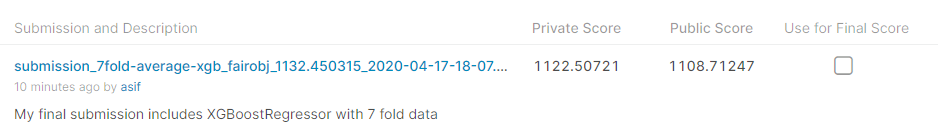

## XGBoostRegressor with 9 Folds

In [2]:
%%time
import numpy as np
import pandas as pd
import xgboost as xgb

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
import itertools

ntrain = 188318
shift = 200
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

fair_constant = 2
def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-shift,
                                      np.exp(yhat)-shift)
def mungeskewed(train, test, numeric_feats):
    ntrain = train.shape[0]
    test['loss'] = 0
    train_test = pd.concat((train, test)).reset_index(drop=True)
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.25]
    skewed_feats = skewed_feats.index

    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1
        train_test[feats], lam = boxcox(train_test[feats])
    return train_test, ntrain

if __name__ == "__main__":

    train_test = pd.read_pickle('train_test')

    numeric_feats = [x for x in train_test.columns[1:-1] if 'cont' in x]
    categorical_feats = [x for x in train_test.columns[1:-1] if 'cat' in x]
    #train_test, ntrain = mungeskewed(train, test, numeric_feats)

    categorical_feats = [x for x in train_test.columns[1:] if 'cat' in x]

    ss = StandardScaler()
    train_test[numeric_feats] = \
        ss.fit_transform(train_test[numeric_feats].values)
    
   # imp_cols = ['cat109','cont3','cont2','cont4','cont8','cat80_cat57','cat80_cat9','cat53','cat80_cat12',
    #        'cat80_cat4','cat57_cat79','cat57_cat16','cat57_cat6','cat12_cat25',
    #    'cat79_cat82','cat10_cat111','cat89_cat103','cat89_cat111','cat81_cat16',
    #        'cat81_cat103','cat81_cat6','cat11_cat25','cat1_cat73','cat3_cat103',
    #        'cat76_cat24','cat1_cat50','cat1_cat76','cat1_cat38','cat1_cat5',
    #         'cat1_cat14','cat1_cat82','cat13_cat3','cat1_cat6','cat11_cat50',
    #         'cat11_cat38','cat1_cat9','cat1_cat3','cat1_cat16','cat1_cat103',
    #         'cat13_cat73','cat13_cat90','cat13_cat23','cat13_cat103','cat9_cat28',
    #         'cat3_cat73','cat9_cat36','cat11_cat6','cat9_cat90','cat9_cat3',
    #         'cat2_cat4','cat2_cat25',
    #         'cat9_cat76','cat9_cat5','cat9_cat14','cat9_cat24','cat3_cat16',
    #    'cat80_cat28','cat80_cat76','cat57_cat7','cat57_cat76','cat12_cat16',
    #    'cat12_cat76','cat12_cat50','cat79_cat7','cat79_cat73','cat10_cat28',
    #    'cat2_cat14','cat81_cat13','cat81_cat73','cat81_cat38',
    #    'cat11_cat13','cat16_cat28']

    train_x = train_test.iloc[:ntrain, :].copy()
    test_x = train_test.iloc[ntrain:, :].copy()

    print('\nMedian Loss:', train_x.loss.median())
    print('Mean Loss:', train_x.loss.mean())

    ids = pd.read_csv('test.csv')['id']
    train_y = np.log(train_x['loss'] + shift)
    train_x = train_x.drop(['loss','id'], axis=1)
    test_x = test_x.drop(['loss','id'], axis=1)
    
    #considering imp features only
    #train_x = train_x[imp_cols]
    #test_x = test_x[imp_cols]

    n_folds = 9
    cv_sum = 0
    early_stopping = 100
    fpred = []
    xgb_rounds = []

    d_train_full = xgb.DMatrix(train_x, label=train_y)
    d_test = xgb.DMatrix(test_x)
    # https://stackoverflow.com/a/48641547
    kf = KFold(n_splits=9)
    for i, (train_index, test_index) in enumerate(kf.split(train_x)):
        print('\n Fold %d' % (i+1))
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[test_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]

        rand_state = 2016

        params = {
            'seed': 0,
            'colsample_bytree': 0.7,
            'silent': 1,
            'subsample': 0.7,
            'learning_rate': 0.03,
            'objective': 'reg:linear',
            'max_depth': 12,
            'min_child_weight': 100,
            'booster': 'gbtree'
            }

        d_train = xgb.DMatrix(X_train, label=y_train)
        d_valid = xgb.DMatrix(X_val, label=y_val)
        watchlist = [(d_train, 'train'), (d_valid, 'eval')]

        clf = xgb.train(params,
                        d_train,
                        100000,
                        watchlist,
                        early_stopping_rounds=50,
                        obj=fair_obj,
                        feval=xg_eval_mae)

        xgb_rounds.append(clf.best_iteration)
        scores_val = clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)
        cv_score = mean_absolute_error(np.exp(y_val), np.exp(scores_val))
        print('eval-MAE: %.6f' % cv_score)
        y_pred = np.exp(clf.predict(d_test, ntree_limit=clf.best_ntree_limit)) - shift

        if i > 0:
            fpred = pred + y_pred
        else:
            fpred = y_pred
        pred = fpred
        cv_sum = cv_sum + cv_score

    mpred = pred / n_folds
    score = cv_sum / n_folds
    print('Average eval-MAE: %.6f' % score)
    n_rounds = int(np.mean(xgb_rounds))

    print("Writing results")
    result = pd.DataFrame(mpred, columns=['loss'])
    result["id"] = ids
    result = result.set_index("id")
    print("%d-fold average prediction:" % n_folds)

    now = datetime.now()
    score = str(round((cv_sum / n_folds), 6))
    sub_file = 'submission_10fold-average-xgb_fairobj_' + str(score) + '_' + str(
        now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print("Writing submission: %s" % sub_file)
    result.to_csv(sub_file, index=True, index_label='id')
    joblib.dump(clf,'boosting_ensemble')


Median Loss: 2115.5699999999997
Mean Loss: 3037.3376856699792

 Fold 1
[0]	train-rmse:6.32852	eval-rmse:6.33068	train-mae:3230.96	eval-mae:3247.52
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[1]	train-rmse:5.55773	eval-rmse:5.55923	train-mae:3225.57	eval-mae:3242.12
[2]	train-rmse:4.94716	eval-rmse:4.94806	train-mae:3216.98	eval-mae:3233.5
[3]	train-rmse:4.45095	eval-rmse:4.45177	train-mae:3204.71	eval-mae:3221.21
[4]	train-rmse:4.03922	eval-rmse:4.0397	train-mae:3188.5	eval-mae:3204.93
[5]	train-rmse:3.69184	eval-rmse:3.69197	train-mae:3168.31	eval-mae:3184.66
[6]	train-rmse:3.39489	eval-rmse:3.39474	train-mae:3144.21	eval-mae:3160.46
[7]	train-rmse:3.13817	eval-rmse:3.13771	train-mae:3116.44	eval-mae:3132.55
[8]	train-rmse:2.91416	eval-rmse:2.91359	train-mae:3085.29	eval-mae:3101.27
[9]	train-rmse:2.71695	eval-rmse:2.71618	train-mae:3051.14	eval-mae:3066.94
[10]	train-rmse:2.54219	eval-r

[103]	train-rmse:0.474762	eval-rmse:0.491407	train-mae:1141.84	eval-mae:1191.49
[104]	train-rmse:0.47414	eval-rmse:0.490891	train-mae:1140.09	eval-mae:1190.07
[105]	train-rmse:0.473541	eval-rmse:0.490415	train-mae:1138.37	eval-mae:1188.74
[106]	train-rmse:0.472907	eval-rmse:0.489919	train-mae:1136.52	eval-mae:1187.28
[107]	train-rmse:0.472385	eval-rmse:0.489499	train-mae:1134.97	eval-mae:1186.01
[108]	train-rmse:0.471919	eval-rmse:0.489134	train-mae:1133.54	eval-mae:1184.98
[109]	train-rmse:0.471365	eval-rmse:0.488728	train-mae:1131.94	eval-mae:1183.84
[110]	train-rmse:0.470937	eval-rmse:0.488396	train-mae:1130.67	eval-mae:1182.92
[111]	train-rmse:0.47046	eval-rmse:0.488061	train-mae:1129.23	eval-mae:1181.84
[112]	train-rmse:0.470061	eval-rmse:0.487747	train-mae:1128.07	eval-mae:1180.94
[113]	train-rmse:0.469643	eval-rmse:0.48745	train-mae:1126.8	eval-mae:1180.02
[114]	train-rmse:0.469252	eval-rmse:0.487144	train-mae:1125.58	eval-mae:1179.11
[115]	train-rmse:0.468892	eval-rmse:0.486874

[206]	train-rmse:0.454322	eval-rmse:0.479676	train-mae:1078.89	eval-mae:1154.36
[207]	train-rmse:0.454246	eval-rmse:0.479656	train-mae:1078.66	eval-mae:1154.33
[208]	train-rmse:0.45415	eval-rmse:0.479649	train-mae:1078.35	eval-mae:1154.27
[209]	train-rmse:0.454065	eval-rmse:0.479617	train-mae:1078.11	eval-mae:1154.2
[210]	train-rmse:0.453982	eval-rmse:0.47958	train-mae:1077.86	eval-mae:1154.05
[211]	train-rmse:0.453895	eval-rmse:0.47956	train-mae:1077.6	eval-mae:1153.95
[212]	train-rmse:0.453803	eval-rmse:0.479547	train-mae:1077.34	eval-mae:1153.93
[213]	train-rmse:0.453707	eval-rmse:0.479529	train-mae:1077.08	eval-mae:1153.86
[214]	train-rmse:0.45358	eval-rmse:0.479505	train-mae:1076.74	eval-mae:1153.78
[215]	train-rmse:0.453531	eval-rmse:0.479495	train-mae:1076.56	eval-mae:1153.74
[216]	train-rmse:0.453387	eval-rmse:0.47945	train-mae:1076.15	eval-mae:1153.59
[217]	train-rmse:0.453298	eval-rmse:0.47943	train-mae:1075.91	eval-mae:1153.55
[218]	train-rmse:0.453254	eval-rmse:0.47942	trai

[310]	train-rmse:0.446729	eval-rmse:0.478198	train-mae:1057.04	eval-mae:1149.39
[311]	train-rmse:0.446684	eval-rmse:0.478188	train-mae:1056.85	eval-mae:1149.35
[312]	train-rmse:0.446619	eval-rmse:0.478176	train-mae:1056.66	eval-mae:1149.27
[313]	train-rmse:0.446573	eval-rmse:0.478173	train-mae:1056.48	eval-mae:1149.26
[314]	train-rmse:0.446544	eval-rmse:0.478169	train-mae:1056.42	eval-mae:1149.25
[315]	train-rmse:0.446495	eval-rmse:0.478144	train-mae:1056.28	eval-mae:1149.17
[316]	train-rmse:0.446453	eval-rmse:0.47814	train-mae:1056.14	eval-mae:1149.08
[317]	train-rmse:0.446399	eval-rmse:0.478135	train-mae:1055.99	eval-mae:1149.07
[318]	train-rmse:0.446355	eval-rmse:0.478123	train-mae:1055.86	eval-mae:1149.06
[319]	train-rmse:0.446307	eval-rmse:0.478113	train-mae:1055.73	eval-mae:1149.08
[320]	train-rmse:0.446235	eval-rmse:0.478107	train-mae:1055.5	eval-mae:1149.05
[321]	train-rmse:0.446192	eval-rmse:0.478097	train-mae:1055.39	eval-mae:1149.02
[322]	train-rmse:0.446127	eval-rmse:0.4780

[413]	train-rmse:0.441085	eval-rmse:0.477397	train-mae:1040.2	eval-mae:1146.75
[414]	train-rmse:0.441027	eval-rmse:0.477385	train-mae:1040.01	eval-mae:1146.77
[415]	train-rmse:0.440993	eval-rmse:0.477382	train-mae:1039.92	eval-mae:1146.78
[416]	train-rmse:0.440912	eval-rmse:0.477376	train-mae:1039.65	eval-mae:1146.72
[417]	train-rmse:0.440821	eval-rmse:0.477348	train-mae:1039.39	eval-mae:1146.69
[418]	train-rmse:0.440766	eval-rmse:0.47734	train-mae:1039.25	eval-mae:1146.66
[419]	train-rmse:0.440723	eval-rmse:0.477345	train-mae:1039.14	eval-mae:1146.71
[420]	train-rmse:0.440695	eval-rmse:0.477337	train-mae:1039.07	eval-mae:1146.67
[421]	train-rmse:0.440631	eval-rmse:0.477315	train-mae:1038.89	eval-mae:1146.57
[422]	train-rmse:0.440559	eval-rmse:0.477319	train-mae:1038.66	eval-mae:1146.56
[423]	train-rmse:0.440514	eval-rmse:0.477318	train-mae:1038.54	eval-mae:1146.58
[424]	train-rmse:0.440479	eval-rmse:0.477318	train-mae:1038.43	eval-mae:1146.58
[425]	train-rmse:0.440429	eval-rmse:0.4773

[517]	train-rmse:0.435578	eval-rmse:0.476927	train-mae:1024.41	eval-mae:1145.36
[518]	train-rmse:0.435523	eval-rmse:0.476924	train-mae:1024.26	eval-mae:1145.38
[519]	train-rmse:0.435447	eval-rmse:0.47692	train-mae:1024	eval-mae:1145.34
[520]	train-rmse:0.435429	eval-rmse:0.476922	train-mae:1023.96	eval-mae:1145.34
[521]	train-rmse:0.435405	eval-rmse:0.476911	train-mae:1023.88	eval-mae:1145.3
[522]	train-rmse:0.435304	eval-rmse:0.476924	train-mae:1023.54	eval-mae:1145.29
[523]	train-rmse:0.435245	eval-rmse:0.476914	train-mae:1023.36	eval-mae:1145.22
[524]	train-rmse:0.435154	eval-rmse:0.476916	train-mae:1023.12	eval-mae:1145.19
[525]	train-rmse:0.435087	eval-rmse:0.476903	train-mae:1022.94	eval-mae:1145.15
[526]	train-rmse:0.435041	eval-rmse:0.476905	train-mae:1022.77	eval-mae:1145.15
[527]	train-rmse:0.43501	eval-rmse:0.476908	train-mae:1022.69	eval-mae:1145.19
[528]	train-rmse:0.43495	eval-rmse:0.476918	train-mae:1022.54	eval-mae:1145.2
[529]	train-rmse:0.434901	eval-rmse:0.476919	tra

[621]	train-rmse:0.430736	eval-rmse:0.476806	train-mae:1010	eval-mae:1144.52
[622]	train-rmse:0.430668	eval-rmse:0.476798	train-mae:1009.79	eval-mae:1144.54
[623]	train-rmse:0.430633	eval-rmse:0.476806	train-mae:1009.71	eval-mae:1144.57
[624]	train-rmse:0.430567	eval-rmse:0.476815	train-mae:1009.49	eval-mae:1144.56
[625]	train-rmse:0.430497	eval-rmse:0.476814	train-mae:1009.29	eval-mae:1144.57
[626]	train-rmse:0.430483	eval-rmse:0.476817	train-mae:1009.25	eval-mae:1144.6
[627]	train-rmse:0.43043	eval-rmse:0.476815	train-mae:1009.1	eval-mae:1144.63
[628]	train-rmse:0.430391	eval-rmse:0.4768	train-mae:1009	eval-mae:1144.59
[629]	train-rmse:0.43031	eval-rmse:0.476806	train-mae:1008.78	eval-mae:1144.6
[630]	train-rmse:0.430278	eval-rmse:0.476804	train-mae:1008.67	eval-mae:1144.6
[631]	train-rmse:0.430189	eval-rmse:0.476802	train-mae:1008.42	eval-mae:1144.57
[632]	train-rmse:0.430144	eval-rmse:0.476806	train-mae:1008.31	eval-mae:1144.62
[633]	train-rmse:0.430071	eval-rmse:0.47678	train-mae:

[51]	train-rmse:0.648927	eval-rmse:0.649236	train-mae:1531.48	eval-mae:1514.97
[52]	train-rmse:0.639225	eval-rmse:0.639799	train-mae:1512.7	eval-mae:1496.63
[53]	train-rmse:0.63009	eval-rmse:0.630856	train-mae:1494.78	eval-mae:1479.11
[54]	train-rmse:0.62148	eval-rmse:0.622477	train-mae:1477.66	eval-mae:1462.44
[55]	train-rmse:0.613317	eval-rmse:0.614511	train-mae:1461.21	eval-mae:1446.43
[56]	train-rmse:0.605597	eval-rmse:0.606998	train-mae:1445.65	eval-mae:1431.33
[57]	train-rmse:0.598224	eval-rmse:0.599807	train-mae:1430.47	eval-mae:1416.51
[58]	train-rmse:0.59125	eval-rmse:0.593044	train-mae:1415.96	eval-mae:1402.53
[59]	train-rmse:0.584691	eval-rmse:0.586683	train-mae:1402.38	eval-mae:1389.52
[60]	train-rmse:0.57835	eval-rmse:0.580605	train-mae:1389.03	eval-mae:1376.87
[61]	train-rmse:0.572387	eval-rmse:0.574888	train-mae:1376.35	eval-mae:1364.94
[62]	train-rmse:0.566771	eval-rmse:0.569463	train-mae:1364.37	eval-mae:1353.59
[63]	train-rmse:0.561484	eval-rmse:0.564356	train-mae:135

[155]	train-rmse:0.461186	eval-rmse:0.475186	train-mae:1100.51	eval-mae:1132.6
[156]	train-rmse:0.460977	eval-rmse:0.475095	train-mae:1099.82	eval-mae:1132.28
[157]	train-rmse:0.46085	eval-rmse:0.475044	train-mae:1099.42	eval-mae:1132.18
[158]	train-rmse:0.460706	eval-rmse:0.474994	train-mae:1099.01	eval-mae:1132.06
[159]	train-rmse:0.460627	eval-rmse:0.474953	train-mae:1098.72	eval-mae:1131.94
[160]	train-rmse:0.46041	eval-rmse:0.474883	train-mae:1098.07	eval-mae:1131.74
[161]	train-rmse:0.460219	eval-rmse:0.47483	train-mae:1097.51	eval-mae:1131.6
[162]	train-rmse:0.460145	eval-rmse:0.474781	train-mae:1097.27	eval-mae:1131.47
[163]	train-rmse:0.460048	eval-rmse:0.47474	train-mae:1096.94	eval-mae:1131.33
[164]	train-rmse:0.459945	eval-rmse:0.474686	train-mae:1096.6	eval-mae:1131.25
[165]	train-rmse:0.459845	eval-rmse:0.474649	train-mae:1096.26	eval-mae:1131.11
[166]	train-rmse:0.459751	eval-rmse:0.474625	train-mae:1095.98	eval-mae:1131.02
[167]	train-rmse:0.459653	eval-rmse:0.4746	trai

[259]	train-rmse:0.451291	eval-rmse:0.472211	train-mae:1069.84	eval-mae:1123.58
[260]	train-rmse:0.451228	eval-rmse:0.47219	train-mae:1069.67	eval-mae:1123.56
[261]	train-rmse:0.451131	eval-rmse:0.472129	train-mae:1069.38	eval-mae:1123.41
[262]	train-rmse:0.451001	eval-rmse:0.472091	train-mae:1069.03	eval-mae:1123.3
[263]	train-rmse:0.450956	eval-rmse:0.472092	train-mae:1068.91	eval-mae:1123.32
[264]	train-rmse:0.450911	eval-rmse:0.472086	train-mae:1068.74	eval-mae:1123.27
[265]	train-rmse:0.45083	eval-rmse:0.472057	train-mae:1068.48	eval-mae:1123.15
[266]	train-rmse:0.450781	eval-rmse:0.472056	train-mae:1068.34	eval-mae:1123.13
[267]	train-rmse:0.450715	eval-rmse:0.472033	train-mae:1068.17	eval-mae:1123.14
[268]	train-rmse:0.450641	eval-rmse:0.472041	train-mae:1067.97	eval-mae:1123.15
[269]	train-rmse:0.450553	eval-rmse:0.472021	train-mae:1067.71	eval-mae:1123.12
[270]	train-rmse:0.450464	eval-rmse:0.471997	train-mae:1067.47	eval-mae:1123.09
[271]	train-rmse:0.450396	eval-rmse:0.47199

[363]	train-rmse:0.444693	eval-rmse:0.470906	train-mae:1050.57	eval-mae:1120
[364]	train-rmse:0.444635	eval-rmse:0.470891	train-mae:1050.4	eval-mae:1119.97
[365]	train-rmse:0.444587	eval-rmse:0.470884	train-mae:1050.27	eval-mae:1119.92
[366]	train-rmse:0.444511	eval-rmse:0.47088	train-mae:1050.04	eval-mae:1119.93
[367]	train-rmse:0.44448	eval-rmse:0.470881	train-mae:1049.96	eval-mae:1119.94
[368]	train-rmse:0.444387	eval-rmse:0.470858	train-mae:1049.73	eval-mae:1119.89
[369]	train-rmse:0.4443	eval-rmse:0.470854	train-mae:1049.52	eval-mae:1119.83
[370]	train-rmse:0.444268	eval-rmse:0.470842	train-mae:1049.45	eval-mae:1119.8
[371]	train-rmse:0.444172	eval-rmse:0.470839	train-mae:1049.19	eval-mae:1119.8
[372]	train-rmse:0.444128	eval-rmse:0.47084	train-mae:1049.08	eval-mae:1119.8
[373]	train-rmse:0.444083	eval-rmse:0.470836	train-mae:1048.96	eval-mae:1119.8
[374]	train-rmse:0.444047	eval-rmse:0.470833	train-mae:1048.82	eval-mae:1119.82
[375]	train-rmse:0.443978	eval-rmse:0.470803	train-ma

[466]	train-rmse:0.43912	eval-rmse:0.470236	train-mae:1034.88	eval-mae:1118.4
[467]	train-rmse:0.439055	eval-rmse:0.470214	train-mae:1034.62	eval-mae:1118.38
[468]	train-rmse:0.43897	eval-rmse:0.470193	train-mae:1034.41	eval-mae:1118.34
[469]	train-rmse:0.438896	eval-rmse:0.470168	train-mae:1034.2	eval-mae:1118.26
[470]	train-rmse:0.438854	eval-rmse:0.470159	train-mae:1034.08	eval-mae:1118.22
[471]	train-rmse:0.438784	eval-rmse:0.470145	train-mae:1033.89	eval-mae:1118.19
[472]	train-rmse:0.438708	eval-rmse:0.470128	train-mae:1033.67	eval-mae:1118.14
[473]	train-rmse:0.43868	eval-rmse:0.470128	train-mae:1033.6	eval-mae:1118.13
[474]	train-rmse:0.438599	eval-rmse:0.470117	train-mae:1033.36	eval-mae:1118.07
[475]	train-rmse:0.438564	eval-rmse:0.470116	train-mae:1033.26	eval-mae:1118.02
[476]	train-rmse:0.438525	eval-rmse:0.470117	train-mae:1033.16	eval-mae:1118.05
[477]	train-rmse:0.438494	eval-rmse:0.470108	train-mae:1033.04	eval-mae:1118.03
[478]	train-rmse:0.438407	eval-rmse:0.470097	t

[569]	train-rmse:0.434132	eval-rmse:0.469755	train-mae:1020.1	eval-mae:1117.36
[570]	train-rmse:0.434083	eval-rmse:0.469739	train-mae:1019.98	eval-mae:1117.31
[571]	train-rmse:0.434046	eval-rmse:0.469729	train-mae:1019.86	eval-mae:1117.28
[572]	train-rmse:0.434013	eval-rmse:0.469731	train-mae:1019.78	eval-mae:1117.3
[573]	train-rmse:0.43398	eval-rmse:0.469734	train-mae:1019.68	eval-mae:1117.28
[574]	train-rmse:0.433931	eval-rmse:0.469734	train-mae:1019.54	eval-mae:1117.24
[575]	train-rmse:0.433892	eval-rmse:0.469744	train-mae:1019.42	eval-mae:1117.27
[576]	train-rmse:0.433876	eval-rmse:0.469741	train-mae:1019.38	eval-mae:1117.25
[577]	train-rmse:0.433812	eval-rmse:0.469742	train-mae:1019.24	eval-mae:1117.26
[578]	train-rmse:0.433765	eval-rmse:0.469749	train-mae:1019.1	eval-mae:1117.32
[579]	train-rmse:0.433689	eval-rmse:0.469753	train-mae:1018.86	eval-mae:1117.28
[580]	train-rmse:0.43365	eval-rmse:0.469756	train-mae:1018.71	eval-mae:1117.28
[581]	train-rmse:0.433602	eval-rmse:0.469763	

[45]	train-rmse:0.718341	eval-rmse:0.725244	train-mae:1657.95	eval-mae:1666.97
[46]	train-rmse:0.705076	eval-rmse:0.712203	train-mae:1634.19	eval-mae:1643.73
[47]	train-rmse:0.692505	eval-rmse:0.699816	train-mae:1611.19	eval-mae:1621.16
[48]	train-rmse:0.680644	eval-rmse:0.688162	train-mae:1589.26	eval-mae:1599.71
[49]	train-rmse:0.669332	eval-rmse:0.677078	train-mae:1568.13	eval-mae:1579
[50]	train-rmse:0.658546	eval-rmse:0.666544	train-mae:1547.72	eval-mae:1559.12
[51]	train-rmse:0.648444	eval-rmse:0.656645	train-mae:1528.34	eval-mae:1540.2
[52]	train-rmse:0.638918	eval-rmse:0.647319	train-mae:1509.84	eval-mae:1522.13
[53]	train-rmse:0.629789	eval-rmse:0.638423	train-mae:1491.89	eval-mae:1504.75
[54]	train-rmse:0.621009	eval-rmse:0.629911	train-mae:1474.53	eval-mae:1488
[55]	train-rmse:0.612806	eval-rmse:0.621933	train-mae:1458.16	eval-mae:1472.22
[56]	train-rmse:0.604982	eval-rmse:0.614349	train-mae:1442.36	eval-mae:1456.94
[57]	train-rmse:0.597593	eval-rmse:0.60722	train-mae:1427.3

[149]	train-rmse:0.460774	eval-rmse:0.48207	train-mae:1100.74	eval-mae:1150
[150]	train-rmse:0.460621	eval-rmse:0.481996	train-mae:1100.27	eval-mae:1149.77
[151]	train-rmse:0.460443	eval-rmse:0.481893	train-mae:1099.69	eval-mae:1149.43
[152]	train-rmse:0.460351	eval-rmse:0.481833	train-mae:1099.35	eval-mae:1149.21
[153]	train-rmse:0.460156	eval-rmse:0.48179	train-mae:1098.77	eval-mae:1149.06
[154]	train-rmse:0.460033	eval-rmse:0.481726	train-mae:1098.38	eval-mae:1148.9
[155]	train-rmse:0.459881	eval-rmse:0.481666	train-mae:1097.9	eval-mae:1148.66
[156]	train-rmse:0.459725	eval-rmse:0.481586	train-mae:1097.44	eval-mae:1148.43
[157]	train-rmse:0.459625	eval-rmse:0.481545	train-mae:1097.08	eval-mae:1148.27
[158]	train-rmse:0.459492	eval-rmse:0.481471	train-mae:1096.63	eval-mae:1148.06
[159]	train-rmse:0.459381	eval-rmse:0.481432	train-mae:1096.24	eval-mae:1147.94
[160]	train-rmse:0.459235	eval-rmse:0.481378	train-mae:1095.78	eval-mae:1147.78
[161]	train-rmse:0.459093	eval-rmse:0.481345	tr

[253]	train-rmse:0.450355	eval-rmse:0.478741	train-mae:1068.67	eval-mae:1140.18
[254]	train-rmse:0.450288	eval-rmse:0.478727	train-mae:1068.48	eval-mae:1140.19
[255]	train-rmse:0.450257	eval-rmse:0.478718	train-mae:1068.42	eval-mae:1140.2
[256]	train-rmse:0.450196	eval-rmse:0.478705	train-mae:1068.25	eval-mae:1140.14
[257]	train-rmse:0.450053	eval-rmse:0.478647	train-mae:1067.83	eval-mae:1140.01
[258]	train-rmse:0.449981	eval-rmse:0.478621	train-mae:1067.63	eval-mae:1139.97
[259]	train-rmse:0.449908	eval-rmse:0.478594	train-mae:1067.41	eval-mae:1139.93
[260]	train-rmse:0.449822	eval-rmse:0.478581	train-mae:1067.14	eval-mae:1139.84
[261]	train-rmse:0.449768	eval-rmse:0.478579	train-mae:1066.92	eval-mae:1139.81
[262]	train-rmse:0.449705	eval-rmse:0.478562	train-mae:1066.71	eval-mae:1139.79
[263]	train-rmse:0.449582	eval-rmse:0.478528	train-mae:1066.31	eval-mae:1139.69
[264]	train-rmse:0.449473	eval-rmse:0.478528	train-mae:1065.98	eval-mae:1139.66
[265]	train-rmse:0.449431	eval-rmse:0.478

[356]	train-rmse:0.443614	eval-rmse:0.477709	train-mae:1048.68	eval-mae:1137.23
[357]	train-rmse:0.44354	eval-rmse:0.477691	train-mae:1048.47	eval-mae:1137.11
[358]	train-rmse:0.443512	eval-rmse:0.47769	train-mae:1048.37	eval-mae:1137.11
[359]	train-rmse:0.443421	eval-rmse:0.477673	train-mae:1048.1	eval-mae:1137.03
[360]	train-rmse:0.443362	eval-rmse:0.477656	train-mae:1047.93	eval-mae:1136.99
[361]	train-rmse:0.443288	eval-rmse:0.477651	train-mae:1047.74	eval-mae:1136.98
[362]	train-rmse:0.443185	eval-rmse:0.47763	train-mae:1047.48	eval-mae:1137
[363]	train-rmse:0.443076	eval-rmse:0.477637	train-mae:1047.17	eval-mae:1137.06
[364]	train-rmse:0.443006	eval-rmse:0.47763	train-mae:1046.97	eval-mae:1137.05
[365]	train-rmse:0.442979	eval-rmse:0.47763	train-mae:1046.9	eval-mae:1137.06
[366]	train-rmse:0.442948	eval-rmse:0.477616	train-mae:1046.82	eval-mae:1137
[367]	train-rmse:0.442897	eval-rmse:0.477612	train-mae:1046.66	eval-mae:1137
[368]	train-rmse:0.442874	eval-rmse:0.477615	train-mae:1

[460]	train-rmse:0.437482	eval-rmse:0.477145	train-mae:1030.89	eval-mae:1135.26
[461]	train-rmse:0.437452	eval-rmse:0.477147	train-mae:1030.79	eval-mae:1135.27
[462]	train-rmse:0.437389	eval-rmse:0.477143	train-mae:1030.55	eval-mae:1135.22
[463]	train-rmse:0.43734	eval-rmse:0.477138	train-mae:1030.4	eval-mae:1135.18
[464]	train-rmse:0.437299	eval-rmse:0.477142	train-mae:1030.26	eval-mae:1135.17
[465]	train-rmse:0.437259	eval-rmse:0.477133	train-mae:1030.13	eval-mae:1135.13
[466]	train-rmse:0.437194	eval-rmse:0.477127	train-mae:1029.97	eval-mae:1135.1
[467]	train-rmse:0.437158	eval-rmse:0.477131	train-mae:1029.88	eval-mae:1135.12
[468]	train-rmse:0.437115	eval-rmse:0.477125	train-mae:1029.68	eval-mae:1135.06
[469]	train-rmse:0.437076	eval-rmse:0.477121	train-mae:1029.54	eval-mae:1135.03
[470]	train-rmse:0.437028	eval-rmse:0.477118	train-mae:1029.4	eval-mae:1135.03
[471]	train-rmse:0.436991	eval-rmse:0.477109	train-mae:1029.28	eval-mae:1135.03
[472]	train-rmse:0.436926	eval-rmse:0.477101

[564]	train-rmse:0.432678	eval-rmse:0.476915	train-mae:1016.45	eval-mae:1134.64
[565]	train-rmse:0.432634	eval-rmse:0.476913	train-mae:1016.32	eval-mae:1134.65
[566]	train-rmse:0.432584	eval-rmse:0.476911	train-mae:1016.17	eval-mae:1134.62
[567]	train-rmse:0.432515	eval-rmse:0.476912	train-mae:1015.99	eval-mae:1134.64
[568]	train-rmse:0.432452	eval-rmse:0.476913	train-mae:1015.78	eval-mae:1134.63
[569]	train-rmse:0.432399	eval-rmse:0.476904	train-mae:1015.63	eval-mae:1134.59
[570]	train-rmse:0.432367	eval-rmse:0.4769	train-mae:1015.53	eval-mae:1134.61
[571]	train-rmse:0.432352	eval-rmse:0.476899	train-mae:1015.48	eval-mae:1134.59
[572]	train-rmse:0.432306	eval-rmse:0.476885	train-mae:1015.32	eval-mae:1134.57
[573]	train-rmse:0.432258	eval-rmse:0.476878	train-mae:1015.16	eval-mae:1134.56
[574]	train-rmse:0.43221	eval-rmse:0.476874	train-mae:1015.02	eval-mae:1134.55
[575]	train-rmse:0.432185	eval-rmse:0.47687	train-mae:1014.95	eval-mae:1134.54
[576]	train-rmse:0.432156	eval-rmse:0.47688	

[667]	train-rmse:0.428073	eval-rmse:0.476718	train-mae:1003.02	eval-mae:1134.13
[668]	train-rmse:0.427995	eval-rmse:0.476733	train-mae:1002.81	eval-mae:1134.17
[669]	train-rmse:0.427963	eval-rmse:0.476734	train-mae:1002.73	eval-mae:1134.16
[670]	train-rmse:0.427919	eval-rmse:0.476739	train-mae:1002.61	eval-mae:1134.16
[671]	train-rmse:0.427876	eval-rmse:0.47674	train-mae:1002.45	eval-mae:1134.16
[672]	train-rmse:0.427831	eval-rmse:0.476731	train-mae:1002.32	eval-mae:1134.13
[673]	train-rmse:0.427783	eval-rmse:0.476726	train-mae:1002.19	eval-mae:1134.1
[674]	train-rmse:0.427706	eval-rmse:0.47674	train-mae:1001.96	eval-mae:1134.14
[675]	train-rmse:0.427669	eval-rmse:0.476729	train-mae:1001.86	eval-mae:1134.07
[676]	train-rmse:0.427631	eval-rmse:0.476727	train-mae:1001.76	eval-mae:1134.08
[677]	train-rmse:0.427572	eval-rmse:0.476747	train-mae:1001.6	eval-mae:1134.11
[678]	train-rmse:0.427536	eval-rmse:0.476746	train-mae:1001.51	eval-mae:1134.11
[679]	train-rmse:0.427484	eval-rmse:0.476756

[771]	train-rmse:0.423177	eval-rmse:0.476601	train-mae:988.825	eval-mae:1133.69
[772]	train-rmse:0.423102	eval-rmse:0.476597	train-mae:988.614	eval-mae:1133.64
[773]	train-rmse:0.423061	eval-rmse:0.476602	train-mae:988.473	eval-mae:1133.64
[774]	train-rmse:0.423034	eval-rmse:0.476605	train-mae:988.391	eval-mae:1133.65
[775]	train-rmse:0.423023	eval-rmse:0.476603	train-mae:988.355	eval-mae:1133.64
[776]	train-rmse:0.423006	eval-rmse:0.476595	train-mae:988.32	eval-mae:1133.65
[777]	train-rmse:0.422959	eval-rmse:0.476589	train-mae:988.181	eval-mae:1133.67
[778]	train-rmse:0.422928	eval-rmse:0.476593	train-mae:988.095	eval-mae:1133.68
[779]	train-rmse:0.422914	eval-rmse:0.476595	train-mae:988.046	eval-mae:1133.68
[780]	train-rmse:0.422887	eval-rmse:0.476595	train-mae:987.972	eval-mae:1133.69
[781]	train-rmse:0.422843	eval-rmse:0.476595	train-mae:987.85	eval-mae:1133.72
[782]	train-rmse:0.422806	eval-rmse:0.476599	train-mae:987.724	eval-mae:1133.72
[783]	train-rmse:0.422777	eval-rmse:0.4766

[56]	train-rmse:0.605263	eval-rmse:0.614082	train-mae:1441.7	eval-mae:1467.15
[57]	train-rmse:0.597956	eval-rmse:0.606945	train-mae:1426.8	eval-mae:1453.03
[58]	train-rmse:0.591017	eval-rmse:0.600173	train-mae:1412.46	eval-mae:1439.43
[59]	train-rmse:0.584402	eval-rmse:0.593778	train-mae:1398.66	eval-mae:1426.51
[60]	train-rmse:0.578153	eval-rmse:0.587703	train-mae:1385.54	eval-mae:1414.19
[61]	train-rmse:0.572166	eval-rmse:0.581907	train-mae:1372.91	eval-mae:1402.4
[62]	train-rmse:0.566499	eval-rmse:0.576409	train-mae:1360.81	eval-mae:1391.02
[63]	train-rmse:0.561124	eval-rmse:0.571212	train-mae:1349.28	eval-mae:1380.14
[64]	train-rmse:0.556044	eval-rmse:0.566292	train-mae:1338.27	eval-mae:1369.69
[65]	train-rmse:0.551246	eval-rmse:0.561626	train-mae:1327.75	eval-mae:1359.71
[66]	train-rmse:0.546722	eval-rmse:0.557248	train-mae:1317.72	eval-mae:1350.19
[67]	train-rmse:0.542362	eval-rmse:0.553058	train-mae:1308.04	eval-mae:1341.04
[68]	train-rmse:0.538282	eval-rmse:0.54913	train-mae:12

[160]	train-rmse:0.459267	eval-rmse:0.479295	train-mae:1094.19	eval-mae:1154.47
[161]	train-rmse:0.459191	eval-rmse:0.479252	train-mae:1093.94	eval-mae:1154.34
[162]	train-rmse:0.459036	eval-rmse:0.479162	train-mae:1093.5	eval-mae:1154.11
[163]	train-rmse:0.458928	eval-rmse:0.479093	train-mae:1093.12	eval-mae:1153.89
[164]	train-rmse:0.45883	eval-rmse:0.479056	train-mae:1092.79	eval-mae:1153.73
[165]	train-rmse:0.45873	eval-rmse:0.479016	train-mae:1092.44	eval-mae:1153.56
[166]	train-rmse:0.458648	eval-rmse:0.47897	train-mae:1092.14	eval-mae:1153.4
[167]	train-rmse:0.45858	eval-rmse:0.478923	train-mae:1091.9	eval-mae:1153.28
[168]	train-rmse:0.458419	eval-rmse:0.478867	train-mae:1091.45	eval-mae:1153.14
[169]	train-rmse:0.458301	eval-rmse:0.478813	train-mae:1091.1	eval-mae:1152.95
[170]	train-rmse:0.458199	eval-rmse:0.478773	train-mae:1090.76	eval-mae:1152.83
[171]	train-rmse:0.458023	eval-rmse:0.478685	train-mae:1090.23	eval-mae:1152.57
[172]	train-rmse:0.45793	eval-rmse:0.478671	trai

[264]	train-rmse:0.449841	eval-rmse:0.476188	train-mae:1065.28	eval-mae:1144.45
[265]	train-rmse:0.449819	eval-rmse:0.476186	train-mae:1065.22	eval-mae:1144.47
[266]	train-rmse:0.449783	eval-rmse:0.476177	train-mae:1065.12	eval-mae:1144.45
[267]	train-rmse:0.449727	eval-rmse:0.476186	train-mae:1064.95	eval-mae:1144.45
[268]	train-rmse:0.449695	eval-rmse:0.476187	train-mae:1064.86	eval-mae:1144.46
[269]	train-rmse:0.449646	eval-rmse:0.476186	train-mae:1064.65	eval-mae:1144.46
[270]	train-rmse:0.449582	eval-rmse:0.476161	train-mae:1064.48	eval-mae:1144.39
[271]	train-rmse:0.449411	eval-rmse:0.47613	train-mae:1064.05	eval-mae:1144.29
[272]	train-rmse:0.449302	eval-rmse:0.476121	train-mae:1063.76	eval-mae:1144.24
[273]	train-rmse:0.449212	eval-rmse:0.476085	train-mae:1063.48	eval-mae:1144.14
[274]	train-rmse:0.449167	eval-rmse:0.476077	train-mae:1063.35	eval-mae:1144.13
[275]	train-rmse:0.449106	eval-rmse:0.476051	train-mae:1063.12	eval-mae:1144.07
[276]	train-rmse:0.449016	eval-rmse:0.476

[367]	train-rmse:0.443148	eval-rmse:0.475205	train-mae:1045.91	eval-mae:1141.27
[368]	train-rmse:0.443105	eval-rmse:0.4752	train-mae:1045.78	eval-mae:1141.27
[369]	train-rmse:0.44305	eval-rmse:0.475187	train-mae:1045.64	eval-mae:1141.27
[370]	train-rmse:0.443026	eval-rmse:0.47518	train-mae:1045.57	eval-mae:1141.27
[371]	train-rmse:0.442959	eval-rmse:0.475179	train-mae:1045.38	eval-mae:1141.28
[372]	train-rmse:0.442926	eval-rmse:0.475173	train-mae:1045.25	eval-mae:1141.28
[373]	train-rmse:0.442886	eval-rmse:0.475162	train-mae:1045.13	eval-mae:1141.24
[374]	train-rmse:0.44281	eval-rmse:0.475158	train-mae:1044.92	eval-mae:1141.2
[375]	train-rmse:0.442779	eval-rmse:0.475157	train-mae:1044.83	eval-mae:1141.21
[376]	train-rmse:0.442743	eval-rmse:0.475151	train-mae:1044.73	eval-mae:1141.2
[377]	train-rmse:0.442703	eval-rmse:0.475157	train-mae:1044.63	eval-mae:1141.17
[378]	train-rmse:0.442642	eval-rmse:0.475167	train-mae:1044.44	eval-mae:1141.2
[379]	train-rmse:0.442576	eval-rmse:0.475158	tra

[471]	train-rmse:0.437756	eval-rmse:0.474823	train-mae:1030.15	eval-mae:1139.87
[472]	train-rmse:0.437704	eval-rmse:0.47482	train-mae:1029.99	eval-mae:1139.84
[473]	train-rmse:0.437629	eval-rmse:0.47482	train-mae:1029.78	eval-mae:1139.84
[474]	train-rmse:0.437597	eval-rmse:0.474821	train-mae:1029.7	eval-mae:1139.84
[475]	train-rmse:0.437566	eval-rmse:0.474829	train-mae:1029.62	eval-mae:1139.9
[476]	train-rmse:0.437498	eval-rmse:0.47483	train-mae:1029.43	eval-mae:1139.9
[477]	train-rmse:0.437447	eval-rmse:0.47482	train-mae:1029.27	eval-mae:1139.89
[478]	train-rmse:0.437418	eval-rmse:0.474813	train-mae:1029.18	eval-mae:1139.87
[479]	train-rmse:0.43738	eval-rmse:0.474803	train-mae:1029.07	eval-mae:1139.87
[480]	train-rmse:0.437347	eval-rmse:0.474793	train-mae:1028.97	eval-mae:1139.84
[481]	train-rmse:0.437287	eval-rmse:0.474788	train-mae:1028.79	eval-mae:1139.85
[482]	train-rmse:0.437267	eval-rmse:0.474789	train-mae:1028.75	eval-mae:1139.88
[483]	train-rmse:0.4372	eval-rmse:0.474787	train

[575]	train-rmse:0.432613	eval-rmse:0.474605	train-mae:1015.07	eval-mae:1139.45
[576]	train-rmse:0.432601	eval-rmse:0.474612	train-mae:1015.02	eval-mae:1139.47
[577]	train-rmse:0.432519	eval-rmse:0.474606	train-mae:1014.78	eval-mae:1139.47
[578]	train-rmse:0.4325	eval-rmse:0.474599	train-mae:1014.74	eval-mae:1139.44
[579]	train-rmse:0.432392	eval-rmse:0.474598	train-mae:1014.42	eval-mae:1139.38
[580]	train-rmse:0.432309	eval-rmse:0.474585	train-mae:1014.22	eval-mae:1139.34
[581]	train-rmse:0.432298	eval-rmse:0.474583	train-mae:1014.17	eval-mae:1139.32
[582]	train-rmse:0.432219	eval-rmse:0.474591	train-mae:1013.95	eval-mae:1139.33
[583]	train-rmse:0.432182	eval-rmse:0.474584	train-mae:1013.83	eval-mae:1139.31
[584]	train-rmse:0.432144	eval-rmse:0.474583	train-mae:1013.74	eval-mae:1139.3
[585]	train-rmse:0.432066	eval-rmse:0.474586	train-mae:1013.5	eval-mae:1139.32
[586]	train-rmse:0.432016	eval-rmse:0.474581	train-mae:1013.33	eval-mae:1139.29
[587]	train-rmse:0.431968	eval-rmse:0.474575

[5]	train-rmse:3.69214	eval-rmse:3.6957	train-mae:3168.71	eval-mae:3181.82
[6]	train-rmse:3.39521	eval-rmse:3.39904	train-mae:3144.59	eval-mae:3157.77
[7]	train-rmse:3.13852	eval-rmse:3.14248	train-mae:3116.82	eval-mae:3130.07
[8]	train-rmse:2.91445	eval-rmse:2.91853	train-mae:3085.69	eval-mae:3099.02
[9]	train-rmse:2.71705	eval-rmse:2.72121	train-mae:3051.48	eval-mae:3064.88
[10]	train-rmse:2.54252	eval-rmse:2.54689	train-mae:3014.8	eval-mae:3028.33
[11]	train-rmse:2.38684	eval-rmse:2.39131	train-mae:2975.8	eval-mae:2989.44
[12]	train-rmse:2.24704	eval-rmse:2.2516	train-mae:2934.83	eval-mae:2948.56
[13]	train-rmse:2.12104	eval-rmse:2.12578	train-mae:2892.27	eval-mae:2906.12
[14]	train-rmse:2.0068	eval-rmse:2.01164	train-mae:2848.32	eval-mae:2862.3
[15]	train-rmse:1.9031	eval-rmse:1.90803	train-mae:2803.42	eval-mae:2817.52
[16]	train-rmse:1.80862	eval-rmse:1.81362	train-mae:2757.87	eval-mae:2772.06
[17]	train-rmse:1.72192	eval-rmse:1.72706	train-mae:2711.85	eval-mae:2726.16
[18]	train-

[111]	train-rmse:0.470514	eval-rmse:0.489299	train-mae:1130.32	eval-mae:1177.5
[112]	train-rmse:0.470084	eval-rmse:0.488947	train-mae:1129.06	eval-mae:1176.5
[113]	train-rmse:0.469624	eval-rmse:0.488602	train-mae:1127.71	eval-mae:1175.5
[114]	train-rmse:0.469237	eval-rmse:0.488283	train-mae:1126.56	eval-mae:1174.6
[115]	train-rmse:0.468874	eval-rmse:0.487949	train-mae:1125.43	eval-mae:1173.59
[116]	train-rmse:0.468526	eval-rmse:0.487662	train-mae:1124.35	eval-mae:1172.69
[117]	train-rmse:0.468168	eval-rmse:0.487362	train-mae:1123.28	eval-mae:1171.8
[118]	train-rmse:0.467873	eval-rmse:0.487095	train-mae:1122.38	eval-mae:1170.97
[119]	train-rmse:0.467586	eval-rmse:0.486864	train-mae:1121.48	eval-mae:1170.18
[120]	train-rmse:0.467248	eval-rmse:0.48663	train-mae:1120.48	eval-mae:1169.43
[121]	train-rmse:0.466878	eval-rmse:0.486371	train-mae:1119.34	eval-mae:1168.59
[122]	train-rmse:0.466447	eval-rmse:0.486096	train-mae:1118.06	eval-mae:1167.76
[123]	train-rmse:0.466157	eval-rmse:0.485888	t

[215]	train-rmse:0.453491	eval-rmse:0.479634	train-mae:1076.94	eval-mae:1145.7
[216]	train-rmse:0.453413	eval-rmse:0.479604	train-mae:1076.7	eval-mae:1145.56
[217]	train-rmse:0.453339	eval-rmse:0.479589	train-mae:1076.49	eval-mae:1145.52
[218]	train-rmse:0.453252	eval-rmse:0.479577	train-mae:1076.23	eval-mae:1145.53
[219]	train-rmse:0.45318	eval-rmse:0.47956	train-mae:1076.03	eval-mae:1145.51
[220]	train-rmse:0.453115	eval-rmse:0.479532	train-mae:1075.84	eval-mae:1145.39
[221]	train-rmse:0.453077	eval-rmse:0.479507	train-mae:1075.69	eval-mae:1145.3
[222]	train-rmse:0.452989	eval-rmse:0.479498	train-mae:1075.44	eval-mae:1145.23
[223]	train-rmse:0.452924	eval-rmse:0.479483	train-mae:1075.24	eval-mae:1145.18
[224]	train-rmse:0.452862	eval-rmse:0.479461	train-mae:1075	eval-mae:1145.1
[225]	train-rmse:0.452795	eval-rmse:0.479429	train-mae:1074.81	eval-mae:1145.04
[226]	train-rmse:0.452691	eval-rmse:0.479401	train-mae:1074.53	eval-mae:1144.92
[227]	train-rmse:0.452577	eval-rmse:0.479367	trai

[318]	train-rmse:0.446032	eval-rmse:0.478026	train-mae:1055.17	eval-mae:1140.73
[319]	train-rmse:0.44599	eval-rmse:0.478007	train-mae:1055	eval-mae:1140.69
[320]	train-rmse:0.44592	eval-rmse:0.477982	train-mae:1054.81	eval-mae:1140.61
[321]	train-rmse:0.445867	eval-rmse:0.477979	train-mae:1054.69	eval-mae:1140.6
[322]	train-rmse:0.445824	eval-rmse:0.477969	train-mae:1054.57	eval-mae:1140.52
[323]	train-rmse:0.445766	eval-rmse:0.477952	train-mae:1054.41	eval-mae:1140.43
[324]	train-rmse:0.445723	eval-rmse:0.477951	train-mae:1054.3	eval-mae:1140.42
[325]	train-rmse:0.445685	eval-rmse:0.477939	train-mae:1054.17	eval-mae:1140.39
[326]	train-rmse:0.445648	eval-rmse:0.477939	train-mae:1054.06	eval-mae:1140.42
[327]	train-rmse:0.445574	eval-rmse:0.477944	train-mae:1053.83	eval-mae:1140.38
[328]	train-rmse:0.445469	eval-rmse:0.477929	train-mae:1053.55	eval-mae:1140.3
[329]	train-rmse:0.445395	eval-rmse:0.477913	train-mae:1053.32	eval-mae:1140.25
[330]	train-rmse:0.445333	eval-rmse:0.477911	tra

[421]	train-rmse:0.440161	eval-rmse:0.477306	train-mae:1038.03	eval-mae:1138.34
[422]	train-rmse:0.4401	eval-rmse:0.47732	train-mae:1037.84	eval-mae:1138.32
[423]	train-rmse:0.440039	eval-rmse:0.477313	train-mae:1037.66	eval-mae:1138.26
[424]	train-rmse:0.439998	eval-rmse:0.477302	train-mae:1037.54	eval-mae:1138.19
[425]	train-rmse:0.439974	eval-rmse:0.477295	train-mae:1037.47	eval-mae:1138.17
[426]	train-rmse:0.439943	eval-rmse:0.4773	train-mae:1037.38	eval-mae:1138.19
[427]	train-rmse:0.439886	eval-rmse:0.477291	train-mae:1037.23	eval-mae:1138.15
[428]	train-rmse:0.439787	eval-rmse:0.477292	train-mae:1036.97	eval-mae:1138.16
[429]	train-rmse:0.439754	eval-rmse:0.477278	train-mae:1036.86	eval-mae:1138.1
[430]	train-rmse:0.439692	eval-rmse:0.47729	train-mae:1036.68	eval-mae:1138.16
[431]	train-rmse:0.43963	eval-rmse:0.477271	train-mae:1036.5	eval-mae:1138.12
[432]	train-rmse:0.439581	eval-rmse:0.47726	train-mae:1036.35	eval-mae:1138.09
[433]	train-rmse:0.439544	eval-rmse:0.477251	train

[525]	train-rmse:0.43485	eval-rmse:0.476898	train-mae:1022.64	eval-mae:1136.78
[526]	train-rmse:0.434798	eval-rmse:0.47689	train-mae:1022.51	eval-mae:1136.73
[527]	train-rmse:0.434699	eval-rmse:0.476901	train-mae:1022.26	eval-mae:1136.79
[528]	train-rmse:0.434649	eval-rmse:0.476896	train-mae:1022.12	eval-mae:1136.8
[529]	train-rmse:0.434593	eval-rmse:0.476878	train-mae:1021.95	eval-mae:1136.73
[530]	train-rmse:0.434542	eval-rmse:0.476861	train-mae:1021.79	eval-mae:1136.73
[531]	train-rmse:0.43448	eval-rmse:0.476866	train-mae:1021.6	eval-mae:1136.75
[532]	train-rmse:0.434432	eval-rmse:0.47687	train-mae:1021.44	eval-mae:1136.8
[533]	train-rmse:0.434392	eval-rmse:0.476865	train-mae:1021.34	eval-mae:1136.79
[534]	train-rmse:0.434283	eval-rmse:0.476863	train-mae:1021.04	eval-mae:1136.78
[535]	train-rmse:0.434232	eval-rmse:0.476859	train-mae:1020.88	eval-mae:1136.77
[536]	train-rmse:0.434197	eval-rmse:0.476858	train-mae:1020.75	eval-mae:1136.75
[537]	train-rmse:0.434125	eval-rmse:0.476848	tr

[629]	train-rmse:0.429743	eval-rmse:0.476552	train-mae:1007.9	eval-mae:1136.03
[630]	train-rmse:0.429703	eval-rmse:0.476552	train-mae:1007.78	eval-mae:1136.02
[631]	train-rmse:0.429626	eval-rmse:0.476533	train-mae:1007.56	eval-mae:1135.98
[632]	train-rmse:0.429605	eval-rmse:0.476533	train-mae:1007.49	eval-mae:1135.99
[633]	train-rmse:0.429552	eval-rmse:0.476532	train-mae:1007.29	eval-mae:1135.98
[634]	train-rmse:0.42949	eval-rmse:0.476527	train-mae:1007.14	eval-mae:1135.95
[635]	train-rmse:0.429425	eval-rmse:0.476532	train-mae:1006.98	eval-mae:1135.98
[636]	train-rmse:0.429405	eval-rmse:0.476539	train-mae:1006.93	eval-mae:1135.98
[637]	train-rmse:0.429356	eval-rmse:0.476546	train-mae:1006.8	eval-mae:1135.98
[638]	train-rmse:0.429272	eval-rmse:0.476548	train-mae:1006.58	eval-mae:1136.02
[639]	train-rmse:0.429226	eval-rmse:0.476541	train-mae:1006.41	eval-mae:1135.96
[640]	train-rmse:0.429176	eval-rmse:0.476537	train-mae:1006.26	eval-mae:1135.96
[641]	train-rmse:0.429101	eval-rmse:0.47652

[733]	train-rmse:0.425089	eval-rmse:0.476311	train-mae:994.414	eval-mae:1135.1
[734]	train-rmse:0.425051	eval-rmse:0.476313	train-mae:994.322	eval-mae:1135.11
[735]	train-rmse:0.424992	eval-rmse:0.476304	train-mae:994.169	eval-mae:1135.1
[736]	train-rmse:0.424942	eval-rmse:0.476314	train-mae:994.038	eval-mae:1135.1
[737]	train-rmse:0.424913	eval-rmse:0.476312	train-mae:993.966	eval-mae:1135.1
[738]	train-rmse:0.424889	eval-rmse:0.476305	train-mae:993.878	eval-mae:1135.08
[739]	train-rmse:0.424831	eval-rmse:0.476311	train-mae:993.703	eval-mae:1135.07
[740]	train-rmse:0.424801	eval-rmse:0.476312	train-mae:993.618	eval-mae:1135.05
[741]	train-rmse:0.424786	eval-rmse:0.476316	train-mae:993.583	eval-mae:1135.07
[742]	train-rmse:0.424743	eval-rmse:0.476326	train-mae:993.454	eval-mae:1135.09
[743]	train-rmse:0.42469	eval-rmse:0.476327	train-mae:993.281	eval-mae:1135.08
[744]	train-rmse:0.424656	eval-rmse:0.476334	train-mae:993.191	eval-mae:1135.11
[745]	train-rmse:0.424618	eval-rmse:0.47633	t

[43]	train-rmse:0.747363	eval-rmse:0.752105	train-mae:1708.79	eval-mae:1713.89
[44]	train-rmse:0.732605	eval-rmse:0.737524	train-mae:1683.16	eval-mae:1688.58
[45]	train-rmse:0.718462	eval-rmse:0.723628	train-mae:1658.15	eval-mae:1663.99
[46]	train-rmse:0.705179	eval-rmse:0.710549	train-mae:1634.4	eval-mae:1640.63
[47]	train-rmse:0.69263	eval-rmse:0.698211	train-mae:1611.61	eval-mae:1618.32
[48]	train-rmse:0.680702	eval-rmse:0.686524	train-mae:1589.53	eval-mae:1596.84
[49]	train-rmse:0.669353	eval-rmse:0.675467	train-mae:1568.32	eval-mae:1576.36
[50]	train-rmse:0.658663	eval-rmse:0.664986	train-mae:1548.19	eval-mae:1556.78
[51]	train-rmse:0.648529	eval-rmse:0.655088	train-mae:1528.68	eval-mae:1537.87
[52]	train-rmse:0.638919	eval-rmse:0.645708	train-mae:1510.05	eval-mae:1519.85
[53]	train-rmse:0.629847	eval-rmse:0.636872	train-mae:1492.23	eval-mae:1502.69
[54]	train-rmse:0.621144	eval-rmse:0.628424	train-mae:1474.98	eval-mae:1486.17
[55]	train-rmse:0.612932	eval-rmse:0.620475	train-mae:

[147]	train-rmse:0.461448	eval-rmse:0.481086	train-mae:1102.41	eval-mae:1151.92
[148]	train-rmse:0.461299	eval-rmse:0.481007	train-mae:1101.93	eval-mae:1151.62
[149]	train-rmse:0.461114	eval-rmse:0.480912	train-mae:1101.37	eval-mae:1151.26
[150]	train-rmse:0.460996	eval-rmse:0.480848	train-mae:1100.95	eval-mae:1151.01
[151]	train-rmse:0.460878	eval-rmse:0.480812	train-mae:1100.53	eval-mae:1150.83
[152]	train-rmse:0.460778	eval-rmse:0.480756	train-mae:1100.2	eval-mae:1150.59
[153]	train-rmse:0.460646	eval-rmse:0.480719	train-mae:1099.77	eval-mae:1150.46
[154]	train-rmse:0.460569	eval-rmse:0.480678	train-mae:1099.48	eval-mae:1150.29
[155]	train-rmse:0.460364	eval-rmse:0.480588	train-mae:1098.84	eval-mae:1150.04
[156]	train-rmse:0.460219	eval-rmse:0.480526	train-mae:1098.4	eval-mae:1149.79
[157]	train-rmse:0.460026	eval-rmse:0.480439	train-mae:1097.77	eval-mae:1149.51
[158]	train-rmse:0.459927	eval-rmse:0.480377	train-mae:1097.43	eval-mae:1149.28
[159]	train-rmse:0.459822	eval-rmse:0.4803

[250]	train-rmse:0.451069	eval-rmse:0.477539	train-mae:1070.06	eval-mae:1139.41
[251]	train-rmse:0.451034	eval-rmse:0.477538	train-mae:1069.96	eval-mae:1139.4
[252]	train-rmse:0.45094	eval-rmse:0.477521	train-mae:1069.67	eval-mae:1139.35
[253]	train-rmse:0.450866	eval-rmse:0.477509	train-mae:1069.36	eval-mae:1139.37
[254]	train-rmse:0.450818	eval-rmse:0.477491	train-mae:1069.21	eval-mae:1139.35
[255]	train-rmse:0.450767	eval-rmse:0.477473	train-mae:1069.05	eval-mae:1139.32
[256]	train-rmse:0.450739	eval-rmse:0.477462	train-mae:1068.98	eval-mae:1139.3
[257]	train-rmse:0.45061	eval-rmse:0.477433	train-mae:1068.62	eval-mae:1139.23
[258]	train-rmse:0.450505	eval-rmse:0.4774	train-mae:1068.31	eval-mae:1139.16
[259]	train-rmse:0.450441	eval-rmse:0.477377	train-mae:1068.15	eval-mae:1139.09
[260]	train-rmse:0.450379	eval-rmse:0.477353	train-mae:1067.96	eval-mae:1138.99
[261]	train-rmse:0.450332	eval-rmse:0.47735	train-mae:1067.83	eval-mae:1138.98
[262]	train-rmse:0.450263	eval-rmse:0.477338	tr

[354]	train-rmse:0.443821	eval-rmse:0.476175	train-mae:1049.29	eval-mae:1135.32
[355]	train-rmse:0.443751	eval-rmse:0.476155	train-mae:1049.1	eval-mae:1135.26
[356]	train-rmse:0.443698	eval-rmse:0.476137	train-mae:1048.96	eval-mae:1135.22
[357]	train-rmse:0.443623	eval-rmse:0.476123	train-mae:1048.74	eval-mae:1135.15
[358]	train-rmse:0.443568	eval-rmse:0.476111	train-mae:1048.58	eval-mae:1135.13
[359]	train-rmse:0.4435	eval-rmse:0.47609	train-mae:1048.38	eval-mae:1135.04
[360]	train-rmse:0.443443	eval-rmse:0.476073	train-mae:1048.2	eval-mae:1135
[361]	train-rmse:0.443395	eval-rmse:0.476059	train-mae:1048.06	eval-mae:1134.97
[362]	train-rmse:0.443329	eval-rmse:0.476043	train-mae:1047.85	eval-mae:1134.94
[363]	train-rmse:0.443292	eval-rmse:0.476042	train-mae:1047.73	eval-mae:1134.94
[364]	train-rmse:0.443203	eval-rmse:0.476017	train-mae:1047.45	eval-mae:1134.82
[365]	train-rmse:0.44316	eval-rmse:0.476013	train-mae:1047.32	eval-mae:1134.8
[366]	train-rmse:0.4431	eval-rmse:0.475996	train-m

[458]	train-rmse:0.438137	eval-rmse:0.475474	train-mae:1032.51	eval-mae:1133.03
[459]	train-rmse:0.43803	eval-rmse:0.475476	train-mae:1032.23	eval-mae:1133.01
[460]	train-rmse:0.43799	eval-rmse:0.475479	train-mae:1032.1	eval-mae:1133.03
[461]	train-rmse:0.437924	eval-rmse:0.475475	train-mae:1031.93	eval-mae:1132.99
[462]	train-rmse:0.437884	eval-rmse:0.475472	train-mae:1031.82	eval-mae:1133.02
[463]	train-rmse:0.437837	eval-rmse:0.475467	train-mae:1031.69	eval-mae:1133.01
[464]	train-rmse:0.437777	eval-rmse:0.475459	train-mae:1031.51	eval-mae:1132.99
[465]	train-rmse:0.437655	eval-rmse:0.475441	train-mae:1031.19	eval-mae:1132.99
[466]	train-rmse:0.437574	eval-rmse:0.475427	train-mae:1030.97	eval-mae:1132.97
[467]	train-rmse:0.437498	eval-rmse:0.47543	train-mae:1030.76	eval-mae:1132.97
[468]	train-rmse:0.437464	eval-rmse:0.47542	train-mae:1030.66	eval-mae:1132.93
[469]	train-rmse:0.437448	eval-rmse:0.475427	train-mae:1030.6	eval-mae:1132.92
[470]	train-rmse:0.437426	eval-rmse:0.475419	t

[561]	train-rmse:0.433261	eval-rmse:0.475242	train-mae:1018.19	eval-mae:1132.16
[562]	train-rmse:0.433221	eval-rmse:0.475246	train-mae:1018.07	eval-mae:1132.22
[563]	train-rmse:0.433196	eval-rmse:0.475249	train-mae:1017.99	eval-mae:1132.21
[564]	train-rmse:0.433108	eval-rmse:0.475246	train-mae:1017.71	eval-mae:1132.23
[565]	train-rmse:0.433051	eval-rmse:0.475241	train-mae:1017.53	eval-mae:1132.23
[566]	train-rmse:0.433	eval-rmse:0.475242	train-mae:1017.39	eval-mae:1132.24
[567]	train-rmse:0.43298	eval-rmse:0.475247	train-mae:1017.33	eval-mae:1132.27
[568]	train-rmse:0.432948	eval-rmse:0.475248	train-mae:1017.25	eval-mae:1132.29
[569]	train-rmse:0.432864	eval-rmse:0.475259	train-mae:1017	eval-mae:1132.26
[570]	train-rmse:0.432795	eval-rmse:0.475262	train-mae:1016.83	eval-mae:1132.28
[571]	train-rmse:0.432769	eval-rmse:0.475263	train-mae:1016.78	eval-mae:1132.32
[572]	train-rmse:0.432733	eval-rmse:0.475257	train-mae:1016.66	eval-mae:1132.3
[573]	train-rmse:0.432693	eval-rmse:0.475245	tra

[664]	train-rmse:0.428412	eval-rmse:0.474966	train-mae:1004.11	eval-mae:1131.59
[665]	train-rmse:0.428382	eval-rmse:0.474958	train-mae:1004.04	eval-mae:1131.54
[666]	train-rmse:0.42833	eval-rmse:0.474954	train-mae:1003.89	eval-mae:1131.52
[667]	train-rmse:0.428295	eval-rmse:0.474955	train-mae:1003.82	eval-mae:1131.51
[668]	train-rmse:0.428266	eval-rmse:0.474948	train-mae:1003.73	eval-mae:1131.47
[669]	train-rmse:0.428237	eval-rmse:0.474961	train-mae:1003.65	eval-mae:1131.52
[670]	train-rmse:0.428174	eval-rmse:0.474964	train-mae:1003.48	eval-mae:1131.55
[671]	train-rmse:0.42811	eval-rmse:0.474974	train-mae:1003.29	eval-mae:1131.63
[672]	train-rmse:0.428076	eval-rmse:0.474978	train-mae:1003.18	eval-mae:1131.66
[673]	train-rmse:0.428013	eval-rmse:0.474978	train-mae:1003.02	eval-mae:1131.66
[674]	train-rmse:0.427951	eval-rmse:0.474983	train-mae:1002.85	eval-mae:1131.69
[675]	train-rmse:0.427928	eval-rmse:0.474981	train-mae:1002.77	eval-mae:1131.66
[676]	train-rmse:0.427918	eval-rmse:0.4749

[29]	train-rmse:1.07311	eval-rmse:1.07732	train-mae:2174.67	eval-mae:2188.66
[30]	train-rmse:1.0398	eval-rmse:1.04413	train-mae:2134.54	eval-mae:2148.52
[31]	train-rmse:1.0085	eval-rmse:1.01296	train-mae:2095.46	eval-mae:2109.5
[32]	train-rmse:0.979046	eval-rmse:0.983717	train-mae:2057.27	eval-mae:2071.48
[33]	train-rmse:0.951349	eval-rmse:0.956171	train-mae:2020.25	eval-mae:2034.53
[34]	train-rmse:0.925277	eval-rmse:0.930272	train-mae:1984.15	eval-mae:1998.61
[35]	train-rmse:0.900777	eval-rmse:0.905989	train-mae:1949.3	eval-mae:1964.03
[36]	train-rmse:0.877622	eval-rmse:0.883025	train-mae:1915.4	eval-mae:1930.45
[37]	train-rmse:0.855723	eval-rmse:0.861324	train-mae:1882.52	eval-mae:1897.85
[38]	train-rmse:0.83508	eval-rmse:0.840934	train-mae:1850.82	eval-mae:1866.53
[39]	train-rmse:0.815539	eval-rmse:0.82161	train-mae:1820.12	eval-mae:1836.24
[40]	train-rmse:0.797051	eval-rmse:0.80333	train-mae:1790.31	eval-mae:1806.88
[41]	train-rmse:0.779611	eval-rmse:0.786106	train-mae:1761.64	eval

[133]	train-rmse:0.463885	eval-rmse:0.484507	train-mae:1109.85	eval-mae:1165.91
[134]	train-rmse:0.463631	eval-rmse:0.484372	train-mae:1109.09	eval-mae:1165.46
[135]	train-rmse:0.463415	eval-rmse:0.484247	train-mae:1108.39	eval-mae:1165.05
[136]	train-rmse:0.463227	eval-rmse:0.484127	train-mae:1107.79	eval-mae:1164.72
[137]	train-rmse:0.463053	eval-rmse:0.484014	train-mae:1107.23	eval-mae:1164.35
[138]	train-rmse:0.462816	eval-rmse:0.483876	train-mae:1106.45	eval-mae:1163.83
[139]	train-rmse:0.462635	eval-rmse:0.483761	train-mae:1105.82	eval-mae:1163.5
[140]	train-rmse:0.462432	eval-rmse:0.483662	train-mae:1105.21	eval-mae:1163.22
[141]	train-rmse:0.462271	eval-rmse:0.483565	train-mae:1104.69	eval-mae:1162.9
[142]	train-rmse:0.462105	eval-rmse:0.483482	train-mae:1104.15	eval-mae:1162.62
[143]	train-rmse:0.46191	eval-rmse:0.483404	train-mae:1103.53	eval-mae:1162.28
[144]	train-rmse:0.461786	eval-rmse:0.483328	train-mae:1103.1	eval-mae:1162.06
[145]	train-rmse:0.461649	eval-rmse:0.483219

[236]	train-rmse:0.452418	eval-rmse:0.480061	train-mae:1074.02	eval-mae:1150.38
[237]	train-rmse:0.452351	eval-rmse:0.480056	train-mae:1073.81	eval-mae:1150.37
[238]	train-rmse:0.452278	eval-rmse:0.480051	train-mae:1073.61	eval-mae:1150.36
[239]	train-rmse:0.452187	eval-rmse:0.480019	train-mae:1073.34	eval-mae:1150.25
[240]	train-rmse:0.452158	eval-rmse:0.480022	train-mae:1073.23	eval-mae:1150.25
[241]	train-rmse:0.452032	eval-rmse:0.479989	train-mae:1072.88	eval-mae:1150.11
[242]	train-rmse:0.451966	eval-rmse:0.479971	train-mae:1072.69	eval-mae:1150.11
[243]	train-rmse:0.451881	eval-rmse:0.479958	train-mae:1072.4	eval-mae:1150.03
[244]	train-rmse:0.451765	eval-rmse:0.479912	train-mae:1072.08	eval-mae:1149.89
[245]	train-rmse:0.451688	eval-rmse:0.479905	train-mae:1071.87	eval-mae:1149.86
[246]	train-rmse:0.45163	eval-rmse:0.479893	train-mae:1071.65	eval-mae:1149.76
[247]	train-rmse:0.451533	eval-rmse:0.47985	train-mae:1071.34	eval-mae:1149.61
[248]	train-rmse:0.45146	eval-rmse:0.47983	

[339]	train-rmse:0.445241	eval-rmse:0.478797	train-mae:1052.89	eval-mae:1145.92
[340]	train-rmse:0.44515	eval-rmse:0.478791	train-mae:1052.58	eval-mae:1145.97
[341]	train-rmse:0.445092	eval-rmse:0.478785	train-mae:1052.38	eval-mae:1145.94
[342]	train-rmse:0.445037	eval-rmse:0.478766	train-mae:1052.22	eval-mae:1145.94
[343]	train-rmse:0.444957	eval-rmse:0.478747	train-mae:1051.99	eval-mae:1145.92
[344]	train-rmse:0.444795	eval-rmse:0.478727	train-mae:1051.58	eval-mae:1145.84
[345]	train-rmse:0.44474	eval-rmse:0.478722	train-mae:1051.44	eval-mae:1145.84
[346]	train-rmse:0.444661	eval-rmse:0.478724	train-mae:1051.21	eval-mae:1145.82
[347]	train-rmse:0.444598	eval-rmse:0.478727	train-mae:1051.03	eval-mae:1145.82
[348]	train-rmse:0.444503	eval-rmse:0.478716	train-mae:1050.77	eval-mae:1145.78
[349]	train-rmse:0.444436	eval-rmse:0.478713	train-mae:1050.57	eval-mae:1145.82
[350]	train-rmse:0.444374	eval-rmse:0.47871	train-mae:1050.39	eval-mae:1145.79
[351]	train-rmse:0.444228	eval-rmse:0.47869

[442]	train-rmse:0.439124	eval-rmse:0.478221	train-mae:1034.92	eval-mae:1143.79
[443]	train-rmse:0.439075	eval-rmse:0.478219	train-mae:1034.72	eval-mae:1143.76
[444]	train-rmse:0.438998	eval-rmse:0.478213	train-mae:1034.52	eval-mae:1143.73
[445]	train-rmse:0.438961	eval-rmse:0.478206	train-mae:1034.4	eval-mae:1143.71
[446]	train-rmse:0.438893	eval-rmse:0.478201	train-mae:1034.22	eval-mae:1143.74
[447]	train-rmse:0.438848	eval-rmse:0.478198	train-mae:1034.08	eval-mae:1143.74
[448]	train-rmse:0.438794	eval-rmse:0.478199	train-mae:1033.94	eval-mae:1143.75
[449]	train-rmse:0.438744	eval-rmse:0.478199	train-mae:1033.78	eval-mae:1143.77
[450]	train-rmse:0.438668	eval-rmse:0.478206	train-mae:1033.53	eval-mae:1143.75
[451]	train-rmse:0.43857	eval-rmse:0.47818	train-mae:1033.28	eval-mae:1143.67
[452]	train-rmse:0.438515	eval-rmse:0.478187	train-mae:1033.11	eval-mae:1143.69
[453]	train-rmse:0.43842	eval-rmse:0.47819	train-mae:1032.87	eval-mae:1143.69
[454]	train-rmse:0.438337	eval-rmse:0.478185	

[546]	train-rmse:0.433746	eval-rmse:0.477988	train-mae:1019.51	eval-mae:1142.98
[547]	train-rmse:0.433709	eval-rmse:0.477988	train-mae:1019.4	eval-mae:1142.98
[548]	train-rmse:0.433634	eval-rmse:0.478013	train-mae:1019.19	eval-mae:1143.06
[549]	train-rmse:0.433581	eval-rmse:0.478008	train-mae:1019.01	eval-mae:1143.11
[550]	train-rmse:0.43354	eval-rmse:0.47801	train-mae:1018.87	eval-mae:1143.1
[551]	train-rmse:0.433476	eval-rmse:0.478013	train-mae:1018.67	eval-mae:1143.09
[552]	train-rmse:0.433447	eval-rmse:0.478006	train-mae:1018.58	eval-mae:1143.11
[553]	train-rmse:0.433438	eval-rmse:0.478005	train-mae:1018.55	eval-mae:1143.12
[554]	train-rmse:0.433395	eval-rmse:0.477997	train-mae:1018.39	eval-mae:1143.09
[555]	train-rmse:0.433357	eval-rmse:0.477996	train-mae:1018.26	eval-mae:1143.08
[556]	train-rmse:0.433338	eval-rmse:0.477997	train-mae:1018.19	eval-mae:1143.09
[557]	train-rmse:0.433293	eval-rmse:0.477984	train-mae:1018.08	eval-mae:1143.02
[558]	train-rmse:0.433224	eval-rmse:0.477976

[650]	train-rmse:0.428679	eval-rmse:0.477919	train-mae:1004.68	eval-mae:1142.49
[651]	train-rmse:0.428647	eval-rmse:0.477919	train-mae:1004.6	eval-mae:1142.51
[652]	train-rmse:0.42861	eval-rmse:0.477923	train-mae:1004.51	eval-mae:1142.55
[653]	train-rmse:0.428513	eval-rmse:0.47793	train-mae:1004.23	eval-mae:1142.53
[654]	train-rmse:0.428488	eval-rmse:0.477929	train-mae:1004.13	eval-mae:1142.5
[655]	train-rmse:0.428471	eval-rmse:0.477926	train-mae:1004.07	eval-mae:1142.49
[656]	train-rmse:0.428445	eval-rmse:0.47793	train-mae:1004	eval-mae:1142.51
[657]	train-rmse:0.428408	eval-rmse:0.477931	train-mae:1003.89	eval-mae:1142.49
[658]	train-rmse:0.428371	eval-rmse:0.47793	train-mae:1003.8	eval-mae:1142.51
[659]	train-rmse:0.428341	eval-rmse:0.477934	train-mae:1003.71	eval-mae:1142.51
[660]	train-rmse:0.428235	eval-rmse:0.477915	train-mae:1003.43	eval-mae:1142.45
[661]	train-rmse:0.428211	eval-rmse:0.47791	train-mae:1003.37	eval-mae:1142.44
[662]	train-rmse:0.428142	eval-rmse:0.477911	train-

[29]	train-rmse:1.07347	eval-rmse:1.07828	train-mae:2177.68	eval-mae:2171.24
[30]	train-rmse:1.04016	eval-rmse:1.04511	train-mae:2137.57	eval-mae:2131.51
[31]	train-rmse:1.00884	eval-rmse:1.01392	train-mae:2098.54	eval-mae:2092.86
[32]	train-rmse:0.97933	eval-rmse:0.98455	train-mae:2060.28	eval-mae:2055.08
[33]	train-rmse:0.951528	eval-rmse:0.956857	train-mae:2023.13	eval-mae:2018.33
[34]	train-rmse:0.92543	eval-rmse:0.930822	train-mae:1987.06	eval-mae:1982.59
[35]	train-rmse:0.900867	eval-rmse:0.906377	train-mae:1952.1	eval-mae:1948.06
[36]	train-rmse:0.877686	eval-rmse:0.883298	train-mae:1918.18	eval-mae:1914.59
[37]	train-rmse:0.855856	eval-rmse:0.86156	train-mae:1885.28	eval-mae:1882.16
[38]	train-rmse:0.835236	eval-rmse:0.841077	train-mae:1853.53	eval-mae:1850.9
[39]	train-rmse:0.815702	eval-rmse:0.821709	train-mae:1822.79	eval-mae:1820.7
[40]	train-rmse:0.797241	eval-rmse:0.803371	train-mae:1792.96	eval-mae:1791.41
[41]	train-rmse:0.779755	eval-rmse:0.786038	train-mae:1764.28	eva

[133]	train-rmse:0.464279	eval-rmse:0.479778	train-mae:1112.04	eval-mae:1143.4
[134]	train-rmse:0.464067	eval-rmse:0.479623	train-mae:1111.35	eval-mae:1142.93
[135]	train-rmse:0.463881	eval-rmse:0.47949	train-mae:1110.74	eval-mae:1142.49
[136]	train-rmse:0.463719	eval-rmse:0.479367	train-mae:1110.17	eval-mae:1142.13
[137]	train-rmse:0.46352	eval-rmse:0.47924	train-mae:1109.51	eval-mae:1141.69
[138]	train-rmse:0.463302	eval-rmse:0.479119	train-mae:1108.83	eval-mae:1141.31
[139]	train-rmse:0.46314	eval-rmse:0.479006	train-mae:1108.25	eval-mae:1140.89
[140]	train-rmse:0.462901	eval-rmse:0.478852	train-mae:1107.49	eval-mae:1140.43
[141]	train-rmse:0.462728	eval-rmse:0.478757	train-mae:1106.93	eval-mae:1140.11
[142]	train-rmse:0.462566	eval-rmse:0.478681	train-mae:1106.42	eval-mae:1139.84
[143]	train-rmse:0.462327	eval-rmse:0.47857	train-mae:1105.66	eval-mae:1139.45
[144]	train-rmse:0.462197	eval-rmse:0.478499	train-mae:1105.19	eval-mae:1139.23
[145]	train-rmse:0.462069	eval-rmse:0.478424	t

[236]	train-rmse:0.45213	eval-rmse:0.47507	train-mae:1073.92	eval-mae:1126.76
[237]	train-rmse:0.452026	eval-rmse:0.475048	train-mae:1073.64	eval-mae:1126.74
[238]	train-rmse:0.451877	eval-rmse:0.475033	train-mae:1073.24	eval-mae:1126.69
[239]	train-rmse:0.451764	eval-rmse:0.475006	train-mae:1072.92	eval-mae:1126.62
[240]	train-rmse:0.451738	eval-rmse:0.474992	train-mae:1072.81	eval-mae:1126.58
[241]	train-rmse:0.451685	eval-rmse:0.474974	train-mae:1072.68	eval-mae:1126.54
[242]	train-rmse:0.451651	eval-rmse:0.474968	train-mae:1072.55	eval-mae:1126.51
[243]	train-rmse:0.451598	eval-rmse:0.474954	train-mae:1072.33	eval-mae:1126.43
[244]	train-rmse:0.451494	eval-rmse:0.474939	train-mae:1072	eval-mae:1126.34
[245]	train-rmse:0.451404	eval-rmse:0.474912	train-mae:1071.73	eval-mae:1126.24
[246]	train-rmse:0.45134	eval-rmse:0.474897	train-mae:1071.5	eval-mae:1126.2
[247]	train-rmse:0.45129	eval-rmse:0.474894	train-mae:1071.34	eval-mae:1126.17
[248]	train-rmse:0.451216	eval-rmse:0.474884	trai

[340]	train-rmse:0.444802	eval-rmse:0.473936	train-mae:1052.42	eval-mae:1122.74
[341]	train-rmse:0.444705	eval-rmse:0.47393	train-mae:1052.12	eval-mae:1122.72
[342]	train-rmse:0.444675	eval-rmse:0.473925	train-mae:1052.02	eval-mae:1122.71
[343]	train-rmse:0.44461	eval-rmse:0.473916	train-mae:1051.83	eval-mae:1122.71
[344]	train-rmse:0.444536	eval-rmse:0.473905	train-mae:1051.6	eval-mae:1122.68
[345]	train-rmse:0.444505	eval-rmse:0.473898	train-mae:1051.5	eval-mae:1122.63
[346]	train-rmse:0.444421	eval-rmse:0.473889	train-mae:1051.25	eval-mae:1122.62
[347]	train-rmse:0.444335	eval-rmse:0.473872	train-mae:1050.98	eval-mae:1122.57
[348]	train-rmse:0.444281	eval-rmse:0.473864	train-mae:1050.82	eval-mae:1122.56
[349]	train-rmse:0.44422	eval-rmse:0.473845	train-mae:1050.64	eval-mae:1122.5
[350]	train-rmse:0.44416	eval-rmse:0.473842	train-mae:1050.44	eval-mae:1122.51
[351]	train-rmse:0.44412	eval-rmse:0.473829	train-mae:1050.33	eval-mae:1122.47
[352]	train-rmse:0.444052	eval-rmse:0.473817	tra

[443]	train-rmse:0.439083	eval-rmse:0.473337	train-mae:1035.57	eval-mae:1120.98
[444]	train-rmse:0.439068	eval-rmse:0.473334	train-mae:1035.5	eval-mae:1120.97
[445]	train-rmse:0.439029	eval-rmse:0.47333	train-mae:1035.38	eval-mae:1120.95
[446]	train-rmse:0.438985	eval-rmse:0.473325	train-mae:1035.24	eval-mae:1120.95
[447]	train-rmse:0.438894	eval-rmse:0.473315	train-mae:1035	eval-mae:1120.9
[448]	train-rmse:0.43884	eval-rmse:0.473306	train-mae:1034.86	eval-mae:1120.87
[449]	train-rmse:0.438815	eval-rmse:0.473304	train-mae:1034.81	eval-mae:1120.86
[450]	train-rmse:0.438698	eval-rmse:0.473306	train-mae:1034.51	eval-mae:1120.84
[451]	train-rmse:0.438622	eval-rmse:0.473288	train-mae:1034.3	eval-mae:1120.8
[452]	train-rmse:0.438545	eval-rmse:0.473274	train-mae:1034.08	eval-mae:1120.75
[453]	train-rmse:0.438489	eval-rmse:0.47326	train-mae:1033.89	eval-mae:1120.71
[454]	train-rmse:0.438391	eval-rmse:0.473263	train-mae:1033.64	eval-mae:1120.73
[455]	train-rmse:0.43837	eval-rmse:0.473268	train-

[547]	train-rmse:0.43346	eval-rmse:0.473169	train-mae:1019.67	eval-mae:1120.26
[548]	train-rmse:0.433436	eval-rmse:0.473162	train-mae:1019.54	eval-mae:1120.2
[549]	train-rmse:0.433392	eval-rmse:0.473157	train-mae:1019.41	eval-mae:1120.21
[550]	train-rmse:0.433357	eval-rmse:0.473155	train-mae:1019.31	eval-mae:1120.2
[551]	train-rmse:0.433314	eval-rmse:0.473143	train-mae:1019.18	eval-mae:1120.15
[552]	train-rmse:0.433266	eval-rmse:0.473132	train-mae:1019.06	eval-mae:1120.14
[553]	train-rmse:0.433252	eval-rmse:0.473133	train-mae:1019.02	eval-mae:1120.15
[554]	train-rmse:0.433219	eval-rmse:0.473124	train-mae:1018.92	eval-mae:1120.13
[555]	train-rmse:0.433156	eval-rmse:0.473133	train-mae:1018.71	eval-mae:1120.12
[556]	train-rmse:0.433116	eval-rmse:0.473129	train-mae:1018.6	eval-mae:1120.09
[557]	train-rmse:0.433085	eval-rmse:0.473127	train-mae:1018.51	eval-mae:1120.08
[558]	train-rmse:0.433011	eval-rmse:0.473126	train-mae:1018.23	eval-mae:1120.11
[559]	train-rmse:0.432996	eval-rmse:0.47312	

[651]	train-rmse:0.428758	eval-rmse:0.473141	train-mae:1005.67	eval-mae:1119.68
[652]	train-rmse:0.428682	eval-rmse:0.473135	train-mae:1005.48	eval-mae:1119.62
[653]	train-rmse:0.42863	eval-rmse:0.473134	train-mae:1005.34	eval-mae:1119.59
[654]	train-rmse:0.428603	eval-rmse:0.473141	train-mae:1005.22	eval-mae:1119.59
[655]	train-rmse:0.428583	eval-rmse:0.473139	train-mae:1005.15	eval-mae:1119.58
[656]	train-rmse:0.428571	eval-rmse:0.473139	train-mae:1005.1	eval-mae:1119.58
[657]	train-rmse:0.428535	eval-rmse:0.473134	train-mae:1004.97	eval-mae:1119.59
[658]	train-rmse:0.428467	eval-rmse:0.473147	train-mae:1004.79	eval-mae:1119.62
[659]	train-rmse:0.4284	eval-rmse:0.473149	train-mae:1004.61	eval-mae:1119.59
[660]	train-rmse:0.428341	eval-rmse:0.473151	train-mae:1004.41	eval-mae:1119.59
[661]	train-rmse:0.428292	eval-rmse:0.473158	train-mae:1004.26	eval-mae:1119.61
[662]	train-rmse:0.428239	eval-rmse:0.473145	train-mae:1004.12	eval-mae:1119.58
[663]	train-rmse:0.428209	eval-rmse:0.473149

[754]	train-rmse:0.424418	eval-rmse:0.473065	train-mae:992.969	eval-mae:1119.14
[755]	train-rmse:0.424363	eval-rmse:0.473054	train-mae:992.81	eval-mae:1119.14
[756]	train-rmse:0.424323	eval-rmse:0.473055	train-mae:992.716	eval-mae:1119.17
[757]	train-rmse:0.424269	eval-rmse:0.473057	train-mae:992.58	eval-mae:1119.16
[758]	train-rmse:0.424246	eval-rmse:0.473056	train-mae:992.528	eval-mae:1119.19
[759]	train-rmse:0.424171	eval-rmse:0.473042	train-mae:992.306	eval-mae:1119.13
[760]	train-rmse:0.424145	eval-rmse:0.473036	train-mae:992.222	eval-mae:1119.12
[761]	train-rmse:0.424116	eval-rmse:0.473033	train-mae:992.134	eval-mae:1119.1
[762]	train-rmse:0.424078	eval-rmse:0.473037	train-mae:991.992	eval-mae:1119.12
[763]	train-rmse:0.424025	eval-rmse:0.473034	train-mae:991.832	eval-mae:1119.09
[764]	train-rmse:0.423985	eval-rmse:0.473045	train-mae:991.723	eval-mae:1119.09
[765]	train-rmse:0.423939	eval-rmse:0.473048	train-mae:991.526	eval-mae:1119.05
[766]	train-rmse:0.423892	eval-rmse:0.47306

[858]	train-rmse:0.41986	eval-rmse:0.473042	train-mae:979.588	eval-mae:1118.68
[859]	train-rmse:0.419834	eval-rmse:0.473038	train-mae:979.529	eval-mae:1118.67
[860]	train-rmse:0.419793	eval-rmse:0.473042	train-mae:979.436	eval-mae:1118.72
[861]	train-rmse:0.419751	eval-rmse:0.473041	train-mae:979.294	eval-mae:1118.71
[862]	train-rmse:0.419711	eval-rmse:0.473054	train-mae:979.146	eval-mae:1118.69
[863]	train-rmse:0.419691	eval-rmse:0.473057	train-mae:979.081	eval-mae:1118.71
[864]	train-rmse:0.419642	eval-rmse:0.473049	train-mae:978.979	eval-mae:1118.7
[865]	train-rmse:0.419579	eval-rmse:0.473058	train-mae:978.821	eval-mae:1118.7
[866]	train-rmse:0.419543	eval-rmse:0.473051	train-mae:978.727	eval-mae:1118.71
[867]	train-rmse:0.419503	eval-rmse:0.473069	train-mae:978.585	eval-mae:1118.74
[868]	train-rmse:0.419471	eval-rmse:0.473071	train-mae:978.505	eval-mae:1118.74
[869]	train-rmse:0.419437	eval-rmse:0.473056	train-mae:978.393	eval-mae:1118.68
[870]	train-rmse:0.41941	eval-rmse:0.47306	

[76]	train-rmse:0.51261	eval-rmse:0.520647	train-mae:1241.02	eval-mae:1252.61
[77]	train-rmse:0.510119	eval-rmse:0.518322	train-mae:1235.04	eval-mae:1247.29
[78]	train-rmse:0.507751	eval-rmse:0.516119	train-mae:1229.31	eval-mae:1242.16
[79]	train-rmse:0.505475	eval-rmse:0.514055	train-mae:1223.7	eval-mae:1237.35
[80]	train-rmse:0.503355	eval-rmse:0.512103	train-mae:1218.48	eval-mae:1232.77
[81]	train-rmse:0.501267	eval-rmse:0.5102	train-mae:1213.27	eval-mae:1228.34
[82]	train-rmse:0.499361	eval-rmse:0.508424	train-mae:1208.53	eval-mae:1224.2
[83]	train-rmse:0.497592	eval-rmse:0.506781	train-mae:1204.03	eval-mae:1220.33
[84]	train-rmse:0.495847	eval-rmse:0.505221	train-mae:1199.62	eval-mae:1216.64
[85]	train-rmse:0.494171	eval-rmse:0.503728	train-mae:1195.26	eval-mae:1212.96
[86]	train-rmse:0.492652	eval-rmse:0.502374	train-mae:1191.36	eval-mae:1209.75
[87]	train-rmse:0.491192	eval-rmse:0.501076	train-mae:1187.58	eval-mae:1206.54
[88]	train-rmse:0.4898	eval-rmse:0.499844	train-mae:1184.

[180]	train-rmse:0.457453	eval-rmse:0.476234	train-mae:1089.3	eval-mae:1139.48
[181]	train-rmse:0.457306	eval-rmse:0.476195	train-mae:1088.84	eval-mae:1139.35
[182]	train-rmse:0.457179	eval-rmse:0.476148	train-mae:1088.46	eval-mae:1139.17
[183]	train-rmse:0.457095	eval-rmse:0.476107	train-mae:1088.19	eval-mae:1139.02
[184]	train-rmse:0.457001	eval-rmse:0.476067	train-mae:1087.91	eval-mae:1138.91
[185]	train-rmse:0.456924	eval-rmse:0.476043	train-mae:1087.69	eval-mae:1138.84
[186]	train-rmse:0.456827	eval-rmse:0.476	train-mae:1087.41	eval-mae:1138.69
[187]	train-rmse:0.456685	eval-rmse:0.475929	train-mae:1086.97	eval-mae:1138.48
[188]	train-rmse:0.456548	eval-rmse:0.475877	train-mae:1086.56	eval-mae:1138.28
[189]	train-rmse:0.456454	eval-rmse:0.475848	train-mae:1086.27	eval-mae:1138.18
[190]	train-rmse:0.456372	eval-rmse:0.47582	train-mae:1086.04	eval-mae:1138.12
[191]	train-rmse:0.456306	eval-rmse:0.475796	train-mae:1085.78	eval-mae:1138
[192]	train-rmse:0.456246	eval-rmse:0.475795	tra

[283]	train-rmse:0.449058	eval-rmse:0.473968	train-mae:1064.24	eval-mae:1132.31
[284]	train-rmse:0.448982	eval-rmse:0.473958	train-mae:1064.02	eval-mae:1132.29
[285]	train-rmse:0.448903	eval-rmse:0.473957	train-mae:1063.82	eval-mae:1132.32
[286]	train-rmse:0.448861	eval-rmse:0.47395	train-mae:1063.65	eval-mae:1132.33
[287]	train-rmse:0.448757	eval-rmse:0.473922	train-mae:1063.35	eval-mae:1132.25
[288]	train-rmse:0.448588	eval-rmse:0.473911	train-mae:1062.87	eval-mae:1132.29
[289]	train-rmse:0.448465	eval-rmse:0.473879	train-mae:1062.53	eval-mae:1132.12
[290]	train-rmse:0.448419	eval-rmse:0.473872	train-mae:1062.37	eval-mae:1132.08
[291]	train-rmse:0.44837	eval-rmse:0.473872	train-mae:1062.19	eval-mae:1132.1
[292]	train-rmse:0.448335	eval-rmse:0.473874	train-mae:1062.09	eval-mae:1132.12
[293]	train-rmse:0.448265	eval-rmse:0.473873	train-mae:1061.87	eval-mae:1132.06
[294]	train-rmse:0.448242	eval-rmse:0.473871	train-mae:1061.81	eval-mae:1132.06
[295]	train-rmse:0.448193	eval-rmse:0.47384

[387]	train-rmse:0.442535	eval-rmse:0.472935	train-mae:1045.04	eval-mae:1129.77
[388]	train-rmse:0.442428	eval-rmse:0.472932	train-mae:1044.73	eval-mae:1129.74
[389]	train-rmse:0.442374	eval-rmse:0.47293	train-mae:1044.6	eval-mae:1129.74
[390]	train-rmse:0.442336	eval-rmse:0.472913	train-mae:1044.49	eval-mae:1129.72
[391]	train-rmse:0.442311	eval-rmse:0.472905	train-mae:1044.41	eval-mae:1129.74
[392]	train-rmse:0.442257	eval-rmse:0.472906	train-mae:1044.24	eval-mae:1129.74
[393]	train-rmse:0.442227	eval-rmse:0.472901	train-mae:1044.16	eval-mae:1129.71
[394]	train-rmse:0.442087	eval-rmse:0.472887	train-mae:1043.77	eval-mae:1129.65
[395]	train-rmse:0.442056	eval-rmse:0.472867	train-mae:1043.63	eval-mae:1129.61
[396]	train-rmse:0.441976	eval-rmse:0.472858	train-mae:1043.42	eval-mae:1129.55
[397]	train-rmse:0.441921	eval-rmse:0.47285	train-mae:1043.27	eval-mae:1129.51
[398]	train-rmse:0.441883	eval-rmse:0.472829	train-mae:1043.17	eval-mae:1129.47
[399]	train-rmse:0.441846	eval-rmse:0.47282

[490]	train-rmse:0.437016	eval-rmse:0.472306	train-mae:1029.14	eval-mae:1128.43
[491]	train-rmse:0.436969	eval-rmse:0.4723	train-mae:1028.99	eval-mae:1128.41
[492]	train-rmse:0.436946	eval-rmse:0.472298	train-mae:1028.91	eval-mae:1128.41
[493]	train-rmse:0.436915	eval-rmse:0.472294	train-mae:1028.81	eval-mae:1128.39
[494]	train-rmse:0.436835	eval-rmse:0.472286	train-mae:1028.58	eval-mae:1128.39
[495]	train-rmse:0.436814	eval-rmse:0.472283	train-mae:1028.5	eval-mae:1128.41
[496]	train-rmse:0.436772	eval-rmse:0.472274	train-mae:1028.39	eval-mae:1128.4
[497]	train-rmse:0.436722	eval-rmse:0.472267	train-mae:1028.27	eval-mae:1128.33
[498]	train-rmse:0.436671	eval-rmse:0.472271	train-mae:1028.1	eval-mae:1128.37
[499]	train-rmse:0.436612	eval-rmse:0.472273	train-mae:1027.9	eval-mae:1128.38
[500]	train-rmse:0.436567	eval-rmse:0.472269	train-mae:1027.79	eval-mae:1128.38
[501]	train-rmse:0.43654	eval-rmse:0.472266	train-mae:1027.73	eval-mae:1128.41
[502]	train-rmse:0.436498	eval-rmse:0.472259	tr

[594]	train-rmse:0.431742	eval-rmse:0.471947	train-mae:1013.71	eval-mae:1127.49
[595]	train-rmse:0.431718	eval-rmse:0.471947	train-mae:1013.61	eval-mae:1127.49
[596]	train-rmse:0.431685	eval-rmse:0.471942	train-mae:1013.49	eval-mae:1127.49
[597]	train-rmse:0.431667	eval-rmse:0.47194	train-mae:1013.44	eval-mae:1127.51
[598]	train-rmse:0.431643	eval-rmse:0.471942	train-mae:1013.38	eval-mae:1127.49
[599]	train-rmse:0.431587	eval-rmse:0.471942	train-mae:1013.2	eval-mae:1127.49
[600]	train-rmse:0.431523	eval-rmse:0.47194	train-mae:1013.03	eval-mae:1127.51
[601]	train-rmse:0.431492	eval-rmse:0.471936	train-mae:1012.93	eval-mae:1127.51
[602]	train-rmse:0.43144	eval-rmse:0.471931	train-mae:1012.78	eval-mae:1127.51
[603]	train-rmse:0.431399	eval-rmse:0.471935	train-mae:1012.64	eval-mae:1127.54
[604]	train-rmse:0.431362	eval-rmse:0.471933	train-mae:1012.53	eval-mae:1127.52
[605]	train-rmse:0.431324	eval-rmse:0.47193	train-mae:1012.42	eval-mae:1127.5
[606]	train-rmse:0.431252	eval-rmse:0.471932	t

- As per the Kaggle forum discussion it was stated that running for 10 fold or 9 should be sufficient to score a good rank in the competition.
- Unfortunately, in my case 9 Fold submission didn't help much
- So, I decided to stick to my 7 Fold xgboostregressor for the final submission which helped me securing my rank among top 20%

## XGBoostRegressor for Ensemble

In [2]:
train_test = pd.read_pickle('train_test')
print(train_test.head())
print(train_test.shape)

   id  cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  ...  cat14_cat38  \
0   1     1     2     1     2     1     1     1     1     2  ...         -373   
1   2     1     2     1     1     1     1     1     1     2  ...         -373   
2   5     1     2     1     1     2     1     1     1     2  ...         -373   
3  10     2     2     1     2     1     1     1     1     2  ...         -373   
4  11     1     2     1     2     1     1     1     1     2  ...         -373   

   cat14_cat24  cat14_cat82  cat14_cat25  cat38_cat24  cat38_cat82  \
0         -373         -372         -373         -373         -372   
1         -373         -373         -373         -373         -373   
2         -373         -372         -373         -373         -372   
3         -373         -354         -373         -373         -354   
4         -373         -372         -373         -373         -372   

   cat38_cat25  cat24_cat82  cat24_cat25  cat82_cat25  
0         -373         -372         

In [5]:
ntrain = 188318
shift = 200

train_x = train_test.iloc[:ntrain, :].copy()
test_x = train_test.iloc[ntrain:, :].copy()

ids = pd.read_csv('test.csv')['id']
train_y = np.log(train_x['loss'] + shift)
train_x = train_x.drop(['loss','id'], axis=1)
test_x = test_x.drop(['loss','id'], axis=1)

X_train,X_cv,y_train,y_cv = train_test_split(train_x,train_y,test_size = 0.20,random_state = 42)
print(X_train.shape)
print(X_cv.shape)

(150654, 725)
(37664, 725)


In [10]:
xg_boost = XGBRegressor(learning_rate = 0.1,n_estimators = 600,
                           max_depth = 5,min_child_weight = 10,
                           reg_alpha = 100,reg_lambda = 100, 
                           colsample_bytree = 0.1,
                           colsample_bylevel = 0.7,
                           gamma = 0.3,objective = 'reg:gamma',eval_metric = 'mae',n_jobs = -1)
xg_boost.fit(X_train,y_train)
y_pred_train = xg_boost.predict(X_train)
mae_train_xgb = mean_absolute_error(np.exp(y_train),np.exp(y_pred_train))
y_pred_test = xg_boost.predict(X_cv)
mae_test_xgb = mean_absolute_error(np.exp(y_cv),np.exp(y_pred_test))
print('mae_train',mae_train_xgb,'mae_test',mae_test_xgb)

mae_train 1243.4512830108902 mae_test 1229.261135475269


In [11]:
joblib.dump(xg_boost,'boosting_ensemble')

['boosting_ensemble']

## [1.4] MLP Regressor

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.initializers import RandomNormal
from sklearn.model_selection import cross_val_score
from keras.layers import LSTM
from keras.models import load_model
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [3]:
def hyper_model():
    model = Sequential()
    model.add(Dense(500, input_dim=725, init='he_normal',activation = 'relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.366))
    
    model.add(Dense(500, init='he_normal',activation = 'relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.26666))
    
    model.add(Dense(250, init='he_normal',activation = 'relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    #model.add(Dropout(0.188888))
    
    model.add(Dense(1, init='he_normal'))
    model.compile(loss='mae', optimizer='adam')
    return model

In [4]:
%%time
import numpy as np
import pandas as pd
import xgboost as xgb

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
import itertools

ntrain = 188318
shift = 200
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

fair_constant = 2
def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-shift,
                                      np.exp(yhat)-shift)
def mungeskewed(train, test, numeric_feats):
    ntrain = train.shape[0]
    test['loss'] = 0
    train_test = pd.concat((train, test)).reset_index(drop=True)
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.25]
    skewed_feats = skewed_feats.index

    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1
        train_test[feats], lam = boxcox(train_test[feats])
    return train_test, ntrain

if __name__ == "__main__":

    train_test = pd.read_pickle('train_test')

    numeric_feats = [x for x in train_test.columns[1:-1] if 'cont' in x]
    categorical_feats = [x for x in train_test.columns[1:-1] if 'cat' in x]
    #train_test, ntrain = mungeskewed(train, test, numeric_feats)

    categorical_feats = [x for x in train_test.columns[1:] if 'cat' in x]

    ss = StandardScaler()
    train_test[numeric_feats] = \
        ss.fit_transform(train_test[numeric_feats].values)

    train = train_test.iloc[:ntrain, :].copy()
    test = train_test.iloc[ntrain:, :].copy()

    print('\nMedian Loss:', train.loss.median())
    print('Mean Loss:', train.loss.mean())

    ids = pd.read_csv('test.csv')['id']
    train_y = np.log(train['loss'] + shift)
    train_x = train.drop(['loss','id'], axis=1)
    test_x = test.drop(['loss','id'], axis=1)

    n_folds = 5
    cv_sum = 0
    fpred = []

    d_train_full = xgb.DMatrix(train_x, label=train_y)
    d_test = xgb.DMatrix(test_x)
    # https://stackoverflow.com/a/48641547
    kf = KFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(kf.split(train_x)):
        print('\n Fold %d' % (i+1))
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[test_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]
        reg_mlp = hyper_model()
        fit = reg_mlp.fit(X_train, y_train, batch_size=128, epochs=25, verbose=0)
        history = reg_mlp.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, validation_data=(X_val,y_val))
        scores_val = reg_mlp.predict(X_val, batch_size=256)
        cv_score = mean_absolute_error(np.exp(y_val), np.exp(scores_val))
        print('eval-MAE: %.6f' % cv_score)
        y_pred = np.exp(reg_mlp.predict(test_x)) - shift
        
        if i > 0:
            fpred = pred + y_pred
        else:
            fpred = y_pred
        pred = fpred
        cv_sum = cv_sum + cv_score
        
    mpred = pred / n_folds
    score = cv_sum / n_folds
    print('Average eval-MAE: %.6f' % score)
    
    print("Writing results")
    result = pd.DataFrame(mpred, columns=['loss'])
    result["id"] = ids
    result = result.set_index("id")
    print("%d-fold average prediction:" % n_folds)

    now = datetime.now()
    score = str(round((cv_sum / n_folds), 6))
    sub_file = 'submission_7fold-average-mlp_regressor_' + str(score) + '_' + str(
        now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print("Writing submission: %s" % sub_file)
    result.to_csv(sub_file, index=True, index_label='id')


Median Loss: 2115.5699999999997
Mean Loss: 3037.3376856699792

 Fold 1

Train on 150654 samples, validate on 37664 samples
Epoch 1/25
150654/150654 [==============================] - 12s 79us/step - loss: 0.4328 - val_loss: 0.4488
Epoch 2/25
150654/150654 [==============================] - 12s 78us/step - loss: 0.4323 - val_loss: 0.4567
Epoch 3/25
150654/150654 [==============================] - 12s 78us/step - loss: 0.4313 - val_loss: 0.4775
Epoch 4/25
150654/150654 [==============================] - 12s 78us/step - loss: 0.4315 - val_loss: 0.4363
Epoch 5/25
150654/150654 [==============================] - 12s 78us/step - loss: 0.4306 - val_loss: 0.4413
Epoch 6/25
150654/150654 [==============================] - 12s 78us/step - loss: 0.4305 - val_loss: 0.4709
Epoch 7/25
150654/150654 [==============================] - 12s 78us/step - loss: 0.4299 - val_loss: 0.4719
Epoch 8/25
150654/150654 [==============================] - 12s 79us/step - loss: 0.4296 - val_loss: 0.4287
Epoch 9/25
1

Epoch 22/25
150654/150654 [==============================] - 12s 78us/step - loss: 0.4244 - val_loss: 0.4826
Epoch 23/25
150654/150654 [==============================] - 12s 78us/step - loss: 0.4250 - val_loss: 0.4859
Epoch 24/25
150654/150654 [==============================] - 12s 78us/step - loss: 0.4245 - val_loss: 0.5133
Epoch 25/25
150654/150654 [==============================] - 12s 78us/step - loss: 0.4241 - val_loss: 0.4671
eval-MAE: 1335.674482

 Fold 4
Train on 150655 samples, validate on 37663 samples
Epoch 1/25
150655/150655 [==============================] - 12s 81us/step - loss: 0.4307 - val_loss: 0.4331
Epoch 2/25
150655/150655 [==============================] - 12s 79us/step - loss: 0.4310 - val_loss: 0.4621
Epoch 3/25
150655/150655 [==============================] - 12s 79us/step - loss: 0.4306 - val_loss: 0.4583
Epoch 4/25
150655/150655 [==============================] - 12s 79us/step - loss: 0.4297 - val_loss: 0.4394
Epoch 5/25
150655/150655 [========================

## [1.4.1] MLP Regressor without folds

In [3]:
%%time
import numpy as np
import pandas as pd
import xgboost as xgb

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
import itertools

shift = 200
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-shift,
                                      np.exp(yhat)-shift)
def mungeskewed(train, test, numeric_feats):
    ntrain = train.shape[0]
    test['loss'] = 0
    train_test = pd.concat((train, test)).reset_index(drop=True)
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.25]
    skewed_feats = skewed_feats.index

    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1
        train_test[feats], lam = boxcox(train_test[feats])
    return train_test, ntrain

if __name__ == "__main__":

    print('\nStarted')
    directory = '../input/'
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    numeric_feats = [x for x in train.columns[1:-1] if 'cont' in x]
    categorical_feats = [x for x in train.columns[1:-1] if 'cat' in x]
    train_test, ntrain = mungeskewed(train, test, numeric_feats)

    categorical_feats = [x for x in train_test.columns[1:] if 'cat' in x]

    print('')
    for col in categorical_feats:
        print('Analyzing Column:', col)
        train_test[col] = train_test[col].apply(encode)

    print(train_test[categorical_feats])

    ss = StandardScaler()
    train_test[numeric_feats] = \
        ss.fit_transform(train_test[numeric_feats].values)

    train = train_test.iloc[:ntrain, :].copy()
    test = train_test.iloc[ntrain:, :].copy()

    print('\nMedian Loss:', train.loss.median())
    print('Mean Loss:', train.loss.mean())

    ids = pd.read_csv('test.csv')['id']
    train_y = np.log(train['loss'] + shift)
    train_x = train.drop(['loss','id'], axis=1)
    test_x = test.drop(['loss','id'], axis=1)


Started

Analyzing Column: cat1
Analyzing Column: cat2
Analyzing Column: cat3
Analyzing Column: cat4
Analyzing Column: cat5
Analyzing Column: cat6
Analyzing Column: cat7
Analyzing Column: cat8
Analyzing Column: cat9
Analyzing Column: cat10
Analyzing Column: cat11
Analyzing Column: cat12
Analyzing Column: cat13
Analyzing Column: cat14
Analyzing Column: cat15
Analyzing Column: cat16
Analyzing Column: cat17
Analyzing Column: cat18
Analyzing Column: cat19
Analyzing Column: cat20
Analyzing Column: cat21
Analyzing Column: cat22
Analyzing Column: cat23
Analyzing Column: cat24
Analyzing Column: cat25
Analyzing Column: cat26
Analyzing Column: cat27
Analyzing Column: cat28
Analyzing Column: cat29
Analyzing Column: cat30
Analyzing Column: cat31
Analyzing Column: cat32
Analyzing Column: cat33
Analyzing Column: cat34
Analyzing Column: cat35
Analyzing Column: cat36
Analyzing Column: cat37
Analyzing Column: cat38
Analyzing Column: cat39
Analyzing Column: cat40
Analyzing Column: cat41
Analyzing Colum

In [4]:
X_train,X_cv,y_train,y_cv = train_test_split(train_x,train_y,test_size = 0.20,random_state = 42)
input_dim = X_train.shape[1]

In [5]:
model = Sequential()
model.add(Dense(250,input_shape = (input_dim,),kernel_initializer = 'he_normal',activation = 'relu'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.4))

model.add(Dense(250,activation = 'relu',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3))

model.add(Dense(150,activation = 'relu',kernel_initializer = 'he_normal'))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization())
model.add(Dropout(0.15))

#model.add(Dense(64,activation = 'relu',kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.039,seed = None)))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(Dense(32,activation = 'relu',kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.039,seed = None)))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Dense(1, kernel_initializer='normal',activation='linear'))
model.compile(loss = 'mae',optimizer = 'adam')

In [6]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_cv,y_cv))


Train on 150654 samples, validate on 37664 samples
Epoch 1/20
150654/150654 [==============================] - 9s 59us/step - loss: 1.5159 - mae: 1.5159 - val_loss: 0.4514 - val_mae: 0.4514
Epoch 2/20
150654/150654 [==============================] - 8s 52us/step - loss: 0.5847 - mae: 0.5847 - val_loss: 0.4304 - val_mae: 0.4304
Epoch 3/20
150654/150654 [==============================] - 8s 53us/step - loss: 0.5274 - mae: 0.5274 - val_loss: 0.4626 - val_mae: 0.4626
Epoch 4/20
150654/150654 [==============================] - 8s 53us/step - loss: 0.5024 - mae: 0.5024 - val_loss: 0.4338 - val_mae: 0.4338
Epoch 5/20
150654/150654 [==============================] - 8s 53us/step - loss: 0.4890 - mae: 0.4890 - val_loss: 0.4157 - val_mae: 0.4157
Epoch 6/20
150654/150654 [==============================] - 8s 53us/step - loss: 0.4779 - mae: 0.4779 - val_loss: 0.4101 - val_mae: 0.4101
Epoch 7/20
150654/150654 [==============================] - 8s 53us/step - loss: 0.4705 - mae: 0.4705 - val_loss: 

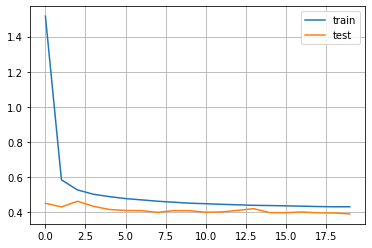

In [7]:
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.legend()
plt.grid()
plt.show()

In [8]:
train_predict1 = model.predict(X_train)
test_predict1 = model.predict(X_cv)

In [9]:
print('Train MAE',mean_absolute_error(np.exp(y_train),np.exp(train_predict1)))
print('Test MAE',mean_absolute_error(np.exp(y_cv),np.exp(test_predict1)))

Train MAE 1192.073889845016
Test MAE 1186.1668396273528


In [10]:
joblib.dump(model,'mlp_regressor_ensemble')

['mlp_regressor_ensemble']

- Once I trained all the XgboostRegressor with different fold size. I tried to train Deep Learning model.
- I started with MLPRegressor with two layers.
- Eventually I in creased the number of layers with different BN and DropOut Rate
- I tried MLP with 5 folds and without folds.
- Unfortunately, this didn't help me securing a good rank in this competition.
- So, I decided to train Conv1D 

## CNN Models

In [5]:
print(X_train.shape)

(150654, 130)


In [6]:
n_filters = 64
model_cnn = Sequential()
model_cnn.add(Conv1D(64,kernel_size = 3,strides = 3, activation='relu', 
                 use_bias = False,data_format="channels_last",input_shape=(130,1)))
model_cnn.add(Conv1D(32,kernel_size = 3,strides = 3, activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(100, activation='relu'))

model_cnn.add(Dense(1,kernel_initializer = 'normal', activation='linear'))
model_cnn.compile(loss = 'mae',optimizer = 'adam')

In [7]:
#reshaping the train and cv data
X_train_reshape = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1],1)
X_cv_reshape =  np.array(X_cv).reshape(X_cv.shape[0],  X_cv.shape[1],1)

In [8]:
X_train_reshape.shape

(150654, 130, 1)

In [9]:
X_cv_reshape.shape

(37664, 130, 1)

In [10]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 43, 64)            192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 32)            6176      
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 448)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               44900     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 51,369
Trainable params: 51,369
Non-trainable params: 0
__________________________________________________

In [11]:
model_cnn.compile(optimizer='adam', loss='mae', metrics=['mae'])
history = model_cnn.fit(X_train_reshape, y_train, batch_size=128, epochs=40, verbose=0, validation_data=(X_cv_reshape,y_cv))

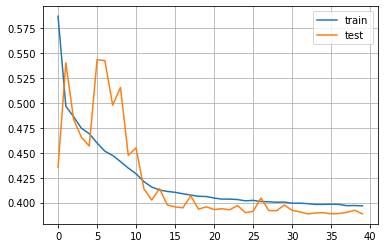

In [12]:
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.legend()
plt.grid()
plt.show()

In [13]:
train_predict1 = model_cnn.predict(X_train_reshape)
test_predict1 = model_cnn.predict(X_cv_reshape)

In [14]:
print('Train MAE',mean_absolute_error(np.exp(y_train),np.exp(train_predict1)))
print('Test MAE',mean_absolute_error(np.exp(y_cv),np.exp(test_predict1)))

Train MAE 1183.3628793862244
Test MAE 1188.2098593098813


In [15]:
joblib.dump(model_cnn,'cnn_ensemble')

['cnn_ensemble']

- After training CNN models for hours I didn;t find any satisfying results
- I tried adding LSTM layer to it which didn't give me satisfying result either.
- So, I decided to build an ensemble of this final four models
- My ensemble inluded:

- <h> DecisionTreeRegressor
    
- <h> XGBoostRegressor

- <h> MLPRegressor
    
- <h> Conv1D

## Building Ensemble for Final Submission

- In all the code snippets below I am trying to use a stacking methodology for building an ensemble on the above four mentioned models.
- Let's see if they can be of some help.

In [5]:
import joblib
train_test = pd.read_pickle('train_test')
print(train_test.head())
print(train_test.shape)

   id  cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  ...  cat14_cat38  \
0   1     1     2     1     2     1     1     1     1     2  ...         -373   
1   2     1     2     1     1     1     1     1     1     2  ...         -373   
2   5     1     2     1     1     2     1     1     1     2  ...         -373   
3  10     2     2     1     2     1     1     1     1     2  ...         -373   
4  11     1     2     1     2     1     1     1     1     2  ...         -373   

   cat14_cat24  cat14_cat82  cat14_cat25  cat38_cat24  cat38_cat82  \
0         -373         -372         -373         -373         -372   
1         -373         -373         -373         -373         -373   
2         -373         -372         -373         -373         -372   
3         -373         -354         -373         -373         -354   
4         -373         -372         -373         -373         -372   

   cat38_cat25  cat24_cat82  cat24_cat25  cat82_cat25  
0         -373         -372         

In [6]:
ntrain = 188318
shift = 200

train_x = train_test.iloc[:ntrain, :].copy()
test_x = train_test.iloc[ntrain:, :].copy()

ids = pd.read_csv('test.csv')['id']
train_y = np.log(train_x['loss'] + shift)
train_x = train_x.drop(['loss','id'], axis=1)
test_x = test_x.drop(['loss','id'], axis=1)

X_train,X_cv,y_train,y_cv = train_test_split(train_x,train_y,test_size = 0.20,random_state = 42)
print(X_train.shape)
print(X_cv.shape)

(150654, 725)
(37664, 725)


In [7]:
decision_tree = joblib.load('decision_tree')
xg_boost = joblib.load('boosting_ensemble')

print('*'*30,'Predicting Decision Tree Model','*'*30)
y_pred_train_dt = decision_tree.predict(X_train)
y_pred_test_dt = decision_tree.predict(X_cv)
pred_test_dt = decision_tree.predict(test_x)

print(mean_absolute_error(np.exp(y_train),np.exp(y_pred_train_dt)))
print(mean_absolute_error(np.exp(y_cv),np.exp(y_pred_test_dt)))

[21:13:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
****************************** Predicting Decision Tree Model ******************************
1376.537550811794
1365.6286239562453


In [8]:
pred1 = pd.DataFrame(np.exp(y_pred_train_dt))
pred2 = pd.DataFrame(np.exp(y_pred_test_dt))
pred_test_dt = pd.DataFrame(np.exp(pred_test_dt))
feat1 = pd.concat([pred1,pred2],ignore_index = True)

In [21]:
pred_test_dt = np.reshape(np.array(pred_test_dt),-1)

In [24]:
test = pd.read_csv('test.csv')
result = pd.DataFrame({'id':test.id,
                      'loss':list(pred_test_dt)})
result.to_csv('final_submission.csv', index = False)

In [8]:
xg_boost = joblib.load('boosting_ensemble')
y_pred_train_xgb = xg_boost.predict(X_train)
y_pred_test_xgb = xg_boost.predict(X_cv)
pred_test_xgb = xg_boost.predict(test_x)

print('*'*30,'Predicting XGBoostRegresor','*'*30)
print(mean_absolute_error(np.exp(y_train),np.exp(y_pred_train_xgb)))
print(mean_absolute_error(np.exp(y_cv),np.exp(y_pred_test_xgb)))

****************************** Predicting XGBoostRegresor ******************************
1243.4512830108902
1229.261135475269


In [9]:
pred1 = pd.DataFrame(np.exp(y_pred_train_xgb))
pred2 = pd.DataFrame(np.exp(y_pred_test_xgb))
pred_test_xgb = pd.DataFrame(np.exp(pred_test_xgb))
feat2 = pd.concat([pred1,pred2],ignore_index = True)

## Preparing Data for MLP models

In [2]:
%%time
import numpy as np
import pandas as pd
import xgboost as xgb

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
import itertools

shift = 200
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-shift,
                                      np.exp(yhat)-shift)
def mungeskewed(train, test, numeric_feats):
    ntrain = train.shape[0]
    test['loss'] = 0
    train_test = pd.concat((train, test)).reset_index(drop=True)
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.25]
    skewed_feats = skewed_feats.index

    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1
        train_test[feats], lam = boxcox(train_test[feats])
    return train_test, ntrain

if __name__ == "__main__":

    print('\nStarted')
    directory = '../input/'
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    numeric_feats = [x for x in train.columns[1:-1] if 'cont' in x]
    categorical_feats = [x for x in train.columns[1:-1] if 'cat' in x]
    train_test, ntrain = mungeskewed(train, test, numeric_feats)

    categorical_feats = [x for x in train_test.columns[1:] if 'cat' in x]

    print('')
    for col in categorical_feats:
        print('Analyzing Column:', col)
        train_test[col] = train_test[col].apply(encode)

    print(train_test[categorical_feats])

    ss = StandardScaler()
    train_test[numeric_feats] = \
        ss.fit_transform(train_test[numeric_feats].values)

    train = train_test.iloc[:ntrain, :].copy()
    test = train_test.iloc[ntrain:, :].copy()

    print('\nMedian Loss:', train.loss.median())
    print('Mean Loss:', train.loss.mean())

    ids = pd.read_csv('test.csv')['id']
    train_y = np.log(train['loss'] + shift)
    train_x = train.drop(['loss','id'], axis=1)
    test_x = test.drop(['loss','id'], axis=1)


Started

Analyzing Column: cat1
Analyzing Column: cat2
Analyzing Column: cat3
Analyzing Column: cat4
Analyzing Column: cat5
Analyzing Column: cat6
Analyzing Column: cat7
Analyzing Column: cat8
Analyzing Column: cat9
Analyzing Column: cat10
Analyzing Column: cat11
Analyzing Column: cat12
Analyzing Column: cat13
Analyzing Column: cat14
Analyzing Column: cat15
Analyzing Column: cat16
Analyzing Column: cat17
Analyzing Column: cat18
Analyzing Column: cat19
Analyzing Column: cat20
Analyzing Column: cat21
Analyzing Column: cat22
Analyzing Column: cat23
Analyzing Column: cat24
Analyzing Column: cat25
Analyzing Column: cat26
Analyzing Column: cat27
Analyzing Column: cat28
Analyzing Column: cat29
Analyzing Column: cat30
Analyzing Column: cat31
Analyzing Column: cat32
Analyzing Column: cat33
Analyzing Column: cat34
Analyzing Column: cat35
Analyzing Column: cat36
Analyzing Column: cat37
Analyzing Column: cat38
Analyzing Column: cat39
Analyzing Column: cat40
Analyzing Column: cat41
Analyzing Colum

In [3]:
X_train,X_cv,y_train,y_cv = train_test_split(train_x,train_y,test_size = 0.20,random_state = 42)
input_dim = X_train.shape[1]

In [4]:
mlp_reg = joblib.load('mlp_regressor_ensemble')
cnn_reg = joblib.load('cnn_ensemble')

Using TensorFlow backend.


In [5]:
y_pred_train_mlp = mlp_reg.predict(X_train)
y_pred_test_mlp = mlp_reg.predict(X_cv)
pred_test_mlp = mlp_reg.predict(test_x)

print(mean_absolute_error(np.exp(y_train),np.exp(y_pred_train_mlp)))
print(mean_absolute_error(np.exp(y_cv),np.exp(y_pred_test_mlp)))

1192.073889845016
1186.1668396273528


In [6]:
pred1 = pd.DataFrame(np.exp(y_pred_train_mlp))
pred2 = pd.DataFrame(np.exp(y_pred_test_mlp))
pred_test_mlp = pd.DataFrame(np.exp(pred_test_mlp))
feat3 = pd.concat([pred1,pred2],ignore_index = True)

In [7]:
X_train_reshape = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1],1)
X_cv_reshape =  np.array(X_cv).reshape(X_cv.shape[0],  X_cv.shape[1],1)
X_test_reshape = np.array(test_x).reshape(test_x.shape[0],test_x.shape[1],1)

In [8]:
y_pred_train_cnn = cnn_reg.predict(X_train_reshape)
y_pred_test_cnn = cnn_reg.predict(X_cv_reshape)
pred_test_cnn = cnn_reg.predict(X_test_reshape)

print(mean_absolute_error(np.exp(y_train),np.exp(y_pred_train_cnn)))
print(mean_absolute_error(np.exp(y_cv),np.exp(y_pred_test_cnn)))

1183.3628793862244
1188.2098593098813


In [9]:
pred1 = pd.DataFrame(np.exp(y_pred_train_cnn))
pred2 = pd.DataFrame(np.exp(y_pred_test_cnn))
pred_test_cnn = pd.DataFrame(np.exp(pred_test_cnn))
feat4 = pd.concat([pred1,pred2],ignore_index = True)

In [26]:
pred_test_mlp = np.reshape(np.array(pred_test_mlp),-1)
pred_test_cnn = np.reshape(np.array(pred_test_cnn),-1)

loss_xgb = pd.read_csv('submission_10fold-average-xgb_fairobj_1132.110124_2020-04-15-20-53.csv')
loss = loss_xgb['loss']
average = ((pred_test_mlp + pred_test_cnn + loss)/3)
result = pd.DataFrame({'id': test.id,
                      'loss': average})
result.to_csv('final_submission.csv',index = False)

In [27]:
result

id         loss
0            4  1732.604832
1            6  1976.456428
2            9  8791.261549
3           12  6079.355810
4           15   865.659107
...        ...          ...
125541  587617  2304.978668
125542  587621  3045.880212
125543  587627  2587.149082
125544  587629  1379.716310
125545  587634  3477.521503

[125546 rows x 2 columns]

- In this file I took the simple average of my best three models and submitted the reult.
- My best three models were XGboostRegressor,MLPRegressor,Conv1D

In [20]:
pred_test_dt = np.reshape(np.array(pred_test_dt),-1)
pred_test_xgb = np.reshape(np.array(pred_test_xgb),-1)
pred_test_mlp = np.reshape(np.array(pred_test_mlp),-1)
pred_test_cnn = np.reshape(np.array(pred_test_cnn),-1)

In [21]:
train_test = pd.read_pickle('train_test')
ntrain = 188318
train_y = train_test['loss']
train_y = train_y[:ntrain]

In [22]:
type(feat1)

pandas.core.frame.DataFrame

In [23]:
feat1 = np.reshape(np.array(feat1),-1)
feat2 = np.reshape(np.array(feat2),-1)
feat3 = np.reshape(np.array(feat3),-1)
feat4 = np.reshape(np.array(feat4),-1)

In [24]:
final_data = pd.DataFrame({'feat1':list(feat1),
                          'feat2': list(feat2),
                          'feat3': list(feat3),
                          'feat4': list(feat4),
                          'loss': list(train_y)})
final_data.shape

(188318, 5)

In [25]:
final_data.to_csv('final_data.csv')

In [26]:
test_data = pd.DataFrame({'feat1':list(pred_test_dt),
                         'feat2':list(pred_test_xgb),
                         'feat3': list(pred_test_mlp),
                         'feat4': list(pred_test_cnn)})
test_data.shape

(125546, 4)

In [27]:
test_data.to_csv('test_data.csv')

## DecisionTreeRegressor for ensemble

In [2]:
final_data = pd.read_csv('final_data.csv')
test_data = pd.read_csv('test_data.csv')

X = final_data.iloc[:,:-1]
y = final_data.iloc[:,-1]


X = X.drop(['Unnamed: 0'], axis = 1)
X_train,X_cv,y_train,y_cv = train_test_split(X,y, test_size = 0.20, random_state = 42)


In [4]:
regressor = DecisionTreeRegressor(max_depth = 5,min_samples_split = 10,min_samples_leaf = 50,
                                     max_leaf_nodes = 25, criterion = 'mae')
regressor.fit(X_train,y_train)
y_pred_train = regressor.predict(X_train)
mae_train = mean_absolute_error(y_train,y_pred_train)
    #train_scores.append(mae_train)
y_pred_test = regressor.predict(X_cv)
mae_test = mean_absolute_error(y_cv,y_pred_test)
    #test_scores.append(mae_test)
print('mae_train',mae_train,'mae_test',mae_test)

mae_train 1811.2045370849764 mae_test 1797.8007527081563


In [8]:
from tabulate import tabulate
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model name", "Folds", "MAE","Data"]

x.add_row(["XGBoostRegressor", 5, 1126.43, "Combined features"])
x.add_row(["DecisionTreeRegressor", 0, 1365.62, "Combined features"])
x.add_row(["XGBoostRegressor", 10, 1210.81, "Important features"])
x.add_row(["XGBoostRegressor", 7, 1120.73, "Combined features"])
x.add_row(["XGBoostRegressor", 9, 1127.20, "Combined features"])
x.add_row(["MLPRegressor", 5, 1340.34,"Combined features"])
x.add_row(["MLPRegressor", 0, 1186.16, "Original data"])
x.add_row(["Conv1D", 0, 1188.20, "Original data"])

print(x)

+-----------------------+-------+---------+--------------------+
|       Model name      | Folds |   MAE   |        Data        |
+-----------------------+-------+---------+--------------------+
|    XGBoostRegressor   |   5   | 1126.43 | Combined features  |
| DecisionTreeRegressor |   0   | 1365.62 | Combined features  |
|    XGBoostRegressor   |   10  | 1210.81 | Important features |
|    XGBoostRegressor   |   7   | 1120.73 | Combined features  |
|    XGBoostRegressor   |   9   |  1127.2 | Combined features  |
|      MLPRegressor     |   5   | 1340.34 | Combined features  |
|      MLPRegressor     |   0   | 1186.16 |   Original data    |
|         Conv1D        |   0   |  1188.2 |   Original data    |
+-----------------------+-------+---------+--------------------+


## Conclusion
- In the PrettyTable above you can easily see feature type column where combined feature means the categorical combined feature using ordinal technique and important features mean the features obtained from DecisionTreeRegressor and Original data is our 116 categorical features
- By seeing the above result we can clearly say that our original data is working fairly well as compared to combined features on our DeepLearning models
- We can also say that the results differ drastically with combined features on XGboostRegressor as the folds change
- So the important thing was running this models for the right number of folds
- Another thing to notice with the results above is that I trained ensemble model using DecisionTreeRegressor because XGBoostRegressor was giving very different results infact an unexpected results
- XGboostRegressor kept giving me a ValueError for having NaN variables when there were None.So, I decided to train DecisionTreeRegressor
- Unfortunately, none of this models worked well on my ensemble because maybe they were highly impacted with the outliers
- Hence, I tried using log value for my loss variable.
- If you notice I have used a shift value to add it to my loss feature because when I converted my loss variable to log function it gave me negative values which was not expected for building a model
- The model which gave me 1145 on Private LB included the average of three important models which were XGBoostRegressor with 7 folds,MLPRegressor on original data and Conv1D on the original data.
- Because DecisionTreeRegressor and XGBoostRegressor are highly impacted by outliers and conversion to log function is not helping much on ensemble.